In [0]:
from google.colab import drive
drive.mount('/content/gdrive')
!pip install ipython-autotime
%load_ext autotime
%cd /content/gdrive/My Drive/Colab Notebooks/Separate Models 2012/
!pip install mxnet-cu100mkl gluoncv==0.5.0
!pip install -e git+https://github.com/tqdm/tqdm.git@master#egg=tqdm
!python -mpip install -U pip
!python -mpip install -U matplotlib
!python -mpip install -U opencv-python


Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
/content/gdrive/My Drive/Colab Notebooks/Separate Models 2012
Obtaining tqdm from git+https://github.com/tqdm/tqdm.git@master#egg=tqdm
  Updating ./src/tqdm clone (to revision master)
  Running command git fetch -q --tags
  Running command git reset --hard -q 5e8978909c639bc20f58bf877e66cc6a0b9fb5bf
  Attempting uninstall: tqdm
    Found existing installation: tqdm 4.45.0
    Can't uninstall 'tqdm'. No files were found to uninstall.
  Running setup.py develop for tqdm
Requirement already up-to-date: pip in /usr/local/lib/python3.6/dist-packages (20.0.2)
Requirement already up-to-date: matplotlib in /usr/local/lib/python3.6/dist-packages (3.2.1)
Requirement already up-to-date: opencv-python in /usr/local/lib/python3.6/dist-packages (4.2.0.34)


In [0]:
import shutil
import os
from os import listdir, path
from os.path import isfile, join
import math
import shutil
from pathlib import Path
import ast
from tqdm import tqdm
import pandas as pd
import glob
import time
from matplotlib import patches
import gluoncv as gcv
import matplotlib.pyplot as plt
from bbox import plot_bbox
import matplotlib.pyplot as plot
import xml.etree.ElementTree as ET
import mxnet as mx
backbone = 'resnet50-20071000' #Hey Sirisha, change this, but make sure there's resnet50 in it
# backbone = 'resnet101'

CLASSES  = ['aeroplane', 'bicycle', 'bird', 'boat', 'bottle', 'bus', 'car',
           'cat', 'chair', 'cow', 'diningtable', 'dog', 'horse', 'motorbike',
           'person', 'pottedplant', 'sheep', 'sofa', 'train', 'tvmonitor']
remaining_classes  = ['person', 'pottedplant', 'sheep', 'sofa', 'train', 'tvmonitor']

artifact_path = 'Test-Artifacts/' + backbone + '/collab_fasterRCNN/0.95/' 
output_path = artifact_path +'output/'
Path(output_path).mkdir(parents=True, exist_ok=True)
ctx = mx.gpu(0)
net_ensemble = []
if 'resnet50' in backbone:
    for cls in CLASSES:
      model_path = cls + '/' + cls + '_resnet50_2012.params'
      net = gcv.model_zoo.get_model('faster_rcnn_resnet50_v1b_custom', classes=CLASSES, pretrained_base=False, ctx = ctx)
      net.load_parameters(model_path, allow_missing=True, ctx = ctx)
      net_ensemble.append(net)

time: 1min 31s


# **1. Generate Test Datasets**

# **2. Inferencing and Creating inference metrics**



In [0]:
img_directory = '2007_Test/original/' #change to 2007_Test/original/
img_path = img_directory + 'JPEGImages/*.jpg'

df = pd.read_csv('Test-Artifacts/' + backbone + '/pretrained_collab_fasterRCNN/inference_metrics_with_gt_500.csv')
img_list = []
for idx, row in df.iterrows():
  img_list.append(img_directory + 'JPEGImages/' + row['image_id'])
print(img_list)

# img_directory = '2007_Test/original/' #change to 2007_Test/original/
# img_path = img_directory + 'JPEGImages/*.jpg'
# imglist = glob.glob(img_path)

# print(imglist)
# remaining_list = [x for x in imglist if x not in img_list]
# print(len(remaining_list))
# with open('Test-Artifacts/' + backbone + '/pretrained_collab_fasterRCNN/remaining_images.txt', 'w') as filehandle:
#     for listitem in remaining_list:
#         filehandle.write('%s\n' % listitem)



['2007_Test/original/JPEGImages/008946.jpg', '2007_Test/original/JPEGImages/008938.jpg', '2007_Test/original/JPEGImages/008947.jpg', '2007_Test/original/JPEGImages/008949.jpg', '2007_Test/original/JPEGImages/008950.jpg', '2007_Test/original/JPEGImages/008952.jpg', '2007_Test/original/JPEGImages/008954.jpg', '2007_Test/original/JPEGImages/008956.jpg', '2007_Test/original/JPEGImages/008941.jpg', '2007_Test/original/JPEGImages/008945.jpg', '2007_Test/original/JPEGImages/008957.jpg', '2007_Test/original/JPEGImages/008959.jpg', '2007_Test/original/JPEGImages/008964.jpg', '2007_Test/original/JPEGImages/008963.jpg', '2007_Test/original/JPEGImages/008977.jpg', '2007_Test/original/JPEGImages/008974.jpg', '2007_Test/original/JPEGImages/008972.jpg', '2007_Test/original/JPEGImages/008918.jpg', '2007_Test/original/JPEGImages/008924.jpg', '2007_Test/original/JPEGImages/008922.jpg', '2007_Test/original/JPEGImages/008925.jpg', '2007_Test/original/JPEGImages/008984.jpg', '2007_Test/original/JPEGImages/

*2b. Inferencing based on calculated thresholds

In [0]:
def inference(threshold):
  column_names = ['image_id','dimension', 'class_name', 'inference_time', 'bboxes', 'scores'] 
  start_time = time.time()

  
  df = pd.DataFrame(columns = column_names)
  artifact_path = 'Test-Artifacts/' + backbone + '/collab_fasterRCNN/' + str(threshold) + '/' 
  output_path = artifact_path +'output/'
  csv_path = artifact_path + 'inference_metrics.csv'
  Path(output_path).mkdir(parents=True, exist_ok=True)

  if os.path.exists(csv_path):
    print('EXISTS CSV!')
    # os.remove(csv_path)
    # df = pd.DataFrame(columns = column_names)
    # df_size = 0

    df= pd.read_csv(csv_path)
    df_size = len(df)
  else:
    print('NOT EXISTS!')
    df_size = 0
  print(df_size)
 
  # for index, filename in enumerate(tqdm(glob.glob(img_path))):
  for index, filename in enumerate(tqdm(img_list)): #Hey Sirisha, make sure all of the image names you need are in this img_list
    if index < df_size:
      continue
    # if index == 1999: #if you have an end to your file list, uncomment this
    #   break
    img_path = filename
    img_score_list = []
    img_bbox_list = []
    img_class_list = []
    
    for idx, cls in enumerate(CLASSES):

      print("CURRENT MODEL: ", cls)
      net = net_ensemble[idx]
      image_id = filename.split('/')[-1]

      x, image = gcv.data.transforms.presets.rcnn.load_test(img_path, 640)
      cids, scores, bboxes = net(x.as_in_context(ctx))
      
      
      

      print()
      print(output_path)
      print(csv_path)
      # print(model_path)
      print()
  
      ax, co_dict, class_name, score, color, bbox = plot_bbox(image, bboxes[0], scores[0], cids[0],
                                                              class_names=[cls], thresh=threshold)
    
      coordinate_list = []
      score_list = []
      class_list = []
      #Extract Prediction Coordinates
      for j in range(0, len(co_dict['coordinates']['xmin'])):
          xmin = co_dict['coordinates']['xmin'][j]
          ymin = co_dict['coordinates']['ymin'][j]
          xmax = co_dict['coordinates']['xmax'][j]
          ymax = co_dict['coordinates']['ymax'][j]
          score = co_dict['scores'][j]
          class_list.append(cls)
          coordinate_list.append([xmin, ymin, xmax, ymax])
          score_list.append(score)

      width = plt.xlim()[1] - plt.xlim()[0]
      height = plt.ylim()[0] - plt.ylim()[1]
      
      print(image_id)

      #Create a dataframe based on predicted results v
      # data = [[image_id,[width, height], class_list, str(time.time() - start_time), coordinate_list, score_list ]]
      # data_df = pd.DataFrame(data, columns = column_names)
      

      plt.savefig(output_path + image_id)
      plt.close()
      img_score_list += score_list
      img_class_list += class_list
      img_bbox_list += coordinate_list
      print(img_class_list, img_score_list, img_bbox_list)
      # if (idx == 3):
      #   break
    row_data = [[image_id,[width, height], img_class_list, str(time.time() - start_time), img_bbox_list, img_score_list]]
    print(row_data)
    data_df = pd.DataFrame(row_data, columns = column_names)
    df = df.append(data_df, ignore_index = True)
    df.to_csv(csv_path, index=False)
    ctx.empty_cache()

    # break

  print("CURRENT THRESHOLD:", threshold)
  # artifact_path = 'Test-Artifacts/' + backbone + '/' + cls + '/' + str(threshold) + '/'
  # csv_path = artifact_path + 'inference_metrics.csv'
  # csv_path = artifact_path + 'inference_metrics_with_gt.csv'  
  # # display(df_list[index])
  # df = cleanup_df(df_list[index])
  

  display(df)

  # prepare_for_mAP(cls, threshold_list)

  # calculate_mAP(cls, threshold_list)

  # result = extract_mAP(cls, threshold_list)

  # print ("Best mAP of", cls, ":", result[0], 'with threshold:', result[1])
  # return result



def cleanup_df(df):
  gt_bbox_list = []
  gt_classname_list = []
  print(len(df))
  for index, row in df.iterrows():
    ##Extract IMG and XML name
    IMG_name = row['image_id']
    XML_name = row['image_id'].split('.jpg')[0] + '.xml'
    inference_width, inference_height = ast.literal_eval(row['dimension'])
    
    print(index, IMG_name, XML_name, [inference_width, inference_height])

    #Fix negative values
    bboxes = ast.literal_eval(row['bboxes'])
    print(row['bboxes'])
    for idx, bbox in enumerate(bboxes):
      # print("OLD BBOX: ", bbox)
      bboxes[idx] = [x if x>=0 else 0 for x in bbox]
      # print("NEW BBOX: ", bboxes[idx])
    # row['bboxes'] = bboxes
    print(bboxes)
    df.loc[df['image_id'] == IMG_name, 'bboxes'] = str(bboxes)
    # print(row['bboxes'])

    
    gt_XML_path = img_directory + 'Annotations/' + IMG_name.split('.jpg')[0] + '.xml' #Hey Sirisha, make sure your img_directory that also contains annotation files is correct
    root = ET.parse(gt_XML_path).getroot()
    for object in root.findall('size'):
      original_width = float(object.find('width').text)
      original_height = float(object.find('height').text)
    
    gt_bboxes = []
    gt_classnames = []
    for object in root.findall('object'):
      className = object.find('name').text
      #original xmin,ymin,xmax,ymax
      boundingBox_xmin = float(object.find('bndbox').find('xmin').text)
      boundingBox_ymin = float(object.find('bndbox').find('ymin').text)
      boundingBox_xmax = float(object.find('bndbox').find('xmax').text)
      boundingBox_ymax = float(object.find('bndbox').find('ymax').text)

      #find factor
      boundingBox_xmin_factor = boundingBox_xmin / original_width 
      boundingBox_ymin_factor = boundingBox_ymin / original_height
      boundingBox_xmax_factor = boundingBox_xmax / original_width
      boundingBox_ymax_factor = boundingBox_ymax / original_height

      #rescale the original bounding boxes
      scaled_boundingBox_xmin = boundingBox_xmin_factor * inference_width
      scaled_boundingBox_ymin = boundingBox_ymin_factor * inference_height
      scaled_boundingBox_xmax = boundingBox_xmax_factor * inference_width
      scaled_boundingBox_ymax = boundingBox_ymax_factor * inference_height
      gt_bboxes.append([scaled_boundingBox_xmin, scaled_boundingBox_ymin ,scaled_boundingBox_xmax, scaled_boundingBox_ymax])
      gt_classnames.append(className)
    gt_bbox_list.append(gt_bboxes)
    gt_classname_list.append(gt_classnames)
  df['gt_bboxes'] = gt_bbox_list
  df['gt_class_name'] = gt_classname_list
  
  display(df)
  # print("Saving to", output)
  # df.to_csv(output, index=False)
  return df



def prepare_for_mAP(threshold):
  ###PREPARING FOR MAP AND MAP CALCULATION###
  ###MAP SCORE###
  import shutil
  from pathlib import Path
  import ast
  import pandas as pd
  #Preparing and Structuring Data


  #Prepare folder
  test_root = 'Test-Artifacts/' + backbone + '/collab_fasterRCNN/' + str(threshold) + '/mAP-report/input/' 
  gt_root = test_root + 'ground-truth/'
  prediction_root = test_root + 'detection-results/'
  test_img_write_root = test_root +'images-optional/'

  Path(gt_root).mkdir(parents=True, exist_ok=True)
  Path(prediction_root).mkdir(parents=True, exist_ok=True)
  Path(test_img_write_root).mkdir(parents=True, exist_ok=True)




  filename = 'Test-Artifacts/' + backbone + '/collab_fasterRCNN/' + str(threshold) + '/inference_metrics_with_gt.csv'
  df = pd.read_csv(filename)
  # display(df)

  for index, row in df.iterrows():
    image_id = row['image_id'].split('.jpg')[0]
    image_src_path = '2012_TestImages/' + row['image_id']
    gt_path = gt_root + image_id + '.txt'
    prediction_path = prediction_root + image_id + '.txt'
    image_destination_path = test_img_write_root

    ##GROUND TRUTH VALUES###
    gt_class_names = ast.literal_eval(row['gt_class_name'])
    gt_bboxes = ast.literal_eval(row['gt_bboxes'])

    ##PREDICTION VALUES###
    p_class_names = ast.literal_eval(row['class_name'])
    p_bboxes = ast.literal_eval(row['bboxes'])
    scores = ast.literal_eval(row['scores'])
    # print(p_bboxes, scores)
    # print(gt_bbox)
    # print(p_bbox)
    # print(class_name, gt_path, prediction_path, image_src_path, image_destination_path)
    print(image_id)
    #Write ground truth
    with open(gt_path, 'w') as g_write:
      for i, gt_bbox in enumerate(gt_bboxes):
        class_name = gt_class_names[i]
        for idx, val in enumerate(gt_bbox):
          gt_bbox[idx] = str(val)
        # print(gt_bbox)
        line = class_name + ' ' + gt_bbox[0] + ' ' + gt_bbox[1] + ' ' + gt_bbox[2] + ' ' + gt_bbox[3] + '\n'
        g_write.write(line)
        print("GROUND TRUTH:", class_name, gt_bbox[0], gt_bbox[1], gt_bbox[2], gt_bbox[3], '\n')

    #Write prediction results
    with open(prediction_path, 'w') as p_write:
      for i, p_bbox in enumerate(p_bboxes):
        score = str(scores[i])
        class_name = p_class_names[i]
        for idx, val in enumerate(p_bbox):
          p_bbox[idx] = str(val)
        # print(p_bbox, score)
        line = class_name + ' ' + score + ' ' + p_bbox[0] + ' ' + p_bbox[1] + ' ' + p_bbox[2] + ' ' + p_bbox[3] + '\n'
        p_write.write(line)
        print("PREDICTION:", class_name + ' ' + score + ' ' + p_bbox[0] + ' ' + p_bbox[1] + ' ' + p_bbox[2] + ' ' + p_bbox[3] + '\n')
    if os.path.exists(image_src_path):
      shutil.copy(image_src_path, image_destination_path)
    # if index == 3:
    #   break


    
  # break
def calculate_mAP(threshold):
  destination = 'Test-Artifacts/' + backbone + '/collab_fasterRCNN/' + str(threshold) + '/mAP-report' 
  shutil.copy('Test-Artifacts/resnet50/SCSM/mAP-report/main.py', destination)
  !python '$destination/main.py' --no-animation --iou 0.5
# def extract_mAP(threshold):
#   mAP_list = [] 
#   for threshold in threshold_list:
#     destination = 'Test-Artifacts/' + backbone + '/' + cls + '/' + str(threshold) + '/mAP-report/output'
#     path = destination + '/output.txt'
#     with open(path) as f:
#       lines = f.readlines()
#       mAP = float(lines[1].split('%')[0]) #get mAP of first class
#       print("Threshold: ", threshold, "mAP:", mAP)
#       mAP_list.append(mAP)
  
#   best_mAP = max(mAP_list)
#   best_mAP_index = mAP_list.index(best_mAP)
#   threshold = THRESHOLD_LIST[best_mAP_index]

#   return [best_mAP, threshold]


# inference(0.95) #Hey Sirisha, uncomment this line to do inferences
# extract_mAP()

time: 646 ms


In [0]:
df = pd.read_csv('Test-Artifacts/' + backbone + '/collab_fasterRCNN/0.95/inference_metrics.csv')

# for i in range(2,4):
#   new_df = pd.read_csv('Test-Artifacts/' + backbone + '/pretrained_collab_fasterRCNN/0.95/inference_metrics_remaining' + str(i) + '.csv')
#   df = pd.concat([df,new_df], ignore_index = True)
# display(df)

df = cleanup_df(df)  #Hey Sirisha, run this to add gt bboxes
df.to_csv('Test-Artifacts/' + backbone + '/collab_fasterRCNN/0.95/inference_metrics_with_gt.csv', index=False)


prepare_for_mAP(0.95)
calculate_mAP(0.95)


500
0 008946.jpg 008946.xml [952.0, 640.0]
[[462, 273, 681, 607], [26, -189, 916, 610]]
[[462, 273, 681, 607], [26, 0, 916, 610]]
1 008938.jpg 008938.xml [640.0, 853.0]
[[-26, 180, 676, 611], [188, 312, 608, 853], [321, 8, 621, 820]]
[[0, 180, 676, 611], [188, 312, 608, 853], [321, 8, 621, 820]]
2 008947.jpg 008947.xml [853.0, 640.0]
[[7, 129, 378, 694], [-11, 335, 696, 664], [549, 327, 818, 590], [115, 374, 307, 631], [258, 487, 810, 641], [437, 230, 595, 442], [540, 296, 831, 605]]
[[7, 129, 378, 694], [0, 335, 696, 664], [549, 327, 818, 590], [115, 374, 307, 631], [258, 487, 810, 641], [437, 230, 595, 442], [540, 296, 831, 605]]
3 008949.jpg 008949.xml [853.0, 640.0]
[[142, 7, 869, 620], [10, 430, 828, 642], [385, -86, 833, 322]]
[[142, 7, 869, 620], [10, 430, 828, 642], [385, 0, 833, 322]]
4 008950.jpg 008950.xml [961.0, 640.0]
[[134, 98, 555, 362], [152, 135, 593, 336]]
[[134, 98, 555, 362], [152, 135, 593, 336]]
5 008952.jpg 008952.xml [853.0, 640.0]
[[463, 195, 592, 360]]
[[463,

image_id  ...                                 gt_class_name
0    008946.jpg  ...                           [person, tvmonitor]
1    008938.jpg  ...                                       [chair]
2    008947.jpg  ...         [tvmonitor, pottedplant, sofa, chair]
3    008949.jpg  ...                                   [tvmonitor]
4    008950.jpg  ...                                   [aeroplane]
..          ...  ...                                           ...
495  009957.jpg  ...                               [person, horse]
496  009953.jpg  ...                                     [bicycle]
497  009952.jpg  ...                                         [dog]
498  009963.jpg  ...                                         [car]
499  009962.jpg  ...  [chair, person, person, person, diningtable]

[500 rows x 8 columns]

Streaming output truncated to the last 5000 lines.
PREDICTION: sofa 0.993 70 166 509 614

PREDICTION: train 0.960 0 16 948 597

009346
GROUND TRUTH: cat 102.36 209.92000000000002 375.32 520.5333333333333 

GROUND TRUTH: cat 414.558 179.20000000000002 745.522 541.0133333333333 

PREDICTION: cat 0.973 496 177 754 543

PREDICTION: dog 0.996 494 168 748 550

PREDICTION: dog 0.987 144 188 394 528

009322
GROUND TRUTH: motorbike 572.756 459.33933933933935 674.622 630.3903903903904 

GROUND TRUTH: person 586.21 397.8378378378378 676.544 588.1081081081081 

GROUND TRUTH: car 1.922 430.5105105105105 90.334 532.3723723723724 

GROUND TRUTH: car 59.582 422.8228228228228 178.746 507.3873873873874 

GROUND TRUTH: car 138.384 401.68168168168165 249.86 492.012012012012 

GROUND TRUTH: car 228.718 411.29129129129126 299.832 484.3243243243244 

GROUND TRUTH: car 269.08000000000004 407.4474474474474 342.116 470.8708708708708 

GROUND TRUTH: car 295.988 374.77477477477476 394.01 461.2612612612612 

GROUN

Display all test images in a grid format

In [0]:
#display all test images

from matplotlib.pyplot import figure, imshow, axis, savefig
from matplotlib.image import imread

import matplotlib.pyplot as plt

def grid_display(list_of_images, list_of_titles=[], no_of_columns=2, figsize=(10,10), theme=""):

    fig = figure(figsize=figsize)
    fig.suptitle(theme, fontsize=30, x = 0.52, y = 0.57)
    fig.tight_layout()
    column = 0
    for i in range(len(list_of_images)):
        column += 1
        #  check for end of column and create a new figure
        if column == no_of_columns+1:
            fig = figure(figsize=figsize)
            column = 1
        fig.add_subplot(1, no_of_columns, column)
        imshow(imread(list_of_images[i]))
        axis('off')
    savefig('aeroplane_test.png')
for cls in CLASSES:
  print (cls)
  file_list = []
  for img in os.listdir('Test-Artifacts/' + cls + '/output'):
    file_list.append('Test-Artifacts/' + cls + '/output/' + img)
  grid_display(file_list, no_of_columns=5, figsize = (30,35), theme = cls)

  print()
  print()


aeroplane


FileNotFoundError: ignored

time: 154 ms


In [0]:
# import re
# for cls in CLASSES:
#   filename = 'Test-Artifacts/' + cls + '/inference_metrics.txt'
#   with open(filename, 'r+') as f:
#     text = f.read()
#     text = re.sub('aeroplane', cls, text)
#     f.seek(0)
#     print(text)
#     f.write(text)
#     f.truncate()

# **3. Inspect CSV and Produce Confusion Matrix

In [0]:
import pandas as pd
import ast
df = pd.read_csv('Test-Artifacts/' + backbone + '/collab_fasterRCNN/0.95/inference_metrics_with_gt.csv')
def create_inspect_csv(df):
  column_names =  ['image_id', 'prediction', 'ground_truth', 'false_positives']
  column_names2 =  ['image_id', 'prediction', 'ground_truth', 'pt_bboxes', 'gt_bboxes', 'dimension']
  result_df = pd.DataFrame(columns = column_names)
  visualization_df = pd.DataFrame(columns = column_names2)
  for index, row in df.iterrows():
    image_id = row['image_id']
    
    prediction= list(set(ast.literal_eval(row['class_name'])))
    gt = list(set(ast.literal_eval(row['gt_class_name'])))
    fp = [x for x in prediction if x not in gt]
    # if fp == []:
    #   continue
    data = [[image_id, prediction, gt, fp]]
    print(data)
    data_row = pd.DataFrame(data = data, columns = column_names)
    result_df = result_df.append(data_row, ignore_index = True)
    
    dimension = ast.literal_eval(row['dimension'])
    prediction= ast.literal_eval(row['class_name'])
    gt = ast.literal_eval(row['gt_class_name'])
    p_bbox = ast.literal_eval(row['bboxes'])
    gt_bbox = ast.literal_eval(row['gt_bboxes'])
    data2 = [[image_id, prediction, gt, p_bbox, gt_bbox, dimension]]

    data_row2 = pd.DataFrame(data = data2, columns = column_names2)
    visualization_df = visualization_df.append(data_row2, ignore_index = True)
  # print(new_df['class_name'][0])
  display(result_df)
  display(visualization_df)
  # result_df.to_csv('Test-Artifacts/' +  backbone + '/regular_fasterRCNN/predict_truth_report.csv') 
  # visualization_df.to_csv('Test-Artifacts/' +  backbone + '/regular_fasterRCNN/predict_truth_report_with_bboxes.csv', index = False)
  
  result_df.to_csv('Test-Artifacts/' +  backbone + '/collab_fasterRCNN/0.95/predict_truth_report.csv')  
  visualization_df.to_csv('Test-Artifacts/' +  backbone + '/collab_fasterRCNN/0.95/predict_truth_report_with_bboxes.csv', index = False)

  return visualization_df
inspect_table = create_inspect_csv(df)


[['008946.jpg', ['person', 'train'], ['person', 'tvmonitor'], ['train']]]
[['008938.jpg', ['person', 'boat', 'diningtable'], ['chair'], ['person', 'boat', 'diningtable']]]
[['008947.jpg', ['boat', 'pottedplant', 'diningtable', 'car', 'sofa', 'chair'], ['tvmonitor', 'sofa', 'chair', 'pottedplant'], ['boat', 'diningtable', 'car']]]
[['008949.jpg', ['aeroplane', 'diningtable', 'tvmonitor'], ['tvmonitor'], ['aeroplane', 'diningtable']]]
[['008950.jpg', ['bird', 'aeroplane'], ['aeroplane'], ['bird']]]
[['008952.jpg', ['person'], ['person', 'motorbike'], []]]
[['008954.jpg', ['tvmonitor', 'bicycle', 'train', 'diningtable', 'car', 'chair'], ['tvmonitor', 'chair'], ['bicycle', 'train', 'diningtable', 'car']]]
[['008956.jpg', ['bird', 'aeroplane', 'dog', 'bicycle'], ['bird'], ['aeroplane', 'dog', 'bicycle']]]
[['008941.jpg', ['person', 'boat', 'diningtable', 'chair', 'aeroplane'], ['person', 'diningtable', 'chair'], ['boat', 'aeroplane']]]
[['008945.jpg', ['person', 'boat', 'train', 'diningtabl

image_id  ...                               false_positives
0    008946.jpg  ...                                       [train]
1    008938.jpg  ...                   [person, boat, diningtable]
2    008947.jpg  ...                      [boat, diningtable, car]
3    008949.jpg  ...                      [aeroplane, diningtable]
4    008950.jpg  ...                                        [bird]
..          ...  ...                                           ...
495  009957.jpg  ...      [boat, train, cow, dog, sofa, aeroplane]
496  009953.jpg  ...                                        [bird]
497  009952.jpg  ...                          [horse, sofa, sheep]
498  009963.jpg  ...                         [train, boat, bottle]
499  009962.jpg  ...  [boat, bicycle, train, car, sofa, aeroplane]

[500 rows x 4 columns]

image_id  ...       dimension
0    008946.jpg  ...  [952.0, 640.0]
1    008938.jpg  ...  [640.0, 853.0]
2    008947.jpg  ...  [853.0, 640.0]
3    008949.jpg  ...  [853.0, 640.0]
4    008950.jpg  ...  [961.0, 640.0]
..          ...  ...             ...
495  009957.jpg  ...  [640.0, 870.0]
496  009953.jpg  ...  [853.0, 640.0]
497  009952.jpg  ...  [640.0, 853.0]
498  009963.jpg  ...  [640.0, 856.0]
499  009962.jpg  ...  [853.0, 640.0]

[500 rows x 6 columns]

time: 1.81 s


In [0]:
from sklearn.metrics import confusion_matrix
confusion_columns = ['ground_truth', 'prediction']
confusion_df = pd.DataFrame(columns = confusion_columns)
display(inspect_table.head())
IOU = 0.5
confusion_dict = {}
true_match = {}
fn_list = []
for index, row in inspect_table.iterrows(): #for every image
  display(row)
  print(row['image_id'])
  prediction_data = row['pt_bboxes']
  pd_classes = row['prediction']
  ground_truth_data = row['gt_bboxes']
  gt_classes = row['ground_truth']
  gt_match = {}
  
  for i, bb in enumerate(prediction_data): #for every pd bbox
      pd_class_name = pd_classes[i]
      print(pd_class_name, bb)
      ovmax = -1
      current_match_idx = -1
      for idx, bbgt in enumerate(ground_truth_data): #for every gt bbox
          gt_class_name = gt_classes[idx]
          # look for a class_name match
          print('\t--->', gt_class_name, bbgt)
          ov = -1
          #CALCULATE OVERLAP
          bi = [max(bb[0],bbgt[0]), max(bb[1],bbgt[1]), min(bb[2],bbgt[2]), min(bb[3],bbgt[3])] #intersection bbox
          iw = bi[2] - bi[0] + 1
          ih = bi[3] - bi[1] + 1
          if iw > 0 and ih > 0:
              # compute overlap (IoU) = area of intersection / area of union
              ua = (bb[2] - bb[0] + 1) * (bb[3] - bb[1] + 1) + (bbgt[2] - bbgt[0]
                              + 1) * (bbgt[3] - bbgt[1] + 1) - iw * ih
              ov = iw * ih / ua
              if ov > ovmax:
                  ovmax = ov
                  current_match_idx = idx #gt index
      
          print('\toverlap:', ov)
          print('\tmax overlap:', ovmax, 'index:', current_match_idx)
          print()
      if (ovmax >= IOU):
        if pd_class_name == gt_classes[current_match_idx]:  #same box same class
          if current_match_idx in gt_match: #duplicate
            print("DUPLICATED PREDICTION! ALREADY MATCHED! NOT CONSIDERED!")
          else: #new match
            gt_match[current_match_idx] = i
            print("A NEW MATCH -> GT: {} and PD: {}".format(current_match_idx, i))
            if gt_classes[current_match_idx] in true_match:
               true_match[gt_classes[current_match_idx]].append(pd_class_name)
            else:
               true_match[gt_classes[current_match_idx]] = [pd_class_name]
        else: #same box but different classes
          print("CONFUSION BETWEEN {} and {}".format(pd_class_name, gt_classes[current_match_idx]))
          if gt_classes[current_match_idx] in confusion_dict:
            confusion_dict[gt_classes[current_match_idx]].append(pd_class_name)
          else:
            confusion_dict[gt_classes[current_match_idx]] = [pd_class_name]
      else: #totally different box => extra detection
        print("TOTALLY DIFFERENT BOX")
        print("EXTRA {} DETECTED".format(pd_class_name))
        if 'other' in confusion_dict:
          confusion_dict['other'].append(pd_class_name)
        else:
          confusion_dict['other'] = [pd_class_name]
        print()
  print(gt_match.keys())
  matched_gt = gt_match.keys()
  false_negatives = [gt_classes[x] for x in range(len(gt_classes)) if x not in matched_gt]
  print('FALSE NEGATIVES:', false_negatives)
  print('CONFUSION DICT:', confusion_dict)
  print()
  print('########')
  fn_list.append(false_negatives)
  # if (index == 100):
  #   break


y_pred = []
y_true = []
print("#######CONFUSION DICT EXPANSION########")
for gt, preds in confusion_dict.items():
  for pred in preds:
    print("GT: {} <- PD: {}".format(gt, pred))
    y_pred.append(pred)
    y_true.append(gt)
print("#######REAL MATCH EXPANSION########")
for gt, preds in true_match.items():
  for pred in preds:
    print("GT: {} <- PD: {}".format(gt, pred))
    y_pred.append(pred)
    y_true.append(gt)
confusion_matrix = confusion_matrix(y_true, y_pred, labels=CLASSES + ['other'])
confusion_matrix

image_id  ...       dimension
0  008946.jpg  ...  [952.0, 640.0]
1  008938.jpg  ...  [640.0, 853.0]
2  008947.jpg  ...  [853.0, 640.0]
3  008949.jpg  ...  [853.0, 640.0]
4  008950.jpg  ...  [961.0, 640.0]

[5 rows x 6 columns]

image_id                                               008946.jpg
prediction                                        [person, train]
ground_truth                                  [person, tvmonitor]
pt_bboxes               [[462, 273, 681, 607], [26, 0, 916, 610]]
gt_bboxes       [[458.864, 281.9047619047619, 681.632, 573.333...
dimension                                          [952.0, 640.0]
Name: 0, dtype: object

008946.jpg
person [462, 273, 681, 607]
	---> person [458.864, 281.9047619047619, 681.632, 573.3333333333334]
	overlap: 0.8600625221948229
	max overlap: 0.8600625221948229 index: 0

	---> tvmonitor [5.712, 321.9047619047619, 251.328, 529.5238095238095]
	overlap: -1
	max overlap: 0.8600625221948229 index: 0

A NEW MATCH -> GT: 0 and PD: 0
train [26, 0, 916, 610]
	---> person [458.864, 281.9047619047619, 681.632, 573.3333333333334]
	overlap: 0.12019845035447872
	max overlap: 0.12019845035447872 index: 0

	---> tvmonitor [5.712, 321.9047619047619, 251.328, 529.5238095238095]
	overlap: 0.08606170599009366
	max overlap: 0.12019845035447872 index: 0

TOTALLY DIFFERENT BOX
EXTRA train DETECTED

dict_keys([0])
FALSE NEGATIVES: ['tvmonitor']
CONFUSION DICT: {'other': ['train']}

########


image_id                                               008938.jpg
prediction                            [boat, diningtable, person]
ground_truth                                              [chair]
pt_bboxes       [[0, 180, 676, 611], [188, 312, 608, 853], [32...
gt_bboxes       [[128.0, 88.71199999999999, 523.9466666666667,...
dimension                                          [640.0, 853.0]
Name: 1, dtype: object

008938.jpg
boat [0, 180, 676, 611]
	---> chair [128.0, 88.71199999999999, 523.9466666666667, 764.288]
	overlap: 0.44020537592255
	max overlap: 0.44020537592255 index: 0

TOTALLY DIFFERENT BOX
EXTRA boat DETECTED

diningtable [188, 312, 608, 853]
	---> chair [128.0, 88.71199999999999, 523.9466666666667, 764.288]
	overlap: 0.4439774386120189
	max overlap: 0.4439774386120189 index: 0

TOTALLY DIFFERENT BOX
EXTRA diningtable DETECTED

person [321, 8, 621, 820]
	---> chair [128.0, 88.71199999999999, 523.9466666666667, 764.288]
	overlap: 0.3676746591382815
	max overlap: 0.3676746591382815 index: 0

TOTALLY DIFFERENT BOX
EXTRA person DETECTED

dict_keys([])
FALSE NEGATIVES: ['chair']
CONFUSION DICT: {'other': ['train', 'boat', 'diningtable', 'person']}

########


image_id                                               008947.jpg
prediction      [boat, car, chair, chair, diningtable, pottedp...
ground_truth                [tvmonitor, pottedplant, sofa, chair]
pt_bboxes       [[7, 129, 378, 694], [0, 335, 696, 664], [549,...
gt_bboxes       [[104.066, 332.8, 206.426, 433.49333333333334]...
dimension                                          [853.0, 640.0]
Name: 2, dtype: object

008947.jpg
boat [7, 129, 378, 694]
	---> tvmonitor [104.066, 332.8, 206.426, 433.49333333333334]
	overlap: 0.04992126853857162
	max overlap: 0.04992126853857162 index: 0

	---> pottedplant [448.678, 238.93333333333334, 588.5699999999999, 440.31999999999994]
	overlap: -1
	max overlap: 0.04992126853857162 index: 0

	---> sofa [532.272, 322.56, 827.41, 542.72]
	overlap: -1
	max overlap: 0.04992126853857162 index: 0

	---> chair [104.066, 375.4666666666667, 339.494, 628.0533333333333]
	overlap: 0.284751455349114
	max overlap: 0.284751455349114 index: 3

TOTALLY DIFFERENT BOX
EXTRA boat DETECTED

car [0, 335, 696, 664]
	---> tvmonitor [104.066, 332.8, 206.426, 433.49333333333334]
	overlap: 0.044665337997458435
	max overlap: 0.044665337997458435 index: 0

	---> pottedplant [448.678, 238.93333333333334, 588.5699999999999, 440.31999999999994]
	overlap: 0.06150664523860142
	max overlap: 0.06150664523860142 index: 1

	---> sofa [532.272, 322.56, 827.41, 542.72]
	overlap: 0.131670436262583
	max o

image_id                                               008949.jpg
prediction                    [aeroplane, diningtable, tvmonitor]
ground_truth                                          [tvmonitor]
pt_bboxes       [[142, 7, 869, 620], [10, 430, 828, 642], [385...
gt_bboxes       [[400.90999999999997, 1.7066666666666666, 853....
dimension                                          [853.0, 640.0]
Name: 3, dtype: object

008949.jpg
aeroplane [142, 7, 869, 620]
	---> tvmonitor [400.90999999999997, 1.7066666666666666, 853.0, 353.28000000000003]
	overlap: 0.3501390115722563
	max overlap: 0.3501390115722563 index: 0

TOTALLY DIFFERENT BOX
EXTRA aeroplane DETECTED

diningtable [10, 430, 828, 642]
	---> tvmonitor [400.90999999999997, 1.7066666666666666, 853.0, 353.28000000000003]
	overlap: -1
	max overlap: -1 index: -1

TOTALLY DIFFERENT BOX
EXTRA diningtable DETECTED

tvmonitor [385, 0, 833, 322]
	---> tvmonitor [400.90999999999997, 1.7066666666666666, 853.0, 353.28000000000003]
	overlap: 0.840141834211712
	max overlap: 0.840141834211712 index: 0

A NEW MATCH -> GT: 0 and PD: 2
dict_keys([0])
FALSE NEGATIVES: []
CONFUSION DICT: {'other': ['train', 'boat', 'diningtable', 'person', 'boat', 'car', 'diningtable', 'aeroplane', 'diningtable'], 'sofa': ['chair']}

########


image_id                                               008950.jpg
prediction                                      [aeroplane, bird]
ground_truth                                          [aeroplane]
pt_bboxes             [[134, 98, 555, 362], [152, 135, 593, 336]]
gt_bboxes       [[224.87400000000002, 103.78378378378379, 565....
dimension                                          [961.0, 640.0]
Name: 4, dtype: object

008950.jpg
aeroplane [134, 98, 555, 362]
	---> aeroplane [224.87400000000002, 103.78378378378379, 565.068, 361.32132132132136]
	overlap: 0.7481105417618725
	max overlap: 0.7481105417618725 index: 0

A NEW MATCH -> GT: 0 and PD: 0
bird [152, 135, 593, 336]
	---> aeroplane [224.87400000000002, 103.78378378378379, 565.068, 361.32132132132136]
	overlap: 0.6347838111161477
	max overlap: 0.6347838111161477 index: 0

CONFUSION BETWEEN bird and aeroplane
dict_keys([0])
FALSE NEGATIVES: []
CONFUSION DICT: {'other': ['train', 'boat', 'diningtable', 'person', 'boat', 'car', 'diningtable', 'aeroplane', 'diningtable'], 'sofa': ['chair'], 'aeroplane': ['bird']}

########


image_id                                               008952.jpg
prediction                                               [person]
ground_truth                                  [motorbike, person]
pt_bboxes                                  [[463, 195, 592, 360]]
gt_bboxes       [[489.62199999999996, 206.50666666666666, 610....
dimension                                          [853.0, 640.0]
Name: 5, dtype: object

008952.jpg
person [463, 195, 592, 360]
	---> motorbike [489.62199999999996, 206.50666666666666, 610.7479999999999, 402.7733333333333]
	overlap: 0.5377480325724519
	max overlap: 0.5377480325724519 index: 0

	---> person [457.208, 189.44, 615.866, 285.0133333333333]
	overlap: 0.470129397010641
	max overlap: 0.5377480325724519 index: 0

CONFUSION BETWEEN person and motorbike
dict_keys([])
FALSE NEGATIVES: ['motorbike', 'person']
CONFUSION DICT: {'other': ['train', 'boat', 'diningtable', 'person', 'boat', 'car', 'diningtable', 'aeroplane', 'diningtable'], 'sofa': ['chair'], 'aeroplane': ['bird'], 'motorbike': ['person']}

########


image_id                                               008954.jpg
prediction      [bicycle, bicycle, car, chair, diningtable, tr...
ground_truth    [chair, tvmonitor, tvmonitor, tvmonitor, tvmon...
pt_bboxes       [[192, 36, 907, 526], [0, 117, 488, 621], [0, ...
gt_bboxes       [[1.706, 182.61333333333334, 349.7299999999999...
dimension                                          [853.0, 640.0]
Name: 6, dtype: object

008954.jpg
bicycle [192, 36, 907, 526]
	---> chair [1.706, 182.61333333333334, 349.72999999999996, 640.0]
	overlap: 0.11964752478849099
	max overlap: 0.11964752478849099 index: 0

	---> tvmonitor [1.706, 61.44, 170.60000000000002, 235.51999999999998]
	overlap: -1
	max overlap: 0.11964752478849099 index: 0

	---> tvmonitor [307.08, 29.013333333333335, 530.566, 223.57333333333332]
	overlap: 0.11987863836467015
	max overlap: 0.11987863836467015 index: 2

	---> tvmonitor [515.212, 58.02666666666667, 731.874, 295.25333333333333]
	overlap: 0.1474953996518336
	max overlap: 0.1474953996518336 index: 3

	---> tvmonitor [714.814, 109.22666666666666, 853.0, 445.43999999999994]
	overlap: 0.1335075351105751
	max overlap: 0.1474953996518336 index: 3

	---> tvmonitor [141.598, 52.906666666666666, 334.37600000000003, 223.57333333333332]
	overlap: 0.0683295666397807
	max overlap: 0.1474953996518336 index: 3

TOTALLY DIFFERENT BOX
EXTRA bicycle DETECTED

bicycle [0, 117, 488, 621]
	---> chair [1.706, 18

image_id                                               008956.jpg
prediction                        [aeroplane, bicycle, bird, dog]
ground_truth                                               [bird]
pt_bboxes       [[75, 35, 717, 651], [97, 0, 757, 662], [227, ...
gt_bboxes       [[301.754, 49.96996996996997, 701.53, 613.0930...
dimension                                          [961.0, 640.0]
Name: 7, dtype: object

008956.jpg
aeroplane [75, 35, 717, 651]
	---> bird [301.754, 49.96996996996997, 701.53, 613.0930930930931]
	overlap: 0.5698748239809663
	max overlap: 0.5698748239809663 index: 0

CONFUSION BETWEEN aeroplane and bird
bicycle [97, 0, 757, 662]
	---> bird [301.754, 49.96996996996997, 701.53, 613.0930930930931]
	overlap: 0.5158941701129117
	max overlap: 0.5158941701129117 index: 0

CONFUSION BETWEEN bicycle and bird
bird [227, 69, 675, 598]
	---> bird [301.754, 49.96996996996997, 701.53, 613.0930930930931]
	overlap: 0.7465014361936768
	max overlap: 0.7465014361936768 index: 0

A NEW MATCH -> GT: 0 and PD: 2
dog [171, 70, 653, 600]
	---> bird [301.754, 49.96996996996997, 701.53, 613.0930930930931]
	overlap: 0.6329327372635409
	max overlap: 0.6329327372635409 index: 0

CONFUSION BETWEEN dog and bird
dict_keys([0])
FALSE NEGATIVES: []
CONFUSION DICT: {'other': ['train', 'boat', 'diningtable', 'person', 'boat', 'car', 'diningtable', 'aeroplane', 'diningtable', 'bicycle', 'car', 'diningtable', 

image_id                                               008941.jpg
prediction      [aeroplane, boat, chair, diningtable, person, ...
ground_truth                 [diningtable, chair, person, person]
pt_bboxes       [[113, 0, 911, 671], [110, 53, 925, 634], [0, ...
gt_bboxes       [[1.706, 341.3333333333333, 760.876, 640.0], [...
dimension                                          [853.0, 640.0]
Name: 8, dtype: object

008941.jpg
aeroplane [113, 0, 911, 671]
	---> diningtable [1.706, 341.3333333333333, 760.876, 640.0]
	overlap: 0.3409672690408354
	max overlap: 0.3409672690408354 index: 0

	---> chair [8.53, 155.30666666666667, 303.668, 445.43999999999994]
	overlap: 0.09835491634756784
	max overlap: 0.3409672690408354 index: 0

	---> person [462.326, 247.46666666666667, 760.876, 631.4666666666667]
	overlap: 0.21478997183979973
	max overlap: 0.3409672690408354 index: 0

	---> person [262.724, 124.58666666666666, 580.0400000000001, 517.12]
	overlap: 0.233304943182947
	max overlap: 0.3409672690408354 index: 0

TOTALLY DIFFERENT BOX
EXTRA aeroplane DETECTED

boat [110, 53, 925, 634]
	---> diningtable [1.706, 341.3333333333333, 760.876, 640.0]
	overlap: 0.374424953216697
	max overlap: 0.374424953216697 index: 0

	---> chair [8.53, 155.30666666666667, 303.668, 445.43999999999994]
	overlap: 0.11234804848780258
	max overlap: 0.374424953216697 index: 0

	---> person [462.326, 247.46666666666667, 760.876, 631.4

image_id                                               008945.jpg
prediction      [aeroplane, boat, car, diningtable, diningtabl...
ground_truth                                [diningtable, person]
pt_bboxes       [[0, 33, 711, 421], [0, 36, 792, 554], [0, 27,...
gt_bboxes       [[9.61, 330.57057057057057, 961.0, 640.0], [30...
dimension                                          [961.0, 640.0]
Name: 9, dtype: object

008945.jpg
aeroplane [0, 33, 711, 421]
	---> diningtable [9.61, 330.57057057057057, 961.0, 640.0]
	overlap: 0.12631642926820244
	max overlap: 0.12631642926820244 index: 0

	---> person [303.676, 53.813813813813816, 615.04, 430.5105105105105]
	overlap: 0.41083313230547536
	max overlap: 0.41083313230547536 index: 1

TOTALLY DIFFERENT BOX
EXTRA aeroplane DETECTED

boat [0, 36, 792, 554]
	---> diningtable [9.61, 330.57057057057057, 961.0, 640.0]
	overlap: 0.33085322222678915
	max overlap: 0.33085322222678915 index: 0

	---> person [303.676, 53.813813813813816, 615.04, 430.5105105105105]
	overlap: 0.2866577032827388
	max overlap: 0.33085322222678915 index: 0

TOTALLY DIFFERENT BOX
EXTRA boat DETECTED

car [0, 27, 440, 626]
	---> diningtable [9.61, 330.57057057057057, 961.0, 640.0]
	overlap: 0.29575536529760593
	max overlap: 0.29575536529760593 index: 0

	---> person [303.676, 53.813813813813816, 615.04, 430.5105105105105]
	overlap: 0.15683379044344187
	max overlap: 0.29575536529760593 index

image_id                                               008957.jpg
prediction      [boat, bottle, chair, person, person, person, ...
ground_truth       [chair, chair, person, person, person, person]
pt_bboxes       [[51, 292, 933, 640], [61, 200, 118, 323], [59...
gt_bboxes       [[1.706, 199.68, 71.652, 455.67999999999995], ...
dimension                                          [853.0, 640.0]
Name: 10, dtype: object

008957.jpg
boat [51, 292, 933, 640]
	---> chair [1.706, 199.68, 71.652, 455.67999999999995]
	overlap: 0.01104482849347317
	max overlap: 0.01104482849347317 index: 0

	---> chair [197.89600000000002, 116.05333333333334, 525.448, 640.0]
	overlap: 0.3133131065459249
	max overlap: 0.3133131065459249 index: 1

	---> person [182.542, 172.37333333333333, 416.264, 640.0]
	overlap: 0.24362512997420138
	max overlap: 0.3133131065459249 index: 1

	---> person [375.32, 133.12, 614.16, 640.0]
	overlap: 0.2417289634876387
	max overlap: 0.3133131065459249 index: 1

	---> person [518.624, 85.33333333333333, 684.106, 640.0]
	overlap: 0.16960522431872094
	max overlap: 0.3133131065459249 index: 1

	---> person [315.61, 110.93333333333334, 409.44, 233.81333333333333]
	overlap: -1
	max overlap: 0.3133131065459249 index: 1

TOTALLY DIFFERENT BOX
EXTRA boat DETECTED

bottle [61, 200, 118, 323]
	---> chair [1.706, 199.68, 71.652, 455.67999999999995]
	overlap: 0.06025152172990186
	max overlap: 0.060251521729901

image_id                                          008959.jpg
prediction                                            [sofa]
ground_truth                                          [bird]
pt_bboxes                              [[112, 40, 817, 641]]
gt_bboxes       [[1.706, 126.29333333333334, 639.75, 640.0]]
dimension                                     [853.0, 640.0]
Name: 11, dtype: object

008959.jpg
sofa [112, 40, 817, 641]
	---> bird [1.706, 126.29333333333334, 639.75, 640.0]
	overlap: 0.5648855346076369
	max overlap: 0.5648855346076369 index: 0

CONFUSION BETWEEN sofa and bird
dict_keys([])
FALSE NEGATIVES: ['bird']
CONFUSION DICT: {'other': ['train', 'boat', 'diningtable', 'person', 'boat', 'car', 'diningtable', 'aeroplane', 'diningtable', 'bicycle', 'car', 'diningtable', 'train', 'aeroplane', 'boat', 'diningtable', 'aeroplane', 'boat', 'car', 'diningtable', 'sofa', 'train', 'boat', 'bottle', 'chair', 'person', 'train'], 'sofa': ['chair'], 'aeroplane': ['bird'], 'motorbike': ['person'], 'chair': ['bicycle', 'sofa'], 'bird': ['aeroplane', 'bicycle', 'dog', 'sofa']}

########


image_id                                               008964.jpg
prediction                      [dog, horse, person, sofa, train]
ground_truth                                   [dog, dog, person]
pt_bboxes       [[107, 210, 941, 620], [53, 218, 1048, 691], [...
gt_bboxes       [[422.84, 197.95795795795797, 953.312, 640.0],...
dimension                                          [961.0, 640.0]
Name: 12, dtype: object

008964.jpg
dog [107, 210, 941, 620]
	---> dog [422.84, 197.95795795795797, 953.312, 640.0]
	overlap: 0.5841487833259201
	max overlap: 0.5841487833259201 index: 0

	---> dog [34.596, 142.22222222222223, 943.702, 640.0]
	overlap: 0.7560129310825611
	max overlap: 0.7560129310825611 index: 1

	---> person [1.922, 192.19219219219218, 236.406, 640.0]
	overlap: 0.13559380176139588
	max overlap: 0.7560129310825611 index: 1

A NEW MATCH -> GT: 1 and PD: 0
horse [53, 218, 1048, 691]
	---> dog [422.84, 197.95795795795797, 953.312, 640.0]
	overlap: 0.46568609506641645
	max overlap: 0.46568609506641645 index: 0

	---> dog [34.596, 142.22222222222223, 943.702, 640.0]
	overlap: 0.6872309638103128
	max overlap: 0.6872309638103128 index: 1

	---> person [1.922, 192.19219219219218, 236.406, 640.0]
	overlap: 0.15607386363675413
	max overlap: 0.6872309638103128 index: 1

CONFUSION BETWEEN horse and dog
person [0, 186, 256, 657]
	---> dog [422.84, 197.95795795795797, 953.312, 640.0]
	overlap: -1
	max overl

image_id                                               008963.jpg
prediction                    [person, person, pottedplant, sofa]
ground_truth          [chair, chair, diningtable, person, person]
pt_bboxes       [[479, 119, 854, 627], [259, 114, 557, 643], [...
gt_bboxes       [[32.414, 339.62666666666667, 279.784, 595.626...
dimension                                          [853.0, 640.0]
Name: 13, dtype: object

008963.jpg
person [479, 119, 854, 627]
	---> chair [32.414, 339.62666666666667, 279.784, 595.6266666666667]
	overlap: -1
	max overlap: -1 index: -1

	---> chair [69.946, 407.8933333333333, 368.496, 634.88]
	overlap: -1
	max overlap: -1 index: -1

	---> diningtable [1.706, 378.88, 279.784, 573.44]
	overlap: -1
	max overlap: -1 index: -1

	---> person [274.666, 105.81333333333333, 569.8040000000001, 640.0]
	overlap: 0.1541448995101863
	max overlap: 0.1541448995101863 index: 3

	---> person [479.386, 109.22666666666666, 853.0, 640.0]
	overlap: 0.9537969946521685
	max overlap: 0.9537969946521685 index: 4

A NEW MATCH -> GT: 4 and PD: 0
person [259, 114, 557, 643]
	---> chair [32.414, 339.62666666666667, 279.784, 595.6266666666667]
	overlap: 0.025834890528910203
	max overlap: 0.025834890528910203 index: 0

	---> chair [69.946, 407.8933333333333, 368.496, 634.88]
	overlap: 0.12497589350191737
	max overlap: 0.12497589350191737 index: 1

	---> diningtable [1.706, 378.88, 279.784, 573.44]
	over

image_id                                               008977.jpg
prediction      [aeroplane, cat, diningtable, dog, person, sof...
ground_truth                                                [dog]
pt_bboxes       [[38, 200, 593, 592], [157, 52, 755, 658], [0,...
gt_bboxes       [[124.93, 69.1891891891892, 768.8000000000001,...
dimension                                          [961.0, 640.0]
Name: 14, dtype: object

008977.jpg
aeroplane [38, 200, 593, 592]
	---> dog [124.93, 69.1891891891892, 768.8000000000001, 607.3273273273273]
	overlap: 0.48278262205539496
	max overlap: 0.48278262205539496 index: 0

TOTALLY DIFFERENT BOX
EXTRA aeroplane DETECTED

cat [157, 52, 755, 658]
	---> dog [124.93, 69.1891891891892, 768.8000000000001, 607.3273273273273]
	overlap: 0.8316363522114772
	max overlap: 0.8316363522114772 index: 0

CONFUSION BETWEEN cat and dog
diningtable [0, 20, 912, 634]
	---> dog [124.93, 69.1891891891892, 768.8000000000001, 607.3273273273273]
	overlap: 0.6191934231669761
	max overlap: 0.6191934231669761 index: 0

CONFUSION BETWEEN diningtable and dog
dog [58, 108, 723, 589]
	---> dog [124.93, 69.1891891891892, 768.8000000000001, 607.3273273273273]
	overlap: 0.7600044584889054
	max overlap: 0.7600044584889054 index: 0

A NEW MATCH -> GT: 0 and PD: 3
person [86, 144, 841, 600]
	---> dog [124.93, 69.1891891891892, 768.8000000000001, 607.3273273273273]
	overlap: 0.7396106974840809
	max overlap:

image_id                                               008974.jpg
prediction                          [person, person, sofa, train]
ground_truth                                     [person, person]
pt_bboxes       [[276, 25, 694, 637], [1, 259, 373, 624], [28,...
gt_bboxes       [[303.668, 18.773333333333333, 697.75399999999...
dimension                                          [853.0, 640.0]
Name: 15, dtype: object

008974.jpg
person [276, 25, 694, 637]
	---> person [303.668, 18.773333333333333, 697.7539999999999, 640.0]
	overlap: 0.912832660191661
	max overlap: 0.912832660191661 index: 0

	---> person [3.412, 242.34666666666666, 351.436, 640.0]
	overlap: 0.08268658740696369
	max overlap: 0.912832660191661 index: 0

A NEW MATCH -> GT: 0 and PD: 0
person [1, 259, 373, 624]
	---> person [303.668, 18.773333333333333, 697.7539999999999, 640.0]
	overlap: 0.07218402659053957
	max overlap: 0.07218402659053957 index: 0

	---> person [3.412, 242.34666666666666, 351.436, 640.0]
	overlap: 0.8636241037364574
	max overlap: 0.8636241037364574 index: 1

A NEW MATCH -> GT: 1 and PD: 1
sofa [28, 181, 835, 641]
	---> person [303.668, 18.773333333333333, 697.7539999999999, 640.0]
	overlap: 0.41627867034295996
	max overlap: 0.41627867034295996 index: 0

	---> person [3.412, 242.34666666666666, 351.436, 640.0]
	overlap: 0.3383229041481234
	max overlap: 0.41627867034295996 index: 0

TOTALLY DIFFERENT BOX
EXTRA sofa DET

image_id                                               008972.jpg
prediction      [aeroplane, boat, car, car, cat, diningtable, ...
ground_truth                                                [cat]
pt_bboxes       [[0, 0, 691, 701], [0, 0, 679, 604], [67, 0, 7...
gt_bboxes       [[113.0977130977131, 109.06, 636.008316008316,...
dimension                                          [640.0, 665.0]
Name: 16, dtype: object

008972.jpg
aeroplane [0, 0, 691, 701]
	---> cat [113.0977130977131, 109.06, 636.008316008316, 641.06]
	overlap: 0.574832335670486
	max overlap: 0.574832335670486 index: 0

CONFUSION BETWEEN aeroplane and cat
boat [0, 0, 679, 604]
	---> cat [113.0977130977131, 109.06, 636.008316008316, 641.06]
	overlap: 0.6031070058835998
	max overlap: 0.6031070058835998 index: 0

CONFUSION BETWEEN boat and cat
car [67, 0, 709, 671]
	---> cat [113.0977130977131, 109.06, 636.008316008316, 641.06]
	overlap: 0.6462553491616477
	max overlap: 0.6462553491616477 index: 0

CONFUSION BETWEEN car and cat
car [0, 45, 188, 653]
	---> cat [113.0977130977131, 109.06, 636.008316008316, 641.06]
	overlap: 0.11431796264965643
	max overlap: 0.11431796264965643 index: 0

TOTALLY DIFFERENT BOX
EXTRA car DETECTED

cat [74, 64, 456, 667]
	---> cat [113.0977130977131, 109.06, 636.008316008316, 641.06]
	overlap: 0.5600767447767934
	max overlap: 0.5600767447767934 index: 0

A NEW MATCH -> GT: 0 and PD: 4
diningtable [0, 194, 63

image_id                                               008918.jpg
prediction      [aeroplane, boat, chair, person, person, perso...
ground_truth                       [sofa, person, person, person]
pt_bboxes       [[16, 16, 885, 647], [0, 151, 874, 589], [0, 9...
gt_bboxes       [[3.412, 165.54666666666665, 853.0, 640.0], [5...
dimension                                          [853.0, 640.0]
Name: 17, dtype: object

008918.jpg
aeroplane [16, 16, 885, 647]
	---> sofa [3.412, 165.54666666666665, 853.0, 640.0]
	overlap: 0.7168261388583705
	max overlap: 0.7168261388583705 index: 0

	---> person [5.118, 23.893333333333334, 527.154, 640.0]
	overlap: 0.5678745969551612
	max overlap: 0.7168261388583705 index: 0

	---> person [416.264, 1.7066666666666666, 793.2900000000001, 640.0]
	overlap: 0.4255184539529717
	max overlap: 0.7168261388583705 index: 0

	---> person [262.724, 259.4133333333333, 515.212, 640.0]
	overlap: 0.17591961472428344
	max overlap: 0.7168261388583705 index: 0

CONFUSION BETWEEN aeroplane and sofa
boat [0, 151, 874, 589]
	---> sofa [3.412, 165.54666666666665, 853.0, 640.0]
	overlap: 0.8445162560146159
	max overlap: 0.8445162560146159 index: 0

	---> person [5.118, 23.893333333333334, 527.154, 640.0]
	overlap: 0.48108495519710437
	max overlap: 0.8445162560146159 index: 0

	---> person [416.264, 1.7066666666666666, 793.2900000000001, 640.0]
	overlap: 0.3608929659950992
	max overlap: 0.8445

image_id                                               008924.jpg
prediction                                [cat, dog, sheep, sofa]
ground_truth                                                [cat]
pt_bboxes       [[52, 68, 824, 634], [0, 106, 932, 613], [5, 4...
gt_bboxes       [[25.59, 73.38666666666667, 841.058, 610.98666...
dimension                                          [853.0, 640.0]
Name: 18, dtype: object

008924.jpg
cat [52, 68, 824, 634]
	---> cat [25.59, 73.38666666666667, 841.058, 610.9866666666667]
	overlap: 0.901744025739041
	max overlap: 0.901744025739041 index: 0

A NEW MATCH -> GT: 0 and PD: 0
dog [0, 106, 932, 613]
	---> cat [25.59, 73.38666666666667, 841.058, 610.9866666666667]
	overlap: 0.825267151334115
	max overlap: 0.825267151334115 index: 0

CONFUSION BETWEEN dog and cat
sheep [5, 45, 957, 586]
	---> cat [25.59, 73.38666666666667, 841.058, 610.9866666666667]
	overlap: 0.7810167797420601
	max overlap: 0.7810167797420601 index: 0

CONFUSION BETWEEN sheep and cat
sofa [18, 61, 917, 656]
	---> cat [25.59, 73.38666666666667, 841.058, 610.9866666666667]
	overlap: 0.8198166756152124
	max overlap: 0.8198166756152124 index: 0

CONFUSION BETWEEN sofa and cat
dict_keys([0])
FALSE NEGATIVES: []
CONFUSION DICT: {'other': ['train', 'boat', 'diningtable', 'person', 'boat', 'car', 'diningtable', 'aeroplane', 'diningtable', 'bicycle', 'car', 'diningtable', 'train', 'aeroplane', 'boat', 'd

image_id                                               008922.jpg
prediction      [boat, bottle, chair, person, person, person, ...
ground_truth          [chair, chair, person, bottle, sofa, chair]
pt_bboxes       [[0, 36, 827, 622], [653, 270, 672, 317], [220...
gt_bboxes       [[3.412, 351.5733333333333, 148.422, 640.0], [...
dimension                                          [853.0, 640.0]
Name: 19, dtype: object

008922.jpg
boat [0, 36, 827, 622]
	---> chair [3.412, 351.5733333333333, 148.422, 640.0]
	overlap: 0.08110070109906563
	max overlap: 0.08110070109906563 index: 0

	---> chair [433.324, 266.24, 636.338, 395.9466666666667]
	overlap: 0.05486422794470643
	max overlap: 0.08110070109906563 index: 0

	---> person [469.15000000000003, 252.58666666666667, 617.572, 341.3333333333333]
	overlap: 0.02759080896613967
	max overlap: 0.08110070109906563 index: 0

	---> bottle [562.98, 310.61333333333334, 581.7460000000001, 351.5733333333333]
	overlap: 0.0017064196067781046
	max overlap: 0.08110070109906563 index: 0

	---> sofa [614.16, 285.0133333333333, 853.0, 525.6533333333333]
	overlap: 0.10495702051825621
	max overlap: 0.10495702051825621 index: 4

	---> chair [382.144, 392.5333333333333, 745.522, 640.0]
	overlap: 0.17047882434965086
	max overlap: 0.17047882434965086 index: 5

TOTALLY DIFFERENT BOX
EXTRA boat DETECTED

bottle [653, 270, 672, 317]
	---> chair [3.412, 351.5733333333333, 148.422, 640.

image_id                                               008925.jpg
prediction       [bottle, bottle, bottle, bottle, bottle, bottle]
ground_truth    [bottle, bottle, bottle, bottle, bottle, bottl...
pt_bboxes       [[367, 54, 496, 598], [549, 58, 676, 601], [67...
gt_bboxes       [[144.15, 117.23723723723724, 199.887999999999...
dimension                                          [961.0, 640.0]
Name: 20, dtype: object

008925.jpg
bottle [367, 54, 496, 598]
	---> bottle [144.15, 117.23723723723724, 199.88799999999998, 276.7567567567568]
	overlap: -1
	max overlap: -1 index: -1

	---> bottle [294.066, 123.003003003003, 365.18, 467.02702702702703]
	overlap: -1
	max overlap: -1 index: -1

	---> bottle [467.046, 128.76876876876875, 501.642, 463.1831831831832]
	overlap: 0.13811755244546123
	max overlap: 0.13811755244546123 index: 2

	---> bottle [674.622, 130.6906906906907, 741.892, 463.1831831831832]
	overlap: -1
	max overlap: 0.13811755244546123 index: 2

	---> bottle [928.326, 221.021021021021, 961.0, 597.7177177177177]
	overlap: -1
	max overlap: 0.13811755244546123 index: 2

	---> bottle [868.744, 109.54954954954955, 937.936, 515.075075075075]
	overlap: -1
	max overlap: 0.13811755244546123 index: 2

	---> bottle [703.452, 109.54954954954955, 791.8639999999999, 518.918918918919]
	overlap: -1
	max overlap: 0.13811755244546123 index: 2

	---> bottle [753.424, 76.87687687687688, 886.042, 609.2492492492493]


image_id                                               008984.jpg
prediction                                           [bird, sofa]
ground_truth                                         [bird, bird]
pt_bboxes             [[287, 425, 370, 574], [97, 118, 701, 797]]
gt_bboxes       [[283.3734939759036, 424.16, 362.4096385542169...
dimension                                          [640.0, 964.0]
Name: 21, dtype: object

008984.jpg
bird [287, 425, 370, 574]
	---> bird [283.3734939759036, 424.16, 362.4096385542169, 566.832]
	overlap: 0.8277259351438853
	max overlap: 0.8277259351438853 index: 0

	---> bird [464.5783132530121, 863.744, 564.8192771084338, 964.0]
	overlap: -1
	max overlap: 0.8277259351438853 index: 0

A NEW MATCH -> GT: 0 and PD: 0
sofa [97, 118, 701, 797]
	---> bird [283.3734939759036, 424.16, 362.4096385542169, 566.832]
	overlap: 0.027950785036109434
	max overlap: 0.027950785036109434 index: 0

	---> bird [464.5783132530121, 863.744, 564.8192771084338, 964.0]
	overlap: -1
	max overlap: 0.027950785036109434 index: 0

TOTALLY DIFFERENT BOX
EXTRA sofa DETECTED

dict_keys([0])
FALSE NEGATIVES: ['bird']
CONFUSION DICT: {'other': ['train', 'boat', 'diningtable', 'person', 'boat', 'car', 'diningtable', 'aeroplane', 'diningtable', 'bicycle', 'car', 'diningtable', 'train', 'aeroplane', 'boat', 'diningtable', 'aeroplane', 'boat', 'car', 'diningtable', 'sofa', 'train', 'boat', 'bottle', 'chair', 'pe

image_id                                               008981.jpg
prediction                               [bird, dog, sheep, sofa]
ground_truth                                               [bird]
pt_bboxes       [[202, 200, 608, 594], [261, 207, 580, 557], [...
gt_bboxes         [[220.928, 174.23180592991915, 680.044, 640.0]]
dimension                                          [863.0, 640.0]
Name: 22, dtype: object

008981.jpg
bird [202, 200, 608, 594]
	---> bird [220.928, 174.23180592991915, 680.044, 640.0]
	overlap: 0.6897301555766397
	max overlap: 0.6897301555766397 index: 0

A NEW MATCH -> GT: 0 and PD: 0
dog [261, 207, 580, 557]
	---> bird [220.928, 174.23180592991915, 680.044, 640.0]
	overlap: 0.5229841222626815
	max overlap: 0.5229841222626815 index: 0

CONFUSION BETWEEN dog and bird
sheep [211, 190, 650, 593]
	---> bird [220.928, 174.23180592991915, 680.044, 640.0]
	overlap: 0.7941783423198627
	max overlap: 0.7941783423198627 index: 0

CONFUSION BETWEEN sheep and bird
sofa [119, 37, 796, 600]
	---> bird [220.928, 174.23180592991915, 680.044, 640.0]
	overlap: 0.4899314385039488
	max overlap: 0.4899314385039488 index: 0

TOTALLY DIFFERENT BOX
EXTRA sofa DETECTED

dict_keys([0])
FALSE NEGATIVES: []
CONFUSION DICT: {'other': ['train', 'boat', 'diningtable', 'person', 'boat', 'car', 'diningtable', 'aeroplane', 'diningtable', 'bicycle', 'car', 'diningtable', 'train', 'aeroplane', 'boat', 'dining

image_id                                               008991.jpg
prediction                   [aeroplane, chair, chair, tvmonitor]
ground_truth                            [tvmonitor, chair, chair]
pt_bboxes       [[0, 96, 801, 529], [529, 410, 812, 654], [194...
gt_bboxes       [[515.212, 145.06666666666666, 614.16, 271.36]...
dimension                                          [853.0, 640.0]
Name: 23, dtype: object

008991.jpg
aeroplane [0, 96, 801, 529]
	---> tvmonitor [515.212, 145.06666666666666, 614.16, 271.36]
	overlap: 0.03655238079915419
	max overlap: 0.03655238079915419 index: 0

	---> chair [180.83599999999998, 163.84, 489.62199999999996, 628.0533333333333]
	overlap: 0.29948578930525604
	max overlap: 0.29948578930525604 index: 1

	---> chair [525.448, 424.96000000000004, 825.704, 640.0]
	overlap: 0.07562834237862996
	max overlap: 0.29948578930525604 index: 1

TOTALLY DIFFERENT BOX
EXTRA aeroplane DETECTED

chair [529, 410, 812, 654]
	---> tvmonitor [515.212, 145.06666666666666, 614.16, 271.36]
	overlap: -1
	max overlap: -1 index: -1

	---> chair [180.83599999999998, 163.84, 489.62199999999996, 628.0533333333333]
	overlap: -1
	max overlap: -1 index: -1

	---> chair [525.448, 424.96000000000004, 825.704, 640.0]
	overlap: 0.8369532863599772
	max overlap: 0.8369532863599772 index: 2

A NEW MATCH -> GT: 2 and PD: 1
chair [194, 165, 466, 653]
	---> tvmonitor [515.212, 145.06666666666666, 614.16

image_id                                               008992.jpg
prediction                    [cat, chair, cow, dog, sheep, sofa]
ground_truth                                              [sheep]
pt_bboxes       [[27, 185, 550, 634], [0, 151, 744, 694], [1, ...
gt_bboxes       [[29.002000000000002, 213.33333333333331, 576....
dimension                                          [853.0, 640.0]
Name: 24, dtype: object

008992.jpg
cat [27, 185, 550, 634]
	---> sheep [29.002000000000002, 213.33333333333331, 576.628, 640.0]
	overlap: 0.8793114737738095
	max overlap: 0.8793114737738095 index: 0

CONFUSION BETWEEN cat and sheep
chair [0, 151, 744, 694]
	---> sheep [29.002000000000002, 213.33333333333331, 576.628, 640.0]
	overlap: 0.5789307458218188
	max overlap: 0.5789307458218188 index: 0

CONFUSION BETWEEN chair and sheep
cow [1, 215, 639, 689]
	---> sheep [29.002000000000002, 213.33333333333331, 576.628, 640.0]
	overlap: 0.7676887220009528
	max overlap: 0.7676887220009528 index: 0

CONFUSION BETWEEN cow and sheep
dog [0, 240, 510, 576]
	---> sheep [29.002000000000002, 213.33333333333331, 576.628, 640.0]
	overlap: 0.6646133953388245
	max overlap: 0.6646133953388245 index: 0

CONFUSION BETWEEN dog and sheep
sheep [39, 174, 605, 681]
	---> sheep [29.002000000000002, 213.33333333333331, 576.628, 640.0]
	overlap: 0.7880394578741587
	max overlap: 0.7880394578741587 index: 0

A NEW MATCH -> GT: 0 and PD: 4
so

image_id                                               008986.jpg
prediction                                      [aeroplane, bird]
ground_truth                               [aeroplane, aeroplane]
pt_bboxes             [[73, 221, 835, 546], [134, 364, 329, 487]]
gt_bboxes       [[134.774, 206.50666666666666, 680.69400000000...
dimension                                          [853.0, 640.0]
Name: 25, dtype: object

008986.jpg
aeroplane [73, 221, 835, 546]
	---> aeroplane [134.774, 206.50666666666666, 680.6940000000001, 469.3333333333333]
	overlap: 0.531297797964789
	max overlap: 0.531297797964789 index: 0

	---> aeroplane [467.444, 269.6533333333333, 800.1139999999999, 556.3733333333333]
	overlap: 0.36694103919389287
	max overlap: 0.531297797964789 index: 0

A NEW MATCH -> GT: 0 and PD: 0
bird [134, 364, 329, 487]
	---> aeroplane [134.774, 206.50666666666666, 680.6940000000001, 469.3333333333333]
	overlap: 0.14041832846142416
	max overlap: 0.14041832846142416 index: 0

	---> aeroplane [467.444, 269.6533333333333, 800.1139999999999, 556.3733333333333]
	overlap: -1
	max overlap: 0.14041832846142416 index: 0

TOTALLY DIFFERENT BOX
EXTRA bird DETECTED

dict_keys([0])
FALSE NEGATIVES: ['aeroplane']
CONFUSION DICT: {'other': ['train', 'boat', 'diningtable', 'person', 'boat', 'car', 'diningtable', 'aeroplane', 'diningtable', 'bicycle', 'car', 'diningtable', 'train', 'aeroplane', 'boat', 'diningtable', '

image_id                                               008990.jpg
prediction                                  [chair, person, sofa]
ground_truth                                     [person, person]
pt_bboxes       [[21, 0, 608, 1228], [129, 15, 563, 950], [100...
gt_bboxes       [[32.0, 58.0, 562.0, 900.0], [20.0, 148.0, 248...
dimension                                         [564.0, 1000.0]
Name: 26, dtype: object

008990.jpg
chair [21, 0, 608, 1228]
	---> person [32.0, 58.0, 562.0, 900.0]
	overlap: 0.6194309294100064
	max overlap: 0.6194309294100064 index: 0

	---> person [20.0, 148.0, 248.0, 604.0]
	overlap: 0.14409445878837077
	max overlap: 0.6194309294100064 index: 0

CONFUSION BETWEEN chair and person
person [129, 15, 563, 950]
	---> person [32.0, 58.0, 562.0, 900.0]
	overlap: 0.7482896359609025
	max overlap: 0.7482896359609025 index: 0

	---> person [20.0, 148.0, 248.0, 604.0]
	overlap: 0.12000709013442808
	max overlap: 0.7482896359609025 index: 0

A NEW MATCH -> GT: 0 and PD: 1
sofa [100, 0, 598, 894]
	---> person [32.0, 58.0, 562.0, 900.0]
	overlap: 0.7648029334506924
	max overlap: 0.7648029334506924 index: 0

	---> person [20.0, 148.0, 248.0, 604.0]
	overlap: 0.140931151883932
	max overlap: 0.7648029334506924 index: 0

CONFUSION BETWEEN sofa and person
dict_keys([0])
FALSE NEGATIVES: ['person']
CONFUSION DICT: {'other': ['train', 'boat', 'diningtable', 'person', 'boat', 'car', 'diningtab

image_id                                               008998.jpg
prediction                                                     []
ground_truth                 [boat, boat, boat, boat, boat, boat]
pt_bboxes                                                      []
gt_bboxes       [[705.3439999999999, 395.29411764705884, 773.8...
dimension                                          [856.0, 640.0]
Name: 27, dtype: object

008998.jpg
dict_keys([])
FALSE NEGATIVES: ['boat', 'boat', 'boat', 'boat', 'boat', 'boat']
CONFUSION DICT: {'other': ['train', 'boat', 'diningtable', 'person', 'boat', 'car', 'diningtable', 'aeroplane', 'diningtable', 'bicycle', 'car', 'diningtable', 'train', 'aeroplane', 'boat', 'diningtable', 'aeroplane', 'boat', 'car', 'diningtable', 'sofa', 'train', 'boat', 'bottle', 'chair', 'person', 'train', 'pottedplant', 'sofa', 'aeroplane', 'sofa', 'train', 'car', 'boat', 'bottle', 'chair', 'person', 'person', 'person', 'sofa', 'bottle', 'bottle', 'bottle', 'sofa', 'sofa', 'aeroplane', 'bird'], 'sofa': ['chair', 'aeroplane', 'boat', 'chair'], 'aeroplane': ['bird'], 'motorbike': ['person'], 'chair': ['bicycle', 'sofa'], 'bird': ['aeroplane', 'bicycle', 'dog', 'sofa', 'dog', 'sheep'], 'dog': ['horse', 'sofa', 'train', 'cat', 'diningtable', 'person', 'sofa', 'train'], 'cat': ['aeroplane', 'boat', 'car', 'diningtable', 'sofa', 'train', 'dog', 'sheep', 'sofa'], 'sheep': ['cat', 'chair', 'cow', 'do

image_id                                               009001.jpg
prediction                                               [person]
ground_truth                                               [boat]
pt_bboxes                                  [[326, 691, 359, 764]]
gt_bboxes       [[199.8798798798799, 126.852, 369.009009009009...
dimension                                          [640.0, 961.0]
Name: 28, dtype: object

009001.jpg
person [326, 691, 359, 764]
	---> boat [199.8798798798799, 126.852, 369.009009009009, 811.084]
	overlap: 0.021582130873277486
	max overlap: 0.021582130873277486 index: 0

TOTALLY DIFFERENT BOX
EXTRA person DETECTED

dict_keys([])
FALSE NEGATIVES: ['boat']
CONFUSION DICT: {'other': ['train', 'boat', 'diningtable', 'person', 'boat', 'car', 'diningtable', 'aeroplane', 'diningtable', 'bicycle', 'car', 'diningtable', 'train', 'aeroplane', 'boat', 'diningtable', 'aeroplane', 'boat', 'car', 'diningtable', 'sofa', 'train', 'boat', 'bottle', 'chair', 'person', 'train', 'pottedplant', 'sofa', 'aeroplane', 'sofa', 'train', 'car', 'boat', 'bottle', 'chair', 'person', 'person', 'person', 'sofa', 'bottle', 'bottle', 'bottle', 'sofa', 'sofa', 'aeroplane', 'bird', 'person'], 'sofa': ['chair', 'aeroplane', 'boat', 'chair'], 'aeroplane': ['bird'], 'motorbike': ['person'], 'chair': ['bicycle', 'sofa'], 'bird': ['aeroplane', 'bicycle', 'dog', 'sofa', 'dog', 'sheep'], 'dog': ['horse', 'sofa', 't

image_id                                               009003.jpg
prediction                       [boat, dog, horse, person, sofa]
ground_truth                                             [person]
pt_bboxes       [[0, 160, 664, 972], [0, 288, 626, 706], [5, 6...
gt_bboxes          [[5.7657657657657655, 124.93, 640.0, 959.078]]
dimension                                          [640.0, 961.0]
Name: 29, dtype: object

009003.jpg
boat [0, 160, 664, 972]
	---> person [5.7657657657657655, 124.93, 640.0, 959.078]
	overlap: 0.9028539222588944
	max overlap: 0.9028539222588944 index: 0

CONFUSION BETWEEN boat and person
dog [0, 288, 626, 706]
	---> person [5.7657657657657655, 124.93, 640.0, 959.078]
	overlap: 0.4884260998049272
	max overlap: 0.4884260998049272 index: 0

TOTALLY DIFFERENT BOX
EXTRA dog DETECTED

horse [5, 67, 729, 977]
	---> person [5.7657657657657655, 124.93, 640.0, 959.078]
	overlap: 0.8032319168057115
	max overlap: 0.8032319168057115 index: 0

CONFUSION BETWEEN horse and person
person [14, 174, 592, 874]
	---> person [5.7657657657657655, 124.93, 640.0, 959.078]
	overlap: 0.7650665972378711
	max overlap: 0.7650665972378711 index: 0

A NEW MATCH -> GT: 0 and PD: 3
sofa [74, 141, 661, 969]
	---> person [5.7657657657657655, 124.93, 640.0, 959.078]
	overlap: 0.838980672008429
	max overlap: 0.838980672008429 index: 0

CONFUSION BETWEEN sofa and person
dict_keys([0])
FALSE NEGATIVES: []
CONFUSI

image_id                                               008996.jpg
prediction      [bird, boat, car, cat, chair, dog, horse, pers...
ground_truth                                   [cat, person, car]
pt_bboxes       [[102, 248, 502, 799], [0, 254, 642, 825], [56...
gt_bboxes       [[80.21333333333332, 298.54999999999995, 506.8...
dimension                                          [640.0, 853.0]
Name: 30, dtype: object

008996.jpg
bird [102, 248, 502, 799]
	---> cat [80.21333333333332, 298.54999999999995, 506.88, 789.878]
	overlap: 0.8419605055277887
	max overlap: 0.8419605055277887 index: 0

	---> person [1.7066666666666666, 168.894, 592.2133333333334, 853.0]
	overlap: 0.5462180350432425
	max overlap: 0.8419605055277887 index: 0

	---> car [558.08, 237.13400000000001, 638.2933333333333, 358.26]
	overlap: -1
	max overlap: 0.8419605055277887 index: 0

CONFUSION BETWEEN bird and cat
boat [0, 254, 642, 825]
	---> cat [80.21333333333332, 298.54999999999995, 506.88, 789.878]
	overlap: 0.5724702679383863
	max overlap: 0.5724702679383863 index: 0

	---> person [1.7066666666666666, 168.894, 592.2133333333334, 853.0]
	overlap: 0.7783359287322691
	max overlap: 0.7783359287322691 index: 1

	---> car [558.08, 237.13400000000001, 638.2933333333333, 358.26]
	overlap: 0.02315630744117513
	max overlap: 0.7783359287322691 index: 1

CONFUSION BETWEEN boat and person
car [566, 233, 637, 359]
	---> cat [80.21333333333332

image_id                                               008993.jpg
prediction                                 [person, person, sofa]
ground_truth                                     [person, person]
pt_bboxes       [[278, 221, 470, 635], [420, 158, 638, 639], [...
gt_bboxes       [[428.206, 145.06666666666666, 631.22, 640.0],...
dimension                                          [853.0, 640.0]
Name: 31, dtype: object

008993.jpg
person [278, 221, 470, 635]
	---> person [428.206, 145.06666666666666, 631.22, 640.0]
	overlap: 0.10861233131933544
	max overlap: 0.10861233131933544 index: 0

	---> person [288.314, 223.57333333333332, 496.44599999999997, 640.0]
	overlap: 0.8185384491563412
	max overlap: 0.8185384491563412 index: 1

A NEW MATCH -> GT: 1 and PD: 0
person [420, 158, 638, 639]
	---> person [428.206, 145.06666666666666, 631.22, 640.0]
	overlap: 0.9071421419737028
	max overlap: 0.9071421419737028 index: 0

	---> person [288.314, 223.57333333333332, 496.44599999999997, 640.0]
	overlap: 0.20080720443520658
	max overlap: 0.9071421419737028 index: 0

A NEW MATCH -> GT: 0 and PD: 1
sofa [201, 284, 880, 625]
	---> person [428.206, 145.06666666666666, 631.22, 640.0]
	overlap: 0.26432635238613095
	max overlap: 0.26432635238613095 index: 0

	---> person [288.314, 223.57333333333332, 496.44599999999997, 640.0]
	overlap: 0.28801173684762565
	max overlap: 0.28801173684762565 index: 1

TOTALLY DIFFERENT BOX


image_id                                               008994.jpg
prediction                           [boat, motorbike, motorbike]
ground_truth                               [motorbike, motorbike]
pt_bboxes       [[196, 336, 711, 600], [221, 268, 661, 614], [...
gt_bboxes       [[254.194, 254.29333333333332, 677.282, 614.4]...
dimension                                          [853.0, 640.0]
Name: 32, dtype: object

008994.jpg
boat [196, 336, 711, 600]
	---> motorbike [254.194, 254.29333333333332, 677.282, 614.4]
	overlap: 0.6331537259169635
	max overlap: 0.6331537259169635 index: 0

	---> motorbike [3.412, 269.6533333333333, 225.192, 588.8000000000001]
	overlap: 0.038237260506990944
	max overlap: 0.6331537259169635 index: 0

CONFUSION BETWEEN boat and motorbike
motorbike [221, 268, 661, 614]
	---> motorbike [254.194, 254.29333333333332, 677.282, 614.4]
	overlap: 0.8594027974569527
	max overlap: 0.8594027974569527 index: 0

	---> motorbike [3.412, 269.6533333333333, 225.192, 588.8000000000001]
	overlap: 0.007464292702926691
	max overlap: 0.8594027974569527 index: 0

A NEW MATCH -> GT: 0 and PD: 1
motorbike [0, 244, 230, 583]
	---> motorbike [254.194, 254.29333333333332, 677.282, 614.4]
	overlap: -1
	max overlap: -1 index: -1

	---> motorbike [3.412, 269.6533333333333, 225.192, 588.8000000000001]
	overlap: 0.877217677435214
	max overlap: 0.877217677435214 index: 1

A NEW MATCH -> GT: 1 and PD: 2
di

image_id                                               009010.jpg
prediction                          [aeroplane, boat, car, chair]
ground_truth                            [chair, chair, tvmonitor]
pt_bboxes       [[303, 103, 812, 583], [453, 47, 894, 615], [3...
gt_bboxes       [[131.362, 119.46666666666667, 276.372, 378.88...
dimension                                          [853.0, 640.0]
Name: 33, dtype: object

009010.jpg
aeroplane [303, 103, 812, 583]
	---> chair [131.362, 119.46666666666667, 276.372, 378.88]
	overlap: -1
	max overlap: -1 index: -1

	---> chair [494.73999999999995, 131.41333333333333, 719.932, 494.93333333333334]
	overlap: 0.3361114827768946
	max overlap: 0.3361114827768946 index: 1

	---> tvmonitor [1.706, 1.7066666666666666, 124.538, 128.0]
	overlap: -1
	max overlap: 0.3361114827768946 index: 1

TOTALLY DIFFERENT BOX
EXTRA aeroplane DETECTED

boat [453, 47, 894, 615]
	---> chair [131.362, 119.46666666666667, 276.372, 378.88]
	overlap: -1
	max overlap: -1 index: -1

	---> chair [494.73999999999995, 131.41333333333333, 719.932, 494.93333333333334]
	overlap: 0.32784160446603955
	max overlap: 0.32784160446603955 index: 1

	---> tvmonitor [1.706, 1.7066666666666666, 124.538, 128.0]
	overlap: -1
	max overlap: 0.32784160446603955 index: 1

TOTALLY DIFFERENT BOX
EXTRA boat DETECTED

car [369, 190, 486, 301]
	---> chair [131.362, 119.46666666666667, 276.372, 378.88]
	overlap: -1
	m

image_id                                               009011.jpg
prediction                                                [train]
ground_truth                                              [train]
pt_bboxes                                   [[67, 196, 802, 601]]
gt_bboxes       [[127.68, 167.74928774928776, 647.52, 523.3048...
dimension                                          [912.0, 640.0]
Name: 34, dtype: object

009011.jpg
train [67, 196, 802, 601]
	---> train [127.68, 167.74928774928776, 647.52, 523.3048433048433]
	overlap: 0.545383980863727
	max overlap: 0.545383980863727 index: 0

A NEW MATCH -> GT: 0 and PD: 0
dict_keys([0])
FALSE NEGATIVES: []
CONFUSION DICT: {'other': ['train', 'boat', 'diningtable', 'person', 'boat', 'car', 'diningtable', 'aeroplane', 'diningtable', 'bicycle', 'car', 'diningtable', 'train', 'aeroplane', 'boat', 'diningtable', 'aeroplane', 'boat', 'car', 'diningtable', 'sofa', 'train', 'boat', 'bottle', 'chair', 'person', 'train', 'pottedplant', 'sofa', 'aeroplane', 'sofa', 'train', 'car', 'boat', 'bottle', 'chair', 'person', 'person', 'person', 'sofa', 'bottle', 'bottle', 'bottle', 'sofa', 'sofa', 'aeroplane', 'bird', 'person', 'dog', 'sofa', 'aeroplane', 'boat', 'car'], 'sofa': ['chair', 'aeroplane', 'boat', 'chair'], 'aeroplane': ['bird'], 'motorbike': ['person', 'boat'], 'chair': ['bicycle', 'sofa'], 'bird': ['aeroplane', 'bicycle', 'dog', 'sofa', 'dog', 'sheep'], 'd

image_id                                        009009.jpg
prediction                                         [chair]
ground_truth                                       [chair]
pt_bboxes                           [[401, 509, 586, 847]]
gt_bboxes       [[409.6, 516.8000000000001, 592.0, 800.0]]
dimension                                   [640.0, 800.0]
Name: 35, dtype: object

009009.jpg
chair [401, 509, 586, 847]
	---> chair [409.6, 516.8000000000001, 592.0, 800.0]
	overlap: 0.7785315445527428
	max overlap: 0.7785315445527428 index: 0

A NEW MATCH -> GT: 0 and PD: 0
dict_keys([0])
FALSE NEGATIVES: []
CONFUSION DICT: {'other': ['train', 'boat', 'diningtable', 'person', 'boat', 'car', 'diningtable', 'aeroplane', 'diningtable', 'bicycle', 'car', 'diningtable', 'train', 'aeroplane', 'boat', 'diningtable', 'aeroplane', 'boat', 'car', 'diningtable', 'sofa', 'train', 'boat', 'bottle', 'chair', 'person', 'train', 'pottedplant', 'sofa', 'aeroplane', 'sofa', 'train', 'car', 'boat', 'bottle', 'chair', 'person', 'person', 'person', 'sofa', 'bottle', 'bottle', 'bottle', 'sofa', 'sofa', 'aeroplane', 'bird', 'person', 'dog', 'sofa', 'aeroplane', 'boat', 'car'], 'sofa': ['chair', 'aeroplane', 'boat', 'chair'], 'aeroplane': ['bird'], 'motorbike': ['person', 'boat'], 'chair': ['bicycle', 'sofa'], 'bird': ['aeroplane', 'bicycle', 'dog', 'sofa', 'dog', 'sheep'], 'dog': ['horse

image_id                                               009008.jpg
prediction                       [bicycle, car, chair, motorbike]
ground_truth                                     [motorbike, car]
pt_bboxes       [[29, 84, 786, 477], [490, 58, 552, 95], [69, ...
gt_bboxes       [[39.238, 100.69333333333333, 760.876, 501.76]...
dimension                                          [853.0, 640.0]
Name: 36, dtype: object

009008.jpg
bicycle [29, 84, 786, 477]
	---> motorbike [39.238, 100.69333333333333, 760.876, 501.76]
	overlap: 0.8613516281187988
	max overlap: 0.8613516281187988 index: 0

	---> car [496.44599999999997, 61.44, 554.45, 97.28]
	overlap: 0.002808748343034828
	max overlap: 0.8613516281187988 index: 0

CONFUSION BETWEEN bicycle and motorbike
car [490, 58, 552, 95]
	---> motorbike [39.238, 100.69333333333333, 760.876, 501.76]
	overlap: -1
	max overlap: -1 index: -1

	---> car [496.44599999999997, 61.44, 554.45, 97.28]
	overlap: 0.7479356353559192
	max overlap: 0.7479356353559192 index: 1

A NEW MATCH -> GT: 1 and PD: 1
chair [69, 18, 170, 141]
	---> motorbike [39.238, 100.69333333333333, 760.876, 501.76]
	overlap: 0.014092021150523841
	max overlap: 0.014092021150523841 index: 0

	---> car [496.44599999999997, 61.44, 554.45, 97.28]
	overlap: -1
	max overlap: 0.014092021150523841 index: 0

TOTALLY DIFFERENT BOX
EXTRA chair DETECTED

motorbike [27, 95, 697, 480]
	---> motorbike [39.238, 100.693

image_id                                               009012.jpg
prediction                  [bottle, bottle, diningtable, person]
ground_truth                [bottle, bottle, person, diningtable]
pt_bboxes       [[502, 46, 621, 366], [169, 0, 475, 902], [0, ...
gt_bboxes       [[194.56, 1.706, 472.74666666666667, 851.294],...
dimension                                          [640.0, 853.0]
Name: 37, dtype: object

009012.jpg
bottle [502, 46, 621, 366]
	---> bottle [194.56, 1.706, 472.74666666666667, 851.294]
	overlap: -1
	max overlap: -1 index: -1

	---> bottle [498.34666666666664, 46.062, 626.3466666666667, 370.202]
	overlap: 0.9180476990739078
	max overlap: 0.9180476990739078 index: 1

	---> person [174.08, 1.706, 640.0, 284.90200000000004]
	overlap: 0.2021240735974344
	max overlap: 0.9180476990739078 index: 1

	---> diningtable [3.413333333333333, 284.90200000000004, 640.0, 853.0]
	overlap: 0.025163010780693544
	max overlap: 0.9180476990739078 index: 1

A NEW MATCH -> GT: 1 and PD: 0
bottle [169, 0, 475, 902]
	---> bottle [194.56, 1.706, 472.74666666666667, 851.294]
	overlap: 0.8566191898401154
	max overlap: 0.8566191898401154 index: 0

	---> bottle [498.34666666666664, 46.062, 626.3466666666667, 370.202]
	overlap: -1
	max overlap: 0.8566191898401154 index: 0

	---> person [174.08, 1.706, 640.0, 284.90200000000004]
	overlap: 0.26473596032795194
	max overlap: 0.8566191898401154 index: 0

	--->

image_id                                               009023.jpg
prediction      [boat, bus, car, car, motorbike, person, perso...
ground_truth           [car, person, car, person, person, person]
pt_bboxes       [[20, 32, 858, 468], [35, 15, 875, 514], [96, ...
gt_bboxes       [[747.24, 93.89221556886227, 915.848, 229.9401...
dimension                                          [958.0, 640.0]
Name: 38, dtype: object

009023.jpg
boat [20, 32, 858, 468]
	---> car [747.24, 93.89221556886227, 915.848, 229.94011976047904]
	overlap: 0.04089071479920202
	max overlap: 0.04089071479920202 index: 0

	---> person [795.14, 63.23353293413174, 877.528, 268.2634730538922]
	overlap: 0.03549572784594806
	max overlap: 0.04089071479920202 index: 0

	---> car [88.136, 95.80838323353292, 775.98, 611.2574850299402]
	overlap: 0.5524542490843072
	max overlap: 0.5524542490843072 index: 2

	---> person [283.568, 32.5748502994012, 335.29999999999995, 160.95808383233532]
	overlap: 0.018608392007098674
	max overlap: 0.5524542490843072 index: 2

	---> person [341.048, 40.23952095808383, 394.69599999999997, 141.79640718562874]
	overlap: 0.015286064969364943
	max overlap: 0.5524542490843072 index: 2

	---> person [34.488, 24.910179640718564, 155.196, 358.3233532934132]
	overlap: 0.10840063247697754
	max overlap: 0.5524542490843072 index: 2

CONFUSION BETWEEN boat and car
bus [35, 15, 875, 514]
	---> car [747.24, 93.89221556886227

image_id                                               009021.jpg
prediction                             [boat, bottle, bus, train]
ground_truth                                                [bus]
pt_bboxes       [[0, 89, 572, 845], [496, 627, 603, 821], [44,...
gt_bboxes       [[37.54666666666667, 85.30000000000001, 496.64...
dimension                                          [640.0, 853.0]
Name: 39, dtype: object

009021.jpg
boat [0, 89, 572, 845]
	---> bus [37.54666666666667, 85.30000000000001, 496.64, 754.052]
	overlap: 0.7037241782514637
	max overlap: 0.7037241782514637 index: 0

CONFUSION BETWEEN boat and bus
bottle [496, 627, 603, 821]
	---> bus [37.54666666666667, 85.30000000000001, 496.64, 754.052]
	overlap: 0.000638316976926484
	max overlap: 0.000638316976926484 index: 0

TOTALLY DIFFERENT BOX
EXTRA bottle DETECTED

bus [44, 73, 535, 805]
	---> bus [37.54666666666667, 85.30000000000001, 496.64, 754.052]
	overlap: 0.8324963054260792
	max overlap: 0.8324963054260792 index: 0

A NEW MATCH -> GT: 0 and PD: 2
train [0, 127, 517, 814]
	---> bus [37.54666666666667, 85.30000000000001, 496.64, 754.052]
	overlap: 0.7693975058753293
	max overlap: 0.7693975058753293 index: 0

CONFUSION BETWEEN train and bus
dict_keys([0])
FALSE NEGATIVES: []
CONFUSION DICT: {'other': ['train', 'boat', 'diningtable', 'person', 'boat', 'car', 'diningtable', 'aeroplane', 'diningtable', 'bicycle', 'car', 'diningtable', 

image_id                                               009013.jpg
prediction           [chair, diningtable, sofa, train, tvmonitor]
ground_truth                               [sofa, person, person]
pt_bboxes       [[757, 551, 840, 655], [0, 528, 645, 639], [14...
gt_bboxes       [[117.71400000000001, 392.5333333333333, 707.9...
dimension                                          [853.0, 640.0]
Name: 40, dtype: object

009013.jpg
chair [757, 551, 840, 655]
	---> sofa [117.71400000000001, 392.5333333333333, 707.99, 640.0]
	overlap: -1
	max overlap: -1 index: -1

	---> person [760.876, 168.96, 801.8199999999999, 249.17333333333332]
	overlap: -1
	max overlap: -1 index: -1

	---> person [767.7, 194.56, 818.88, 249.17333333333332]
	overlap: -1
	max overlap: -1 index: -1

TOTALLY DIFFERENT BOX
EXTRA chair DETECTED

diningtable [0, 528, 645, 639]
	---> sofa [117.71400000000001, 392.5333333333333, 707.99, 640.0]
	overlap: 0.36957765696596956
	max overlap: 0.36957765696596956 index: 0

	---> person [760.876, 168.96, 801.8199999999999, 249.17333333333332]
	overlap: -1
	max overlap: 0.36957765696596956 index: 0

	---> person [767.7, 194.56, 818.88, 249.17333333333332]
	overlap: -1
	max overlap: 0.36957765696596956 index: 0

TOTALLY DIFFERENT BOX
EXTRA diningtable DETECTED

sofa [140, 407, 773, 632]
	---> sofa [117.71400000000001, 392.5333333333333, 707.99, 640.0]
	overlap: 0.7957181337509743
	max overlap: 0.795

image_id                                               009017.jpg
prediction             [diningtable, person, person, sofa, train]
ground_truth                             [person, person, person]
pt_bboxes       [[0, 427, 651, 656], [272, 54, 748, 593], [158...
gt_bboxes       [[310.492, 49.49333333333334, 781.348000000000...
dimension                                          [853.0, 640.0]
Name: 41, dtype: object

009017.jpg
diningtable [0, 427, 651, 656]
	---> person [310.492, 49.49333333333334, 781.3480000000001, 636.5866666666667]
	overlap: 0.20227644664489636
	max overlap: 0.20227644664489636 index: 0

	---> person [242.25199999999998, 54.61333333333333, 530.566, 430.08000000000004]
	overlap: 0.004580583412855373
	max overlap: 0.20227644664489636 index: 0

	---> person [153.54, 112.63999999999999, 351.436, 414.72]
	overlap: -1
	max overlap: 0.20227644664489636 index: 0

TOTALLY DIFFERENT BOX
EXTRA diningtable DETECTED

person [272, 54, 748, 593]
	---> person [310.492, 49.49333333333334, 781.3480000000001, 636.5866666666667]
	overlap: 0.793863108878036
	max overlap: 0.793863108878036 index: 0

	---> person [242.25199999999998, 54.61333333333333, 530.566, 430.08000000000004]
	overlap: 0.3635622552040224
	max overlap: 0.793863108878036 index: 0

	---> person [153.54, 112.63999999999999, 351.436, 414.72]
	overlap: 0.08306632675520555
	max overlap: 0.793863108878036 index: 0

A NEW MATCH -> GT: 0

image_id                                               009014.jpg
prediction       [bottle, cow, dog, horse, person, person, sheep]
ground_truth                           [dog, dog, person, person]
pt_bboxes       [[157, 73, 197, 151], [489, 378, 657, 614], [4...
gt_bboxes       [[526.628, 382.46246246246244, 655.402, 626.54...
dimension                                          [961.0, 640.0]
Name: 42, dtype: object

009014.jpg
bottle [157, 73, 197, 151]
	---> dog [526.628, 382.46246246246244, 655.402, 626.5465465465466]
	overlap: -1
	max overlap: -1 index: -1

	---> dog [480.5, 403.6036036036036, 601.586, 545.8258258258259]
	overlap: -1
	max overlap: -1 index: -1

	---> person [221.03, 76.87687687687688, 249.86, 151.83183183183183]
	overlap: -1
	max overlap: -1 index: -1

	---> person [167.214, 73.03303303303304, 196.04399999999998, 155.67567567567568]
	overlap: 0.6972330243564291
	max overlap: 0.6972330243564291 index: 3

CONFUSION BETWEEN bottle and person
cow [489, 378, 657, 614]
	---> dog [526.628, 382.46246246246244, 655.402, 626.5465465465466]
	overlap: 0.7240030313791467
	max overlap: 0.7240030313791467 index: 0

	---> dog [480.5, 403.6036036036036, 601.586, 545.8258258258259]
	overlap: 0.39418187643279373
	max overlap: 0.7240030313791467 index: 0

	---> person [221.03, 76.87687687687688, 249.86, 151.83183183183183]
	overlap: -1
	max overlap: 0.7240030313791467 index: 0

	---> person [167.2

image_id                                               009028.jpg
prediction                           [bicycle, motorbike, person]
ground_truth                                    [bicycle, person]
pt_bboxes       [[242, 154, 617, 607], [222, 79, 616, 585], [2...
gt_bboxes       [[291.726, 180.90666666666667, 626.102, 544.42...
dimension                                          [853.0, 640.0]
Name: 43, dtype: object

009028.jpg
bicycle [242, 154, 617, 607]
	---> bicycle [291.726, 180.90666666666667, 626.102, 544.4266666666667]
	overlap: 0.6834394125497972
	max overlap: 0.6834394125497972 index: 0

	---> person [266.136, 54.61333333333333, 542.508, 401.0666666666667]
	overlap: 0.34703370751248086
	max overlap: 0.6834394125497972 index: 0

A NEW MATCH -> GT: 0 and PD: 0
motorbike [222, 79, 616, 585]
	---> bicycle [291.726, 180.90666666666667, 626.102, 544.4266666666667]
	overlap: 0.5813699488337397
	max overlap: 0.5813699488337397 index: 0

	---> person [266.136, 54.61333333333333, 542.508, 401.0666666666667]
	overlap: 0.4328358355717532
	max overlap: 0.5813699488337397 index: 0

CONFUSION BETWEEN motorbike and bicycle
person [263, 53, 528, 360]
	---> bicycle [291.726, 180.90666666666667, 626.102, 544.4266666666667]
	overlap: 0.26467667676802953
	max overlap: 0.26467667676802953 index: 0

	---> person [266.136, 54.61333333333333, 542.508, 401.0666666666667]
	overlap: 0.8238020999197665
	max overlap: 

image_id                                               009030.jpg
prediction                       [aeroplane, boat, person, train]
ground_truth                                          [aeroplane]
pt_bboxes       [[0, 165, 835, 513], [86, 203, 853, 462], [685...
gt_bboxes           [[3.412, 138.24, 718.226, 541.0133333333333]]
dimension                                          [853.0, 640.0]
Name: 44, dtype: object

009030.jpg
aeroplane [0, 165, 835, 513]
	---> aeroplane [3.412, 138.24, 718.226, 541.0133333333333]
	overlap: 0.7548053889520111
	max overlap: 0.7548053889520111 index: 0

A NEW MATCH -> GT: 0 and PD: 0
boat [86, 203, 853, 462]
	---> aeroplane [3.412, 138.24, 718.226, 541.0133333333333]
	overlap: 0.508037939055817
	max overlap: 0.508037939055817 index: 0

CONFUSION BETWEEN boat and aeroplane
person [685, 413, 714, 464]
	---> aeroplane [3.412, 138.24, 718.226, 541.0133333333333]
	overlap: 0.005397426997890226
	max overlap: 0.005397426997890226 index: 0

TOTALLY DIFFERENT BOX
EXTRA person DETECTED

train [115, 222, 877, 477]
	---> aeroplane [3.412, 138.24, 718.226, 541.0133333333333]
	overlap: 0.46919818683990683
	max overlap: 0.46919818683990683 index: 0

TOTALLY DIFFERENT BOX
EXTRA train DETECTED

dict_keys([0])
FALSE NEGATIVES: []
CONFUSION DICT: {'other': ['train', 'boat', 'diningtable', 'person', 'boat', 'car', 'diningtable', 'aeroplane', 'diningtable', 'bicycle', 'car', 'diningtabl

image_id                                               009026.jpg
prediction                                                     []
ground_truth                                               [boat]
pt_bboxes                                                      []
gt_bboxes       [[61.416, 520.5333333333333, 288.314, 622.9333...
dimension                                          [853.0, 640.0]
Name: 45, dtype: object

009026.jpg
dict_keys([])
FALSE NEGATIVES: ['boat']
CONFUSION DICT: {'other': ['train', 'boat', 'diningtable', 'person', 'boat', 'car', 'diningtable', 'aeroplane', 'diningtable', 'bicycle', 'car', 'diningtable', 'train', 'aeroplane', 'boat', 'diningtable', 'aeroplane', 'boat', 'car', 'diningtable', 'sofa', 'train', 'boat', 'bottle', 'chair', 'person', 'train', 'pottedplant', 'sofa', 'aeroplane', 'sofa', 'train', 'car', 'boat', 'bottle', 'chair', 'person', 'person', 'person', 'sofa', 'bottle', 'bottle', 'bottle', 'sofa', 'sofa', 'aeroplane', 'bird', 'person', 'dog', 'sofa', 'aeroplane', 'boat', 'car', 'chair', 'person', 'person', 'bottle', 'chair', 'diningtable', 'train', 'tvmonitor', 'diningtable', 'train', 'person', 'train'], 'sofa': ['chair', 'aeroplane', 'boat', 'chair'], 'aeroplane': ['bird', 'boat'], 'motorbike': ['person', 'boat', 'bicycle'], 'chair': ['bicycle', 'sofa'], 'bird': ['aeroplane', 'bicycle', 'dog', 'sofa', 'dog', 'sheep'], 'dog': ['horse', 'sofa', 'train', 'cat', 'din

image_id                                               009025.jpg
prediction      [boat, car, cow, dog, horse, person, sofa, train]
ground_truth                                                [dog]
pt_bboxes       [[0, 2, 825, 436], [25, 70, 842, 563], [36, 0,...
gt_bboxes          [[100.256, 44.33734939759036, 734.568, 640.0]]
dimension                                          [964.0, 640.0]
Name: 46, dtype: object

009025.jpg
boat [0, 2, 825, 436]
	---> dog [100.256, 44.33734939759036, 734.568, 640.0]
	overlap: 0.5102399879815138
	max overlap: 0.5102399879815138 index: 0

CONFUSION BETWEEN boat and dog
car [25, 70, 842, 563]
	---> dog [100.256, 44.33734939759036, 734.568, 640.0]
	overlap: 0.668728364667751
	max overlap: 0.668728364667751 index: 0

CONFUSION BETWEEN car and dog
cow [36, 0, 855, 712]
	---> dog [100.256, 44.33734939759036, 734.568, 640.0]
	overlap: 0.6483544998452401
	max overlap: 0.6483544998452401 index: 0

CONFUSION BETWEEN cow and dog
dog [87, 84, 724, 688]
	---> dog [100.256, 44.33734939759036, 734.568, 640.0]
	overlap: 0.8343410583311303
	max overlap: 0.8343410583311303 index: 0

A NEW MATCH -> GT: 0 and PD: 3
horse [64, 0, 922, 682]
	---> dog [100.256, 44.33734939759036, 734.568, 640.0]
	overlap: 0.6461034262652068
	max overlap: 0.6461034262652068 index: 0

CONFUSION BETWEEN horse and dog
person [0, 18, 982, 654]
	---> dog [100.256, 44.33734939759036, 734.568, 640.0]
	overlap

image_id                                               009031.jpg
prediction                                           [dog, sheep]
ground_truth                         [sheep, sheep, sheep, sheep]
pt_bboxes            [[431, 291, 496, 358], [441, 287, 500, 359]]
gt_bboxes       [[436.29400000000004, 280.6006006006006, 495.8...
dimension                                          [961.0, 640.0]
Name: 47, dtype: object

009031.jpg
dog [431, 291, 496, 358]
	---> sheep [436.29400000000004, 280.6006006006006, 495.87600000000003, 363.2432432432432]
	overlap: 0.757879272667168
	max overlap: 0.757879272667168 index: 0

	---> sheep [247.93800000000002, 188.34834834834834, 294.066, 222.94294294294292]
	overlap: -1
	max overlap: 0.757879272667168 index: 0

	---> sheep [786.098, 144.14414414414415, 811.084, 167.2072072072072]
	overlap: -1
	max overlap: 0.757879272667168 index: 0

	---> sheep [809.1619999999999, 146.06606606606607, 832.226, 165.28528528528528]
	overlap: -1
	max overlap: 0.757879272667168 index: 0

CONFUSION BETWEEN dog and sheep
sheep [441, 287, 500, 359]
	---> sheep [436.29400000000004, 280.6006006006006, 495.87600000000003, 363.2432432432432]
	overlap: 0.759822506217836
	max overlap: 0.759822506217836 index: 0

	---> sheep [247.93800000000002, 188.34834834834834, 294.066, 222.94294294294292]
	overlap: -1
	max overlap: 0.759822506217836 index: 0

	---> sheep [786.098, 144.14414414414415, 811.08

image_id                                               009033.jpg
prediction                                        [car, car, car]
ground_truth        [car, car, car, car, car, car, car, car, car]
pt_bboxes       [[0, 569, 263, 703], [395, 556, 641, 637], [16...
gt_bboxes       [[549.5466666666666, 564.686, 640.0, 620.984],...
dimension                                          [640.0, 853.0]
Name: 48, dtype: object

009033.jpg
car [0, 569, 263, 703]
	---> car [549.5466666666666, 564.686, 640.0, 620.984]
	overlap: -1
	max overlap: -1 index: -1

	---> car [462.50666666666666, 556.1560000000001, 610.9866666666667, 622.6899999999999]
	overlap: -1
	max overlap: -1 index: -1

	---> car [430.08000000000004, 574.922, 564.9066666666668, 632.926]
	overlap: -1
	max overlap: -1 index: -1

	---> car [353.28000000000003, 571.51, 517.12, 643.162]
	overlap: -1
	max overlap: -1 index: -1

	---> car [209.92000000000002, 557.862, 442.02666666666664, 651.692]
	overlap: 0.08504529930259784
	max overlap: 0.08504529930259784 index: 4

	---> car [167.25333333333333, 583.452, 413.0133333333333, 656.8100000000001]
	overlap: 0.15373300728404174
	max overlap: 0.15373300728404174 index: 5

	---> car [52.906666666666666, 581.7460000000001, 319.14666666666665, 677.282]
	overlap: 0.49629857199996763
	max overlap: 0.49629857199996763 index: 6

	---> car [3.413333333333333, 581.7460000000001, 235.51999999999998, 692.6360000000001]

image_id                                               009038.jpg
prediction                                                  [bus]
ground_truth                                                [bus]
pt_bboxes                                  [[239, 126, 763, 466]]
gt_bboxes       [[236.406, 140.3003003003003, 695.764, 476.636...
dimension                                          [961.0, 640.0]
Name: 49, dtype: object

009038.jpg
bus [239, 126, 763, 466]
	---> bus [236.406, 140.3003003003003, 695.764, 476.63663663663664]
	overlap: 0.8093958638947711
	max overlap: 0.8093958638947711 index: 0

A NEW MATCH -> GT: 0 and PD: 0
dict_keys([0])
FALSE NEGATIVES: []
CONFUSION DICT: {'other': ['train', 'boat', 'diningtable', 'person', 'boat', 'car', 'diningtable', 'aeroplane', 'diningtable', 'bicycle', 'car', 'diningtable', 'train', 'aeroplane', 'boat', 'diningtable', 'aeroplane', 'boat', 'car', 'diningtable', 'sofa', 'train', 'boat', 'bottle', 'chair', 'person', 'train', 'pottedplant', 'sofa', 'aeroplane', 'sofa', 'train', 'car', 'boat', 'bottle', 'chair', 'person', 'person', 'person', 'sofa', 'bottle', 'bottle', 'bottle', 'sofa', 'sofa', 'aeroplane', 'bird', 'person', 'dog', 'sofa', 'aeroplane', 'boat', 'car', 'chair', 'person', 'person', 'bottle', 'chair', 'diningtable', 'train', 'tvmonitor', 'diningtable', 'train', 'person', 'train', 'car'], 'sofa': ['chair', 'aeroplane', 'boat', 'chair'], 'aeroplane': ['bi

image_id                                               009041.jpg
prediction          [diningtable, motorbike, person, sofa, train]
ground_truth                                  [motorbike, person]
pt_bboxes       [[0, 233, 887, 628], [218, 181, 713, 560], [31...
gt_bboxes       [[255.626, 190.2702702702703, 720.75, 547.7477...
dimension                                          [961.0, 640.0]
Name: 50, dtype: object

009041.jpg
diningtable [0, 233, 887, 628]
	---> motorbike [255.626, 190.2702702702703, 720.75, 547.7477477477478]
	overlap: 0.39610152605688126
	max overlap: 0.39610152605688126 index: 0

	---> person [303.676, 132.61261261261262, 522.784, 490.09009009009003]
	overlap: 0.15199624169542789
	max overlap: 0.39610152605688126 index: 0

TOTALLY DIFFERENT BOX
EXTRA diningtable DETECTED

motorbike [218, 181, 713, 560]
	---> motorbike [255.626, 190.2702702702703, 720.75, 547.7477477477478]
	overlap: 0.8591357383592609
	max overlap: 0.8591357383592609 index: 0

	---> person [303.676, 132.61261261261262, 522.784, 490.09009009009003]
	overlap: 0.34275676665812527
	max overlap: 0.8591357383592609 index: 0

A NEW MATCH -> GT: 0 and PD: 1
person [311, 110, 533, 476]
	---> motorbike [255.626, 190.2702702702703, 720.75, 547.7477477477478]
	overlap: 0.3456344853783273
	max overlap: 0.3456344853783273 index: 0

	---> person [303.676, 132.61261261261262, 522.784, 490.09009009009003]
	overlap: 0.837825779

image_id                                               009040.jpg
prediction                                 [bottle, person, sofa]
ground_truth                                             [person]
pt_bboxes       [[598, 12, 808, 434], [306, 246, 446, 588], [1...
gt_bboxes       [[267.842, 249.17333333333332, 484.50399999999...
dimension                                          [853.0, 640.0]
Name: 51, dtype: object

009040.jpg
bottle [598, 12, 808, 434]
	---> person [267.842, 249.17333333333332, 484.50399999999996, 597.3333333333334]
	overlap: -1
	max overlap: -1 index: -1

TOTALLY DIFFERENT BOX
EXTRA bottle DETECTED

person [306, 246, 446, 588]
	---> person [267.842, 249.17333333333332, 484.50399999999996, 597.3333333333334]
	overlap: 0.6267871374153415
	max overlap: 0.6267871374153415 index: 0

A NEW MATCH -> GT: 0 and PD: 1
sofa [111, 258, 590, 569]
	---> person [267.842, 249.17333333333332, 484.50399999999996, 597.3333333333334]
	overlap: 0.43022658736195685
	max overlap: 0.43022658736195685 index: 0

TOTALLY DIFFERENT BOX
EXTRA sofa DETECTED

dict_keys([0])
FALSE NEGATIVES: []
CONFUSION DICT: {'other': ['train', 'boat', 'diningtable', 'person', 'boat', 'car', 'diningtable', 'aeroplane', 'diningtable', 'bicycle', 'car', 'diningtable', 'train', 'aeroplane', 'boat', 'diningtable', 'aeroplane', 'boat', 'car', 'diningtable', 'sofa', 'train', 'boat', 'bottle', 'chair', 'person', 'train', 'pottedpla

image_id                                               009047.jpg
prediction      [aeroplane, bicycle, boat, diningtable, motorb...
ground_truth    [motorbike, person, person, person, person, pe...
pt_bboxes       [[46, 10, 910, 422], [115, 68, 808, 579], [0, ...
gt_bboxes       [[21.208, 102.16867469879517, 742.28, 640.0], ...
dimension                                          [964.0, 640.0]
Name: 52, dtype: object

009047.jpg
aeroplane [46, 10, 910, 422]
	---> motorbike [21.208, 102.16867469879517, 742.28, 640.0]
	overlap: 0.428060976789007
	max overlap: 0.428060976789007 index: 0

	---> person [210.152, 3.855421686746988, 316.192, 345.06024096385545]
	overlap: 0.10050744690821856
	max overlap: 0.428060976789007 index: 0

	---> person [347.03999999999996, 3.855421686746988, 464.64799999999997, 244.8192771084337]
	overlap: 0.0781343582142548
	max overlap: 0.428060976789007 index: 0

	---> person [512.8480000000001, 3.855421686746988, 634.312, 131.08433734939757]
	overlap: 0.04176268471673241
	max overlap: 0.428060976789007 index: 0

	---> person [643.952, 3.855421686746988, 775.056, 370.12048192771084]
	overlap: 0.13323436492160515
	max overlap: 0.428060976789007 index: 0

	---> person [784.6959999999999, 17.349397590361445, 861.816, 219.75903614457832]
	overlap: 0.04448028933604514
	max overlap: 0.428060976789007 index: 0

	---> person [150.384, 32.77108433734939, 202.44, 109.87951807228916]
	ove

image_id                                               009043.jpg
prediction                                         [person, sofa]
ground_truth                                             [person]
pt_bboxes               [[51, 234, 712, 619], [0, 368, 927, 635]]
gt_bboxes       [[327.86, 232.72727272727275, 537.38, 436.3636...
dimension                                          [970.0, 640.0]
Name: 53, dtype: object

009043.jpg
person [51, 234, 712, 619]
	---> person [327.86, 232.72727272727275, 537.38, 436.3636363636363]
	overlap: 0.1673656125180329
	max overlap: 0.1673656125180329 index: 0

TOTALLY DIFFERENT BOX
EXTRA person DETECTED

sofa [0, 368, 927, 635]
	---> person [327.86, 232.72727272727275, 537.38, 436.3636363636363]
	overlap: 0.05268182289514044
	max overlap: 0.05268182289514044 index: 0

TOTALLY DIFFERENT BOX
EXTRA sofa DETECTED

dict_keys([])
FALSE NEGATIVES: ['person']
CONFUSION DICT: {'other': ['train', 'boat', 'diningtable', 'person', 'boat', 'car', 'diningtable', 'aeroplane', 'diningtable', 'bicycle', 'car', 'diningtable', 'train', 'aeroplane', 'boat', 'diningtable', 'aeroplane', 'boat', 'car', 'diningtable', 'sofa', 'train', 'boat', 'bottle', 'chair', 'person', 'train', 'pottedplant', 'sofa', 'aeroplane', 'sofa', 'train', 'car', 'boat', 'bottle', 'chair', 'person', 'person', 'person', 'sofa', 'bottle', 'bottle', 'bottle', 'sofa', 'sofa', 'aeroplane', 'bird', 'person', 'dog', 'sof

image_id                                               009044.jpg
prediction      [aeroplane, aeroplane, boat, motorbike, person...
ground_truth    [person, person, person, person, person, motor...
pt_bboxes       [[0, 0, 776, 181], [37, 13, 238, 126], [107, 4...
gt_bboxes       [[723.0, 73.25301204819277, 840.608, 173.49397...
dimension                                          [964.0, 640.0]
Name: 54, dtype: object

009044.jpg
aeroplane [0, 0, 776, 181]
	---> person [723.0, 73.25301204819277, 840.608, 173.49397590361446]
	overlap: 0.03695051149256231
	max overlap: 0.03695051149256231 index: 0

	---> person [896.5200000000001, 109.87951807228916, 964.0, 298.79518072289153]
	overlap: -1
	max overlap: 0.03695051149256231 index: 0

	---> person [55.912000000000006, 96.3855421686747, 183.16, 462.65060240963857]
	overlap: 0.06184625660860291
	max overlap: 0.06184625660860291 index: 2

	---> person [148.456, 127.2289156626506, 206.296, 215.9036144578313]
	overlap: 0.022463104645065603
	max overlap: 0.06184625660860291 index: 2

	---> person [7.712, 119.51807228915662, 77.12, 364.33734939759034]
	overlap: 0.028506730762415125
	max overlap: 0.06184625660860291 index: 2

	---> motorbike [94.47200000000001, 79.03614457831326, 952.432, 576.3855421686746]
	overlap: 0.14077653474256438
	max overlap: 0.14077653474256438 index: 5

TOTALLY DIFFERENT BOX
EXTRA aeroplane DETECTED

aeroplane [37, 13, 238, 126]
	---> 

image_id                                               009046.jpg
prediction      [bicycle, boat, dog, horse, motorbike, person,...
ground_truth                       [horse, person, horse, person]
pt_bboxes       [[77, 275, 631, 710], [38, 171, 638, 759], [35...
gt_bboxes       [[73.1002331002331, 231.26, 626.5734265734266,...
dimension                                          [640.0, 746.0]
Name: 55, dtype: object

009046.jpg
bicycle [77, 275, 631, 710]
	---> horse [73.1002331002331, 231.26, 626.5734265734266, 746.0]
	overlap: 0.8338139094384924
	max overlap: 0.8338139094384924 index: 0

	---> person [225.26806526806527, 1.492, 537.0629370629371, 623.656]
	overlap: 0.33392351633781264
	max overlap: 0.8338139094384924 index: 0

	---> horse [508.7179487179487, 344.65200000000004, 620.6060606060606, 493.85200000000003]
	overlap: 0.07007105713527735
	max overlap: 0.8338139094384924 index: 0

	---> person [529.6037296037296, 270.05199999999996, 625.0815850815851, 420.74399999999997]
	overlap: 0.058391899088957734
	max overlap: 0.8338139094384924 index: 0

CONFUSION BETWEEN bicycle and horse
boat [38, 171, 638, 759]
	---> horse [73.1002331002331, 231.26, 626.5734265734266, 746.0]
	overlap: 0.8078330253252639
	max overlap: 0.8078330253252639 index: 0

	---> person [225.26806526806527, 1.492, 537.0629370629371, 623.656]
	overlap: 0.3486430040550762
	max overlap: 0.8078330253252639 index: 0

	---> horse [

image_id                                               009050.jpg
prediction      [bicycle, boat, motorbike, person, person, per...
ground_truth                               [motorbike, motorbike]
pt_bboxes       [[108, 15, 824, 567], [0, 0, 857, 536], [0, 38...
gt_bboxes       [[101.866, 90.33033033033034, 880.276000000000...
dimension                                          [961.0, 640.0]
Name: 56, dtype: object

009050.jpg
bicycle [108, 15, 824, 567]
	---> motorbike [101.866, 90.33033033033034, 880.2760000000001, 615.015015015015]
	overlap: 0.738543783642644
	max overlap: 0.738543783642644 index: 0

	---> motorbike [3.844, 15.375375375375375, 234.484, 338.25825825825825]
	overlap: 0.09597046330236053
	max overlap: 0.738543783642644 index: 0

CONFUSION BETWEEN bicycle and motorbike
boat [0, 0, 857, 536]
	---> motorbike [101.866, 90.33033033033034, 880.2760000000001, 615.015015015015]
	overlap: 0.6339863231623531
	max overlap: 0.6339863231623531 index: 0

	---> motorbike [3.844, 15.375375375375375, 234.484, 338.25825825825825]
	overlap: 0.1628320831672787
	max overlap: 0.6339863231623531 index: 0

CONFUSION BETWEEN boat and motorbike
motorbike [0, 38, 768, 548]
	---> motorbike [101.866, 90.33033033033034, 880.2760000000001, 615.015015015015]
	overlap: 0.6160681511195214
	max overlap: 0.6160681511195214 index: 0

	---> motorbike [3.844, 15.375375375375375, 234.484, 338.25825825825825]
	overlap: 0

image_id                                               009052.jpg
prediction                                    [car, person, sofa]
ground_truth                                        [car, person]
pt_bboxes       [[366, 177, 791, 526], [578, 223, 647, 279], [...
gt_bboxes       [[361.67199999999997, 187.73333333333335, 796....
dimension                                          [853.0, 640.0]
Name: 57, dtype: object

009052.jpg
car [366, 177, 791, 526]
	---> car [361.67199999999997, 187.73333333333335, 796.702, 484.6933333333333]
	overlap: 0.8345859655270749
	max overlap: 0.8345859655270749 index: 0

	---> person [571.51, 223.57333333333332, 632.926, 283.3066666666667]
	overlap: 0.025424089425441568
	max overlap: 0.8345859655270749 index: 0

A NEW MATCH -> GT: 0 and PD: 0
person [578, 223, 647, 279]
	---> car [361.67199999999997, 187.73333333333335, 796.702, 484.6933333333333]
	overlap: 0.030711325373431936
	max overlap: 0.030711325373431936 index: 0

	---> person [571.51, 223.57333333333332, 632.926, 283.3066666666667]
	overlap: 0.6823152920607541
	max overlap: 0.6823152920607541 index: 1

A NEW MATCH -> GT: 1 and PD: 1
sofa [201, 31, 900, 530]
	---> car [361.67199999999997, 187.73333333333335, 796.702, 484.6933333333333]
	overlap: 0.371198568
	max overlap: 0.371198568 index: 0

	---> person [571.51, 223.57333333333332, 632.926, 283.3066666666667]
	overlap: 0.010830662095238107
	max overlap: 0.371

image_id                            009054.jpg
prediction                              [bird]
ground_truth                            [bird]
pt_bboxes               [[192, 604, 337, 760]]
gt_bboxes       [[184.0, 602.0, 370.0, 766.0]]
dimension                      [484.0, 1000.0]
Name: 58, dtype: object

009054.jpg
bird [192, 604, 337, 760]
	---> bird [184.0, 602.0, 370.0, 766.0]
	overlap: 0.742894182466375
	max overlap: 0.742894182466375 index: 0

A NEW MATCH -> GT: 0 and PD: 0
dict_keys([0])
FALSE NEGATIVES: []
CONFUSION DICT: {'other': ['train', 'boat', 'diningtable', 'person', 'boat', 'car', 'diningtable', 'aeroplane', 'diningtable', 'bicycle', 'car', 'diningtable', 'train', 'aeroplane', 'boat', 'diningtable', 'aeroplane', 'boat', 'car', 'diningtable', 'sofa', 'train', 'boat', 'bottle', 'chair', 'person', 'train', 'pottedplant', 'sofa', 'aeroplane', 'sofa', 'train', 'car', 'boat', 'bottle', 'chair', 'person', 'person', 'person', 'sofa', 'bottle', 'bottle', 'bottle', 'sofa', 'sofa', 'aeroplane', 'bird', 'person', 'dog', 'sofa', 'aeroplane', 'boat', 'car', 'chair', 'person', 'person', 'bottle', 'chair', 'diningtable', 'train', 'tvmonitor', 'diningtable', 'train', 'person', 'train', 'car', 'diningtable', 'train', 'bottle', 'sofa', 'aeroplane', 'person', 'person', 'sofa', 'aeroplane', 

image_id                                               009055.jpg
prediction                      [bicycle, boat, car, sofa, train]
ground_truth                                       [chair, chair]
pt_bboxes       [[265, 146, 997, 650], [213, 0, 1101, 605], [1...
gt_bboxes       [[275.70399999999995, 46.265060240963855, 825....
dimension                                          [964.0, 640.0]
Name: 59, dtype: object

009055.jpg
bicycle [265, 146, 997, 650]
	---> chair [275.70399999999995, 46.265060240963855, 825.184, 640.0]
	overlap: 0.6410460998796765
	max overlap: 0.6410460998796765 index: 0

	---> chair [630.456, 186.98795180722894, 964.0, 640.0]
	overlap: 0.4103224417505772
	max overlap: 0.6410460998796765 index: 0

CONFUSION BETWEEN bicycle and chair
boat [213, 0, 1101, 605]
	---> chair [275.70399999999995, 46.265060240963855, 825.184, 640.0]
	overlap: 0.5521907668206824
	max overlap: 0.5521907668206824 index: 0

	---> chair [630.456, 186.98795180722894, 964.0, 640.0]
	overlap: 0.25466389156378905
	max overlap: 0.5521907668206824 index: 0

CONFUSION BETWEEN boat and chair
car [167, 241, 1074, 641]
	---> chair [275.70399999999995, 46.265060240963855, 825.184, 640.0]
	overlap: 0.4671957178553603
	max overlap: 0.4671957178553603 index: 0

	---> chair [630.456, 186.98795180722894, 964.0, 640.0]
	overlap: 0.35014524059068697
	max overlap: 0.4671957178553603 index: 0

TOTALLY DIFFERENT BOX
EXTRA car

image_id                                               009056.jpg
prediction                                         [chair, chair]
ground_truth           [chair, chair, chair, chair, chair, chair]
pt_bboxes            [[617, 408, 802, 633], [183, 412, 372, 627]]
gt_bboxes       [[599.664, 399.7597597597598, 724.594, 520.840...
dimension                                          [961.0, 640.0]
Name: 60, dtype: object

009056.jpg
chair [617, 408, 802, 633]
	---> chair [599.664, 399.7597597597598, 724.594, 520.8408408408409]
	overlap: 0.2744326343848051
	max overlap: 0.2744326343848051 index: 0

	---> chair [643.87, 442.042042042042, 784.1759999999999, 595.7957957957958]
	overlap: 0.520212054618135
	max overlap: 0.520212054618135 index: 1

	---> chair [663.0899999999999, 457.4174174174174, 818.7719999999999, 630.3903903903904]
	overlap: 0.5414562995875697
	max overlap: 0.5414562995875697 index: 2

	---> chair [290.222, 401.68168168168165, 390.16600000000005, 511.2312312312312]
	overlap: -1
	max overlap: 0.5414562995875697 index: 2

	---> chair [209.498, 440.12012012012013, 349.804, 593.8738738738739]
	overlap: -1
	max overlap: 0.5414562995875697 index: 2

	---> chair [182.59, 457.4174174174174, 336.34999999999997, 626.5465465465466]
	overlap: -1
	max overlap: 0.5414562995875697 index: 2

A NEW MATCH -> GT: 2 and PD: 0
chair [183, 412, 372, 627]
	---> chair [599.664, 399.7597597597598, 724.594, 520.840

image_id                                               009057.jpg
prediction          [boat, car, cat, cow, diningtable, dog, sofa]
ground_truth                                                [cat]
pt_bboxes       [[116, 109, 831, 541], [0, 55, 277, 539], [356...
gt_bboxes       [[326.74, 157.5975975975976, 728.438, 541.9819...
dimension                                          [961.0, 640.0]
Name: 61, dtype: object

009057.jpg
boat [116, 109, 831, 541]
	---> cat [326.74, 157.5975975975976, 728.438, 541.981981981982]
	overlap: 0.49866748965689456
	max overlap: 0.49866748965689456 index: 0

TOTALLY DIFFERENT BOX
EXTRA boat DETECTED

car [0, 55, 277, 539]
	---> cat [326.74, 157.5975975975976, 728.438, 541.981981981982]
	overlap: -1
	max overlap: -1 index: -1

TOTALLY DIFFERENT BOX
EXTRA car DETECTED

cat [356, 156, 687, 543]
	---> cat [326.74, 157.5975975975976, 728.438, 541.981981981982]
	overlap: 0.8198516828673625
	max overlap: 0.8198516828673625 index: 0

A NEW MATCH -> GT: 0 and PD: 2
cow [140, 118, 920, 616]
	---> cat [326.74, 157.5975975975976, 728.438, 541.981981981982]
	overlap: 0.3982190265879334
	max overlap: 0.3982190265879334 index: 0

TOTALLY DIFFERENT BOX
EXTRA cow DETECTED

diningtable [85, 206, 760, 655]
	---> cat [326.74, 157.5975975975976, 728.438, 541.981981981982]
	overlap: 0.41923235225251815
	max overlap: 0.41923235225251815 index: 0

TOTALLY DIFFERENT BOX
EXTRA diningtable DET

image_id                                               009067.jpg
prediction              [bicycle, chair, cow, dog, horse, person]
ground_truth                                      [person, horse]
pt_bboxes       [[72, 223, 689, 647], [58, 147, 664, 646], [14...
gt_bboxes       [[243.31875, 116.62222222222223, 425.452083333...
dimension                                          [683.0, 640.0]
Name: 62, dtype: object

009067.jpg
bicycle [72, 223, 689, 647]
	---> person [243.31875, 116.62222222222223, 425.45208333333335, 348.4444444444444]
	overlap: 0.08207593838139116
	max overlap: 0.08207593838139116 index: 0

	---> horse [136.6, 143.64444444444445, 618.96875, 507.73333333333335]
	overlap: 0.4588401841221117
	max overlap: 0.4588401841221117 index: 1

TOTALLY DIFFERENT BOX
EXTRA bicycle DETECTED

chair [58, 147, 664, 646]
	---> person [243.31875, 116.62222222222223, 425.45208333333335, 348.4444444444444]
	overlap: 0.11995710871039486
	max overlap: 0.11995710871039486 index: 0

	---> horse [136.6, 143.64444444444445, 618.96875, 507.73333333333335]
	overlap: 0.5730514546976551
	max overlap: 0.5730514546976551 index: 1

CONFUSION BETWEEN chair and horse
cow [147, 192, 661, 490]
	---> person [243.31875, 116.62222222222223, 425.45208333333335, 348.4444444444444]
	overlap: 0.17184257822507942
	max overlap: 0.17184257822507942 index: 0

	---> horse [136.6, 143.64444444444445, 618.96875, 507.73333333333335]

image_id                                               009069.jpg
prediction           [bicycle, motorbike, person, person, person]
ground_truth                          [motorbike, person, person]
pt_bboxes       [[1, 33, 950, 569], [70, 0, 953, 665], [8, 3, ...
gt_bboxes       [[6.824, 5.12, 853.0, 573.44], [3.412, 1.70666...
dimension                                          [853.0, 640.0]
Name: 63, dtype: object

009069.jpg
bicycle [1, 33, 950, 569]
	---> motorbike [6.824, 5.12, 853.0, 573.44]
	overlap: 0.846339544944436
	max overlap: 0.846339544944436 index: 0

	---> person [3.412, 1.7066666666666666, 104.066, 308.9066666666667]
	overlap: 0.05483531136966493
	max overlap: 0.846339544944436 index: 0

	---> person [626.102, 1.7066666666666666, 853.0, 131.41333333333333]
	overlap: 0.043798379803647966
	max overlap: 0.846339544944436 index: 0

CONFUSION BETWEEN bicycle and motorbike
motorbike [70, 0, 953, 665]
	---> motorbike [6.824, 5.12, 853.0, 573.44]
	overlap: 0.71448497394279
	max overlap: 0.71448497394279 index: 0

	---> person [3.412, 1.7066666666666666, 104.066, 308.9066666666667]
	overlap: 0.017738284626976072
	max overlap: 0.71448497394279 index: 0

	---> person [626.102, 1.7066666666666666, 853.0, 131.41333333333333]
	overlap: 0.0505954844890139
	max overlap: 0.71448497394279 index: 0

A NEW MATCH -> GT: 0 and PD: 1
person [8, 3, 115, 227]
	---> motorbike [6.824, 5.12, 853.0, 573.44]
	o

image_id                                               009070.jpg
prediction      [bird, diningtable, person, person, person, so...
ground_truth                                               [sofa]
pt_bboxes       [[544, 406, 639, 511], [343, 466, 886, 632], [...
gt_bboxes       [[150.65599999999998, 278.93048128342247, 729....
dimension                                          [856.0, 640.0]
Name: 64, dtype: object

009070.jpg
bird [544, 406, 639, 511]
	---> sofa [150.65599999999998, 278.93048128342247, 729.312, 604.0641711229946]
	overlap: 0.05382835385090008
	max overlap: 0.05382835385090008 index: 0

TOTALLY DIFFERENT BOX
EXTRA bird DETECTED

diningtable [343, 466, 886, 632]
	---> sofa [150.65599999999998, 278.93048128342247, 729.312, 604.0641711229946]
	overlap: 0.23829011721984927
	max overlap: 0.23829011721984927 index: 0

TOTALLY DIFFERENT BOX
EXTRA diningtable DETECTED

person [666, 185, 752, 307]
	---> sofa [150.65599999999998, 278.93048128342247, 729.312, 604.0641711229946]
	overlap: 0.00944789178237863
	max overlap: 0.00944789178237863 index: 0

TOTALLY DIFFERENT BOX
EXTRA person DETECTED

person [0, 59, 65, 284]
	---> sofa [150.65599999999998, 278.93048128342247, 729.312, 604.0641711229946]
	overlap: -1
	max overlap: -1 index: -1

TOTALLY DIFFERENT BOX
EXTRA person DETECTED

person [772, 152, 828, 304]
	---> sofa [150.65599999999998, 278.93048128342247, 729.312, 604.0641711229946]
	ove

image_id                                               009061.jpg
prediction                                                  [dog]
ground_truth                                                [dog]
pt_bboxes                                  [[208, 222, 794, 604]]
gt_bboxes       [[302.728, 222.27544910179643, 798.972, 634.25...
dimension                                          [958.0, 640.0]
Name: 65, dtype: object

009061.jpg
dog [208, 222, 794, 604]
	---> dog [302.728, 222.27544910179643, 798.972, 634.251497005988]
	overlap: 0.7792839377042914
	max overlap: 0.7792839377042914 index: 0

A NEW MATCH -> GT: 0 and PD: 0
dict_keys([0])
FALSE NEGATIVES: []
CONFUSION DICT: {'other': ['train', 'boat', 'diningtable', 'person', 'boat', 'car', 'diningtable', 'aeroplane', 'diningtable', 'bicycle', 'car', 'diningtable', 'train', 'aeroplane', 'boat', 'diningtable', 'aeroplane', 'boat', 'car', 'diningtable', 'sofa', 'train', 'boat', 'bottle', 'chair', 'person', 'train', 'pottedplant', 'sofa', 'aeroplane', 'sofa', 'train', 'car', 'boat', 'bottle', 'chair', 'person', 'person', 'person', 'sofa', 'bottle', 'bottle', 'bottle', 'sofa', 'sofa', 'aeroplane', 'bird', 'person', 'dog', 'sofa', 'aeroplane', 'boat', 'car', 'chair', 'person', 'person', 'bottle', 'chair', 'diningtable', 'train', 'tvmonitor', 'diningtable', 'train', 'person', 'train', 'car', 'diningtable', 'train', 'bottle', 'sofa', 'aeroplane', 'person', 'pe

image_id                                               009065.jpg
prediction                            [bicycle, motorbike, train]
ground_truth                                          [motorbike]
pt_bboxes       [[0, 173, 928, 503], [2, 114, 818, 518], [0, 1...
gt_bboxes       [[22.177999999999997, 182.61333333333334, 800....
dimension                                          [853.0, 640.0]
Name: 66, dtype: object

009065.jpg
bicycle [0, 173, 928, 503]
	---> motorbike [22.177999999999997, 182.61333333333334, 800.1139999999999, 539.3066666666666]
	overlap: 0.7455475769575874
	max overlap: 0.7455475769575874 index: 0

CONFUSION BETWEEN bicycle and motorbike
motorbike [2, 114, 818, 518]
	---> motorbike [22.177999999999997, 182.61333333333334, 800.1139999999999, 539.3066666666666]
	overlap: 0.7540650716251281
	max overlap: 0.7540650716251281 index: 0

A NEW MATCH -> GT: 0 and PD: 1
train [0, 162, 815, 480]
	---> motorbike [22.177999999999997, 182.61333333333334, 800.1139999999999, 539.3066666666666]
	overlap: 0.7583166149888352
	max overlap: 0.7583166149888352 index: 0

CONFUSION BETWEEN train and motorbike
dict_keys([0])
FALSE NEGATIVES: []
CONFUSION DICT: {'other': ['train', 'boat', 'diningtable', 'person', 'boat', 'car', 'diningtable', 'aeroplane', 'diningtable', 'bicycle', 'car', 'diningtable', 'train', 'aeroplane', 'boat', 'diningtable', 'aeroplane', 'boat', 'car', 'diningtable', 'sofa', 'train'

image_id                                               009062.jpg
prediction                                                     []
ground_truth                                                [bus]
pt_bboxes                                                      []
gt_bboxes       [[151.834, 225.27999999999997, 660.222, 370.34...
dimension                                          [853.0, 640.0]
Name: 67, dtype: object

009062.jpg
dict_keys([])
FALSE NEGATIVES: ['bus']
CONFUSION DICT: {'other': ['train', 'boat', 'diningtable', 'person', 'boat', 'car', 'diningtable', 'aeroplane', 'diningtable', 'bicycle', 'car', 'diningtable', 'train', 'aeroplane', 'boat', 'diningtable', 'aeroplane', 'boat', 'car', 'diningtable', 'sofa', 'train', 'boat', 'bottle', 'chair', 'person', 'train', 'pottedplant', 'sofa', 'aeroplane', 'sofa', 'train', 'car', 'boat', 'bottle', 'chair', 'person', 'person', 'person', 'sofa', 'bottle', 'bottle', 'bottle', 'sofa', 'sofa', 'aeroplane', 'bird', 'person', 'dog', 'sofa', 'aeroplane', 'boat', 'car', 'chair', 'person', 'person', 'bottle', 'chair', 'diningtable', 'train', 'tvmonitor', 'diningtable', 'train', 'person', 'train', 'car', 'diningtable', 'train', 'bottle', 'sofa', 'aeroplane', 'person', 'person', 'sofa', 'aeroplane', 'aeroplane', 'person', 'person', 'person', 'person', 'person', 'person', 'person', 'sofa', 'car', 'train', 'boat', 'car', 'cow', 'diningtable', 'sofa', 'bicycle', 

image_id                                               009071.jpg
prediction                     [aeroplane, boat, car, car, train]
ground_truth                                                [car]
pt_bboxes       [[133, 54, 922, 629], [298, 0, 905, 485], [77,...
gt_bboxes       [[105.71, 149.9099099099099, 916.794, 547.7477...
dimension                                          [961.0, 640.0]
Name: 68, dtype: object

009071.jpg
aeroplane [133, 54, 922, 629]
	---> car [105.71, 149.9099099099099, 916.794, 547.7477477477478]
	overlap: 0.6717948655122309
	max overlap: 0.6717948655122309 index: 0

CONFUSION BETWEEN aeroplane and car
boat [298, 0, 905, 485]
	---> car [105.71, 149.9099099099099, 916.794, 547.7477477477478]
	overlap: 0.4923506432181045
	max overlap: 0.4923506432181045 index: 0

TOTALLY DIFFERENT BOX
EXTRA boat DETECTED

car [77, 174, 992, 564]
	---> car [105.71, 149.9099099099099, 916.794, 547.7477477477478]
	overlap: 0.8056955239182787
	max overlap: 0.8056955239182787 index: 0

A NEW MATCH -> GT: 0 and PD: 2
car [13, 0, 345, 371]
	---> car [105.71, 149.9099099099099, 916.794, 547.7477477477478]
	overlap: 0.1353094699570138
	max overlap: 0.1353094699570138 index: 0

TOTALLY DIFFERENT BOX
EXTRA car DETECTED

train [38, 0, 881, 621]
	---> car [105.71, 149.9099099099099, 916.794, 547.7477477477478]
	overlap: 0.5741627616349856
	max overlap: 0.5741627616349856 index: 0

CONFUSION BETWEEN train

image_id                                      009076.jpg
prediction                             [aeroplane, boat]
ground_truth                                 [aeroplane]
pt_bboxes       [[0, 236, 982, 681], [0, 256, 700, 570]]
gt_bboxes                [[6.824, 261.12, 853.0, 640.0]]
dimension                                 [853.0, 640.0]
Name: 69, dtype: object

009076.jpg
aeroplane [0, 236, 982, 681]
	---> aeroplane [6.824, 261.12, 853.0, 640.0]
	overlap: 0.7340602321984954
	max overlap: 0.7340602321984954 index: 0

A NEW MATCH -> GT: 0 and PD: 0
boat [0, 256, 700, 570]
	---> aeroplane [6.824, 261.12, 853.0, 640.0]
	overlap: 0.6567701948554411
	max overlap: 0.6567701948554411 index: 0

CONFUSION BETWEEN boat and aeroplane
dict_keys([0])
FALSE NEGATIVES: []
CONFUSION DICT: {'other': ['train', 'boat', 'diningtable', 'person', 'boat', 'car', 'diningtable', 'aeroplane', 'diningtable', 'bicycle', 'car', 'diningtable', 'train', 'aeroplane', 'boat', 'diningtable', 'aeroplane', 'boat', 'car', 'diningtable', 'sofa', 'train', 'boat', 'bottle', 'chair', 'person', 'train', 'pottedplant', 'sofa', 'aeroplane', 'sofa', 'train', 'car', 'boat', 'bottle', 'chair', 'person', 'person', 'person', 'sofa', 'bottle', 'bottle', 'bottle', 'sofa', 'sofa', 'aeroplane', 'bird', 'person', 'dog', 'sofa', 'aeroplane', 'boat', 'car', 'chair', 'person', 'person', 'bottle', 'c

image_id                                               009077.jpg
prediction      [car, person, person, person, person, person, ...
ground_truth    [person, person, person, person, person, perso...
pt_bboxes       [[715, 261, 982, 435], [751, 179, 880, 455], [...
gt_bboxes       [[753.424, 184.5045045045045, 899.496000000000...
dimension                                          [961.0, 640.0]
Name: 70, dtype: object

009077.jpg
car [715, 261, 982, 435]
	---> person [753.424, 184.5045045045045, 899.4960000000001, 465.10510510510517]
	overlap: 0.4112885518722809
	max overlap: 0.4112885518722809 index: 0

	---> person [542.0039999999999, 196.03603603603602, 653.48, 499.69969969969964]
	overlap: -1
	max overlap: 0.4112885518722809 index: 0

	---> person [590.054, 205.64564564564563, 803.396, 505.46546546546546]
	overlap: 0.16341421474430473
	max overlap: 0.4112885518722809 index: 0

	---> person [286.378, 219.0990990990991, 347.882, 376.6966966966967]
	overlap: -1
	max overlap: 0.4112885518722809 index: 0

	---> person [169.136, 232.55255255255258, 269.08000000000004, 405.52552552552555]
	overlap: -1
	max overlap: 0.4112885518722809 index: 0

	---> person [78.802, 274.83483483483485, 163.37, 355.55555555555554]
	overlap: -1
	max overlap: 0.4112885518722809 index: 0

	---> person [32.674, 278.6786786786787, 111.476, 361.32132132132136]
	overlap: -1
	max overlap: 0.4112885518722809 index: 0

	---> car [7

image_id                                               009074.jpg
prediction                              [cow, dog, horse, person]
ground_truth                                      [horse, person]
pt_bboxes       [[331, 201, 474, 583], [314, 244, 461, 560], [...
gt_bboxes       [[339.42291666666665, 259.55555555555554, 463....
dimension                                          [853.0, 640.0]
Name: 71, dtype: object

009074.jpg
cow [331, 201, 474, 583]
	---> horse [339.42291666666665, 259.55555555555554, 463.81874999999997, 574.2222222222223]
	overlap: 0.7177125892482998
	max overlap: 0.7177125892482998 index: 0

	---> person [350.0854166666667, 163.55555555555554, 469.15000000000003, 314.66666666666663]
	overlap: 0.23081181069788775
	max overlap: 0.7177125892482998 index: 0

CONFUSION BETWEEN cow and horse
dog [314, 244, 461, 560]
	---> horse [339.42291666666665, 259.55555555555554, 463.81874999999997, 574.2222222222223]
	overlap: 0.7457285369957711
	max overlap: 0.7457285369957711 index: 0

	---> person [350.0854166666667, 163.55555555555554, 469.15000000000003, 314.66666666666663]
	overlap: 0.14032085197750804
	max overlap: 0.7457285369957711 index: 0

CONFUSION BETWEEN dog and horse
horse [325, 256, 474, 588]
	---> horse [339.42291666666665, 259.55555555555554, 463.81874999999997, 574.2222222222223]
	overlap: 0.7924581525970417
	max overlap: 0.7924581525970417 index: 0

	---> person [350.085416

image_id                                               009075.jpg
prediction      [aeroplane, boat, bottle, bottle, diningtable,...
ground_truth    [person, person, person, person, person, perso...
pt_bboxes       [[0, 40, 807, 599], [0, 119, 888, 644], [565, ...
gt_bboxes       [[1.706, 177.49333333333334, 225.192, 558.08],...
dimension                                          [853.0, 640.0]
Name: 72, dtype: object

009075.jpg
aeroplane [0, 40, 807, 599]
	---> person [1.706, 177.49333333333334, 225.192, 558.08]
	overlap: 0.18931414527345594
	max overlap: 0.18931414527345594 index: 0

	---> person [232.01600000000002, 49.49333333333334, 479.386, 399.36]
	overlap: 0.19259360413719945
	max overlap: 0.19259360413719945 index: 1

	---> person [221.78, 247.46666666666667, 484.50399999999996, 525.6533333333333]
	overlap: 0.1627215003536067
	max overlap: 0.19259360413719945 index: 1

	---> person [462.326, 250.88, 728.462, 638.2933333333333]
	overlap: 0.2014410824418724
	max overlap: 0.2014410824418724 index: 3

	---> person [574.922, 162.13333333333335, 853.0, 640.0]
	overlap: 0.21083384283774767
	max overlap: 0.21083384283774767 index: 4

	---> person [472.56200000000007, 104.10666666666665, 580.0400000000001, 320.8533333333333]
	overlap: 0.05220279991749175
	max overlap: 0.21083384283774767 index: 4

	---> bottle [571.51, 382.29333333333335, 644.868, 599.0400000000001]
	overlap: 0.035776445167529224
	m

image_id                                               009082.jpg
prediction                    [bird, cat, cow, dog, horse, sheep]
ground_truth                                                [cow]
pt_bboxes       [[0, 109, 500, 550], [0, 156, 513, 549], [0, 1...
gt_bboxes       [[1.706, 163.84, 496.44599999999997, 588.80000...
dimension                                          [853.0, 640.0]
Name: 73, dtype: object

009082.jpg
bird [0, 109, 500, 550]
	---> cow [1.706, 163.84, 496.44599999999997, 588.8000000000001]
	overlap: 0.7974626909478468
	max overlap: 0.7974626909478468 index: 0

CONFUSION BETWEEN bird and cow
cat [0, 156, 513, 549]
	---> cow [1.706, 163.84, 496.44599999999997, 588.8000000000001]
	overlap: 0.8613633949035999
	max overlap: 0.8613633949035999 index: 0

CONFUSION BETWEEN cat and cow
cow [0, 147, 458, 607]
	---> cow [1.706, 163.84, 496.44599999999997, 588.8000000000001]
	overlap: 0.8544294803140228
	max overlap: 0.8544294803140228 index: 0

A NEW MATCH -> GT: 0 and PD: 2
dog [0, 170, 474, 533]
	---> cow [1.706, 163.84, 496.44599999999997, 588.8000000000001]
	overlap: 0.8134564851914775
	max overlap: 0.8134564851914775 index: 0

CONFUSION BETWEEN dog and cow
horse [0, 165, 465, 575]
	---> cow [1.706, 163.84, 496.44599999999997, 588.8000000000001]
	overlap: 0.9006839929282966
	max overlap: 0.9006839929282966 index: 0

CONFUSION BETWEEN horse and cow
sheep [0, 158, 413, 579]
	---> c

image_id                                               009081.jpg
prediction      [aeroplane, boat, car, diningtable, motorbike,...
ground_truth                                                [car]
pt_bboxes       [[0, 28, 891, 601], [45, 99, 897, 507], [88, 1...
gt_bboxes        [[131.362, 107.52000000000001, 786.466, 552.96]]
dimension                                          [853.0, 640.0]
Name: 74, dtype: object

009081.jpg
aeroplane [0, 28, 891, 601]
	---> car [131.362, 107.52000000000001, 786.466, 552.96]
	overlap: 0.5720829943282136
	max overlap: 0.5720829943282136 index: 0

CONFUSION BETWEEN aeroplane and car
boat [45, 99, 897, 507]
	---> car [131.362, 107.52000000000001, 786.466, 552.96]
	overlap: 0.6932313074287089
	max overlap: 0.6932313074287089 index: 0

CONFUSION BETWEEN boat and car
car [88, 140, 800, 598]
	---> car [131.362, 107.52000000000001, 786.466, 552.96]
	overlap: 0.7791696264428518
	max overlap: 0.7791696264428518 index: 0

A NEW MATCH -> GT: 0 and PD: 2
diningtable [57, 166, 878, 673]
	---> car [131.362, 107.52000000000001, 786.466, 552.96]
	overlap: 0.5582737591136316
	max overlap: 0.5582737591136316 index: 0

CONFUSION BETWEEN diningtable and car
motorbike [33, 141, 841, 570]
	---> car [131.362, 107.52000000000001, 786.466, 552.96]
	overlap: 0.7326070006567081
	max overlap: 0.7326070006567081 index: 0

CONFUSION BETWEEN motorbike and car
sofa [173, 78, 845, 511]
	---> car

image_id                                               009090.jpg
prediction                                    [bird, diningtable]
ground_truth                                   [cat, diningtable]
pt_bboxes              [[326, 312, 387, 380], [0, 358, 970, 655]]
gt_bboxes       [[399.204, 133.12, 583.452, 336.2133333333333]...
dimension                                          [853.0, 640.0]
Name: 75, dtype: object

009090.jpg
bird [326, 312, 387, 380]
	---> cat [399.204, 133.12, 583.452, 336.2133333333333]
	overlap: -1
	max overlap: -1 index: -1

	---> diningtable [3.412, 351.5733333333333, 853.0, 640.0]
	overlap: 0.007337836942295161
	max overlap: 0.007337836942295161 index: 1

TOTALLY DIFFERENT BOX
EXTRA bird DETECTED

diningtable [0, 358, 970, 655]
	---> cat [399.204, 133.12, 583.452, 336.2133333333333]
	overlap: -1
	max overlap: -1 index: -1

	---> diningtable [3.412, 351.5733333333333, 853.0, 640.0]
	overlap: 0.8164736935353545
	max overlap: 0.8164736935353545 index: 1

A NEW MATCH -> GT: 1 and PD: 1
dict_keys([1])
FALSE NEGATIVES: ['cat']
CONFUSION DICT: {'other': ['train', 'boat', 'diningtable', 'person', 'boat', 'car', 'diningtable', 'aeroplane', 'diningtable', 'bicycle', 'car', 'diningtable', 'train', 'aeroplane', 'boat', 'diningtable', 'aeroplane', 'boat', 'car', 'diningtable', 'sofa', 'train', 'boat', 'bottle', 'chair', 'person', 'train', 'pottedplant', 'sofa', 'aeroplane', 'sofa', 'tr

image_id                                               009092.jpg
prediction                              [car, car, person, train]
ground_truth                              [bus, bus, car, person]
pt_bboxes       [[433, 230, 718, 479], [804, 337, 854, 452], [...
gt_bboxes       [[434.0, 226.0, 724.0, 460.0], [724.0, 302.0, ...
dimension                                         [1000.0, 524.0]
Name: 76, dtype: object

009092.jpg
car [433, 230, 718, 479]
	---> bus [434.0, 226.0, 724.0, 460.0]
	overlap: 0.8890614449696151
	max overlap: 0.8890614449696151 index: 0

	---> bus [724.0, 302.0, 802.0, 428.0]
	overlap: -1
	max overlap: 0.8890614449696151 index: 0

	---> car [804.0, 344.0, 872.0, 462.0]
	overlap: -1
	max overlap: 0.8890614449696151 index: 0

	---> person [382.0, 342.0, 424.0, 424.0]
	overlap: -1
	max overlap: 0.8890614449696151 index: 0

CONFUSION BETWEEN car and bus
car [804, 337, 854, 452]
	---> bus [434.0, 226.0, 724.0, 460.0]
	overlap: -1
	max overlap: -1 index: -1

	---> bus [724.0, 302.0, 802.0, 428.0]
	overlap: -1
	max overlap: -1 index: -1

	---> car [804.0, 344.0, 872.0, 462.0]
	overlap: 0.6488095238095238
	max overlap: 0.6488095238095238 index: 2

	---> person [382.0, 342.0, 424.0, 424.0]
	overlap: -1
	max overlap: 0.6488095238095238 index: 2

A NEW MATCH -> GT: 2 and PD: 1
person [380, 331, 421, 417]
	---> bus [434.0, 226.0, 724.0, 460.0]
	overlap: -1
	max overlap: -1 index: -1

	-

image_id                            009093.jpg
prediction                                  []
ground_truth                            [bird]
pt_bboxes                                   []
gt_bboxes       [[160.0, 144.0, 902.0, 546.0]]
dimension                      [1000.0, 626.0]
Name: 77, dtype: object

009093.jpg
dict_keys([])
FALSE NEGATIVES: ['bird']
CONFUSION DICT: {'other': ['train', 'boat', 'diningtable', 'person', 'boat', 'car', 'diningtable', 'aeroplane', 'diningtable', 'bicycle', 'car', 'diningtable', 'train', 'aeroplane', 'boat', 'diningtable', 'aeroplane', 'boat', 'car', 'diningtable', 'sofa', 'train', 'boat', 'bottle', 'chair', 'person', 'train', 'pottedplant', 'sofa', 'aeroplane', 'sofa', 'train', 'car', 'boat', 'bottle', 'chair', 'person', 'person', 'person', 'sofa', 'bottle', 'bottle', 'bottle', 'sofa', 'sofa', 'aeroplane', 'bird', 'person', 'dog', 'sofa', 'aeroplane', 'boat', 'car', 'chair', 'person', 'person', 'bottle', 'chair', 'diningtable', 'train', 'tvmonitor', 'diningtable', 'train', 'person', 'train', 'car', 'diningtable', 'train', 'bottle', 'sofa', 'aeroplane', 'person', 'person', 'sofa', 'aeroplane', 'aeroplane', 'person', 'person', 'person', 'person', 'person', 'person', 'person', 'sofa', 'car', 'train', 'boat', 'car', 'cow', 'diningtable', 'sofa', 'bicycle',

image_id                                               009095.jpg
prediction                                     [car, diningtable]
ground_truth                    [diningtable, chair, chair, sofa]
pt_bboxes                [[0, 521, 481, 886], [0, 554, 387, 871]]
gt_bboxes       [[1.7066666666666666, 520.33, 394.24, 853.0], ...
dimension                                          [640.0, 853.0]
Name: 78, dtype: object

009095.jpg
car [0, 521, 481, 886]
	---> diningtable [1.7066666666666666, 520.33, 394.24, 853.0]
	overlap: 0.7417354182268624
	max overlap: 0.7417354182268624 index: 0

	---> chair [256.0, 496.44599999999997, 349.8666666666667, 620.984]
	overlap: 0.05359708393126654
	max overlap: 0.7417354182268624 index: 0

	---> chair [49.49333333333334, 726.756, 300.37333333333333, 853.0]
	overlap: 0.1816782232501191
	max overlap: 0.7417354182268624 index: 0

	---> sofa [1.7066666666666666, 424.794, 308.9066666666667, 562.98]
	overlap: 0.06428352484104147
	max overlap: 0.7417354182268624 index: 0

CONFUSION BETWEEN car and diningtable
diningtable [0, 554, 387, 871]
	---> diningtable [1.7066666666666666, 520.33, 394.24, 853.0]
	overlap: 0.8348902555077232
	max overlap: 0.8348902555077232 index: 0

	---> chair [256.0, 496.44599999999997, 349.8666666666667, 620.984]
	overlap: 0.050056018615204076
	max overlap: 0.8348902555077232 index: 0

	---> chair [49.49333333333334, 726.756, 300.37333333333333, 853.

image_id                                               009088.jpg
prediction                   [cat, cow, dog, horse, person, sofa]
ground_truth                                               [bird]
pt_bboxes       [[0, 147, 742, 626], [0, 0, 970, 555], [227, 2...
gt_bboxes       [[346.31800000000004, 5.12, 783.0540000000001,...
dimension                                          [853.0, 640.0]
Name: 79, dtype: object

009088.jpg
cat [0, 147, 742, 626]
	---> bird [346.31800000000004, 5.12, 783.0540000000001, 640.0]
	overlap: 0.4282857327221624
	max overlap: 0.4282857327221624 index: 0

TOTALLY DIFFERENT BOX
EXTRA cat DETECTED

cow [0, 0, 970, 555]
	---> bird [346.31800000000004, 5.12, 783.0540000000001, 640.0]
	overlap: 0.41785977697926446
	max overlap: 0.41785977697926446 index: 0

TOTALLY DIFFERENT BOX
EXTRA cow DETECTED

dog [227, 27, 802, 625]
	---> bird [346.31800000000004, 5.12, 783.0540000000001, 640.0]
	overlap: 0.7259892325043451
	max overlap: 0.7259892325043451 index: 0

CONFUSION BETWEEN dog and bird
horse [0, 5, 870, 677]
	---> bird [346.31800000000004, 5.12, 783.0540000000001, 640.0]
	overlap: 0.47484756071056317
	max overlap: 0.47484756071056317 index: 0

TOTALLY DIFFERENT BOX
EXTRA horse DETECTED

person [139, 0, 865, 604]
	---> bird [346.31800000000004, 5.12, 783.0540000000001, 640.0]
	overlap: 0.5763670332993517
	max overlap: 0.5763670332993517 index: 0

CONFUSION BETWEEN person and 

image_id                                               009083.jpg
prediction                                            [aeroplane]
ground_truth                                          [aeroplane]
pt_bboxes                                    [[0, 304, 976, 568]]
gt_bboxes       [[7.44, 297.6744186046512, 924.42, 591.6279069...
dimension                                          [930.0, 640.0]
Name: 80, dtype: object

009083.jpg
aeroplane [0, 304, 976, 568]
	---> aeroplane [7.44, 297.6744186046512, 924.42, 591.6279069767442]
	overlap: 0.8493828676106581
	max overlap: 0.8493828676106581 index: 0

A NEW MATCH -> GT: 0 and PD: 0
dict_keys([0])
FALSE NEGATIVES: []
CONFUSION DICT: {'other': ['train', 'boat', 'diningtable', 'person', 'boat', 'car', 'diningtable', 'aeroplane', 'diningtable', 'bicycle', 'car', 'diningtable', 'train', 'aeroplane', 'boat', 'diningtable', 'aeroplane', 'boat', 'car', 'diningtable', 'sofa', 'train', 'boat', 'bottle', 'chair', 'person', 'train', 'pottedplant', 'sofa', 'aeroplane', 'sofa', 'train', 'car', 'boat', 'bottle', 'chair', 'person', 'person', 'person', 'sofa', 'bottle', 'bottle', 'bottle', 'sofa', 'sofa', 'aeroplane', 'bird', 'person', 'dog', 'sofa', 'aeroplane', 'boat', 'car', 'chair', 'person', 'person', 'bottle', 'chair', 'diningtable', 'train', 'tvmonitor', 'diningtable', 'train', 'person', 'train', 'car', 'diningtable', 'train', 'bottle', 'sofa', 'aeroplane', 'person

image_id                                               009084.jpg
prediction      [bicycle, boat, chair, chair, dog, dog, motorb...
ground_truth    [motorbike, dog, dog, person, person, person, ...
pt_bboxes       [[91, 135, 816, 604], [0, 179, 826, 565], [630...
gt_bboxes       [[73.35799999999999, 131.41333333333333, 820.5...
dimension                                          [853.0, 640.0]
Name: 81, dtype: object

009084.jpg
bicycle [91, 135, 816, 604]
	---> motorbike [73.35799999999999, 131.41333333333333, 820.586, 640.0]
	overlap: 0.8949163986161925
	max overlap: 0.8949163986161925 index: 0

	---> dog [216.662, 116.05333333333334, 404.322, 409.6]
	overlap: 0.15079909713604364
	max overlap: 0.8949163986161925 index: 0

	---> dog [1.706, 370.3466666666667, 167.18800000000002, 640.0]
	overlap: 0.04919627979554911
	max overlap: 0.8949163986161925 index: 0

	---> person [740.404, 59.733333333333334, 786.466, 230.39999999999998]
	overlap: 0.013159147962724894
	max overlap: 0.8949163986161925 index: 0

	---> person [742.11, 29.013333333333335, 805.232, 116.05333333333334]
	overlap: -1
	max overlap: 0.8949163986161925 index: 0

	---> person [648.28, 46.08, 707.99, 155.30666666666667]
	overlap: 0.0037318503074878166
	max overlap: 0.8949163986161925 index: 0

	---> person [624.396, 80.21333333333332, 656.8100000000001, 163.84]
	overlap: 0.002906491458861868
	max overlap: 0.8949163986161925 index: 0

	--

image_id                                               009096.jpg
prediction             [aeroplane, car, diningtable, sofa, train]
ground_truth                                                [car]
pt_bboxes       [[235, 160, 986, 607], [0, 113, 1038, 554], [7...
gt_bboxes       [[31.976744186046513, 101.80288461538463, 985....
dimension                                         [1000.0, 605.0]
Name: 82, dtype: object

009096.jpg
aeroplane [235, 160, 986, 607]
	---> car [31.976744186046513, 101.80288461538463, 985.4651162790698, 546.8269230769231]
	overlap: 0.6185257173543225
	max overlap: 0.6185257173543225 index: 0

CONFUSION BETWEEN aeroplane and car
car [0, 113, 1038, 554]
	---> car [31.976744186046513, 101.80288461538463, 985.4651162790698, 546.8269230769231]
	overlap: 0.8831979269778367
	max overlap: 0.8831979269778367 index: 0

A NEW MATCH -> GT: 0 and PD: 1
diningtable [71, 384, 1013, 579]
	---> car [31.976744186046513, 101.80288461538463, 985.4651162790698, 546.8269230769231]
	overlap: 0.325631781015268
	max overlap: 0.325631781015268 index: 0

TOTALLY DIFFERENT BOX
EXTRA diningtable DETECTED

sofa [37, 172, 1018, 488]
	---> car [31.976744186046513, 101.80288461538463, 985.4651162790698, 546.8269230769231]
	overlap: 0.6902614528445408
	max overlap: 0.6902614528445408 index: 0

CONFUSION BETWEEN sofa and car
train [3, 91, 1039, 497]
	---> car [31.976744186046513, 101.80288461538463, 985.46511

image_id                                               009101.jpg
prediction      [aeroplane, bicycle, bird, boat, car, cat, dog...
ground_truth        [horse, horse, horse, person, person, person]
pt_bboxes       [[10, 150, 801, 508], [41, 216, 957, 603], [0,...
gt_bboxes       [[6.0375000000000005, 161.0062893081761, 388.4...
dimension                                          [966.0, 640.0]
Name: 83, dtype: object

009101.jpg
aeroplane [10, 150, 801, 508]
	---> horse [6.0375000000000005, 161.0062893081761, 388.4125, 640.0]
	overlap: 0.3925907992456645
	max overlap: 0.3925907992456645 index: 0

	---> horse [6.0375000000000005, 209.3081761006289, 730.5375, 640.0]
	overlap: 0.5671370707040326
	max overlap: 0.5671370707040326 index: 1

	---> horse [738.5875, 263.6477987421384, 947.8874999999999, 640.0]
	overlap: 0.04469175523879708
	max overlap: 0.5671370707040326 index: 1

	---> person [152.95, 34.21383647798742, 352.1875, 640.0]
	overlap: 0.2152613757581127
	max overlap: 0.5671370707040326 index: 1

	---> person [458.84999999999997, 181.1320754716981, 543.375, 265.66037735849056]
	overlap: 0.025726653790227937
	max overlap: 0.5671370707040326 index: 1

	---> person [692.3, 163.0188679245283, 959.9625, 635.9748427672956]
	overlap: 0.10156090689522057
	max overlap: 0.5671370707040326 index: 1

CONFUSION BETWEEN aeroplane and horse
bicycle [41, 216, 957, 603]
	---> horse [6.0375000000000005, 161.00628

image_id                                               009097.jpg
prediction      [boat, car, diningtable, person, sofa, train, ...
ground_truth                                          [tvmonitor]
pt_bboxes       [[132, 14, 739, 534], [0, 0, 652, 1016], [252,...
gt_bboxes       [[3.4316353887399464, 125.26799999999999, 190....
dimension                                          [640.0, 858.0]
Name: 84, dtype: object

009097.jpg
boat [132, 14, 739, 534]
	---> tvmonitor [3.4316353887399464, 125.26799999999999, 190.455764075067, 398.112]
	overlap: 0.046257754165356116
	max overlap: 0.046257754165356116 index: 0

TOTALLY DIFFERENT BOX
EXTRA boat DETECTED

car [0, 0, 652, 1016]
	---> tvmonitor [3.4316353887399464, 125.26799999999999, 190.455764075067, 398.112]
	overlap: 0.07753230230940558
	max overlap: 0.07753230230940558 index: 0

TOTALLY DIFFERENT BOX
EXTRA car DETECTED

diningtable [252, 126, 597, 892]
	---> tvmonitor [3.4316353887399464, 125.26799999999999, 190.455764075067, 398.112]
	overlap: -1
	max overlap: -1 index: -1

TOTALLY DIFFERENT BOX
EXTRA diningtable DETECTED

person [160, 24, 659, 609]
	---> tvmonitor [3.4316353887399464, 125.26799999999999, 190.455764075067, 398.112]
	overlap: 0.025646339792562613
	max overlap: 0.025646339792562613 index: 0

TOTALLY DIFFERENT BOX
EXTRA person DETECTED

sofa [242, 23, 647, 633]
	---> tvmonitor [3.4316353887399464, 125.26799999999999, 190.455764075067,

image_id                                               009103.jpg
prediction                     [bird, cat, dog, dog, horse, sofa]
ground_truth                                           [dog, dog]
pt_bboxes       [[615, 0, 934, 564], [414, 0, 971, 605], [365,...
gt_bboxes       [[143.7, 1.9161676646706587, 958.0, 500.119760...
dimension                                          [958.0, 640.0]
Name: 85, dtype: object

009103.jpg
bird [615, 0, 934, 564]
	---> dog [143.7, 1.9161676646706587, 958.0, 500.11976047904193]
	overlap: 0.37318790425974036
	max overlap: 0.37318790425974036 index: 0

	---> dog [258.66, 254.8502994011976, 708.92, 561.4371257485029]
	overlap: 0.1005357770164288
	max overlap: 0.37318790425974036 index: 0

TOTALLY DIFFERENT BOX
EXTRA bird DETECTED

cat [414, 0, 971, 605]
	---> dog [143.7, 1.9161676646706587, 958.0, 500.11976047904193]
	overlap: 0.5750917126683877
	max overlap: 0.5750917126683877 index: 0

	---> dog [258.66, 254.8502994011976, 708.92, 561.4371257485029]
	overlap: 0.2358496062965538
	max overlap: 0.5750917126683877 index: 0

CONFUSION BETWEEN cat and dog
dog [365, 5, 948, 542]
	---> dog [143.7, 1.9161676646706587, 958.0, 500.11976047904193]
	overlap: 0.6715217636052664
	max overlap: 0.6715217636052664 index: 0

	---> dog [258.66, 254.8502994011976, 708.92, 561.4371257485029]
	overlap: 0.28107233908973217
	max overlap: 0.6715217636052664 index: 0

A NEW MATCH -> GT: 0

image_id                                               009102.jpg
prediction                        [aeroplane, boat, person, sofa]
ground_truth                                 [person, boat, bird]
pt_bboxes       [[0, 270, 645, 650], [116, 309, 937, 563], [28...
gt_bboxes       [[1.706, 257.70666666666665, 441.8540000000000...
dimension                                          [853.0, 640.0]
Name: 86, dtype: object

009102.jpg
aeroplane [0, 270, 645, 650]
	---> person [1.706, 257.70666666666665, 441.85400000000004, 640.0]
	overlap: 0.6506318501284878
	max overlap: 0.6506318501284878 index: 0

	---> boat [1.706, 336.2133333333333, 853.0, 640.0]
	overlap: 0.6344378023859787
	max overlap: 0.6506318501284878 index: 0

	---> bird [516.918, 266.24, 615.866, 354.9866666666667]
	overlap: 0.03486463467531043
	max overlap: 0.6506318501284878 index: 0

CONFUSION BETWEEN aeroplane and person
boat [116, 309, 937, 563]
	---> person [1.706, 257.70666666666665, 441.85400000000004, 640.0]
	overlap: 0.28219874124806377
	max overlap: 0.28219874124806377 index: 0

	---> boat [1.706, 336.2133333333333, 853.0, 640.0]
	overlap: 0.5579906453009001
	max overlap: 0.5579906453009001 index: 1

	---> bird [516.918, 266.24, 615.866, 354.9866666666667]
	overlap: 0.021956893773283165
	max overlap: 0.5579906453009001 index: 1

A NEW MATCH -> GT: 1 and PD: 1
person [28, 270, 428, 635]
	---> person [1.706, 257.70666666666665, 441.8

image_id                                               009110.jpg
prediction                                               [person]
ground_truth                                             [person]
pt_bboxes                                  [[243, 106, 525, 439]]
gt_bboxes       [[245.664, 105.81333333333333, 499.85799999999...
dimension                                          [853.0, 640.0]
Name: 87, dtype: object

009110.jpg
person [243, 106, 525, 439]
	---> person [245.664, 105.81333333333333, 499.85799999999995, 453.97333333333336]
	overlap: 0.8662887899721015
	max overlap: 0.8662887899721015 index: 0

A NEW MATCH -> GT: 0 and PD: 0
dict_keys([0])
FALSE NEGATIVES: []
CONFUSION DICT: {'other': ['train', 'boat', 'diningtable', 'person', 'boat', 'car', 'diningtable', 'aeroplane', 'diningtable', 'bicycle', 'car', 'diningtable', 'train', 'aeroplane', 'boat', 'diningtable', 'aeroplane', 'boat', 'car', 'diningtable', 'sofa', 'train', 'boat', 'bottle', 'chair', 'person', 'train', 'pottedplant', 'sofa', 'aeroplane', 'sofa', 'train', 'car', 'boat', 'bottle', 'chair', 'person', 'person', 'person', 'sofa', 'bottle', 'bottle', 'bottle', 'sofa', 'sofa', 'aeroplane', 'bird', 'person', 'dog', 'sofa', 'aeroplane', 'boat', 'car', 'chair', 'person', 'person', 'bottle', 'chair', 'diningtable', 'train', 'tvmonitor', 'diningtable', 'train', 'person', 'train', 'car', 'diningtable', 'train', 'bottle', 'sofa', 'aeropl

image_id                                               009111.jpg
prediction                        [boat, bus, car, person, train]
ground_truth                           [bus, bus, car, motorbike]
pt_bboxes       [[138, 91, 899, 487], [265, 87, 877, 486], [88...
gt_bboxes       [[291.23199999999997, 124.55089820359282, 823....
dimension                                          [958.0, 640.0]
Name: 88, dtype: object

009111.jpg
boat [138, 91, 899, 487]
	---> bus [291.23199999999997, 124.55089820359282, 823.88, 517.3652694610779]
	overlap: 0.6085431759864814
	max overlap: 0.6085431759864814 index: 0

	---> bus [812.384, 266.34730538922156, 875.6120000000001, 421.5568862275449]
	overlap: 0.033165502945595386
	max overlap: 0.6085431759864814 index: 0

	---> car [875.6120000000001, 329.58083832335325, 936.924, 375.5688622754491]
	overlap: 0.003765885935842897
	max overlap: 0.6085431759864814 index: 0

	---> motorbike [262.492, 377.4850299401198, 293.14799999999997, 456.04790419161674]
	overlap: 0.008325705082427207
	max overlap: 0.6085431759864814 index: 0

CONFUSION BETWEEN boat and bus
bus [265, 87, 877, 486]
	---> bus [291.23199999999997, 124.55089820359282, 823.88, 517.3652694610779]
	overlap: 0.7384198873078427
	max overlap: 0.7384198873078427 index: 0

	---> bus [812.384, 266.34730538922156, 875.6120000000001, 421.5568862275449]
	overlap: 0.04091773637065188
	max overlap: 0.7384198873078427 index

image_id                                               009109.jpg
prediction           [aeroplane, boat, diningtable, person, sofa]
ground_truth                   [chair, chair, chair, diningtable]
pt_bboxes       [[0, 405, 899, 613], [0, 408, 1057, 645], [0, ...
gt_bboxes       [[180.032, 402.5507246376811, 317.376000000000...
dimension                                          [928.0, 640.0]
Name: 89, dtype: object

009109.jpg
aeroplane [0, 405, 899, 613]
	---> chair [180.032, 402.5507246376811, 317.37600000000003, 473.0434782608695]
	overlap: 0.05068886449963499
	max overlap: 0.05068886449963499 index: 0

	---> chair [374.91200000000003, 421.1014492753623, 547.52, 504.57971014492756]
	overlap: 0.0779697071400504
	max overlap: 0.0779697071400504 index: 1

	---> chair [645.8879999999999, 443.36231884057975, 842.624, 536.1159420289855]
	overlap: 0.0985564403763031
	max overlap: 0.0985564403763031 index: 2

	---> diningtable [1.856, 441.50724637681157, 928.0, 640.0]
	overlap: 0.7102170921421715
	max overlap: 0.7102170921421715 index: 3

CONFUSION BETWEEN aeroplane and diningtable
boat [0, 408, 1057, 645]
	---> chair [180.032, 402.5507246376811, 317.37600000000003, 473.0434782608695]
	overlap: 0.036176733640853796
	max overlap: 0.036176733640853796 index: 0

	---> chair [374.91200000000003, 421.1014492753623, 547.52, 504.57971014492756]
	overlap: 0.05824411809599323
	max overlap: 0.05824411809599323 i

image_id                                               009104.jpg
prediction                                   [bicycle, dog, sofa]
ground_truth                                               [bird]
pt_bboxes       [[177, 139, 841, 604], [374, 268, 515, 432], [...
gt_bboxes         [[380.438, 256.0, 515.212, 452.26666666666665]]
dimension                                          [853.0, 640.0]
Name: 90, dtype: object

009104.jpg
bicycle [177, 139, 841, 604]
	---> bird [380.438, 256.0, 515.212, 452.26666666666665]
	overlap: 0.08642965052115266
	max overlap: 0.08642965052115266 index: 0

TOTALLY DIFFERENT BOX
EXTRA bicycle DETECTED

dog [374, 268, 515, 432]
	---> bird [380.438, 256.0, 515.212, 452.26666666666665]
	overlap: 0.8032667754422527
	max overlap: 0.8032667754422527 index: 0

CONFUSION BETWEEN dog and bird
sofa [62, 0, 760, 583]
	---> bird [380.438, 256.0, 515.212, 452.26666666666665]
	overlap: 0.06561154976777
	max overlap: 0.06561154976777 index: 0

TOTALLY DIFFERENT BOX
EXTRA sofa DETECTED

dict_keys([])
FALSE NEGATIVES: ['bird']
CONFUSION DICT: {'other': ['train', 'boat', 'diningtable', 'person', 'boat', 'car', 'diningtable', 'aeroplane', 'diningtable', 'bicycle', 'car', 'diningtable', 'train', 'aeroplane', 'boat', 'diningtable', 'aeroplane', 'boat', 'car', 'diningtable', 'sofa', 'train', 'boat', 'bottle', 'chair', 'person', 'train', 'pottedplant', 'sofa', 'aeroplane', 'sofa', 'train', 'ca

image_id                                               009107.jpg
prediction           [bicycle, cat, cow, dog, horse, sheep, sofa]
ground_truth                                                [cat]
pt_bboxes       [[409, 278, 864, 599], [0, 109, 676, 588], [11...
gt_bboxes       [[1.706, 75.09333333333333, 719.932, 638.29333...
dimension                                          [853.0, 640.0]
Name: 91, dtype: object

009107.jpg
bicycle [409, 278, 864, 599]
	---> cat [1.706, 75.09333333333333, 719.932, 638.2933333333333]
	overlap: 0.22212995888541973
	max overlap: 0.22212995888541973 index: 0

TOTALLY DIFFERENT BOX
EXTRA bicycle DETECTED

cat [0, 109, 676, 588]
	---> cat [1.706, 75.09333333333333, 719.932, 638.2933333333333]
	overlap: 0.7971868815812899
	max overlap: 0.7971868815812899 index: 0

A NEW MATCH -> GT: 0 and PD: 1
cow [11, 50, 775, 660]
	---> cat [1.706, 75.09333333333333, 719.932, 638.2933333333333]
	overlap: 0.8474268129522542
	max overlap: 0.8474268129522542 index: 0

CONFUSION BETWEEN cow and cat
dog [0, 116, 623, 606]
	---> cat [1.706, 75.09333333333333, 719.932, 638.2933333333333]
	overlap: 0.7514205660341625
	max overlap: 0.7514205660341625 index: 0

CONFUSION BETWEEN dog and cat
horse [0, 126, 718, 631]
	---> cat [1.706, 75.09333333333333, 719.932, 638.2933333333333]
	overlap: 0.8925372614992867
	max overlap: 0.8925372614992867 index: 0

CONFUSION BETWEEN horse and cat
sheep [31,

image_id                                               009115.jpg
prediction                                               [person]
ground_truth                                    [bicycle, person]
pt_bboxes                                   [[209, 98, 460, 613]]
gt_bboxes       [[230.31, 230.39999999999998, 585.158, 510.293...
dimension                                          [853.0, 640.0]
Name: 92, dtype: object

009115.jpg
person [209, 98, 460, 613]
	---> bicycle [230.31, 230.39999999999998, 585.158, 510.29333333333335]
	overlap: 0.392275857269598
	max overlap: 0.392275857269598 index: 0

	---> person [214.956, 100.69333333333333, 455.502, 626.3466666666667]
	overlap: 0.9304446074480339
	max overlap: 0.9304446074480339 index: 1

A NEW MATCH -> GT: 1 and PD: 0
dict_keys([1])
FALSE NEGATIVES: ['bicycle']
CONFUSION DICT: {'other': ['train', 'boat', 'diningtable', 'person', 'boat', 'car', 'diningtable', 'aeroplane', 'diningtable', 'bicycle', 'car', 'diningtable', 'train', 'aeroplane', 'boat', 'diningtable', 'aeroplane', 'boat', 'car', 'diningtable', 'sofa', 'train', 'boat', 'bottle', 'chair', 'person', 'train', 'pottedplant', 'sofa', 'aeroplane', 'sofa', 'train', 'car', 'boat', 'bottle', 'chair', 'person', 'person', 'person', 'sofa', 'bottle', 'bottle', 'bottle', 'sofa', 'sofa', 'aeroplane', 'bird', 'person', 'dog', 'sofa', 'aeroplane', 'boat', 'car', 'chair', 'person', 'person', 'bottle', 'chair'

image_id                            009120.jpg
prediction                              [sofa]
ground_truth                            [boat]
pt_bboxes               [[246, 64, 1060, 416]]
gt_bboxes       [[548.0, 264.0, 696.0, 302.0]]
dimension                      [1000.0, 484.0]
Name: 93, dtype: object

009120.jpg
sofa [246, 64, 1060, 416]
	---> boat [548.0, 264.0, 696.0, 302.0]
	overlap: 0.02019847407845114
	max overlap: 0.02019847407845114 index: 0

TOTALLY DIFFERENT BOX
EXTRA sofa DETECTED

dict_keys([])
FALSE NEGATIVES: ['boat']
CONFUSION DICT: {'other': ['train', 'boat', 'diningtable', 'person', 'boat', 'car', 'diningtable', 'aeroplane', 'diningtable', 'bicycle', 'car', 'diningtable', 'train', 'aeroplane', 'boat', 'diningtable', 'aeroplane', 'boat', 'car', 'diningtable', 'sofa', 'train', 'boat', 'bottle', 'chair', 'person', 'train', 'pottedplant', 'sofa', 'aeroplane', 'sofa', 'train', 'car', 'boat', 'bottle', 'chair', 'person', 'person', 'person', 'sofa', 'bottle', 'bottle', 'bottle', 'sofa', 'sofa', 'aeroplane', 'bird', 'person', 'dog', 'sofa', 'aeroplane', 'boat', 'car', 'chair', 'person', 'person', 'bottle', 'chair', 'diningtable', 'train', 'tvmonitor', 'diningtable', 'train', 'person', 'train', 'car', 'diningtable', 'train', 'bottle', 'sofa', 'aeroplane', 'person', 'person', 

image_id                                               009122.jpg
prediction                             [car, car, person, person]
ground_truth                      [bus, person, person, car, car]
pt_bboxes       [[213, 502, 350, 570], [376, 513, 506, 578], [...
gt_bboxes       [[493.034, 453.97333333333336, 853.0, 605.8666...
dimension                                          [853.0, 640.0]
Name: 94, dtype: object

009122.jpg
car [213, 502, 350, 570]
	---> bus [493.034, 453.97333333333336, 853.0, 605.8666666666667]
	overlap: -1
	max overlap: -1 index: -1

	---> person [139.892, 503.46666666666664, 165.482, 563.2]
	overlap: -1
	max overlap: -1 index: -1

	---> person [175.718, 501.76, 196.19, 561.4933333333333]
	overlap: -1
	max overlap: -1 index: -1

	---> car [213.25, 506.88, 348.024, 568.32]
	overlap: 0.8903306616257096
	max overlap: 0.8903306616257096 index: 3

	---> car [385.556, 520.5333333333333, 494.73999999999995, 573.44]
	overlap: -1
	max overlap: 0.8903306616257096 index: 3

A NEW MATCH -> GT: 3 and PD: 0
car [376, 513, 506, 578]
	---> bus [493.034, 453.97333333333336, 853.0, 605.8666666666667]
	overlap: 0.014651154826722542
	max overlap: 0.014651154826722542 index: 0

	---> person [139.892, 503.46666666666664, 165.482, 563.2]
	overlap: -1
	max overlap: 0.014651154826722542 index: 0

	---> person [175.718, 501.76, 196.19, 561.4933333333333]
	overlap: -1
	max overlap: 0.01465115482672254

image_id                                               009124.jpg
prediction                                  [boat, person, train]
ground_truth                                      [train, person]
pt_bboxes       [[170, 82, 792, 598], [419, 357, 548, 619], [2...
gt_bboxes       [[242.172, 109.54954954954955, 764.956, 551.59...
dimension                                          [961.0, 640.0]
Name: 95, dtype: object

009124.jpg
boat [170, 82, 792, 598]
	---> train [242.172, 109.54954954954955, 764.956, 551.5915915915916]
	overlap: 0.720474440294665
	max overlap: 0.720474440294665 index: 0

	---> person [426.684, 365.16516516516515, 555.458, 620.7807807807808]
	overlap: 0.09335772640994415
	max overlap: 0.720474440294665 index: 0

CONFUSION BETWEEN boat and train
person [419, 357, 548, 619]
	---> train [242.172, 109.54954954954955, 764.956, 551.5915915915916]
	overlap: 0.10558407250054214
	max overlap: 0.10558407250054214 index: 0

	---> person [426.684, 365.16516516516515, 555.458, 620.7807807807808]
	overlap: 0.8581760862097269
	max overlap: 0.8581760862097269 index: 1

A NEW MATCH -> GT: 1 and PD: 1
train [214, 116, 788, 566]
	---> train [242.172, 109.54954954954955, 764.956, 551.5915915915916]
	overlap: 0.8704854178121707
	max overlap: 0.8704854178121707 index: 0

	---> person [426.684, 365.16516516516515, 555.458, 620.7807807807808]
	overlap: 0.09830915707462072
	max overlap: 0.8704854178121707

image_id                                               009118.jpg
prediction            [aeroplane, boat, chair, diningtable, sofa]
ground_truth                                        [sofa, chair]
pt_bboxes       [[31, 232, 850, 565], [0, 243, 863, 552], [657...
gt_bboxes       [[247.36999999999998, 267.94666666666666, 660....
dimension                                          [853.0, 640.0]
Name: 96, dtype: object

009118.jpg
aeroplane [31, 232, 850, 565]
	---> sofa [247.36999999999998, 267.94666666666666, 660.222, 549.5466666666666]
	overlap: 0.4270285351248721
	max overlap: 0.4270285351248721 index: 0

	---> chair [656.8100000000001, 406.1866666666667, 784.76, 640.0]
	overlap: 0.07267797032576409
	max overlap: 0.4270285351248721 index: 0

TOTALLY DIFFERENT BOX
EXTRA aeroplane DETECTED

boat [0, 243, 863, 552]
	---> sofa [247.36999999999998, 267.94666666666666, 660.222, 549.5466666666666]
	overlap: 0.43665836021505366
	max overlap: 0.43665836021505366 index: 0

	---> chair [656.8100000000001, 406.1866666666667, 784.76, 640.0]
	overlap: 0.06780952783480826
	max overlap: 0.43665836021505366 index: 0

TOTALLY DIFFERENT BOX
EXTRA boat DETECTED

chair [657, 395, 778, 646]
	---> sofa [247.36999999999998, 267.94666666666666, 660.222, 549.5466666666666]
	overlap: 0.004466197852034217
	max overlap: 0.004466197852034217 index: 0

	---> chair [656.8100000000001, 406.1866666666667, 784.76, 640.0]
	overlap: 

image_id                                               009119.jpg
prediction      [aeroplane, boat, car, car, person, person, tr...
ground_truth                    [car, person, car, car, car, car]
pt_bboxes       [[4, 197, 875, 607], [40, 225, 890, 582], [179...
gt_bboxes       [[259.312, 298.6666666666667, 771.112, 517.12]...
dimension                                          [853.0, 640.0]
Name: 97, dtype: object

009119.jpg
aeroplane [4, 197, 875, 607]
	---> car [259.312, 298.6666666666667, 771.112, 517.12]
	overlap: 0.31400162206001614
	max overlap: 0.31400162206001614 index: 0

	---> person [786.466, 242.34666666666666, 837.646, 384.0]
	overlap: 0.020769578934053567
	max overlap: 0.31400162206001614 index: 0

	---> car [533.978, 218.45333333333332, 656.8100000000001, 305.49333333333334]
	overlap: 0.030419678117815166
	max overlap: 0.31400162206001614 index: 0

	---> car [498.152, 233.81333333333333, 554.45, 293.5466666666667]
	overlap: 0.009709755054056277
	max overlap: 0.31400162206001614 index: 0

	---> car [464.03200000000004, 238.93333333333334, 511.79999999999995, 296.96000000000004]
	overlap: 0.008032022143351405
	max overlap: 0.31400162206001614 index: 0

	---> car [441.85400000000004, 250.88, 481.0919999999999, 296.96000000000004]
	overlap: 0.0052858463358557
	max overlap: 0.31400162206001614 index: 0

TOTALLY DIFFERENT BOX
EXTRA aeroplane DETECTED

boat [40, 225, 890, 582]
	---> car 

image_id                                               009125.jpg
prediction                          [car, person, person, person]
ground_truth        [car, person, person, person, person, person]
pt_bboxes       [[201, 307, 494, 424], [124, 289, 504, 632], [...
gt_bboxes       [[203.01399999999998, 307.2, 446.9720000000000...
dimension                                          [853.0, 640.0]
Name: 98, dtype: object

009125.jpg
car [201, 307, 494, 424]
	---> car [203.01399999999998, 307.2, 446.97200000000004, 401.0666666666667]
	overlap: 0.6698474845305359
	max overlap: 0.6698474845305359 index: 0

	---> person [813.762, 293.5466666666667, 839.352, 354.9866666666667]
	overlap: -1
	max overlap: 0.6698474845305359 index: 0

	---> person [793.2900000000001, 302.08, 817.174, 356.6933333333333]
	overlap: -1
	max overlap: 0.6698474845305359 index: 0

	---> person [257.606, 303.7866666666667, 665.34, 640.0]
	overlap: 0.19384457731585397
	max overlap: 0.6698474845305359 index: 0

	---> person [95.536, 283.3066666666667, 436.736, 640.0]
	overlap: 0.2162812708985286
	max overlap: 0.6698474845305359 index: 0

	---> person [66.534, 285.0133333333333, 88.71199999999999, 329.3866666666667]
	overlap: -1
	max overlap: 0.6698474845305359 index: 0

A NEW MATCH -> GT: 0 and PD: 0
person [124, 289, 504, 632]
	---> car [203.01399999999998, 307.2, 446.97200000000004, 401.0666666666667]
	overlap: 0.17730535412724588
	max

image_id                                               009134.jpg
prediction                                                [train]
ground_truth                                         [train, car]
pt_bboxes                                   [[90, 126, 705, 508]]
gt_bboxes       [[158.658, 139.94666666666666, 692.63600000000...
dimension                                          [853.0, 640.0]
Name: 99, dtype: object

009134.jpg
train [90, 126, 705, 508]
	---> train [158.658, 139.94666666666666, 692.6360000000001, 491.52]
	overlap: 0.7994768603980875
	max overlap: 0.7994768603980875 index: 0

	---> car [677.282, 343.04, 794.9960000000001, 392.5333333333333]
	overlap: 0.006030083970479868
	max overlap: 0.7994768603980875 index: 0

A NEW MATCH -> GT: 0 and PD: 0
dict_keys([0])
FALSE NEGATIVES: ['car']
CONFUSION DICT: {'other': ['train', 'boat', 'diningtable', 'person', 'boat', 'car', 'diningtable', 'aeroplane', 'diningtable', 'bicycle', 'car', 'diningtable', 'train', 'aeroplane', 'boat', 'diningtable', 'aeroplane', 'boat', 'car', 'diningtable', 'sofa', 'train', 'boat', 'bottle', 'chair', 'person', 'train', 'pottedplant', 'sofa', 'aeroplane', 'sofa', 'train', 'car', 'boat', 'bottle', 'chair', 'person', 'person', 'person', 'sofa', 'bottle', 'bottle', 'bottle', 'sofa', 'sofa', 'aeroplane', 'bird', 'person', 'dog', 'sofa', 'aeroplane', 'boat', 'car', 'chair', 'person', 'person', 'bottle', 'chair', 'dining

image_id                                               009135.jpg
prediction                                              [bicycle]
ground_truth                                            [bicycle]
pt_bboxes                                   [[87, 148, 783, 538]]
gt_bboxes       [[129.656, 162.13333333333335, 736.992, 554.66...
dimension                                          [853.0, 640.0]
Name: 100, dtype: object

009135.jpg
bicycle [87, 148, 783, 538]
	---> bicycle [129.656, 162.13333333333335, 736.992, 554.6666666666667]
	overlap: 0.8110689456977365
	max overlap: 0.8110689456977365 index: 0

A NEW MATCH -> GT: 0 and PD: 0
dict_keys([0])
FALSE NEGATIVES: []
CONFUSION DICT: {'other': ['train', 'boat', 'diningtable', 'person', 'boat', 'car', 'diningtable', 'aeroplane', 'diningtable', 'bicycle', 'car', 'diningtable', 'train', 'aeroplane', 'boat', 'diningtable', 'aeroplane', 'boat', 'car', 'diningtable', 'sofa', 'train', 'boat', 'bottle', 'chair', 'person', 'train', 'pottedplant', 'sofa', 'aeroplane', 'sofa', 'train', 'car', 'boat', 'bottle', 'chair', 'person', 'person', 'person', 'sofa', 'bottle', 'bottle', 'bottle', 'sofa', 'sofa', 'aeroplane', 'bird', 'person', 'dog', 'sofa', 'aeroplane', 'boat', 'car', 'chair', 'person', 'person', 'bottle', 'chair', 'diningtable', 'train', 'tvmonitor', 'diningtable', 'train', 'person', 'train', 'car', 'diningtable', 'train', 'bottle', 'sofa', 'aeroplane', 'pers

image_id                                               009137.jpg
prediction                                                     []
ground_truth           [boat, boat, boat, boat, boat, boat, boat]
pt_bboxes                                                      []
gt_bboxes       [[97.716, 289.34131736526945, 216.508, 325.748...
dimension                                          [958.0, 640.0]
Name: 101, dtype: object

009137.jpg
dict_keys([])
FALSE NEGATIVES: ['boat', 'boat', 'boat', 'boat', 'boat', 'boat', 'boat']
CONFUSION DICT: {'other': ['train', 'boat', 'diningtable', 'person', 'boat', 'car', 'diningtable', 'aeroplane', 'diningtable', 'bicycle', 'car', 'diningtable', 'train', 'aeroplane', 'boat', 'diningtable', 'aeroplane', 'boat', 'car', 'diningtable', 'sofa', 'train', 'boat', 'bottle', 'chair', 'person', 'train', 'pottedplant', 'sofa', 'aeroplane', 'sofa', 'train', 'car', 'boat', 'bottle', 'chair', 'person', 'person', 'person', 'sofa', 'bottle', 'bottle', 'bottle', 'sofa', 'sofa', 'aeroplane', 'bird', 'person', 'dog', 'sofa', 'aeroplane', 'boat', 'car', 'chair', 'person', 'person', 'bottle', 'chair', 'diningtable', 'train', 'tvmonitor', 'diningtable', 'train', 'person', 'train', 'car', 'diningtable', 'train', 'bottle', 'sofa', 'aeroplane', 'person', 'person', 'sofa', 'aeroplane', 'aeroplane', 'person', 'person', 'person', 'person', 'person', 'person', 'person', 'sofa', 'car', 'train', 'boat',

image_id                                               009130.jpg
prediction                        [aeroplane, dog, horse, person]
ground_truth                                      [horse, person]
pt_bboxes       [[133, 190, 717, 529], [197, 219, 478, 528], [...
gt_bboxes       [[49.908256880733944, 205.625, 531.37614678899...
dimension                                          [640.0, 705.0]
Name: 102, dtype: object

009130.jpg
aeroplane [133, 190, 717, 529]
	---> horse [49.908256880733944, 205.625, 531.3761467889908, 678.5625]
	overlap: 0.43470612877702586
	max overlap: 0.43470612877702586 index: 0

	---> person [201.10091743119267, 108.6875, 441.8348623853211, 449.43749999999994]
	overlap: 0.2880570049165675
	max overlap: 0.43470612877702586 index: 0

TOTALLY DIFFERENT BOX
EXTRA aeroplane DETECTED

dog [197, 219, 478, 528]
	---> horse [49.908256880733944, 205.625, 531.3761467889908, 678.5625]
	overlap: 0.3823149792219886
	max overlap: 0.3823149792219886 index: 0

	---> person [201.10091743119267, 108.6875, 441.8348623853211, 449.43749999999994]
	overlap: 0.4903858899036075
	max overlap: 0.4903858899036075 index: 1

TOTALLY DIFFERENT BOX
EXTRA dog DETECTED

horse [116, 219, 503, 680]
	---> horse [49.908256880733944, 205.625, 531.3761467889908, 678.5625]
	overlap: 0.7796016752786769
	max overlap: 0.7796016752786769 index: 0

	---> person [201.10091743119267, 108.6875, 441.8348623853211, 449.4374999

image_id                                               009127.jpg
prediction      [aeroplane, boat, person, person, person, pers...
ground_truth             [person, person, person, person, person]
pt_bboxes       [[0, 203, 828, 603], [0, 247, 879, 668], [0, 2...
gt_bboxes       [[713.108, 344.74666666666667, 846.176, 547.84...
dimension                                          [853.0, 640.0]
Name: 103, dtype: object

009127.jpg
aeroplane [0, 203, 828, 603]
	---> person [713.108, 344.74666666666667, 846.176, 547.84]
	overlap: 0.07036616608935654
	max overlap: 0.07036616608935654 index: 0

	---> person [573.216, 351.5733333333333, 692.6360000000001, 517.12]
	overlap: 0.06033032497164812
	max overlap: 0.07036616608935654 index: 0

	---> person [102.36, 290.1333333333333, 298.54999999999995, 640.0]
	overlap: 0.1821807713137886
	max overlap: 0.1821807713137886 index: 2

	---> person [6.824, 235.51999999999998, 189.366, 634.88]
	overlap: 0.19992755229723289
	max overlap: 0.19992755229723289 index: 3

	---> person [252.488, 44.373333333333335, 646.574, 640.0]
	overlap: 0.38667900328506083
	max overlap: 0.38667900328506083 index: 4

TOTALLY DIFFERENT BOX
EXTRA aeroplane DETECTED

boat [0, 247, 879, 668]
	---> person [713.108, 344.74666666666667, 846.176, 547.84]
	overlap: 0.07368156240126389
	max overlap: 0.07368156240126389 index: 0

	---> person [573.216, 351.5733333333333, 692.6360000000001, 517.12]
	ov

image_id                                               009139.jpg
prediction      [aeroplane, boat, diningtable, motorbike, pers...
ground_truth    [person, person, person, person, person, perso...
pt_bboxes       [[52, 0, 792, 669], [128, 0, 774, 515], [0, 23...
gt_bboxes       [[117.71400000000001, 1.7066666666666666, 182....
dimension                                          [853.0, 640.0]
Name: 104, dtype: object

009139.jpg
aeroplane [52, 0, 792, 669]
	---> person [117.71400000000001, 1.7066666666666666, 182.542, 167.25333333333333]
	overlap: 0.0220827723192405
	max overlap: 0.0220827723192405 index: 0

	---> person [167.18800000000002, 1.7066666666666666, 286.608, 344.74666666666667]
	overlap: 0.08344773460632061
	max overlap: 0.08344773460632061 index: 1

	---> person [1.706, 3.413333333333333, 73.35799999999999, 339.62666666666667]
	overlap: 0.014684413717703557
	max overlap: 0.08344773460632061 index: 1

	---> person [272.96, 6.826666666666666, 346.31800000000004, 139.94666666666666]
	overlap: 0.020087608435555036
	max overlap: 0.08344773460632061 index: 1

	---> person [327.552, 1.7066666666666666, 438.442, 117.75999999999999]
	overlap: 0.026380440845703998
	max overlap: 0.08344773460632061 index: 1

	---> person [658.516, 3.413333333333333, 747.228, 133.12]
	overlap: 0.02361866070457429
	max overlap: 0.08344773460632061 index: 1

	---> person [678.988, 3.413333333333333, 853.0, 640.0]
	ov

image_id                                               009142.jpg
prediction                    [boat, cat, cow, dog, horse, sheep]
ground_truth                                                [dog]
pt_bboxes       [[137, 65, 512, 602], [59, 34, 553, 734], [17,...
gt_bboxes       [[42.90502793296089, 25.032, 527.3743016759777...
dimension                                          [640.0, 894.0]
Name: 105, dtype: object

009142.jpg
boat [137, 65, 512, 602]
	---> dog [42.90502793296089, 25.032, 527.3743016759777, 767.052]
	overlap: 0.5607998242962832
	max overlap: 0.5607998242962832 index: 0

CONFUSION BETWEEN boat and dog
cat [59, 34, 553, 734]
	---> dog [42.90502793296089, 25.032, 527.3743016759777, 767.052]
	overlap: 0.8688972143175274
	max overlap: 0.8688972143175274 index: 0

CONFUSION BETWEEN cat and dog
cow [17, 0, 577, 785]
	---> dog [42.90502793296089, 25.032, 527.3743016759777, 767.052]
	overlap: 0.8180443405236386
	max overlap: 0.8180443405236386 index: 0

CONFUSION BETWEEN cow and dog
dog [65, 80, 552, 713]
	---> dog [42.90502793296089, 25.032, 527.3743016759777, 767.052]
	overlap: 0.7806509533076982
	max overlap: 0.7806509533076982 index: 0

A NEW MATCH -> GT: 0 and PD: 3
horse [108, 0, 561, 785]
	---> dog [42.90502793296089, 25.032, 527.3743016759777, 767.052]
	overlap: 0.7708246242323661
	max overlap: 0.7708246242323661 index: 0

CONFUSION BETWEEN horse and dog
sheep [95, 0, 559, 723]
	--

image_id                                               009140.jpg
prediction               [bicycle, car, diningtable, sofa, train]
ground_truth                                                [car]
pt_bboxes       [[139, 144, 926, 654], [0, 222, 824, 710], [0,...
gt_bboxes             [[1.958, 1.9571865443425076, 979.0, 640.0]]
dimension                                          [979.0, 640.0]
Name: 106, dtype: object

009140.jpg
bicycle [139, 144, 926, 654]
	---> car [1.958, 1.9571865443425076, 979.0, 640.0]
	overlap: 0.6157385235402689
	max overlap: 0.6157385235402689 index: 0

CONFUSION BETWEEN bicycle and car
car [0, 222, 824, 710]
	---> car [1.958, 1.9571865443425076, 979.0, 640.0]
	overlap: 0.5044823375912921
	max overlap: 0.5044823375912921 index: 0

A NEW MATCH -> GT: 0 and PD: 1
diningtable [0, 75, 995, 641]
	---> car [1.958, 1.9571865443425076, 979.0, 640.0]
	overlap: 0.8701619922450714
	max overlap: 0.8701619922450714 index: 0

CONFUSION BETWEEN diningtable and car
sofa [100, 155, 993, 624]
	---> car [1.958, 1.9571865443425076, 979.0, 640.0]
	overlap: 0.6548544691400541
	max overlap: 0.6548544691400541 index: 0

CONFUSION BETWEEN sofa and car
train [0, 0, 1059, 744]
	---> car [1.958, 1.9571865443425076, 979.0, 640.0]
	overlap: 0.7914533510925644
	max overlap: 0.7914533510925644 index: 0

CONFUSION BETWEEN train and car
dict_keys([0])
FALSE NEGATIVES: []
CONFUSION DICT: {'other': ['train', 

image_id                                               009143.jpg
prediction      [boat, car, person, person, sofa, sofa, train,...
ground_truth                          [tvmonitor, person, person]
pt_bboxes       [[0, 27, 565, 652], [0, 101, 565, 696], [0, 88...
gt_bboxes       [[112.63999999999999, 3.412, 534.1866666666667...
dimension                                          [640.0, 853.0]
Name: 107, dtype: object

009143.jpg
boat [0, 27, 565, 652]
	---> tvmonitor [112.63999999999999, 3.412, 534.1866666666667, 308.786]
	overlap: 0.32801495426875943
	max overlap: 0.32801495426875943 index: 0

	---> person [6.826666666666666, 136.48, 428.37333333333333, 595.394]
	overlap: 0.5484796838227269
	max overlap: 0.5484796838227269 index: 1

	---> person [6.826666666666666, 267.842, 633.1733333333333, 853.0]
	overlap: 0.4250695802023944
	max overlap: 0.5484796838227269 index: 1

CONFUSION BETWEEN boat and person
car [0, 101, 565, 696]
	---> tvmonitor [112.63999999999999, 3.412, 534.1866666666667, 308.786]
	overlap: 0.23303875767306662
	max overlap: 0.23303875767306662 index: 0

	---> person [6.826666666666666, 136.48, 428.37333333333333, 595.394]
	overlap: 0.5760877215990388
	max overlap: 0.5760877215990388 index: 1

	---> person [6.826666666666666, 267.842, 633.1733333333333, 853.0]
	overlap: 0.5159764461718713
	max overlap: 0.5760877215990388 index: 1

CONFUSION BETWEEN car and person
person [0, 88, 447, 

image_id                                            009146.jpg
prediction                                              [bird]
ground_truth                                            [bird]
pt_bboxes                               [[257, 119, 604, 580]]
gt_bboxes       [[264.43, 133.12, 612.454, 575.1466666666666]]
dimension                                       [853.0, 640.0]
Name: 108, dtype: object

009146.jpg
bird [257, 119, 604, 580]
	---> bird [264.43, 133.12, 612.454, 575.1466666666666]
	overlap: 0.9170943115554798
	max overlap: 0.9170943115554798 index: 0

A NEW MATCH -> GT: 0 and PD: 0
dict_keys([0])
FALSE NEGATIVES: []
CONFUSION DICT: {'other': ['train', 'boat', 'diningtable', 'person', 'boat', 'car', 'diningtable', 'aeroplane', 'diningtable', 'bicycle', 'car', 'diningtable', 'train', 'aeroplane', 'boat', 'diningtable', 'aeroplane', 'boat', 'car', 'diningtable', 'sofa', 'train', 'boat', 'bottle', 'chair', 'person', 'train', 'pottedplant', 'sofa', 'aeroplane', 'sofa', 'train', 'car', 'boat', 'bottle', 'chair', 'person', 'person', 'person', 'sofa', 'bottle', 'bottle', 'bottle', 'sofa', 'sofa', 'aeroplane', 'bird', 'person', 'dog', 'sofa', 'aeroplane', 'boat', 'car', 'chair', 'person', 'person', 'bottle', 'chair', 'diningtable', 'train', 'tvmonitor', 'diningtable', 'train', 'person', 'train', 'car', 'diningtable', 'train', 'bottle', 'sofa', 'aeroplane', 'person', 'person', 'so

image_id                                               009132.jpg
prediction      [bicycle, bird, boat, cat, cow, dog, horse, pe...
ground_truth                                                [cat]
pt_bboxes       [[173, 60, 891, 598], [126, 94, 889, 552], [25...
gt_bboxes       [[138.816, 92.53012048192771, 819.4, 595.66265...
dimension                                          [964.0, 640.0]
Name: 109, dtype: object

009132.jpg
bicycle [173, 60, 891, 598]
	---> cat [138.816, 92.53012048192771, 819.4, 595.6626506024097]
	overlap: 0.8063145982449943
	max overlap: 0.8063145982449943 index: 0

CONFUSION BETWEEN bicycle and cat
bird [126, 94, 889, 552]
	---> cat [138.816, 92.53012048192771, 819.4, 595.6626506024097]
	overlap: 0.8201788378026568
	max overlap: 0.8201788378026568 index: 0

CONFUSION BETWEEN bird and cat
boat [257, 7, 1021, 293]
	---> cat [138.816, 92.53012048192771, 819.4, 595.6626506024097]
	overlap: 0.25243352068390656
	max overlap: 0.25243352068390656 index: 0

TOTALLY DIFFERENT BOX
EXTRA boat DETECTED

cat [165, 113, 918, 580]
	---> cat [138.816, 92.53012048192771, 819.4, 595.6626506024097]
	overlap: 0.7869774779055426
	max overlap: 0.7869774779055426 index: 0

A NEW MATCH -> GT: 0 and PD: 3
cow [82, 0, 1111, 618]
	---> cat [138.816, 92.53012048192771, 819.4, 595.6626506024097]
	overlap: 0.5389348093693846
	max overlap: 0.5389348093693846 index: 0

CONFUSION BETWEEN cow and cat
dog [10

image_id                                               009145.jpg
prediction                [bicycle, motorbike, motorbike, person]
ground_truth                       [motorbike, motorbike, person]
pt_bboxes       [[34, 128, 663, 537], [91, 71, 522, 581], [16,...
gt_bboxes       [[177.42399999999998, 97.28, 653.398, 631.4666...
dimension                                          [853.0, 640.0]
Name: 110, dtype: object

009145.jpg
bicycle [34, 128, 663, 537]
	---> motorbike [177.42399999999998, 97.28, 653.398, 631.4666666666667]
	overlap: 0.6149456217650228
	max overlap: 0.6149456217650228 index: 0

	---> motorbike [25.59, 163.84, 230.31, 510.29333333333335]
	overlap: 0.262443421839162
	max overlap: 0.6149456217650228 index: 0

	---> person [92.124, 116.05333333333334, 165.482, 233.81333333333333]
	overlap: 0.0306434546364243
	max overlap: 0.6149456217650228 index: 0

CONFUSION BETWEEN bicycle and motorbike
motorbike [91, 71, 522, 581]
	---> motorbike [177.42399999999998, 97.28, 653.398, 631.4666666666667]
	overlap: 0.542948822086717
	max overlap: 0.542948822086717 index: 0

	---> motorbike [25.59, 163.84, 230.31, 510.29333333333335]
	overlap: 0.20022750508650602
	max overlap: 0.542948822086717 index: 0

	---> person [92.124, 116.05333333333334, 165.482, 233.81333333333333]
	overlap: 0.040003062622309196
	max overlap: 0.542948822086717 index: 0

A NEW MATCH -> GT: 0 and PD: 1
motorbike [16, 162, 281, 

image_id                                               009149.jpg
prediction                [bus, car, person, person, sofa, train]
ground_truth                                [car, person, person]
pt_bboxes       [[320, 134, 1046, 561], [385, 162, 962, 668], ...
gt_bboxes       [[370.946, 178.73873873873873, 953.312, 626.54...
dimension                                          [961.0, 640.0]
Name: 111, dtype: object

009149.jpg
bus [320, 134, 1046, 561]
	---> car [370.946, 178.73873873873873, 953.312, 626.5465465465466]
	overlap: 0.6399131863569967
	max overlap: 0.6399131863569967 index: 0

	---> person [739.97, 255.6156156156156, 811.084, 320.96096096096096]
	overlap: 0.015376300743788419
	max overlap: 0.6399131863569967 index: 0

	---> person [586.21, 246.006006006006, 661.1679999999999, 311.35135135135135]
	overlap: 0.016195926614758296
	max overlap: 0.6399131863569967 index: 0

CONFUSION BETWEEN bus and car
car [385, 162, 962, 668]
	---> car [370.946, 178.73873873873873, 953.312, 626.5465465465466]
	overlap: 0.8535448302028033
	max overlap: 0.8535448302028033 index: 0

	---> person [739.97, 255.6156156156156, 811.084, 320.96096096096096]
	overlap: 0.01632654338989179
	max overlap: 0.8535448302028033 index: 0

	---> person [586.21, 246.006006006006, 661.1679999999999, 311.35135135135135]
	overlap: 0.01719682146059572
	max overlap: 0.8535448302028033 index: 0

A NEW MATCH -> GT: 0 and PD: 1
perso

image_id                                               009152.jpg
prediction                                      [bicycle, person]
ground_truth                                  [person, motorbike]
pt_bboxes            [[194, 388, 429, 617], [178, 255, 289, 610]]
gt_bboxes       [[178.188, 254.8502994011976, 300.812, 624.670...
dimension                                          [958.0, 640.0]
Name: 112, dtype: object

009152.jpg
bicycle [194, 388, 429, 617]
	---> person [178.188, 254.8502994011976, 300.812, 624.6706586826348]
	overlap: 0.32919460365287545
	max overlap: 0.32919460365287545 index: 0

	---> motorbike [256.744, 337.245508982036, 387.03200000000004, 630.4191616766467]
	overlap: 0.4815585518466606
	max overlap: 0.4815585518466606 index: 1

TOTALLY DIFFERENT BOX
EXTRA bicycle DETECTED

person [178, 255, 289, 610]
	---> person [178.188, 254.8502994011976, 300.812, 624.6706586826348]
	overlap: 0.8670386569141408
	max overlap: 0.8670386569141408 index: 0

	---> motorbike [256.744, 337.245508982036, 387.03200000000004, 630.4191616766467]
	overlap: 0.13120112571630257
	max overlap: 0.8670386569141408 index: 0

A NEW MATCH -> GT: 0 and PD: 1
dict_keys([0])
FALSE NEGATIVES: ['motorbike']
CONFUSION DICT: {'other': ['train', 'boat', 'diningtable', 'person', 'boat', 'car', 'diningtable', 'aeroplane', 'diningtable', 'bicycle', 'car', 'diningtable', 'train', 'aeroplane', 'boat', 'diningtable', 'aeropl

image_id                                               009164.jpg
prediction      [aeroplane, boat, bottle, car, diningtable, pe...
ground_truth        [bottle, diningtable, person, person, person]
pt_bboxes       [[0, 0, 360, 930], [0, 143, 528, 881], [315, 5...
gt_bboxes       [[314.02666666666664, 518.624, 365.22666666666...
dimension                                          [640.0, 853.0]
Name: 113, dtype: object

009164.jpg
aeroplane [0, 0, 360, 930]
	---> bottle [314.02666666666664, 518.624, 365.2266666666667, 682.4000000000001]
	overlap: 0.02297084661258203
	max overlap: 0.02297084661258203 index: 0

	---> diningtable [100.69333333333333, 620.984, 640.0, 853.0]
	overlap: 0.15113445300176298
	max overlap: 0.15113445300176298 index: 1

	---> person [1.7066666666666666, 365.084, 267.94666666666666, 853.0]
	overlap: 0.38875754435554655
	max overlap: 0.38875754435554655 index: 2

	---> person [92.16, 237.13400000000001, 343.04, 629.514]
	overlap: 0.2948146615053661
	max overlap: 0.38875754435554655 index: 2

	---> person [279.8933333333333, 383.85, 501.76, 624.396]
	overlap: 0.05290107587591444
	max overlap: 0.38875754435554655 index: 2

TOTALLY DIFFERENT BOX
EXTRA aeroplane DETECTED

boat [0, 143, 528, 881]
	---> bottle [314.02666666666664, 518.624, 365.2266666666667, 682.4000000000001]
	overlap: 0.02200211085843796
	max overlap: 0.02200211085843796 index: 0

	---> diningtable [100.69333333333333

image_id                                               009154.jpg
prediction      [aeroplane, boat, boat, bus, car, chair, dinin...
ground_truth    [diningtable, chair, chair, chair, chair, dini...
pt_bboxes       [[18, 36, 949, 588], [109, 32, 842, 617], [8, ...
gt_bboxes       [[61.806250000000006, 231.2772585669782, 957.0...
dimension                                          [957.0, 640.0]
Name: 114, dtype: object

009154.jpg
aeroplane [18, 36, 949, 588]
	---> diningtable [61.806250000000006, 231.2772585669782, 957.0, 636.0124610591901]
	overlap: 0.5660696364507076
	max overlap: 0.5660696364507076 index: 0

	---> chair [737.6875, 173.45794392523362, 915.13125, 315.01557632398755]
	overlap: 0.04935722923025236
	max overlap: 0.5660696364507076 index: 0

	---> chair [534.325, 155.51401869158877, 669.9, 281.1214953271028]
	overlap: 0.033549767793105346
	max overlap: 0.5660696364507076 index: 0

	---> chair [231.275, 151.5264797507788, 372.83125, 247.22741433021807]
	overlap: 0.026747050045285936
	max overlap: 0.5660696364507076 index: 0

	---> chair [13.95625, 404.7352024922118, 287.09999999999997, 582.1806853582555]
	overlap: 0.09338593753964111
	max overlap: 0.5660696364507076 index: 0

	---> diningtable [3.9875, 179.4392523364486, 77.75625000000001, 311.02803738317755]
	overlap: 0.01557377791842116
	max overlap: 0.5660696364507076 index: 0

	---> chair [61.806250000000006, 131.58878504672896, 133.

image_id                                               009158.jpg
prediction                       [dog, person, pottedplant, sofa]
ground_truth                                               [bird]
pt_bboxes       [[13, 122, 503, 631], [78, 59, 516, 640], [154...
gt_bboxes                        [[1.706, 92.16, 522.036, 640.0]]
dimension                                          [853.0, 640.0]
Name: 115, dtype: object

009158.jpg
dog [13, 122, 503, 631]
	---> bird [1.706, 92.16, 522.036, 640.0]
	overlap: 0.8751715584046748
	max overlap: 0.8751715584046748 index: 0

CONFUSION BETWEEN dog and bird
person [78, 59, 516, 640]
	---> bird [1.706, 92.16, 522.036, 640.0]
	overlap: 0.801308889876631
	max overlap: 0.801308889876631 index: 0

CONFUSION BETWEEN person and bird
pottedplant [154, 0, 635, 616]
	---> bird [1.706, 92.16, 522.036, 640.0]
	overlap: 0.49683688128610737
	max overlap: 0.49683688128610737 index: 0

TOTALLY DIFFERENT BOX
EXTRA pottedplant DETECTED

sofa [49, 82, 698, 695]
	---> bird [1.706, 92.16, 522.036, 640.0]
	overlap: 0.6120826543493947
	max overlap: 0.6120826543493947 index: 0

CONFUSION BETWEEN sofa and bird
dict_keys([])
FALSE NEGATIVES: ['bird']
CONFUSION DICT: {'other': ['train', 'boat', 'diningtable', 'person', 'boat', 'car', 'diningtable', 'aeroplane', 'diningtable', 'bicycle', 'car', 'diningtable', 'train', 'aeroplane', 'boat', 'diningtable', 'aeroplane', 'boat', 'car', 'diningt

image_id                                               009156.jpg
prediction                [car, car, car, car, car, sheep, train]
ground_truth    [car, car, car, car, car, car, car, car, car, ...
pt_bboxes       [[261, 227, 918, 685], [67, 132, 526, 322], [5...
gt_bboxes       [[61.416, 126.29333333333334, 515.212, 325.973...
dimension                                          [853.0, 640.0]
Name: 116, dtype: object

009156.jpg
car [261, 227, 918, 685]
	---> car [61.416, 126.29333333333334, 515.212, 325.9733333333333]
	overlap: 0.06937480885968483
	max overlap: 0.06937480885968483 index: 0

	---> car [269.548, 206.50666666666666, 853.0, 640.0]
	overlap: 0.770584757119532
	max overlap: 0.770584757119532 index: 1

	---> car [513.506, 128.0, 653.398, 186.02666666666667]
	overlap: -1
	max overlap: 0.770584757119532 index: 1

	---> car [699.4599999999999, 122.88, 810.3499999999999, 163.84]
	overlap: -1
	max overlap: 0.770584757119532 index: 1

	---> car [605.63, 128.0, 663.634, 157.01333333333332]
	overlap: -1
	max overlap: 0.770584757119532 index: 1

	---> car [40.944, 139.94666666666666, 104.066, 168.96]
	overlap: -1
	max overlap: 0.770584757119532 index: 1

	---> car [98.94800000000001, 145.06666666666666, 139.892, 165.54666666666665]
	overlap: -1
	max overlap: 0.770584757119532 index: 1

	---> car [167.18800000000002, 129.70666666666665, 243.95799999999997, 160.42666666666665]
	overlap: -1
	max over

image_id                                               009165.jpg
prediction      [diningtable, train, tvmonitor, tvmonitor, tvm...
ground_truth    [person, tvmonitor, tvmonitor, tvmonitor, tvmo...
pt_bboxes       [[15, 272, 830, 628], [0, 0, 774, 657], [151, ...
gt_bboxes       [[752.346, 1.7066666666666666, 853.0, 174.08],...
dimension                                          [853.0, 640.0]
Name: 117, dtype: object

009165.jpg
diningtable [15, 272, 830, 628]
	---> person [752.346, 1.7066666666666666, 853.0, 174.08]
	overlap: -1
	max overlap: -1 index: -1

	---> tvmonitor [151.834, 78.50666666666666, 378.732, 360.1066666666667]
	overlap: 0.06054472789586642
	max overlap: 0.06054472789586642 index: 1

	---> tvmonitor [370.202, 83.62666666666667, 607.336, 303.7866666666667]
	overlap: 0.023225207083452597
	max overlap: 0.06054472789586642 index: 1

	---> tvmonitor [515.212, 279.8933333333333, 610.7479999999999, 392.5333333333333]
	overlap: 0.03765842478167735
	max overlap: 0.06054472789586642 index: 1

	---> tvmonitor [346.31800000000004, 261.12, 515.212, 416.4266666666666]
	overlap: 0.08427848430134446
	max overlap: 0.08427848430134446 index: 4

	---> tvmonitor [1.706, 104.10666666666665, 116.00800000000001, 295.25333333333333]
	overlap: 0.007955275948270139
	max overlap: 0.08427848430134446 index: 4

	---> tvmonitor [1.706, 1.7066666666666666, 87.006, 93.86666666666667]
	overlap: -1
	max overlap: 0.

image_id                                               009169.jpg
prediction             [bird, cow, dog, dog, sheep, sheep, sheep]
ground_truth    [sheep, sheep, sheep, sheep, sheep, sheep, she...
pt_bboxes       [[500, 225, 573, 331], [156, 241, 336, 329], [...
gt_bboxes       [[245.664, 242.34666666666666, 356.554, 331.09...
dimension                                          [853.0, 640.0]
Name: 118, dtype: object

009169.jpg
bird [500, 225, 573, 331]
	---> sheep [245.664, 242.34666666666666, 356.554, 331.0933333333333]
	overlap: -1
	max overlap: -1 index: -1

	---> sheep [177.42399999999998, 238.93333333333334, 262.724, 317.44]
	overlap: -1
	max overlap: -1 index: -1

	---> sheep [223.48600000000002, 226.98666666666668, 313.904, 261.12]
	overlap: -1
	max overlap: -1 index: -1

	---> sheep [370.202, 187.73333333333335, 400.90999999999997, 226.98666666666668]
	overlap: -1
	max overlap: -1 index: -1

	---> sheep [141.598, 281.6, 201.308, 337.92]
	overlap: -1
	max overlap: -1 index: -1

	---> sheep [402.616, 189.44, 429.912, 225.27999999999997]
	overlap: -1
	max overlap: -1 index: -1

	---> sheep [426.5, 189.44, 450.384, 232.10666666666668]
	overlap: -1
	max overlap: -1 index: -1

	---> sheep [417.96999999999997, 133.12, 436.736, 157.01333333333332]
	overlap: -1
	max overlap: -1 index: -1

	---> sheep [455.502, 126.29333333333334, 470.85600000000005, 145.06666666666666]
	overlap: -1
	max overlap: -1

image_id                                               009171.jpg
prediction      [bottle, bottle, diningtable, person, person, ...
ground_truth    [diningtable, person, person, person, person, ...
pt_bboxes       [[489, 302, 566, 614], [437, 304, 469, 380], [...
gt_bboxes       [[5.118, 327.68, 849.588, 640.0], [624.396, 15...
dimension                                          [853.0, 640.0]
Name: 119, dtype: object

009171.jpg
bottle [489, 302, 566, 614]
	---> diningtable [5.118, 327.68, 849.588, 640.0]
	overlap: 0.08396583499870429
	max overlap: 0.08396583499870429 index: 0

	---> person [624.396, 158.72, 853.0, 522.24]
	overlap: -1
	max overlap: 0.08396583499870429 index: 0

	---> person [644.868, 211.62666666666667, 783.0540000000001, 421.5466666666666]
	overlap: -1
	max overlap: 0.08396583499870429 index: 0

	---> person [523.742, 218.45333333333332, 627.808, 370.3466666666667]
	overlap: 0.08004137559523296
	max overlap: 0.08396583499870429 index: 0

	---> person [417.96999999999997, 206.50666666666666, 525.448, 344.74666666666667]
	overlap: 0.04324747345764367
	max overlap: 0.08396583499870429 index: 0

	---> person [291.726, 230.39999999999998, 387.262, 331.0933333333333]
	overlap: -1
	max overlap: 0.08396583499870429 index: 0

	---> person [148.422, 218.45333333333332, 250.78199999999998, 375.4666666666667]
	overlap: -1
	max overlap: 0.08396583499870429 index: 0

	---> person [59.7100000000

image_id                                               009167.jpg
prediction                                            [aeroplane]
ground_truth                                          [aeroplane]
pt_bboxes                                  [[109, 200, 833, 409]]
gt_bboxes       [[71.11399999999999, 194.1141141141141, 837.99...
dimension                                          [961.0, 640.0]
Name: 120, dtype: object

009167.jpg
aeroplane [109, 200, 833, 409]
	---> aeroplane [71.11399999999999, 194.1141141141141, 837.992, 409.3693693693694]
	overlap: 0.9168502465608471
	max overlap: 0.9168502465608471 index: 0

A NEW MATCH -> GT: 0 and PD: 0
dict_keys([0])
FALSE NEGATIVES: []
CONFUSION DICT: {'other': ['train', 'boat', 'diningtable', 'person', 'boat', 'car', 'diningtable', 'aeroplane', 'diningtable', 'bicycle', 'car', 'diningtable', 'train', 'aeroplane', 'boat', 'diningtable', 'aeroplane', 'boat', 'car', 'diningtable', 'sofa', 'train', 'boat', 'bottle', 'chair', 'person', 'train', 'pottedplant', 'sofa', 'aeroplane', 'sofa', 'train', 'car', 'boat', 'bottle', 'chair', 'person', 'person', 'person', 'sofa', 'bottle', 'bottle', 'bottle', 'sofa', 'sofa', 'aeroplane', 'bird', 'person', 'dog', 'sofa', 'aeroplane', 'boat', 'car', 'chair', 'person', 'person', 'bottle', 'chair', 'diningtable', 'train', 'tvmonitor', 'diningtable', 'train', 'person', 'train', 'car', 'diningtable', 'train', 'bottle', 'sofa', 'aer

image_id                                               009170.jpg
prediction              [cow, cow, dog, dog, sheep, sheep, sheep]
ground_truth                                 [cow, cow, cow, cow]
pt_bboxes       [[423, 277, 608, 499], [254, 255, 350, 417], [...
gt_bboxes       [[423.25333333333333, 269.548, 617.81333333333...
dimension                                          [640.0, 853.0]
Name: 121, dtype: object

009170.jpg
cow [423, 277, 608, 499]
	---> cow [423.25333333333333, 269.548, 617.8133333333334, 498.152]
	overlap: 0.9146328246494361
	max overlap: 0.9146328246494361 index: 0

	---> cow [261.12, 262.724, 353.28000000000003, 426.5]
	overlap: -1
	max overlap: 0.9146328246494361 index: 0

	---> cow [196.26666666666665, 240.54599999999996, 240.64, 322.434]
	overlap: -1
	max overlap: 0.9146328246494361 index: 0

	---> cow [244.05333333333334, 228.604, 290.1333333333333, 300.256]
	overlap: -1
	max overlap: 0.9146328246494361 index: 0

A NEW MATCH -> GT: 0 and PD: 0
cow [254, 255, 350, 417]
	---> cow [423.25333333333333, 269.548, 617.8133333333334, 498.152]
	overlap: -1
	max overlap: -1 index: -1

	---> cow [261.12, 262.724, 353.28000000000003, 426.5]
	overlap: 0.8111562352281197
	max overlap: 0.8111562352281197 index: 1

	---> cow [196.26666666666665, 240.54599999999996, 240.64, 322.434]
	overlap: -1
	max overlap: 0.8111562352281197 index: 1

	---> cow [244.05333333333334, 228.604, 290.13333

image_id                                               009176.jpg
prediction      [boat, cat, chair, cow, dog, horse, person, sh...
ground_truth                                                [dog]
pt_bboxes       [[370, 0, 889, 644], [75, 138, 498, 619], [0, ...
gt_bboxes       [[88.71199999999999, 201.38666666666666, 771.1...
dimension                                          [853.0, 640.0]
Name: 122, dtype: object

009176.jpg
boat [370, 0, 889, 644]
	---> dog [88.71199999999999, 201.38666666666666, 771.112, 609.28]
	overlap: 0.3650417134824962
	max overlap: 0.3650417134824962 index: 0

TOTALLY DIFFERENT BOX
EXTRA boat DETECTED

cat [75, 138, 498, 619]
	---> dog [88.71199999999999, 201.38666666666666, 771.112, 609.28]
	overlap: 0.5308288135972162
	max overlap: 0.5308288135972162 index: 0

CONFUSION BETWEEN cat and dog
chair [0, 109, 903, 657]
	---> dog [88.71199999999999, 201.38666666666666, 771.112, 609.28]
	overlap: 0.563046456147138
	max overlap: 0.563046456147138 index: 0

CONFUSION BETWEEN chair and dog
cow [4, 158, 587, 645]
	---> dog [88.71199999999999, 201.38666666666666, 771.112, 609.28]
	overlap: 0.5666671439722953
	max overlap: 0.5666671439722953 index: 0

CONFUSION BETWEEN cow and dog
dog [68, 187, 478, 547]
	---> dog [88.71199999999999, 201.38666666666666, 771.112, 609.28]
	overlap: 0.4624454685622503
	max overlap: 0.4624454685622503 index: 0

TOTALLY DIFFERENT BOX
EXTRA dog DETECTED


image_id                                               009172.jpg
prediction        [diningtable, person, pottedplant, pottedplant]
ground_truth    [pottedplant, pottedplant, pottedplant, potted...
pt_bboxes       [[0, 242, 830, 641], [1, 42, 92, 412], [686, 2...
gt_bboxes       [[1.706, 336.2133333333333, 64.828, 491.52], [...
dimension                                          [853.0, 640.0]
Name: 123, dtype: object

009172.jpg
diningtable [0, 242, 830, 641]
	---> pottedplant [1.706, 336.2133333333333, 64.828, 491.52]
	overlap: 0.030152515282791816
	max overlap: 0.030152515282791816 index: 0

	---> pottedplant [1.706, 25.6, 315.61, 464.21333333333337]
	overlap: 0.17548772779579977
	max overlap: 0.17548772779579977 index: 1

	---> pottedplant [262.724, 242.34666666666666, 448.678, 452.26666666666665]
	overlap: 0.11862917472924187
	max overlap: 0.17548772779579977 index: 1

	---> pottedplant [308.786, 51.2, 539.096, 416.4266666666666]
	overlap: 0.10776702202338118
	max overlap: 0.17548772779579977 index: 1

	---> pottedplant [407.734, 256.0, 539.096, 479.5733333333333]
	overlap: 0.08942531752908145
	max overlap: 0.17548772779579977 index: 1

	---> pottedplant [440.148, 170.66666666666666, 702.872, 419.84000000000003]
	overlap: 0.13429028125870485
	max overlap: 0.17548772779579977 index: 1

	---> pottedplant [503.27, 370.3466666666667, 641.456, 541.0133333333333]
	overlap: 0.07188205976734859
	max ove

image_id                                               009182.jpg
prediction                                           [car, train]
ground_truth                                 [car, car, car, car]
pt_bboxes                  [[0, 62, 952, 593], [0, 15, 966, 620]]
gt_bboxes       [[32.414, 46.08, 853.0, 571.7333333333333], [7...
dimension                                          [853.0, 640.0]
Name: 124, dtype: object

009182.jpg
car [0, 62, 952, 593]
	---> car [32.414, 46.08, 853.0, 571.7333333333333]
	overlap: 0.8068275396281451
	max overlap: 0.8068275396281451 index: 0

	---> car [735.286, 18.773333333333333, 853.0, 172.37333333333333]
	overlap: 0.025816951912146953
	max overlap: 0.8068275396281451 index: 0

	---> car [626.102, 1.7066666666666666, 730.168, 27.306666666666665]
	overlap: -1
	max overlap: 0.8068275396281451 index: 0

	---> car [731.874, 1.7066666666666666, 789.878, 27.306666666666665]
	overlap: -1
	max overlap: 0.8068275396281451 index: 0

A NEW MATCH -> GT: 0 and PD: 0
train [0, 15, 966, 620]
	---> car [32.414, 46.08, 853.0, 571.7333333333333]
	overlap: 0.7383780354333261
	max overlap: 0.7383780354333261 index: 0

	---> car [735.286, 18.773333333333333, 853.0, 172.37333333333333]
	overlap: 0.031319320411875747
	max overlap: 0.7383780354333261 index: 0

	---> car [626.102, 1.7066666666666666, 730.168, 27.306666666666665]
	overlap: 0.0023801181274079675
	max overlap: 0.738378035433326

image_id                                               009190.jpg
prediction                          [cat, cow, dog, person, sofa]
ground_truth                                                [dog]
pt_bboxes       [[91, 65, 678, 632], [36, 60, 716, 643], [70, ...
gt_bboxes              [[86.676, 81.0480349344978, 699.0, 640.0]]
dimension                                          [699.0, 640.0]
Name: 125, dtype: object

009190.jpg
cat [91, 65, 678, 632]
	---> dog [86.676, 81.0480349344978, 699.0, 640.0]
	overlap: 0.9197420843996126
	max overlap: 0.9197420843996126 index: 0

CONFUSION BETWEEN cat and dog
cow [36, 60, 716, 643]
	---> dog [86.676, 81.0480349344978, 699.0, 640.0]
	overlap: 0.8635366479136094
	max overlap: 0.8635366479136094 index: 0

CONFUSION BETWEEN cow and dog
dog [70, 89, 690, 612]
	---> dog [86.676, 81.0480349344978, 699.0, 640.0]
	overlap: 0.8991838982481066
	max overlap: 0.8991838982481066 index: 0

A NEW MATCH -> GT: 0 and PD: 2
person [111, 55, 657, 600]
	---> dog [86.676, 81.0480349344978, 699.0, 640.0]
	overlap: 0.7951619403252269
	max overlap: 0.7951619403252269 index: 0

CONFUSION BETWEEN person and dog
sofa [96, 38, 716, 650]
	---> dog [86.676, 81.0480349344978, 699.0, 640.0]
	overlap: 0.8764349634974389
	max overlap: 0.8764349634974389 index: 0

CONFUSION BETWEEN sofa and dog
dict_keys([0])
FALSE NEGATIVES: []
CONFUSION DICT: {'other': ['train', 'boat', 'diningtable', 'pers

image_id                                               009198.jpg
prediction                        [aeroplane, bicycle, motorbike]
ground_truth                                            [bicycle]
pt_bboxes       [[50, 3, 845, 382], [49, 34, 786, 594], [20, 5...
gt_bboxes       [[34.936, 42.87841191066997, 768.592, 628.8833...
dimension                                          [794.0, 640.0]
Name: 126, dtype: object

009198.jpg
aeroplane [50, 3, 845, 382]
	---> bicycle [34.936, 42.87841191066997, 768.592, 628.8833746898263]
	overlap: 0.5005313159007444
	max overlap: 0.5005313159007444 index: 0

CONFUSION BETWEEN aeroplane and bicycle
bicycle [49, 34, 786, 594]
	---> bicycle [34.936, 42.87841191066997, 768.592, 628.8833746898263]
	overlap: 0.8892383186662798
	max overlap: 0.8892383186662798 index: 0

A NEW MATCH -> GT: 0 and PD: 1
motorbike [20, 53, 753, 553]
	---> bicycle [34.936, 42.87841191066997, 768.592, 628.8833746898263]
	overlap: 0.8211231239294702
	max overlap: 0.8211231239294702 index: 0

CONFUSION BETWEEN motorbike and bicycle
dict_keys([0])
FALSE NEGATIVES: []
CONFUSION DICT: {'other': ['train', 'boat', 'diningtable', 'person', 'boat', 'car', 'diningtable', 'aeroplane', 'diningtable', 'bicycle', 'car', 'diningtable', 'train', 'aeroplane', 'boat', 'diningtable', 'aeroplane', 'boat', 'car', 'diningtable', 'sofa', 'train', 'boat', 'bottle', 'chair', 'person', 'train', 'pottedplant', 'sofa',

image_id                                               009201.jpg
prediction                  [aeroplane, boat, car, person, train]
ground_truth                                        [car, person]
pt_bboxes       [[97, 323, 868, 631], [0, 340, 960, 599], [212...
gt_bboxes       [[184.512, 313.2732732732733, 728.438, 636.156...
dimension                                          [961.0, 640.0]
Name: 127, dtype: object

009201.jpg
aeroplane [97, 323, 868, 631]
	---> car [184.512, 313.2732732732733, 728.438, 636.1561561561562]
	overlap: 0.6826540648384246
	max overlap: 0.6826540648384246 index: 0

	---> person [347.882, 342.10210210210215, 574.678, 640.0]
	overlap: 0.27447250823389296
	max overlap: 0.6826540648384246 index: 0

CONFUSION BETWEEN aeroplane and car
boat [0, 340, 960, 599]
	---> car [184.512, 313.2732732732733, 728.438, 636.1561561561562]
	overlap: 0.4976992356167203
	max overlap: 0.4976992356167203 index: 0

	---> person [347.882, 342.10210210210215, 574.678, 640.0]
	overlap: 0.22665197550489438
	max overlap: 0.4976992356167203 index: 0

TOTALLY DIFFERENT BOX
EXTRA boat DETECTED

car [212, 313, 728, 645]
	---> car [184.512, 313.2732732732733, 728.438, 636.1561561561562]
	overlap: 0.9240735866287646
	max overlap: 0.9240735866287646 index: 0

	---> person [347.882, 342.10210210210215, 574.678, 640.0]
	overlap: 0.39548878985106695
	max overlap: 0.9240735866287646 index: 0

A NEW MATCH -> GT:

image_id                                               009204.jpg
prediction                                                  [dog]
ground_truth                                          [dog, sofa]
pt_bboxes                                  [[151, 132, 565, 662]]
gt_bboxes       [[225.192, 105.81333333333333, 557.862, 638.29...
dimension                                          [853.0, 640.0]
Name: 128, dtype: object

009204.jpg
dog [151, 132, 565, 662]
	---> dog [225.192, 105.81333333333333, 557.862, 638.2933333333333]
	overlap: 0.7388326841626675
	max overlap: 0.7388326841626675 index: 0

	---> sofa [566.392, 438.61333333333334, 851.294, 636.5866666666667]
	overlap: -1
	max overlap: 0.7388326841626675 index: 0

A NEW MATCH -> GT: 0 and PD: 0
dict_keys([0])
FALSE NEGATIVES: ['sofa']
CONFUSION DICT: {'other': ['train', 'boat', 'diningtable', 'person', 'boat', 'car', 'diningtable', 'aeroplane', 'diningtable', 'bicycle', 'car', 'diningtable', 'train', 'aeroplane', 'boat', 'diningtable', 'aeroplane', 'boat', 'car', 'diningtable', 'sofa', 'train', 'boat', 'bottle', 'chair', 'person', 'train', 'pottedplant', 'sofa', 'aeroplane', 'sofa', 'train', 'car', 'boat', 'bottle', 'chair', 'person', 'person', 'person', 'sofa', 'bottle', 'bottle', 'bottle', 'sofa', 'sofa', 'aeroplane', 'bird', 'person', 'dog', 'sofa', 'aeroplane', 'boat', 'car', 'chair', 'person', 'person', 'bottle', 'chair', 'diningtable', 'train',

image_id                                               009203.jpg
prediction                                                [train]
ground_truth                                              [train]
pt_bboxes                                   [[24, 228, 840, 564]]
gt_bboxes       [[5.766, 240.2402402402402, 841.836, 565.04504...
dimension                                          [961.0, 640.0]
Name: 129, dtype: object

009203.jpg
train [24, 228, 840, 564]
	---> train [5.766, 240.2402402402402, 841.836, 565.0450450450451]
	overlap: 0.9384802077448551
	max overlap: 0.9384802077448551 index: 0

A NEW MATCH -> GT: 0 and PD: 0
dict_keys([0])
FALSE NEGATIVES: []
CONFUSION DICT: {'other': ['train', 'boat', 'diningtable', 'person', 'boat', 'car', 'diningtable', 'aeroplane', 'diningtable', 'bicycle', 'car', 'diningtable', 'train', 'aeroplane', 'boat', 'diningtable', 'aeroplane', 'boat', 'car', 'diningtable', 'sofa', 'train', 'boat', 'bottle', 'chair', 'person', 'train', 'pottedplant', 'sofa', 'aeroplane', 'sofa', 'train', 'car', 'boat', 'bottle', 'chair', 'person', 'person', 'person', 'sofa', 'bottle', 'bottle', 'bottle', 'sofa', 'sofa', 'aeroplane', 'bird', 'person', 'dog', 'sofa', 'aeroplane', 'boat', 'car', 'chair', 'person', 'person', 'bottle', 'chair', 'diningtable', 'train', 'tvmonitor', 'diningtable', 'train', 'person', 'train', 'car', 'diningtable', 'train', 'bottle', 'sofa', 'aeroplane', 'person', 'p

image_id                                               009199.jpg
prediction                                      [cat, dog, sheep]
ground_truth                                                [dog]
pt_bboxes       [[0, 142, 460, 658], [0, 185, 482, 646], [0, 1...
gt_bboxes       [[28.159999999999997, 171.52, 485.12, 632.3199...
dimension                                          [640.0, 640.0]
Name: 130, dtype: object

009199.jpg
cat [0, 142, 460, 658]
	---> dog [28.159999999999997, 171.52, 485.12, 632.3199999999999]
	overlap: 0.7997422522764659
	max overlap: 0.7997422522764659 index: 0

CONFUSION BETWEEN cat and dog
dog [0, 185, 482, 646]
	---> dog [28.159999999999997, 171.52, 485.12, 632.3199999999999]
	overlap: 0.8838227467197767
	max overlap: 0.8838227467197767 index: 0

A NEW MATCH -> GT: 0 and PD: 1
sheep [0, 105, 547, 682]
	---> dog [28.159999999999997, 171.52, 485.12, 632.3199999999999]
	overlap: 0.6676872426944156
	max overlap: 0.6676872426944156 index: 0

CONFUSION BETWEEN sheep and dog
dict_keys([0])
FALSE NEGATIVES: []
CONFUSION DICT: {'other': ['train', 'boat', 'diningtable', 'person', 'boat', 'car', 'diningtable', 'aeroplane', 'diningtable', 'bicycle', 'car', 'diningtable', 'train', 'aeroplane', 'boat', 'diningtable', 'aeroplane', 'boat', 'car', 'diningtable', 'sofa', 'train', 'boat', 'bottle', 'chair', 'person', 'train', 'pottedplant', 'sofa', 'aeroplane', 'sofa', 'train', 'car', 'boat

image_id                                               009183.jpg
prediction                 [cat, chair, dog, person, sheep, sofa]
ground_truth                                                [cat]
pt_bboxes       [[61, 0, 854, 648], [0, 0, 977, 660], [10, 42,...
gt_bboxes       [[92.124, 6.826666666666666, 853.0, 636.586666...
dimension                                          [853.0, 640.0]
Name: 131, dtype: object

009183.jpg
cat [61, 0, 854, 648]
	---> cat [92.124, 6.826666666666666, 853.0, 636.5866666666667]
	overlap: 0.9325738605023035
	max overlap: 0.9325738605023035 index: 0

A NEW MATCH -> GT: 0 and PD: 0
chair [0, 0, 977, 660]
	---> cat [92.124, 6.826666666666666, 853.0, 636.5866666666667]
	overlap: 0.7433752939247407
	max overlap: 0.7433752939247407 index: 0

CONFUSION BETWEEN chair and cat
dog [10, 42, 786, 585]
	---> cat [92.124, 6.826666666666666, 853.0, 636.5866666666667]
	overlap: 0.7196998751825334
	max overlap: 0.7196998751825334 index: 0

CONFUSION BETWEEN dog and cat
person [0, 16, 866, 613]
	---> cat [92.124, 6.826666666666666, 853.0, 636.5866666666667]
	overlap: 0.8383894733857
	max overlap: 0.8383894733857 index: 0

CONFUSION BETWEEN person and cat
sheep [68, 0, 874, 572]
	---> cat [92.124, 6.826666666666666, 853.0, 636.5866666666667]
	overlap: 0.8431170290264397
	max overlap: 0.8431170290264397 index: 0

CONFUSION BETWEEN sheep and cat
sofa [82, 0, 856, 653]
	---> cat [92.124

image_id                                               009211.jpg
prediction                                                     []
ground_truth                                          [aeroplane]
pt_bboxes                                                      []
gt_bboxes       [[291.23199999999997, 268.2634730538922, 578.6...
dimension                                          [958.0, 640.0]
Name: 132, dtype: object

009211.jpg
dict_keys([])
FALSE NEGATIVES: ['aeroplane']
CONFUSION DICT: {'other': ['train', 'boat', 'diningtable', 'person', 'boat', 'car', 'diningtable', 'aeroplane', 'diningtable', 'bicycle', 'car', 'diningtable', 'train', 'aeroplane', 'boat', 'diningtable', 'aeroplane', 'boat', 'car', 'diningtable', 'sofa', 'train', 'boat', 'bottle', 'chair', 'person', 'train', 'pottedplant', 'sofa', 'aeroplane', 'sofa', 'train', 'car', 'boat', 'bottle', 'chair', 'person', 'person', 'person', 'sofa', 'bottle', 'bottle', 'bottle', 'sofa', 'sofa', 'aeroplane', 'bird', 'person', 'dog', 'sofa', 'aeroplane', 'boat', 'car', 'chair', 'person', 'person', 'bottle', 'chair', 'diningtable', 'train', 'tvmonitor', 'diningtable', 'train', 'person', 'train', 'car', 'diningtable', 'train', 'bottle', 'sofa', 'aeroplane', 'person', 'person', 'sofa', 'aeroplane', 'aeroplane', 'person', 'person', 'person', 'person', 'person', 'person', 'person', 'sofa', 'car', 'train', 'boat', 'car', 'cow', 'diningtable', 'sofa', 'bicy

image_id                                               009216.jpg
prediction      [aeroplane, boat, bus, car, cat, dog, person, ...
ground_truth                                     [tvmonitor, cat]
pt_bboxes       [[73, 0, 915, 594], [108, 34, 1047, 638], [72,...
gt_bboxes       [[3.844, 192.19219219219218, 722.672, 638.0780...
dimension                                          [961.0, 640.0]
Name: 133, dtype: object

009216.jpg
aeroplane [73, 0, 915, 594]
	---> tvmonitor [3.844, 192.19219219219218, 722.672, 638.0780780780781]
	overlap: 0.46705216444224046
	max overlap: 0.46705216444224046 index: 0

	---> cat [344.038, 1.921921921921922, 766.878, 232.55255255255258]
	overlap: 0.19572819459610336
	max overlap: 0.46705216444224046 index: 0

TOTALLY DIFFERENT BOX
EXTRA aeroplane DETECTED

boat [108, 34, 1047, 638]
	---> tvmonitor [3.844, 192.19219219219218, 722.672, 638.0780780780781]
	overlap: 0.4470823603649354
	max overlap: 0.4470823603649354 index: 0

	---> cat [344.038, 1.921921921921922, 766.878, 232.55255255255258]
	overlap: 0.14524976618744675
	max overlap: 0.4470823603649354 index: 0

TOTALLY DIFFERENT BOX
EXTRA boat DETECTED

bus [72, 66, 845, 741]
	---> tvmonitor [3.844, 192.19219219219218, 722.672, 638.0780780780781]
	overlap: 0.5259752764064608
	max overlap: 0.5259752764064608 index: 0

	---> cat [344.038, 1.921921921921922, 766.878, 232.55255255255258]
	overlap: 0.12902922672239972
	max o

image_id                                               009188.jpg
prediction                                           [bus, train]
ground_truth                                                [bus]
pt_bboxes                 [[0, 84, 920, 488], [34, 29, 856, 524]]
gt_bboxes       [[25.59, 95.57333333333334, 832.528, 488.10666...
dimension                                          [853.0, 640.0]
Name: 134, dtype: object

009188.jpg
bus [0, 84, 920, 488]
	---> bus [25.59, 95.57333333333334, 832.528, 488.1066666666667]
	overlap: 0.8519749895130049
	max overlap: 0.8519749895130049 index: 0

A NEW MATCH -> GT: 0 and PD: 0
train [34, 29, 856, 524]
	---> bus [25.59, 95.57333333333334, 832.528, 488.1066666666667]
	overlap: 0.7645867569447083
	max overlap: 0.7645867569447083 index: 0

CONFUSION BETWEEN train and bus
dict_keys([0])
FALSE NEGATIVES: []
CONFUSION DICT: {'other': ['train', 'boat', 'diningtable', 'person', 'boat', 'car', 'diningtable', 'aeroplane', 'diningtable', 'bicycle', 'car', 'diningtable', 'train', 'aeroplane', 'boat', 'diningtable', 'aeroplane', 'boat', 'car', 'diningtable', 'sofa', 'train', 'boat', 'bottle', 'chair', 'person', 'train', 'pottedplant', 'sofa', 'aeroplane', 'sofa', 'train', 'car', 'boat', 'bottle', 'chair', 'person', 'person', 'person', 'sofa', 'bottle', 'bottle', 'bottle', 'sofa', 'sofa', 'aeroplane', 'bird', 'person', 'dog', 'sofa', 'aeroplane', 'boat', 'car', 'chair', 'pers

image_id                                               009207.jpg
prediction                              [cat, dog, horse, person]
ground_truth                                             [person]
pt_bboxes       [[0, 53, 639, 655], [161, 244, 606, 836], [16,...
gt_bboxes       [[157.01333333333332, 225.192, 638.29333333333...
dimension                                          [640.0, 853.0]
Name: 135, dtype: object

009207.jpg
cat [0, 53, 639, 655]
	---> person [157.01333333333332, 225.192, 638.2933333333333, 853.0]
	overlap: 0.43158526153844623
	max overlap: 0.43158526153844623 index: 0

TOTALLY DIFFERENT BOX
EXTRA cat DETECTED

dog [161, 244, 606, 836]
	---> person [157.01333333333332, 225.192, 638.2933333333333, 853.0]
	overlap: 0.8721119581754693
	max overlap: 0.8721119581754693 index: 0

CONFUSION BETWEEN dog and person
horse [16, 6, 661, 804]
	---> person [157.01333333333332, 225.192, 638.2933333333333, 853.0]
	overlap: 0.5180385324754423
	max overlap: 0.5180385324754423 index: 0

CONFUSION BETWEEN horse and person
person [102, 188, 654, 847]
	---> person [157.01333333333332, 225.192, 638.2933333333333, 853.0]
	overlap: 0.8164972341592907
	max overlap: 0.8164972341592907 index: 0

A NEW MATCH -> GT: 0 and PD: 3
dict_keys([0])
FALSE NEGATIVES: []
CONFUSION DICT: {'other': ['train', 'boat', 'diningtable', 'person', 'boat', 'car', 'diningtable', 'aeroplane', 'diningtable', 'bicycle', 'car', 'di

image_id                                               009210.jpg
prediction                                                  [car]
ground_truth                                                [car]
pt_bboxes                                  [[326, 378, 574, 505]]
gt_bboxes       [[272.96, 380.5866666666667, 573.216, 503.4666...
dimension                                          [853.0, 640.0]
Name: 136, dtype: object

009210.jpg
car [326, 378, 574, 505]
	---> car [272.96, 380.5866666666667, 573.216, 503.46666666666664]
	overlap: 0.7998679048598673
	max overlap: 0.7998679048598673 index: 0

A NEW MATCH -> GT: 0 and PD: 0
dict_keys([0])
FALSE NEGATIVES: []
CONFUSION DICT: {'other': ['train', 'boat', 'diningtable', 'person', 'boat', 'car', 'diningtable', 'aeroplane', 'diningtable', 'bicycle', 'car', 'diningtable', 'train', 'aeroplane', 'boat', 'diningtable', 'aeroplane', 'boat', 'car', 'diningtable', 'sofa', 'train', 'boat', 'bottle', 'chair', 'person', 'train', 'pottedplant', 'sofa', 'aeroplane', 'sofa', 'train', 'car', 'boat', 'bottle', 'chair', 'person', 'person', 'person', 'sofa', 'bottle', 'bottle', 'bottle', 'sofa', 'sofa', 'aeroplane', 'bird', 'person', 'dog', 'sofa', 'aeroplane', 'boat', 'car', 'chair', 'person', 'person', 'bottle', 'chair', 'diningtable', 'train', 'tvmonitor', 'diningtable', 'train', 'person', 'train', 'car', 'diningtable', 'train', 'bottle', 'sofa', 'aeroplane', 'person', 'pe

image_id                                               009206.jpg
prediction                          [aeroplane, car, sofa, train]
ground_truth                                                [car]
pt_bboxes       [[86, 160, 953, 495], [168, 207, 916, 460], [2...
gt_bboxes       [[225.192, 218.45333333333332, 762.582, 416.42...
dimension                                          [853.0, 640.0]
Name: 137, dtype: object

009206.jpg
aeroplane [86, 160, 953, 495]
	---> car [225.192, 218.45333333333332, 762.582, 416.4266666666666]
	overlap: 0.3673100893314314
	max overlap: 0.3673100893314314 index: 0

TOTALLY DIFFERENT BOX
EXTRA aeroplane DETECTED

car [168, 207, 916, 460]
	---> car [225.192, 218.45333333333332, 762.582, 416.4266666666666]
	overlap: 0.5630880698323923
	max overlap: 0.5630880698323923 index: 0

A NEW MATCH -> GT: 0 and PD: 1
sofa [218, 22, 906, 469]
	---> car [225.192, 218.45333333333332, 762.582, 416.4266666666666]
	overlap: 0.3470520582797705
	max overlap: 0.3470520582797705 index: 0

TOTALLY DIFFERENT BOX
EXTRA sofa DETECTED

train [30, 16, 908, 463]
	---> car [225.192, 218.45333333333332, 762.582, 416.4266666666666]
	overlap: 0.2720351173546779
	max overlap: 0.2720351173546779 index: 0

TOTALLY DIFFERENT BOX
EXTRA train DETECTED

dict_keys([0])
FALSE NEGATIVES: []
CONFUSION DICT: {'other': ['train', 'boat', 'diningtable', 'person', 'boat', 'car', 'diningtable', 'aeroplane', 'diningtabl

image_id                                               009217.jpg
prediction      [bus, car, diningtable, person, train, tvmonitor]
ground_truth                                          [tvmonitor]
pt_bboxes       [[0, 0, 753, 648], [0, 0, 776, 716], [0, 353, ...
gt_bboxes       [[17.298, 1.921921921921922, 624.65, 430.51051...
dimension                                          [961.0, 640.0]
Name: 138, dtype: object

009217.jpg
bus [0, 0, 753, 648]
	---> tvmonitor [17.298, 1.921921921921922, 624.65, 430.5105105105105]
	overlap: 0.53406194603623
	max overlap: 0.53406194603623 index: 0

CONFUSION BETWEEN bus and tvmonitor
car [0, 0, 776, 716]
	---> tvmonitor [17.298, 1.921921921921922, 624.65, 430.5105105105105]
	overlap: 0.4691022350115418
	max overlap: 0.4691022350115418 index: 0

TOTALLY DIFFERENT BOX
EXTRA car DETECTED

diningtable [0, 353, 745, 620]
	---> tvmonitor [17.298, 1.921921921921922, 624.65, 430.5105105105105]
	overlap: 0.1155047440661248
	max overlap: 0.1155047440661248 index: 0

TOTALLY DIFFERENT BOX
EXTRA diningtable DETECTED

person [184, 107, 223, 183]
	---> tvmonitor [17.298, 1.921921921921922, 624.65, 430.5105105105105]
	overlap: 0.011785365067081008
	max overlap: 0.011785365067081008 index: 0

TOTALLY DIFFERENT BOX
EXTRA person DETECTED

train [0, 0, 803, 663]
	---> tvmonitor [17.298, 1.921921921921922, 624.65, 430.5105105105105]
	overlap: 0.48953477537958745
	max overlap: 0.489

image_id                                               009219.jpg
prediction      [aeroplane, boat, boat, diningtable, person, p...
ground_truth     [person, person, person, person, person, person]
pt_bboxes       [[62, 40, 956, 492], [0, 0, 286, 686], [0, 0, ...
gt_bboxes       [[44.355999999999995, 78.50666666666666, 276.3...
dimension                                          [853.0, 640.0]
Name: 139, dtype: object

009219.jpg
aeroplane [62, 40, 956, 492]
	---> person [44.355999999999995, 78.50666666666666, 276.372, 638.2933333333333]
	overlap: 0.1997825977743142
	max overlap: 0.1997825977743142 index: 0

	---> person [199.602, 153.6, 339.494, 561.4933333333333]
	overlap: 0.11516316053973466
	max overlap: 0.1997825977743142 index: 0

	---> person [365.084, 122.88, 520.33, 481.28]
	overlap: 0.13850509304820752
	max overlap: 0.1997825977743142 index: 0

	---> person [713.108, 80.21333333333332, 853.0, 640.0]
	overlap: 0.1364300033947082
	max overlap: 0.1997825977743142 index: 0

	---> person [545.92, 104.10666666666665, 648.28, 508.58666666666664]
	overlap: 0.0987254682039263
	max overlap: 0.1997825977743142 index: 0

	---> person [528.86, 102.4, 731.874, 628.0533333333333]
	overlap: 0.18395516998689618
	max overlap: 0.1997825977743142 index: 0

TOTALLY DIFFERENT BOX
EXTRA aeroplane DETECTED

boat [0, 0, 286, 686]
	---> person [44.355999999999995, 78.50666666666666, 276.372, 638.2933333333333]
	over

image_id                                               009220.jpg
prediction                                                [train]
ground_truth                                              [train]
pt_bboxes                                     [[41, 0, 904, 625]]
gt_bboxes       [[87.232, 40.81159420289855, 796.2239999999999...
dimension                                          [928.0, 640.0]
Name: 140, dtype: object

009220.jpg
train [41, 0, 904, 625]
	---> train [87.232, 40.81159420289855, 796.2239999999999, 625.159420289855]
	overlap: 0.7680159098992093
	max overlap: 0.7680159098992093 index: 0

A NEW MATCH -> GT: 0 and PD: 0
dict_keys([0])
FALSE NEGATIVES: []
CONFUSION DICT: {'other': ['train', 'boat', 'diningtable', 'person', 'boat', 'car', 'diningtable', 'aeroplane', 'diningtable', 'bicycle', 'car', 'diningtable', 'train', 'aeroplane', 'boat', 'diningtable', 'aeroplane', 'boat', 'car', 'diningtable', 'sofa', 'train', 'boat', 'bottle', 'chair', 'person', 'train', 'pottedplant', 'sofa', 'aeroplane', 'sofa', 'train', 'car', 'boat', 'bottle', 'chair', 'person', 'person', 'person', 'sofa', 'bottle', 'bottle', 'bottle', 'sofa', 'sofa', 'aeroplane', 'bird', 'person', 'dog', 'sofa', 'aeroplane', 'boat', 'car', 'chair', 'person', 'person', 'bottle', 'chair', 'diningtable', 'train', 'tvmonitor', 'diningtable', 'train', 'person', 'train', 'car', 'diningtable', 'train', 'bottle', 'sofa', 'aeroplane', 'per

image_id                                               009225.jpg
prediction      [aeroplane, boat, car, car, chair, diningtable...
ground_truth                   [chair, chair, chair, diningtable]
pt_bboxes       [[0, 201, 912, 582], [31, 98, 753, 607], [77, ...
gt_bboxes       [[303.668, 493.2266666666667, 503.27, 616.1066...
dimension                                          [853.0, 640.0]
Name: 141, dtype: object

009225.jpg
aeroplane [0, 201, 912, 582]
	---> chair [303.668, 493.2266666666667, 503.27, 616.1066666666667]
	overlap: 0.050642046923368836
	max overlap: 0.050642046923368836 index: 0

	---> chair [170.60000000000002, 450.55999999999995, 310.492, 546.1333333333333]
	overlap: 0.039013006084308695
	max overlap: 0.050642046923368836 index: 0

	---> chair [520.33, 450.55999999999995, 696.048, 602.4533333333334]
	overlap: 0.06641835677367805
	max overlap: 0.06641835677367805 index: 2

	---> diningtable [339.494, 445.43999999999994, 593.688, 549.5466666666666]
	overlap: 0.07690712596220196
	max overlap: 0.07690712596220196 index: 3

TOTALLY DIFFERENT BOX
EXTRA aeroplane DETECTED

boat [31, 98, 753, 607]
	---> chair [303.668, 493.2266666666667, 503.27, 616.1066666666667]
	overlap: 0.0621328747640692
	max overlap: 0.0621328747640692 index: 0

	---> chair [170.60000000000002, 450.55999999999995, 310.492, 546.1333333333333]
	overlap: 0.03690074059610014
	max overlap: 0.0621328747640692 index: 0



image_id                                               009226.jpg
prediction                 [chair, diningtable, train, tvmonitor]
ground_truth                                          [tvmonitor]
pt_bboxes       [[141, 197, 217, 348], [22, 373, 881, 644], [0...
gt_bboxes       [[218.368, 1.7066666666666666, 598.80599999999...
dimension                                          [853.0, 640.0]
Name: 142, dtype: object

009226.jpg
chair [141, 197, 217, 348]
	---> tvmonitor [218.368, 1.7066666666666666, 598.8059999999999, 356.6933333333333]
	overlap: -1
	max overlap: -1 index: -1

TOTALLY DIFFERENT BOX
EXTRA chair DETECTED

diningtable [22, 373, 881, 644]
	---> tvmonitor [218.368, 1.7066666666666666, 598.8059999999999, 356.6933333333333]
	overlap: -1
	max overlap: -1 index: -1

TOTALLY DIFFERENT BOX
EXTRA diningtable DETECTED

train [0, 0, 824, 512]
	---> tvmonitor [218.368, 1.7066666666666666, 598.8059999999999, 356.6933333333333]
	overlap: 0.32083842438419274
	max overlap: 0.32083842438419274 index: 0

TOTALLY DIFFERENT BOX
EXTRA train DETECTED

tvmonitor [236, 0, 607, 361]
	---> tvmonitor [218.368, 1.7066666666666666, 598.8059999999999, 356.6933333333333]
	overlap: 0.9188973303094793
	max overlap: 0.9188973303094793 index: 0

A NEW MATCH -> GT: 0 and PD: 3
dict_keys([0])
FALSE NEGATIVES: []
CONFUSION DICT: {'other': ['train', 'boat', 'diningtable', 'person', 'boat', 'car', 'diningtable', 'aeroplane'

image_id                                               009228.jpg
prediction                     [bicycle, cow, dog, person, train]
ground_truth                                    [bicycle, person]
pt_bboxes       [[259, 143, 746, 548], [326, 31, 671, 682], [3...
gt_bboxes       [[513.472, 265.7627118644068, 676.192, 638.192...
dimension                                          [904.0, 640.0]
Name: 143, dtype: object

009228.jpg
bicycle [259, 143, 746, 548]
	---> bicycle [513.472, 265.7627118644068, 676.192, 638.1920903954802]
	overlap: 0.2178152252715157
	max overlap: 0.2178152252715157 index: 0

	---> person [352.56, 45.19774011299435, 661.728, 640.0]
	overlap: 0.48999572060344204
	max overlap: 0.48999572060344204 index: 1

TOTALLY DIFFERENT BOX
EXTRA bicycle DETECTED

cow [326, 31, 671, 682]
	---> bicycle [513.472, 265.7627118644068, 676.192, 638.1920903954802]
	overlap: 0.2601801634105798
	max overlap: 0.2601801634105798 index: 0

	---> person [352.56, 45.19774011299435, 661.728, 640.0]
	overlap: 0.8191726450611403
	max overlap: 0.8191726450611403 index: 1

CONFUSION BETWEEN cow and person
dog [376, 66, 682, 276]
	---> bicycle [513.472, 265.7627118644068, 676.192, 638.1920903954802]
	overlap: 0.014827866155896163
	max overlap: 0.014827866155896163 index: 0

	---> person [352.56, 45.19774011299435, 661.728, 640.0]
	overlap: 0.3199747617595346
	max overlap: 0.3199747617595346 index: 1

TOTALLY DIF

image_id                                               009222.jpg
prediction      [aeroplane, boat, car, chair, diningtable, per...
ground_truth                                        [chair, sofa]
pt_bboxes       [[11, 117, 845, 529], [0, 81, 646, 572], [0, 1...
gt_bboxes       [[61.416, 291.84000000000003, 527.154, 640.0],...
dimension                                          [853.0, 640.0]
Name: 144, dtype: object

009222.jpg
aeroplane [11, 117, 845, 529]
	---> chair [61.416, 291.84000000000003, 527.154, 640.0]
	overlap: 0.28023371239355416
	max overlap: 0.28023371239355416 index: 0

	---> sofa [110.89, 186.02666666666667, 598.8059999999999, 428.37333333333333]
	overlap: 0.34500320099752063
	max overlap: 0.34500320099752063 index: 1

TOTALLY DIFFERENT BOX
EXTRA aeroplane DETECTED

boat [0, 81, 646, 572]
	---> chair [61.416, 291.84000000000003, 527.154, 640.0]
	overlap: 0.3748707003439137
	max overlap: 0.3748707003439137 index: 0

	---> sofa [110.89, 186.02666666666667, 598.8059999999999, 428.37333333333333]
	overlap: 0.37375780299317674
	max overlap: 0.3748707003439137 index: 0

TOTALLY DIFFERENT BOX
EXTRA boat DETECTED

car [0, 179, 829, 675]
	---> chair [61.416, 291.84000000000003, 527.154, 640.0]
	overlap: 0.3950600957067707
	max overlap: 0.3950600957067707 index: 0

	---> sofa [110.89, 186.02666666666667, 598.8059999999999, 428.37333333333333]
	overlap: 0.28841986589416013
	max overlap: 0.395

image_id                                               009233.jpg
prediction                                [bird, cow, dog, sheep]
ground_truth                                                [dog]
pt_bboxes       [[269, 107, 559, 508], [259, 101, 595, 537], [...
gt_bboxes        [[267.842, 104.10666666666665, 557.862, 506.88]]
dimension                                          [853.0, 640.0]
Name: 145, dtype: object

009233.jpg
bird [269, 107, 559, 508]
	---> dog [267.842, 104.10666666666665, 557.862, 506.88]
	overlap: 0.9823451731019166
	max overlap: 0.9823451731019166 index: 0

CONFUSION BETWEEN bird and dog
cow [259, 101, 595, 537]
	---> dog [267.842, 104.10666666666665, 557.862, 506.88]
	overlap: 0.7979012247429307
	max overlap: 0.7979012247429307 index: 0

CONFUSION BETWEEN cow and dog
dog [257, 107, 554, 500]
	---> dog [267.842, 104.10666666666665, 557.862, 506.88]
	overlap: 0.9290707586684592
	max overlap: 0.9290707586684592 index: 0

A NEW MATCH -> GT: 0 and PD: 2
sheep [261, 120, 562, 536]
	---> dog [267.842, 104.10666666666665, 557.862, 506.88]
	overlap: 0.8645945308864167
	max overlap: 0.8645945308864167 index: 0

CONFUSION BETWEEN sheep and dog
dict_keys([0])
FALSE NEGATIVES: []
CONFUSION DICT: {'other': ['train', 'boat', 'diningtable', 'person', 'boat', 'car', 'diningtable', 'aeroplane', 'diningtable', 'bicycle', 'car', 'diningtable', 'train', 'aeroplane', 'boat', 'diningtable', 'aerop

image_id                                      009234.jpg
prediction                                    [cat, dog]
ground_truth                                       [cat]
pt_bboxes       [[0, 137, 441, 620], [3, 160, 434, 645]]
gt_bboxes              [[3.412, 189.44, 539.096, 640.0]]
dimension                                 [853.0, 640.0]
Name: 146, dtype: object

009234.jpg
cat [0, 137, 441, 620]
	---> cat [3.412, 189.44, 539.096, 640.0]
	overlap: 0.7089134089622069
	max overlap: 0.7089134089622069 index: 0

A NEW MATCH -> GT: 0 and PD: 0
dog [3, 160, 434, 645]
	---> cat [3.412, 189.44, 539.096, 640.0]
	overlap: 0.7571132473795404
	max overlap: 0.7571132473795404 index: 0

CONFUSION BETWEEN dog and cat
dict_keys([0])
FALSE NEGATIVES: []
CONFUSION DICT: {'other': ['train', 'boat', 'diningtable', 'person', 'boat', 'car', 'diningtable', 'aeroplane', 'diningtable', 'bicycle', 'car', 'diningtable', 'train', 'aeroplane', 'boat', 'diningtable', 'aeroplane', 'boat', 'car', 'diningtable', 'sofa', 'train', 'boat', 'bottle', 'chair', 'person', 'train', 'pottedplant', 'sofa', 'aeroplane', 'sofa', 'train', 'car', 'boat', 'bottle', 'chair', 'person', 'person', 'person', 'sofa', 'bottle', 'bottle', 'bottle', 'sofa', 'sofa', 'aeroplane', 'bird', 'person', 'dog', 'sofa', 'aeroplane', 'boat', 'car', 'chair', 'person', 'person', 'bottle', 'chair', 'diningtable', 

image_id                                             009232.jpg
prediction                                          [bird, cow]
ground_truth                                             [bird]
pt_bboxes           [[324, 282, 663, 561], [322, 43, 629, 591]]
gt_bboxes       [[330.964, 121.17333333333333, 713.108, 640.0]]
dimension                                        [853.0, 640.0]
Name: 147, dtype: object

009232.jpg
bird [324, 282, 663, 561]
	---> bird [330.964, 121.17333333333333, 713.108, 640.0]
	overlap: 0.46365765335639597
	max overlap: 0.46365765335639597 index: 0

TOTALLY DIFFERENT BOX
EXTRA bird DETECTED

cow [322, 43, 629, 591]
	---> bird [330.964, 121.17333333333333, 713.108, 640.0]
	overlap: 0.6189668318626327
	max overlap: 0.6189668318626327 index: 0

CONFUSION BETWEEN cow and bird
dict_keys([])
FALSE NEGATIVES: ['bird']
CONFUSION DICT: {'other': ['train', 'boat', 'diningtable', 'person', 'boat', 'car', 'diningtable', 'aeroplane', 'diningtable', 'bicycle', 'car', 'diningtable', 'train', 'aeroplane', 'boat', 'diningtable', 'aeroplane', 'boat', 'car', 'diningtable', 'sofa', 'train', 'boat', 'bottle', 'chair', 'person', 'train', 'pottedplant', 'sofa', 'aeroplane', 'sofa', 'train', 'car', 'boat', 'bottle', 'chair', 'person', 'person', 'person', 'sofa', 'bottle', 'bottle', 'bottle', 'sofa', 'sofa', 'aeroplane', 'bird', 'person', 'dog', 'sofa', 'aeroplane', 'boat', 'car', 'chair', 

image_id                                               009231.jpg
prediction      [bicycle, boat, cow, dog, horse, motorbike, pe...
ground_truth        [horse, horse, horse, person, person, person]
pt_bboxes       [[71, 149, 780, 624], [0, 80, 787, 519], [0, 2...
gt_bboxes       [[1.802, 162.25352112676057, 479.3320000000000...
dimension                                          [901.0, 640.0]
Name: 148, dtype: object

009231.jpg
bicycle [71, 149, 780, 624]
	---> horse [1.802, 162.25352112676057, 479.33200000000005, 607.5492957746478]
	overlap: 0.49528729963923823
	max overlap: 0.49528729963923823 index: 0

	---> horse [113.526, 147.83098591549296, 549.61, 585.9154929577464]
	overlap: 0.5655015627376957
	max overlap: 0.5655015627376957 index: 1

	---> horse [313.548, 138.8169014084507, 837.9300000000001, 557.0704225352113]
	overlap: 0.521026967359191
	max overlap: 0.5655015627376957 index: 1

	---> person [59.466, 97.35211267605634, 252.28000000000003, 337.12676056338023]
	overlap: 0.0984546080845835
	max overlap: 0.5655015627376957 index: 1

	---> person [192.814, 95.54929577464789, 387.43, 245.18309859154928]
	overlap: 0.05456287661774405
	max overlap: 0.5655015627376957 index: 1

	---> person [486.54, 108.16901408450704, 677.552, 313.69014084507046]
	overlap: 0.0920025786906382
	max overlap: 0.5655015627376957 index: 1

CONFUSION BETWEEN bicycle and horse
boat [0, 80, 787, 519]
	---> horse [1.802,

image_id                                               009229.jpg
prediction         [motorbike, motorbike, person, person, person]
ground_truth               [motorbike, motorbike, person, person]
pt_bboxes       [[505, 155, 921, 445], [0, 181, 225, 420], [2,...
gt_bboxes       [[545.92, 218.45333333333332, 853.0, 443.73333...
dimension                                          [853.0, 640.0]
Name: 149, dtype: object

009229.jpg
motorbike [505, 155, 921, 445]
	---> motorbike [545.92, 218.45333333333332, 853.0, 443.73333333333335]
	overlap: 0.5744875637634225
	max overlap: 0.5744875637634225 index: 0

	---> motorbike [44.355999999999995, 226.98666666666668, 238.84000000000003, 418.1333333333333]
	overlap: -1
	max overlap: 0.5744875637634225 index: 0

	---> person [702.872, 83.62666666666667, 846.176, 274.7733333333333]
	overlap: 0.1323854467881592
	max overlap: 0.5744875637634225 index: 0

	---> person [1.706, 136.53333333333333, 122.832, 435.20000000000005]
	overlap: -1
	max overlap: 0.5744875637634225 index: 0

A NEW MATCH -> GT: 0 and PD: 0
motorbike [0, 181, 225, 420]
	---> motorbike [545.92, 218.45333333333332, 853.0, 443.73333333333335]
	overlap: -1
	max overlap: -1 index: -1

	---> motorbike [44.355999999999995, 226.98666666666668, 238.84000000000003, 418.1333333333333]
	overlap: 0.613404436746021
	max overlap: 0.613404436746021 index: 1

	---> person [702.872, 83.62666666666667, 846.176, 274.

image_id                                            009235.jpg
prediction                                          [car, dog]
ground_truth                                             [dog]
pt_bboxes          [[137, 486, 366, 578], [95, 465, 176, 634]]
gt_bboxes       [[104.96000000000001, 458.24, 163.84, 625.92]]
dimension                                       [640.0, 640.0]
Name: 150, dtype: object

009235.jpg
car [137, 486, 366, 578]
	---> dog [104.96000000000001, 458.24, 163.84, 625.92]
	overlap: 0.08958446857094839
	max overlap: 0.08958446857094839 index: 0

TOTALLY DIFFERENT BOX
EXTRA car DETECTED

dog [95, 465, 176, 634]
	---> dog [104.96000000000001, 458.24, 163.84, 625.92]
	overlap: 0.6759088429381405
	max overlap: 0.6759088429381405 index: 0

A NEW MATCH -> GT: 0 and PD: 1
dict_keys([0])
FALSE NEGATIVES: []
CONFUSION DICT: {'other': ['train', 'boat', 'diningtable', 'person', 'boat', 'car', 'diningtable', 'aeroplane', 'diningtable', 'bicycle', 'car', 'diningtable', 'train', 'aeroplane', 'boat', 'diningtable', 'aeroplane', 'boat', 'car', 'diningtable', 'sofa', 'train', 'boat', 'bottle', 'chair', 'person', 'train', 'pottedplant', 'sofa', 'aeroplane', 'sofa', 'train', 'car', 'boat', 'bottle', 'chair', 'person', 'person', 'person', 'sofa', 'bottle', 'bottle', 'bottle', 'sofa', 'sofa', 'aeroplane', 'bird', 'person', 'dog', 'sofa', 'aeroplane', 'boat', 'car', 'chair', 'person', '

image_id                                               009237.jpg
prediction                              [bicycle, person, person]
ground_truth    [bicycle, bicycle, bicycle, person, person, pe...
pt_bboxes       [[197, 561, 375, 889], [220, 353, 387, 769], [...
gt_bboxes       [[422.8228228228228, 255.626, 538.138138138138...
dimension                                          [640.0, 961.0]
Name: 151, dtype: object

009237.jpg
bicycle [197, 561, 375, 889]
	---> bicycle [422.8228228228228, 255.626, 538.1381381381382, 290.222]
	overlap: -1
	max overlap: -1 index: -1

	---> bicycle [432.4324324324324, 372.868, 520.8408408408409, 613.118]
	overlap: -1
	max overlap: -1 index: -1

	---> bicycle [215.25525525525526, 595.82, 359.3993993993994, 880.2760000000001]
	overlap: 0.7035415735988658
	max overlap: 0.7035415735988658 index: 2

	---> person [418.978978978979, 121.086, 578.4984984984985, 322.896]
	overlap: -1
	max overlap: 0.7035415735988658 index: 2

	---> person [443.963963963964, 259.47, 555.4354354354355, 511.252]
	overlap: -1
	max overlap: 0.7035415735988658 index: 2

	---> person [328.64864864864865, 280.61199999999997, 463.1831831831832, 480.5]
	overlap: -1
	max overlap: 0.7035415735988658 index: 2

	---> person [242.1621621621622, 334.428, 415.13513513513516, 576.6]
	overlap: 0.022447244423524478
	max overlap: 0.7035415735988658 index: 2

	---> person [230.6306306306306, 447.826, 359.399399399

image_id                                               009223.jpg
prediction                              [cow, dog, person, sheep]
ground_truth                                [cow, person, person]
pt_bboxes       [[72, 355, 404, 543], [61, 348, 374, 541], [50...
gt_bboxes       [[104.066, 341.3333333333333, 392.38, 534.1866...
dimension                                          [853.0, 640.0]
Name: 152, dtype: object

009223.jpg
cow [72, 355, 404, 543]
	---> cow [104.066, 341.3333333333333, 392.38, 534.1866666666667]
	overlap: 0.7793359048617602
	max overlap: 0.7793359048617602 index: 0

	---> person [498.152, 121.17333333333333, 571.51, 319.14666666666665]
	overlap: -1
	max overlap: 0.7793359048617602 index: 0

	---> person [416.264, 109.22666666666666, 467.444, 296.96000000000004]
	overlap: -1
	max overlap: 0.7793359048617602 index: 0

A NEW MATCH -> GT: 0 and PD: 0
dog [61, 348, 374, 541]
	---> cow [104.066, 341.3333333333333, 392.38, 534.1866666666667]
	overlap: 0.7651058362541878
	max overlap: 0.7651058362541878 index: 0

	---> person [498.152, 121.17333333333333, 571.51, 319.14666666666665]
	overlap: -1
	max overlap: 0.7651058362541878 index: 0

	---> person [416.264, 109.22666666666666, 467.444, 296.96000000000004]
	overlap: -1
	max overlap: 0.7651058362541878 index: 0

CONFUSION BETWEEN dog and cow
person [500, 118, 567, 312]
	---> cow [104.066, 341.3333333333333, 392.38, 534.1866666666667]


image_id                                               009240.jpg
prediction        [aeroplane, boat, motorbike, person, tvmonitor]
ground_truth                       [boat, person, person, person]
pt_bboxes       [[346, 25, 895, 715], [447, 218, 918, 688], [4...
gt_bboxes       [[390.67400000000004, 148.48000000000002, 559....
dimension                                          [853.0, 640.0]
Name: 153, dtype: object

009240.jpg
aeroplane [346, 25, 895, 715]
	---> boat [390.67400000000004, 148.48000000000002, 559.568, 296.96000000000004]
	overlap: 0.0668221421391922
	max overlap: 0.0668221421391922 index: 0

	---> person [677.282, 218.45333333333332, 834.234, 368.64]
	overlap: 0.06283445960619216
	max overlap: 0.0668221421391922 index: 0

	---> person [779.642, 203.09333333333336, 849.588, 327.68]
	overlap: 0.02344394593693809
	max overlap: 0.0668221421391922 index: 0

	---> person [520.33, 308.9066666666667, 851.294, 640.0]
	overlap: 0.2900750725080033
	max overlap: 0.2900750725080033 index: 3

TOTALLY DIFFERENT BOX
EXTRA aeroplane DETECTED

boat [447, 218, 918, 688]
	---> boat [390.67400000000004, 148.48000000000002, 559.568, 296.96000000000004]
	overlap: 0.03805479970778801
	max overlap: 0.03805479970778801 index: 0

	---> person [677.282, 218.45333333333332, 834.234, 368.64]
	overlap: 0.10741766694255521
	max overlap: 0.10741766694255521 index: 1

	---> person [779.642, 203.09333333333336, 849.5

image_id                                               009241.jpg
prediction                                             [car, car]
ground_truth                                   [car, person, car]
pt_bboxes             [[228, 239, 426, 307], [78, 244, 173, 282]]
gt_bboxes       [[230.31, 242.34666666666666, 416.264, 296.960...
dimension                                          [853.0, 640.0]
Name: 154, dtype: object

009241.jpg
car [228, 239, 426, 307]
	---> car [230.31, 242.34666666666666, 416.264, 296.96000000000004]
	overlap: 0.7572015963877364
	max overlap: 0.7572015963877364 index: 0

	---> person [146.71599999999998, 235.51999999999998, 168.894, 264.5333333333333]
	overlap: -1
	max overlap: 0.7572015963877364 index: 0

	---> car [83.59400000000001, 247.46666666666667, 148.422, 269.6533333333333]
	overlap: -1
	max overlap: 0.7572015963877364 index: 0

A NEW MATCH -> GT: 0 and PD: 0
car [78, 244, 173, 282]
	---> car [230.31, 242.34666666666666, 416.264, 296.96000000000004]
	overlap: -1
	max overlap: -1 index: -1

	---> person [146.71599999999998, 235.51999999999998, 168.894, 264.5333333333333]
	overlap: 0.12665736278644427
	max overlap: 0.12665736278644427 index: 1

	---> car [83.59400000000001, 247.46666666666667, 148.422, 269.6533333333333]
	overlap: 0.40767411680911625
	max overlap: 0.40767411680911625 index: 2

TOTALLY DIFFERENT BOX
EXTRA car DETECTED

dict_keys([0])
FALSE NEGATIVES: ['pers

image_id                                               009253.jpg
prediction      [aeroplane, boat, car, person, person, sofa, t...
ground_truth                                     [person, person]
pt_bboxes       [[9, 176, 838, 554], [15, 0, 828, 585], [0, 19...
gt_bboxes       [[68.964, 41.02564102564102, 466.328, 640.0], ...
dimension                                          [821.0, 640.0]
Name: 155, dtype: object

009253.jpg
aeroplane [9, 176, 838, 554]
	---> person [68.964, 41.02564102564102, 466.328, 640.0]
	overlap: 0.3750139591350994
	max overlap: 0.3750139591350994 index: 0

	---> person [257.794, 78.76923076923077, 779.9499999999999, 640.0]
	overlap: 0.4830956721202004
	max overlap: 0.4830956721202004 index: 1

TOTALLY DIFFERENT BOX
EXTRA aeroplane DETECTED

boat [15, 0, 828, 585]
	---> person [68.964, 41.02564102564102, 466.328, 640.0]
	overlap: 0.43514144088085865
	max overlap: 0.43514144088085865 index: 0

	---> person [257.794, 78.76923076923077, 779.9499999999999, 640.0]
	overlap: 0.5246591205321759
	max overlap: 0.5246591205321759 index: 1

CONFUSION BETWEEN boat and person
car [0, 193, 843, 679]
	---> person [68.964, 41.02564102564102, 466.328, 640.0]
	overlap: 0.37845369189015826
	max overlap: 0.37845369189015826 index: 0

	---> person [257.794, 78.76923076923077, 779.9499999999999, 640.0]
	overlap: 0.4978326400768689
	max overlap: 0.4978326400768689 index: 1

TOTALLY DIFFERENT BOX

image_id                                               009256.jpg
prediction                          [boat, car, cat, sofa, train]
ground_truth                                                [cat]
pt_bboxes       [[0, 95, 748, 642], [0, 276, 756, 654], [150, ...
gt_bboxes         [[225.192, 138.24, 846.176, 580.2666666666667]]
dimension                                          [853.0, 640.0]
Name: 156, dtype: object

009256.jpg
boat [0, 95, 748, 642]
	---> cat [225.192, 138.24, 846.176, 580.2666666666667]
	overlap: 0.5112075282788912
	max overlap: 0.5112075282788912 index: 0

CONFUSION BETWEEN boat and cat
car [0, 276, 756, 654]
	---> cat [225.192, 138.24, 846.176, 580.2666666666667]
	overlap: 0.4057412418017643
	max overlap: 0.4057412418017643 index: 0

TOTALLY DIFFERENT BOX
EXTRA car DETECTED

cat [150, 136, 800, 532]
	---> cat [225.192, 138.24, 846.176, 580.2666666666667]
	overlap: 0.7411429287417476
	max overlap: 0.7411429287417476 index: 0

A NEW MATCH -> GT: 0 and PD: 2
sofa [65, 138, 956, 643]
	---> cat [225.192, 138.24, 846.176, 580.2666666666667]
	overlap: 0.6105113043478261
	max overlap: 0.6105113043478261 index: 0

CONFUSION BETWEEN sofa and cat
train [0, 96, 807, 705]
	---> cat [225.192, 138.24, 846.176, 580.2666666666667]
	overlap: 0.50603932126181
	max overlap: 0.50603932126181 index: 0

CONFUSION BETWEEN train and cat
dict_keys([0])
FALSE NEGATIVES: []
CONFUSION DICT: {'other': ['tra

image_id                                               009261.jpg
prediction                                          [car, person]
ground_truth                         [pottedplant, car, bus, car]
pt_bboxes            [[456, 531, 508, 563], [815, 503, 835, 544]]
gt_bboxes       [[136.48, 310.61333333333334, 377.026, 640.0],...
dimension                                          [853.0, 640.0]
Name: 157, dtype: object

009261.jpg
car [456, 531, 508, 563]
	---> pottedplant [136.48, 310.61333333333334, 377.026, 640.0]
	overlap: -1
	max overlap: -1 index: -1

	---> car [460.62, 530.7733333333333, 504.976, 563.2]
	overlap: 0.8464084584311077
	max overlap: 0.8464084584311077 index: 1

	---> bus [624.396, 479.5733333333333, 702.872, 561.4933333333333]
	overlap: -1
	max overlap: 0.8464084584311077 index: 1

	---> car [788.172, 481.28, 817.174, 508.58666666666664]
	overlap: -1
	max overlap: 0.8464084584311077 index: 1

A NEW MATCH -> GT: 1 and PD: 0
person [815, 503, 835, 544]
	---> pottedplant [136.48, 310.61333333333334, 377.026, 640.0]
	overlap: -1
	max overlap: -1 index: -1

	---> car [460.62, 530.7733333333333, 504.976, 563.2]
	overlap: -1
	max overlap: -1 index: -1

	---> bus [624.396, 479.5733333333333, 702.872, 561.4933333333333]
	overlap: -1
	max overlap: -1 index: -1

	---> car [788.172, 481.28, 817.174, 508.58666666666664]
	overlap: 0.01222327212612701
	max overlap: 0.01222327212612701 index: 3

T

image_id                                               009262.jpg
prediction                                            [aeroplane]
ground_truth                                          [aeroplane]
pt_bboxes                                   [[33, 196, 947, 477]]
gt_bboxes       [[21.142, 184.5045045045045, 937.936, 468.9489...
dimension                                          [961.0, 640.0]
Name: 158, dtype: object

009262.jpg
aeroplane [33, 196, 947, 477]
	---> aeroplane [21.142, 184.5045045045045, 937.936, 468.94894894894895]
	overlap: 0.9130012991401488
	max overlap: 0.9130012991401488 index: 0

A NEW MATCH -> GT: 0 and PD: 0
dict_keys([0])
FALSE NEGATIVES: []
CONFUSION DICT: {'other': ['train', 'boat', 'diningtable', 'person', 'boat', 'car', 'diningtable', 'aeroplane', 'diningtable', 'bicycle', 'car', 'diningtable', 'train', 'aeroplane', 'boat', 'diningtable', 'aeroplane', 'boat', 'car', 'diningtable', 'sofa', 'train', 'boat', 'bottle', 'chair', 'person', 'train', 'pottedplant', 'sofa', 'aeroplane', 'sofa', 'train', 'car', 'boat', 'bottle', 'chair', 'person', 'person', 'person', 'sofa', 'bottle', 'bottle', 'bottle', 'sofa', 'sofa', 'aeroplane', 'bird', 'person', 'dog', 'sofa', 'aeroplane', 'boat', 'car', 'chair', 'person', 'person', 'bottle', 'chair', 'diningtable', 'train', 'tvmonitor', 'diningtable', 'train', 'person', 'train', 'car', 'diningtable', 'train', 'bottle', 'sofa', 'aeroplane', 'p

image_id                                               009248.jpg
prediction                           [boat, bottle, person, sofa]
ground_truth                                             [person]
pt_bboxes       [[0, 87, 744, 647], [42, 215, 139, 343], [8, 6...
gt_bboxes           [[5.118, 58.02666666666667, 564.686, 634.88]]
dimension                                          [853.0, 640.0]
Name: 159, dtype: object

009248.jpg
boat [0, 87, 744, 647]
	---> person [5.118, 58.02666666666667, 564.686, 634.88]
	overlap: 0.7086460476607287
	max overlap: 0.7086460476607287 index: 0

CONFUSION BETWEEN boat and person
bottle [42, 215, 139, 343]
	---> person [5.118, 58.02666666666667, 564.686, 634.88]
	overlap: 0.03902742166594976
	max overlap: 0.03902742166594976 index: 0

TOTALLY DIFFERENT BOX
EXTRA bottle DETECTED

person [8, 66, 574, 602]
	---> person [5.118, 58.02666666666667, 564.686, 634.88]
	overlap: 0.9104656650075507
	max overlap: 0.9104656650075507 index: 0

A NEW MATCH -> GT: 0 and PD: 2
sofa [31, 199, 691, 612]
	---> person [5.118, 58.02666666666667, 564.686, 634.88]
	overlap: 0.5883790201284486
	max overlap: 0.5883790201284486 index: 0

CONFUSION BETWEEN sofa and person
dict_keys([0])
FALSE NEGATIVES: []
CONFUSION DICT: {'other': ['train', 'boat', 'diningtable', 'person', 'boat', 'car', 'diningtable', 'aeroplane', 'diningtable', 'bicycle', 'car', 'diningtable', 'train', 'aeroplane', 'boat', 'd

image_id                                               009243.jpg
prediction                                      [bus, car, train]
ground_truth                                                [car]
pt_bboxes       [[119, 159, 822, 500], [174, 170, 725, 578], [...
gt_bboxes       [[170.60000000000002, 157.01333333333332, 707....
dimension                                          [853.0, 640.0]
Name: 160, dtype: object

009243.jpg
bus [119, 159, 822, 500]
	---> car [170.60000000000002, 157.01333333333332, 707.99, 563.2]
	overlap: 0.667464694471498
	max overlap: 0.667464694471498 index: 0

CONFUSION BETWEEN bus and car
car [174, 170, 725, 578]
	---> car [170.60000000000002, 157.01333333333332, 707.99, 563.2]
	overlap: 0.9008667387073183
	max overlap: 0.9008667387073183 index: 0

A NEW MATCH -> GT: 0 and PD: 1
train [107, 134, 750, 559]
	---> car [170.60000000000002, 157.01333333333332, 707.99, 563.2]
	overlap: 0.7843813553041489
	max overlap: 0.7843813553041489 index: 0

CONFUSION BETWEEN train and car
dict_keys([0])
FALSE NEGATIVES: []
CONFUSION DICT: {'other': ['train', 'boat', 'diningtable', 'person', 'boat', 'car', 'diningtable', 'aeroplane', 'diningtable', 'bicycle', 'car', 'diningtable', 'train', 'aeroplane', 'boat', 'diningtable', 'aeroplane', 'boat', 'car', 'diningtable', 'sofa', 'train', 'boat', 'bottle', 'chair', 'person', 'train', 'pottedplant', 'sofa', 'aeroplane', 'sofa', 'train', 'car', '

image_id                                               009263.jpg
prediction         [aeroplane, bicycle, car, chair, person, sofa]
ground_truth                                      [chair, person]
pt_bboxes       [[94, 151, 917, 492], [375, 148, 850, 647], [3...
gt_bboxes       [[104.066, 273.06666666666666, 232.01600000000...
dimension                                          [853.0, 640.0]
Name: 161, dtype: object

009263.jpg
aeroplane [94, 151, 917, 492]
	---> chair [104.066, 273.06666666666666, 232.01600000000002, 523.9466666666667]
	overlap: 0.09918738521158663
	max overlap: 0.09918738521158663 index: 0

	---> person [29.002000000000002, 163.84, 177.42399999999998, 523.9466666666667]
	overlap: 0.09023098842289708
	max overlap: 0.09918738521158663 index: 0

TOTALLY DIFFERENT BOX
EXTRA aeroplane DETECTED

bicycle [375, 148, 850, 647]
	---> chair [104.066, 273.06666666666666, 232.01600000000002, 523.9466666666667]
	overlap: -1
	max overlap: -1 index: -1

	---> person [29.002000000000002, 163.84, 177.42399999999998, 523.9466666666667]
	overlap: -1
	max overlap: -1 index: -1

TOTALLY DIFFERENT BOX
EXTRA bicycle DETECTED

car [392, 247, 713, 458]
	---> chair [104.066, 273.06666666666666, 232.01600000000002, 523.9466666666667]
	overlap: -1
	max overlap: -1 index: -1

	---> person [29.002000000000002, 163.84, 177.42399999999998, 523.9466666666667]
	overlap: -1
	max overlap: -1 index: -1

TOTALLY DIFFE

image_id                                               009264.jpg
prediction      [bird, car, cat, cow, cow, dog, horse, sheep, ...
ground_truth                                                [cow]
pt_bboxes       [[231, 139, 910, 632], [93, 153, 952, 569], [1...
gt_bboxes       [[228.604, 162.13333333333335, 853.0, 638.2933...
dimension                                          [853.0, 640.0]
Name: 162, dtype: object

009264.jpg
bird [231, 139, 910, 632]
	---> cow [228.604, 162.13333333333335, 853.0, 638.2933333333333]
	overlap: 0.8603040447167695
	max overlap: 0.8603040447167695 index: 0

CONFUSION BETWEEN bird and cow
car [93, 153, 952, 569]
	---> cow [228.604, 162.13333333333335, 853.0, 638.2933333333333]
	overlap: 0.6345926559278473
	max overlap: 0.6345926559278473 index: 0

CONFUSION BETWEEN car and cow
cat [166, 145, 866, 597]
	---> cow [228.604, 162.13333333333335, 853.0, 638.2933333333333]
	overlap: 0.7938467797493466
	max overlap: 0.7938467797493466 index: 0

CONFUSION BETWEEN cat and cow
cow [112, 162, 961, 663]
	---> cow [228.604, 162.13333333333335, 853.0, 638.2933333333333]
	overlap: 0.6993530709163345
	max overlap: 0.6993530709163345 index: 0

A NEW MATCH -> GT: 0 and PD: 3
cow [612, 198, 864, 696]
	---> cow [228.604, 162.13333333333335, 853.0, 638.2933333333333]
	overlap: 0.3359664929614106
	max overlap: 0.3359664929614106 index: 0

TOTALLY DIFFERENT BOX
EXTRA cow DETECTED

dog [176, 

image_id                                               009265.jpg
prediction      [aeroplane, boat, bottle, bus, car, motorbike,...
ground_truth                                      [bus, bus, bus]
pt_bboxes       [[0, 0, 881, 727], [0, 0, 874, 626], [379, 0, ...
gt_bboxes       [[59.28, 1.9753086419753085, 754.832, 636.0493...
dimension                                          [988.0, 640.0]
Name: 163, dtype: object

009265.jpg
aeroplane [0, 0, 881, 727]
	---> bus [59.28, 1.9753086419753085, 754.832, 636.0493827160494]
	overlap: 0.6889345463052947
	max overlap: 0.6889345463052947 index: 0

	---> bus [1.976, 333.82716049382714, 65.208, 640.0]
	overlap: 0.030727999905248583
	max overlap: 0.6889345463052947 index: 0

	---> bus [450.528, 5.925925925925926, 988.0, 640.0]
	overlap: 0.38591239403899186
	max overlap: 0.6889345463052947 index: 0

CONFUSION BETWEEN aeroplane and bus
boat [0, 0, 874, 626]
	---> bus [59.28, 1.9753086419753085, 754.832, 636.0493827160494]
	overlap: 0.7835541297754038
	max overlap: 0.7835541297754038 index: 0

	---> bus [1.976, 333.82716049382714, 65.208, 640.0]
	overlap: 0.034267965236650474
	max overlap: 0.7835541297754038 index: 0

	---> bus [450.528, 5.925925925925926, 988.0, 640.0]
	overlap: 0.4204829804461072
	max overlap: 0.7835541297754038 index: 0

CONFUSION BETWEEN boat and bus
bottle [379, 0, 971, 755]
	---> bus [59.28, 1.9753086419753085, 754.832, 636.0493827160494]


image_id                                               009266.jpg
prediction                    [bird, boat, cat, chair, dog, sofa]
ground_truth                                               [bird]
pt_bboxes       [[125, 1, 719, 592], [132, 10, 873, 700], [194...
gt_bboxes          [[143.304, 3.413333333333333, 738.698, 640.0]]
dimension                                          [853.0, 640.0]
Name: 164, dtype: object

009266.jpg
bird [125, 1, 719, 592]
	---> bird [143.304, 3.413333333333333, 738.698, 640.0]
	overlap: 0.8663161461854445
	max overlap: 0.8663161461854445 index: 0

A NEW MATCH -> GT: 0 and PD: 0
boat [132, 10, 873, 700]
	---> bird [143.304, 3.413333333333333, 738.698, 640.0]
	overlap: 0.7283933668998668
	max overlap: 0.7283933668998668 index: 0

CONFUSION BETWEEN boat and bird
cat [194, 19, 564, 629]
	---> bird [143.304, 3.413333333333333, 738.698, 640.0]
	overlap: 0.5961322645189098
	max overlap: 0.5961322645189098 index: 0

CONFUSION BETWEEN cat and bird
chair [18, 17, 762, 753]
	---> bird [143.304, 3.413333333333333, 738.698, 640.0]
	overlap: 0.6679311296984147
	max overlap: 0.6679311296984147 index: 0

CONFUSION BETWEEN chair and bird
dog [93, 73, 700, 656]
	---> bird [143.304, 3.413333333333333, 738.698, 640.0]
	overlap: 0.75682392311786
	max overlap: 0.75682392311786 index: 0

CONFUSION BETWEEN dog and bird
sofa [155, 66, 817, 615]
	---> bird [143.304, 3.413333333333333, 738.698, 

image_id                                               009275.jpg
prediction                                                 [sofa]
ground_truth                                               [sofa]
pt_bboxes                                  [[105, 447, 484, 813]]
gt_bboxes       [[78.50666666666666, 423.088, 452.266666666666...
dimension                                          [640.0, 853.0]
Name: 165, dtype: object

009275.jpg
sofa [105, 447, 484, 813]
	---> sofa [78.50666666666666, 423.088, 452.26666666666665, 610.7479999999999]
	overlap: 0.3755333768022418
	max overlap: 0.3755333768022418 index: 0

TOTALLY DIFFERENT BOX
EXTRA sofa DETECTED

dict_keys([])
FALSE NEGATIVES: ['sofa']
CONFUSION DICT: {'other': ['train', 'boat', 'diningtable', 'person', 'boat', 'car', 'diningtable', 'aeroplane', 'diningtable', 'bicycle', 'car', 'diningtable', 'train', 'aeroplane', 'boat', 'diningtable', 'aeroplane', 'boat', 'car', 'diningtable', 'sofa', 'train', 'boat', 'bottle', 'chair', 'person', 'train', 'pottedplant', 'sofa', 'aeroplane', 'sofa', 'train', 'car', 'boat', 'bottle', 'chair', 'person', 'person', 'person', 'sofa', 'bottle', 'bottle', 'bottle', 'sofa', 'sofa', 'aeroplane', 'bird', 'person', 'dog', 'sofa', 'aeroplane', 'boat', 'car', 'chair', 'person', 'person', 'bottle', 'chair', 'diningtable', 'train', 'tvmonitor', 'diningtable', 'train', 'person', 'train', 'car', 'diningtable', 'train', 'bottle', 'sof

image_id                                               009267.jpg
prediction                           [bottle, car, car, car, car]
ground_truth                                 [car, car, car, car]
pt_bboxes       [[487, 274, 556, 503], [321, 417, 504, 485], [...
gt_bboxes       [[40.944, 397.6533333333333, 129.656, 436.9066...
dimension                                          [853.0, 640.0]
Name: 166, dtype: object

009267.jpg
bottle [487, 274, 556, 503]
	---> car [40.944, 397.6533333333333, 129.656, 436.90666666666664]
	overlap: -1
	max overlap: -1 index: -1

	---> car [551.038, 409.6, 728.462, 464.21333333333337]
	overlap: 0.012905853563368945
	max overlap: 0.012905853563368945 index: 1

	---> car [337.788, 423.25333333333333, 501.56399999999996, 484.6933333333333]
	overlap: 0.03823519341536794
	max overlap: 0.03823519341536794 index: 2

	---> car [823.9979999999999, 447.14666666666665, 853.0, 501.76]
	overlap: -1
	max overlap: 0.03823519341536794 index: 2

TOTALLY DIFFERENT BOX
EXTRA bottle DETECTED

car [321, 417, 504, 485]
	---> car [40.944, 397.6533333333333, 129.656, 436.90666666666664]
	overlap: -1
	max overlap: -1 index: -1

	---> car [551.038, 409.6, 728.462, 464.21333333333337]
	overlap: -1
	max overlap: -1 index: -1

	---> car [337.788, 423.25333333333333, 501.56399999999996, 484.6933333333333]
	overlap: 0.8103822810333962
	max overlap: 0.8103822810333962 index: 2

	---> car [823.99799

image_id                                               009274.jpg
prediction         [boat, person, person, sofa, train, tvmonitor]
ground_truth                          [tvmonitor, person, person]
pt_bboxes       [[0, 144, 810, 601], [0, 84, 435, 633], [603, ...
gt_bboxes       [[411.14599999999996, 317.44, 605.63, 532.48],...
dimension                                          [853.0, 640.0]
Name: 167, dtype: object

009274.jpg
boat [0, 144, 810, 601]
	---> tvmonitor [411.14599999999996, 317.44, 605.63, 532.48]
	overlap: 0.11369963051707152
	max overlap: 0.11369963051707152 index: 0

	---> person [603.924, 312.32, 767.7, 489.81333333333333]
	overlap: 0.07918257553974915
	max overlap: 0.11369963051707152 index: 0

	---> person [1.706, 95.57333333333334, 562.98, 640.0]
	overlap: 0.6122779347139433
	max overlap: 0.6122779347139433 index: 2

CONFUSION BETWEEN boat and person
person [0, 84, 435, 633]
	---> tvmonitor [411.14599999999996, 317.44, 605.63, 532.48]
	overlap: 0.0194079439602444
	max overlap: 0.0194079439602444 index: 0

	---> person [603.924, 312.32, 767.7, 489.81333333333333]
	overlap: -1
	max overlap: 0.0194079439602444 index: 0

	---> person [1.706, 95.57333333333334, 562.98, 640.0]
	overlap: 0.747929428302458
	max overlap: 0.747929428302458 index: 2

A NEW MATCH -> GT: 2 and PD: 1
person [603, 297, 764, 498]
	---> tvmonitor [411.14599999999996, 317.44, 605.63, 532.48]
	overlap: 0.00887061

image_id                                               009276.jpg
prediction                       [boat, car, cat, cow, dog, sofa]
ground_truth                                          [dog, sofa]
pt_bboxes       [[15, 0, 442, 846], [0, 346, 689, 989], [68, 4...
gt_bboxes       [[49.96996996996997, 520.8620000000001, 640.0,...
dimension                                          [640.0, 961.0]
Name: 168, dtype: object

009276.jpg
boat [15, 0, 442, 846]
	---> dog [49.96996996996997, 520.8620000000001, 640.0, 955.234]
	overlap: 0.26071704060754075
	max overlap: 0.26071704060754075 index: 0

	---> sofa [1.921921921921922, 340.19399999999996, 640.0, 961.0]
	overlap: 0.3994819786031519
	max overlap: 0.3994819786031519 index: 1

TOTALLY DIFFERENT BOX
EXTRA boat DETECTED

car [0, 346, 689, 989]
	---> dog [49.96996996996997, 520.8620000000001, 640.0, 955.234]
	overlap: 0.5790753583451126
	max overlap: 0.5790753583451126 index: 0

	---> sofa [1.921921921921922, 340.19399999999996, 640.0, 961.0]
	overlap: 0.8785941213168655
	max overlap: 0.8785941213168655 index: 1

CONFUSION BETWEEN car and sofa
cat [68, 461, 589, 936]
	---> dog [49.96996996996997, 520.8620000000001, 640.0, 955.234]
	overlap: 0.7527710077711375
	max overlap: 0.7527710077711375 index: 0

	---> sofa [1.921921921921922, 340.19399999999996, 640.0, 961.0]
	overlap: 0.6252714899158043
	max overlap: 0.7527710077711375 index: 0

CONFUSION BETWEEN cat

image_id                                               009277.jpg
prediction                                    [motorbike, person]
ground_truth                                  [motorbike, person]
pt_bboxes             [[59, 247, 427, 553], [210, 173, 435, 511]]
gt_bboxes       [[93.83, 244.05333333333334, 448.678, 549.5466...
dimension                                          [853.0, 640.0]
Name: 169, dtype: object

009277.jpg
motorbike [59, 247, 427, 553]
	---> motorbike [93.83, 244.05333333333334, 448.678, 549.5466666666666]
	overlap: 0.8389267845367172
	max overlap: 0.8389267845367172 index: 0

	---> person [221.78, 175.78666666666666, 429.912, 544.4266666666667]
	overlap: 0.4768998774223617
	max overlap: 0.8389267845367172 index: 0

A NEW MATCH -> GT: 0 and PD: 0
person [210, 173, 435, 511]
	---> motorbike [93.83, 244.05333333333334, 448.678, 549.5466666666666]
	overlap: 0.4839709857573111
	max overlap: 0.4839709857573111 index: 0

	---> person [221.78, 175.78666666666666, 429.912, 544.4266666666667]
	overlap: 0.8410180647054408
	max overlap: 0.8410180647054408 index: 1

A NEW MATCH -> GT: 1 and PD: 1
dict_keys([0, 1])
FALSE NEGATIVES: []
CONFUSION DICT: {'other': ['train', 'boat', 'diningtable', 'person', 'boat', 'car', 'diningtable', 'aeroplane', 'diningtable', 'bicycle', 'car', 'diningtable', 'train', 'aeroplane', 'boat', 'diningtable', 'aeroplane', 'boat', 'car', 'diningtable', 'sofa', 'tr

image_id                                               009284.jpg
prediction      [boat, car, chair, person, person, person, per...
ground_truth    [car, person, person, person, person, person, ...
pt_bboxes       [[18, 330, 947, 676], [98, 402, 954, 687], [63...
gt_bboxes       [[66.534, 462.50666666666666, 851.294, 636.586...
dimension                                          [853.0, 640.0]
Name: 170, dtype: object

009284.jpg
boat [18, 330, 947, 676]
	---> car [66.534, 462.50666666666666, 851.294, 636.5866666666667]
	overlap: 0.4262987226922005
	max overlap: 0.4262987226922005 index: 0

	---> person [334.37600000000003, 232.10666666666668, 760.876, 462.50666666666666]
	overlap: 0.1565563801125413
	max overlap: 0.4262987226922005 index: 0

	---> person [1.706, 467.62666666666667, 76.77, 638.2933333333333]
	overlap: 0.031521633509294995
	max overlap: 0.4262987226922005 index: 0

	---> person [126.244, 319.14666666666665, 158.658, 481.28]
	overlap: 0.015749658376656515
	max overlap: 0.4262987226922005 index: 0

	---> person [167.18800000000002, 312.32, 221.78, 477.8666666666667]
	overlap: 0.025566815300204715
	max overlap: 0.4262987226922005 index: 0

	---> person [238.84000000000003, 314.02666666666664, 288.314, 469.3333333333333]
	overlap: 0.021894371391901552
	max overlap: 0.4262987226922005 index: 0

	---> person [284.90200000000004, 320.8533333333333, 359.966, 453.97333333333336]
	overlap: 0.02

image_id                                               009280.jpg
prediction          [bicycle, boat, bottle, chair, person, train]
ground_truth                                            [bicycle]
pt_bboxes       [[148, 0, 900, 643], [76, 33, 790, 698], [364,...
gt_bboxes       [[5.766, 1.921921921921922, 957.156, 638.07807...
dimension                                          [961.0, 640.0]
Name: 171, dtype: object

009280.jpg
bicycle [148, 0, 900, 643]
	---> bicycle [5.766, 1.921921921921922, 957.156, 638.0780780780781]
	overlap: 0.7839845187363882
	max overlap: 0.7839845187363882 index: 0

A NEW MATCH -> GT: 0 and PD: 0
boat [76, 33, 790, 698]
	---> bicycle [5.766, 1.921921921921922, 957.156, 638.0780780780781]
	overlap: 0.6670293282700112
	max overlap: 0.6670293282700112 index: 0

CONFUSION BETWEEN boat and bicycle
bottle [364, 0, 756, 564]
	---> bicycle [5.766, 1.921921921921922, 957.156, 638.0780780780781]
	overlap: 0.3642170109421441
	max overlap: 0.3642170109421441 index: 0

TOTALLY DIFFERENT BOX
EXTRA bottle DETECTED

chair [355, 220, 602, 682]
	---> bicycle [5.766, 1.921921921921922, 957.156, 638.0780780780781]
	overlap: 0.16825164882027238
	max overlap: 0.16825164882027238 index: 0

TOTALLY DIFFERENT BOX
EXTRA chair DETECTED

person [171, 32, 830, 620]
	---> bicycle [5.766, 1.921921921921922, 957.156, 638.0780780780781]
	overlap: 0.6406170895652483
	max overlap: 0.6406170895652483 index:

image_id                                               009294.jpg
prediction      [boat, car, car, chair, person, pottedplant, s...
ground_truth                                      [person, chair]
pt_bboxes       [[0, 448, 746, 872], [0, 576, 697, 960], [0, 6...
gt_bboxes       [[127.2289156626506, 379.81600000000003, 557.1...
dimension                                          [640.0, 964.0]
Name: 172, dtype: object

009294.jpg
boat [0, 448, 746, 872]
	---> person [127.2289156626506, 379.81600000000003, 557.1084337349398, 964.0]
	overlap: 0.47380636992195724
	max overlap: 0.47380636992195724 index: 0

	---> chair [1.927710843373494, 474.288, 532.0481927710844, 964.0]
	overlap: 0.5780564965649447
	max overlap: 0.5780564965649447 index: 1

CONFUSION BETWEEN boat and chair
car [0, 576, 697, 960]
	---> person [127.2289156626506, 379.81600000000003, 557.1084337349398, 964.0]
	overlap: 0.4673113731479015
	max overlap: 0.4673113731479015 index: 0

	---> chair [1.927710843373494, 474.288, 532.0481927710844, 964.0]
	overlap: 0.6294140107209923
	max overlap: 0.6294140107209923 index: 1

CONFUSION BETWEEN car and chair
car [0, 636, 240, 953]
	---> person [127.2289156626506, 379.81600000000003, 557.1084337349398, 964.0]
	overlap: 0.12364621991424618
	max overlap: 0.12364621991424618 index: 0

	---> chair [1.927710843373494, 474.288, 532.0481927710844, 964.0]
	overlap: 0.29101564848260625
	max overlap: 0.291015

image_id                                               009297.jpg
prediction      [boat, boat, bottle, bottle, bottle, diningtab...
ground_truth    [bottle, bottle, bottle, bottle, person, perso...
pt_bboxes       [[0, 313, 1037, 652], [0, 91, 746, 527], [681,...
gt_bboxes       [[559.568, 259.4133333333333, 619.278, 414.72]...
dimension                                          [853.0, 640.0]
Name: 173, dtype: object

009297.jpg
boat [0, 313, 1037, 652]
	---> bottle [559.568, 259.4133333333333, 619.278, 414.72]
	overlap: 0.01750870190475236
	max overlap: 0.01750870190475236 index: 0

	---> bottle [638.044, 228.69333333333333, 672.164, 351.5733333333333]
	overlap: 0.0039052830916469993
	max overlap: 0.01750870190475236 index: 0

	---> bottle [677.282, 279.8933333333333, 726.756, 423.25333333333333]
	overlap: 0.015836274289569477
	max overlap: 0.01750870190475236 index: 0

	---> bottle [726.756, 339.62666666666667, 774.524, 447.14666666666665]
	overlap: 0.014995759265555941
	max overlap: 0.01750870190475236 index: 0

	---> person [349.72999999999996, 121.17333333333333, 477.68000000000006, 261.12]
	overlap: -1
	max overlap: 0.01750870190475236 index: 0

	---> person [288.314, 112.63999999999999, 446.97200000000004, 312.32]
	overlap: 0.00013273410025590798
	max overlap: 0.01750870190475236 index: 0

	---> person [172.306, 126.29333333333334, 520.33, 570.0266666666666]
	overlap: 0.2154047050800107
	max 

image_id                                               009292.jpg
prediction               [aeroplane, boat, person, person, train]
ground_truth                          [aeroplane, person, person]
pt_bboxes       [[0, 87, 607, 835], [0, 49, 678, 744], [475, 8...
gt_bboxes       [[1.9571865443425076, 13.706, 638.042813455657...
dimension                                          [640.0, 979.0]
Name: 174, dtype: object

009292.jpg
aeroplane [0, 87, 607, 835]
	---> aeroplane [1.9571865443425076, 13.706, 638.0428134556574, 924.1759999999999]
	overlap: 0.779740237893597
	max overlap: 0.779740237893597 index: 0

	---> person [479.5107033639144, 896.764, 536.269113149847, 965.294]
	overlap: -1
	max overlap: 0.779740237893597 index: 0

	---> person [596.9418960244649, 916.344, 640.0, 967.252]
	overlap: -1
	max overlap: 0.779740237893597 index: 0

A NEW MATCH -> GT: 0 and PD: 0
boat [0, 49, 678, 744]
	---> aeroplane [1.9571865443425076, 13.706, 638.0428134556574, 924.1759999999999]
	overlap: 0.7270748923764478
	max overlap: 0.7270748923764478 index: 0

	---> person [479.5107033639144, 896.764, 536.269113149847, 965.294]
	overlap: -1
	max overlap: 0.7270748923764478 index: 0

	---> person [596.9418960244649, 916.344, 640.0, 967.252]
	overlap: -1
	max overlap: 0.7270748923764478 index: 0

CONFUSION BETWEEN boat and aeroplane
person [475, 898, 535, 968]
	---> aeroplane [1.9571865443425076, 13.706, 638.042813455

image_id                                               009293.jpg
prediction      [aeroplane, bicycle, bicycle, boat, boat, bott...
ground_truth                                          [motorbike]
pt_bboxes       [[52, 0, 604, 463], [80, 0, 563, 588], [114, 3...
gt_bboxes       [[111.67785234899328, 2.1473214285714284, 640....
dimension                                          [640.0, 962.0]
Name: 175, dtype: object

009293.jpg
aeroplane [52, 0, 604, 463]
	---> motorbike [111.67785234899328, 2.1473214285714284, 640.0, 962.0]
	overlap: 0.42401035691720956
	max overlap: 0.42401035691720956 index: 0

TOTALLY DIFFERENT BOX
EXTRA aeroplane DETECTED

bicycle [80, 0, 563, 588]
	---> motorbike [111.67785234899328, 2.1473214285714284, 640.0, 962.0]
	overlap: 0.5025204813034114
	max overlap: 0.5025204813034114 index: 0

CONFUSION BETWEEN bicycle and motorbike
bicycle [114, 390, 575, 934]
	---> motorbike [111.67785234899328, 2.1473214285714284, 640.0, 962.0]
	overlap: 0.4950642966562452
	max overlap: 0.4950642966562452 index: 0

TOTALLY DIFFERENT BOX
EXTRA bicycle DETECTED

boat [70, 324, 641, 1005]
	---> motorbike [111.67785234899328, 2.1473214285714284, 640.0, 962.0]
	overlap: 0.6034903020131641
	max overlap: 0.6034903020131641 index: 0

CONFUSION BETWEEN boat and motorbike
boat [49, 78, 529, 600]
	---> motorbike [111.67785234899328, 2.1473214285714284, 640.0, 962.0]
	overlap: 0.40411915943851356
	max overl

image_id                                               009298.jpg
prediction          [aeroplane, boat, bus, car, train, tvmonitor]
ground_truth                                                [bus]
pt_bboxes       [[0, 30, 750, 300], [0, 6, 800, 444], [0, 59, ...
gt_bboxes       [[1.706, 32.42666666666666, 609.0419999999999,...
dimension                                          [853.0, 640.0]
Name: 176, dtype: object

009298.jpg
aeroplane [0, 30, 750, 300]
	---> bus [1.706, 32.42666666666666, 609.0419999999999, 636.5866666666667]
	overlap: 0.4001746667416958
	max overlap: 0.4001746667416958 index: 0

TOTALLY DIFFERENT BOX
EXTRA aeroplane DETECTED

boat [0, 6, 800, 444]
	---> bus [1.706, 32.42666666666666, 609.0419999999999, 636.5866666666667]
	overlap: 0.5353778527164591
	max overlap: 0.5353778527164591 index: 0

CONFUSION BETWEEN boat and bus
bus [0, 59, 682, 733]
	---> bus [1.706, 32.42666666666666, 609.0419999999999, 636.5866666666667]
	overlap: 0.7375986889159697
	max overlap: 0.7375986889159697 index: 0

A NEW MATCH -> GT: 0 and PD: 2
car [84, 0, 814, 742]
	---> bus [1.706, 32.42666666666666, 609.0419999999999, 636.5866666666667]
	overlap: 0.5368886871618815
	max overlap: 0.5368886871618815 index: 0

CONFUSION BETWEEN car and bus
train [54, 0, 709, 699]
	---> bus [1.706, 32.42666666666666, 609.0419999999999, 636.5866666666667]
	overlap: 0.685539281607202
	max overlap: 0.685539281607202 index: 0

image_id                                               009302.jpg
prediction                                           [car, train]
ground_truth                                     [car, motorbike]
pt_bboxes               [[50, 233, 834, 553], [6, 221, 783, 529]]
gt_bboxes       [[66.93561368209255, 224.7721179624665, 789.49...
dimension                                          [853.0, 640.0]
Name: 177, dtype: object

009302.jpg
car [50, 233, 834, 553]
	---> car [66.93561368209255, 224.7721179624665, 789.496981891348, 538.7667560321715]
	overlap: 0.8605333405379026
	max overlap: 0.8605333405379026 index: 0

	---> motorbike [1.7162977867203222, 209.32975871313673, 156.1830985915493, 320.857908847185]
	overlap: 0.0366373183022504
	max overlap: 0.8605333405379026 index: 0

A NEW MATCH -> GT: 0 and PD: 0
train [6, 221, 783, 529]
	---> car [66.93561368209255, 224.7721179624665, 789.496981891348, 538.7667560321715]
	overlap: 0.8773957522281198
	max overlap: 0.8773957522281198 index: 0

	---> motorbike [1.7162977867203222, 209.32975871313673, 156.1830985915493, 320.857908847185]
	overlap: 0.06283994624884061
	max overlap: 0.8773957522281198 index: 0

CONFUSION BETWEEN train and car
dict_keys([0])
FALSE NEGATIVES: ['motorbike']
CONFUSION DICT: {'other': ['train', 'boat', 'diningtable', 'person', 'boat', 'car', 'diningtable', 'aeroplane', 'diningtable', 'bicycle', 'car', 'diningtable', 'train', 'aeroplane', 

image_id                                               009304.jpg
prediction                                           [bus, train]
ground_truth                              [person, car, bus, bus]
pt_bboxes              [[474, 43, 891, 710], [152, 33, 918, 634]]
gt_bboxes       [[627.808, 370.3466666666667, 696.048, 452.266...
dimension                                          [853.0, 640.0]
Name: 178, dtype: object

009304.jpg
bus [474, 43, 891, 710]
	---> person [627.808, 370.3466666666667, 696.048, 452.26666666666665]
	overlap: 0.020561917313697956
	max overlap: 0.020561917313697956 index: 0

	---> car [394.086, 404.48, 484.50399999999996, 578.5600000000001]
	overlap: 0.006869082288015548
	max overlap: 0.020561917313697956 index: 0

	---> bus [486.21, 61.44, 853.0, 640.0]
	overlap: 0.7633884350915394
	max overlap: 0.7633884350915394 index: 2

	---> bus [276.372, 199.68, 493.034, 448.85333333333335]
	overlap: 0.015249474886142958
	max overlap: 0.7633884350915394 index: 2

A NEW MATCH -> GT: 2 and PD: 0
train [152, 33, 918, 634]
	---> person [627.808, 370.3466666666667, 696.048, 452.26666666666665]
	overlap: 0.012434390363282751
	max overlap: 0.012434390363282751 index: 0

	---> car [394.086, 404.48, 484.50399999999996, 578.5600000000001]
	overlap: 0.03466381821568261
	max overlap: 0.03466381821568261 index: 1

	---> bus [486.21, 61.44, 853.0, 640.0]
	overlap: 0.4546908995316945
	max overlap: 0.45

image_id                                               009305.jpg
prediction                                        [bicycle, boat]
ground_truth                                            [bicycle]
pt_bboxes              [[116, 106, 763, 576], [9, 153, 769, 606]]
gt_bboxes       [[145.61599999999999, 141.79640718562874, 768....
dimension                                          [958.0, 640.0]
Name: 179, dtype: object

009305.jpg
bicycle [116, 106, 763, 576]
	---> bicycle [145.61599999999999, 141.79640718562874, 768.316, 609.3413173652694]
	overlap: 0.8197057429476737
	max overlap: 0.8197057429476737 index: 0

A NEW MATCH -> GT: 0 and PD: 0
boat [9, 153, 769, 606]
	---> bicycle [145.61599999999999, 141.79640718562874, 768.316, 609.3413173652694]
	overlap: 0.7986103324767327
	max overlap: 0.7986103324767327 index: 0

CONFUSION BETWEEN boat and bicycle
dict_keys([0])
FALSE NEGATIVES: []
CONFUSION DICT: {'other': ['train', 'boat', 'diningtable', 'person', 'boat', 'car', 'diningtable', 'aeroplane', 'diningtable', 'bicycle', 'car', 'diningtable', 'train', 'aeroplane', 'boat', 'diningtable', 'aeroplane', 'boat', 'car', 'diningtable', 'sofa', 'train', 'boat', 'bottle', 'chair', 'person', 'train', 'pottedplant', 'sofa', 'aeroplane', 'sofa', 'train', 'car', 'boat', 'bottle', 'chair', 'person', 'person', 'person', 'sofa', 'bottle', 'bottle', 'bottle', 'sofa', 'sofa', 'aeroplane', 'bird', 'person', 'dog', 'sofa

image_id                                               009258.jpg
prediction          [bicycle, boat, car, motorbike, person, sofa]
ground_truth                                    [bicycle, person]
pt_bboxes       [[98, 291, 660, 962], [0, 0, 741, 370], [0, 15...
gt_bboxes       [[120.71856287425149, 335.29999999999995, 640....
dimension                                          [640.0, 958.0]
Name: 180, dtype: object

009258.jpg
bicycle [98, 291, 660, 962]
	---> bicycle [120.71856287425149, 335.29999999999995, 640.0, 958.0]
	overlap: 0.8577019695068125
	max overlap: 0.8577019695068125 index: 0

	---> person [99.64071856287426, 1.9160000000000001, 615.0898203592815, 900.52]
	overlap: 0.5975790042686379
	max overlap: 0.8577019695068125 index: 0

A NEW MATCH -> GT: 0 and PD: 0
boat [0, 0, 741, 370]
	---> bicycle [120.71856287425149, 335.29999999999995, 640.0, 958.0]
	overlap: 0.031957687717033494
	max overlap: 0.031957687717033494 index: 0

	---> person [99.64071856287426, 1.9160000000000001, 615.0898203592815, 900.52]
	overlap: 0.34703077529065507
	max overlap: 0.34703077529065507 index: 1

TOTALLY DIFFERENT BOX
EXTRA boat DETECTED

car [0, 154, 739, 1063]
	---> bicycle [120.71856287425149, 335.29999999999995, 640.0, 958.0]
	overlap: 0.4818822874002516
	max overlap: 0.4818822874002516 index: 0

	---> person [99.64071856287426, 1.9160000000000001, 615.0898203592815, 900.52]
	overlap: 0.5134108586999202

image_id                                               009260.jpg
prediction                                                [train]
ground_truth                                              [train]
pt_bboxes                                    [[6, 251, 772, 444]]
gt_bboxes       [[59.71000000000001, 254.29333333333332, 702.8...
dimension                                          [853.0, 640.0]
Name: 181, dtype: object

009260.jpg
train [6, 251, 772, 444]
	---> train [59.71000000000001, 254.29333333333332, 702.872, 452.26666666666665]
	overlap: 0.7970642279193112
	max overlap: 0.7970642279193112 index: 0

A NEW MATCH -> GT: 0 and PD: 0
dict_keys([0])
FALSE NEGATIVES: []
CONFUSION DICT: {'other': ['train', 'boat', 'diningtable', 'person', 'boat', 'car', 'diningtable', 'aeroplane', 'diningtable', 'bicycle', 'car', 'diningtable', 'train', 'aeroplane', 'boat', 'diningtable', 'aeroplane', 'boat', 'car', 'diningtable', 'sofa', 'train', 'boat', 'bottle', 'chair', 'person', 'train', 'pottedplant', 'sofa', 'aeroplane', 'sofa', 'train', 'car', 'boat', 'bottle', 'chair', 'person', 'person', 'person', 'sofa', 'bottle', 'bottle', 'bottle', 'sofa', 'sofa', 'aeroplane', 'bird', 'person', 'dog', 'sofa', 'aeroplane', 'boat', 'car', 'chair', 'person', 'person', 'bottle', 'chair', 'diningtable', 'train', 'tvmonitor', 'diningtable', 'train', 'person', 'train', 'car', 'diningtable', 'train', 'bottle', 'sofa', 'aeroplane',

image_id                                               009257.jpg
prediction                            [boat, bottle, diningtable]
ground_truth                                             [bottle]
pt_bboxes       [[70, 0, 776, 364], [201, 0, 360, 349], [45, 3...
gt_bboxes       [[218.368, 1.7066666666666666, 359.966, 351.57...
dimension                                          [853.0, 640.0]
Name: 182, dtype: object

009257.jpg
boat [70, 0, 776, 364]
	---> bottle [218.368, 1.7066666666666666, 359.966, 351.5733333333333]
	overlap: 0.19388457861050298
	max overlap: 0.19388457861050298 index: 0

TOTALLY DIFFERENT BOX
EXTRA boat DETECTED

bottle [201, 0, 360, 349]
	---> bottle [218.368, 1.7066666666666666, 359.966, 351.5733333333333]
	overlap: 0.8811179391461741
	max overlap: 0.8811179391461741 index: 0

A NEW MATCH -> GT: 0 and PD: 1
diningtable [45, 330, 937, 639]
	---> bottle [218.368, 1.7066666666666666, 359.966, 351.5733333333333]
	overlap: 0.009945843141612525
	max overlap: 0.009945843141612525 index: 0

TOTALLY DIFFERENT BOX
EXTRA diningtable DETECTED

dict_keys([0])
FALSE NEGATIVES: []
CONFUSION DICT: {'other': ['train', 'boat', 'diningtable', 'person', 'boat', 'car', 'diningtable', 'aeroplane', 'diningtable', 'bicycle', 'car', 'diningtable', 'train', 'aeroplane', 'boat', 'diningtable', 'aeroplane', 'boat', 'car', 'diningtable', 'sofa', 'train', 'boat', 'bottle', 'chair', 'person', 'train', 'po

image_id                                               009311.jpg
prediction                                 [chair, chair, person]
ground_truth                [person, bottle, chair, chair, chair]
pt_bboxes       [[688, 271, 836, 483], [537, 287, 692, 477], [...
gt_bboxes       [[1.706, 58.02666666666667, 117.71400000000001...
dimension                                          [853.0, 640.0]
Name: 183, dtype: object

009311.jpg
chair [688, 271, 836, 483]
	---> person [1.706, 58.02666666666667, 117.71400000000001, 426.66666666666663]
	overlap: -1
	max overlap: -1 index: -1

	---> bottle [71.652, 150.18666666666667, 97.242, 213.33333333333331]
	overlap: -1
	max overlap: -1 index: -1

	---> chair [709.6959999999999, 278.18666666666667, 835.9399999999999, 471.03999999999996]
	overlap: 0.7772213361901461
	max overlap: 0.7772213361901461 index: 2

	---> chair [566.392, 285.0133333333333, 687.518, 488.1066666666667]
	overlap: 0.001822433980801352
	max overlap: 0.7772213361901461 index: 2

	---> chair [522.036, 273.06666666666666, 629.514, 455.67999999999995]
	overlap: -1
	max overlap: 0.7772213361901461 index: 2

A NEW MATCH -> GT: 2 and PD: 0
chair [537, 287, 692, 477]
	---> person [1.706, 58.02666666666667, 117.71400000000001, 426.66666666666663]
	overlap: -1
	max overlap: -1 index: -1

	---> bottle [71.652, 150.18666666666667, 97.242, 213.33333333333331]
	overlap: -1
	max overlap: -1 index: -1

	---> c

image_id                                               009313.jpg
prediction                   [car, car, diningtable, diningtable]
ground_truth                          [chair, chair, pottedplant]
pt_bboxes       [[73, 568, 692, 839], [0, 343, 339, 892], [0, ...
gt_bboxes       [[3.413333333333333, 472.56200000000007, 233.8...
dimension                                          [640.0, 853.0]
Name: 184, dtype: object

009313.jpg
car [73, 568, 692, 839]
	---> chair [3.413333333333333, 472.56200000000007, 233.81333333333333, 617.572]
	overlap: 0.04212869058746632
	max overlap: 0.04212869058746632 index: 0

	---> chair [1.7066666666666666, 730.168, 302.08, 853.0]
	overlap: 0.1398539722279245
	max overlap: 0.1398539722279245 index: 1

	---> pottedplant [1.7066666666666666, 603.924, 76.8, 728.462]
	overlap: 0.0033931095428959804
	max overlap: 0.1398539722279245 index: 1

TOTALLY DIFFERENT BOX
EXTRA car DETECTED

car [0, 343, 339, 892]
	---> chair [3.413333333333333, 472.56200000000007, 233.81333333333333, 617.572]
	overlap: 0.18067761497326196
	max overlap: 0.18067761497326196 index: 0

	---> chair [1.7066666666666666, 730.168, 302.08, 853.0]
	overlap: 0.19957038830659538
	max overlap: 0.19957038830659538 index: 1

	---> pottedplant [1.7066666666666666, 603.924, 76.8, 728.462]
	overlap: 0.051083448556149734
	max overlap: 0.19957038830659538 index: 1

TOTALLY DIFFERENT BOX
EXTRA car DETECTED

diningtable 

image_id                                               009310.jpg
prediction           [boat, chair, horse, sofa, train, tvmonitor]
ground_truth                       [cat, tvmonitor, chair, chair]
pt_bboxes       [[0, 14, 940, 538], [65, 206, 874, 678], [209,...
gt_bboxes       [[300.256, 218.45333333333332, 441.85400000000...
dimension                                          [853.0, 640.0]
Name: 185, dtype: object

009310.jpg
boat [0, 14, 940, 538]
	---> cat [300.256, 218.45333333333332, 441.85400000000004, 409.6]
	overlap: 0.05546223444832418
	max overlap: 0.05546223444832418 index: 0

	---> tvmonitor [146.71599999999998, 90.45333333333333, 365.084, 274.7733333333333]
	overlap: 0.08228992006477406
	max overlap: 0.08228992006477406 index: 1

	---> chair [189.366, 293.5466666666667, 847.882, 638.2933333333333]
	overlap: 0.28898438655741293
	max overlap: 0.28898438655741293 index: 2

	---> chair [1.706, 322.56, 203.01399999999998, 551.2533333333333]
	overlap: 0.08815581250987851
	max overlap: 0.28898438655741293 index: 2

TOTALLY DIFFERENT BOX
EXTRA boat DETECTED

chair [65, 206, 874, 678]
	---> cat [300.256, 218.45333333333332, 441.85400000000004, 409.6]
	overlap: 0.07151549179999832
	max overlap: 0.07151549179999832 index: 0

	---> tvmonitor [146.71599999999998, 90.45333333333333, 365.084, 274.7733333333333]
	overlap: 0.03747096543910434
	max overlap: 0.07151549179999832 index: 0

	---> chair [18

image_id                                               009314.jpg
prediction              [aeroplane, boat, person, person, person]
ground_truth                [bus, person, person, person, person]
pt_bboxes       [[43, 267, 653, 861], [43, 316, 649, 934], [15...
gt_bboxes       [[312.32, 327.552, 547.84, 562.98], [153.6, 35...
dimension                                          [640.0, 853.0]
Name: 186, dtype: object

009314.jpg
aeroplane [43, 267, 653, 861]
	---> bus [312.32, 327.552, 547.84, 562.98]
	overlap: 0.15381851094087393
	max overlap: 0.15381851094087393 index: 0

	---> person [153.6, 356.554, 599.0400000000001, 853.0]
	overlap: 0.6108729104787578
	max overlap: 0.6108729104787578 index: 1

	---> person [365.2266666666667, 429.912, 578.5600000000001, 745.522]
	overlap: 0.1866621096883926
	max overlap: 0.6108729104787578 index: 1

	---> person [344.74666666666667, 359.966, 433.49333333333334, 511.79999999999995]
	overlap: 0.03772942016348273
	max overlap: 0.6108729104787578 index: 1

	---> person [97.28, 400.90999999999997, 170.66666666666666, 598.8059999999999]
	overlap: 0.040697053881454365
	max overlap: 0.6108729104787578 index: 1

CONFUSION BETWEEN aeroplane and person
boat [43, 316, 649, 934]
	---> bus [312.32, 327.552, 547.84, 562.98]
	overlap: 0.14882895715840774
	max overlap: 0.14882895715840774 index: 0

	---> person [153.6, 356.554, 599.0400000000001, 853.0]
	overlap: 0.59105745899

image_id                                               009317.jpg
prediction                         [aeroplane, motorbike, person]
ground_truth                                  [person, motorbike]
pt_bboxes       [[18, 42, 727, 601], [145, 249, 476, 528], [22...
gt_bboxes       [[226.89800000000002, 139.94666666666666, 375....
dimension                                          [853.0, 640.0]
Name: 187, dtype: object

009317.jpg
aeroplane [18, 42, 727, 601]
	---> person [226.89800000000002, 139.94666666666666, 375.32, 459.09333333333336]
	overlap: 0.12031427370892019
	max overlap: 0.12031427370892019 index: 0

	---> motorbike [146.71599999999998, 269.6533333333333, 503.27, 523.9466666666667]
	overlap: 0.2295803634473508
	max overlap: 0.2295803634473508 index: 1

TOTALLY DIFFERENT BOX
EXTRA aeroplane DETECTED

motorbike [145, 249, 476, 528]
	---> person [226.89800000000002, 139.94666666666666, 375.32, 459.09333333333336]
	overlap: 0.2887007233574275
	max overlap: 0.2887007233574275 index: 0

	---> motorbike [146.71599999999998, 269.6533333333333, 503.27, 523.9466666666667]
	overlap: 0.8438525105544854
	max overlap: 0.8438525105544854 index: 1

A NEW MATCH -> GT: 1 and PD: 1
person [220, 137, 389, 442]
	---> person [226.89800000000002, 139.94666666666666, 375.32, 459.09333333333336]
	overlap: 0.8297492498107165
	max overlap: 0.8297492498107165 index: 0

	---> motorbike [146.71599999999998, 269.6533333

image_id                                               009319.jpg
prediction                              [boat, bottle, tvmonitor]
ground_truth                               [tvmonitor, tvmonitor]
pt_bboxes       [[14, 434, 566, 635], [257, 0, 294, 87], [95, ...
gt_bboxes       [[102.4, 70.4, 591.36, 595.2], [1.28, 1.28, 42...
dimension                                          [640.0, 640.0]
Name: 188, dtype: object

009319.jpg
boat [14, 434, 566, 635]
	---> tvmonitor [102.4, 70.4, 591.36, 595.2]
	overlap: 0.2563472984048977
	max overlap: 0.2563472984048977 index: 0

	---> tvmonitor [1.28, 1.28, 42.24, 61.44]
	overlap: -1
	max overlap: 0.2563472984048977 index: 0

TOTALLY DIFFERENT BOX
EXTRA boat DETECTED

bottle [257, 0, 294, 87]
	---> tvmonitor [102.4, 70.4, 591.36, 595.2]
	overlap: 0.0025693808907705454
	max overlap: 0.0025693808907705454 index: 0

	---> tvmonitor [1.28, 1.28, 42.24, 61.44]
	overlap: -1
	max overlap: 0.0025693808907705454 index: 0

TOTALLY DIFFERENT BOX
EXTRA bottle DETECTED

tvmonitor [95, 91, 615, 538]
	---> tvmonitor [102.4, 70.4, 591.36, 595.2]
	overlap: 0.8083990562290095
	max overlap: 0.8083990562290095 index: 0

	---> tvmonitor [1.28, 1.28, 42.24, 61.44]
	overlap: -1
	max overlap: 0.8083990562290095 index: 0

A NEW MATCH -> GT: 0 and PD: 2
dict_keys([0])
FALSE NEGATIVES: ['tvmonitor']
CONFUSION DICT: {'other': ['train', 'boat', 'diningtable', 'person', 'boat', 'car', 'din

image_id                                               009329.jpg
prediction                      [aeroplane, bicycle, boat, chair]
ground_truth                                          [aeroplane]
pt_bboxes       [[81, 0, 916, 673], [162, 187, 865, 613], [218...
gt_bboxes            [[9.61, 5.7657657657657655, 957.156, 640.0]]
dimension                                          [961.0, 640.0]
Name: 189, dtype: object

009329.jpg
aeroplane [81, 0, 916, 673]
	---> aeroplane [9.61, 5.7657657657657655, 957.156, 640.0]
	overlap: 0.8363649184055898
	max overlap: 0.8363649184055898 index: 0

A NEW MATCH -> GT: 0 and PD: 0
bicycle [162, 187, 865, 613]
	---> aeroplane [9.61, 5.7657657657657655, 957.156, 640.0]
	overlap: 0.49889395535884123
	max overlap: 0.49889395535884123 index: 0

TOTALLY DIFFERENT BOX
EXTRA bicycle DETECTED

boat [218, 0, 860, 584]
	---> aeroplane [9.61, 5.7657657657657655, 957.156, 640.0]
	overlap: 0.6143402143762912
	max overlap: 0.6143402143762912 index: 0

CONFUSION BETWEEN boat and aeroplane
chair [0, 33, 886, 664]
	---> aeroplane [9.61, 5.7657657657657655, 957.156, 640.0]
	overlap: 0.8471816052648957
	max overlap: 0.8471816052648957 index: 0

CONFUSION BETWEEN chair and aeroplane
dict_keys([0])
FALSE NEGATIVES: []
CONFUSION DICT: {'other': ['train', 'boat', 'diningtable', 'person', 'boat', 'car', 'diningtable', 'aeroplane', 'diningtable', 'bicycle', 'car', 'diningtable', 'train', 'a

image_id                                               009332.jpg
prediction                                               [person]
ground_truth                       [aeroplane, aeroplane, person]
pt_bboxes                                  [[295, 553, 434, 757]]
gt_bboxes       [[375.5688622754491, 473.252, 640.0, 682.096],...
dimension                                          [640.0, 958.0]
Name: 190, dtype: object

009332.jpg
person [295, 553, 434, 757]
	---> aeroplane [375.5688622754491, 473.252, 640.0, 682.096]
	overlap: 0.10084801981844997
	max overlap: 0.10084801981844997 index: 0

	---> aeroplane [1.9161676646706587, 469.42, 155.20958083832335, 659.1039999999999]
	overlap: -1
	max overlap: 0.10084801981844997 index: 0

	---> person [302.7544910179641, 561.3879999999999, 446.4670658682635, 760.652]
	overlap: 0.8207490182767212
	max overlap: 0.8207490182767212 index: 2

A NEW MATCH -> GT: 2 and PD: 0
dict_keys([2])
FALSE NEGATIVES: ['aeroplane', 'aeroplane']
CONFUSION DICT: {'other': ['train', 'boat', 'diningtable', 'person', 'boat', 'car', 'diningtable', 'aeroplane', 'diningtable', 'bicycle', 'car', 'diningtable', 'train', 'aeroplane', 'boat', 'diningtable', 'aeroplane', 'boat', 'car', 'diningtable', 'sofa', 'train', 'boat', 'bottle', 'chair', 'person', 'train', 'pottedplant', 'sofa', 'aeroplane', 'sofa', 'train', 'car', 'boat', 'bottle', 'chair', 'person', 'person', 'person', 'sofa', 'bottle

image_id                                               009335.jpg
prediction                                                  [car]
ground_truth                                                [car]
pt_bboxes                                  [[153, 249, 493, 360]]
gt_bboxes       [[167.18800000000002, 250.88, 475.974000000000...
dimension                                          [853.0, 640.0]
Name: 191, dtype: object

009335.jpg
car [153, 249, 493, 360]
	---> car [167.18800000000002, 250.88, 475.97400000000005, 354.9866666666667]
	overlap: 0.852549587348136
	max overlap: 0.852549587348136 index: 0

A NEW MATCH -> GT: 0 and PD: 0
dict_keys([0])
FALSE NEGATIVES: []
CONFUSION DICT: {'other': ['train', 'boat', 'diningtable', 'person', 'boat', 'car', 'diningtable', 'aeroplane', 'diningtable', 'bicycle', 'car', 'diningtable', 'train', 'aeroplane', 'boat', 'diningtable', 'aeroplane', 'boat', 'car', 'diningtable', 'sofa', 'train', 'boat', 'bottle', 'chair', 'person', 'train', 'pottedplant', 'sofa', 'aeroplane', 'sofa', 'train', 'car', 'boat', 'bottle', 'chair', 'person', 'person', 'person', 'sofa', 'bottle', 'bottle', 'bottle', 'sofa', 'sofa', 'aeroplane', 'bird', 'person', 'dog', 'sofa', 'aeroplane', 'boat', 'car', 'chair', 'person', 'person', 'bottle', 'chair', 'diningtable', 'train', 'tvmonitor', 'diningtable', 'train', 'person', 'train', 'car', 'diningtable', 'train', 'bottle', 'sofa', 'aeroplane', 'per

image_id                                               009338.jpg
prediction                  [aeroplane, bicycle, boat, motorbike]
ground_truth                                          [motorbike]
pt_bboxes       [[29, 174, 868, 537], [58, 211, 828, 537], [11...
gt_bboxes       [[143.304, 191.14666666666668, 711.40199999999...
dimension                                          [853.0, 640.0]
Name: 192, dtype: object

009338.jpg
aeroplane [29, 174, 868, 537]
	---> motorbike [143.304, 191.14666666666668, 711.4019999999999, 564.9066666666668]
	overlap: 0.6137064390768933
	max overlap: 0.6137064390768933 index: 0

CONFUSION BETWEEN aeroplane and motorbike
bicycle [58, 211, 828, 537]
	---> motorbike [143.304, 191.14666666666668, 711.4019999999999, 564.9066666666668]
	overlap: 0.6662977608941224
	max overlap: 0.6662977608941224 index: 0

CONFUSION BETWEEN bicycle and motorbike
boat [112, 205, 764, 500]
	---> motorbike [143.304, 191.14666666666668, 711.4019999999999, 564.9066666666668]
	overlap: 0.7074583002898178
	max overlap: 0.7074583002898178 index: 0

CONFUSION BETWEEN boat and motorbike
motorbike [131, 170, 769, 568]
	---> motorbike [143.304, 191.14666666666668, 711.4019999999999, 564.9066666666668]
	overlap: 0.8365011373504185
	max overlap: 0.8365011373504185 index: 0

A NEW MATCH -> GT: 0 and PD: 3
dict_keys([0])
FALSE NEGATIVES: []
CONFUSION DICT: {'other': ['train', 'boat', 'diningtable', 'perso

image_id                                               009301.jpg
prediction                     [bird, cat, cow, dog, horse, sofa]
ground_truth                                                [cow]
pt_bboxes       [[305, 158, 850, 637], [294, 186, 827, 531], [...
gt_bboxes       [[303.668, 150.18666666666667, 853.0, 636.5866...
dimension                                          [853.0, 640.0]
Name: 193, dtype: object

009301.jpg
bird [305, 158, 850, 637]
	---> cow [303.668, 150.18666666666667, 853.0, 636.5866666666667]
	overlap: 0.9754032691256175
	max overlap: 0.9754032691256175 index: 0

CONFUSION BETWEEN bird and cow
cat [294, 186, 827, 531]
	---> cow [303.668, 150.18666666666667, 853.0, 636.5866666666667]
	overlap: 0.6680201522025516
	max overlap: 0.6680201522025516 index: 0

CONFUSION BETWEEN cat and cow
cow [201, 139, 908, 686]
	---> cow [303.668, 150.18666666666667, 853.0, 636.5866666666667]
	overlap: 0.6913476246443153
	max overlap: 0.6913476246443153 index: 0

A NEW MATCH -> GT: 0 and PD: 2
dog [242, 176, 824, 523]
	---> cow [303.668, 150.18666666666667, 853.0, 636.5866666666667]
	overlap: 0.6262629280248324
	max overlap: 0.6262629280248324 index: 0

CONFUSION BETWEEN dog and cow
horse [262, 135, 889, 622]
	---> cow [303.668, 150.18666666666667, 853.0, 636.5866666666667]
	overlap: 0.8273810247638588
	max overlap: 0.8273810247638588 index: 0

CONFUSION BETWEEN horse and cow
sofa [166, 177, 8

image_id                                               009300.jpg
prediction                             [bird, boat, bottle, sofa]
ground_truth                                         [bird, bird]
pt_bboxes       [[163, 182, 528, 771], [45, 224, 612, 709], [1...
gt_bboxes       [[133.42019543973942, 319.0609756097561, 360.6...
dimension                                          [640.0, 855.0]
Name: 194, dtype: object

009300.jpg
bird [163, 182, 528, 771]
	---> bird [133.42019543973942, 319.0609756097561, 360.6514657980456, 769.5]
	overlap: 0.3911102254274542
	max overlap: 0.3911102254274542 index: 0

	---> bird [360.6514657980456, 175.17073170731706, 596.2214983713354, 571.390243902439]
	overlap: 0.26914288086857974
	max overlap: 0.3911102254274542 index: 0

TOTALLY DIFFERENT BOX
EXTRA bird DETECTED

boat [45, 224, 612, 709]
	---> bird [133.42019543973942, 319.0609756097561, 360.6514657980456, 769.5]
	overlap: 0.30782358369648694
	max overlap: 0.30782358369648694 index: 0

	---> bird [360.6514657980456, 175.17073170731706, 596.2214983713354, 571.390243902439]
	overlap: 0.28657448788830153
	max overlap: 0.30782358369648694 index: 0

TOTALLY DIFFERENT BOX
EXTRA boat DETECTED

bottle [137, 343, 360, 724]
	---> bird [133.42019543973942, 319.0609756097561, 360.6514657980456, 769.5]
	overlap: 0.8304952157571638
	max overlap: 0.8304952157571638 index: 0

	---> bird [360.6514657980456, 175.17073170731706, 5

image_id                                             009340.jpg
prediction                                              [train]
ground_truth                                            [train]
pt_bboxes                                [[135, 256, 804, 486]]
gt_bboxes       [[106.082, 269.66292134831457, 774.938, 480.0]]
dimension                                        [899.0, 640.0]
Name: 195, dtype: object

009340.jpg
train [135, 256, 804, 486]
	---> train [106.082, 269.66292134831457, 774.938, 480.0]
	overlap: 0.8419489517739489
	max overlap: 0.8419489517739489 index: 0

A NEW MATCH -> GT: 0 and PD: 0
dict_keys([0])
FALSE NEGATIVES: []
CONFUSION DICT: {'other': ['train', 'boat', 'diningtable', 'person', 'boat', 'car', 'diningtable', 'aeroplane', 'diningtable', 'bicycle', 'car', 'diningtable', 'train', 'aeroplane', 'boat', 'diningtable', 'aeroplane', 'boat', 'car', 'diningtable', 'sofa', 'train', 'boat', 'bottle', 'chair', 'person', 'train', 'pottedplant', 'sofa', 'aeroplane', 'sofa', 'train', 'car', 'boat', 'bottle', 'chair', 'person', 'person', 'person', 'sofa', 'bottle', 'bottle', 'bottle', 'sofa', 'sofa', 'aeroplane', 'bird', 'person', 'dog', 'sofa', 'aeroplane', 'boat', 'car', 'chair', 'person', 'person', 'bottle', 'chair', 'diningtable', 'train', 'tvmonitor', 'diningtable', 'train', 'person', 'train', 'car', 'diningtable', 'train', 'bottle', 'sofa', 'aeroplane', 'person', 'person', 

image_id                                               009341.jpg
prediction                                     [boat, car, train]
ground_truth                                                [car]
pt_bboxes       [[0, 0, 801, 482], [11, 136, 828, 515], [0, 98...
gt_bboxes       [[39.238, 139.94666666666666, 818.88, 520.5333...
dimension                                          [853.0, 640.0]
Name: 196, dtype: object

009341.jpg
boat [0, 0, 801, 482]
	---> car [39.238, 139.94666666666666, 818.88, 520.5333333333333]
	overlap: 0.617752769242001
	max overlap: 0.617752769242001 index: 0

CONFUSION BETWEEN boat and car
car [11, 136, 828, 515]
	---> car [39.238, 139.94666666666666, 818.88, 520.5333333333333]
	overlap: 0.9314743088206013
	max overlap: 0.9314743088206013 index: 0

A NEW MATCH -> GT: 0 and PD: 1
train [0, 98, 875, 532]
	---> car [39.238, 139.94666666666666, 818.88, 520.5333333333333]
	overlap: 0.7817209327664937
	max overlap: 0.7817209327664937 index: 0

CONFUSION BETWEEN train and car
dict_keys([0])
FALSE NEGATIVES: []
CONFUSION DICT: {'other': ['train', 'boat', 'diningtable', 'person', 'boat', 'car', 'diningtable', 'aeroplane', 'diningtable', 'bicycle', 'car', 'diningtable', 'train', 'aeroplane', 'boat', 'diningtable', 'aeroplane', 'boat', 'car', 'diningtable', 'sofa', 'train', 'boat', 'bottle', 'chair', 'person', 'train', 'pottedplant', 'sofa', 'aeroplane', 'sofa', 'train', 'car', 'boat',

image_id                                               009344.jpg
prediction      [bicycle, boat, motorbike, person, person, sof...
ground_truth                             [person, person, person]
pt_bboxes       [[185, 85, 921, 583], [434, 0, 1007, 617], [17...
gt_bboxes       [[561.3879999999999, 3.8323353293413174, 931.1...
dimension                                          [958.0, 640.0]
Name: 197, dtype: object

009344.jpg
bicycle [185, 85, 921, 583]
	---> person [561.3879999999999, 3.8323353293413174, 931.1759999999999, 640.0]
	overlap: 0.42432770850748924
	max overlap: 0.42432770850748924 index: 0

	---> person [381.284, 187.78443113772454, 488.58, 329.58083832335325]
	overlap: 0.042049580062635025
	max overlap: 0.42432770850748924 index: 0

	---> person [446.428, 199.2814371257485, 605.456, 515.4491017964071]
	overlap: 0.13801199968978978
	max overlap: 0.42432770850748924 index: 0

TOTALLY DIFFERENT BOX
EXTRA bicycle DETECTED

boat [434, 0, 1007, 617]
	---> person [561.3879999999999, 3.8323353293413174, 931.1759999999999, 640.0]
	overlap: 0.6268951228126106
	max overlap: 0.6268951228126106 index: 0

	---> person [381.284, 187.78443113772454, 488.58, 329.58083832335325]
	overlap: 0.02190866190326256
	max overlap: 0.6268951228126106 index: 0

	---> person [446.428, 199.2814371257485, 605.456, 515.4491017964071]
	overlap: 0.14308183936582028
	max overlap: 0.6268951228126106 index: 0

CONFUSION

image_id                                               009320.jpg
prediction                [boat, cow, person, sheep, sheep, sofa]
ground_truth          [sheep, sheep, sheep, sheep, sheep, person]
pt_bboxes       [[0, 273, 402, 620], [343, 361, 777, 674], [23...
gt_bboxes       [[491.328, 366.93333333333334, 769.40600000000...
dimension                                          [853.0, 640.0]
Name: 198, dtype: object

009320.jpg
boat [0, 273, 402, 620]
	---> sheep [491.328, 366.93333333333334, 769.4060000000001, 640.0]
	overlap: -1
	max overlap: -1 index: -1

	---> sheep [733.58, 561.4933333333333, 853.0, 640.0]
	overlap: -1
	max overlap: -1 index: -1

	---> sheep [750.64, 433.49333333333334, 818.88, 488.1066666666667]
	overlap: -1
	max overlap: -1 index: -1

	---> sheep [327.552, 484.6933333333333, 470.85600000000005, 616.1066666666667]
	overlap: 0.06688687748715533
	max overlap: 0.06688687748715533 index: 3

	---> sheep [424.794, 360.1066666666667, 511.79999999999995, 428.37333333333333]
	overlap: -1
	max overlap: 0.06688687748715533 index: 3

	---> person [1.706, 177.49333333333334, 501.56399999999996, 640.0]
	overlap: 0.6000149776465347
	max overlap: 0.6000149776465347 index: 5

CONFUSION BETWEEN boat and person
cow [343, 361, 777, 674]
	---> sheep [491.328, 366.93333333333334, 769.4060000000001, 640.0]
	overlap: 0.5599676198843255
	max overlap: 0.5599676198843255 index: 0

	---> sheep [733.58, 

image_id                                               009352.jpg
prediction                                       [aeroplane, dog]
ground_truth                                        [cat, person]
pt_bboxes              [[280, 0, 884, 507], [412, 237, 646, 414]]
gt_bboxes       [[423.088, 223.57333333333332, 651.692, 435.20...
dimension                                          [853.0, 640.0]
Name: 199, dtype: object

009352.jpg
aeroplane [280, 0, 884, 507]
	---> cat [423.088, 223.57333333333332, 651.692, 435.20000000000005]
	overlap: 0.15884666224160002
	max overlap: 0.15884666224160002 index: 0

	---> person [211.544, 3.413333333333333, 296.844, 389.12]
	overlap: 0.02067147276192139
	max overlap: 0.15884666224160002 index: 0

TOTALLY DIFFERENT BOX
EXTRA aeroplane DETECTED

dog [412, 237, 646, 414]
	---> cat [423.088, 223.57333333333332, 651.692, 435.20000000000005]
	overlap: 0.7846724433394644
	max overlap: 0.7846724433394644 index: 0

	---> person [211.544, 3.413333333333333, 296.844, 389.12]
	overlap: -1
	max overlap: 0.7846724433394644 index: 0

CONFUSION BETWEEN dog and cat
dict_keys([])
FALSE NEGATIVES: ['cat', 'person']
CONFUSION DICT: {'other': ['train', 'boat', 'diningtable', 'person', 'boat', 'car', 'diningtable', 'aeroplane', 'diningtable', 'bicycle', 'car', 'diningtable', 'train', 'aeroplane', 'boat', 'diningtable', 'aeroplane', 'boat', 'car', 'diningtable', 'sofa', 'train', 'boat', 'bo

image_id                                               009345.jpg
prediction      [aeroplane, boat, boat, car, diningtable, pers...
ground_truth                 [sofa, sofa, person, person, person]
pt_bboxes       [[0, 80, 879, 628], [0, 168, 923, 643], [230, ...
gt_bboxes       [[225.192, 201.38666666666666, 847.882, 498.34...
dimension                                          [853.0, 640.0]
Name: 200, dtype: object

009345.jpg
aeroplane [0, 80, 879, 628]
	---> sofa [225.192, 201.38666666666666, 847.882, 498.34666666666664]
	overlap: 0.38465530799801284
	max overlap: 0.38465530799801284 index: 0

	---> sofa [3.412, 290.1333333333333, 232.01600000000002, 640.0]
	overlap: 0.16013399005938525
	max overlap: 0.38465530799801284 index: 0

	---> person [508.388, 148.48000000000002, 784.76, 640.0]
	overlap: 0.273991600968443
	max overlap: 0.38465530799801284 index: 0

	---> person [18.766, 187.73333333333335, 382.144, 640.0]
	overlap: 0.32982631239028165
	max overlap: 0.38465530799801284 index: 0

	---> person [320.728, 119.46666666666667, 544.214, 539.3066666666666]
	overlap: 0.19554704470938897
	max overlap: 0.38465530799801284 index: 0

TOTALLY DIFFERENT BOX
EXTRA aeroplane DETECTED

boat [0, 168, 923, 643]
	---> sofa [225.192, 201.38666666666666, 847.882, 498.34666666666664]
	overlap: 0.42252053639637666
	max overlap: 0.42252053639637666 index: 0

	---> sofa [3.412, 290.1333333333333, 232.0160000000000

image_id                                               009346.jpg
prediction                                        [cat, dog, dog]
ground_truth                                           [cat, cat]
pt_bboxes       [[496, 177, 754, 543], [494, 168, 748, 550], [...
gt_bboxes       [[102.36, 209.92000000000002, 375.32, 520.5333...
dimension                                          [853.0, 640.0]
Name: 201, dtype: object

009346.jpg
cat [496, 177, 754, 543]
	---> cat [102.36, 209.92000000000002, 375.32, 520.5333333333333]
	overlap: -1
	max overlap: -1 index: -1

	---> cat [414.558, 179.20000000000002, 745.522, 541.0133333333333]
	overlap: 0.7294688186494421
	max overlap: 0.7294688186494421 index: 1

A NEW MATCH -> GT: 1 and PD: 0
dog [494, 168, 748, 550]
	---> cat [102.36, 209.92000000000002, 375.32, 520.5333333333333]
	overlap: -1
	max overlap: -1 index: -1

	---> cat [414.558, 179.20000000000002, 745.522, 541.0133333333333]
	overlap: 0.7243266246809754
	max overlap: 0.7243266246809754 index: 1

CONFUSION BETWEEN dog and cat
dog [144, 188, 394, 528]
	---> cat [102.36, 209.92000000000002, 375.32, 520.5333333333333]
	overlap: 0.7344681147258483
	max overlap: 0.7344681147258483 index: 0

	---> cat [414.558, 179.20000000000002, 745.522, 541.0133333333333]
	overlap: -1
	max overlap: 0.7344681147258483 index: 0

CONFUSION BETWEEN dog and cat
dict_keys([1])
FALSE NEGATIVES: ['cat']
CONFUSION DICT: {'other': [

image_id                                               009322.jpg
prediction           [car, car, car, car, person, person, person]
ground_truth    [motorbike, person, car, car, car, car, car, c...
pt_bboxes       [[0, 428, 87, 541], [141, 402, 318, 487], [77,...
gt_bboxes       [[572.756, 459.33933933933935, 674.622, 630.39...
dimension                                          [961.0, 640.0]
Name: 202, dtype: object

009322.jpg
car [0, 428, 87, 541]
	---> motorbike [572.756, 459.33933933933935, 674.622, 630.3903903903904]
	overlap: -1
	max overlap: -1 index: -1

	---> person [586.21, 397.8378378378378, 676.544, 588.1081081081081]
	overlap: -1
	max overlap: -1 index: -1

	---> car [1.922, 430.5105105105105, 90.334, 532.3723723723724]
	overlap: 0.8534162231367327
	max overlap: 0.8534162231367327 index: 2

	---> car [59.582, 422.8228228228228, 178.746, 507.3873873873874]
	overlap: 0.12670734724548557
	max overlap: 0.8534162231367327 index: 2

	---> car [138.384, 401.68168168168165, 249.86, 492.012012012012]
	overlap: -1
	max overlap: 0.8534162231367327 index: 2

	---> car [228.718, 411.29129129129126, 299.832, 484.3243243243244]
	overlap: -1
	max overlap: 0.8534162231367327 index: 2

	---> car [269.08000000000004, 407.4474474474474, 342.116, 470.8708708708708]
	overlap: -1
	max overlap: 0.8534162231367327 index: 2

	---> car [295.988, 374.77477477477476, 394.01, 461.2612612612612]
	overlap: -1
	max ov

image_id                                               009328.jpg
prediction      [bicycle, boat, car, chair, person, person, sofa]
ground_truth               [sofa, person, person, person, person]
pt_bboxes       [[448, 243, 864, 637], [0, 142, 769, 568], [0,...
gt_bboxes       [[6.021176470588236, 158.49529780564262, 850.9...
dimension                                          [853.0, 640.0]
Name: 203, dtype: object

009328.jpg
bicycle [448, 243, 864, 637]
	---> sofa [6.021176470588236, 158.49529780564262, 850.9929411764706, 640.0]
	overlap: 0.3860834182898246
	max overlap: 0.3860834182898246 index: 0

	---> person [529.8635294117647, 4.012539184952978, 853.0, 640.0]
	overlap: 0.5265592146802918
	max overlap: 0.5265592146802918 index: 1

	---> person [76.26823529411764, 112.35109717868339, 341.20000000000005, 557.7429467084639]
	overlap: -1
	max overlap: 0.5265592146802918 index: 1

	---> person [6.021176470588236, 138.43260188087774, 435.5317647058824, 640.0]
	overlap: -1
	max overlap: 0.5265592146802918 index: 1

	---> person [339.1929411764706, 126.39498432601881, 594.0894117647058, 469.46708463949847]
	overlap: 0.152564589025136
	max overlap: 0.5265592146802918 index: 1

CONFUSION BETWEEN bicycle and person
boat [0, 142, 769, 568]
	---> sofa [6.021176470588236, 158.49529780564262, 850.9929411764706, 640.0]
	overlap: 0.7407833616231232
	max overlap: 0.7407833616231232 index: 0

	---> person [529

image_id                                       009321.jpg
prediction                                   [car, train]
ground_truth                                        [car]
pt_bboxes       [[0, 149, 1064, 606], [7, 127, 979, 577]]
gt_bboxes                   [[66.0, 114.0, 956.0, 570.0]]
dimension                                 [1000.0, 630.0]
Name: 204, dtype: object

009321.jpg
car [0, 149, 1064, 606]
	---> car [66.0, 114.0, 956.0, 570.0]
	overlap: 0.724536809549961
	max overlap: 0.724536809549961 index: 0

A NEW MATCH -> GT: 0 and PD: 0
train [7, 127, 979, 577]
	---> car [66.0, 114.0, 956.0, 570.0]
	overlap: 0.8783275533629659
	max overlap: 0.8783275533629659 index: 0

CONFUSION BETWEEN train and car
dict_keys([0])
FALSE NEGATIVES: []
CONFUSION DICT: {'other': ['train', 'boat', 'diningtable', 'person', 'boat', 'car', 'diningtable', 'aeroplane', 'diningtable', 'bicycle', 'car', 'diningtable', 'train', 'aeroplane', 'boat', 'diningtable', 'aeroplane', 'boat', 'car', 'diningtable', 'sofa', 'train', 'boat', 'bottle', 'chair', 'person', 'train', 'pottedplant', 'sofa', 'aeroplane', 'sofa', 'train', 'car', 'boat', 'bottle', 'chair', 'person', 'person', 'person', 'sofa', 'bottle', 'bottle', 'bottle', 'sofa', 'sofa', 'aeroplane', 'bird', 'person', 'dog', 'sofa', 'aeroplane', 'boat', 'car', 'chair', 'person', 'person', 'bottle', 'chair', 'diningtable', 'trai

image_id                                               009353.jpg
prediction                     [boat, bus, car, car, sofa, train]
ground_truth                                               [sofa]
pt_bboxes       [[24, 24, 761, 583], [519, 15, 911, 436], [640...
gt_bboxes           [[3.844, 301.74174174174175, 603.508, 640.0]]
dimension                                          [961.0, 640.0]
Name: 205, dtype: object

009353.jpg
boat [24, 24, 761, 583]
	---> sofa [3.844, 301.74174174174175, 603.508, 640.0]
	overlap: 0.361541548457268
	max overlap: 0.361541548457268 index: 0

TOTALLY DIFFERENT BOX
EXTRA boat DETECTED

bus [519, 15, 911, 436]
	---> sofa [3.844, 301.74174174174175, 603.508, 640.0]
	overlap: 0.03230085762598107
	max overlap: 0.03230085762598107 index: 0

TOTALLY DIFFERENT BOX
EXTRA bus DETECTED

car [640, 344, 746, 406]
	---> sofa [3.844, 301.74174174174175, 603.508, 640.0]
	overlap: -1
	max overlap: -1 index: -1

TOTALLY DIFFERENT BOX
EXTRA car DETECTED

car [0, 298, 885, 647]
	---> sofa [3.844, 301.74174174174175, 603.508, 640.0]
	overlap: 0.657143574454816
	max overlap: 0.657143574454816 index: 0

CONFUSION BETWEEN car and sofa
sofa [100, 298, 611, 631]
	---> sofa [3.844, 301.74174174174175, 603.508, 640.0]
	overlap: 0.8003924772014929
	max overlap: 0.8003924772014929 index: 0

A NEW MATCH -> GT: 0 and PD: 4
train [9, 0, 830, 605]
	---> sofa [3.844, 301.74174174174175, 603.508, 640.0

image_id                                               009355.jpg
prediction                                      [bicycle, person]
ground_truth          [bicycle, diningtable, chair, chair, chair]
pt_bboxes               [[67, 87, 838, 518], [518, 93, 626, 255]]
gt_bboxes       [[25.59, 87.04, 774.524, 542.72], [68.24, 491....
dimension                                          [853.0, 640.0]
Name: 206, dtype: object

009355.jpg
bicycle [67, 87, 838, 518]
	---> bicycle [25.59, 87.04, 774.524, 542.72]
	overlap: 0.8273299434088722
	max overlap: 0.8273299434088722 index: 0

	---> diningtable [68.24, 491.52, 747.228, 640.0]
	overlap: 0.044868550288998894
	max overlap: 0.8273299434088722 index: 0

	---> chair [685.812, 435.20000000000005, 794.9960000000001, 640.0]
	overlap: 0.02661338443793493
	max overlap: 0.8273299434088722 index: 0

	---> chair [170.60000000000002, 397.6533333333333, 334.37600000000003, 508.58666666666664]
	overlap: 0.055303465425702046
	max overlap: 0.8273299434088722 index: 0

	---> chair [3.412, 430.08000000000004, 150.128, 640.0]
	overlap: 0.020943698418579446
	max overlap: 0.8273299434088722 index: 0

A NEW MATCH -> GT: 0 and PD: 0
person [518, 93, 626, 255]
	---> bicycle [25.59, 87.04, 774.524, 542.72]
	overlap: 0.051877503236693115
	max overlap: 0.051877503236693115 index: 0

	---> diningtable [68.24, 491.52, 747.228, 640.0]
	overlap: -1
	max overlap: 0.051877503236693115 index

image_id                                               009361.jpg
prediction                 [aeroplane, motorbike, person, person]
ground_truth                  [motorbike, person, person, person]
pt_bboxes       [[53, 186, 920, 508], [137, 260, 671, 518], [2...
gt_bboxes       [[214.008, 269.87951807228916, 659.37600000000...
dimension                                          [964.0, 640.0]
Name: 207, dtype: object

009361.jpg
aeroplane [53, 186, 920, 508]
	---> motorbike [214.008, 269.87951807228916, 659.3760000000001, 497.34939759036143]
	overlap: 0.3637472827492934
	max overlap: 0.3637472827492934 index: 0

	---> person [264.136, 196.6265060240964, 512.8480000000001, 495.4216867469879]
	overlap: 0.2670187833269418
	max overlap: 0.3637472827492934 index: 0

	---> person [645.88, 25.06024096385542, 775.056, 327.710843373494]
	overlap: 0.06165493898388763
	max overlap: 0.3637472827492934 index: 0

	---> person [723.0, 67.46987951807229, 821.328, 318.07228915662654]
	overlap: 0.04524516941643943
	max overlap: 0.3637472827492934 index: 0

TOTALLY DIFFERENT BOX
EXTRA aeroplane DETECTED

motorbike [137, 260, 671, 518]
	---> motorbike [214.008, 269.87951807228916, 659.3760000000001, 497.34939759036143]
	overlap: 0.7359841459295124
	max overlap: 0.7359841459295124 index: 0

	---> person [264.136, 196.6265060240964, 512.8480000000001, 495.4216867469879]
	overlap: 0.38239060571897565
	max overlap: 0.73598

image_id                                               009356.jpg
prediction                                                     []
ground_truth    [aeroplane, aeroplane, aeroplane, aeroplane, a...
pt_bboxes                                                      []
gt_bboxes       [[721.638, 240.64, 760.876, 273.06666666666666...
dimension                                          [853.0, 640.0]
Name: 208, dtype: object

009356.jpg
dict_keys([])
FALSE NEGATIVES: ['aeroplane', 'aeroplane', 'aeroplane', 'aeroplane', 'aeroplane', 'aeroplane', 'aeroplane', 'aeroplane', 'aeroplane']
CONFUSION DICT: {'other': ['train', 'boat', 'diningtable', 'person', 'boat', 'car', 'diningtable', 'aeroplane', 'diningtable', 'bicycle', 'car', 'diningtable', 'train', 'aeroplane', 'boat', 'diningtable', 'aeroplane', 'boat', 'car', 'diningtable', 'sofa', 'train', 'boat', 'bottle', 'chair', 'person', 'train', 'pottedplant', 'sofa', 'aeroplane', 'sofa', 'train', 'car', 'boat', 'bottle', 'chair', 'person', 'person', 'person', 'sofa', 'bottle', 'bottle', 'bottle', 'sofa', 'sofa', 'aeroplane', 'bird', 'person', 'dog', 'sofa', 'aeroplane', 'boat', 'car', 'chair', 'person', 'person', 'bottle', 'chair', 'diningtable', 'train', 'tvmonitor', 'diningtable', 'train', 'person', 'train', 'car', 'diningtable', 'train', 'bottle', 'sofa', 'aeroplane', 'person', 'person', 'sofa', 'aeroplane', 'aeroplane', 'person', 'person', 'person', 'person', 

image_id                                               009357.jpg
prediction                    [boat, train, tvmonitor, tvmonitor]
ground_truth                               [tvmonitor, tvmonitor]
pt_bboxes       [[272, 31, 923, 567], [0, 30, 804, 569], [329,...
gt_bboxes       [[622.6899999999999, 254.29333333333332, 853.0...
dimension                                          [853.0, 640.0]
Name: 209, dtype: object

009357.jpg
boat [272, 31, 923, 567]
	---> tvmonitor [622.6899999999999, 254.29333333333332, 853.0, 520.5333333333333]
	overlap: 0.17655254824005215
	max overlap: 0.17655254824005215 index: 0

	---> tvmonitor [322.434, 310.61333333333334, 520.33, 515.4133333333333]
	overlap: 0.1169094286595606
	max overlap: 0.17655254824005215 index: 0

TOTALLY DIFFERENT BOX
EXTRA boat DETECTED

train [0, 30, 804, 569]
	---> tvmonitor [622.6899999999999, 254.29333333333332, 853.0, 520.5333333333333]
	overlap: 0.10880101500071152
	max overlap: 0.10880101500071152 index: 0

	---> tvmonitor [322.434, 310.61333333333334, 520.33, 515.4133333333333]
	overlap: 0.09416332367149757
	max overlap: 0.10880101500071152 index: 0

TOTALLY DIFFERENT BOX
EXTRA train DETECTED

tvmonitor [329, 306, 511, 489]
	---> tvmonitor [622.6899999999999, 254.29333333333332, 853.0, 520.5333333333333]
	overlap: -1
	max overlap: -1 index: -1

	---> tvmonitor [322.434, 310.61333333333334, 520.33, 515.4133333333333]
	overlap: 0.785784787

image_id                                               009360.jpg
prediction                                           [car, train]
ground_truth                                                [car]
pt_bboxes            [[288, 215, 769, 572], [302, 201, 767, 566]]
gt_bboxes       [[315.61, 206.50666666666666, 781.348000000000...
dimension                                          [853.0, 640.0]
Name: 210, dtype: object

009360.jpg
car [288, 215, 769, 572]
	---> car [315.61, 206.50666666666666, 781.3480000000001, 558.08]
	overlap: 0.8648973618354141
	max overlap: 0.8648973618354141 index: 0

A NEW MATCH -> GT: 0 and PD: 0
train [302, 201, 767, 566]
	---> car [315.61, 206.50666666666666, 781.3480000000001, 558.08]
	overlap: 0.9082419075157504
	max overlap: 0.9082419075157504 index: 0

CONFUSION BETWEEN train and car
dict_keys([0])
FALSE NEGATIVES: []
CONFUSION DICT: {'other': ['train', 'boat', 'diningtable', 'person', 'boat', 'car', 'diningtable', 'aeroplane', 'diningtable', 'bicycle', 'car', 'diningtable', 'train', 'aeroplane', 'boat', 'diningtable', 'aeroplane', 'boat', 'car', 'diningtable', 'sofa', 'train', 'boat', 'bottle', 'chair', 'person', 'train', 'pottedplant', 'sofa', 'aeroplane', 'sofa', 'train', 'car', 'boat', 'bottle', 'chair', 'person', 'person', 'person', 'sofa', 'bottle', 'bottle', 'bottle', 'sofa', 'sofa', 'aeroplane', 'bird', 'person', 'dog', 'sofa', 'aeroplane', 'boat', 'car', 'chair'

image_id                                               009366.jpg
prediction             [bottle, bottle, bottle, car, diningtable]
ground_truth                                             [bottle]
pt_bboxes       [[265, 49, 579, 987], [25, 0, 307, 927], [32, ...
gt_bboxes       [[26.82634730538922, 7.664000000000001, 302.75...
dimension                                          [640.0, 958.0]
Name: 211, dtype: object

009366.jpg
bottle [265, 49, 579, 987]
	---> bottle [26.82634730538922, 7.664000000000001, 302.7544910179641, 898.6039999999999]
	overlap: 0.06465908491239063
	max overlap: 0.06465908491239063 index: 0

TOTALLY DIFFERENT BOX
EXTRA bottle DETECTED

bottle [25, 0, 307, 927]
	---> bottle [26.82634730538922, 7.664000000000001, 302.7544910179641, 898.6039999999999]
	overlap: 0.9405206245544734
	max overlap: 0.9405206245544734 index: 0

A NEW MATCH -> GT: 0 and PD: 1
bottle [32, 0, 261, 300]
	---> bottle [26.82634730538922, 7.664000000000001, 302.7544910179641, 898.6039999999999]
	overlap: 0.2712077924391668
	max overlap: 0.2712077924391668 index: 0

TOTALLY DIFFERENT BOX
EXTRA bottle DETECTED

car [35, 51, 664, 624]
	---> bottle [26.82634730538922, 7.664000000000001, 302.7544910179641, 898.6039999999999]
	overlap: 0.3395230332047339
	max overlap: 0.3395230332047339 index: 0

TOTALLY DIFFERENT BOX
EXTRA car DETECTED

diningtable [0, 355, 614, 996]
	---> bottle [26.82634730538922, 7.6640000000

image_id                                               009363.jpg
prediction                            [boat, chair, person, sofa]
ground_truth                                       [person, sofa]
pt_bboxes       [[0, 261, 646, 790], [0, 204, 625, 880], [7, 1...
gt_bboxes       [[1.7066666666666666, 138.186, 525.65333333333...
dimension                                          [640.0, 853.0]
Name: 212, dtype: object

009363.jpg
boat [0, 261, 646, 790]
	---> person [1.7066666666666666, 138.186, 525.6533333333333, 853.0]
	overlap: 0.631672589630488
	max overlap: 0.631672589630488 index: 0

	---> sofa [1.7066666666666666, 218.368, 640.0, 853.0]
	overlap: 0.8255179909584125
	max overlap: 0.8255179909584125 index: 1

CONFUSION BETWEEN boat and sofa
chair [0, 204, 625, 880]
	---> person [1.7066666666666666, 138.186, 525.6533333333333, 853.0]
	overlap: 0.7444413833579725
	max overlap: 0.7444413833579725 index: 0

	---> sofa [1.7066666666666666, 218.368, 640.0, 853.0]
	overlap: 0.9157337043337161
	max overlap: 0.9157337043337161 index: 1

CONFUSION BETWEEN chair and sofa
person [7, 149, 547, 847]
	---> person [1.7066666666666666, 138.186, 525.6533333333333, 853.0]
	overlap: 0.9297444780332933
	max overlap: 0.9297444780332933 index: 0

	---> sofa [1.7066666666666666, 218.368, 640.0, 853.0]
	overlap: 0.7673882852292562
	max overlap: 0.9297444780332933 index: 0

A NEW MATCH -> GT: 0 and PD: 2
sofa [22, 192, 6

image_id                                               009364.jpg
prediction       [boat, car, person, person, person, sofa, train]
ground_truth             [person, person, person, person, person]
pt_bboxes       [[17, 0, 799, 635], [0, 46, 607, 702], [448, 3...
gt_bboxes       [[448.678, 3.413333333333333, 853.0, 640.0], [...
dimension                                          [853.0, 640.0]
Name: 213, dtype: object

009364.jpg
boat [17, 0, 799, 635]
	---> person [448.678, 3.413333333333333, 853.0, 640.0]
	overlap: 0.41604700388456856
	max overlap: 0.41604700388456856 index: 0

	---> person [13.648, 157.01333333333332, 539.096, 640.0]
	overlap: 0.498891151623433
	max overlap: 0.498891151623433 index: 1

	---> person [247.36999999999998, 69.97333333333333, 296.844, 131.41333333333333]
	overlap: 0.006328659646417185
	max overlap: 0.498891151623433 index: 1

	---> person [356.554, 66.56, 406.02799999999996, 133.12]
	overlap: 0.006847601628954913
	max overlap: 0.498891151623433 index: 1

	---> person [402.616, 49.49333333333334, 508.388, 138.24]
	overlap: 0.019242293174400453
	max overlap: 0.498891151623433 index: 1

TOTALLY DIFFERENT BOX
EXTRA boat DETECTED

car [0, 46, 607, 702]
	---> person [448.678, 3.413333333333333, 853.0, 640.0]
	overlap: 0.16835149332464677
	max overlap: 0.16835149332464677 index: 0

	---> person [13.648, 157.01333333333332, 539.096, 640.0]
	overlap: 0.6378520104675692
	max ove

image_id                                               009367.jpg
prediction                              [pottedplant, sofa, sofa]
ground_truth                            [sofa, sofa, pottedplant]
pt_bboxes       [[648, 293, 741, 420], [268, 402, 638, 542], [...
gt_bboxes       [[640.0260000000001, 392.07207207207205, 953.3...
dimension                                          [961.0, 640.0]
Name: 214, dtype: object

009367.jpg
pottedplant [648, 293, 741, 420]
	---> sofa [640.0260000000001, 392.07207207207205, 953.312, 586.1861861861862]
	overlap: 0.03849717516375127
	max overlap: 0.03849717516375127 index: 0

	---> sofa [192.20000000000002, 386.30630630630634, 607.352, 565.0450450450451]
	overlap: -1
	max overlap: 0.03849717516375127 index: 0

	---> pottedplant [661.1679999999999, 299.8198198198198, 734.2040000000001, 430.5105105105105]
	overlap: 0.7003580370492458
	max overlap: 0.7003580370492458 index: 2

A NEW MATCH -> GT: 2 and PD: 0
sofa [268, 402, 638, 542]
	---> sofa [640.0260000000001, 392.07207207207205, 953.312, 586.1861861861862]
	overlap: -1
	max overlap: -1 index: -1

	---> sofa [192.20000000000002, 386.30630630630634, 607.352, 565.0450450450451]
	overlap: 0.6065423384006806
	max overlap: 0.6065423384006806 index: 1

	---> pottedplant [661.1679999999999, 299.8198198198198, 734.2040000000001, 430.5105105105105]
	overlap: -1
	max overlap: 0.6065423384006806 index: 1

A NEW MATCH -> GT: 

image_id                                               009376.jpg
prediction      [car, car, person, person, person, person, per...
ground_truth    [car, person, person, person, person, person, ...
pt_bboxes       [[650, 191, 790, 250], [0, 233, 688, 632], [75...
gt_bboxes       [[1.706, 175.78666666666666, 624.396, 592.2133...
dimension                                          [853.0, 640.0]
Name: 215, dtype: object

009376.jpg
car [650, 191, 790, 250]
	---> car [1.706, 175.78666666666666, 624.396, 592.2133333333334]
	overlap: -1
	max overlap: -1 index: -1

	---> person [516.918, 177.49333333333334, 597.0999999999999, 327.68]
	overlap: -1
	max overlap: -1 index: -1

	---> person [436.736, 184.32, 506.68199999999996, 296.96000000000004]
	overlap: -1
	max overlap: -1 index: -1

	---> person [412.852, 116.05333333333334, 477.68000000000006, 300.37333333333333]
	overlap: -1
	max overlap: -1 index: -1

	---> person [472.56200000000007, 128.0, 520.33, 232.10666666666668]
	overlap: -1
	max overlap: -1 index: -1

	---> person [520.33, 128.0, 588.5699999999999, 256.0]
	overlap: -1
	max overlap: -1 index: -1

	---> person [588.5699999999999, 160.42666666666665, 648.28, 411.30666666666673]
	overlap: -1
	max overlap: -1 index: -1

	---> person [774.524, 145.06666666666666, 829.116, 252.58666666666667]
	overlap: 0.07320343764338413
	max overlap: 0.07320343764338413 index: 7

	---> person [757.464, 240.64, 842.7

image_id                                               009379.jpg
prediction                                          [pottedplant]
ground_truth                    [tvmonitor, tvmonitor, tvmonitor]
pt_bboxes                                  [[773, 292, 861, 407]]
gt_bboxes       [[375.32, 373.76, 423.088, 426.66666666666663]...
dimension                                          [853.0, 640.0]
Name: 216, dtype: object

009379.jpg
pottedplant [773, 292, 861, 407]
	---> tvmonitor [375.32, 373.76, 423.088, 426.66666666666663]
	overlap: -1
	max overlap: -1 index: -1

	---> tvmonitor [685.812, 370.3466666666667, 743.816, 430.08000000000004]
	overlap: -1
	max overlap: -1 index: -1

	---> tvmonitor [279.784, 368.64, 317.316, 418.1333333333333]
	overlap: -1
	max overlap: -1 index: -1

TOTALLY DIFFERENT BOX
EXTRA pottedplant DETECTED

dict_keys([])
FALSE NEGATIVES: ['tvmonitor', 'tvmonitor', 'tvmonitor']
CONFUSION DICT: {'other': ['train', 'boat', 'diningtable', 'person', 'boat', 'car', 'diningtable', 'aeroplane', 'diningtable', 'bicycle', 'car', 'diningtable', 'train', 'aeroplane', 'boat', 'diningtable', 'aeroplane', 'boat', 'car', 'diningtable', 'sofa', 'train', 'boat', 'bottle', 'chair', 'person', 'train', 'pottedplant', 'sofa', 'aeroplane', 'sofa', 'train', 'car', 'boat', 'bottle', 'chair', 'person', 'person', 'person', 'sofa', 'bottle', 'bottle', 'bottle', 'sofa', 'sofa', 'aeroplane', 'bird', 'person', '

image_id                                               009369.jpg
prediction                   [aeroplane, cow, dog, horse, person]
ground_truth                                      [horse, person]
pt_bboxes       [[130, 64, 813, 412], [283, 68, 648, 450], [29...
gt_bboxes       [[288.88125, 77.66990291262135, 866.64375, 612...
dimension                                          [994.0, 640.0]
Name: 217, dtype: object

009369.jpg
aeroplane [130, 64, 813, 412]
	---> horse [288.88125, 77.66990291262135, 866.64375, 612.0388349514564]
	overlap: 0.4727460088612379
	max overlap: 0.4727460088612379 index: 0

	---> person [413.13125, 27.96116504854369, 667.84375, 313.7864077669903]
	overlap: 0.25865692117737704
	max overlap: 0.4727460088612379 index: 0

TOTALLY DIFFERENT BOX
EXTRA aeroplane DETECTED

cow [283, 68, 648, 450]
	---> horse [288.88125, 77.66990291262135, 866.64375, 612.0388349514564]
	overlap: 0.4260107951921652
	max overlap: 0.4260107951921652 index: 0

	---> person [413.13125, 27.96116504854369, 667.84375, 313.7864077669903]
	overlap: 0.3747849649420209
	max overlap: 0.4260107951921652 index: 0

TOTALLY DIFFERENT BOX
EXTRA cow DETECTED

dog [293, 77, 632, 433]
	---> horse [288.88125, 77.66990291262135, 866.64375, 612.0388349514564]
	overlap: 0.3907137978515774
	max overlap: 0.3907137978515774 index: 0

	---> person [413.13125, 27.96116504854369, 667.84375, 313.7864077669903]
	overlap: 0.3670366

image_id                                               009370.jpg
prediction                           [bicycle, motorbike, person]
ground_truth                                    [person, bicycle]
pt_bboxes       [[93, 319, 442, 619], [79, 359, 448, 589], [14...
gt_bboxes       [[153.54, 192.85333333333335, 358.26, 580.2666...
dimension                                          [853.0, 640.0]
Name: 218, dtype: object

009370.jpg
bicycle [93, 319, 442, 619]
	---> person [153.54, 192.85333333333335, 358.26, 580.2666666666667]
	overlap: 0.410914943038539
	max overlap: 0.410914943038539 index: 0

	---> bicycle [87.006, 353.28000000000003, 409.44, 631.4666666666667]
	overlap: 0.762902667128715
	max overlap: 0.762902667128715 index: 1

A NEW MATCH -> GT: 1 and PD: 0
motorbike [79, 359, 448, 589]
	---> person [153.54, 192.85333333333335, 358.26, 580.2666666666667]
	overlap: 0.3821547536015282
	max overlap: 0.3821547536015282 index: 0

	---> bicycle [87.006, 353.28000000000003, 409.44, 631.4666666666667]
	overlap: 0.7393310716094977
	max overlap: 0.7393310716094977 index: 1

CONFUSION BETWEEN motorbike and bicycle
person [145, 185, 350, 568]
	---> person [153.54, 192.85333333333335, 358.26, 580.2666666666667]
	overlap: 0.8765490677303676
	max overlap: 0.8765490677303676 index: 0

	---> bicycle [87.006, 353.28000000000003, 409.44, 631.4666666666667]
	overlap: 0.3556085760020623
	max overlap: 0.87654906773036

image_id                                               009372.jpg
prediction                                                [train]
ground_truth                                              [train]
pt_bboxes                                  [[112, 210, 791, 529]]
gt_bboxes       [[199.82, 248.24242424242425, 774.060000000000...
dimension                                          [970.0, 640.0]
Name: 219, dtype: object

009372.jpg
train [112, 210, 791, 529]
	---> train [199.82, 248.24242424242425, 774.0600000000001, 502.30303030303025]
	overlap: 0.6742695911319071
	max overlap: 0.6742695911319071 index: 0

A NEW MATCH -> GT: 0 and PD: 0
dict_keys([0])
FALSE NEGATIVES: []
CONFUSION DICT: {'other': ['train', 'boat', 'diningtable', 'person', 'boat', 'car', 'diningtable', 'aeroplane', 'diningtable', 'bicycle', 'car', 'diningtable', 'train', 'aeroplane', 'boat', 'diningtable', 'aeroplane', 'boat', 'car', 'diningtable', 'sofa', 'train', 'boat', 'bottle', 'chair', 'person', 'train', 'pottedplant', 'sofa', 'aeroplane', 'sofa', 'train', 'car', 'boat', 'bottle', 'chair', 'person', 'person', 'person', 'sofa', 'bottle', 'bottle', 'bottle', 'sofa', 'sofa', 'aeroplane', 'bird', 'person', 'dog', 'sofa', 'aeroplane', 'boat', 'car', 'chair', 'person', 'person', 'bottle', 'chair', 'diningtable', 'train', 'tvmonitor', 'diningtable', 'train', 'person', 'train', 'car', 'diningtable', 'train', 'bottle', 'sofa', 'aeroplane'

image_id                                               009380.jpg
prediction      [aeroplane, bicycle, boat, chair, cow, dog, ho...
ground_truth                                      [horse, person]
pt_bboxes       [[41, 112, 763, 519], [68, 186, 663, 622], [45...
gt_bboxes       [[150.98125, 145.6910569105691, 688.9604166666...
dimension                                          [833.0, 640.0]
Name: 220, dtype: object

009380.jpg
aeroplane [41, 112, 763, 519]
	---> horse [150.98125, 145.6910569105691, 688.9604166666667, 424.9322493224932]
	overlap: 0.5120418882103838
	max overlap: 0.5120418882103838 index: 0

	---> person [362.70208333333335, 71.11111111111111, 511.9479166666667, 319.13279132791325]
	overlap: 0.10384669816006346
	max overlap: 0.5120418882103838 index: 0

CONFUSION BETWEEN aeroplane and horse
bicycle [68, 186, 663, 622]
	---> horse [150.98125, 145.6910569105691, 688.9604166666667, 424.9322493224932]
	overlap: 0.42679265564942076
	max overlap: 0.42679265564942076 index: 0

	---> person [362.70208333333335, 71.11111111111111, 511.9479166666667, 319.13279132791325]
	overlap: 0.07256718680750393
	max overlap: 0.42679265564942076 index: 0

TOTALLY DIFFERENT BOX
EXTRA bicycle DETECTED

boat [45, 178, 691, 413]
	---> horse [150.98125, 145.6910569105691, 688.9604166666667, 424.9322493224932]
	overlap: 0.7205233178178038
	max overlap: 0.7205233178178038 index: 0

	---> person [362.702083333333

image_id                                               009381.jpg
prediction          [aeroplane, boat, car, car, motorbike, train]
ground_truth                                           [car, car]
pt_bboxes       [[0, 56, 911, 531], [11, 40, 766, 542], [42, 0...
gt_bboxes       [[71.652, 3.413333333333333, 853.0, 578.560000...
dimension                                          [853.0, 640.0]
Name: 221, dtype: object

009381.jpg
aeroplane [0, 56, 911, 531]
	---> car [71.652, 3.413333333333333, 853.0, 578.5600000000001]
	overlap: 0.7266840840816429
	max overlap: 0.7266840840816429 index: 0

	---> car [1.706, 1.7066666666666666, 417.96999999999997, 211.62666666666667]
	overlap: 0.14308108735127892
	max overlap: 0.7266840840816429 index: 0

CONFUSION BETWEEN aeroplane and car
boat [11, 40, 766, 542]
	---> car [71.652, 3.413333333333333, 853.0, 578.5600000000001]
	overlap: 0.7267663425154132
	max overlap: 0.7267663425154132 index: 0

	---> car [1.706, 1.7066666666666666, 417.96999999999997, 211.62666666666667]
	overlap: 0.1770173576684116
	max overlap: 0.7267663425154132 index: 0

CONFUSION BETWEEN boat and car
car [42, 0, 728, 595]
	---> car [71.652, 3.413333333333333, 853.0, 578.5600000000001]
	overlap: 0.786608920258846
	max overlap: 0.786608920258846 index: 0

	---> car [1.706, 1.7066666666666666, 417.96999999999997, 211.62666666666667]
	overlap: 0.1902389238309774
	max overlap: 0.786608920258846 in

image_id                                               009383.jpg
prediction                               [cat, dog, person, sofa]
ground_truth                                                [dog]
pt_bboxes       [[0, 6, 913, 617], [0, 61, 663, 592], [164, 9,...
gt_bboxes             [[5.118, 5.12, 846.176, 581.9733333333334]]
dimension                                          [853.0, 640.0]
Name: 222, dtype: object

009383.jpg
cat [0, 6, 913, 617]
	---> dog [5.118, 5.12, 846.176, 581.9733333333334]
	overlap: 0.8674115244421655
	max overlap: 0.8674115244421655 index: 0

CONFUSION BETWEEN cat and dog
dog [0, 61, 663, 592]
	---> dog [5.118, 5.12, 846.176, 581.9733333333334]
	overlap: 0.6935033285831101
	max overlap: 0.6935033285831101 index: 0

A NEW MATCH -> GT: 0 and PD: 1
person [164, 9, 856, 624]
	---> dog [5.118, 5.12, 846.176, 581.9733333333334]
	overlap: 0.7521346418077954
	max overlap: 0.7521346418077954 index: 0

CONFUSION BETWEEN person and dog
sofa [4, 0, 952, 611]
	---> dog [5.118, 5.12, 846.176, 581.9733333333334]
	overlap: 0.8378031608091077
	max overlap: 0.8378031608091077 index: 0

CONFUSION BETWEEN sofa and dog
dict_keys([0])
FALSE NEGATIVES: []
CONFUSION DICT: {'other': ['train', 'boat', 'diningtable', 'person', 'boat', 'car', 'diningtable', 'aeroplane', 'diningtable', 'bicycle', 'car', 'diningtable', 'train', 'aeroplane', 'boat', 'diningtable', 'aeroplane', 'boat', 'car', 'diningta

image_id                                               009384.jpg
prediction                      [car, car, car, car, car, person]
ground_truth             [car, car, car, car, car, car, car, bus]
pt_bboxes       [[103, 514, 253, 625], [283, 503, 448, 640], [...
gt_bboxes       [[284.90200000000004, 500.05333333333334, 453....
dimension                                          [853.0, 640.0]
Name: 223, dtype: object

009384.jpg
car [103, 514, 253, 625]
	---> car [284.90200000000004, 500.05333333333334, 453.79600000000005, 634.88]
	overlap: -1
	max overlap: -1 index: -1

	---> car [119.42000000000002, 517.12, 255.89999999999998, 616.1066666666667]
	overlap: 0.7822483343178463
	max overlap: 0.7822483343178463 index: 1

	---> car [3.412, 508.58666666666664, 98.94800000000001, 638.2933333333333]
	overlap: -1
	max overlap: 0.7822483343178463 index: 1

	---> car [102.36, 503.46666666666664, 177.42399999999998, 571.7333333333333]
	overlap: 0.24956079342496512
	max overlap: 0.7822483343178463 index: 1

	---> car [61.416, 508.58666666666664, 110.89, 566.6133333333333]
	overlap: 0.02454958318062766
	max overlap: 0.7822483343178463 index: 1

	---> car [252.488, 525.6533333333333, 313.904, 576.8533333333334]
	overlap: 0.003928408656435505
	max overlap: 0.7822483343178463 index: 1

	---> car [470.85600000000005, 534.1866666666667, 561.274, 599.0400000000001]
	overlap: -1
	max overlap: 0.7822483343178463 index: 

image_id                                               009385.jpg
prediction                              [boat, boat, diningtable]
ground_truth                                        [diningtable]
pt_bboxes       [[314, 0, 851, 623], [6, 0, 255, 644], [0, 88,...
gt_bboxes              [[8.53, 42.666666666666664, 853.0, 640.0]]
dimension                                          [853.0, 640.0]
Name: 224, dtype: object

009385.jpg
boat [314, 0, 851, 623]
	---> diningtable [8.53, 42.666666666666664, 853.0, 640.0]
	overlap: 0.5914164898052936
	max overlap: 0.5914164898052936 index: 0

CONFUSION BETWEEN boat and diningtable
boat [6, 0, 255, 644]
	---> diningtable [8.53, 42.666666666666664, 853.0, 640.0]
	overlap: 0.28526846952143653
	max overlap: 0.28526846952143653 index: 0

TOTALLY DIFFERENT BOX
EXTRA boat DETECTED

diningtable [0, 88, 749, 663]
	---> diningtable [8.53, 42.666666666666664, 853.0, 640.0]
	overlap: 0.776812918147566
	max overlap: 0.776812918147566 index: 0

A NEW MATCH -> GT: 0 and PD: 2
dict_keys([0])
FALSE NEGATIVES: []
CONFUSION DICT: {'other': ['train', 'boat', 'diningtable', 'person', 'boat', 'car', 'diningtable', 'aeroplane', 'diningtable', 'bicycle', 'car', 'diningtable', 'train', 'aeroplane', 'boat', 'diningtable', 'aeroplane', 'boat', 'car', 'diningtable', 'sofa', 'train', 'boat', 'bottle', 'chair', 'person', 'train', 'pottedplant', 'sofa', 'aeroplane', 'sofa', 'train', 'car', '

image_id                                               009391.jpg
prediction                                         [boat, person]
ground_truth                                             [person]
pt_bboxes             [[10, 244, 480, 569], [133, 283, 397, 742]]
gt_bboxes       [[153.00291545189503, 272.436, 425.42274052478...
dimension                                          [640.0, 933.0]
Name: 225, dtype: object

009391.jpg
boat [10, 244, 480, 569]
	---> person [153.00291545189503, 272.436, 425.4227405247814, 757.596]
	overlap: 0.39666105500083493
	max overlap: 0.39666105500083493 index: 0

TOTALLY DIFFERENT BOX
EXTRA boat DETECTED

person [133, 283, 397, 742]
	---> person [153.00291545189503, 272.436, 425.4227405247814, 757.596]
	overlap: 0.7929426579735642
	max overlap: 0.7929426579735642 index: 0

A NEW MATCH -> GT: 0 and PD: 1
dict_keys([0])
FALSE NEGATIVES: []
CONFUSION DICT: {'other': ['train', 'boat', 'diningtable', 'person', 'boat', 'car', 'diningtable', 'aeroplane', 'diningtable', 'bicycle', 'car', 'diningtable', 'train', 'aeroplane', 'boat', 'diningtable', 'aeroplane', 'boat', 'car', 'diningtable', 'sofa', 'train', 'boat', 'bottle', 'chair', 'person', 'train', 'pottedplant', 'sofa', 'aeroplane', 'sofa', 'train', 'car', 'boat', 'bottle', 'chair', 'person', 'person', 'person', 'sofa', 'bottle', 'bottle', 'bottle', 'sofa', 'sofa', 'aeroplane', 'bird', 'person', 'dog', 'sofa', 'aeroplane'

image_id                                               009395.jpg
prediction                                                 [bird]
ground_truth                                               [bird]
pt_bboxes                                  [[159, 306, 369, 449]]
gt_bboxes       [[161.448, 307.5075075075075, 382.478, 449.729...
dimension                                          [961.0, 640.0]
Name: 226, dtype: object

009395.jpg
bird [159, 306, 369, 449]
	---> bird [161.448, 307.5075075075075, 382.478, 449.72972972972974]
	overlap: 0.9153146046645122
	max overlap: 0.9153146046645122 index: 0

A NEW MATCH -> GT: 0 and PD: 0
dict_keys([0])
FALSE NEGATIVES: []
CONFUSION DICT: {'other': ['train', 'boat', 'diningtable', 'person', 'boat', 'car', 'diningtable', 'aeroplane', 'diningtable', 'bicycle', 'car', 'diningtable', 'train', 'aeroplane', 'boat', 'diningtable', 'aeroplane', 'boat', 'car', 'diningtable', 'sofa', 'train', 'boat', 'bottle', 'chair', 'person', 'train', 'pottedplant', 'sofa', 'aeroplane', 'sofa', 'train', 'car', 'boat', 'bottle', 'chair', 'person', 'person', 'person', 'sofa', 'bottle', 'bottle', 'bottle', 'sofa', 'sofa', 'aeroplane', 'bird', 'person', 'dog', 'sofa', 'aeroplane', 'boat', 'car', 'chair', 'person', 'person', 'bottle', 'chair', 'diningtable', 'train', 'tvmonitor', 'diningtable', 'train', 'person', 'train', 'car', 'diningtable', 'train', 'bottle', 'sofa', 'aeroplane', 'person', 

image_id                                               009396.jpg
prediction                                        [car, car, car]
ground_truth                                           [car, car]
pt_bboxes       [[257, 837, 533, 1006], [58, 904, 135, 947], [...
gt_bboxes       [[268.0, 840.0, 532.0, 1000.0], [60.0, 910.0, ...
dimension                                         [532.0, 1000.0]
Name: 227, dtype: object

009396.jpg
car [257, 837, 533, 1006]
	---> car [268.0, 840.0, 532.0, 1000.0]
	overlap: 0.9060310044595455
	max overlap: 0.9060310044595455 index: 0

	---> car [60.0, 910.0, 180.0, 962.0]
	overlap: -1
	max overlap: 0.9060310044595455 index: 0

A NEW MATCH -> GT: 0 and PD: 0
car [58, 904, 135, 947]
	---> car [268.0, 840.0, 532.0, 1000.0]
	overlap: -1
	max overlap: -1 index: -1

	---> car [60.0, 910.0, 180.0, 962.0]
	overlap: 0.4151214603995975
	max overlap: 0.4151214603995975 index: 1

TOTALLY DIFFERENT BOX
EXTRA car DETECTED

car [83, 914, 177, 960]
	---> car [268.0, 840.0, 532.0, 1000.0]
	overlap: -1
	max overlap: -1 index: -1

	---> car [60.0, 910.0, 180.0, 962.0]
	overlap: 0.6962420084203961
	max overlap: 0.6962420084203961 index: 1

A NEW MATCH -> GT: 1 and PD: 2
dict_keys([0, 1])
FALSE NEGATIVES: []
CONFUSION DICT: {'other': ['train', 'boat', 'diningtable', 'person', 'boat', 'car', 'diningtable', 'aeroplane', 'diningtable', 'bicycle', 'car', 'diningtable', 'train', 'aeroplane', 'bo

image_id                                               009397.jpg
prediction      [chair, diningtable, diningtable, train, tvmon...
ground_truth                             [tvmonitor, chair, sofa]
pt_bboxes       [[171, 326, 326, 499], [0, 450, 576, 640], [45...
gt_bboxes       [[1.706, 278.18666666666667, 151.834, 409.6], ...
dimension                                          [853.0, 640.0]
Name: 228, dtype: object

009397.jpg
chair [171, 326, 326, 499]
	---> tvmonitor [1.706, 278.18666666666667, 151.834, 409.6]
	overlap: -1
	max overlap: -1 index: -1

	---> chair [179.13, 320.8533333333333, 324.14, 488.1066666666667]
	overlap: 0.8537303311038574
	max overlap: 0.8537303311038574 index: 1

	---> sofa [709.6959999999999, 308.9066666666667, 853.0, 518.8266666666666]
	overlap: -1
	max overlap: 0.8537303311038574 index: 1

A NEW MATCH -> GT: 1 and PD: 0
diningtable [0, 450, 576, 640]
	---> tvmonitor [1.706, 278.18666666666667, 151.834, 409.6]
	overlap: -1
	max overlap: -1 index: -1

	---> chair [179.13, 320.8533333333333, 324.14, 488.1066666666667]
	overlap: 0.044241441920858306
	max overlap: 0.044241441920858306 index: 1

	---> sofa [709.6959999999999, 308.9066666666667, 853.0, 518.8266666666666]
	overlap: -1
	max overlap: 0.044241441920858306 index: 1

TOTALLY DIFFERENT BOX
EXTRA diningtable DETECTED

diningtable [451, 395, 818, 631]
	---> tvmonitor [1.706, 278.18666666666667, 151.834, 409.6]
	overla

image_id                                               009390.jpg
prediction        [aeroplane, bicycle, bird, cat, cow, dog, sofa]
ground_truth                                               [bird]
pt_bboxes       [[33, 76, 632, 692], [25, 36, 934, 689], [87, ...
gt_bboxes       [[11.532, 36.51651651651652, 780.3320000000001...
dimension                                          [961.0, 640.0]
Name: 229, dtype: object

009390.jpg
aeroplane [33, 76, 632, 692]
	---> bird [11.532, 36.51651651651652, 780.3320000000001, 630.3903903903904]
	overlap: 0.6733369444877824
	max overlap: 0.6733369444877824 index: 0

CONFUSION BETWEEN aeroplane and bird
bicycle [25, 36, 934, 689]
	---> bird [11.532, 36.51651651651652, 780.3320000000001, 630.3903903903904]
	overlap: 0.7459518078504362
	max overlap: 0.7459518078504362 index: 0

CONFUSION BETWEEN bicycle and bird
bird [87, 76, 839, 587]
	---> bird [11.532, 36.51651651651652, 780.3320000000001, 630.3903903903904]
	overlap: 0.7285213891142658
	max overlap: 0.7285213891142658 index: 0

A NEW MATCH -> GT: 0 and PD: 2
cat [235, 89, 863, 577]
	---> bird [11.532, 36.51651651651652, 780.3320000000001, 630.3903903903904]
	overlap: 0.5360725577625199
	max overlap: 0.5360725577625199 index: 0

CONFUSION BETWEEN cat and bird
cow [133, 3, 993, 613]
	---> bird [11.532, 36.51651651651652, 780.3320000000001, 630.3903903903904]
	overlap: 0.6141709891151625
	max overlap: 0.6141709891

image_id                                               009387.jpg
prediction                                      [car, car, chair]
ground_truth                                 [bus, car, car, car]
pt_bboxes       [[354, 510, 417, 545], [778, 498, 884, 538], [...
gt_bboxes       [[412.0, 476.0, 712.0, 552.0], [782.0, 496.0, ...
dimension                                         [1000.0, 578.0]
Name: 230, dtype: object

009387.jpg
car [354, 510, 417, 545]
	---> bus [412.0, 476.0, 712.0, 552.0]
	overlap: 0.00854937660795567
	max overlap: 0.00854937660795567 index: 0

	---> car [782.0, 496.0, 886.0, 538.0]
	overlap: -1
	max overlap: 0.00854937660795567 index: 0

	---> car [10.0, 524.0, 104.0, 554.0]
	overlap: -1
	max overlap: 0.00854937660795567 index: 0

	---> car [346.0, 512.0, 420.0, 554.0]
	overlap: 0.6489710706829704
	max overlap: 0.6489710706829704 index: 3

A NEW MATCH -> GT: 3 and PD: 0
car [778, 498, 884, 538]
	---> bus [412.0, 476.0, 712.0, 552.0]
	overlap: -1
	max overlap: -1 index: -1

	---> car [782.0, 496.0, 886.0, 538.0]
	overlap: 0.9025432784783073
	max overlap: 0.9025432784783073 index: 1

	---> car [10.0, 524.0, 104.0, 554.0]
	overlap: -1
	max overlap: 0.9025432784783073 index: 1

	---> car [346.0, 512.0, 420.0, 554.0]
	overlap: -1
	max overlap: 0.9025432784783073 index: 1

A NEW MATCH -> GT: 1 and PD: 1
chair [47, 447, 115, 552]
	---> bus [412.0, 476.0, 712.0, 552.0]
	overlap: -1
	max

image_id                                               009403.jpg
prediction                                                     []
ground_truth                                                [cat]
pt_bboxes                                                      []
gt_bboxes       [[267.42857142857144, 69.39759036144578, 753.4...
dimension                                          [900.0, 640.0]
Name: 231, dtype: object

009403.jpg
dict_keys([])
FALSE NEGATIVES: ['cat']
CONFUSION DICT: {'other': ['train', 'boat', 'diningtable', 'person', 'boat', 'car', 'diningtable', 'aeroplane', 'diningtable', 'bicycle', 'car', 'diningtable', 'train', 'aeroplane', 'boat', 'diningtable', 'aeroplane', 'boat', 'car', 'diningtable', 'sofa', 'train', 'boat', 'bottle', 'chair', 'person', 'train', 'pottedplant', 'sofa', 'aeroplane', 'sofa', 'train', 'car', 'boat', 'bottle', 'chair', 'person', 'person', 'person', 'sofa', 'bottle', 'bottle', 'bottle', 'sofa', 'sofa', 'aeroplane', 'bird', 'person', 'dog', 'sofa', 'aeroplane', 'boat', 'car', 'chair', 'person', 'person', 'bottle', 'chair', 'diningtable', 'train', 'tvmonitor', 'diningtable', 'train', 'person', 'train', 'car', 'diningtable', 'train', 'bottle', 'sofa', 'aeroplane', 'person', 'person', 'sofa', 'aeroplane', 'aeroplane', 'person', 'person', 'person', 'person', 'person', 'person', 'person', 'sofa', 'car', 'train', 'boat', 'car', 'cow', 'diningtable', 'sofa', 'bicycle', 

image_id                                               009400.jpg
prediction                               [cow, dog, horse, sheep]
ground_truth                                                [cow]
pt_bboxes       [[665, 257, 833, 545], [662, 280, 828, 499], [...
gt_bboxes       [[676.544, 257.5375375375375, 824.538, 499.699...
dimension                                          [961.0, 640.0]
Name: 232, dtype: object

009400.jpg
cow [665, 257, 833, 545]
	---> cow [676.544, 257.5375375375375, 824.538, 499.69969969969964]
	overlap: 0.7417887264632007
	max overlap: 0.7417887264632007 index: 0

A NEW MATCH -> GT: 0 and PD: 0
dog [662, 280, 828, 499]
	---> cow [676.544, 257.5375375375375, 824.538, 499.69969969969964]
	overlap: 0.8155721700764514
	max overlap: 0.8155721700764514 index: 0

CONFUSION BETWEEN dog and cow
horse [681, 261, 833, 536]
	---> cow [676.544, 257.5375375375375, 824.538, 499.69969969969964]
	overlap: 0.790781628077334
	max overlap: 0.790781628077334 index: 0

CONFUSION BETWEEN horse and cow
sheep [671, 270, 835, 504]
	---> cow [676.544, 257.5375375375375, 824.538, 499.69969969969964]
	overlap: 0.845959171746887
	max overlap: 0.845959171746887 index: 0

CONFUSION BETWEEN sheep and cow
dict_keys([0])
FALSE NEGATIVES: []
CONFUSION DICT: {'other': ['train', 'boat', 'diningtable', 'person', 'boat', 'car', 'diningtable', 'aeroplane', 'diningtable', 'bicycle', 'car', 'diningtable', 'train', 

image_id                                               009402.jpg
prediction      [diningtable, diningtable, diningtable, person...
ground_truth                                             [person]
pt_bboxes       [[360, 422, 929, 661], [0, 237, 357, 688], [0,...
gt_bboxes       [[324.81800000000004, 169.12912912912913, 874....
dimension                                          [961.0, 640.0]
Name: 233, dtype: object

009402.jpg
diningtable [360, 422, 929, 661]
	---> person [324.81800000000004, 169.12912912912913, 874.51, 640.0]
	overlap: 0.39786142527339396
	max overlap: 0.39786142527339396 index: 0

TOTALLY DIFFERENT BOX
EXTRA diningtable DETECTED

diningtable [0, 237, 357, 688]
	---> person [324.81800000000004, 169.12912912912913, 874.51, 640.0]
	overlap: 0.032835280116683886
	max overlap: 0.032835280116683886 index: 0

TOTALLY DIFFERENT BOX
EXTRA diningtable DETECTED

diningtable [0, 111, 939, 692]
	---> person [324.81800000000004, 169.12912912912913, 874.51, 640.0]
	overlap: 0.47498631575203193
	max overlap: 0.47498631575203193 index: 0

TOTALLY DIFFERENT BOX
EXTRA diningtable DETECTED

person [333, 139, 648, 620]
	---> person [324.81800000000004, 169.12912912912913, 874.51, 640.0]
	overlap: 0.5300807288083682
	max overlap: 0.5300807288083682 index: 0

A NEW MATCH -> GT: 0 and PD: 3
sofa [306, 220, 934, 624]
	---> person [324.81800000000004, 169.12912912912913, 874.51, 640.0]
	overlap: 0.764928

image_id                                               009399.jpg
prediction                                          [boat, train]
ground_truth                                              [train]
pt_bboxes               [[0, 34, 779, 543], [117, 115, 831, 537]]
gt_bboxes       [[271.21999999999997, 128.0, 792.65, 525.37313...
dimension                                          [955.0, 640.0]
Name: 234, dtype: object

009399.jpg
boat [0, 34, 779, 543]
	---> train [271.21999999999997, 128.0, 792.65, 525.3731343283582]
	overlap: 0.5026420803296129
	max overlap: 0.5026420803296129 index: 0

CONFUSION BETWEEN boat and train
train [117, 115, 831, 537]
	---> train [271.21999999999997, 128.0, 792.65, 525.3731343283582]
	overlap: 0.6881319795902204
	max overlap: 0.6881319795902204 index: 0

A NEW MATCH -> GT: 0 and PD: 1
dict_keys([0])
FALSE NEGATIVES: []
CONFUSION DICT: {'other': ['train', 'boat', 'diningtable', 'person', 'boat', 'car', 'diningtable', 'aeroplane', 'diningtable', 'bicycle', 'car', 'diningtable', 'train', 'aeroplane', 'boat', 'diningtable', 'aeroplane', 'boat', 'car', 'diningtable', 'sofa', 'train', 'boat', 'bottle', 'chair', 'person', 'train', 'pottedplant', 'sofa', 'aeroplane', 'sofa', 'train', 'car', 'boat', 'bottle', 'chair', 'person', 'person', 'person', 'sofa', 'bottle', 'bottle', 'bottle', 'sofa', 'sofa', 'aeroplane', 'bird', 'person', 'dog', 'sofa', 'aeroplane', 'boat', 'car', 'chair

image_id                                               009404.jpg
prediction                           [sofa, tvmonitor, tvmonitor]
ground_truth                               [tvmonitor, tvmonitor]
pt_bboxes       [[465, 60, 825, 582], [18, 50, 440, 514], [422...
gt_bboxes       [[1.706, 54.61333333333333, 441.85400000000004...
dimension                                          [853.0, 640.0]
Name: 235, dtype: object

009404.jpg
sofa [465, 60, 825, 582]
	---> tvmonitor [1.706, 54.61333333333333, 441.85400000000004, 471.03999999999996]
	overlap: -1
	max overlap: -1 index: -1

	---> tvmonitor [445.266, 90.45333333333333, 853.0, 541.0133333333333]
	overlap: 0.774932933752185
	max overlap: 0.774932933752185 index: 1

CONFUSION BETWEEN sofa and tvmonitor
tvmonitor [18, 50, 440, 514]
	---> tvmonitor [1.706, 54.61333333333333, 441.85400000000004, 471.03999999999996]
	overlap: 0.8644004656259241
	max overlap: 0.8644004656259241 index: 0

	---> tvmonitor [445.266, 90.45333333333333, 853.0, 541.0133333333333]
	overlap: -1
	max overlap: 0.8644004656259241 index: 0

A NEW MATCH -> GT: 0 and PD: 1
tvmonitor [422, 67, 869, 528]
	---> tvmonitor [1.706, 54.61333333333333, 441.85400000000004, 471.03999999999996]
	overlap: 0.022072716797515057
	max overlap: 0.022072716797515057 index: 0

	---> tvmonitor [445.266, 90.45333333333333, 853.0, 541.0133333333333]
	overlap: 0.8443389631793997
	max overlap: 0.844338963179399

image_id                                               009415.jpg
prediction      [boat, cat, chair, cow, dog, horse, person, so...
ground_truth             [person, person, person, person, person]
pt_bboxes       [[131, 34, 828, 654], [77, 195, 907, 643], [0,...
gt_bboxes       [[139.58, 215.3271028037383, 510.464, 640.0], ...
dimension                                          [997.0, 640.0]
Name: 236, dtype: object

009415.jpg
boat [131, 34, 828, 654]
	---> person [139.58, 215.3271028037383, 510.464, 640.0]
	overlap: 0.3652047942382759
	max overlap: 0.3652047942382759 index: 0

	---> person [305.082, 1.9937694704049844, 993.012, 638.006230529595]
	overlap: 0.5707726602795222
	max overlap: 0.5707726602795222 index: 1

	---> person [927.21, 303.0529595015576, 997.0, 536.3239875389409]
	overlap: -1
	max overlap: 0.5707726602795222 index: 1

	---> person [396.80600000000004, 356.88473520249215, 574.2719999999999, 554.2679127725856]
	overlap: 0.08167954488837277
	max overlap: 0.5707726602795222 index: 1

	---> person [55.832, 307.0404984423676, 197.406, 640.0]
	overlap: 0.049090242809643664
	max overlap: 0.5707726602795222 index: 1

CONFUSION BETWEEN boat and person
cat [77, 195, 907, 643]
	---> person [139.58, 215.3271028037383, 510.464, 640.0]
	overlap: 0.4242639471614541
	max overlap: 0.4242639471614541 index: 0

	---> person [305.082, 1.9937694704049844, 993.012, 638.006230529595]
	overlap: 0.49184

image_id                                               009416.jpg
prediction                [chair, pottedplant, pottedplant, sofa]
ground_truth                           [pottedplant, pottedplant]
pt_bboxes       [[23, 122, 801, 653], [514, 89, 831, 360], [0,...
gt_bboxes       [[13.648, 145.06666666666666, 853.0, 638.29333...
dimension                                          [853.0, 640.0]
Name: 237, dtype: object

009416.jpg
chair [23, 122, 801, 653]
	---> pottedplant [13.648, 145.06666666666666, 853.0, 638.2933333333333]
	overlap: 0.8656610483801603
	max overlap: 0.8656610483801603 index: 0

	---> pottedplant [1.706, 1.7066666666666666, 324.14, 368.64]
	overlap: 0.16315004742228037
	max overlap: 0.8656610483801603 index: 0

CONFUSION BETWEEN chair and pottedplant
pottedplant [514, 89, 831, 360]
	---> pottedplant [13.648, 145.06666666666666, 853.0, 638.2933333333333]
	overlap: 0.15852761031353027
	max overlap: 0.15852761031353027 index: 0

	---> pottedplant [1.706, 1.7066666666666666, 324.14, 368.64]
	overlap: -1
	max overlap: 0.15852761031353027 index: 0

TOTALLY DIFFERENT BOX
EXTRA pottedplant DETECTED

pottedplant [0, 58, 977, 470]
	---> pottedplant [13.648, 145.06666666666666, 853.0, 638.2933333333333]
	overlap: 0.5022534743822205
	max overlap: 0.5022534743822205 index: 0

	---> pottedplant [1.706, 1.7066666666666666, 324.14, 368.64]
	overlap: 0.2387820773265432
	max overlap: 0.5022534743822

image_id                                               009427.jpg
prediction         [aeroplane, boat, car, motorbike, sofa, train]
ground_truth                                                [car]
pt_bboxes       [[23, 20, 876, 541], [36, 0, 935, 502], [40, 3...
gt_bboxes            [[1.922, 15.375375375375375, 941.78, 640.0]]
dimension                                          [961.0, 640.0]
Name: 238, dtype: object

009427.jpg
aeroplane [23, 20, 876, 541]
	---> car [1.922, 15.375375375375375, 941.78, 640.0]
	overlap: 0.7573392363968706
	max overlap: 0.7573392363968706 index: 0

CONFUSION BETWEEN aeroplane and car
boat [36, 0, 935, 502]
	---> car [1.922, 15.375375375375375, 941.78, 640.0]
	overlap: 0.7284481494936226
	max overlap: 0.7284481494936226 index: 0

CONFUSION BETWEEN boat and car
car [40, 32, 917, 664]
	---> car [1.922, 15.375375375375375, 941.78, 640.0]
	overlap: 0.8769978131610062
	max overlap: 0.8769978131610062 index: 0

A NEW MATCH -> GT: 0 and PD: 2
motorbike [0, 26, 732, 539]
	---> car [1.922, 15.375375375375375, 941.78, 640.0]
	overlap: 0.6373245342475284
	max overlap: 0.6373245342475284 index: 0

CONFUSION BETWEEN motorbike and car
sofa [82, 202, 985, 599]
	---> car [1.922, 15.375375375375375, 941.78, 640.0]
	overlap: 0.565493601566789
	max overlap: 0.565493601566789 index: 0

CONFUSION BETWEEN sofa and car
train [0, 0, 1012, 578]
	---> car [1.922, 15.375375375375375, 941.78, 640

image_id                                               009428.jpg
prediction      [aeroplane, boat, car, chair, diningtable, per...
ground_truth                                             [person]
pt_bboxes       [[84, 3, 552, 972], [0, 247, 633, 768], [0, 24...
gt_bboxes       [[6.826666666666666, 68.24, 546.1333333333333,...
dimension                                          [640.0, 853.0]
Name: 239, dtype: object

009428.jpg
aeroplane [84, 3, 552, 972]
	---> person [6.826666666666666, 68.24, 546.1333333333333, 853.0]
	overlap: 0.7058437200876536
	max overlap: 0.7058437200876536 index: 0

CONFUSION BETWEEN aeroplane and person
boat [0, 247, 633, 768]
	---> person [6.826666666666666, 68.24, 546.1333333333333, 853.0]
	overlap: 0.595700809132973
	max overlap: 0.595700809132973 index: 0

CONFUSION BETWEEN boat and person
car [0, 248, 608, 896]
	---> person [6.826666666666666, 68.24, 546.1333333333333, 853.0]
	overlap: 0.6650042650015535
	max overlap: 0.6650042650015535 index: 0

CONFUSION BETWEEN car and person
chair [0, 89, 623, 985]
	---> person [6.826666666666666, 68.24, 546.1333333333333, 853.0]
	overlap: 0.723948487357568
	max overlap: 0.723948487357568 index: 0

CONFUSION BETWEEN chair and person
diningtable [47, 321, 365, 911]
	---> person [6.826666666666666, 68.24, 546.1333333333333, 853.0]
	overlap: 0.3837618961831683
	max overlap: 0.3837618961831683 index: 0

TOTALLY DIFFERENT BOX
EXTRA din

image_id                                               009435.jpg
prediction                     [chair, diningtable, person, sofa]
ground_truth                                        [chair, sofa]
pt_bboxes       [[720, 273, 955, 587], [75, 461, 741, 636], [7...
gt_bboxes       [[722.672, 270.990990990991, 961.0, 565.045045...
dimension                                          [961.0, 640.0]
Name: 240, dtype: object

009435.jpg
chair [720, 273, 955, 587]
	---> chair [722.672, 270.990990990991, 961.0, 565.0450450450451]
	overlap: 0.8928758630512877
	max overlap: 0.8928758630512877 index: 0

	---> sofa [1.922, 265.22522522522524, 484.344, 630.3903903903904]
	overlap: -1
	max overlap: 0.8928758630512877 index: 0

A NEW MATCH -> GT: 0 and PD: 0
diningtable [75, 461, 741, 636]
	---> chair [722.672, 270.990990990991, 961.0, 565.0450450450451]
	overlap: 0.010917034544557313
	max overlap: 0.010917034544557313 index: 0

	---> sofa [1.922, 265.22522522522524, 484.344, 630.3903903903904]
	overlap: 0.31146170384552085
	max overlap: 0.31146170384552085 index: 1

TOTALLY DIFFERENT BOX
EXTRA diningtable DETECTED

person [701, 282, 960, 574]
	---> chair [722.672, 270.990990990991, 961.0, 565.0450450450451]
	overlap: 0.8558395280568759
	max overlap: 0.8558395280568759 index: 0

	---> sofa [1.922, 265.22522522522524, 484.344, 630.3903903903904]
	overlap: -1
	max overlap: 0.8558395280568759 index: 0

CONFUSION BETWEE

image_id                                               009426.jpg
prediction                                                  [car]
ground_truth                                                [car]
pt_bboxes                                  [[301, 336, 667, 529]]
gt_bboxes       [[308.786, 336.2133333333333, 653.398, 513.706...
dimension                                          [853.0, 640.0]
Name: 241, dtype: object

009426.jpg
car [301, 336, 667, 529]
	---> car [308.786, 336.2133333333333, 653.398, 513.7066666666667]
	overlap: 0.8664490283434931
	max overlap: 0.8664490283434931 index: 0

A NEW MATCH -> GT: 0 and PD: 0
dict_keys([0])
FALSE NEGATIVES: []
CONFUSION DICT: {'other': ['train', 'boat', 'diningtable', 'person', 'boat', 'car', 'diningtable', 'aeroplane', 'diningtable', 'bicycle', 'car', 'diningtable', 'train', 'aeroplane', 'boat', 'diningtable', 'aeroplane', 'boat', 'car', 'diningtable', 'sofa', 'train', 'boat', 'bottle', 'chair', 'person', 'train', 'pottedplant', 'sofa', 'aeroplane', 'sofa', 'train', 'car', 'boat', 'bottle', 'chair', 'person', 'person', 'person', 'sofa', 'bottle', 'bottle', 'bottle', 'sofa', 'sofa', 'aeroplane', 'bird', 'person', 'dog', 'sofa', 'aeroplane', 'boat', 'car', 'chair', 'person', 'person', 'bottle', 'chair', 'diningtable', 'train', 'tvmonitor', 'diningtable', 'train', 'person', 'train', 'car', 'diningtable', 'train', 'bottle', 'sofa', 'aeroplane', 'person', 'pe

image_id                                               009425.jpg
prediction                [aeroplane, boat, person, person, sofa]
ground_truth                                             [person]
pt_bboxes       [[19, 0, 692, 634], [0, 0, 755, 645], [339, 35...
gt_bboxes           [[358.26, 37.54666666666667, 585.158, 640.0]]
dimension                                          [853.0, 640.0]
Name: 242, dtype: object

009425.jpg
aeroplane [19, 0, 692, 634]
	---> person [358.26, 37.54666666666667, 585.158, 640.0]
	overlap: 0.3171214087970929
	max overlap: 0.3171214087970929 index: 0

TOTALLY DIFFERENT BOX
EXTRA aeroplane DETECTED

boat [0, 0, 755, 645]
	---> person [358.26, 37.54666666666667, 585.158, 640.0]
	overlap: 0.2815982107228857
	max overlap: 0.2815982107228857 index: 0

TOTALLY DIFFERENT BOX
EXTRA boat DETECTED

person [339, 35, 593, 622]
	---> person [358.26, 37.54666666666667, 585.158, 640.0]
	overlap: 0.8661501519804673
	max overlap: 0.8661501519804673 index: 0

A NEW MATCH -> GT: 0 and PD: 2
person [147, 69, 428, 635]
	---> person [358.26, 37.54666666666667, 585.158, 640.0]
	overlap: 0.15588023977582136
	max overlap: 0.15588023977582136 index: 0

TOTALLY DIFFERENT BOX
EXTRA person DETECTED

sofa [254, 148, 822, 653]
	---> person [358.26, 37.54666666666667, 585.158, 640.0]
	overlap: 0.3588588450246728
	max overlap: 0.3588588450246728 index: 0

TOTALLY DIFFERENT BOX
EXTRA sofa DETECTED

di

image_id                                               009423.jpg
prediction            [boat, bottle, car, person, person, person]
ground_truth                       [boat, person, person, person]
pt_bboxes       [[218, 17, 592, 529], [488, 442, 519, 508], [6...
gt_bboxes       [[223.48600000000002, 6.826666666666666, 586.8...
dimension                                          [853.0, 640.0]
Name: 243, dtype: object

009423.jpg
boat [218, 17, 592, 529]
	---> boat [223.48600000000002, 6.826666666666666, 586.8639999999999, 537.6]
	overlap: 0.9383096690639555
	max overlap: 0.9383096690639555 index: 0

	---> person [489.62199999999996, 442.02666666666664, 527.154, 506.88]
	overlap: 0.013190178765432117
	max overlap: 0.9383096690639555 index: 0

	---> person [438.442, 443.73333333333335, 467.444, 506.88]
	overlap: 0.010004045709335066
	max overlap: 0.9383096690639555 index: 0

	---> person [388.968, 442.02666666666664, 426.5, 506.88]
	overlap: 0.013190178765432098
	max overlap: 0.9383096690639555 index: 0

A NEW MATCH -> GT: 0 and PD: 0
bottle [488, 442, 519, 508]
	---> boat [223.48600000000002, 6.826666666666666, 586.8639999999999, 537.6]
	overlap: 0.011064863944883993
	max overlap: 0.011064863944883993 index: 0

	---> person [489.62199999999996, 442.02666666666664, 527.154, 506.88]
	overlap: 0.7461829086752885
	max overlap: 0.7461829086752885 index: 1

	---> person [438.442, 443.73333333333335, 467.44

image_id                                               009436.jpg
prediction                                [person, person, train]
ground_truth                              [train, person, person]
pt_bboxes       [[678, 276, 808, 516], [252, 334, 303, 433], [...
gt_bboxes       [[291.352, 53.487031700288185, 601.144, 468.47...
dimension                                          [922.0, 640.0]
Name: 244, dtype: object

009436.jpg
person [678, 276, 808, 516]
	---> train [291.352, 53.487031700288185, 601.144, 468.47262247838614]
	overlap: -1
	max overlap: -1 index: -1

	---> person [682.28, 274.8126801152738, 816.892, 523.8040345821325]
	overlap: 0.8742235457044373
	max overlap: 0.8742235457044373 index: 1

	---> person [254.472, 333.83285302593663, 287.664, 372.5648414985591]
	overlap: -1
	max overlap: 0.8742235457044373 index: 1

A NEW MATCH -> GT: 1 and PD: 0
person [252, 334, 303, 433]
	---> train [291.352, 53.487031700288185, 601.144, 468.47262247838614]
	overlap: 0.009494056153167585
	max overlap: 0.009494056153167585 index: 0

	---> person [682.28, 274.8126801152738, 816.892, 523.8040345821325]
	overlap: -1
	max overlap: 0.009494056153167585 index: 0

	---> person [254.472, 333.83285302593663, 287.664, 372.5648414985591]
	overlap: 0.2598684402244108
	max overlap: 0.2598684402244108 index: 2

TOTALLY DIFFERENT BOX
EXTRA person DETECTED

train [289, 0, 582, 493]
	---> train [291.352, 53.4870317002

image_id                                               009441.jpg
prediction      [aeroplane, bicycle, boat, boat, car, person, ...
ground_truth                                  [person, motorbike]
pt_bboxes       [[0, 0, 879, 524], [166, 145, 846, 651], [0, 0...
gt_bboxes       [[8.53, 5.12, 675.576, 640.0], [6.824, 465.919...
dimension                                          [853.0, 640.0]
Name: 245, dtype: object

009441.jpg
aeroplane [0, 0, 879, 524]
	---> person [8.53, 5.12, 675.576, 640.0]
	overlap: 0.6437591186112446
	max overlap: 0.6437591186112446 index: 0

	---> motorbike [6.824, 465.91999999999996, 853.0, 640.0]
	overlap: 0.08933361102681886
	max overlap: 0.6437591186112446 index: 0

CONFUSION BETWEEN aeroplane and person
bicycle [166, 145, 846, 651]
	---> person [8.53, 5.12, 675.576, 640.0]
	overlap: 0.49000906063880467
	max overlap: 0.49000906063880467 index: 0

	---> motorbike [6.824, 465.91999999999996, 853.0, 640.0]
	overlap: 0.31848790348529377
	max overlap: 0.49000906063880467 index: 0

TOTALLY DIFFERENT BOX
EXTRA bicycle DETECTED

boat [0, 0, 562, 490]
	---> person [8.53, 5.12, 675.576, 640.0]
	overlap: 0.6238786045518412
	max overlap: 0.6238786045518412 index: 0

	---> motorbike [6.824, 465.91999999999996, 853.0, 640.0]
	overlap: 0.033954803571345164
	max overlap: 0.6238786045518412 index: 0

CONFUSION BETWEEN boat and person
boat [27, 228, 911, 647]
	---> person [8.53, 5.12, 67

image_id                                               009442.jpg
prediction                   [bird, cat, dog, horse, sofa, train]
ground_truth                                                [dog]
pt_bboxes       [[1, 15, 723, 611], [17, 0, 804, 567], [0, 50,...
gt_bboxes            [[3.844, 30.75075075075075, 753.424, 640.0]]
dimension                                          [961.0, 640.0]
Name: 246, dtype: object

009442.jpg
bird [1, 15, 723, 611]
	---> dog [3.844, 30.75075075075075, 753.424, 640.0]
	overlap: 0.888572178537238
	max overlap: 0.888572178537238 index: 0

CONFUSION BETWEEN bird and dog
cat [17, 0, 804, 567]
	---> dog [3.844, 30.75075075075075, 753.424, 640.0]
	overlap: 0.7776717091829343
	max overlap: 0.7776717091829343 index: 0

CONFUSION BETWEEN cat and dog
dog [0, 50, 762, 539]
	---> dog [3.844, 30.75075075075075, 753.424, 640.0]
	overlap: 0.7924220146322489
	max overlap: 0.7924220146322489 index: 0

A NEW MATCH -> GT: 0 and PD: 2
horse [0, 14, 841, 629]
	---> dog [3.844, 30.75075075075075, 753.424, 640.0]
	overlap: 0.853597032487606
	max overlap: 0.853597032487606 index: 0

CONFUSION BETWEEN horse and dog
sofa [8, 0, 819, 601]
	---> dog [3.844, 30.75075075075075, 753.424, 640.0]
	overlap: 0.8192471228526826
	max overlap: 0.8192471228526826 index: 0

CONFUSION BETWEEN sofa and dog
train [0, 28, 934, 641]
	---> dog [3.844, 30.75075075075075, 753.424, 640.0]
	overlap: 0.79785553049

image_id                                               009447.jpg
prediction                     [bicycle, bird, boat, diningtable]
ground_truth                                            [bicycle]
pt_bboxes       [[93, 23, 806, 518], [279, 42, 403, 122], [0, ...
gt_bboxes                            [[82.0, 48.0, 754.0, 524.0]]
dimension                                         [1000.0, 562.0]
Name: 247, dtype: object

009447.jpg
bicycle [93, 23, 806, 518]
	---> bicycle [82.0, 48.0, 754.0, 524.0]
	overlap: 0.8581005771088416
	max overlap: 0.8581005771088416 index: 0

A NEW MATCH -> GT: 0 and PD: 0
bird [279, 42, 403, 122]
	---> bicycle [82.0, 48.0, 754.0, 524.0]
	overlap: 0.02913562751149109
	max overlap: 0.02913562751149109 index: 0

TOTALLY DIFFERENT BOX
EXTRA bird DETECTED

boat [0, 63, 769, 529]
	---> bicycle [82.0, 48.0, 754.0, 524.0]
	overlap: 0.8410565751923935
	max overlap: 0.8410565751923935 index: 0

CONFUSION BETWEEN boat and bicycle
diningtable [130, 0, 827, 566]
	---> bicycle [82.0, 48.0, 754.0, 524.0]
	overlap: 0.7120899436777162
	max overlap: 0.7120899436777162 index: 0

CONFUSION BETWEEN diningtable and bicycle
dict_keys([0])
FALSE NEGATIVES: []
CONFUSION DICT: {'other': ['train', 'boat', 'diningtable', 'person', 'boat', 'car', 'diningtable', 'aeroplane', 'diningtable', 'bicycle', 'car', 'diningtable', 'train', 'aeroplane', 'boat', 'diningtable', 'aeroplane', 'boat', 'car', 'diningtab

image_id                                               009444.jpg
prediction                     [chair, chair, diningtable, train]
ground_truth    [chair, chair, chair, chair, chair, diningtabl...
pt_bboxes       [[648, 441, 836, 593], [244, 483, 356, 659], [...
gt_bboxes       [[237.13400000000001, 462.50666666666666, 373....
dimension                                          [853.0, 640.0]
Name: 248, dtype: object

009444.jpg
chair [648, 441, 836, 593]
	---> chair [237.13400000000001, 462.50666666666666, 373.614, 640.0]
	overlap: -1
	max overlap: -1 index: -1

	---> chair [1.706, 476.15999999999997, 119.42000000000002, 640.0]
	overlap: -1
	max overlap: -1 index: -1

	---> chair [508.388, 460.79999999999995, 648.28, 640.0]
	overlap: 0.0031494455818673202
	max overlap: 0.0031494455818673202 index: 2

	---> chair [631.22, 462.50666666666666, 680.6940000000001, 640.0]
	overlap: 0.13227165259772536
	max overlap: 0.13227165259772536 index: 3

	---> chair [670.4580000000001, 438.61333333333334, 829.116, 640.0]
	overlap: 0.6637598404171502
	max overlap: 0.6637598404171502 index: 4

	---> diningtable [56.298, 493.2266666666667, 269.548, 640.0]
	overlap: -1
	max overlap: 0.6637598404171502 index: 4

	---> diningtable [436.736, 508.58666666666664, 853.0, 640.0]
	overlap: 0.23731088895667143
	max overlap: 0.6637598404171502 index: 4

A NEW MATCH -> GT: 4 and PD: 0
chair [244, 483, 356, 659]
	---> chair [237.

image_id                                               009449.jpg
prediction                                     [cat, dog, person]
ground_truth                                                [dog]
pt_bboxes       [[131, 214, 793, 559], [159, 270, 764, 537], [...
gt_bboxes         [[216.662, 226.98666666666668, 798.408, 563.2]]
dimension                                          [853.0, 640.0]
Name: 249, dtype: object

009449.jpg
cat [131, 214, 793, 559]
	---> dog [216.662, 226.98666666666668, 798.408, 563.2]
	overlap: 0.8228724894089985
	max overlap: 0.8228724894089985 index: 0

CONFUSION BETWEEN cat and dog
dog [159, 270, 764, 537]
	---> dog [216.662, 226.98666666666668, 798.408, 563.2]
	overlap: 0.693302552407099
	max overlap: 0.693302552407099 index: 0

A NEW MATCH -> GT: 0 and PD: 1
person [3, 7, 101, 253]
	---> dog [216.662, 226.98666666666668, 798.408, 563.2]
	overlap: -1
	max overlap: -1 index: -1

TOTALLY DIFFERENT BOX
EXTRA person DETECTED

dict_keys([0])
FALSE NEGATIVES: []
CONFUSION DICT: {'other': ['train', 'boat', 'diningtable', 'person', 'boat', 'car', 'diningtable', 'aeroplane', 'diningtable', 'bicycle', 'car', 'diningtable', 'train', 'aeroplane', 'boat', 'diningtable', 'aeroplane', 'boat', 'car', 'diningtable', 'sofa', 'train', 'boat', 'bottle', 'chair', 'person', 'train', 'pottedplant', 'sofa', 'aeroplane', 'sofa', 'train', 'car', 'boat', 'bottle', 'chair', 'person', 'person', 'pers

image_id                                               009453.jpg
prediction                          [bird, cat, dog, sheep, sofa]
ground_truth                                               [bird]
pt_bboxes       [[0, 197, 681, 659], [0, 218, 677, 627], [0, 2...
gt_bboxes           [[3.412, 254.29333333333332, 607.336, 640.0]]
dimension                                          [853.0, 640.0]
Name: 250, dtype: object

009453.jpg
bird [0, 197, 681, 659]
	---> bird [3.412, 254.29333333333332, 607.336, 640.0]
	overlap: 0.7408275229969874
	max overlap: 0.7408275229969874 index: 0

A NEW MATCH -> GT: 0 and PD: 0
cat [0, 218, 677, 627]
	---> bird [3.412, 254.29333333333332, 607.336, 640.0]
	overlap: 0.7908653745969206
	max overlap: 0.7908653745969206 index: 0

CONFUSION BETWEEN cat and bird
dog [0, 241, 632, 616]
	---> bird [3.412, 254.29333333333332, 607.336, 640.0]
	overlap: 0.8688602944142577
	max overlap: 0.8688602944142577 index: 0

CONFUSION BETWEEN dog and bird
sheep [0, 268, 705, 652]
	---> bird [3.412, 254.29333333333332, 607.336, 640.0]
	overlap: 0.805553196770333
	max overlap: 0.805553196770333 index: 0

CONFUSION BETWEEN sheep and bird
sofa [0, 261, 807, 664]
	---> bird [3.412, 254.29333333333332, 607.336, 640.0]
	overlap: 0.6955484254135818
	max overlap: 0.6955484254135818 index: 0

CONFUSION BETWEEN sofa and bird
dict_keys([0])
FALSE NEGATIVES: []
CONFUSION DICT: {'other': ['train', 'boat', 

image_id                                               009452.jpg
prediction      [boat, boat, chair, person, person, person, pe...
ground_truth              [chair, person, person, person, person]
pt_bboxes       [[0, 18, 464, 670], [180, 109, 1033, 699], [48...
gt_bboxes       [[493.568, 314.2168674698795, 543.695999999999...
dimension                                          [964.0, 640.0]
Name: 251, dtype: object

009452.jpg
boat [0, 18, 464, 670]
	---> chair [493.568, 314.2168674698795, 543.6959999999999, 584.0963855421687]
	overlap: -1
	max overlap: -1 index: -1

	---> person [530.2, 148.43373493975903, 686.3679999999999, 603.3734939759036]
	overlap: -1
	max overlap: -1 index: -1

	---> person [798.192, 196.6265060240964, 964.0, 640.0]
	overlap: -1
	max overlap: -1 index: -1

	---> person [1.928, 52.04819277108434, 187.01600000000002, 337.34939759036143]
	overlap: 0.1754589030032098
	max overlap: 0.1754589030032098 index: 3

	---> person [1.928, 235.1807228915663, 451.15200000000004, 640.0]
	overlap: 0.6017210170326119
	max overlap: 0.6017210170326119 index: 4

CONFUSION BETWEEN boat and person
boat [180, 109, 1033, 699]
	---> chair [493.568, 314.2168674698795, 543.6959999999999, 584.0963855421687]
	overlap: 0.027440348395328808
	max overlap: 0.027440348395328808 index: 0

	---> person [530.2, 148.43373493975903, 686.3679999999999, 603.3734939759036]
	overlap: 0.14197969552695727
	max overlap:

image_id                                               009450.jpg
prediction                [cow, cow, cow, dog, dog, sheep, sheep]
ground_truth                       [cow, cow, cow, cow, cow, cow]
pt_bboxes       [[410, 285, 663, 594], [6, 223, 304, 563], [21...
gt_bboxes       [[414.72, 290.02000000000004, 640.0, 569.80400...
dimension                                          [640.0, 853.0]
Name: 252, dtype: object

009450.jpg
cow [410, 285, 663, 594]
	---> cow [414.72, 290.02000000000004, 640.0, 569.8040000000001]
	overlap: 0.8069063185166369
	max overlap: 0.8069063185166369 index: 0

	---> cow [51.2, 261.018, 283.3066666666667, 561.274]
	overlap: -1
	max overlap: 0.8069063185166369 index: 0

	---> cow [1.7066666666666666, 240.54599999999996, 163.84, 412.852]
	overlap: -1
	max overlap: 0.8069063185166369 index: 0

	---> cow [273.06666666666666, 203.01399999999998, 479.5733333333333, 295.138]
	overlap: 0.008080422726884596
	max overlap: 0.8069063185166369 index: 0

	---> cow [329.3866666666667, 272.96, 375.4666666666667, 394.086]
	overlap: -1
	max overlap: 0.8069063185166369 index: 0

	---> cow [199.68, 203.01399999999998, 327.68, 404.322]
	overlap: -1
	max overlap: 0.8069063185166369 index: 0

A NEW MATCH -> GT: 0 and PD: 0
cow [6, 223, 304, 563]
	---> cow [414.72, 290.02000000000004, 640.0, 569.8040000000001]
	overlap: -1
	max overlap: -1 index: -1

	---> cow [51.2, 261.018, 283.3066666666667, 5

image_id                                               009451.jpg
prediction              [bird, cat, cow, dog, sheep, sheep, sofa]
ground_truth    [sheep, sheep, sheep, sheep, sheep, sheep, she...
pt_bboxes       [[220, 176, 635, 703], [256, 183, 628, 659], [...
gt_bboxes       [[324.14, 274.7733333333333, 697.7539999999999...
dimension                                          [853.0, 640.0]
Name: 253, dtype: object

009451.jpg
bird [220, 176, 635, 703]
	---> sheep [324.14, 274.7733333333333, 697.7539999999999, 640.0]
	overlap: 0.47072233300867455
	max overlap: 0.47072233300867455 index: 0

	---> sheep [235.42800000000003, 175.78666666666666, 586.8639999999999, 554.6666666666667]
	overlap: 0.6089853490574199
	max overlap: 0.6089853490574199 index: 1

	---> sheep [209.838, 81.92, 322.434, 165.54666666666665]
	overlap: -1
	max overlap: 0.6089853490574199 index: 1

	---> sheep [696.048, 117.75999999999999, 798.408, 160.42666666666665]
	overlap: -1
	max overlap: 0.6089853490574199 index: 1

	---> sheep [5.118, 110.93333333333334, 69.946, 230.39999999999998]
	overlap: -1
	max overlap: 0.6089853490574199 index: 1

	---> sheep [1.706, 143.36, 44.355999999999995, 290.1333333333333]
	overlap: -1
	max overlap: 0.6089853490574199 index: 1

	---> sheep [798.408, 88.74666666666667, 846.176, 117.75999999999999]
	overlap: -1
	max overlap: 0.6089853490574199 index: 1

	---> sheep [731.874, 90.45333333333333, 757.4

image_id                                               009462.jpg
prediction                                          [pottedplant]
ground_truth                                        [pottedplant]
pt_bboxes                                  [[167, 454, 466, 810]]
gt_bboxes       [[182.1138211382114, 495.849593495935, 461.355...
dimension                                          [640.0, 853.0]
Name: 254, dtype: object

009462.jpg
pottedplant [167, 454, 466, 810]
	---> pottedplant [182.1138211382114, 495.849593495935, 461.35501355013554, 818.3252032520326]
	overlap: 0.8070515597773462
	max overlap: 0.8070515597773462 index: 0

A NEW MATCH -> GT: 0 and PD: 0
dict_keys([0])
FALSE NEGATIVES: []
CONFUSION DICT: {'other': ['train', 'boat', 'diningtable', 'person', 'boat', 'car', 'diningtable', 'aeroplane', 'diningtable', 'bicycle', 'car', 'diningtable', 'train', 'aeroplane', 'boat', 'diningtable', 'aeroplane', 'boat', 'car', 'diningtable', 'sofa', 'train', 'boat', 'bottle', 'chair', 'person', 'train', 'pottedplant', 'sofa', 'aeroplane', 'sofa', 'train', 'car', 'boat', 'bottle', 'chair', 'person', 'person', 'person', 'sofa', 'bottle', 'bottle', 'bottle', 'sofa', 'sofa', 'aeroplane', 'bird', 'person', 'dog', 'sofa', 'aeroplane', 'boat', 'car', 'chair', 'person', 'person', 'bottle', 'chair', 'diningtable', 'train', 'tvmonitor', 'diningtable', 'train', 'person', 'train', 'car', 'diningtable', 'train', 'bottle'

image_id                                               009467.jpg
prediction                 [bird, bird, bird, bottle, dog, sheep]
ground_truth                                   [bird, bird, bird]
pt_bboxes       [[140, 65, 285, 253], [47, 80, 154, 210], [131...
gt_bboxes       [[158.658, 351.5733333333333, 499.857999999999...
dimension                                          [853.0, 640.0]
Name: 255, dtype: object

009467.jpg
bird [140, 65, 285, 253]
	---> bird [158.658, 351.5733333333333, 499.85799999999995, 583.6800000000001]
	overlap: -1
	max overlap: -1 index: -1

	---> bird [143.304, 63.14666666666667, 298.54999999999995, 250.88]
	overlap: 0.8767492076532574
	max overlap: 0.8767492076532574 index: 1

	---> bird [30.708, 73.38666666666667, 153.54, 240.64]
	overlap: 0.05320264279038744
	max overlap: 0.8767492076532574 index: 1

A NEW MATCH -> GT: 1 and PD: 0
bird [47, 80, 154, 210]
	---> bird [158.658, 351.5733333333333, 499.85799999999995, 583.6800000000001]
	overlap: -1
	max overlap: -1 index: -1

	---> bird [143.304, 63.14666666666667, 298.54999999999995, 250.88]
	overlap: 0.03638970785090724
	max overlap: 0.03638970785090724 index: 1

	---> bird [30.708, 73.38666666666667, 153.54, 240.64]
	overlap: 0.6742027160714928
	max overlap: 0.6742027160714928 index: 2

A NEW MATCH -> GT: 2 and PD: 1
bird [131, 343, 530, 567]
	---> bird [158.658, 351.5733333333333, 499.85799999999995, 583.68000000000

image_id                                               009471.jpg
prediction                                      [car, sofa, sofa]
ground_truth                                               [sofa]
pt_bboxes       [[0, 18, 891, 412], [46, 0, 701, 598], [508, 0...
gt_bboxes       [[3.412, 6.826666666666666, 853.0, 599.0400000...
dimension                                          [853.0, 640.0]
Name: 256, dtype: object

009471.jpg
car [0, 18, 891, 412]
	---> sofa [3.412, 6.826666666666666, 853.0, 599.0400000000001]
	overlap: 0.6449564739107103
	max overlap: 0.6449564739107103 index: 0

CONFUSION BETWEEN car and sofa
sofa [46, 0, 701, 598]
	---> sofa [3.412, 6.826666666666666, 853.0, 599.0400000000001]
	overlap: 0.7631063137617243
	max overlap: 0.7631063137617243 index: 0

A NEW MATCH -> GT: 0 and PD: 1
sofa [508, 0, 826, 574]
	---> sofa [3.412, 6.826666666666666, 853.0, 599.0400000000001]
	overlap: 0.35766055431331395
	max overlap: 0.35766055431331395 index: 0

TOTALLY DIFFERENT BOX
EXTRA sofa DETECTED

dict_keys([0])
FALSE NEGATIVES: []
CONFUSION DICT: {'other': ['train', 'boat', 'diningtable', 'person', 'boat', 'car', 'diningtable', 'aeroplane', 'diningtable', 'bicycle', 'car', 'diningtable', 'train', 'aeroplane', 'boat', 'diningtable', 'aeroplane', 'boat', 'car', 'diningtable', 'sofa', 'train', 'boat', 'bottle', 'chair', 'person', 'train', 'pottedplant', 'sofa', 'aeroplane', 'sofa', 'train', 'car',

image_id                                               009473.jpg
prediction      [aeroplane, boat, person, person, person, sofa...
ground_truth                             [person, person, person]
pt_bboxes       [[0, 201, 948, 596], [0, 49, 937, 611], [557, ...
gt_bboxes       [[578.3340000000001, 168.96, 853.0, 640.0], [3...
dimension                                          [853.0, 640.0]
Name: 257, dtype: object

009473.jpg
aeroplane [0, 201, 948, 596]
	---> person [578.3340000000001, 168.96, 853.0, 640.0]
	overlap: 0.2751340445549824
	max overlap: 0.2751340445549824 index: 0

	---> person [308.786, 155.30666666666667, 586.8639999999999, 640.0]
	overlap: 0.2757113719305572
	max overlap: 0.2757113719305572 index: 1

	---> person [51.18, 163.84, 388.968, 640.0]
	overlap: 0.3326556822789347
	max overlap: 0.3326556822789347 index: 2

TOTALLY DIFFERENT BOX
EXTRA aeroplane DETECTED

boat [0, 49, 937, 611]
	---> person [578.3340000000001, 168.96, 853.0, 640.0]
	overlap: 0.2278189273120398
	max overlap: 0.2278189273120398 index: 0

	---> person [308.786, 155.30666666666667, 586.8639999999999, 640.0]
	overlap: 0.23770251759542912
	max overlap: 0.23770251759542912 index: 1

	---> person [51.18, 163.84, 388.968, 640.0]
	overlap: 0.2822567558572943
	max overlap: 0.2822567558572943 index: 2

TOTALLY DIFFERENT BOX
EXTRA boat DETECTED

person [557, 177, 852, 628]
	---> person [578.3340000000001, 168.96, 853.0

image_id                                               009474.jpg
prediction                          [car, diningtable, tvmonitor]
ground_truth                                          [tvmonitor]
pt_bboxes       [[0, 330, 582, 832], [0, 414, 648, 844], [247,...
gt_bboxes       [[242.34666666666666, 1.706, 640.0, 622.689999...
dimension                                          [640.0, 853.0]
Name: 258, dtype: object

009474.jpg
car [0, 330, 582, 832]
	---> tvmonitor [242.34666666666666, 1.706, 640.0, 622.6899999999999]
	overlap: 0.22678124419601853
	max overlap: 0.22678124419601853 index: 0

TOTALLY DIFFERENT BOX
EXTRA car DETECTED

diningtable [0, 414, 648, 844]
	---> tvmonitor [242.34666666666666, 1.706, 640.0, 622.6899999999999]
	overlap: 0.18823941223020713
	max overlap: 0.18823941223020713 index: 0

TOTALLY DIFFERENT BOX
EXTRA diningtable DETECTED

tvmonitor [247, 0, 665, 409]
	---> tvmonitor [242.34666666666666, 1.706, 640.0, 622.6899999999999]
	overlap: 0.6214036622323493
	max overlap: 0.6214036622323493 index: 0

A NEW MATCH -> GT: 0 and PD: 2
dict_keys([0])
FALSE NEGATIVES: []
CONFUSION DICT: {'other': ['train', 'boat', 'diningtable', 'person', 'boat', 'car', 'diningtable', 'aeroplane', 'diningtable', 'bicycle', 'car', 'diningtable', 'train', 'aeroplane', 'boat', 'diningtable', 'aeroplane', 'boat', 'car', 'diningtable', 'sofa', 'train', 'boat', 'bottle', 'chair', 'person', 'train', 'potted

image_id                                               009483.jpg
prediction             [boat, car, cat, dog, horse, person, sofa]
ground_truth                                                [cat]
pt_bboxes       [[0, 69, 606, 719], [0, 203, 623, 911], [0, 52...
gt_bboxes       [[26.82634730538922, 36.403999999999996, 638.0...
dimension                                          [640.0, 958.0]
Name: 259, dtype: object

009483.jpg
boat [0, 69, 606, 719]
	---> cat [26.82634730538922, 36.403999999999996, 638.0838323353294, 933.092]
	overlap: 0.6660311568988047
	max overlap: 0.6660311568988047 index: 0

CONFUSION BETWEEN boat and cat
car [0, 203, 623, 911]
	---> cat [26.82634730538922, 36.403999999999996, 638.0838323353294, 933.092]
	overlap: 0.7445818802966468
	max overlap: 0.7445818802966468 index: 0

CONFUSION BETWEEN car and cat
cat [0, 52, 490, 791]
	---> cat [26.82634730538922, 36.403999999999996, 638.0838323353294, 933.092]
	overlap: 0.6031746953792301
	max overlap: 0.6031746953792301 index: 0

A NEW MATCH -> GT: 0 and PD: 2
dog [37, 45, 587, 928]
	---> cat [26.82634730538922, 36.403999999999996, 638.0838323353294, 933.092]
	overlap: 0.8862257016120115
	max overlap: 0.8862257016120115 index: 0

CONFUSION BETWEEN dog and cat
horse [0, 69, 678, 960]
	---> cat [26.82634730538922, 36.403999999999996, 638.0838323353294, 933.092]
	overlap: 0.8466076795150707
	max overlap: 0.8466076795150707 index: 0

CO

image_id                                               009485.jpg
prediction                               [car, diningtable, sofa]
ground_truth                                                [dog]
pt_bboxes       [[26, 135, 824, 623], [0, 276, 786, 643], [94,...
gt_bboxes       [[261.018, 18.773333333333333, 767.7, 602.4533...
dimension                                          [853.0, 640.0]
Name: 260, dtype: object

009485.jpg
car [26, 135, 824, 623]
	---> dog [261.018, 18.773333333333333, 767.7, 602.4533333333334]
	overlap: 0.5288330805820808
	max overlap: 0.5288330805820808 index: 0

CONFUSION BETWEEN car and dog
diningtable [0, 276, 786, 643]
	---> dog [261.018, 18.773333333333333, 767.7, 602.4533333333334]
	overlap: 0.3956212450233631
	max overlap: 0.3956212450233631 index: 0

TOTALLY DIFFERENT BOX
EXTRA diningtable DETECTED

sofa [94, 0, 906, 665]
	---> dog [261.018, 18.773333333333333, 767.7, 602.4533333333334]
	overlap: 0.5482078236169751
	max overlap: 0.5482078236169751 index: 0

CONFUSION BETWEEN sofa and dog
dict_keys([])
FALSE NEGATIVES: ['dog']
CONFUSION DICT: {'other': ['train', 'boat', 'diningtable', 'person', 'boat', 'car', 'diningtable', 'aeroplane', 'diningtable', 'bicycle', 'car', 'diningtable', 'train', 'aeroplane', 'boat', 'diningtable', 'aeroplane', 'boat', 'car', 'diningtable', 'sofa', 'train', 'boat', 'bottle', 'chair', 'person', 'train', 'pottedplant', 'sofa', 'aeroplane', 

image_id                                               009486.jpg
prediction       [boat, car, car, chair, chair, train, tvmonitor]
ground_truth    [sofa, tvmonitor, diningtable, chair, chair, c...
pt_bboxes       [[134, 188, 716, 807], [276, 361, 672, 957], [...
gt_bboxes       [[5.12, 370.202, 344.74666666666667, 588.56999...
dimension                                          [640.0, 853.0]
Name: 261, dtype: object

009486.jpg
boat [134, 188, 716, 807]
	---> sofa [5.12, 370.202, 344.74666666666667, 588.5699999999999]
	overlap: 0.11918555610763475
	max overlap: 0.11918555610763475 index: 0

	---> tvmonitor [196.26666666666665, 339.494, 273.06666666666666, 397.49800000000005]
	overlap: 0.012699914790018264
	max overlap: 0.11918555610763475 index: 0

	---> diningtable [332.8, 429.912, 640.0, 777.936]
	overlap: 0.29759640568804296
	max overlap: 0.29759640568804296 index: 2

	---> chair [411.30666666666673, 464.03200000000004, 587.0933333333334, 851.294]
	overlap: 0.16466424554260753
	max overlap: 0.29759640568804296 index: 2

	---> chair [529.0666666666666, 363.378, 610.9866666666667, 448.678]
	overlap: 0.019797476899241984
	max overlap: 0.29759640568804296 index: 2

	---> chair [344.74666666666667, 394.086, 453.97333333333336, 684.106]
	overlap: 0.08874609786237297
	max overlap: 0.29759640568804296 index: 2

	---> chair [375.4666666666667, 370.202, 421.5466666666666, 469.15000000000003]
	overlap: 0.0

image_id                                               009431.jpg
prediction      [boat, bottle, bottle, bottle, cat, dog, horse...
ground_truth                                        [bottle, cat]
pt_bboxes       [[0, 52, 627, 761], [0, 152, 180, 925], [5, 17...
gt_bboxes       [[1.7066666666666666, 182.542, 206.50666666666...
dimension                                          [640.0, 853.0]
Name: 262, dtype: object

009431.jpg
boat [0, 52, 627, 761]
	---> bottle [1.7066666666666666, 182.542, 206.50666666666666, 853.0]
	overlap: 0.2565597400764521
	max overlap: 0.2565597400764521 index: 0

	---> cat [110.93333333333334, 1.706, 640.0, 853.0]
	overlap: 0.6919753105909348
	max overlap: 0.6919753105909348 index: 1

CONFUSION BETWEEN boat and cat
bottle [0, 152, 180, 925]
	---> bottle [1.7066666666666666, 182.542, 206.50666666666666, 853.0]
	overlap: 0.7624696410169121
	max overlap: 0.7624696410169121 index: 0

	---> cat [110.93333333333334, 1.706, 640.0, 853.0]
	overlap: 0.09063686617924624
	max overlap: 0.7624696410169121 index: 0

A NEW MATCH -> GT: 0 and PD: 1
bottle [5, 171, 138, 460]
	---> bottle [1.7066666666666666, 182.542, 206.50666666666666, 853.0]
	overlap: 0.26703395959377996
	max overlap: 0.26703395959377996 index: 0

	---> cat [110.93333333333334, 1.706, 640.0, 853.0]
	overlap: 0.01686931865710661
	max overlap: 0.26703395959377996 index: 0

TOTALLY DIFFERENT BOX
EXTRA bottle DETECTED

bott

image_id                                               009430.jpg
prediction      [car, car, motorbike, person, person, person, ...
ground_truth    [car, person, person, person, person, person, ...
pt_bboxes       [[655, 62, 776, 114], [21, 90, 893, 643], [0, ...
gt_bboxes       [[1.706, 87.04, 853.0, 604.16], [755.758, 66.5...
dimension                                          [853.0, 640.0]
Name: 263, dtype: object

009430.jpg
car [655, 62, 776, 114]
	---> car [1.706, 87.04, 853.0, 604.16]
	overlap: 0.007671550492345343
	max overlap: 0.007671550492345343 index: 0

	---> person [755.758, 66.56, 810.3499999999999, 206.50666666666666]
	overlap: 0.07752563731948764
	max overlap: 0.07752563731948764 index: 1

	---> person [808.644, 37.54666666666667, 853.0, 223.57333333333332]
	overlap: -1
	max overlap: 0.07752563731948764 index: 1

	---> person [189.366, 49.49333333333334, 252.488, 136.53333333333333]
	overlap: -1
	max overlap: 0.07752563731948764 index: 1

	---> person [97.242, 32.42666666666666, 182.542, 136.53333333333333]
	overlap: -1
	max overlap: 0.07752563731948764 index: 1

	---> person [34.12, 54.61333333333333, 119.42000000000002, 141.65333333333334]
	overlap: -1
	max overlap: 0.07752563731948764 index: 1

	---> person [3.412, 27.306666666666665, 37.532, 145.06666666666666]
	overlap: -1
	max overlap: 0.07752563731948764 index: 1

	---> person [230.31, 51.2, 298.54999999999995, 136.5333333333

image_id                                               009487.jpg
prediction                                  [boat, chair, person]
ground_truth                               [chair, chair, person]
pt_bboxes       [[0, 320, 820, 635], [695, 332, 848, 637], [99...
gt_bboxes       [[684.106, 365.2266666666667, 853.0, 640.0], [...
dimension                                          [853.0, 640.0]
Name: 264, dtype: object

009487.jpg
boat [0, 320, 820, 635]
	---> chair [684.106, 365.2266666666667, 853.0, 640.0]
	overlap: 0.1376833384846157
	max overlap: 0.1376833384846157 index: 0

	---> chair [122.832, 377.17333333333335, 426.5, 640.0]
	overlap: 0.30217812046888226
	max overlap: 0.30217812046888226 index: 1

	---> person [73.35799999999999, 88.74666666666667, 527.154, 640.0]
	overlap: 0.39172027102123474
	max overlap: 0.39172027102123474 index: 2

TOTALLY DIFFERENT BOX
EXTRA boat DETECTED

chair [695, 332, 848, 637]
	---> chair [684.106, 365.2266666666667, 853.0, 640.0]
	overlap: 0.8083083967530329
	max overlap: 0.8083083967530329 index: 0

	---> chair [122.832, 377.17333333333335, 426.5, 640.0]
	overlap: -1
	max overlap: 0.8083083967530329 index: 0

	---> person [73.35799999999999, 88.74666666666667, 527.154, 640.0]
	overlap: -1
	max overlap: 0.8083083967530329 index: 0

A NEW MATCH -> GT: 0 and PD: 1
person [99, 95, 516, 620]
	---> chair [684.106, 365.2266666666667, 853.0, 640.0]
	overlap: -1
	max ove

image_id                                               009478.jpg
prediction                                         [person, sofa]
ground_truth                           [chair, person, tvmonitor]
pt_bboxes              [[70, 42, 566, 618], [164, 124, 773, 644]]
gt_bboxes       [[405.55580357142856, 1.9047619047619047, 849....
dimension                                          [853.0, 640.0]
Name: 265, dtype: object

009478.jpg
person [70, 42, 566, 618]
	---> chair [405.55580357142856, 1.9047619047619047, 849.1919642857143, 601.9047619047619]
	overlap: 0.19539685421782513
	max overlap: 0.19539685421782513 index: 0

	---> person [182.78571428571428, 47.61904761904762, 588.3415178571429, 640.0]
	overlap: 0.7116624005462439
	max overlap: 0.7116624005462439 index: 1

	---> tvmonitor [1.904017857142857, 1.9047619047619047, 150.41741071428572, 506.66666666666663]
	overlap: 0.11684571690086262
	max overlap: 0.7116624005462439 index: 1

A NEW MATCH -> GT: 1 and PD: 0
sofa [164, 124, 773, 644]
	---> chair [405.55580357142856, 1.9047619047619047, 849.1919642857143, 601.9047619047619]
	overlap: 0.4318537551807725
	max overlap: 0.4318537551807725 index: 0

	---> person [182.78571428571428, 47.61904761904762, 588.3415178571429, 640.0]
	overlap: 0.6024980535749153
	max overlap: 0.6024980535749153 index: 1

	---> tvmonitor [1.904017857142857, 1.9047619047619047, 150.41741071428572, 506.66666666666663]
	overlap: -

image_id                                               009475.jpg
prediction                           [car, person, person, train]
ground_truth                                        [car, person]
pt_bboxes       [[0, 124, 924, 694], [337, 161, 496, 288], [13...
gt_bboxes       [[7.688, 128.76876876876875, 961.0, 640.0], [3...
dimension                                          [961.0, 640.0]
Name: 266, dtype: object

009475.jpg
car [0, 124, 924, 694]
	---> car [7.688, 128.76876876876875, 961.0, 640.0]
	overlap: 0.8588049540039514
	max overlap: 0.8588049540039514 index: 0

	---> person [334.428, 176.8168168168168, 484.344, 286.3663663663664]
	overlap: 0.03158743942787868
	max overlap: 0.8588049540039514 index: 0

A NEW MATCH -> GT: 0 and PD: 0
person [337, 161, 496, 288]
	---> car [7.688, 128.76876876876875, 961.0, 640.0]
	overlap: 0.041896091859819955
	max overlap: 0.041896091859819955 index: 0

	---> person [334.428, 176.8168168168168, 484.344, 286.3663663663664]
	overlap: 0.7897851585087986
	max overlap: 0.7897851585087986 index: 1

A NEW MATCH -> GT: 1 and PD: 1
person [131, 189, 266, 280]
	---> car [7.688, 128.76876876876875, 961.0, 640.0]
	overlap: 0.025595893620608753
	max overlap: 0.025595893620608753 index: 0

	---> person [334.428, 176.8168168168168, 484.344, 286.3663663663664]
	overlap: -1
	max overlap: 0.025595893620608753 index: 0

TOTALLY DIFFERENT BOX
EXTRA person DETECTED

train [0, 

image_id                                               009482.jpg
prediction      [boat, car, diningtable, person, person, perso...
ground_truth    [diningtable, person, person, person, person, ...
pt_bboxes       [[0, 148, 778, 664], [0, 408, 809, 655], [66, ...
gt_bboxes       [[116.00800000000001, 187.73333333333335, 568....
dimension                                          [853.0, 640.0]
Name: 267, dtype: object

009482.jpg
boat [0, 148, 778, 664]
	---> diningtable [116.00800000000001, 187.73333333333335, 568.0980000000001, 638.2933333333333]
	overlap: 0.5080096249965859
	max overlap: 0.5080096249965859 index: 0

	---> person [554.45, 230.39999999999998, 853.0, 634.88]
	overlap: 0.2102036088781357
	max overlap: 0.5080096249965859 index: 0

	---> person [556.1560000000001, 201.38666666666666, 624.396, 273.06666666666666]
	overlap: 0.0124952220150319
	max overlap: 0.5080096249965859 index: 0

	---> person [523.742, 184.32, 566.392, 233.81333333333333]
	overlap: 0.0054725569407786225
	max overlap: 0.5080096249965859 index: 0

	---> person [424.794, 157.01333333333332, 484.50399999999996, 211.62666666666667]
	overlap: 0.008383225696453238
	max overlap: 0.5080096249965859 index: 0

	---> person [394.086, 170.66666666666666, 458.91400000000004, 257.70666666666665]
	overlap: 0.014390062943365874
	max overlap: 0.5080096249965859 index: 0

	---> person [365.084, 172.37333333333333, 417.96999999999997, 2

image_id                                               009493.jpg
prediction           [aeroplane, bicycle, boat, car, car, person]
ground_truth                                    [bicycle, person]
pt_bboxes       [[0, 62, 635, 619], [51, 296, 596, 552], [0, 1...
gt_bboxes       [[66.534, 322.56, 539.096, 563.2], [27.296, 20...
dimension                                          [853.0, 640.0]
Name: 268, dtype: object

009493.jpg
aeroplane [0, 62, 635, 619]
	---> bicycle [66.534, 322.56, 539.096, 563.2]
	overlap: 0.32244404341651456
	max overlap: 0.32244404341651456 index: 0

	---> person [27.296, 209.92000000000002, 327.552, 496.64]
	overlap: 0.24423867901985977
	max overlap: 0.32244404341651456 index: 0

TOTALLY DIFFERENT BOX
EXTRA aeroplane DETECTED

bicycle [51, 296, 596, 552]
	---> bicycle [66.534, 322.56, 539.096, 563.2]
	overlap: 0.7493696621031706
	max overlap: 0.7493696621031706 index: 0

	---> person [27.296, 209.92000000000002, 327.552, 496.64]
	overlap: 0.32721946312299904
	max overlap: 0.7493696621031706 index: 0

A NEW MATCH -> GT: 0 and PD: 1
boat [0, 185, 638, 598]
	---> bicycle [66.534, 322.56, 539.096, 563.2]
	overlap: 0.43255812478737166
	max overlap: 0.43255812478737166 index: 0

	---> person [27.296, 209.92000000000002, 327.552, 496.64]
	overlap: 0.3276457641393179
	max overlap: 0.43255812478737166 index: 0

TOTALLY DIFFERENT BOX
EXTRA boat DETECTED

car [3, 25, 67, 82]
	---> bic

image_id                                               009498.jpg
prediction                                   [bus, person, train]
ground_truth                        [bus, person, person, person]
pt_bboxes       [[156, 108, 653, 493], [104, 364, 126, 410], [...
gt_bboxes       [[166.064, 111.22994652406418, 609.472, 511.65...
dimension                                          [856.0, 640.0]
Name: 269, dtype: object

009498.jpg
bus [156, 108, 653, 493]
	---> bus [166.064, 111.22994652406418, 609.472, 511.65775401069516]
	overlap: 0.8483261842967367
	max overlap: 0.8483261842967367 index: 0

	---> person [455.39200000000005, 311.4438502673797, 496.47999999999996, 378.1818181818182]
	overlap: 0.014831115100728728
	max overlap: 0.8483261842967367 index: 0

	---> person [388.624, 321.7112299465241, 416.01599999999996, 385.0267379679144]
	overlap: 0.009499375240564902
	max overlap: 0.8483261842967367 index: 0

	---> person [101.008, 366.2032085561497, 123.264, 405.5614973262032]
	overlap: -1
	max overlap: 0.8483261842967367 index: 0

A NEW MATCH -> GT: 0 and PD: 0
person [104, 364, 126, 410]
	---> bus [166.064, 111.22994652406418, 609.472, 511.65775401069516]
	overlap: -1
	max overlap: -1 index: -1

	---> person [455.39200000000005, 311.4438502673797, 496.47999999999996, 378.1818181818182]
	overlap: -1
	max overlap: -1 index: -1

	---> person [388.624, 321.7112299465241, 416.01599999999996, 385.02673796

image_id                                               009492.jpg
prediction                                     [car, sofa, train]
ground_truth                                                [car]
pt_bboxes       [[151, 152, 976, 481], [192, 113, 658, 559], [...
gt_bboxes       [[194.122, 117.23723723723724, 939.858, 484.32...
dimension                                          [961.0, 640.0]
Name: 270, dtype: object

009492.jpg
car [151, 152, 976, 481]
	---> car [194.122, 117.23723723723724, 939.858, 484.3243243243244]
	overlap: 0.8186235537288048
	max overlap: 0.8186235537288048 index: 0

A NEW MATCH -> GT: 0 and PD: 0
sofa [192, 113, 658, 559]
	---> car [194.122, 117.23723723723724, 939.858, 484.3243243243244]
	overlap: 0.5475746326172343
	max overlap: 0.5475746326172343 index: 0

CONFUSION BETWEEN sofa and car
train [0, 104, 990, 480]
	---> car [194.122, 117.23723723723724, 939.858, 484.3243243243244]
	overlap: 0.7208299039386397
	max overlap: 0.7208299039386397 index: 0

CONFUSION BETWEEN train and car
dict_keys([0])
FALSE NEGATIVES: []
CONFUSION DICT: {'other': ['train', 'boat', 'diningtable', 'person', 'boat', 'car', 'diningtable', 'aeroplane', 'diningtable', 'bicycle', 'car', 'diningtable', 'train', 'aeroplane', 'boat', 'diningtable', 'aeroplane', 'boat', 'car', 'diningtable', 'sofa', 'train', 'boat', 'bottle', 'chair', 'person', 'train', 'pottedplant', 'sofa', 'aeroplane', 'sofa', 'train', 

image_id                                               009489.jpg
prediction                                           [dog, sheep]
ground_truth                                                [cat]
pt_bboxes            [[278, 189, 494, 400], [305, 216, 511, 425]]
gt_bboxes       [[295.138, 177.49333333333334, 511.79999999999...
dimension                                          [853.0, 640.0]
Name: 271, dtype: object

009489.jpg
dog [278, 189, 494, 400]
	---> cat [295.138, 177.49333333333334, 511.79999999999995, 416.4266666666666]
	overlap: 0.758548968888137
	max overlap: 0.758548968888137 index: 0

CONFUSION BETWEEN dog and cat
sheep [305, 216, 511, 425]
	---> cat [295.138, 177.49333333333334, 511.79999999999995, 416.4266666666666]
	overlap: 0.7721491511002382
	max overlap: 0.7721491511002382 index: 0

CONFUSION BETWEEN sheep and cat
dict_keys([])
FALSE NEGATIVES: ['cat']
CONFUSION DICT: {'other': ['train', 'boat', 'diningtable', 'person', 'boat', 'car', 'diningtable', 'aeroplane', 'diningtable', 'bicycle', 'car', 'diningtable', 'train', 'aeroplane', 'boat', 'diningtable', 'aeroplane', 'boat', 'car', 'diningtable', 'sofa', 'train', 'boat', 'bottle', 'chair', 'person', 'train', 'pottedplant', 'sofa', 'aeroplane', 'sofa', 'train', 'car', 'boat', 'bottle', 'chair', 'person', 'person', 'person', 'sofa', 'bottle', 'bottle', 'bottle', 'sofa', 'sofa', 'aeroplane', 'bird', 'person', 'dog', 'sofa', 'aeropla

image_id                                               009501.jpg
prediction                                                     []
ground_truth                                              [train]
pt_bboxes                                                      []
gt_bboxes       [[368.63, 225.4328358208955, 523.34, 439.40298...
dimension                                          [955.0, 640.0]
Name: 272, dtype: object

009501.jpg
dict_keys([])
FALSE NEGATIVES: ['train']
CONFUSION DICT: {'other': ['train', 'boat', 'diningtable', 'person', 'boat', 'car', 'diningtable', 'aeroplane', 'diningtable', 'bicycle', 'car', 'diningtable', 'train', 'aeroplane', 'boat', 'diningtable', 'aeroplane', 'boat', 'car', 'diningtable', 'sofa', 'train', 'boat', 'bottle', 'chair', 'person', 'train', 'pottedplant', 'sofa', 'aeroplane', 'sofa', 'train', 'car', 'boat', 'bottle', 'chair', 'person', 'person', 'person', 'sofa', 'bottle', 'bottle', 'bottle', 'sofa', 'sofa', 'aeroplane', 'bird', 'person', 'dog', 'sofa', 'aeroplane', 'boat', 'car', 'chair', 'person', 'person', 'bottle', 'chair', 'diningtable', 'train', 'tvmonitor', 'diningtable', 'train', 'person', 'train', 'car', 'diningtable', 'train', 'bottle', 'sofa', 'aeroplane', 'person', 'person', 'sofa', 'aeroplane', 'aeroplane', 'person', 'person', 'person', 'person', 'person', 'person', 'person', 'sofa', 'car', 'train', 'boat', 'car', 'cow', 'diningtable', 'sofa', 'bicycle'

image_id                                         009503.jpg
prediction                                    [chair, sofa]
ground_truth                                         [sofa]
pt_bboxes       [[43, 315, 563, 651], [109, 314, 536, 632]]
gt_bboxes                 [[93.83, 317.44, 551.038, 640.0]]
dimension                                    [853.0, 640.0]
Name: 273, dtype: object

009503.jpg
chair [43, 315, 563, 651]
	---> sofa [93.83, 317.44, 551.038, 640.0]
	overlap: 0.8444031990522678
	max overlap: 0.8444031990522678 index: 0

CONFUSION BETWEEN chair and sofa
sofa [109, 314, 536, 632]
	---> sofa [93.83, 317.44, 551.038, 640.0]
	overlap: 0.9020209000530284
	max overlap: 0.9020209000530284 index: 0

A NEW MATCH -> GT: 0 and PD: 1
dict_keys([0])
FALSE NEGATIVES: []
CONFUSION DICT: {'other': ['train', 'boat', 'diningtable', 'person', 'boat', 'car', 'diningtable', 'aeroplane', 'diningtable', 'bicycle', 'car', 'diningtable', 'train', 'aeroplane', 'boat', 'diningtable', 'aeroplane', 'boat', 'car', 'diningtable', 'sofa', 'train', 'boat', 'bottle', 'chair', 'person', 'train', 'pottedplant', 'sofa', 'aeroplane', 'sofa', 'train', 'car', 'boat', 'bottle', 'chair', 'person', 'person', 'person', 'sofa', 'bottle', 'bottle', 'bottle', 'sofa', 'sofa', 'aeroplane', 'bird', 'person', 'dog', 'sofa', 'aeroplane', 'boat', 'car', 'chair', 'person', 'person', 'bottle', 'chair', 'din

image_id                                               009505.jpg
prediction       [aeroplane, bird, cow, dog, horse, person, sofa]
ground_truth                                      [horse, person]
pt_bboxes       [[101, 115, 593, 574], [178, 160, 477, 525], [...
gt_bboxes       [[158.0629539951574, 172.05, 536.1743341404358...
dimension                                          [640.0, 744.0]
Name: 274, dtype: object

009505.jpg
aeroplane [101, 115, 593, 574]
	---> horse [158.0629539951574, 172.05, 536.1743341404358, 643.25]
	overlap: 0.603726198001819
	max overlap: 0.603726198001819 index: 0

	---> person [264.98789346246974, 86.8, 461.7917675544794, 421.59999999999997]
	overlap: 0.261856503917652
	max overlap: 0.603726198001819 index: 0

CONFUSION BETWEEN aeroplane and horse
bird [178, 160, 477, 525]
	---> horse [158.0629539951574, 172.05, 536.1743341404358, 643.25]
	overlap: 0.5814170162428389
	max overlap: 0.5814170162428389 index: 0

	---> person [264.98789346246974, 86.8, 461.7917675544794, 421.59999999999997]
	overlap: 0.41795633638249247
	max overlap: 0.5814170162428389 index: 0

CONFUSION BETWEEN bird and horse
cow [140, 172, 486, 558]
	---> horse [158.0629539951574, 172.05, 536.1743341404358, 643.25]
	overlap: 0.6842274908917267
	max overlap: 0.6842274908917267 index: 0

	---> person [264.98789346246974, 86.8, 461.7917675544794, 421.59999999999997]
	overlap: 0.3279676522745236
	max overlap

image_id                                               009510.jpg
prediction                                           [bus, train]
ground_truth                                                [bus]
pt_bboxes             [[79, 235, 680, 474], [112, 222, 614, 500]]
gt_bboxes       [[146.71599999999998, 240.64, 644.868, 484.693...
dimension                                          [853.0, 640.0]
Name: 275, dtype: object

009510.jpg
bus [79, 235, 680, 474]
	---> bus [146.71599999999998, 240.64, 644.868, 484.6933333333333]
	overlap: 0.780824574145197
	max overlap: 0.780824574145197 index: 0

A NEW MATCH -> GT: 0 and PD: 0
train [112, 222, 614, 500]
	---> bus [146.71599999999998, 240.64, 644.868, 484.6933333333333]
	overlap: 0.7758860149556314
	max overlap: 0.7758860149556314 index: 0

CONFUSION BETWEEN train and bus
dict_keys([0])
FALSE NEGATIVES: []
CONFUSION DICT: {'other': ['train', 'boat', 'diningtable', 'person', 'boat', 'car', 'diningtable', 'aeroplane', 'diningtable', 'bicycle', 'car', 'diningtable', 'train', 'aeroplane', 'boat', 'diningtable', 'aeroplane', 'boat', 'car', 'diningtable', 'sofa', 'train', 'boat', 'bottle', 'chair', 'person', 'train', 'pottedplant', 'sofa', 'aeroplane', 'sofa', 'train', 'car', 'boat', 'bottle', 'chair', 'person', 'person', 'person', 'sofa', 'bottle', 'bottle', 'bottle', 'sofa', 'sofa', 'aeroplane', 'bird', 'person', 'dog', 'sofa', 'aeroplane', 'boat', 'car', 'chair',

image_id                                               009509.jpg
prediction                                [bicycle, bird, person]
ground_truth                                            [bicycle]
pt_bboxes       [[429, 33, 804, 315], [619, 230, 692, 293], [2...
gt_bboxes       [[448.678, 66.56, 800.1139999999999, 308.90666...
dimension                                          [853.0, 640.0]
Name: 276, dtype: object

009509.jpg
bicycle [429, 33, 804, 315]
	---> bicycle [448.678, 66.56, 800.1139999999999, 308.9066666666667]
	overlap: 0.8059932130416257
	max overlap: 0.8059932130416257 index: 0

A NEW MATCH -> GT: 0 and PD: 0
bird [619, 230, 692, 293]
	---> bicycle [448.678, 66.56, 800.1139999999999, 308.9066666666667]
	overlap: 0.05522122396849194
	max overlap: 0.05522122396849194 index: 0

TOTALLY DIFFERENT BOX
EXTRA bird DETECTED

person [270, 72, 415, 342]
	---> bicycle [448.678, 66.56, 800.1139999999999, 308.9066666666667]
	overlap: -1
	max overlap: -1 index: -1

TOTALLY DIFFERENT BOX
EXTRA person DETECTED

dict_keys([0])
FALSE NEGATIVES: []
CONFUSION DICT: {'other': ['train', 'boat', 'diningtable', 'person', 'boat', 'car', 'diningtable', 'aeroplane', 'diningtable', 'bicycle', 'car', 'diningtable', 'train', 'aeroplane', 'boat', 'diningtable', 'aeroplane', 'boat', 'car', 'diningtable', 'sofa', 'train', 'boat', 'bottle', 'chair', 'person', 'train', 'pottedplant', 'sofa', 'aeroplane', 'sofa', 'trai

image_id                                               009506.jpg
prediction      [aeroplane, boat, car, person, person, train, ...
ground_truth                                              [train]
pt_bboxes       [[103, 0, 1045, 268], [167, 0, 1038, 395], [16...
gt_bboxes              [[3.844, 3.843843843843844, 961.0, 640.0]]
dimension                                          [961.0, 640.0]
Name: 277, dtype: object

009506.jpg
aeroplane [103, 0, 1045, 268]
	---> train [3.844, 3.843843843843844, 961.0, 640.0]
	overlap: 0.35790649762200627
	max overlap: 0.35790649762200627 index: 0

TOTALLY DIFFERENT BOX
EXTRA aeroplane DETECTED

boat [167, 0, 1038, 395]
	---> train [3.844, 3.843843843843844, 961.0, 640.0]
	overlap: 0.48407360509362374
	max overlap: 0.48407360509362374 index: 0

TOTALLY DIFFERENT BOX
EXTRA boat DETECTED

car [162, 2, 946, 763]
	---> train [3.844, 3.843843843843844, 961.0, 640.0]
	overlap: 0.7059554128950576
	max overlap: 0.7059554128950576 index: 0

CONFUSION BETWEEN car and train
person [895, 528, 960, 633]
	---> train [3.844, 3.843843843843844, 961.0, 640.0]
	overlap: 0.011459553426709644
	max overlap: 0.011459553426709644 index: 0

TOTALLY DIFFERENT BOX
EXTRA person DETECTED

person [725, 117, 822, 211]
	---> train [3.844, 3.843843843843844, 961.0, 640.0]
	overlap: 0.015249920297693936
	max overlap: 0.015249920297693936 index: 0

TOTALLY DIFFERENT BOX
EXTRA person DETECTED

train

image_id                                               009511.jpg
prediction                         [bottle, chair, person, train]
ground_truth                           [tvmonitor, person, chair]
pt_bboxes       [[378, 123, 415, 246], [117, 152, 545, 716], [...
gt_bboxes       [[404.322, 116.05333333333334, 595.394, 296.96...
dimension                                          [853.0, 640.0]
Name: 278, dtype: object

009511.jpg
bottle [378, 123, 415, 246]
	---> tvmonitor [404.322, 116.05333333333334, 595.394, 296.96000000000004]
	overlap: 0.03790456271516993
	max overlap: 0.03790456271516993 index: 0

	---> person [330.964, 122.88, 617.572, 541.0133333333333]
	overlap: 0.03908878022950286
	max overlap: 0.03908878022950286 index: 1

	---> chair [163.776, 194.56, 557.862, 640.0]
	overlap: 0.011126206598278432
	max overlap: 0.03908878022950286 index: 1

TOTALLY DIFFERENT BOX
EXTRA bottle DETECTED

chair [117, 152, 545, 716]
	---> tvmonitor [404.322, 116.05333333333334, 595.394, 296.96000000000004]
	overlap: 0.08057562956870545
	max overlap: 0.08057562956870545 index: 0

	---> person [330.964, 122.88, 617.572, 541.0133333333333]
	overlap: 0.3005290874809057
	max overlap: 0.3005290874809057 index: 1

	---> chair [163.776, 194.56, 557.862, 640.0]
	overlap: 0.6877123651652903
	max overlap: 0.6877123651652903 index: 2

A NEW MATCH -> GT: 2 and PD: 1
person [492, 236, 620, 474]
	---> tvmonitor [404.322, 116

image_id                                               009513.jpg
prediction                    [boat, bus, car, dog, person, sofa]
ground_truth                                         [dog, chair]
pt_bboxes       [[49, 40, 540, 932], [0, 0, 629, 971], [60, 43...
gt_bboxes       [[179.20000000000002, 305.37399999999997, 488....
dimension                                          [640.0, 853.0]
Name: 279, dtype: object

009513.jpg
boat [49, 40, 540, 932]
	---> dog [179.20000000000002, 305.37399999999997, 488.1066666666667, 801.8199999999999]
	overlap: 0.35088136205415804
	max overlap: 0.35088136205415804 index: 0

	---> chair [114.34666666666666, 395.79200000000003, 573.44, 822.2919999999999]
	overlap: 0.4020580992109362
	max overlap: 0.4020580992109362 index: 1

TOTALLY DIFFERENT BOX
EXTRA boat DETECTED

bus [0, 0, 629, 971]
	---> dog [179.20000000000002, 305.37399999999997, 488.1066666666667, 801.8199999999999]
	overlap: 0.25175032939229647
	max overlap: 0.25175032939229647 index: 0

	---> chair [114.34666666666666, 395.79200000000003, 573.44, 822.2919999999999]
	overlap: 0.3211997844405251
	max overlap: 0.3211997844405251 index: 1

TOTALLY DIFFERENT BOX
EXTRA bus DETECTED

car [60, 431, 497, 857]
	---> dog [179.20000000000002, 305.37399999999997, 488.1066666666667, 801.8199999999999]
	overlap: 0.5099590455364089
	max overlap: 0.5099590455364089 index: 0

	---> chair [114.34666666666666, 395.7920000

image_id                                               009522.jpg
prediction      [cat, cow, cow, diningtable, dog, person, sofa...
ground_truth                                                [cat]
pt_bboxes       [[49, 81, 749, 545], [0, 104, 797, 522], [9, 2...
gt_bboxes       [[53.20300751879699, 58.681948424068764, 732.0...
dimension                                          [732.0, 640.0]
Name: 280, dtype: object

009522.jpg
cat [49, 81, 749, 545]
	---> cat [53.20300751879699, 58.681948424068764, 732.0, 636.3323782234957]
	overlap: 0.7839449753594964
	max overlap: 0.7839449753594964 index: 0

A NEW MATCH -> GT: 0 and PD: 0
cow [0, 104, 797, 522]
	---> cat [53.20300751879699, 58.681948424068764, 732.0, 636.3323782234957]
	overlap: 0.6431252217734585
	max overlap: 0.6431252217734585 index: 0

CONFUSION BETWEEN cow and cat
cow [9, 254, 433, 442]
	---> cat [53.20300751879699, 58.681948424068764, 732.0, 636.3323782234957]
	overlap: 0.17915656836258942
	max overlap: 0.17915656836258942 index: 0

TOTALLY DIFFERENT BOX
EXTRA cow DETECTED

diningtable [0, 88, 779, 684]
	---> cat [53.20300751879699, 58.681948424068764, 732.0, 636.3323782234957]
	overlap: 0.7690320022468341
	max overlap: 0.7690320022468341 index: 0

CONFUSION BETWEEN diningtable and cat
dog [338, 86, 708, 568]
	---> cat [53.20300751879699, 58.681948424068764, 732.0, 636.3323782234957]
	overlap: 0.4555389552771608
	max overlap: 0.4555389552

image_id                                               009534.jpg
prediction                              [bicycle, person, person]
ground_truth                   [bicycle, bicycle, person, person]
pt_bboxes       [[592, 469, 834, 625], [611, 386, 788, 581], [...
gt_bboxes       [[597.792, 473.2934131736527, 829.628, 636.167...
dimension                                          [958.0, 640.0]
Name: 281, dtype: object

009534.jpg
bicycle [592, 469, 834, 625]
	---> bicycle [597.792, 473.2934131736527, 829.628, 636.1676646706586]
	overlap: 0.872503407537941
	max overlap: 0.872503407537941 index: 0

	---> bicycle [128.372, 454.1317365269461, 306.56, 584.4311377245509]
	overlap: -1
	max overlap: 0.872503407537941 index: 0

	---> person [632.2800000000001, 385.1497005988024, 789.3919999999999, 592.0958083832336]
	overlap: 0.3816673393033074
	max overlap: 0.872503407537941 index: 0

	---> person [143.7, 381.31736526946105, 262.492, 571.0179640718563]
	overlap: -1
	max overlap: 0.872503407537941 index: 0

A NEW MATCH -> GT: 0 and PD: 0
person [611, 386, 788, 581]
	---> bicycle [597.792, 473.2934131736527, 829.628, 636.1676646706586]
	overlap: 0.360370868990804
	max overlap: 0.360370868990804 index: 0

	---> bicycle [128.372, 454.1317365269461, 306.56, 584.4311377245509]
	overlap: -1
	max overlap: 0.360370868990804 index: 0

	---> person [632.2800000000001, 385.1497005988024, 789.3919999999999, 592.095808383

image_id                                               009535.jpg
prediction                              [cow, dog, horse, person]
ground_truth                                      [horse, person]
pt_bboxes       [[373, 206, 759, 690], [303, 169, 793, 653], [...
gt_bboxes       [[348.96799999999996, 173.49397590361446, 817....
dimension                                          [964.0, 640.0]
Name: 282, dtype: object

009535.jpg
cow [373, 206, 759, 690]
	---> horse [348.96799999999996, 173.49397590361446, 817.472, 640.0]
	overlap: 0.7048266934058565
	max overlap: 0.7048266934058565 index: 0

	---> person [437.656, 92.53012048192771, 622.744, 530.1204819277108]
	overlap: 0.2897414361737852
	max overlap: 0.7048266934058565 index: 0

CONFUSION BETWEEN cow and horse
dog [303, 169, 793, 653]
	---> horse [348.96799999999996, 173.49397590361446, 817.472, 640.0]
	overlap: 0.8336350508690524
	max overlap: 0.8336350508690524 index: 0

	---> person [437.656, 92.53012048192771, 622.744, 530.1204819277108]
	overlap: 0.26701896992705065
	max overlap: 0.8336350508690524 index: 0

CONFUSION BETWEEN dog and horse
horse [362, 198, 817, 691]
	---> horse [348.96799999999996, 173.49397590361446, 817.472, 640.0]
	overlap: 0.8321580995892646
	max overlap: 0.8321580995892646 index: 0

	---> person [437.656, 92.53012048192771, 622.744, 530.1204819277108]
	overlap: 0.2531322323468782
	max overlap: 0.8321580995892646 index: 0

image_id                                               009514.jpg
prediction      [chair, chair, chair, chair, person, person, p...
ground_truth    [chair, chair, chair, chair, chair, person, pe...
pt_bboxes       [[499, 266, 666, 544], [170, 255, 269, 516], [...
gt_bboxes       [[259.312, 271.36, 441.85400000000004, 544.426...
dimension                                          [853.0, 640.0]
Name: 283, dtype: object

009514.jpg
chair [499, 266, 666, 544]
	---> chair [259.312, 271.36, 441.85400000000004, 544.4266666666667]
	overlap: -1
	max overlap: -1 index: -1

	---> chair [484.50399999999996, 278.18666666666667, 675.576, 530.7733333333333]
	overlap: 0.8041809119950225
	max overlap: 0.8041809119950225 index: 1

	---> chair [643.162, 271.36, 743.816, 494.93333333333334]
	overlap: 0.08319495805949885
	max overlap: 0.8041809119950225 index: 1

	---> chair [713.108, 264.5333333333333, 786.466, 465.91999999999996]
	overlap: -1
	max overlap: 0.8041809119950225 index: 1

	---> chair [148.422, 249.17333333333332, 261.018, 493.2266666666667]
	overlap: -1
	max overlap: 0.8041809119950225 index: 1

	---> person [180.83599999999998, 194.56, 279.784, 488.1066666666667]
	overlap: -1
	max overlap: 0.8041809119950225 index: 1

	---> person [284.90200000000004, 192.85333333333335, 348.024, 283.3066666666667]
	overlap: -1
	max overlap: 0.8041809119950225 index: 1

	---> person [332.67, 194.56, 458.91400000000004, 5

image_id                                               009521.jpg
prediction                          [car, chair, sofa, tvmonitor]
ground_truth         [sofa, tvmonitor, chair, chair, diningtable]
pt_bboxes       [[298, 533, 404, 571], [686, 460, 840, 653], [...
gt_bboxes       [[1.706, 418.1333333333333, 269.548, 640.0], [...
dimension                                          [853.0, 640.0]
Name: 284, dtype: object

009521.jpg
car [298, 533, 404, 571]
	---> sofa [1.706, 418.1333333333333, 269.548, 640.0]
	overlap: -1
	max overlap: -1 index: -1

	---> tvmonitor [805.232, 322.56, 853.0, 455.67999999999995]
	overlap: -1
	max overlap: -1 index: -1

	---> chair [680.6940000000001, 426.66666666666663, 784.76, 518.8266666666666]
	overlap: -1
	max overlap: -1 index: -1

	---> chair [702.872, 520.5333333333333, 853.0, 640.0]
	overlap: -1
	max overlap: -1 index: -1

	---> diningtable [707.99, 464.21333333333337, 853.0, 640.0]
	overlap: -1
	max overlap: -1 index: -1

TOTALLY DIFFERENT BOX
EXTRA car DETECTED

chair [686, 460, 840, 653]
	---> sofa [1.706, 418.1333333333333, 269.548, 640.0]
	overlap: -1
	max overlap: -1 index: -1

	---> tvmonitor [805.232, 322.56, 853.0, 455.67999999999995]
	overlap: -1
	max overlap: -1 index: -1

	---> chair [680.6940000000001, 426.66666666666663, 784.76, 518.8266666666666]
	overlap: 0.17611010960894524
	max overlap: 0.17611010960894524 index: 2

	---> chair [702.872, 520.5333

image_id                                               009525.jpg
prediction                              [cow, dog, horse, person]
ground_truth                                      [person, horse]
pt_bboxes       [[102, 251, 494, 616], [92, 256, 506, 567], [1...
gt_bboxes       [[235.4567901234568, 109.10624999999999, 409.2...
dimension                                          [640.0, 759.0]
Name: 285, dtype: object

009525.jpg
cow [102, 251, 494, 616]
	---> person [235.4567901234568, 109.10624999999999, 409.28395061728395, 456.98125]
	overlap: 0.2145688852910291
	max overlap: 0.2145688852910291 index: 0

	---> horse [112.19753086419755, 178.68125, 499.358024691358, 653.0562500000001]
	overlap: 0.744237232363525
	max overlap: 0.744237232363525 index: 1

CONFUSION BETWEEN cow and horse
dog [92, 256, 506, 567]
	---> person [235.4567901234568, 109.10624999999999, 409.28395061728395, 456.98125]
	overlap: 0.22758170219670687
	max overlap: 0.22758170219670687 index: 0

	---> horse [112.19753086419755, 178.68125, 499.358024691358, 653.0562500000001]
	overlap: 0.6278318339451413
	max overlap: 0.6278318339451413 index: 1

CONFUSION BETWEEN dog and horse
horse [121, 191, 518, 680]
	---> person [235.4567901234568, 109.10624999999999, 409.28395061728395, 456.98125]
	overlap: 0.2229683128391753
	max overlap: 0.2229683128391753 index: 0

	---> horse [112.19753086419755, 178.68125, 499.358024691358, 653.056250000

image_id                                               009530.jpg
prediction                                        [car, car, car]
ground_truth                            [bus, car, car, car, car]
pt_bboxes       [[84, 510, 207, 572], [222, 508, 333, 554], [5...
gt_bboxes       [[367.10200000000003, 470.8708708708708, 536.2...
dimension                                          [961.0, 640.0]
Name: 286, dtype: object

009530.jpg
car [84, 510, 207, 572]
	---> bus [367.10200000000003, 470.8708708708708, 536.238, 522.7627627627628]
	overlap: -1
	max overlap: -1 index: -1

	---> car [538.1600000000001, 480.4804804804804, 607.352, 513.1531531531532]
	overlap: -1
	max overlap: -1 index: -1

	---> car [230.64, 511.2312312312312, 334.428, 551.5915915915916]
	overlap: -1
	max overlap: -1 index: -1

	---> car [80.724, 513.1531531531532, 215.264, 572.7327327327328]
	overlap: 0.8627126893770344
	max overlap: 0.8627126893770344 index: 3

	---> car [1.922, 532.3723723723724, 28.83, 574.6546546546547]
	overlap: -1
	max overlap: 0.8627126893770344 index: 3

A NEW MATCH -> GT: 3 and PD: 0
car [222, 508, 333, 554]
	---> bus [367.10200000000003, 470.8708708708708, 536.238, 522.7627627627628]
	overlap: -1
	max overlap: -1 index: -1

	---> car [538.1600000000001, 480.4804804804804, 607.352, 513.1531531531532]
	overlap: -1
	max overlap: -1 index: -1

	---> car [230.64, 511.2312312312312, 334.428, 551.5915915915916]
	over

image_id                                               009529.jpg
prediction      [person, person, person, person, person, perso...
ground_truth    [diningtable, chair, chair, person, person, pe...
pt_bboxes       [[695, 283, 850, 564], [479, 290, 753, 634], [...
gt_bboxes       [[707.99, 452.26666666666665, 851.294, 634.88]...
dimension                                          [853.0, 640.0]
Name: 287, dtype: object

009529.jpg
person [695, 283, 850, 564]
	---> diningtable [707.99, 452.26666666666665, 851.294, 634.88]
	overlap: 0.29654473684148697
	max overlap: 0.29654473684148697 index: 0

	---> chair [332.67, 496.64, 491.328, 640.0]
	overlap: -1
	max overlap: 0.29654473684148697 index: 0

	---> chair [501.56399999999996, 399.36, 629.514, 587.0933333333334]
	overlap: -1
	max overlap: 0.29654473684148697 index: 0

	---> person [375.32, 322.56, 702.872, 640.0]
	overlap: 0.014685591546285575
	max overlap: 0.29654473684148697 index: 0

	---> person [533.978, 288.4266666666667, 743.816, 634.88]
	overlap: 0.13315645869781553
	max overlap: 0.29654473684148697 index: 0

	---> person [707.99, 285.0133333333333, 853.0, 474.4533333333333]
	overlap: 0.6111489090130628
	max overlap: 0.6111489090130628 index: 5

	---> person [308.786, 145.06666666666666, 475.97400000000005, 518.8266666666666]
	overlap: -1
	max overlap: 0.6111489090130628 index: 5

	---> person [64.828, 211.62666666666667, 180.83599999999998, 52

image_id                                               009536.jpg
prediction                [car, person, pottedplant, sofa, train]
ground_truth                                        [car, person]
pt_bboxes       [[85, 143, 943, 601], [0, 144, 58, 299], [27, ...
gt_bboxes       [[97.242, 104.10666666666665, 853.0, 604.16], ...
dimension                                          [853.0, 640.0]
Name: 288, dtype: object

009536.jpg
car [85, 143, 943, 601]
	---> car [97.242, 104.10666666666665, 853.0, 604.16]
	overlap: 0.8151787983645956
	max overlap: 0.8151787983645956 index: 0

	---> person [5.118, 141.65333333333334, 51.18, 307.2]
	overlap: -1
	max overlap: 0.8151787983645956 index: 0

A NEW MATCH -> GT: 0 and PD: 0
person [0, 144, 58, 299]
	---> car [97.242, 104.10666666666665, 853.0, 604.16]
	overlap: -1
	max overlap: -1 index: -1

	---> person [5.118, 141.65333333333334, 51.18, 307.2]
	overlap: 0.7568463095648198
	max overlap: 0.7568463095648198 index: 1

A NEW MATCH -> GT: 1 and PD: 1
pottedplant [27, 121, 120, 267]
	---> car [97.242, 104.10666666666665, 853.0, 604.16]
	overlap: 0.008966394929484254
	max overlap: 0.008966394929484254 index: 0

	---> person [5.118, 141.65333333333334, 51.18, 307.2]
	overlap: 0.17220439506511714
	max overlap: 0.17220439506511714 index: 1

TOTALLY DIFFERENT BOX
EXTRA pottedplant DETECTED

sofa [207, 136, 887, 559]
	---> car [97.242, 104.10666666666665, 853.0, 604.16

image_id                                               009538.jpg
prediction                                                 [boat]
ground_truth                                         [boat, boat]
pt_bboxes                                   [[548, 63, 892, 621]]
gt_bboxes       [[301.704, 456.31419939577034, 967.0, 595.5287...
dimension                                          [967.0, 640.0]
Name: 289, dtype: object

009538.jpg
boat [548, 63, 892, 621]
	---> boat [301.704, 456.31419939577034, 967.0, 595.5287009063444]
	overlap: 0.20333296959242422
	max overlap: 0.20333296959242422 index: 0

	---> boat [1.934, 481.4501510574018, 125.71000000000001, 601.3293051359516]
	overlap: -1
	max overlap: 0.20333296959242422 index: 0

TOTALLY DIFFERENT BOX
EXTRA boat DETECTED

dict_keys([])
FALSE NEGATIVES: ['boat', 'boat']
CONFUSION DICT: {'other': ['train', 'boat', 'diningtable', 'person', 'boat', 'car', 'diningtable', 'aeroplane', 'diningtable', 'bicycle', 'car', 'diningtable', 'train', 'aeroplane', 'boat', 'diningtable', 'aeroplane', 'boat', 'car', 'diningtable', 'sofa', 'train', 'boat', 'bottle', 'chair', 'person', 'train', 'pottedplant', 'sofa', 'aeroplane', 'sofa', 'train', 'car', 'boat', 'bottle', 'chair', 'person', 'person', 'person', 'sofa', 'bottle', 'bottle', 'bottle', 'sofa', 'sofa', 'aeroplane', 'bird', 'person', 'dog', 'sofa', 'aeroplane', 'boat', 'car', 'chair', 'person', 'person', 'bottle', 'ch

image_id                                               009539.jpg
prediction      [person, person, person, person, person, perso...
ground_truth    [person, person, person, person, person, perso...
pt_bboxes       [[734, 280, 852, 535], [626, 302, 709, 509], [...
gt_bboxes       [[170.60000000000002, 332.8, 213.25, 442.02666...
dimension                                          [853.0, 640.0]
Name: 290, dtype: object

009539.jpg
person [734, 280, 852, 535]
	---> person [170.60000000000002, 332.8, 213.25, 442.02666666666664]
	overlap: -1
	max overlap: -1 index: -1

	---> person [139.892, 341.3333333333333, 182.542, 445.43999999999994]
	overlap: -1
	max overlap: -1 index: -1

	---> person [213.25, 348.16, 261.018, 459.09333333333336]
	overlap: -1
	max overlap: -1 index: -1

	---> person [235.42800000000003, 336.2133333333333, 279.784, 431.78666666666663]
	overlap: -1
	max overlap: -1 index: -1

	---> person [327.552, 324.2666666666667, 409.44, 467.62666666666667]
	overlap: -1
	max overlap: -1 index: -1

	---> person [443.56, 290.1333333333333, 588.5699999999999, 552.96]
	overlap: -1
	max overlap: -1 index: -1

	---> person [551.038, 312.32, 627.808, 508.58666666666664]
	overlap: -1
	max overlap: -1 index: -1

	---> person [624.396, 302.08, 711.4019999999999, 525.6533333333333]
	overlap: -1
	max overlap: -1 index: -1

	---> person [736.992, 285.0133333333333, 853.0, 544.4266666666667]
	overlap: 0.91509

image_id                                               009547.jpg
prediction      [aeroplane, bottle, bottle, bottle, diningtabl...
ground_truth             [bottle, bottle, bottle, bottle, person]
pt_bboxes       [[0, 98, 684, 856], [188, 363, 292, 764], [0, ...
gt_bboxes       [[411.30666666666673, 527.154, 556.37333333333...
dimension                                          [640.0, 853.0]
Name: 291, dtype: object

009547.jpg
aeroplane [0, 98, 684, 856]
	---> bottle [411.30666666666673, 527.154, 556.3733333333333, 853.0]
	overlap: 0.09182521322395644
	max overlap: 0.09182521322395644 index: 0

	---> bottle [192.85333333333335, 346.31800000000004, 286.72, 731.874]
	overlap: 0.07053322023792352
	max overlap: 0.09182521322395644 index: 0

	---> bottle [1.7066666666666666, 327.552, 83.62666666666667, 653.398]
	overlap: 0.05212788690459017
	max overlap: 0.09182521322395644 index: 0

	---> bottle [3.413333333333333, 540.802, 32.42666666666666, 692.6360000000001]
	overlap: 0.008822707147642727
	max overlap: 0.09182521322395644 index: 0

	---> person [78.50666666666666, 44.355999999999995, 597.3333333333334, 527.154]
	overlap: 0.4081878103829185
	max overlap: 0.4081878103829185 index: 4

TOTALLY DIFFERENT BOX
EXTRA aeroplane DETECTED

bottle [188, 363, 292, 764]
	---> bottle [411.30666666666673, 527.154, 556.3733333333333, 853.0]
	overlap: -1
	max overlap: -1 index: -1

	---> bottle [192.85333333333335, 

image_id                                               009544.jpg
prediction      [aeroplane, boat, bottle, bottle, bottle, car,...
ground_truth                                                [cat]
pt_bboxes       [[0, 0, 945, 514], [0, 0, 847, 324], [665, 127...
gt_bboxes       [[11.606, 3.3160621761658033, 523.928, 392.953...
dimension                                          [829.0, 640.0]
Name: 292, dtype: object

009544.jpg
aeroplane [0, 0, 945, 514]
	---> cat [11.606, 3.3160621761658033, 523.928, 392.95336787564764]
	overlap: 0.4115903919133591
	max overlap: 0.4115903919133591 index: 0

TOTALLY DIFFERENT BOX
EXTRA aeroplane DETECTED

boat [0, 0, 847, 324]
	---> cat [11.606, 3.3160621761658033, 523.928, 392.95336787564764]
	overlap: 0.5309644633753126
	max overlap: 0.5309644633753126 index: 0

CONFUSION BETWEEN boat and cat
bottle [665, 127, 777, 326]
	---> cat [11.606, 3.3160621761658033, 523.928, 392.95336787564764]
	overlap: -1
	max overlap: -1 index: -1

TOTALLY DIFFERENT BOX
EXTRA bottle DETECTED

bottle [557, 3, 592, 100]
	---> cat [11.606, 3.3160621761658033, 523.928, 392.95336787564764]
	overlap: -1
	max overlap: -1 index: -1

TOTALLY DIFFERENT BOX
EXTRA bottle DETECTED

bottle [647, 48, 684, 119]
	---> cat [11.606, 3.3160621761658033, 523.928, 392.95336787564764]
	overlap: -1
	max overlap: -1 index: -1

TOTALLY DIFFERENT BOX
EXTRA bottle DETECTED

car [34, 16, 911, 693]
	---> cat [11.6

image_id                                               009553.jpg
prediction                      [aeroplane, aeroplane, aeroplane]
ground_truth    [aeroplane, aeroplane, aeroplane, aeroplane, a...
pt_bboxes       [[678, 165, 799, 249], [263, 327, 369, 384], [...
gt_bboxes       [[259.47, 320.96096096096096, 386.322, 380.540...
dimension                                          [961.0, 640.0]
Name: 293, dtype: object

009553.jpg
aeroplane [678, 165, 799, 249]
	---> aeroplane [259.47, 320.96096096096096, 386.322, 380.5405405405406]
	overlap: -1
	max overlap: -1 index: -1

	---> aeroplane [459.358, 238.31831831831832, 593.898, 297.8978978978979]
	overlap: -1
	max overlap: -1 index: -1

	---> aeroplane [472.812, 294.05405405405406, 599.664, 353.6336336336336]
	overlap: -1
	max overlap: -1 index: -1

	---> aeroplane [490.11, 347.86786786786786, 613.118, 403.6036036036036]
	overlap: -1
	max overlap: -1 index: -1

	---> aeroplane [680.3879999999999, 159.51951951951952, 814.928, 222.94294294294292]
	overlap: 0.5850047953838986
	max overlap: 0.5850047953838986 index: 4

	---> aeroplane [689.9979999999999, 217.17717717717719, 814.928, 274.83483483483485]
	overlap: 0.25523324841061185
	max overlap: 0.5850047953838986 index: 4

	---> aeroplane [688.076, 270.990990990991, 813.006, 332.4924924924925]
	overlap: -1
	max overlap: 0.5850047953838986 index: 4

	---> aeroplane [695.764, 328.64864864864865, 816.85, 380

image_id                                               009552.jpg
prediction                                [boat, cat, chair, dog]
ground_truth                                                [cat]
pt_bboxes       [[0, 249, 739, 847], [122, 93, 435, 727], [0, ...
gt_bboxes       [[110.93333333333334, 59.71000000000001, 503.4...
dimension                                          [640.0, 853.0]
Name: 294, dtype: object

009552.jpg
boat [0, 249, 739, 847]
	---> cat [110.93333333333334, 59.71000000000001, 503.46666666666664, 844.47]
	overlap: 0.4533654365156733
	max overlap: 0.4533654365156733 index: 0

TOTALLY DIFFERENT BOX
EXTRA boat DETECTED

cat [122, 93, 435, 727]
	---> cat [110.93333333333334, 59.71000000000001, 503.46666666666664, 844.47]
	overlap: 0.6448102499262409
	max overlap: 0.6448102499262409 index: 0

A NEW MATCH -> GT: 0 and PD: 1
chair [0, 0, 553, 997]
	---> cat [110.93333333333334, 59.71000000000001, 503.46666666666664, 844.47]
	overlap: 0.5592823770284251
	max overlap: 0.5592823770284251 index: 0

CONFUSION BETWEEN chair and cat
dog [62, 42, 452, 828]
	---> cat [110.93333333333334, 59.71000000000001, 503.46666666666664, 844.47]
	overlap: 0.7437957813353264
	max overlap: 0.7437957813353264 index: 0

CONFUSION BETWEEN dog and cat
dict_keys([0])
FALSE NEGATIVES: []
CONFUSION DICT: {'other': ['train', 'boat', 'diningtable', 'person', 'boat', 'car', 'diningtable', 'aeroplane', 'diningtable

image_id                                               009495.jpg
prediction                                [boat, boat, motorbike]
ground_truth                    [motorbike, motorbike, motorbike]
pt_bboxes       [[255, 89, 649, 516], [511, 43, 882, 554], [0,...
gt_bboxes       [[564.686, 138.24, 853.0, 599.0400000000001], ...
dimension                                          [853.0, 640.0]
Name: 295, dtype: object

009495.jpg
boat [255, 89, 649, 516]
	---> motorbike [564.686, 138.24, 853.0, 599.0400000000001]
	overlap: 0.11952406321355538
	max overlap: 0.11952406321355538 index: 0

	---> motorbike [301.962, 128.0, 583.452, 587.0933333333334]
	overlap: 0.580981159873045
	max overlap: 0.580981159873045 index: 1

	---> motorbike [40.944, 163.84, 330.964, 575.1466666666666]
	overlap: 0.10379471684864364
	max overlap: 0.580981159873045 index: 1

CONFUSION BETWEEN boat and motorbike
boat [511, 43, 882, 554]
	---> motorbike [564.686, 138.24, 853.0, 599.0400000000001]
	overlap: 0.5925191227248229
	max overlap: 0.5925191227248229 index: 0

	---> motorbike [301.962, 128.0, 583.452, 587.0933333333334]
	overlap: 0.10849902395147497
	max overlap: 0.5925191227248229 index: 0

	---> motorbike [40.944, 163.84, 330.964, 575.1466666666666]
	overlap: -1
	max overlap: 0.5925191227248229 index: 0

CONFUSION BETWEEN boat and motorbike
motorbike [0, 158, 866, 576]
	---> motorbike [564.686, 138.24, 853.0, 599.0400000000

image_id                                               009554.jpg
prediction      [aeroplane, boat, car, chair, diningtable, per...
ground_truth                            [person, tvmonitor, sofa]
pt_bboxes       [[0, 47, 470, 616], [0, 32, 635, 583], [0, 357...
gt_bboxes       [[1.73, 214.4864864864865, 510.34999999999997,...
dimension                                          [865.0, 640.0]
Name: 296, dtype: object

009554.jpg
aeroplane [0, 47, 470, 616]
	---> person [1.73, 214.4864864864865, 510.34999999999997, 640.0]
	overlap: 0.6361084840878691
	max overlap: 0.6361084840878691 index: 0

	---> tvmonitor [238.74, 235.24324324324326, 311.4, 377.08108108108104]
	overlap: 0.039190356967762234
	max overlap: 0.6361084840878691 index: 0

	---> sofa [657.4, 356.3243243243243, 865.0, 629.6216216216217]
	overlap: -1
	max overlap: 0.6361084840878691 index: 0

CONFUSION BETWEEN aeroplane and person
boat [0, 32, 635, 583]
	---> person [1.73, 214.4864864864865, 510.34999999999997, 640.0]
	overlap: 0.49539963253941294
	max overlap: 0.49539963253941294 index: 0

	---> tvmonitor [238.74, 235.24324324324326, 311.4, 377.08108108108104]
	overlap: 0.029969451095886675
	max overlap: 0.49539963253941294 index: 0

	---> sofa [657.4, 356.3243243243243, 865.0, 629.6216216216217]
	overlap: -1
	max overlap: 0.49539963253941294 index: 0

TOTALLY DIFFERENT BOX
EXTRA boat DETECTED

car [0, 357, 849, 618]
	---> person [1.73, 2

image_id                                               009559.jpg
prediction                               [person, person, person]
ground_truth                   [bicycle, bicycle, person, person]
pt_bboxes       [[415, 157, 516, 399], [520, 146, 643, 393], [...
gt_bboxes       [[590.276, 271.36, 796.702, 424.96000000000004...
dimension                                          [853.0, 640.0]
Name: 297, dtype: object

009559.jpg
person [415, 157, 516, 399]
	---> bicycle [590.276, 271.36, 796.702, 424.96000000000004]
	overlap: -1
	max overlap: -1 index: -1

	---> bicycle [315.61, 264.5333333333333, 586.8639999999999, 423.25333333333333]
	overlap: 0.2537536682533759
	max overlap: 0.2537536682533759 index: 1

	---> person [423.088, 155.30666666666667, 503.27, 411.30666666666673]
	overlap: 0.7610064411878027
	max overlap: 0.7610064411878027 index: 2

	---> person [525.448, 146.77333333333334, 646.574, 423.25333333333333]
	overlap: -1
	max overlap: 0.7610064411878027 index: 2

A NEW MATCH -> GT: 2 and PD: 0
person [520, 146, 643, 393]
	---> bicycle [590.276, 271.36, 796.702, 424.96000000000004]
	overlap: 0.1171714989275883
	max overlap: 0.1171714989275883 index: 0

	---> bicycle [315.61, 264.5333333333333, 586.8639999999999, 423.25333333333333]
	overlap: 0.13424122039131248
	max overlap: 0.13424122039131248 index: 1

	---> person [423.088, 155.30666666666667, 503.27, 411.30666666666673]
	overlap: -1
	max

image_id                                               009548.jpg
prediction                             [boat, bus, person, train]
ground_truth    [train, train, person, person, person, person,...
pt_bboxes       [[0, 181, 571, 568], [0, 259, 501, 630], [599,...
gt_bboxes       [[213.33333333333331, 264.43, 508.586666666666...
dimension                                          [640.0, 853.0]
Name: 298, dtype: object

009548.jpg
boat [0, 181, 571, 568]
	---> train [213.33333333333331, 264.43, 508.58666666666664, 660.222]
	overlap: 0.3619952523599162
	max overlap: 0.3619952523599162 index: 0

	---> train [1.7066666666666666, 271.254, 286.72, 646.574]
	overlap: 0.34842928124761313
	max overlap: 0.3619952523599162 index: 0

	---> person [508.58666666666664, 394.086, 527.36, 453.79600000000005]
	overlap: 0.00540894251796315
	max overlap: 0.3619952523599162 index: 0

	---> person [530.7733333333333, 387.262, 549.5466666666666, 448.678]
	overlap: 0.005560938168360842
	max overlap: 0.3619952523599162 index: 0

	---> person [544.4266666666667, 392.38, 561.4933333333333, 448.678]
	overlap: 0.004664335063561852
	max overlap: 0.3619952523599162 index: 0

	---> person [568.32, 390.67400000000004, 587.0933333333334, 448.678]
	overlap: 0.0009741981905191565
	max overlap: 0.3619952523599162 index: 0

	---> person [590.5066666666667, 407.734, 628.0533333333333, 453.79600000000005]
	overlap: -1
	max overlap: 0.36199

image_id                                               009569.jpg
prediction         [boat, cat, cow, dog, dog, sheep, sheep, sofa]
ground_truth                                       [sheep, horse]
pt_bboxes       [[4, 0, 793, 563], [371, 340, 684, 650], [0, 3...
gt_bboxes       [[226.89800000000002, 290.1333333333333, 399.2...
dimension                                          [853.0, 640.0]
Name: 299, dtype: object

009569.jpg
boat [4, 0, 793, 563]
	---> sheep [226.89800000000002, 290.1333333333333, 399.204, 513.7066666666667]
	overlap: 0.08735053888739265
	max overlap: 0.08735053888739265 index: 0

	---> horse [151.834, 346.4533333333333, 684.106, 580.2666666666667]
	overlap: 0.2551005994876112
	max overlap: 0.2551005994876112 index: 1

TOTALLY DIFFERENT BOX
EXTRA boat DETECTED

cat [371, 340, 684, 650]
	---> sheep [226.89800000000002, 290.1333333333333, 399.204, 513.7066666666667]
	overlap: 0.03880782461448229
	max overlap: 0.03880782461448229 index: 0

	---> horse [151.834, 346.4533333333333, 684.106, 580.2666666666667]
	overlap: 0.49437041204143656
	max overlap: 0.49437041204143656 index: 1

TOTALLY DIFFERENT BOX
EXTRA cat DETECTED

cow [0, 353, 846, 670]
	---> sheep [226.89800000000002, 290.1333333333333, 399.204, 513.7066666666667]
	overlap: 0.10000220709897417
	max overlap: 0.10000220709897417 index: 0

	---> horse [151.834, 346.4533333333333, 684.106, 580.2666666666667]
	overlap: 0.4461570

image_id                                               009564.jpg
prediction            [aeroplane, bicycle, car, car, car, person]
ground_truth                [bicycle, person, car, car, car, car]
pt_bboxes       [[5, 261, 597, 427], [215, 389, 426, 584], [39...
gt_bboxes       [[205.632, 422.85714285714283, 413.168, 607.61...
dimension                                          [952.0, 640.0]
Name: 300, dtype: object

009564.jpg
aeroplane [5, 261, 597, 427]
	---> bicycle [205.632, 422.85714285714283, 413.168, 607.6190476190476]
	overlap: 0.007845630859662008
	max overlap: 0.007845630859662008 index: 0

	---> person [232.28799999999998, 274.2857142857143, 365.568, 523.8095238095239]
	overlap: 0.18424213959535132
	max overlap: 0.18424213959535132 index: 1

	---> car [515.984, 312.38095238095235, 773.024, 499.04761904761904]
	overlap: 0.06872757936812636
	max overlap: 0.18424213959535132 index: 1

	---> car [390.32, 329.5238095238095, 542.64, 407.6190476190476]
	overlap: 0.12245541198980019
	max overlap: 0.18424213959535132 index: 1

	---> car [133.28, 325.71428571428567, 388.416, 415.23809523809524]
	overlap: 0.23413281170734906
	max overlap: 0.23413281170734906 index: 4

	---> car [1.9040000000000001, 346.66666666666663, 55.216, 430.4761904761905]
	overlap: 0.041876954958437775
	max overlap: 0.23413281170734906 index: 4

TOTALLY DIFFERENT BOX
EXTRA aeroplane DETECTED

bicycle [215, 389, 426, 584]
	--

image_id                                               009561.jpg
prediction      [aeroplane, boat, bottle, person, sofa, train,...
ground_truth                       [tvmonitor, tvmonitor, person]
pt_bboxes       [[2, 107, 792, 687], [10, 46, 809, 671], [614,...
gt_bboxes       [[143.304, 139.94666666666666, 337.788, 317.44...
dimension                                          [853.0, 640.0]
Name: 301, dtype: object

009561.jpg
aeroplane [2, 107, 792, 687]
	---> tvmonitor [143.304, 139.94666666666666, 337.788, 317.44]
	overlap: 0.07592426583342582
	max overlap: 0.07592426583342582 index: 0

	---> tvmonitor [3.412, 3.413333333333333, 104.066, 124.58666666666666]
	overlap: 0.004019155494880673
	max overlap: 0.07592426583342582 index: 0

	---> person [206.426, 133.12, 627.808, 614.4]
	overlap: 0.4432533622878728
	max overlap: 0.4432533622878728 index: 2

TOTALLY DIFFERENT BOX
EXTRA aeroplane DETECTED

boat [10, 46, 809, 671]
	---> tvmonitor [143.304, 139.94666666666666, 337.788, 317.44]
	overlap: 0.06967370362087327
	max overlap: 0.06967370362087327 index: 0

	---> tvmonitor [3.412, 3.413333333333333, 104.066, 124.58666666666666]
	overlap: 0.014962790173171894
	max overlap: 0.06967370362087327 index: 0

	---> person [206.426, 133.12, 627.808, 614.4]
	overlap: 0.4067619627795527
	max overlap: 0.4067619627795527 index: 2

TOTALLY DIFFERENT BOX
EXTRA boat DETECTED

bottle [614, 560, 650, 645]
	---> tvmon

image_id                                               009563.jpg
prediction      [aeroplane, bicycle, boat, bottle, motorbike, ...
ground_truth               [motorbike, person, person, motorbike]
pt_bboxes       [[2, 4, 675, 628], [44, 316, 505, 863], [0, 22...
gt_bboxes       [[9.638554216867469, 370.176, 545.542168674698...
dimension                                          [640.0, 964.0]
Name: 302, dtype: object

009563.jpg
aeroplane [2, 4, 675, 628]
	---> motorbike [9.638554216867469, 370.176, 545.5421686746988, 964.0]
	overlap: 0.23097088034147406
	max overlap: 0.23097088034147406 index: 0

	---> person [327.710843373494, 260.28000000000003, 547.4698795180723, 805.904]
	overlap: 0.17675145428037264
	max overlap: 0.23097088034147406 index: 0

	---> person [441.44578313253015, 264.136, 547.4698795180723, 674.8]
	overlap: 0.09160924425717298
	max overlap: 0.23097088034147406 index: 0

	---> motorbike [549.3975903614457, 424.16, 632.289156626506, 588.04]
	overlap: 0.0328357066962211
	max overlap: 0.23097088034147406 index: 0

TOTALLY DIFFERENT BOX
EXTRA aeroplane DETECTED

bicycle [44, 316, 505, 863]
	---> motorbike [9.638554216867469, 370.176, 545.5421686746988, 964.0]
	overlap: 0.6624613180777593
	max overlap: 0.6624613180777593 index: 0

	---> person [327.710843373494, 260.28000000000003, 547.4698795180723, 805.904]
	overlap: 0.30567627737173325
	max overlap: 0.6624613180777593 index: 0

	--->

image_id                                               009556.jpg
prediction                                         [person, sofa]
ground_truth                                [person, person, dog]
pt_bboxes              [[137, 18, 615, 618], [0, 150, 1022, 604]]
gt_bboxes       [[327.552, 5.12, 853.0, 640.0], [158.658, 124....
dimension                                          [853.0, 640.0]
Name: 303, dtype: object

009556.jpg
person [137, 18, 615, 618]
	---> person [327.552, 5.12, 853.0, 640.0]
	overlap: 0.3858561220626755
	max overlap: 0.3858561220626755 index: 0

	---> person [158.658, 124.58666666666666, 453.79600000000005, 640.0]
	overlap: 0.49734219380268524
	max overlap: 0.49734219380268524 index: 1

	---> dog [5.118, 249.17333333333332, 303.668, 638.2933333333333]
	overlap: 0.18092333201061056
	max overlap: 0.49734219380268524 index: 1

TOTALLY DIFFERENT BOX
EXTRA person DETECTED

sofa [0, 150, 1022, 604]
	---> person [327.552, 5.12, 853.0, 640.0]
	overlap: 0.4272134403168685
	max overlap: 0.4272134403168685 index: 0

	---> person [158.658, 124.58666666666666, 453.79600000000005, 640.0]
	overlap: 0.2785946086681363
	max overlap: 0.4272134403168685 index: 0

	---> dog [5.118, 249.17333333333332, 303.668, 638.2933333333333]
	overlap: 0.22404763712080863
	max overlap: 0.4272134403168685 index: 0

TOTALLY DIFFERENT BOX
EXTRA sofa DETECTED

dict_keys([])
FALSE NEGATIVES: ['person', 'person', 'd

image_id                            009555.jpg
prediction                                  []
ground_truth                             [bus]
pt_bboxes                                   []
gt_bboxes       [[768.0, 190.0, 978.0, 256.0]]
dimension                      [1000.0, 476.0]
Name: 304, dtype: object

009555.jpg
dict_keys([])
FALSE NEGATIVES: ['bus']
CONFUSION DICT: {'other': ['train', 'boat', 'diningtable', 'person', 'boat', 'car', 'diningtable', 'aeroplane', 'diningtable', 'bicycle', 'car', 'diningtable', 'train', 'aeroplane', 'boat', 'diningtable', 'aeroplane', 'boat', 'car', 'diningtable', 'sofa', 'train', 'boat', 'bottle', 'chair', 'person', 'train', 'pottedplant', 'sofa', 'aeroplane', 'sofa', 'train', 'car', 'boat', 'bottle', 'chair', 'person', 'person', 'person', 'sofa', 'bottle', 'bottle', 'bottle', 'sofa', 'sofa', 'aeroplane', 'bird', 'person', 'dog', 'sofa', 'aeroplane', 'boat', 'car', 'chair', 'person', 'person', 'bottle', 'chair', 'diningtable', 'train', 'tvmonitor', 'diningtable', 'train', 'person', 'train', 'car', 'diningtable', 'train', 'bottle', 'sofa', 'aeroplane', 'person', 'person', 'sofa', 'aeroplane', 'aeroplane', 'person', 'person', 'person', 'person', 'person', 'person', 'person', 'sofa', 'car', 'train', 'boat', 'car', 'cow', 'diningtable', 'sofa', 'bicycle', 

image_id                                               009570.jpg
prediction      [bicycle, boat, bottle, diningtable, sofa, train]
ground_truth                             [bottle, bottle, bottle]
pt_bboxes       [[5, 0, 787, 508], [123, 0, 859, 521], [100, 1...
gt_bboxes       [[132.61800000000002, 180.66066066066068, 224....
dimension                                          [961.0, 640.0]
Name: 305, dtype: object

009570.jpg
bicycle [5, 0, 787, 508]
	---> bottle [132.61800000000002, 180.66066066066068, 224.87400000000002, 409.3693693693694]
	overlap: 0.05374953352889204
	max overlap: 0.05374953352889204 index: 0

	---> bottle [80.724, 169.12912912912913, 171.058, 397.8378378378378]
	overlap: 0.052641759193272554
	max overlap: 0.05374953352889204 index: 0

	---> bottle [11.532, 163.36336336336336, 103.788, 392.07207207207205]
	overlap: 0.05374953352889204
	max overlap: 0.05374953352889204 index: 0

TOTALLY DIFFERENT BOX
EXTRA bicycle DETECTED

boat [123, 0, 859, 521]
	---> bottle [132.61800000000002, 180.66066066066068, 224.87400000000002, 409.3693693693694]
	overlap: 0.05568218297056862
	max overlap: 0.05568218297056862 index: 0

	---> bottle [80.724, 169.12912912912913, 171.058, 397.8378378378378]
	overlap: 0.0285708185512926
	max overlap: 0.05568218297056862 index: 0

	---> bottle [11.532, 163.36336336336336, 103.788, 392.07207207207205]
	overlap: -1
	max overlap: 0.05568218297056862 index: 0


image_id                                               009572.jpg
prediction                                     [bird, dog, sheep]
ground_truth                                                [dog]
pt_bboxes       [[326, 138, 631, 457], [344, 156, 598, 437], [...
gt_bboxes       [[346.31800000000004, 134.82666666666665, 571....
dimension                                          [853.0, 640.0]
Name: 306, dtype: object

009572.jpg
bird [326, 138, 631, 457]
	---> dog [346.31800000000004, 134.82666666666665, 571.51, 442.02666666666664]
	overlap: 0.6994742780981811
	max overlap: 0.6994742780981811 index: 0

CONFUSION BETWEEN bird and dog
dog [344, 156, 598, 437]
	---> dog [346.31800000000004, 134.82666666666665, 571.51, 442.02666666666664]
	overlap: 0.8194916900806131
	max overlap: 0.8194916900806131 index: 0

A NEW MATCH -> GT: 0 and PD: 1
sheep [351, 130, 588, 387]
	---> dog [346.31800000000004, 134.82666666666665, 571.51, 442.02666666666664]
	overlap: 0.7473807630198663
	max overlap: 0.7473807630198663 index: 0

CONFUSION BETWEEN sheep and dog
dict_keys([0])
FALSE NEGATIVES: []
CONFUSION DICT: {'other': ['train', 'boat', 'diningtable', 'person', 'boat', 'car', 'diningtable', 'aeroplane', 'diningtable', 'bicycle', 'car', 'diningtable', 'train', 'aeroplane', 'boat', 'diningtable', 'aeroplane', 'boat', 'car', 'diningtable', 'sofa', 'train', 'boat', 'bottle', 'chair', 'person', 'train', 'pottedplant', 'so

image_id                                               009574.jpg
prediction         [bottle, person, person, person, person, sofa]
ground_truth                     [person, person, person, person]
pt_bboxes       [[167, 527, 241, 635], [19, 139, 273, 630], [6...
gt_bboxes       [[1.706, 133.12, 272.96, 640.0], [232.01600000...
dimension                                          [853.0, 640.0]
Name: 307, dtype: object

009574.jpg
bottle [167, 527, 241, 635]
	---> person [1.706, 133.12, 272.96, 640.0]
	overlap: 0.05912244435644178
	max overlap: 0.05912244435644178 index: 0

	---> person [232.01600000000002, 138.24, 472.56200000000007, 629.76]
	overlap: 0.008214879725137058
	max overlap: 0.05912244435644178 index: 0

	---> person [455.502, 116.05333333333334, 680.6940000000001, 640.0]
	overlap: -1
	max overlap: 0.05912244435644178 index: 0

	---> person [610.7479999999999, 107.52000000000001, 853.0, 640.0]
	overlap: -1
	max overlap: 0.05912244435644178 index: 0

TOTALLY DIFFERENT BOX
EXTRA bottle DETECTED

person [19, 139, 273, 630]
	---> person [1.706, 133.12, 272.96, 640.0]
	overlap: 0.9070682493457778
	max overlap: 0.9070682493457778 index: 0

	---> person [232.01600000000002, 138.24, 472.56200000000007, 629.76]
	overlap: 0.0922604113714517
	max overlap: 0.9070682493457778 index: 0

	---> person [455.502, 116.05333333333334, 680.6940000000001, 640.0]
	overlap: -1
	max overlap: 0.9070682493457778 ind

image_id                                               009575.jpg
prediction                          [bird, cat, dog, sheep, sofa]
ground_truth                                                [cat]
pt_bboxes       [[136, 17, 923, 557], [127, 24, 924, 571], [35...
gt_bboxes       [[182.59, 1.921921921921922, 961.0, 551.591591...
dimension                                          [961.0, 640.0]
Name: 308, dtype: object

009575.jpg
bird [136, 17, 923, 557]
	---> cat [182.59, 1.921921921921922, 961.0, 551.5915915915916]
	overlap: 0.8662350495292134
	max overlap: 0.8662350495292134 index: 0

CONFUSION BETWEEN bird and cat
cat [127, 24, 924, 571]
	---> cat [182.59, 1.921921921921922, 961.0, 551.5915915915916]
	overlap: 0.8277931088265168
	max overlap: 0.8277931088265168 index: 0

A NEW MATCH -> GT: 0 and PD: 1
dog [359, 19, 916, 550]
	---> cat [182.59, 1.921921921921922, 961.0, 551.5915915915916]
	overlap: 0.6916536943797664
	max overlap: 0.6916536943797664 index: 0

CONFUSION BETWEEN dog and cat
sheep [128, 0, 1202, 552]
	---> cat [182.59, 1.921921921921922, 961.0, 551.5915915915916]
	overlap: 0.7219772862395176
	max overlap: 0.7219772862395176 index: 0

CONFUSION BETWEEN sheep and cat
sofa [80, 96, 1036, 633]
	---> cat [182.59, 1.921921921921922, 961.0, 551.5915915915916]
	overlap: 0.6050276415593123
	max overlap: 0.6050276415593123 index: 0

CONFUSION BETWEEN sofa and cat
dict_keys([0])
FALSE NEGATIVES

image_id                                               009590.jpg
prediction      [aeroplane, car, car, person, person, person, ...
ground_truth                   [car, person, person, person, car]
pt_bboxes       [[0, 58, 921, 652], [33, 169, 887, 527], [18, ...
gt_bboxes       [[30.708, 145.06666666666666, 839.352, 510.293...
dimension                                          [853.0, 640.0]
Name: 309, dtype: object

009590.jpg
aeroplane [0, 58, 921, 652]
	---> car [30.708, 145.06666666666666, 839.352, 510.29333333333335]
	overlap: 0.5405005984554343
	max overlap: 0.5405005984554343 index: 0

	---> person [73.35799999999999, 230.39999999999998, 127.94999999999999, 327.68]
	overlap: 0.0099593170856195
	max overlap: 0.5405005984554343 index: 0

	---> person [146.71599999999998, 226.98666666666668, 201.308, 288.4266666666667]
	overlap: 0.006327429373484753
	max overlap: 0.5405005984554343 index: 0

	---> person [204.72, 238.93333333333334, 242.25199999999998, 279.8933333333333]
	overlap: 0.0029471968501066344
	max overlap: 0.5405005984554343 index: 0

	---> car [13.648, 254.29333333333332, 158.658, 370.3466666666667]
	overlap: 0.031154336025082493
	max overlap: 0.5405005984554343 index: 0

CONFUSION BETWEEN aeroplane and car
car [33, 169, 887, 527]
	---> car [30.708, 145.06666666666666, 839.352, 510.29333333333335]
	overlap: 0.8448342398387306
	max overlap: 0.8448342398387306 index: 0

	---> person [7

image_id                                               009583.jpg
prediction                                       [person, person]
ground_truth                                [dog, person, person]
pt_bboxes                 [[20, 0, 685, 611], [649, 0, 961, 486]]
gt_bboxes       [[540.0820000000001, 34.5945945945946, 764.956...
dimension                                          [961.0, 640.0]
Name: 310, dtype: object

009583.jpg
person [20, 0, 685, 611]
	---> dog [540.0820000000001, 34.5945945945946, 764.956, 184.5045045045045]
	overlap: 0.052472404240405106
	max overlap: 0.052472404240405106 index: 0

	---> person [1.922, 1.921921921921922, 622.7280000000001, 636.1561561561562]
	overlap: 0.848151958802112
	max overlap: 0.848151958802112 index: 1

	---> person [497.798, 1.921921921921922, 961.0, 470.8708708708708]
	overlap: 0.1646113458824359
	max overlap: 0.848151958802112 index: 1

A NEW MATCH -> GT: 1 and PD: 0
person [649, 0, 961, 486]
	---> dog [540.0820000000001, 34.5945945945946, 764.956, 184.5045045045045]
	overlap: 0.10451855736563927
	max overlap: 0.10451855736563927 index: 0

	---> person [1.922, 1.921921921921922, 622.7280000000001, 636.1561561561562]
	overlap: -1
	max overlap: 0.10451855736563927 index: 0

	---> person [497.798, 1.921921921921922, 961.0, 470.8708708708708]
	overlap: 0.658173483938809
	max overlap: 0.658173483938809 index: 2

A NEW MATCH -> GT: 2 and PD: 1
dict_keys([1, 

image_id                                               009589.jpg
prediction                   [bottle, car, cat, dog, sofa, train]
ground_truth                                                [cat]
pt_bboxes       [[506, 175, 533, 227], [65, 40, 226, 110], [0,...
gt_bboxes       [[20.472, 197.97333333333336, 644.868, 549.546...
dimension                                          [853.0, 640.0]
Name: 311, dtype: object

009589.jpg
bottle [506, 175, 533, 227]
	---> cat [20.472, 197.97333333333336, 644.868, 549.5466666666666]
	overlap: 0.003801854403298663
	max overlap: 0.003801854403298663 index: 0

TOTALLY DIFFERENT BOX
EXTRA bottle DETECTED

car [65, 40, 226, 110]
	---> cat [20.472, 197.97333333333336, 644.868, 549.5466666666666]
	overlap: -1
	max overlap: -1 index: -1

TOTALLY DIFFERENT BOX
EXTRA car DETECTED

cat [0, 293, 658, 602]
	---> cat [20.472, 197.97333333333336, 644.868, 549.5466666666666]
	overlap: 0.6107579416466753
	max overlap: 0.6107579416466753 index: 0

A NEW MATCH -> GT: 0 and PD: 2
dog [0, 272, 667, 592]
	---> cat [20.472, 197.97333333333336, 644.868, 549.5466666666666]
	overlap: 0.6681470968917892
	max overlap: 0.6681470968917892 index: 0

CONFUSION BETWEEN dog and cat
sofa [0, 298, 736, 657]
	---> cat [20.472, 197.97333333333336, 644.868, 549.5466666666666]
	overlap: 0.48171120058642974
	max overlap: 0.48171120058642974 index: 0

TOTALLY DIFFERENT BOX
EXTRA sofa DETECTED

train [

image_id                                           009594.jpg
prediction                                        [tvmonitor]
ground_truth                                      [tvmonitor]
pt_bboxes                              [[375, 472, 562, 642]]
gt_bboxes       [[382.144, 491.52, 569.8040000000001, 640.0]]
dimension                                      [853.0, 640.0]
Name: 312, dtype: object

009594.jpg
tvmonitor [375, 472, 562, 642]
	---> tvmonitor [382.144, 491.52, 569.8040000000001, 640.0]
	overlap: 0.8114881166584562
	max overlap: 0.8114881166584562 index: 0

A NEW MATCH -> GT: 0 and PD: 0
dict_keys([0])
FALSE NEGATIVES: []
CONFUSION DICT: {'other': ['train', 'boat', 'diningtable', 'person', 'boat', 'car', 'diningtable', 'aeroplane', 'diningtable', 'bicycle', 'car', 'diningtable', 'train', 'aeroplane', 'boat', 'diningtable', 'aeroplane', 'boat', 'car', 'diningtable', 'sofa', 'train', 'boat', 'bottle', 'chair', 'person', 'train', 'pottedplant', 'sofa', 'aeroplane', 'sofa', 'train', 'car', 'boat', 'bottle', 'chair', 'person', 'person', 'person', 'sofa', 'bottle', 'bottle', 'bottle', 'sofa', 'sofa', 'aeroplane', 'bird', 'person', 'dog', 'sofa', 'aeroplane', 'boat', 'car', 'chair', 'person', 'person', 'bottle', 'chair', 'diningtable', 'train', 'tvmonitor', 'diningtable', 'train', 'person', 'train', 'car', 'diningtable', 'train', 'bottle', 'sofa', 'aeroplane', 'person', 'per

image_id                                               009592.jpg
prediction              [boat, cat, chair, cow, dog, sofa, train]
ground_truth                                          [dog, sofa]
pt_bboxes       [[18, 142, 774, 665], [264, 250, 572, 665], [1...
gt_bboxes       [[236.94444444444446, 237.037037037037, 568.66...
dimension                                          [853.0, 640.0]
Name: 313, dtype: object

009592.jpg
boat [18, 142, 774, 665]
	---> dog [236.94444444444446, 237.037037037037, 568.6666666666666, 640.0]
	overlap: 0.3388411838931053
	max overlap: 0.3388411838931053 index: 0

	---> sofa [120.84166666666667, 303.4074074074074, 625.5333333333333, 640.0]
	overlap: 0.4303794629323997
	max overlap: 0.4303794629323997 index: 1

TOTALLY DIFFERENT BOX
EXTRA boat DETECTED

cat [264, 250, 572, 665]
	---> dog [236.94444444444446, 237.037037037037, 568.6666666666666, 640.0]
	overlap: 0.8332346360575192
	max overlap: 0.8332346360575192 index: 0

	---> sofa [120.84166666666667, 303.4074074074074, 625.5333333333333, 640.0]
	overlap: 0.5351035597678971
	max overlap: 0.8332346360575192 index: 0

CONFUSION BETWEEN cat and dog
chair [107, 157, 173, 334]
	---> dog [236.94444444444446, 237.037037037037, 568.6666666666666, 640.0]
	overlap: -1
	max overlap: -1 index: -1

	---> sofa [120.84166666666667, 303.4074074074074, 625.5333333333333, 640.0]
	overlap: 0.00928033370353903
	max overlap: 0.00928033

image_id                                               009593.jpg
prediction                                     [car, car, person]
ground_truth                                        [car, person]
pt_bboxes       [[266, 296, 691, 473], [742, 284, 869, 337], [...
gt_bboxes       [[293.43199999999996, 296.96000000000004, 672....
dimension                                          [853.0, 640.0]
Name: 314, dtype: object

009593.jpg
car [266, 296, 691, 473]
	---> car [293.43199999999996, 296.96000000000004, 672.164, 459.09333333333336]
	overlap: 0.8169402718432944
	max overlap: 0.8169402718432944 index: 0

	---> person [670.4580000000001, 261.12, 731.874, 455.67999999999995]
	overlap: 0.04092772703151237
	max overlap: 0.8169402718432944 index: 0

A NEW MATCH -> GT: 0 and PD: 0
car [742, 284, 869, 337]
	---> car [293.43199999999996, 296.96000000000004, 672.164, 459.09333333333336]
	overlap: -1
	max overlap: -1 index: -1

	---> person [670.4580000000001, 261.12, 731.874, 455.67999999999995]
	overlap: -1
	max overlap: -1 index: -1

TOTALLY DIFFERENT BOX
EXTRA car DETECTED

person [664, 255, 730, 453]
	---> car [293.43199999999996, 296.96000000000004, 672.164, 459.09333333333336]
	overlap: 0.019489414105246673
	max overlap: 0.019489414105246673 index: 0

	---> person [670.4580000000001, 261.12, 731.874, 455.67999999999995]
	overlap: 0.8424157212100178
	max overlap: 0.8424157212100178 index: 1

A NEW MATCH -

image_id                                               009581.jpg
prediction                             [pottedplant, pottedplant]
ground_truth    [pottedplant, pottedplant, pottedplant, potted...
pt_bboxes              [[11, 0, 316, 486], [608, 229, 1000, 545]]
gt_bboxes       [[17.244, 42.1556886227545, 327.636, 509.70059...
dimension                                          [958.0, 640.0]
Name: 315, dtype: object

009581.jpg
pottedplant [11, 0, 316, 486]
	---> pottedplant [17.244, 42.1556886227545, 327.636, 509.7005988023952]
	overlap: 0.8252635473415654
	max overlap: 0.8252635473415654 index: 0

	---> pottedplant [262.492, 413.8922155688623, 429.184, 507.78443113772454]
	overlap: 0.02475903315014175
	max overlap: 0.8252635473415654 index: 0

	---> pottedplant [341.048, 231.85628742514973, 622.7, 505.8682634730539]
	overlap: -1
	max overlap: 0.8252635473415654 index: 0

	---> pottedplant [641.86, 237.60479041916167, 958.0, 526.9461077844311]
	overlap: -1
	max overlap: 0.8252635473415654 index: 0

A NEW MATCH -> GT: 0 and PD: 0
pottedplant [608, 229, 1000, 545]
	---> pottedplant [17.244, 42.1556886227545, 327.636, 509.7005988023952]
	overlap: -1
	max overlap: -1 index: -1

	---> pottedplant [262.492, 413.8922155688623, 429.184, 507.78443113772454]
	overlap: -1
	max overlap: -1 index: -1

	---> pottedplant [341.048, 231.85628742514973, 622.7, 505.8682634730539]
	overlap: 0.021806946042950585
	max 

image_id                                               009578.jpg
prediction                         [car, cow, horse, sofa, train]
ground_truth                                             [person]
pt_bboxes       [[0, 71, 1084, 507], [0, 131, 614, 650], [52, ...
gt_bboxes       [[162.35000000000002, 84.05970149253731, 955.0...
dimension                                          [955.0, 640.0]
Name: 316, dtype: object

009578.jpg
car [0, 71, 1084, 507]
	---> person [162.35000000000002, 84.05970149253731, 955.0, 640.0]
	overlap: 0.5804035824199337
	max overlap: 0.5804035824199337 index: 0

CONFUSION BETWEEN car and person
cow [0, 131, 614, 650]
	---> person [162.35000000000002, 84.05970149253731, 955.0, 640.0]
	overlap: 0.4347779265566849
	max overlap: 0.4347779265566849 index: 0

TOTALLY DIFFERENT BOX
EXTRA cow DETECTED

horse [52, 82, 1043, 632]
	---> person [162.35000000000002, 84.05970149253731, 955.0, 640.0]
	overlap: 0.7879074084377284
	max overlap: 0.7879074084377284 index: 0

CONFUSION BETWEEN horse and person
sofa [25, 47, 1025, 569]
	---> person [162.35000000000002, 84.05970149253731, 955.0, 640.0]
	overlap: 0.6650888784889007
	max overlap: 0.6650888784889007 index: 0

CONFUSION BETWEEN sofa and person
train [0, 36, 1051, 602]
	---> person [162.35000000000002, 84.05970149253731, 955.0, 640.0]
	overlap: 0.6572437018901643
	max overlap: 0.6572437018901643 index: 0

CONFUSION BETWEEN train and 

image_id                                               009582.jpg
prediction      [aeroplane, bicycle, boat, boat, bottle, bottl...
ground_truth                                 [chair, diningtable]
pt_bboxes       [[207, 2, 922, 631], [383, 0, 869, 587], [0, 2...
gt_bboxes       [[5.118, 105.81333333333333, 267.842, 570.0266...
dimension                                          [853.0, 640.0]
Name: 317, dtype: object

009582.jpg
aeroplane [207, 2, 922, 631]
	---> chair [5.118, 105.81333333333333, 267.842, 570.0266666666666]
	overlap: 0.05278865702149314
	max overlap: 0.05278865702149314 index: 0

	---> diningtable [5.118, 143.36, 853.0, 640.0]
	overlap: 0.5672200959492056
	max overlap: 0.5672200959492056 index: 1

CONFUSION BETWEEN aeroplane and diningtable
bicycle [383, 0, 869, 587]
	---> chair [5.118, 105.81333333333333, 267.842, 570.0266666666666]
	overlap: -1
	max overlap: -1 index: -1

	---> diningtable [5.118, 143.36, 853.0, 640.0]
	overlap: 0.41938081086752993
	max overlap: 0.41938081086752993 index: 1

TOTALLY DIFFERENT BOX
EXTRA bicycle DETECTED

boat [0, 23, 915, 479]
	---> chair [5.118, 105.81333333333333, 267.842, 570.0266666666666]
	overlap: 0.22295076807806288
	max overlap: 0.22295076807806288 index: 0

	---> diningtable [5.118, 143.36, 853.0, 640.0]
	overlap: 0.5146351501592519
	max overlap: 0.5146351501592519 index: 1

CONFUSION BETWEEN boat and diningtable
boat [143, 154, 568, 592]


image_id                                               009599.jpg
prediction      [aeroplane, boat, bottle, car, person, sofa, t...
ground_truth                                        [car, person]
pt_bboxes       [[0, 80, 906, 548], [0, 51, 793, 403], [318, 1...
gt_bboxes       [[213.25, 96.0, 853.0, 386.1333333333334], [4....
dimension                                          [853.0, 640.0]
Name: 318, dtype: object

009599.jpg
aeroplane [0, 80, 906, 548]
	---> car [213.25, 96.0, 853.0, 386.1333333333334]
	overlap: 0.438531119798707
	max overlap: 0.438531119798707 index: 0

	---> person [4.265, 2.1333333333333333, 283.6225, 640.0]
	overlap: 0.2779828542867435
	max overlap: 0.438531119798707 index: 0

TOTALLY DIFFERENT BOX
EXTRA aeroplane DETECTED

boat [0, 51, 793, 403]
	---> car [213.25, 96.0, 853.0, 386.1333333333334]
	overlap: 0.5678444444444445
	max overlap: 0.5678444444444445 index: 0

	---> person [4.265, 2.1333333333333333, 283.6225, 640.0]
	overlap: 0.2745805248856256
	max overlap: 0.5678444444444445 index: 0

CONFUSION BETWEEN boat and car
bottle [318, 135, 385, 290]
	---> car [213.25, 96.0, 853.0, 386.1333333333334]
	overlap: 0.05686603700777502
	max overlap: 0.05686603700777502 index: 0

	---> person [4.265, 2.1333333333333333, 283.6225, 640.0]
	overlap: -1
	max overlap: 0.05686603700777502 index: 0

TOTALLY DIFFERENT BOX
EXTRA bottle DETECTED

car [59, 94, 889, 668]
	---> car [213.25, 9

image_id                                               009595.jpg
prediction                                         [bicycle, car]
ground_truth                                      [chair, person]
pt_bboxes                [[33, 53, 843, 530], [0, 120, 646, 623]]
gt_bboxes       [[82.64599999999999, 32.672672672672675, 839.9...
dimension                                          [961.0, 640.0]
Name: 319, dtype: object

009595.jpg
bicycle [33, 53, 843, 530]
	---> chair [82.64599999999999, 32.672672672672675, 839.914, 505.46546546546546]
	overlap: 0.8530702339797004
	max overlap: 0.8530702339797004 index: 0

	---> person [157.604, 63.42342342342342, 209.498, 197.95795795795797]
	overlap: 0.018493011029489054
	max overlap: 0.8530702339797004 index: 0

CONFUSION BETWEEN bicycle and chair
car [0, 120, 646, 623]
	---> chair [82.64599999999999, 32.672672672672675, 839.914, 505.46546546546546]
	overlap: 0.4667842198294223
	max overlap: 0.4667842198294223 index: 0

	---> person [157.604, 63.42342342342342, 209.498, 197.95795795795797]
	overlap: 0.01269112405161434
	max overlap: 0.4667842198294223 index: 0

TOTALLY DIFFERENT BOX
EXTRA car DETECTED

dict_keys([])
FALSE NEGATIVES: ['chair', 'person']
CONFUSION DICT: {'other': ['train', 'boat', 'diningtable', 'person', 'boat', 'car', 'diningtable', 'aeroplane', 'diningtable', 'bicycle', 'car', 'diningtable', 'train', 'aeroplane', 'boat', 'diningtable', 'aeroplane

image_id                                               009601.jpg
prediction      [car, person, person, person, person, person, ...
ground_truth    [car, person, person, person, person, person, ...
pt_bboxes       [[219, 342, 425, 485], [0, 220, 223, 636], [82...
gt_bboxes       [[222.784, 339.82300884955754, 428.576, 481.41...
dimension                                          [944.0, 640.0]
Name: 320, dtype: object

009601.jpg
car [219, 342, 425, 485]
	---> car [222.784, 339.82300884955754, 428.576, 481.4159292035398]
	overlap: 0.9276487095359609
	max overlap: 0.9276487095359609 index: 0

	---> person [826.944, 300.17699115044246, 896.8, 511.622418879056]
	overlap: -1
	max overlap: 0.9276487095359609 index: 0

	---> person [881.696, 294.5132743362832, 944.0, 515.3982300884956]
	overlap: -1
	max overlap: 0.9276487095359609 index: 0

	---> person [732.544, 279.4100294985251, 809.952, 494.6312684365782]
	overlap: -1
	max overlap: 0.9276487095359609 index: 0

	---> person [589.056, 277.5221238938053, 685.3439999999999, 468.2005899705015]
	overlap: -1
	max overlap: 0.9276487095359609 index: 0

	---> person [713.664, 281.2979351032448, 743.8720000000001, 481.4159292035398]
	overlap: -1
	max overlap: 0.9276487095359609 index: 0

	---> person [681.568, 286.96165191740414, 721.216, 479.5280235988201]
	overlap: -1
	max overlap: 0.9276487095359609 index: 0

	---> person [455.008, 303.952802359882, 498.432, 4

image_id                                               009602.jpg
prediction                [diningtable, pottedplant, pottedplant]
ground_truth    [pottedplant, pottedplant, pottedplant, potted...
pt_bboxes       [[6, 16, 776, 671], [0, 0, 297, 343], [289, 54...
gt_bboxes       [[569.8040000000001, 177.49333333333334, 800.1...
dimension                                          [853.0, 640.0]
Name: 321, dtype: object

009602.jpg
diningtable [6, 16, 776, 671]
	---> pottedplant [569.8040000000001, 177.49333333333334, 800.1139999999999, 426.66666666666663]
	overlap: 0.10127791110858066
	max overlap: 0.10127791110858066 index: 0

	---> pottedplant [288.314, 52.906666666666666, 568.0980000000001, 314.02666666666664]
	overlap: 0.14551718958590365
	max overlap: 0.14551718958590365 index: 1

	---> pottedplant [3.412, 3.413333333333333, 317.316, 339.62666666666667]
	overlap: 0.19857056002117038
	max overlap: 0.19857056002117038 index: 2

	---> pottedplant [201.308, 199.68, 394.086, 418.1333333333333]
	overlap: 0.08407917344173442
	max overlap: 0.19857056002117038 index: 2

	---> pottedplant [390.67400000000004, 262.82666666666665, 586.8639999999999, 459.09333333333336]
	overlap: 0.07690956866280722
	max overlap: 0.19857056002117038 index: 2

	---> pottedplant [465.73800000000006, 416.4266666666666, 684.106, 634.88]
	overlap: 0.09518252907743084
	max overlap: 0.19857056002117038 index: 2

	---> pottedplant [2

image_id                                               009604.jpg
prediction          [cat, dog, horse, person, sheep, sofa, train]
ground_truth                                                [dog]
pt_bboxes       [[54, 0, 568, 838], [38, 103, 606, 841], [53, ...
gt_bboxes              [[85.33333333333333, 17.06, 640.0, 853.0]]
dimension                                          [640.0, 853.0]
Name: 322, dtype: object

009604.jpg
cat [54, 0, 568, 838]
	---> dog [85.33333333333333, 17.06, 640.0, 853.0]
	overlap: 0.7957270509060377
	max overlap: 0.7957270509060377 index: 0

CONFUSION BETWEEN cat and dog
dog [38, 103, 606, 841]
	---> dog [85.33333333333333, 17.06, 640.0, 853.0]
	overlap: 0.7709632084825812
	max overlap: 0.7709632084825812 index: 0

A NEW MATCH -> GT: 0 and PD: 1
horse [53, 0, 714, 862]
	---> dog [85.33333333333333, 17.06, 640.0, 853.0]
	overlap: 0.8140290142235509
	max overlap: 0.8140290142235509 index: 0

CONFUSION BETWEEN horse and dog
person [0, 42, 652, 867]
	---> dog [85.33333333333333, 17.06, 640.0, 853.0]
	overlap: 0.8155670761027032
	max overlap: 0.8155670761027032 index: 0

CONFUSION BETWEEN person and dog
sheep [89, 0, 622, 853]
	---> dog [85.33333333333333, 17.06, 640.0, 853.0]
	overlap: 0.9425443253754935
	max overlap: 0.9425443253754935 index: 0

CONFUSION BETWEEN sheep and dog
sofa [78, 14, 622, 796]
	---> dog [85.33333333333333, 17.06, 640.0, 853.0]
	overlap: 0.8876081571

image_id                                           009610.jpg
prediction                                     [person, sofa]
ground_truth                                         [person]
pt_bboxes            [[0, 49, 482, 857], [45, 127, 527, 921]]
gt_bboxes       [[20.48, 51.18, 476.15999999999997, 847.882]]
dimension                                      [640.0, 853.0]
Name: 323, dtype: object

009610.jpg
person [0, 49, 482, 857]
	---> person [20.48, 51.18, 476.15999999999997, 847.882]
	overlap: 0.9323028695293885
	max overlap: 0.9323028695293885 index: 0

A NEW MATCH -> GT: 0 and PD: 0
sofa [45, 127, 527, 921]
	---> person [20.48, 51.18, 476.15999999999997, 847.882]
	overlap: 0.7150140789209043
	max overlap: 0.7150140789209043 index: 0

CONFUSION BETWEEN sofa and person
dict_keys([0])
FALSE NEGATIVES: []
CONFUSION DICT: {'other': ['train', 'boat', 'diningtable', 'person', 'boat', 'car', 'diningtable', 'aeroplane', 'diningtable', 'bicycle', 'car', 'diningtable', 'train', 'aeroplane', 'boat', 'diningtable', 'aeroplane', 'boat', 'car', 'diningtable', 'sofa', 'train', 'boat', 'bottle', 'chair', 'person', 'train', 'pottedplant', 'sofa', 'aeroplane', 'sofa', 'train', 'car', 'boat', 'bottle', 'chair', 'person', 'person', 'person', 'sofa', 'bottle', 'bottle', 'bottle', 'sofa', 'sofa', 'aeroplane', 'bird', 'person', 'dog', 'sofa', 'aeroplane', 'boat', 'car', 'chair', 'person', 'perso

image_id                                         009612.jpg
prediction                                   [boat, person]
ground_truth                                       [person]
pt_bboxes         [[0, 236, 709, 866], [20, 186, 637, 845]]
gt_bboxes       [[25.6, 184.248, 590.5066666666667, 853.0]]
dimension                                    [640.0, 853.0]
Name: 324, dtype: object

009612.jpg
boat [0, 236, 709, 866]
	---> person [25.6, 184.248, 590.5066666666667, 853.0]
	overlap: 0.7327313291673312
	max overlap: 0.7327313291673312 index: 0

CONFUSION BETWEEN boat and person
person [20, 186, 637, 845]
	---> person [25.6, 184.248, 590.5066666666667, 853.0]
	overlap: 0.9034822322664314
	max overlap: 0.9034822322664314 index: 0

A NEW MATCH -> GT: 0 and PD: 1
dict_keys([0])
FALSE NEGATIVES: []
CONFUSION DICT: {'other': ['train', 'boat', 'diningtable', 'person', 'boat', 'car', 'diningtable', 'aeroplane', 'diningtable', 'bicycle', 'car', 'diningtable', 'train', 'aeroplane', 'boat', 'diningtable', 'aeroplane', 'boat', 'car', 'diningtable', 'sofa', 'train', 'boat', 'bottle', 'chair', 'person', 'train', 'pottedplant', 'sofa', 'aeroplane', 'sofa', 'train', 'car', 'boat', 'bottle', 'chair', 'person', 'person', 'person', 'sofa', 'bottle', 'bottle', 'bottle', 'sofa', 'sofa', 'aeroplane', 'bird', 'person', 'dog', 'sofa', 'aeroplane', 'boat', 'car', 'chair', 'person', 'person',

image_id                                               009624.jpg
prediction                                                  [dog]
ground_truth                                                [dog]
pt_bboxes                                  [[392, 146, 527, 381]]
gt_bboxes       [[394.01, 113.3933933933934, 526.628, 401.6816...
dimension                                          [961.0, 640.0]
Name: 325, dtype: object

009624.jpg
dog [392, 146, 527, 381]
	---> dog [394.01, 113.3933933933934, 526.628, 401.68168168168165]
	overlap: 0.8041010625927238
	max overlap: 0.8041010625927238 index: 0

A NEW MATCH -> GT: 0 and PD: 0
dict_keys([0])
FALSE NEGATIVES: []
CONFUSION DICT: {'other': ['train', 'boat', 'diningtable', 'person', 'boat', 'car', 'diningtable', 'aeroplane', 'diningtable', 'bicycle', 'car', 'diningtable', 'train', 'aeroplane', 'boat', 'diningtable', 'aeroplane', 'boat', 'car', 'diningtable', 'sofa', 'train', 'boat', 'bottle', 'chair', 'person', 'train', 'pottedplant', 'sofa', 'aeroplane', 'sofa', 'train', 'car', 'boat', 'bottle', 'chair', 'person', 'person', 'person', 'sofa', 'bottle', 'bottle', 'bottle', 'sofa', 'sofa', 'aeroplane', 'bird', 'person', 'dog', 'sofa', 'aeroplane', 'boat', 'car', 'chair', 'person', 'person', 'bottle', 'chair', 'diningtable', 'train', 'tvmonitor', 'diningtable', 'train', 'person', 'train', 'car', 'diningtable', 'train', 'bottle', 'sofa', 'aeroplane', 'person', 'pe

image_id                                               009622.jpg
prediction                                 [boat, person, person]
ground_truth                                     [person, person]
pt_bboxes       [[40, 127, 1009, 588], [143, 102, 580, 607], [...
gt_bboxes       [[165.29199999999997, 109.54954954954955, 542....
dimension                                          [961.0, 640.0]
Name: 326, dtype: object

009622.jpg
boat [40, 127, 1009, 588]
	---> person [165.29199999999997, 109.54954954954955, 542.0039999999999, 640.0]
	overlap: 0.36786076162689235
	max overlap: 0.36786076162689235 index: 0

	---> person [484.344, 211.4114114114114, 907.184, 640.0]
	overlap: 0.34037444448340975
	max overlap: 0.36786076162689235 index: 0

TOTALLY DIFFERENT BOX
EXTRA boat DETECTED

person [143, 102, 580, 607]
	---> person [165.29199999999997, 109.54954954954955, 542.0039999999999, 640.0]
	overlap: 0.8042578030375673
	max overlap: 0.8042578030375673 index: 0

	---> person [484.344, 211.4114114114114, 907.184, 640.0]
	overlap: 0.10491403214181395
	max overlap: 0.8042578030375673 index: 0

A NEW MATCH -> GT: 0 and PD: 1
person [443, 222, 882, 621]
	---> person [165.29199999999997, 109.54954954954955, 542.0039999999999, 640.0]
	overlap: 0.11879301177628661
	max overlap: 0.11879301177628661 index: 0

	---> person [484.344, 211.4114114114114, 907.184, 640.0]
	overlap: 0.8028742025320076
	max overlap: 0.8028742

image_id                                               009616.jpg
prediction                          [bird, car, cat, dog, person]
ground_truth                                               [bird]
pt_bboxes       [[303, 190, 622, 505], [0, 243, 844, 685], [26...
gt_bboxes       [[90.334, 178.73873873873873, 780.332000000000...
dimension                                          [961.0, 640.0]
Name: 327, dtype: object

009616.jpg
bird [303, 190, 622, 505]
	---> bird [90.334, 178.73873873873873, 780.3320000000001, 559.2792792792793]
	overlap: 0.3835478741071672
	max overlap: 0.3835478741071672 index: 0

TOTALLY DIFFERENT BOX
EXTRA bird DETECTED

car [0, 243, 844, 685]
	---> bird [90.334, 178.73873873873873, 780.3320000000001, 559.2792792792793]
	overlap: 0.5235699001526891
	max overlap: 0.5235699001526891 index: 0

CONFUSION BETWEEN car and bird
cat [269, 172, 703, 606]
	---> bird [90.334, 178.73873873873873, 780.3320000000001, 559.2792792792793]
	overlap: 0.5784975119630654
	max overlap: 0.5784975119630654 index: 0

CONFUSION BETWEEN cat and bird
dog [340, 152, 679, 595]
	---> bird [90.334, 178.73873873873873, 780.3320000000001, 559.2792792792793]
	overlap: 0.4553629562298292
	max overlap: 0.4553629562298292 index: 0

TOTALLY DIFFERENT BOX
EXTRA dog DETECTED

person [312, 168, 699, 572]
	---> bird [90.334, 178.73873873873873, 780.3320000000001, 559.2792792792793]
	overlap: 0.5427676977589826
	max ove

image_id                                               009606.jpg
prediction               [chair, chair, diningtable, pottedplant]
ground_truth    [diningtable, pottedplant, chair, chair, chair...
pt_bboxes       [[395, 508, 496, 593], [123, 479, 397, 888], [...
gt_bboxes       [[66.56, 545.92, 640.0, 853.0], [298.666666666...
dimension                                          [640.0, 853.0]
Name: 328, dtype: object

009606.jpg
chair [395, 508, 496, 593]
	---> diningtable [66.56, 545.92, 640.0, 853.0]
	overlap: 0.027118581805138316
	max overlap: 0.027118581805138316 index: 0

	---> pottedplant [298.6666666666667, 520.33, 406.1866666666667, 598.8059999999999]
	overlap: 0.0544151034721915
	max overlap: 0.0544151034721915 index: 1

	---> chair [131.41333333333333, 561.274, 387.4133333333333, 853.0]
	overlap: -1
	max overlap: 0.0544151034721915 index: 1

	---> chair [399.36, 506.68199999999996, 508.58666666666664, 585.158]
	overlap: 0.770763152233017
	max overlap: 0.770763152233017 index: 3

	---> chair [49.49333333333334, 474.26800000000003, 163.84, 788.172]
	overlap: -1
	max overlap: 0.770763152233017 index: 3

	---> chair [442.02666666666664, 626.102, 640.0, 853.0]
	overlap: -1
	max overlap: 0.770763152233017 index: 3

	---> pottedplant [134.82666666666665, 382.144, 238.93333333333334, 472.56200000000007]
	overlap: -1
	max overlap: 0.770763152233017 index: 3

A NEW MATCH -> GT: 3 and PD: 0
chair [12

image_id                                               009625.jpg
prediction                          [aeroplane, boat, bus, train]
ground_truth                                              [train]
pt_bboxes       [[63, 55, 585, 852], [0, 28, 676, 843], [58, 2...
gt_bboxes       [[84.05970149253731, 183.36, 531.1044776119403...
dimension                                          [640.0, 955.0]
Name: 329, dtype: object

009625.jpg
aeroplane [63, 55, 585, 852]
	---> train [84.05970149253731, 183.36, 531.1044776119403, 827.03]
	overlap: 0.6920768120609734
	max overlap: 0.6920768120609734 index: 0

CONFUSION BETWEEN aeroplane and train
boat [0, 28, 676, 843]
	---> train [84.05970149253731, 183.36, 531.1044776119403, 827.03]
	overlap: 0.5228535382108486
	max overlap: 0.5228535382108486 index: 0

CONFUSION BETWEEN boat and train
bus [58, 271, 587, 817]
	---> train [84.05970149253731, 183.36, 531.1044776119403, 827.03]
	overlap: 0.7344984590803612
	max overlap: 0.7344984590803612 index: 0

CONFUSION BETWEEN bus and train
train [16, 179, 563, 865]
	---> train [84.05970149253731, 183.36, 531.1044776119403, 827.03]
	overlap: 0.7672229460069048
	max overlap: 0.7672229460069048 index: 0

A NEW MATCH -> GT: 0 and PD: 3
dict_keys([0])
FALSE NEGATIVES: []
CONFUSION DICT: {'other': ['train', 'boat', 'diningtable', 'person', 'boat', 'car', 'diningtable', 'aeroplane', 'diningtable', 'bicycle', 'car', 'diningtable', 't

image_id                                               009626.jpg
prediction            [bottle, car, person, person, person, sofa]
ground_truth                               [sofa, person, bottle]
pt_bboxes       [[579, 542, 647, 665], [0, 294, 893, 662], [58...
gt_bboxes       [[3.412, 220.15999999999997, 829.116, 602.4533...
dimension                                          [853.0, 640.0]
Name: 330, dtype: object

009626.jpg
bottle [579, 542, 647, 665]
	---> sofa [3.412, 220.15999999999997, 829.116, 602.4533333333334]
	overlap: 0.013201951380200628
	max overlap: 0.013201951380200628 index: 0

	---> person [59.71000000000001, 250.88, 752.346, 469.3333333333333]
	overlap: -1
	max overlap: 0.013201951380200628 index: 0

	---> bottle [593.688, 539.3066666666666, 638.044, 638.2933333333333]
	overlap: 0.5084991545795042
	max overlap: 0.5084991545795042 index: 2

A NEW MATCH -> GT: 2 and PD: 0
car [0, 294, 893, 662]
	---> sofa [3.412, 220.15999999999997, 829.116, 602.4533333333334]
	overlap: 0.6544046864503716
	max overlap: 0.6544046864503716 index: 0

	---> person [59.71000000000001, 250.88, 752.346, 469.3333333333333]
	overlap: 0.3399462176034301
	max overlap: 0.6544046864503716 index: 0

	---> bottle [593.688, 539.3066666666666, 638.044, 638.2933333333333]
	overlap: 0.013747158877107042
	max overlap: 0.6544046864503716 index: 0

CONFUSION BETWEEN car and sofa
person [589, 542, 642, 650]
	---> sofa [

image_id                                               009628.jpg
prediction      [aeroplane, bicycle, boat, bottle, car, chair,...
ground_truth                               [sofa, person, person]
pt_bboxes       [[0, 184, 935, 556], [293, 335, 917, 599], [53...
gt_bboxes       [[1.706, 305.49333333333334, 624.396, 640.0], ...
dimension                                          [853.0, 640.0]
Name: 331, dtype: object

009628.jpg
aeroplane [0, 184, 935, 556]
	---> sofa [1.706, 305.49333333333334, 624.396, 640.0]
	overlap: 0.3906729176780369
	max overlap: 0.3906729176780369 index: 0

	---> person [1.706, 209.92000000000002, 211.544, 640.0]
	overlap: 0.19948199162316688
	max overlap: 0.3906729176780369 index: 0

	---> person [133.068, 197.97333333333336, 581.7460000000001, 640.0]
	overlap: 0.41728094122997494
	max overlap: 0.41728094122997494 index: 2

TOTALLY DIFFERENT BOX
EXTRA aeroplane DETECTED

bicycle [293, 335, 917, 599]
	---> sofa [1.706, 305.49333333333334, 624.396, 640.0]
	overlap: 0.30713853454757467
	max overlap: 0.30713853454757467 index: 0

	---> person [1.706, 209.92000000000002, 211.544, 640.0]
	overlap: -1
	max overlap: 0.30713853454757467 index: 0

	---> person [133.068, 197.97333333333336, 581.7460000000001, 640.0]
	overlap: 0.2665494992376762
	max overlap: 0.30713853454757467 index: 0

TOTALLY DIFFERENT BOX
EXTRA bicycle DETECTED

boat [53, 139, 884, 638]
	---> sofa [1.706, 305.4933

image_id                                               009608.jpg
prediction                                                 [bird]
ground_truth                                               [bird]
pt_bboxes                                  [[301, 123, 478, 386]]
gt_bboxes       [[307.52, 140.3003003003003, 532.394, 424.7447...
dimension                                          [961.0, 640.0]
Name: 332, dtype: object

009608.jpg
bird [301, 123, 478, 386]
	---> bird [307.52, 140.3003003003003, 532.394, 424.74474474474476]
	overlap: 0.6116626371838467
	max overlap: 0.6116626371838467 index: 0

A NEW MATCH -> GT: 0 and PD: 0
dict_keys([0])
FALSE NEGATIVES: []
CONFUSION DICT: {'other': ['train', 'boat', 'diningtable', 'person', 'boat', 'car', 'diningtable', 'aeroplane', 'diningtable', 'bicycle', 'car', 'diningtable', 'train', 'aeroplane', 'boat', 'diningtable', 'aeroplane', 'boat', 'car', 'diningtable', 'sofa', 'train', 'boat', 'bottle', 'chair', 'person', 'train', 'pottedplant', 'sofa', 'aeroplane', 'sofa', 'train', 'car', 'boat', 'bottle', 'chair', 'person', 'person', 'person', 'sofa', 'bottle', 'bottle', 'bottle', 'sofa', 'sofa', 'aeroplane', 'bird', 'person', 'dog', 'sofa', 'aeroplane', 'boat', 'car', 'chair', 'person', 'person', 'bottle', 'chair', 'diningtable', 'train', 'tvmonitor', 'diningtable', 'train', 'person', 'train', 'car', 'diningtable', 'train', 'bottle', 'sofa', 'aeroplane', 'person', '

image_id                                               009607.jpg
prediction                     [aeroplane, bird, motorbike, sofa]
ground_truth                                         [bird, bird]
pt_bboxes       [[99, 149, 805, 600], [233, 247, 711, 616], [6...
gt_bboxes       [[218.368, 220.15999999999997, 619.278, 484.69...
dimension                                          [853.0, 640.0]
Name: 333, dtype: object

009607.jpg
aeroplane [99, 149, 805, 600]
	---> bird [218.368, 220.15999999999997, 619.278, 484.6933333333333]
	overlap: 0.33395658459651284
	max overlap: 0.33395658459651284 index: 0

	---> bird [298.54999999999995, 356.6933333333333, 784.76, 593.9200000000001]
	overlap: 0.3632024078640483
	max overlap: 0.3632024078640483 index: 1

TOTALLY DIFFERENT BOX
EXTRA aeroplane DETECTED

bird [233, 247, 711, 616]
	---> bird [218.368, 220.15999999999997, 619.278, 484.6933333333333]
	overlap: 0.48269417312863255
	max overlap: 0.48269417312863255 index: 0

	---> bird [298.54999999999995, 356.6933333333333, 784.76, 593.9200000000001]
	overlap: 0.5056160517811823
	max overlap: 0.5056160517811823 index: 1

A NEW MATCH -> GT: 1 and PD: 1
motorbike [64, 166, 799, 579]
	---> bird [218.368, 220.15999999999997, 619.278, 484.6933333333333]
	overlap: 0.350243193394245
	max overlap: 0.350243193394245 index: 0

	---> bird [298.54999999999995, 356.6933333333333, 784.76, 593.9200000000001]
	overlap: 0.348739091

image_id                                               009630.jpg
prediction                     [bottle, pottedplant, pottedplant]
ground_truth    [cat, pottedplant, pottedplant, pottedplant, b...
pt_bboxes       [[79, 249, 117, 366], [642, 157, 702, 245], [5...
gt_bboxes       [[576.628, 271.36, 689.224, 525.6533333333333]...
dimension                                          [853.0, 640.0]
Name: 334, dtype: object

009630.jpg
bottle [79, 249, 117, 366]
	---> cat [576.628, 271.36, 689.224, 525.6533333333333]
	overlap: -1
	max overlap: -1 index: -1

	---> pottedplant [503.27, 162.13333333333335, 564.686, 242.34666666666666]
	overlap: -1
	max overlap: -1 index: -1

	---> pottedplant [564.686, 175.78666666666666, 617.572, 242.34666666666666]
	overlap: -1
	max overlap: -1 index: -1

	---> pottedplant [631.22, 157.01333333333332, 714.814, 250.88]
	overlap: -1
	max overlap: -1 index: -1

	---> bottle [80.182, 247.46666666666667, 124.538, 363.52]
	overlap: 0.7882480698173618
	max overlap: 0.7882480698173618 index: 4

	---> bottle [34.12, 266.24, 80.182, 368.64]
	overlap: 0.023772701189260916
	max overlap: 0.7882480698173618 index: 4

A NEW MATCH -> GT: 4 and PD: 0
pottedplant [642, 157, 702, 245]
	---> cat [576.628, 271.36, 689.224, 525.6533333333333]
	overlap: -1
	max overlap: -1 index: -1

	---> pottedplant [503.27, 162.13333333333335, 564.686, 242.34666666666666]
	overlap: -1
	max overlap: -1 index: -

image_id                                               009631.jpg
prediction                                         [chair, chair]
ground_truth                     [tvmonitor, chair, chair, chair]
pt_bboxes             [[773, 323, 902, 482], [48, 337, 203, 514]]
gt_bboxes       [[853.368, 276.7567567567568, 912.949999999999...
dimension                                          [961.0, 640.0]
Name: 335, dtype: object

009631.jpg
chair [773, 323, 902, 482]
	---> tvmonitor [853.368, 276.7567567567568, 912.9499999999999, 330.57057057057057]
	overlap: 0.01795181132437252
	max overlap: 0.01795181132437252 index: 0

	---> chair [768.8000000000001, 317.1171171171171, 912.9499999999999, 484.3243243243244]
	overlap: 0.8519256506684557
	max overlap: 0.8519256506684557 index: 1

	---> chair [378.634, 267.1471471471471, 436.29400000000004, 317.1171171171171]
	overlap: -1
	max overlap: 0.8519256506684557 index: 1

	---> chair [69.192, 338.25825825825825, 199.88799999999998, 499.69969969969964]
	overlap: -1
	max overlap: 0.8519256506684557 index: 1

A NEW MATCH -> GT: 1 and PD: 0
chair [48, 337, 203, 514]
	---> tvmonitor [853.368, 276.7567567567568, 912.9499999999999, 330.57057057057057]
	overlap: -1
	max overlap: -1 index: -1

	---> chair [768.8000000000001, 317.1171171171171, 912.9499999999999, 484.3243243243244]
	overlap: -1
	max overlap: -1 index: -1

	---> chair [378.634, 267.1471471471471, 436.2940000000000

image_id                                               009632.jpg
prediction      [aeroplane, boat, diningtable, person, tvmonitor]
ground_truth                                              [chair]
pt_bboxes       [[207, 386, 976, 629], [522, 395, 1014, 617], ...
gt_bboxes       [[599.664, 515.075075075075, 761.1120000000001...
dimension                                          [961.0, 640.0]
Name: 336, dtype: object

009632.jpg
aeroplane [207, 386, 976, 629]
	---> chair [599.664, 515.075075075075, 761.1120000000001, 640.0]
	overlap: 0.09843215367628154
	max overlap: 0.09843215367628154 index: 0

TOTALLY DIFFERENT BOX
EXTRA aeroplane DETECTED

boat [522, 395, 1014, 617]
	---> chair [599.664, 515.075075075075, 761.1120000000001, 640.0]
	overlap: 0.14708514176662527
	max overlap: 0.14708514176662527 index: 0

TOTALLY DIFFERENT BOX
EXTRA boat DETECTED

diningtable [320, 458, 956, 637]
	---> chair [599.664, 515.075075075075, 761.1120000000001, 640.0]
	overlap: 0.17342048466358226
	max overlap: 0.17342048466358226 index: 0

TOTALLY DIFFERENT BOX
EXTRA diningtable DETECTED

person [142, 359, 187, 430]
	---> chair [599.664, 515.075075075075, 761.1120000000001, 640.0]
	overlap: -1
	max overlap: -1 index: -1

TOTALLY DIFFERENT BOX
EXTRA person DETECTED

tvmonitor [674, 369, 817, 482]
	---> chair [599.664, 515.075075075075, 761.1120000000001, 640.0]
	overlap: -1
	max overlap: -1 index: -1

TOTALLY DIFFERENT B

image_id                                               009639.jpg
prediction                     [boat, car, car, motorbike, train]
ground_truth                                          [motorbike]
pt_bboxes       [[0, 0, 728, 545], [43, 75, 1092, 678], [13, 1...
gt_bboxes       [[19.22, 36.51651651651652, 603.508, 615.01501...
dimension                                          [961.0, 640.0]
Name: 337, dtype: object

009639.jpg
boat [0, 0, 728, 545]
	---> motorbike [19.22, 36.51651651651652, 603.508, 615.015015015015]
	overlap: 0.679238665661519
	max overlap: 0.679238665661519 index: 0

CONFUSION BETWEEN boat and motorbike
car [43, 75, 1092, 678]
	---> motorbike [19.22, 36.51651651651652, 603.508, 615.015015015015]
	overlap: 0.4536874738638348
	max overlap: 0.4536874738638348 index: 0

TOTALLY DIFFERENT BOX
EXTRA car DETECTED

car [13, 182, 519, 496]
	---> motorbike [19.22, 36.51651651651652, 603.508, 615.015015015015]
	overlap: 0.4624172523176379
	max overlap: 0.4624172523176379 index: 0

TOTALLY DIFFERENT BOX
EXTRA car DETECTED

motorbike [3, 79, 552, 595]
	---> motorbike [19.22, 36.51651651651652, 603.508, 615.015015015015]
	overlap: 0.7940063580288486
	max overlap: 0.7940063580288486 index: 0

A NEW MATCH -> GT: 0 and PD: 3
train [26, 109, 941, 645]
	---> motorbike [19.22, 36.51651651651652, 603.508, 615.015015015015]
	overlap: 0.5454401786212957
	max overlap: 0.5454401786212957 index: 0

CONFU

image_id                                               009640.jpg
prediction                                                     []
ground_truth                                                [cat]
pt_bboxes                                                      []
gt_bboxes       [[255.89999999999998, 194.56, 631.22, 395.9466...
dimension                                          [853.0, 640.0]
Name: 338, dtype: object

009640.jpg
dict_keys([])
FALSE NEGATIVES: ['cat']
CONFUSION DICT: {'other': ['train', 'boat', 'diningtable', 'person', 'boat', 'car', 'diningtable', 'aeroplane', 'diningtable', 'bicycle', 'car', 'diningtable', 'train', 'aeroplane', 'boat', 'diningtable', 'aeroplane', 'boat', 'car', 'diningtable', 'sofa', 'train', 'boat', 'bottle', 'chair', 'person', 'train', 'pottedplant', 'sofa', 'aeroplane', 'sofa', 'train', 'car', 'boat', 'bottle', 'chair', 'person', 'person', 'person', 'sofa', 'bottle', 'bottle', 'bottle', 'sofa', 'sofa', 'aeroplane', 'bird', 'person', 'dog', 'sofa', 'aeroplane', 'boat', 'car', 'chair', 'person', 'person', 'bottle', 'chair', 'diningtable', 'train', 'tvmonitor', 'diningtable', 'train', 'person', 'train', 'car', 'diningtable', 'train', 'bottle', 'sofa', 'aeroplane', 'person', 'person', 'sofa', 'aeroplane', 'aeroplane', 'person', 'person', 'person', 'person', 'person', 'person', 'person', 'sofa', 'car', 'train', 'boat', 'car', 'cow', 'diningtable', 'sofa', 'bicycle', 

image_id                                               009633.jpg
prediction      [aeroplane, boat, bottle, bottle, bottle, dini...
ground_truth    [person, bottle, bottle, bottle, person, perso...
pt_bboxes       [[0, 3, 790, 296], [0, 31, 927, 491], [130, 34...
gt_bboxes       [[25.59, 290.1333333333333, 168.894, 421.54666...
dimension                                          [853.0, 640.0]
Name: 339, dtype: object

009633.jpg
aeroplane [0, 3, 790, 296]
	---> person [25.59, 290.1333333333333, 168.894, 421.5466666666666]
	overlap: 0.003952941970009175
	max overlap: 0.003952941970009175 index: 0

	---> bottle [6.824, 351.5733333333333, 23.884, 426.66666666666663]
	overlap: -1
	max overlap: 0.003952941970009175 index: 0

	---> bottle [134.774, 334.50666666666666, 158.658, 428.37333333333333]
	overlap: -1
	max overlap: 0.003952941970009175 index: 0

	---> bottle [180.83599999999998, 344.74666666666667, 203.01399999999998, 426.66666666666663]
	overlap: -1
	max overlap: 0.003952941970009175 index: 0

	---> person [170.60000000000002, 283.3066666666667, 291.726, 438.61333333333334]
	overlap: 0.006690029610592859
	max overlap: 0.006690029610592859 index: 4

	---> person [718.226, 155.30666666666667, 853.0, 302.08]
	overlap: 0.04255603545922052
	max overlap: 0.04255603545922052 index: 5

	---> person [510.094, 153.6, 682.4000000000001, 314.02666666666664]
	overlap: 0.10544924322603726
	max overlap: 0.10544

image_id                                               009635.jpg
prediction                             [chair, diningtable, sofa]
ground_truth                                        [sofa, chair]
pt_bboxes       [[521, 697, 639, 945], [479, 731, 631, 939], [...
gt_bboxes       [[22.92537313432836, 737.26, 483.3432835820895...
dimension                                          [640.0, 955.0]
Name: 340, dtype: object

009635.jpg
chair [521, 697, 639, 945]
	---> sofa [22.92537313432836, 737.26, 483.34328358208955, 949.27]
	overlap: -1
	max overlap: -1 index: -1

	---> chair [487.1641791044776, 706.7, 611.3432835820895, 897.6999999999999]
	overlap: 0.4854451959293392
	max overlap: 0.4854451959293392 index: 1

TOTALLY DIFFERENT BOX
EXTRA chair DETECTED

diningtable [479, 731, 631, 939]
	---> sofa [22.92537313432836, 737.26, 483.34328358208955, 949.27]
	overlap: 0.008385930725004797
	max overlap: 0.008385930725004797 index: 0

	---> chair [487.1641791044776, 706.7, 611.3432835820895, 897.6999999999999]
	overlap: 0.5994638452950988
	max overlap: 0.5994638452950988 index: 1

CONFUSION BETWEEN diningtable and chair
sofa [76, 719, 546, 925]
	---> sofa [22.92537313432836, 737.26, 483.34328358208955, 949.27]
	overlap: 0.6492192492338622
	max overlap: 0.6492192492338622 index: 0

	---> chair [487.1641791044776, 706.7, 611.3432835820895, 897.6999999999999]
	overlap: 0.09706268869020612
	max overlap: 0.649219249

image_id                                               009646.jpg
prediction                                     [cat, dog, person]
ground_truth                                         [cat, chair]
pt_bboxes       [[58, 149, 544, 607], [81, 140, 503, 616], [0,...
gt_bboxes       [[98.94800000000001, 139.94666666666666, 648.2...
dimension                                          [853.0, 640.0]
Name: 341, dtype: object

009646.jpg
cat [58, 149, 544, 607]
	---> cat [98.94800000000001, 139.94666666666666, 648.28, 640.0]
	overlap: 0.6951086489395221
	max overlap: 0.6951086489395221 index: 0

	---> chair [1.706, 15.36, 853.0, 640.0]
	overlap: 0.4192062107386753
	max overlap: 0.6951086489395221 index: 0

A NEW MATCH -> GT: 0 and PD: 0
dog [81, 140, 503, 616]
	---> cat [98.94800000000001, 139.94666666666666, 648.28, 640.0]
	overlap: 0.6795818822689013
	max overlap: 0.6795818822689013 index: 0

	---> chair [1.706, 15.36, 853.0, 640.0]
	overlap: 0.37839449364055083
	max overlap: 0.6795818822689013 index: 0

CONFUSION BETWEEN dog and cat
person [0, 24, 843, 624]
	---> cat [98.94800000000001, 139.94666666666666, 648.28, 640.0]
	overlap: 0.5172768664402366
	max overlap: 0.5172768664402366 index: 0

	---> chair [1.706, 15.36, 853.0, 640.0]
	overlap: 0.9475234576551688
	max overlap: 0.9475234576551688 index: 1

CONFUSION BETWEEN person and chair
dict_keys([0])
FALSE NEGATIVES: ['chair']
CONFUSION DICT: {'other': [

image_id                                               009648.jpg
prediction                                         [boat, person]
ground_truth                                             [person]
pt_bboxes                  [[0, 0, 503, 862], [455, 0, 640, 419]]
gt_bboxes       [[464.21333333333337, 1.706, 638.2933333333333...
dimension                                          [640.0, 853.0]
Name: 342, dtype: object

009648.jpg
boat [0, 0, 503, 862]
	---> person [464.21333333333337, 1.706, 638.2933333333333, 399.204]
	overlap: 0.032432002046395486
	max overlap: 0.032432002046395486 index: 0

TOTALLY DIFFERENT BOX
EXTRA boat DETECTED

person [455, 0, 640, 419]
	---> person [464.21333333333337, 1.706, 638.2933333333333, 399.204]
	overlap: 0.8931007403993853
	max overlap: 0.8931007403993853 index: 0

A NEW MATCH -> GT: 0 and PD: 1
dict_keys([0])
FALSE NEGATIVES: []
CONFUSION DICT: {'other': ['train', 'boat', 'diningtable', 'person', 'boat', 'car', 'diningtable', 'aeroplane', 'diningtable', 'bicycle', 'car', 'diningtable', 'train', 'aeroplane', 'boat', 'diningtable', 'aeroplane', 'boat', 'car', 'diningtable', 'sofa', 'train', 'boat', 'bottle', 'chair', 'person', 'train', 'pottedplant', 'sofa', 'aeroplane', 'sofa', 'train', 'car', 'boat', 'bottle', 'chair', 'person', 'person', 'person', 'sofa', 'bottle', 'bottle', 'bottle', 'sofa', 'sofa', 'aeroplane', 'bird', 'person', 'dog', 'sofa', 'aeroplane', 'boat

image_id                                               009651.jpg
prediction      [aeroplane, boat, car, cow, person, sofa, sofa...
ground_truth                                [sofa, chair, person]
pt_bboxes       [[0, 202, 701, 611], [0, 195, 879, 607], [0, 3...
gt_bboxes       [[5.118, 278.18666666666667, 397.4980000000000...
dimension                                          [853.0, 640.0]
Name: 343, dtype: object

009651.jpg
aeroplane [0, 202, 701, 611]
	---> sofa [5.118, 278.18666666666667, 397.49800000000005, 640.0]
	overlap: 0.438847568709196
	max overlap: 0.438847568709196 index: 0

	---> chair [429.912, 218.45333333333332, 690.9300000000001, 571.7333333333333]
	overlap: 0.32252010645542367
	max overlap: 0.438847568709196 index: 0

	---> person [165.482, 35.84, 690.9300000000001, 640.0]
	overlap: 0.5526495298002778
	max overlap: 0.5526495298002778 index: 2

CONFUSION BETWEEN aeroplane and person
boat [0, 195, 879, 607]
	---> sofa [5.118, 278.18666666666667, 397.49800000000005, 640.0]
	overlap: 0.3446720107108288
	max overlap: 0.3446720107108288 index: 0

	---> chair [429.912, 218.45333333333332, 690.9300000000001, 571.7333333333333]
	overlap: 0.2554142005282854
	max overlap: 0.3446720107108288 index: 0

	---> person [165.482, 35.84, 690.9300000000001, 640.0]
	overlap: 0.4679766942276022
	max overlap: 0.4679766942276022 index: 2

TOTALLY DIFFERENT BOX
EXTRA boat DETECTED

car [0, 378, 378, 65

image_id                                               009657.jpg
prediction                      [bicycle, car, motorbike, person]
ground_truth                                  [person, motorbike]
pt_bboxes       [[105, 206, 534, 614], [0, 292, 646, 624], [15...
gt_bboxes       [[253.53600000000003, 113.04843304843304, 556....
dimension                                          [912.0, 640.0]
Name: 344, dtype: object

009657.jpg
bicycle [105, 206, 534, 614]
	---> person [253.53600000000003, 113.04843304843304, 556.3199999999999, 612.6495726495726]
	overlap: 0.5381589311348178
	max overlap: 0.5381589311348178 index: 0

	---> motorbike [82.08, 218.80341880341882, 587.328, 640.0]
	overlap: 0.7770628156630733
	max overlap: 0.7770628156630733 index: 1

CONFUSION BETWEEN bicycle and motorbike
car [0, 292, 646, 624]
	---> person [253.53600000000003, 113.04843304843304, 556.3199999999999, 612.6495726495726]
	overlap: 0.3621462576959721
	max overlap: 0.3621462576959721 index: 0

	---> motorbike [82.08, 218.80341880341882, 587.328, 640.0]
	overlap: 0.6468776689728791
	max overlap: 0.6468776689728791 index: 1

CONFUSION BETWEEN car and motorbike
motorbike [151, 143, 542, 634]
	---> person [253.53600000000003, 113.04843304843304, 556.3199999999999, 612.6495726495726]
	overlap: 0.6527765705798507
	max overlap: 0.6527765705798507 index: 0

	---> motorbike [82.08, 218.80341880341882, 587.328, 640.0]
	overlap: 0.67

image_id                                  009642.jpg
prediction                                   [sheep]
ground_truth                                  [bird]
pt_bboxes                      [[61, 160, 485, 471]]
gt_bboxes       [[279.784, 312.32, 356.554, 399.36]]
dimension                             [853.0, 640.0]
Name: 345, dtype: object

009642.jpg
sheep [61, 160, 485, 471]
	---> bird [279.784, 312.32, 356.554, 399.36]
	overlap: 0.05163552639517345
	max overlap: 0.05163552639517345 index: 0

TOTALLY DIFFERENT BOX
EXTRA sheep DETECTED

dict_keys([])
FALSE NEGATIVES: ['bird']
CONFUSION DICT: {'other': ['train', 'boat', 'diningtable', 'person', 'boat', 'car', 'diningtable', 'aeroplane', 'diningtable', 'bicycle', 'car', 'diningtable', 'train', 'aeroplane', 'boat', 'diningtable', 'aeroplane', 'boat', 'car', 'diningtable', 'sofa', 'train', 'boat', 'bottle', 'chair', 'person', 'train', 'pottedplant', 'sofa', 'aeroplane', 'sofa', 'train', 'car', 'boat', 'bottle', 'chair', 'person', 'person', 'person', 'sofa', 'bottle', 'bottle', 'bottle', 'sofa', 'sofa', 'aeroplane', 'bird', 'person', 'dog', 'sofa', 'aeroplane', 'boat', 'car', 'chair', 'person', 'person', 'bottle', 'chair', 'diningtable', 'train', 'tvmonitor', 'diningtable', 'train', 'person', 'train', 'car', 'diningtable', 'train', 'bottle', 'sofa', 'aeroplane', 'person', 'pe

image_id                                               009643.jpg
prediction                                             [car, car]
ground_truth                                 [bus, car, car, car]
pt_bboxes             [[15, 454, 542, 856], [569, 355, 624, 401]]
gt_bboxes       [[354.9866666666667, 332.67, 520.5333333333333...
dimension                                          [640.0, 853.0]
Name: 346, dtype: object

009643.jpg
car [15, 454, 542, 856]
	---> bus [354.9866666666667, 332.67, 520.5333333333333, 424.794]
	overlap: -1
	max overlap: -1 index: -1

	---> car [587.0933333333334, 363.378, 624.64, 406.02799999999996]
	overlap: -1
	max overlap: -1 index: -1

	---> car [539.3066666666666, 353.142, 568.32, 378.732]
	overlap: -1
	max overlap: -1 index: -1

	---> car [327.68, 363.378, 368.64, 385.556]
	overlap: -1
	max overlap: -1 index: -1

TOTALLY DIFFERENT BOX
EXTRA car DETECTED

car [569, 355, 624, 401]
	---> bus [354.9866666666667, 332.67, 520.5333333333333, 424.794]
	overlap: -1
	max overlap: -1 index: -1

	---> car [587.0933333333334, 363.378, 624.64, 406.02799999999996]
	overlap: 0.5135995447191675
	max overlap: 0.5135995447191675 index: 1

	---> car [539.3066666666666, 353.142, 568.32, 378.732]
	overlap: 0.0023126579630352853
	max overlap: 0.5135995447191675 index: 1

	---> car [327.68, 363.378, 368.64, 385.556]
	overlap: -1
	max overlap: 0.5135995447191675 index: 1

A NEW MATCH -> GT: 1 a

image_id                                               009645.jpg
prediction      [bird, boat, bottle, bottle, bottle, bottle, b...
ground_truth                             [bottle, bottle, bottle]
pt_bboxes       [[40, 106, 181, 251], [0, 73, 822, 564], [34, ...
gt_bboxes       [[218.368, 37.54666666666667, 354.847999999999...
dimension                                          [853.0, 640.0]
Name: 347, dtype: object

009645.jpg
bird [40, 106, 181, 251]
	---> bottle [218.368, 37.54666666666667, 354.84799999999996, 471.03999999999996]
	overlap: -1
	max overlap: -1 index: -1

	---> bottle [382.144, 6.826666666666666, 491.328, 469.3333333333333]
	overlap: -1
	max overlap: -1 index: -1

	---> bottle [527.154, 15.36, 632.926, 264.5333333333333]
	overlap: -1
	max overlap: -1 index: -1

TOTALLY DIFFERENT BOX
EXTRA bird DETECTED

boat [0, 73, 822, 564]
	---> bottle [218.368, 37.54666666666667, 354.84799999999996, 471.03999999999996]
	overlap: 0.1338734536323291
	max overlap: 0.1338734536323291 index: 0

	---> bottle [382.144, 6.826666666666666, 491.328, 469.3333333333333]
	overlap: 0.1062081678335079
	max overlap: 0.1338734536323291 index: 0

	---> bottle [527.154, 15.36, 632.926, 264.5333333333333]
	overlap: 0.050008884520064696
	max overlap: 0.1338734536323291 index: 0

TOTALLY DIFFERENT BOX
EXTRA boat DETECTED

bottle [34, 127, 200, 535]
	---> bottle [218.368, 37.54666666666667, 354.84799999999996, 471.0

image_id                                               009660.jpg
prediction                      [boat, bottle, dog, person, sofa]
ground_truth                                 [dog, person, chair]
pt_bboxes       [[0, 270, 625, 742], [185, 300, 353, 616], [31...
gt_bboxes       [[334.50666666666666, 378.732, 575.14666666666...
dimension                                          [640.0, 853.0]
Name: 348, dtype: object

009660.jpg
boat [0, 270, 625, 742]
	---> dog [334.50666666666666, 378.732, 575.1466666666666, 631.22]
	overlap: 0.20686678167363506
	max overlap: 0.20686678167363506 index: 0

	---> person [20.48, 266.136, 566.6133333333333, 702.872]
	overlap: 0.7960301246398156
	max overlap: 0.7960301246398156 index: 1

	---> chair [73.38666666666667, 317.316, 638.2933333333333, 853.0]
	overlap: 0.6452453741260635
	max overlap: 0.7960301246398156 index: 1

CONFUSION BETWEEN boat and person
bottle [185, 300, 353, 616]
	---> dog [334.50666666666666, 378.732, 575.1466666666666, 631.22]
	overlap: 0.042154536615666614
	max overlap: 0.042154536615666614 index: 0

	---> person [20.48, 266.136, 566.6133333333333, 702.872]
	overlap: 0.22368688794686253
	max overlap: 0.22368688794686253 index: 1

	---> chair [73.38666666666667, 317.316, 638.2933333333333, 853.0]
	overlap: 0.16516659797802155
	max overlap: 0.22368688794686253 index: 1

TOTALLY DIFFERENT BOX
EXTRA bottle DETECTED

dog [314, 388, 554, 592]
	---> d

image_id                                               009661.jpg
prediction      [aeroplane, bicycle, boat, dog, horse, person,...
ground_truth                       [horse, person, person, horse]
pt_bboxes       [[0, 75, 763, 498], [266, 168, 739, 654], [19,...
gt_bboxes       [[98.65625, 103.97759103641457, 717.5, 521.680...
dimension                                          [861.0, 640.0]
Name: 349, dtype: object

009661.jpg
aeroplane [0, 75, 763, 498]
	---> horse [98.65625, 103.97759103641457, 717.5, 521.6806722689075]
	overlap: 0.7231004692626073
	max overlap: 0.7231004692626073 index: 0

	---> person [383.8625, 64.53781512605042, 548.8874999999999, 302.96918767507003]
	overlap: 0.11672632125760722
	max overlap: 0.7231004692626073 index: 0

	---> person [82.5125, 164.9299719887955, 132.7375, 369.2997198879551]
	overlap: 0.03247575242064622
	max overlap: 0.7231004692626073 index: 0

	---> horse [1.79375, 256.35854341736695, 141.70625, 471.48459383753504]
	overlap: 0.09401505877652358
	max overlap: 0.7231004692626073 index: 0

CONFUSION BETWEEN aeroplane and horse
bicycle [266, 168, 739, 654]
	---> horse [98.65625, 103.97759103641457, 717.5, 521.6806722689075]
	overlap: 0.486526013846048
	max overlap: 0.486526013846048 index: 0

	---> person [383.8625, 64.53781512605042, 548.8874999999999, 302.96918767507003]
	overlap: 0.09101972153490015
	max overlap: 0.486526013846048 index: 0

	---> person [8

image_id                                               009662.jpg
prediction      [chair, chair, diningtable, person, train, tvm...
ground_truth                   [chair, chair, chair, diningtable]
pt_bboxes       [[0, 452, 154, 659], [602, 351, 809, 556], [10...
gt_bboxes       [[382.144, 356.6933333333333, 590.276, 515.413...
dimension                                          [853.0, 640.0]
Name: 350, dtype: object

009662.jpg
chair [0, 452, 154, 659]
	---> chair [382.144, 356.6933333333333, 590.276, 515.4133333333333]
	overlap: -1
	max overlap: -1 index: -1

	---> chair [600.512, 339.62666666666667, 786.466, 484.6933333333333]
	overlap: -1
	max overlap: -1 index: -1

	---> chair [3.412, 459.09333333333336, 119.42000000000002, 640.0]
	overlap: 0.6601902994210089
	max overlap: 0.6601902994210089 index: 2

	---> diningtable [127.94999999999999, 448.85333333333335, 853.0, 640.0]
	overlap: 0.030680411956376413
	max overlap: 0.6601902994210089 index: 2

A NEW MATCH -> GT: 2 and PD: 0
chair [602, 351, 809, 556]
	---> chair [382.144, 356.6933333333333, 590.276, 515.4133333333333]
	overlap: -1
	max overlap: -1 index: -1

	---> chair [600.512, 339.62666666666667, 786.466, 484.6933333333333]
	overlap: 0.5529870946936805
	max overlap: 0.5529870946936805 index: 1

	---> chair [3.412, 459.09333333333336, 119.42000000000002, 640.0]
	overlap: -1
	max overlap: 0.5529870946936805 index: 1

	---> diningtable [127.9

image_id                                               009652.jpg
prediction                    [aeroplane, boat, car, sofa, train]
ground_truth                                                [car]
pt_bboxes       [[9, 0, 696, 564], [0, 0, 597, 471], [0, 1, 67...
gt_bboxes       [[9.3, 11.162790697674419, 589.62, 489.3023255...
dimension                                          [930.0, 640.0]
Name: 351, dtype: object

009652.jpg
aeroplane [9, 0, 696, 564]
	---> car [9.3, 11.162790697674419, 589.62, 489.3023255813954]
	overlap: 0.7165399115522861
	max overlap: 0.7165399115522861 index: 0

CONFUSION BETWEEN aeroplane and car
boat [0, 0, 597, 471]
	---> car [9.3, 11.162790697674419, 589.62, 489.3023255813954]
	overlap: 0.914639792279473
	max overlap: 0.914639792279473 index: 0

CONFUSION BETWEEN boat and car
car [0, 1, 672, 520]
	---> car [9.3, 11.162790697674419, 589.62, 489.3023255813954]
	overlap: 0.7959006584141178
	max overlap: 0.7959006584141178 index: 0

A NEW MATCH -> GT: 0 and PD: 2
sofa [58, 1, 586, 560]
	---> car [9.3, 11.162790697674419, 589.62, 489.3023255813954]
	overlap: 0.7888516814166014
	max overlap: 0.7888516814166014 index: 0

CONFUSION BETWEEN sofa and car
train [0, 0, 681, 490]
	---> car [9.3, 11.162790697674419, 589.62, 489.3023255813954]
	overlap: 0.831785614428047
	max overlap: 0.831785614428047 index: 0

CONFUSION BETWEEN train and car
dict_keys([0])
FALSE NEGATIVES: []
CONFUS

image_id                                               009653.jpg
prediction                           [boat, person, person, sofa]
ground_truth                             [person, person, person]
pt_bboxes       [[324, 70, 878, 616], [13, 72, 428, 619], [443...
gt_bboxes       [[3.412, 63.14666666666667, 286.608, 640.0], [...
dimension                                          [853.0, 640.0]
Name: 352, dtype: object

009653.jpg
boat [324, 70, 878, 616]
	---> person [3.412, 63.14666666666667, 286.608, 640.0]
	overlap: -1
	max overlap: -1 index: -1

	---> person [279.784, 145.06666666666666, 574.922, 640.0]
	overlap: 0.35857954630470645
	max overlap: 0.35857954630470645 index: 1

	---> person [203.01399999999998, 39.25333333333333, 853.0, 640.0]
	overlap: 0.7151144199947355
	max overlap: 0.7151144199947355 index: 2

CONFUSION BETWEEN boat and person
person [13, 72, 428, 619]
	---> person [3.412, 63.14666666666667, 286.608, 640.0]
	overlap: 0.6225948934439467
	max overlap: 0.6225948934439467 index: 0

	---> person [279.784, 145.06666666666666, 574.922, 640.0]
	overlap: 0.23314407863866454
	max overlap: 0.6225948934439467 index: 0

	---> person [203.01399999999998, 39.25333333333333, 853.0, 640.0]
	overlap: 0.24975042390347435
	max overlap: 0.6225948934439467 index: 0

A NEW MATCH -> GT: 0 and PD: 1
person [443, 36, 835, 632]
	---> person [3.412, 63.14666666666667, 286.608, 640.0]
	overlap: -1
	max ove

image_id                                               009663.jpg
prediction          [car, diningtable, person, pottedplant, sofa]
ground_truth                                 [chair, chair, sofa]
pt_bboxes       [[369, 272, 853, 436], [0, 309, 673, 638], [24...
gt_bboxes       [[363.378, 402.7733333333333, 853.0, 640.0], [...
dimension                                          [853.0, 640.0]
Name: 353, dtype: object

009663.jpg
car [369, 272, 853, 436]
	---> chair [363.378, 402.7733333333333, 853.0, 640.0]
	overlap: 0.09206620354151357
	max overlap: 0.09206620354151357 index: 0

	---> chair [1.706, 279.8933333333333, 192.778, 500.05333333333334]
	overlap: -1
	max overlap: 0.09206620354151357 index: 0

	---> sofa [406.02799999999996, 242.34666666666666, 806.938, 453.97333333333336]
	overlap: 0.6687244246637409
	max overlap: 0.6687244246637409 index: 2

CONFUSION BETWEEN car and sofa
diningtable [0, 309, 673, 638]
	---> chair [363.378, 402.7733333333333, 853.0, 640.0]
	overlap: 0.27593500166286833
	max overlap: 0.27593500166286833 index: 0

	---> chair [1.706, 279.8933333333333, 192.778, 500.05333333333334]
	overlap: 0.1617822670285712
	max overlap: 0.27593500166286833 index: 0

	---> sofa [406.02799999999996, 242.34666666666666, 806.938, 453.97333333333336]
	overlap: 0.14554533237850048
	max overlap: 0.27593500166286833 index: 0

TOTALLY DIFFERENT BOX
EXTRA diningtable DETECTED

person [243, 382, 39

image_id                                               009665.jpg
prediction                                               [person]
ground_truth                 [person, horse, horse, horse, horse]
pt_bboxes                                  [[221, 278, 298, 493]]
gt_bboxes       [[227.504, 279.51807228915663, 298.84, 499.277...
dimension                                          [964.0, 640.0]
Name: 354, dtype: object

009665.jpg
person [221, 278, 298, 493]
	---> person [227.504, 279.51807228915663, 298.84, 499.27710843373495]
	overlap: 0.8771537523947492
	max overlap: 0.8771537523947492 index: 0

	---> horse [152.312, 327.710843373494, 229.432, 491.566265060241]
	overlap: 0.055194484274369515
	max overlap: 0.8771537523947492 index: 0

	---> horse [655.5200000000001, 223.6144578313253, 873.384, 337.34939759036143]
	overlap: -1
	max overlap: 0.8771537523947492 index: 0

	---> horse [455.008, 285.30120481927713, 616.96, 354.69879518072287]
	overlap: -1
	max overlap: 0.8771537523947492 index: 0

	---> horse [372.104, 293.0120481927711, 472.36, 356.62650602409644]
	overlap: -1
	max overlap: 0.8771537523947492 index: 0

A NEW MATCH -> GT: 0 and PD: 0
dict_keys([0])
FALSE NEGATIVES: ['horse', 'horse', 'horse', 'horse']
CONFUSION DICT: {'other': ['train', 'boat', 'diningtable', 'person', 'boat', 'car', 'diningtable', 'aeroplane', 'diningtable', 'bicycle', 'car', 'diningtable', 'train', 'aeroplane', 'boat', 

image_id                                               009673.jpg
prediction                                    [motorbike, person]
ground_truth                                  [person, motorbike]
pt_bboxes                 [[0, 66, 348, 356], [90, 20, 327, 263]]
gt_bboxes       [[119.42000000000002, 18.773333333333333, 322....
dimension                                          [853.0, 640.0]
Name: 355, dtype: object

009673.jpg
motorbike [0, 66, 348, 356]
	---> person [119.42000000000002, 18.773333333333333, 322.434, 249.17333333333332]
	overlap: 0.33791366280147833
	max overlap: 0.33791366280147833 index: 0

	---> motorbike [10.236, 90.45333333333333, 370.202, 344.74666666666667]
	overlap: 0.8065521981964215
	max overlap: 0.8065521981964215 index: 1

A NEW MATCH -> GT: 1 and PD: 0
person [90, 20, 327, 263]
	---> person [119.42000000000002, 18.773333333333333, 322.434, 249.17333333333332]
	overlap: 0.805157151018797
	max overlap: 0.805157151018797 index: 0

	---> motorbike [10.236, 90.45333333333333, 370.202, 344.74666666666667]
	overlap: 0.3792147099429417
	max overlap: 0.805157151018797 index: 0

A NEW MATCH -> GT: 0 and PD: 1
dict_keys([1, 0])
FALSE NEGATIVES: []
CONFUSION DICT: {'other': ['train', 'boat', 'diningtable', 'person', 'boat', 'car', 'diningtable', 'aeroplane', 'diningtable', 'bicycle', 'car', 'diningtable', 'train', 'aeroplane', 'boat', 'diningtable', 'aeroplane', 'boat', 'car', 'di

image_id                                               009680.jpg
prediction             [car, car, person, sofa, train, tvmonitor]
ground_truth                              [car, car, car, person]
pt_bboxes       [[44, 161, 761, 594], [0, 177, 149, 501], [533...
gt_bboxes       [[1.706, 182.61333333333334, 150.128, 457.3866...
dimension                                          [853.0, 640.0]
Name: 356, dtype: object

009680.jpg
car [44, 161, 761, 594]
	---> car [1.706, 182.61333333333334, 150.128, 457.38666666666666]
	overlap: 0.0913865740255585
	max overlap: 0.0913865740255585 index: 0

	---> car [69.946, 151.89333333333335, 706.284, 585.3866666666667]
	overlap: 0.8541316954591592
	max overlap: 0.8541316954591592 index: 1

	---> car [815.468, 157.01333333333332, 853.0, 423.25333333333333]
	overlap: -1
	max overlap: 0.8541316954591592 index: 1

	---> person [539.096, 139.94666666666666, 668.7520000000001, 467.62666666666667]
	overlap: 0.1278563394874998
	max overlap: 0.8541316954591592 index: 1

A NEW MATCH -> GT: 1 and PD: 0
car [0, 177, 149, 501]
	---> car [1.706, 182.61333333333334, 150.128, 457.38666666666666]
	overlap: 0.8335637351461245
	max overlap: 0.8335637351461245 index: 0

	---> car [69.946, 151.89333333333335, 706.284, 585.3866666666667]
	overlap: 0.08682601158292616
	max overlap: 0.8335637351461245 index: 0

	---> car [815.468, 157.01333333333332, 853.0, 423.25333333333333]
	overlap: 

image_id                                               009682.jpg
prediction                                                [train]
ground_truth                                       [train, train]
pt_bboxes                                    [[0, 171, 856, 518]]
gt_bboxes       [[1.9100000000000001, 177.67164179104475, 777....
dimension                                          [955.0, 640.0]
Name: 357, dtype: object

009682.jpg
train [0, 171, 856, 518]
	---> train [1.9100000000000001, 177.67164179104475, 777.37, 504.3582089552239]
	overlap: 0.8531348057923878
	max overlap: 0.8531348057923878 index: 0

	---> train [643.6700000000001, 206.32835820895522, 955.0, 380.179104477612]
	overlap: 0.11821060395768587
	max overlap: 0.8531348057923878 index: 0

A NEW MATCH -> GT: 0 and PD: 0
dict_keys([0])
FALSE NEGATIVES: ['train']
CONFUSION DICT: {'other': ['train', 'boat', 'diningtable', 'person', 'boat', 'car', 'diningtable', 'aeroplane', 'diningtable', 'bicycle', 'car', 'diningtable', 'train', 'aeroplane', 'boat', 'diningtable', 'aeroplane', 'boat', 'car', 'diningtable', 'sofa', 'train', 'boat', 'bottle', 'chair', 'person', 'train', 'pottedplant', 'sofa', 'aeroplane', 'sofa', 'train', 'car', 'boat', 'bottle', 'chair', 'person', 'person', 'person', 'sofa', 'bottle', 'bottle', 'bottle', 'sofa', 'sofa', 'aeroplane', 'bird', 'person', 'dog', 'sofa', 'aeroplane', 'boat', 'car', 'chair', 'person', 'person', 'bot

image_id                                               009683.jpg
prediction                           [boat, bus, car, car, train]
ground_truth                                           [bus, car]
pt_bboxes       [[42, 118, 876, 442], [152, 196, 790, 434], [0...
gt_bboxes       [[146.71599999999998, 187.73333333333335, 736....
dimension                                          [853.0, 640.0]
Name: 358, dtype: object

009683.jpg
boat [42, 118, 876, 442]
	---> bus [146.71599999999998, 187.73333333333335, 736.992, 459.09333333333336]
	overlap: 0.5362087776346657
	max overlap: 0.5362087776346657 index: 0

	---> car [117.71400000000001, 286.72, 151.834, 325.9733333333333]
	overlap: 0.005209385782281581
	max overlap: 0.5362087776346657 index: 0

CONFUSION BETWEEN boat and bus
bus [152, 196, 790, 434]
	---> bus [146.71599999999998, 187.73333333333335, 736.992, 459.09333333333336]
	overlap: 0.806246160477572
	max overlap: 0.806246160477572 index: 0

	---> car [117.71400000000001, 286.72, 151.834, 325.9733333333333]
	overlap: 0.0002178522695964936
	max overlap: 0.806246160477572 index: 0

A NEW MATCH -> GT: 0 and PD: 1
car [0, 287, 43, 316]
	---> bus [146.71599999999998, 187.73333333333335, 736.992, 459.09333333333336]
	overlap: -1
	max overlap: -1 index: -1

	---> car [117.71400000000001, 286.72, 151.834, 325.9733333333333]
	overlap: -1
	max overlap: -1 index: -1

TOTALLY DIFFERENT BOX
EXTRA car DETECTED



image_id                                               009669.jpg
prediction                                     [cat, dog, person]
ground_truth                                                [cat]
pt_bboxes       [[12, 0, 891, 657], [188, 0, 947, 621], [47, 0...
gt_bboxes              [[5.766, 3.843843843843844, 961.0, 640.0]]
dimension                                          [961.0, 640.0]
Name: 359, dtype: object

009669.jpg
cat [12, 0, 891, 657]
	---> cat [5.766, 3.843843843843844, 961.0, 640.0]
	overlap: 0.8933808748401106
	max overlap: 0.8933808748401106 index: 0

A NEW MATCH -> GT: 0 and PD: 0
dog [188, 0, 947, 621]
	---> cat [5.766, 3.843843843843844, 961.0, 640.0]
	overlap: 0.767404520182735
	max overlap: 0.767404520182735 index: 0

CONFUSION BETWEEN dog and cat
person [47, 0, 1011, 571]
	---> cat [5.766, 3.843843843843844, 961.0, 640.0]
	overlap: 0.8105285577918419
	max overlap: 0.8105285577918419 index: 0

CONFUSION BETWEEN person and cat
dict_keys([0])
FALSE NEGATIVES: []
CONFUSION DICT: {'other': ['train', 'boat', 'diningtable', 'person', 'boat', 'car', 'diningtable', 'aeroplane', 'diningtable', 'bicycle', 'car', 'diningtable', 'train', 'aeroplane', 'boat', 'diningtable', 'aeroplane', 'boat', 'car', 'diningtable', 'sofa', 'train', 'boat', 'bottle', 'chair', 'person', 'train', 'pottedplant', 'sofa', 'aeroplane', 'sofa', 'train', 'car', 'boat', 'bottle', 'chair', 'person', 'person', 'per

image_id                                               009672.jpg
prediction      [aeroplane, cat, chair, cow, diningtable, dog,...
ground_truth                                           [cat, cat]
pt_bboxes       [[0, 94, 861, 620], [245, 171, 813, 590], [121...
gt_bboxes       [[709.6959999999999, 129.70666666666665, 853.0...
dimension                                          [853.0, 640.0]
Name: 360, dtype: object

009672.jpg
aeroplane [0, 94, 861, 620]
	---> cat [709.6959999999999, 129.70666666666665, 853.0, 351.5733333333333]
	overlap: 0.07079549229466509
	max overlap: 0.07079549229466509 index: 0

	---> cat [255.89999999999998, 194.56, 755.758, 640.0]
	overlap: 0.4600257422949858
	max overlap: 0.4600257422949858 index: 1

TOTALLY DIFFERENT BOX
EXTRA aeroplane DETECTED

cat [245, 171, 813, 590]
	---> cat [709.6959999999999, 129.70666666666665, 853.0, 351.5733333333333]
	overlap: 0.07509395444007554
	max overlap: 0.07509395444007554 index: 0

	---> cat [255.89999999999998, 194.56, 755.758, 640.0]
	overlap: 0.7520565281269163
	max overlap: 0.7520565281269163 index: 1

A NEW MATCH -> GT: 1 and PD: 1
chair [121, 70, 820, 686]
	---> cat [709.6959999999999, 129.70666666666665, 853.0, 351.5733333333333]
	overlap: 0.05647283253645309
	max overlap: 0.05647283253645309 index: 0

	---> cat [255.89999999999998, 194.56, 755.758, 640.0]
	overlap: 0.5177194848807595
	max overlap: 0.5177194848807595 index: 1



image_id                                               009689.jpg
prediction      [aeroplane, bicycle, boat, chair, sofa, train,...
ground_truth                                   [tvmonitor, chair]
pt_bboxes       [[0, 13, 715, 634], [26, 243, 837, 635], [0, 4...
gt_bboxes       [[400.90999999999997, 90.45333333333333, 557.8...
dimension                                          [853.0, 640.0]
Name: 361, dtype: object

009689.jpg
aeroplane [0, 13, 715, 634]
	---> tvmonitor [400.90999999999997, 90.45333333333333, 557.862, 240.64]
	overlap: 0.053621037681055285
	max overlap: 0.053621037681055285 index: 0

	---> chair [438.442, 279.8933333333333, 755.758, 636.5866666666667]
	overlap: 0.21396494031279928
	max overlap: 0.21396494031279928 index: 1

TOTALLY DIFFERENT BOX
EXTRA aeroplane DETECTED

bicycle [26, 243, 837, 635]
	---> tvmonitor [400.90999999999997, 90.45333333333333, 557.862, 240.64]
	overlap: -1
	max overlap: -1 index: -1

	---> chair [438.442, 279.8933333333333, 755.758, 636.5866666666667]
	overlap: 0.3546526290066171
	max overlap: 0.3546526290066171 index: 1

TOTALLY DIFFERENT BOX
EXTRA bicycle DETECTED

boat [0, 42, 856, 581]
	---> tvmonitor [400.90999999999997, 90.45333333333333, 557.862, 240.64]
	overlap: 0.05160170355964677
	max overlap: 0.05160170355964677 index: 0

	---> chair [438.442, 279.8933333333333, 755.758, 636.5866666666667]
	overlap: 0.20014685625219997
	max overlap: 0.2001468

image_id                                               009675.jpg
prediction                                      [bus, car, train]
ground_truth                                                [car]
pt_bboxes       [[111, 76, 1028, 405], [167, 116, 973, 486], [...
gt_bboxes                          [[160.0, 40.0, 1000.0, 548.0]]
dimension                                         [1000.0, 610.0]
Name: 362, dtype: object

009675.jpg
bus [111, 76, 1028, 405]
	---> car [160.0, 40.0, 1000.0, 548.0]
	overlap: 0.6120018788080595
	max overlap: 0.6120018788080595 index: 0

CONFUSION BETWEEN bus and car
car [167, 116, 973, 486]
	---> car [160.0, 40.0, 1000.0, 548.0]
	overlap: 0.6994129451093165
	max overlap: 0.6994129451093165 index: 0

A NEW MATCH -> GT: 0 and PD: 1
train [94, 93, 1079, 538]
	---> car [160.0, 40.0, 1000.0, 548.0]
	overlap: 0.7612265316932494
	max overlap: 0.7612265316932494 index: 0

CONFUSION BETWEEN train and car
dict_keys([0])
FALSE NEGATIVES: []
CONFUSION DICT: {'other': ['train', 'boat', 'diningtable', 'person', 'boat', 'car', 'diningtable', 'aeroplane', 'diningtable', 'bicycle', 'car', 'diningtable', 'train', 'aeroplane', 'boat', 'diningtable', 'aeroplane', 'boat', 'car', 'diningtable', 'sofa', 'train', 'boat', 'bottle', 'chair', 'person', 'train', 'pottedplant', 'sofa', 'aeroplane', 'sofa', 'train', 'car', 'boat', 'bottle', 'chair', 'person', 'person', 'person', 'sofa', 'bottle', 'bottl

image_id                                               009677.jpg
prediction            [aeroplane, bicycle, bird, boat, motorbike]
ground_truth                                     [bicycle, chair]
pt_bboxes       [[152, 0, 816, 540], [237, 40, 850, 588], [265...
gt_bboxes       [[165.29199999999997, 44.2042042042042, 811.08...
dimension                                          [961.0, 640.0]
Name: 363, dtype: object

009677.jpg
aeroplane [152, 0, 816, 540]
	---> bicycle [165.29199999999997, 44.2042042042042, 811.084, 599.6396396396397]
	overlap: 0.806657620698862
	max overlap: 0.806657620698862 index: 0

	---> chair [1.922, 3.843843843843844, 240.25, 299.8198198198198]
	overlap: 0.06555241239235955
	max overlap: 0.806657620698862 index: 0

CONFUSION BETWEEN aeroplane and bicycle
bicycle [237, 40, 850, 588]
	---> bicycle [165.29199999999997, 44.2042042042042, 811.084, 599.6396396396397]
	overlap: 0.816573239668432
	max overlap: 0.816573239668432 index: 0

	---> chair [1.922, 3.843843843843844, 240.25, 299.8198198198198]
	overlap: 0.002723199341163834
	max overlap: 0.816573239668432 index: 0

A NEW MATCH -> GT: 0 and PD: 1
bird [265, 115, 460, 218]
	---> bicycle [165.29199999999997, 44.2042042042042, 811.084, 599.6396396396397]
	overlap: 0.05663827159588229
	max overlap: 0.05663827159588229 index: 0

	---> chair [1.922, 3.843843843843844, 240.25, 299.8198198198198]
	overlap: -1
	max overlap: 0.056638

image_id                                               009674.jpg
prediction      [aeroplane, bicycle, boat, bottle, car, motorb...
ground_truth                  [motorbike, person, person, person]
pt_bboxes       [[0, 122, 715, 866], [98, 299, 652, 806], [38,...
gt_bboxes       [[142.65060240963857, 241.0, 624.5783132530121...
dimension                                          [640.0, 964.0]
Name: 364, dtype: object

009674.jpg
aeroplane [0, 122, 715, 866]
	---> motorbike [142.65060240963857, 241.0, 624.5783132530121, 867.6]
	overlap: 0.565924535943359
	max overlap: 0.565924535943359 index: 0

	---> person [3.855421686746988, 266.064, 142.65060240963857, 723.0]
	overlap: 0.12001283393858138
	max overlap: 0.565924535943359 index: 0

	---> person [188.91566265060243, 233.28799999999998, 300.72289156626505, 561.048]
	overlap: 0.06952589812589188
	max overlap: 0.565924535943359 index: 0

	---> person [435.66265060240966, 246.784, 603.3734939759036, 773.128]
	overlap: 0.16678911737083682
	max overlap: 0.565924535943359 index: 0

CONFUSION BETWEEN aeroplane and motorbike
bicycle [98, 299, 652, 806]
	---> motorbike [142.65060240963857, 241.0, 624.5783132530121, 867.6]
	overlap: 0.7221919638450958
	max overlap: 0.7221919638450958 index: 0

	---> person [3.855421686746988, 266.064, 142.65060240963857, 723.0]
	overlap: 0.059412540207335364
	max overlap: 0.7221919638450958 index: 0

	---> person [188.91566265

image_id                                               009688.jpg
prediction      [bicycle, boat, car, car, diningtable, motorbi...
ground_truth                                           [car, car]
pt_bboxes       [[56, 150, 822, 630], [39, 57, 649, 549], [63,...
gt_bboxes       [[170.60000000000002, 6.826666666666666, 561.2...
dimension                                          [853.0, 640.0]
Name: 365, dtype: object

009688.jpg
bicycle [56, 150, 822, 630]
	---> car [170.60000000000002, 6.826666666666666, 561.274, 247.46666666666667]
	overlap: 0.09074457770504686
	max overlap: 0.09074457770504686 index: 0

	---> car [64.828, 179.20000000000002, 672.164, 640.0]
	overlap: 0.7329029651340832
	max overlap: 0.7329029651340832 index: 1

CONFUSION BETWEEN bicycle and car
boat [39, 57, 649, 549]
	---> car [170.60000000000002, 6.826666666666666, 561.274, 247.46666666666667]
	overlap: 0.23371285075146003
	max overlap: 0.23371285075146003 index: 0

	---> car [64.828, 179.20000000000002, 672.164, 640.0]
	overlap: 0.5941925948232036
	max overlap: 0.5941925948232036 index: 1

CONFUSION BETWEEN boat and car
car [63, 172, 666, 667]
	---> car [170.60000000000002, 6.826666666666666, 561.274, 247.46666666666667]
	overlap: 0.08221741901817654
	max overlap: 0.08221741901817654 index: 0

	---> car [64.828, 179.20000000000002, 672.164, 640.0]
	overlap: 0.9194938911049481
	max overlap: 0.9194938911049481 index: 1

A NEW MA

image_id                                               009690.jpg
prediction          [chair, chair, diningtable, train, tvmonitor]
ground_truth                   [chair, chair, chair, diningtable]
pt_bboxes       [[466, 441, 609, 641], [641, 358, 781, 577], [...
gt_bboxes       [[663.0899999999999, 374.77477477477476, 782.2...
dimension                                          [961.0, 640.0]
Name: 366, dtype: object

009690.jpg
chair [466, 441, 609, 641]
	---> chair [663.0899999999999, 374.77477477477476, 782.2539999999999, 565.0450450450451]
	overlap: -1
	max overlap: -1 index: -1

	---> chair [465.12399999999997, 369.009009009009, 518.94, 538.1381381381382]
	overlap: 0.16052688937681078
	max overlap: 0.16052688937681078 index: 1

	---> chair [480.5, 436.27627627627623, 615.04, 640.0]
	overlap: 0.8411206405738868
	max overlap: 0.8411206405738868 index: 2

	---> diningtable [511.252, 403.6036036036036, 749.58, 607.3273273273273]
	overlap: 0.26903416133447056
	max overlap: 0.8411206405738868 index: 2

A NEW MATCH -> GT: 2 and PD: 0
chair [641, 358, 781, 577]
	---> chair [663.0899999999999, 374.77477477477476, 782.2539999999999, 565.0450450450451]
	overlap: 0.7275769306026679
	max overlap: 0.7275769306026679 index: 0

	---> chair [465.12399999999997, 369.009009009009, 518.94, 538.1381381381382]
	overlap: -1
	max overlap: 0.7275769306026679 index: 0

	---> chair [480.5, 436.27627627627623, 615.04, 640

image_id                                               009694.jpg
prediction                                        [car, car, car]
ground_truth                                      [car, car, car]
pt_bboxes       [[437, 520, 586, 596], [298, 515, 472, 592], [...
gt_bboxes       [[568.0980000000001, 522.24, 716.52, 599.04000...
dimension                                          [853.0, 640.0]
Name: 367, dtype: object

009694.jpg
car [437, 520, 586, 596]
	---> car [568.0980000000001, 522.24, 716.52, 599.0400000000001]
	overlap: 0.0649351548335575
	max overlap: 0.0649351548335575 index: 0

	---> car [453.79600000000005, 522.24, 593.688, 597.3333333333334]
	overlap: 0.8087911765469513
	max overlap: 0.8087911765469513 index: 1

	---> car [298.54999999999995, 520.5333333333333, 464.03200000000004, 593.9200000000001]
	overlap: 0.0954379094097197
	max overlap: 0.8087911765469513 index: 1

A NEW MATCH -> GT: 1 and PD: 0
car [298, 515, 472, 592]
	---> car [568.0980000000001, 522.24, 716.52, 599.0400000000001]
	overlap: -1
	max overlap: -1 index: -1

	---> car [453.79600000000005, 522.24, 593.688, 597.3333333333334]
	overlap: 0.059050542790704603
	max overlap: 0.059050542790704603 index: 1

	---> car [298.54999999999995, 520.5333333333333, 464.03200000000004, 593.9200000000001]
	overlap: 0.8636150181346334
	max overlap: 0.8636150181346334 index: 2

A NEW MATCH -> GT: 2 and PD: 1
car [521, 515, 716, 595]
	--->

image_id                                               009701.jpg
prediction                                                  [car]
ground_truth                                                [car]
pt_bboxes                                  [[148, 250, 619, 438]]
gt_bboxes       [[163.37, 259.4594594594595, 599.664, 424.7447...
dimension                                          [961.0, 640.0]
Name: 368, dtype: object

009701.jpg
car [148, 250, 619, 438]
	---> car [163.37, 259.4594594594595, 599.664, 424.74474474474476]
	overlap: 0.8151237281806962
	max overlap: 0.8151237281806962 index: 0

A NEW MATCH -> GT: 0 and PD: 0
dict_keys([0])
FALSE NEGATIVES: []
CONFUSION DICT: {'other': ['train', 'boat', 'diningtable', 'person', 'boat', 'car', 'diningtable', 'aeroplane', 'diningtable', 'bicycle', 'car', 'diningtable', 'train', 'aeroplane', 'boat', 'diningtable', 'aeroplane', 'boat', 'car', 'diningtable', 'sofa', 'train', 'boat', 'bottle', 'chair', 'person', 'train', 'pottedplant', 'sofa', 'aeroplane', 'sofa', 'train', 'car', 'boat', 'bottle', 'chair', 'person', 'person', 'person', 'sofa', 'bottle', 'bottle', 'bottle', 'sofa', 'sofa', 'aeroplane', 'bird', 'person', 'dog', 'sofa', 'aeroplane', 'boat', 'car', 'chair', 'person', 'person', 'bottle', 'chair', 'diningtable', 'train', 'tvmonitor', 'diningtable', 'train', 'person', 'train', 'car', 'diningtable', 'train', 'bottle', 'sofa', 'aeroplane', 'person', 'pe

image_id                                               009704.jpg
prediction      [aeroplane, boat, bus, car, person, person, pe...
ground_truth    [bus, person, person, person, person, person, ...
pt_bboxes       [[21, 165, 767, 483], [64, 107, 533, 476], [33...
gt_bboxes       [[82.38799999999999, 249.10179640718565, 515.4...
dimension                                          [958.0, 640.0]
Name: 369, dtype: object

009704.jpg
aeroplane [21, 165, 767, 483]
	---> bus [82.38799999999999, 249.10179640718565, 515.404, 467.54491017964074]
	overlap: 0.39968367709947783
	max overlap: 0.39968367709947783 index: 0

	---> person [226.088, 375.5688622754491, 285.484, 551.8562874251497]
	overlap: 0.02701077574443863
	max overlap: 0.39968367709947783 index: 0

	---> person [153.28, 362.1556886227545, 199.26399999999998, 507.78443113772454]
	overlap: 0.02390709751007478
	max overlap: 0.39968367709947783 index: 0

	---> person [314.224, 365.98802395209583, 362.124, 551.8562874251497]
	overlap: 0.023879764539154323
	max overlap: 0.39968367709947783 index: 0

	---> person [440.68, 371.7365269461078, 492.41200000000003, 507.78443113772454]
	overlap: 0.024707341927339272
	max overlap: 0.39968367709947783 index: 0

	---> person [737.66, 379.4011976047904, 774.0640000000001, 521.1976047904192]
	overlap: 0.013197701743909844
	max overlap: 0.39968367709947783 index: 0

	---> person [760.652, 390.8982035928144, 829.628, 

image_id                                               009715.jpg
prediction      [boat, bottle, diningtable, person, person, sofa]
ground_truth                       [person, person, person, sofa]
pt_bboxes       [[0, 169, 909, 641], [742, 280, 767, 355], [65...
gt_bboxes       [[56.298, 163.84, 496.44599999999997, 640.0], ...
dimension                                          [853.0, 640.0]
Name: 370, dtype: object

009715.jpg
boat [0, 169, 909, 641]
	---> person [56.298, 163.84, 496.44599999999997, 640.0]
	overlap: 0.4812082574369461
	max overlap: 0.4812082574369461 index: 0

	---> person [322.434, 218.45333333333332, 754.052, 640.0]
	overlap: 0.42469459340659343
	max overlap: 0.4812082574369461 index: 0

	---> person [494.73999999999995, 208.2133333333333, 853.0, 610.9866666666667]
	overlap: 0.3370109140471932
	max overlap: 0.4812082574369461 index: 0

	---> sofa [49.474000000000004, 278.18666666666667, 784.76, 638.2933333333333]
	overlap: 0.6177027232612348
	max overlap: 0.6177027232612348 index: 3

CONFUSION BETWEEN boat and sofa
bottle [742, 280, 767, 355]
	---> person [56.298, 163.84, 496.44599999999997, 640.0]
	overlap: -1
	max overlap: -1 index: -1

	---> person [322.434, 218.45333333333332, 754.052, 640.0]
	overlap: 0.00539734012554481
	max overlap: 0.00539734012554481 index: 1

	---> person [494.73999999999995, 208.2133333333333, 853.0, 610.9866666666667]
	overlap: 0.013621986374267116
	

image_id                                               009716.jpg
prediction                           [aeroplane, bird, dog, sofa]
ground_truth                                               [bird]
pt_bboxes       [[39, 208, 735, 591], [115, 192, 525, 570], [2...
gt_bboxes       [[135.248, 200.21390374331548, 517.024, 551.01...
dimension                                          [856.0, 640.0]
Name: 371, dtype: object

009716.jpg
aeroplane [39, 208, 735, 591]
	---> bird [135.248, 200.21390374331548, 517.024, 551.0160427807486]
	overlap: 0.4865753870319147
	max overlap: 0.4865753870319147 index: 0

TOTALLY DIFFERENT BOX
EXTRA aeroplane DETECTED

bird [115, 192, 525, 570]
	---> bird [135.248, 200.21390374331548, 517.024, 551.0160427807486]
	overlap: 0.8644943189735603
	max overlap: 0.8644943189735603 index: 0

A NEW MATCH -> GT: 0 and PD: 1
dog [225, 208, 525, 507]
	---> bird [135.248, 200.21390374331548, 517.024, 551.0160427807486]
	overlap: 0.6414045684986274
	max overlap: 0.6414045684986274 index: 0

CONFUSION BETWEEN dog and bird
sofa [133, 140, 828, 634]
	---> bird [135.248, 200.21390374331548, 517.024, 551.0160427807486]
	overlap: 0.39086675830776885
	max overlap: 0.39086675830776885 index: 0

TOTALLY DIFFERENT BOX
EXTRA sofa DETECTED

dict_keys([0])
FALSE NEGATIVES: []
CONFUSION DICT: {'other': ['train', 'boat', 'diningtable', 'person', 'boat', 'car', 'diningtable', 'aeroplane', 'diningtable', '

image_id                                               009708.jpg
prediction                           [boat, person, person, sofa]
ground_truth                       [chair, chair, person, person]
pt_bboxes       [[0, 96, 867, 620], [350, 177, 723, 611], [26,...
gt_bboxes       [[8.53, 220.15999999999997, 363.378, 563.2], [...
dimension                                          [853.0, 640.0]
Name: 372, dtype: object

009708.jpg
boat [0, 96, 867, 620]
	---> chair [8.53, 220.15999999999997, 363.378, 563.2]
	overlap: 0.26865469809084924
	max overlap: 0.26865469809084924 index: 0

	---> chair [400.90999999999997, 293.5466666666667, 806.938, 640.0]
	overlap: 0.2873458831629558
	max overlap: 0.2873458831629558 index: 1

	---> person [51.18, 165.54666666666665, 324.14, 414.72]
	overlap: 0.15040045292955895
	max overlap: 0.2873458831629558 index: 1

	---> person [303.668, 182.61333333333334, 745.522, 640.0]
	overlap: 0.41790621053498966
	max overlap: 0.41790621053498966 index: 3

TOTALLY DIFFERENT BOX
EXTRA boat DETECTED

person [350, 177, 723, 611]
	---> chair [8.53, 220.15999999999997, 363.378, 563.2]
	overlap: 0.01765577611449892
	max overlap: 0.01765577611449892 index: 0

	---> chair [400.90999999999997, 293.5466666666667, 806.938, 640.0]
	overlap: 0.5113158064965794
	max overlap: 0.5113158064965794 index: 1

	---> person [51.18, 165.54666666666665, 324.14, 414.72]
	overlap: -1
	max overlap: 0.51131580

image_id                                               009705.jpg
prediction               [bicycle, car, motorbike, person, train]
ground_truth    [motorbike, car, car, motorbike, motorbike, mo...
pt_bboxes       [[81, 2, 898, 410], [748, 0, 850, 67], [93, 0,...
gt_bboxes       [[748.934, 13.653333333333332, 853.0, 235.5199...
dimension                                          [853.0, 640.0]
Name: 373, dtype: object

009705.jpg
bicycle [81, 2, 898, 410]
	---> motorbike [748.934, 13.653333333333332, 853.0, 235.51999999999998]
	overlap: 0.06998914760193926
	max overlap: 0.06998914760193926 index: 0

	---> car [407.734, 1.7066666666666666, 677.282, 78.50666666666666]
	overlap: 0.06266193039182533
	max overlap: 0.06998914760193926 index: 0

	---> car [735.286, 1.7066666666666666, 853.0, 61.44]
	overlap: 0.021443939905133616
	max overlap: 0.06998914760193926 index: 0

	---> motorbike [583.452, 8.533333333333333, 798.408, 163.84]
	overlap: 0.10089419153002036
	max overlap: 0.10089419153002036 index: 3

	---> motorbike [344.612, 51.2, 709.6959999999999, 225.27999999999997]
	overlap: 0.19157581171800733
	max overlap: 0.19157581171800733 index: 4

	---> motorbike [93.83, 102.4, 796.702, 442.02666666666664]
	overlap: 0.6082667493975769
	max overlap: 0.6082667493975769 index: 5

CONFUSION BETWEEN bicycle and motorbike
car [748, 0, 850, 67]
	---> motorbike [748.934, 13.653333333333332, 853.0, 235.5199999999999

image_id                                               009720.jpg
prediction                 [cat, dog, horse, person, sofa, train]
ground_truth                                                [cat]
pt_bboxes       [[168, 0, 813, 643], [180, 17, 799, 622], [80,...
gt_bboxes             [[272.96, 3.413333333333333, 853.0, 640.0]]
dimension                                          [853.0, 640.0]
Name: 374, dtype: object

009720.jpg
cat [168, 0, 813, 643]
	---> cat [272.96, 3.413333333333333, 853.0, 640.0]
	overlap: 0.781287498912865
	max overlap: 0.781287498912865 index: 0

A NEW MATCH -> GT: 0 and PD: 0
dog [180, 17, 799, 622]
	---> cat [272.96, 3.413333333333333, 853.0, 640.0]
	overlap: 0.7483327028885871
	max overlap: 0.7483327028885871 index: 0

CONFUSION BETWEEN dog and cat
horse [80, 9, 872, 632]
	---> cat [272.96, 3.413333333333333, 853.0, 640.0]
	overlap: 0.7212053361587079
	max overlap: 0.7212053361587079 index: 0

CONFUSION BETWEEN horse and cat
person [25, 0, 818, 610]
	---> cat [272.96, 3.413333333333333, 853.0, 640.0]
	overlap: 0.6333470000041999
	max overlap: 0.6333470000041999 index: 0

CONFUSION BETWEEN person and cat
sofa [18, 0, 723, 577]
	---> cat [272.96, 3.413333333333333, 853.0, 640.0]
	overlap: 0.49899238805676654
	max overlap: 0.49899238805676654 index: 0

TOTALLY DIFFERENT BOX
EXTRA sofa DETECTED

train [17, 0, 885, 617]
	---> cat [272.96, 3.413333333333333, 853.0, 640.0]
	over

image_id                                               009714.jpg
prediction                                                     []
ground_truth                                     [person, person]
pt_bboxes                                                      []
gt_bboxes       [[42.0, 816.0, 74.0, 890.0], [2.0, 802.0, 44.0...
dimension                                         [574.0, 1000.0]
Name: 375, dtype: object

009714.jpg
dict_keys([])
FALSE NEGATIVES: ['person', 'person']
CONFUSION DICT: {'other': ['train', 'boat', 'diningtable', 'person', 'boat', 'car', 'diningtable', 'aeroplane', 'diningtable', 'bicycle', 'car', 'diningtable', 'train', 'aeroplane', 'boat', 'diningtable', 'aeroplane', 'boat', 'car', 'diningtable', 'sofa', 'train', 'boat', 'bottle', 'chair', 'person', 'train', 'pottedplant', 'sofa', 'aeroplane', 'sofa', 'train', 'car', 'boat', 'bottle', 'chair', 'person', 'person', 'person', 'sofa', 'bottle', 'bottle', 'bottle', 'sofa', 'sofa', 'aeroplane', 'bird', 'person', 'dog', 'sofa', 'aeroplane', 'boat', 'car', 'chair', 'person', 'person', 'bottle', 'chair', 'diningtable', 'train', 'tvmonitor', 'diningtable', 'train', 'person', 'train', 'car', 'diningtable', 'train', 'bottle', 'sofa', 'aeroplane', 'person', 'person', 'sofa', 'aeroplane', 'aeroplane', 'person', 'person', 'person', 'person', 'person', 'person', 'person', 'sofa', 'car', 'train', 'boat', 'car', 'cow', 'diningtable', 'sofa'

image_id                                               009722.jpg
prediction                              [cow, dog, horse, person]
ground_truth                                      [horse, person]
pt_bboxes       [[172, 361, 382, 704], [166, 351, 347, 688], [...
gt_bboxes       [[192.7710843373494, 347.03999999999996, 385.5...
dimension                                          [640.0, 964.0]
Name: 376, dtype: object

009722.jpg
cow [172, 361, 382, 704]
	---> horse [192.7710843373494, 347.03999999999996, 385.5421686746988, 697.9359999999999]
	overlap: 0.8404824342073473
	max overlap: 0.8404824342073473 index: 0

	---> person [134.93975903614458, 462.71999999999997, 395.1807228915663, 694.0799999999999]
	overlap: 0.5818790572820721
	max overlap: 0.8404824342073473 index: 0

CONFUSION BETWEEN cow and horse
dog [166, 351, 347, 688]
	---> horse [192.7710843373494, 347.03999999999996, 385.5421686746988, 697.9359999999999]
	overlap: 0.6793133272381006
	max overlap: 0.6793133272381006 index: 0

	---> person [134.93975903614458, 462.71999999999997, 395.1807228915663, 694.0799999999999]
	overlap: 0.5082120676057207
	max overlap: 0.6793133272381006 index: 0

CONFUSION BETWEEN dog and horse
horse [188, 364, 364, 720]
	---> horse [192.7710843373494, 347.03999999999996, 385.5421686746988, 697.9359999999999]
	overlap: 0.7828089318190321
	max overlap: 0.7828089318190321 index: 0

	---> person [134.93975903614458, 

image_id                                               009723.jpg
prediction           [car, car, car, car, motorbike, sofa, train]
ground_truth                       [car, car, car, car, car, car]
pt_bboxes       [[624, 49, 862, 150], [0, 71, 782, 641], [91, ...
gt_bboxes       [[1.706, 117.75999999999999, 851.294, 622.9333...
dimension                                          [853.0, 640.0]
Name: 377, dtype: object

009723.jpg
car [624, 49, 862, 150]
	---> car [1.706, 117.75999999999999, 851.294, 622.9333333333334]
	overlap: 0.01696380014765782
	max overlap: 0.01696380014765782 index: 0

	---> car [1.706, 25.6, 179.13, 204.8]
	overlap: -1
	max overlap: 0.01696380014765782 index: 0

	---> car [151.834, 37.54666666666667, 308.786, 80.21333333333332]
	overlap: -1
	max overlap: 0.01696380014765782 index: 0

	---> car [133.068, 42.666666666666664, 230.31, 76.8]
	overlap: -1
	max overlap: 0.01696380014765782 index: 0

	---> car [110.89, 30.72, 197.89600000000002, 71.68]
	overlap: -1
	max overlap: 0.01696380014765782 index: 0

	---> car [638.044, 44.373333333333335, 847.882, 155.30666666666667]
	overlap: 0.8123758190509914
	max overlap: 0.8123758190509914 index: 5

A NEW MATCH -> GT: 5 and PD: 0
car [0, 71, 782, 641]
	---> car [1.706, 117.75999999999999, 851.294, 622.9333333333334]
	overlap: 0.8201920759348572
	max overlap: 0.8201920759348572 index: 0

	---> car [1.706, 25.6, 179.13, 204.8]
	overlap: 0.0

image_id                                               009725.jpg
prediction                                   [bicycle, motorbike]
ground_truth                                            [bicycle]
pt_bboxes                [[0, 375, 221, 601], [0, 384, 224, 593]]
gt_bboxes       [[6.824, 392.5333333333333, 220.074, 602.45333...
dimension                                          [853.0, 640.0]
Name: 378, dtype: object

009725.jpg
bicycle [0, 375, 221, 601]
	---> bicycle [6.824, 392.5333333333333, 220.074, 602.4533333333334]
	overlap: 0.8850783937245839
	max overlap: 0.8850783937245839 index: 0

A NEW MATCH -> GT: 0 and PD: 0
motorbike [0, 384, 224, 593]
	---> bicycle [6.824, 392.5333333333333, 220.074, 602.4533333333334]
	overlap: 0.8759797743470655
	max overlap: 0.8759797743470655 index: 0

CONFUSION BETWEEN motorbike and bicycle
dict_keys([0])
FALSE NEGATIVES: []
CONFUSION DICT: {'other': ['train', 'boat', 'diningtable', 'person', 'boat', 'car', 'diningtable', 'aeroplane', 'diningtable', 'bicycle', 'car', 'diningtable', 'train', 'aeroplane', 'boat', 'diningtable', 'aeroplane', 'boat', 'car', 'diningtable', 'sofa', 'train', 'boat', 'bottle', 'chair', 'person', 'train', 'pottedplant', 'sofa', 'aeroplane', 'sofa', 'train', 'car', 'boat', 'bottle', 'chair', 'person', 'person', 'person', 'sofa', 'bottle', 'bottle', 'bottle', 'sofa', 'sofa', 'aeroplane', 'bird', 'person', 'dog', 'sofa', 'aeroplane', 'boa

image_id                                               009731.jpg
prediction                                                 [bird]
ground_truth                                               [bird]
pt_bboxes                                  [[194, 205, 569, 457]]
gt_bboxes       [[165.29199999999997, 136.45645645645646, 655....
dimension                                          [961.0, 640.0]
Name: 379, dtype: object

009731.jpg
bird [194, 205, 569, 457]
	---> bird [165.29199999999997, 136.45645645645646, 655.402, 476.63663663663664]
	overlap: 0.5677351645815987
	max overlap: 0.5677351645815987 index: 0

A NEW MATCH -> GT: 0 and PD: 0
dict_keys([0])
FALSE NEGATIVES: []
CONFUSION DICT: {'other': ['train', 'boat', 'diningtable', 'person', 'boat', 'car', 'diningtable', 'aeroplane', 'diningtable', 'bicycle', 'car', 'diningtable', 'train', 'aeroplane', 'boat', 'diningtable', 'aeroplane', 'boat', 'car', 'diningtable', 'sofa', 'train', 'boat', 'bottle', 'chair', 'person', 'train', 'pottedplant', 'sofa', 'aeroplane', 'sofa', 'train', 'car', 'boat', 'bottle', 'chair', 'person', 'person', 'person', 'sofa', 'bottle', 'bottle', 'bottle', 'sofa', 'sofa', 'aeroplane', 'bird', 'person', 'dog', 'sofa', 'aeroplane', 'boat', 'car', 'chair', 'person', 'person', 'bottle', 'chair', 'diningtable', 'train', 'tvmonitor', 'diningtable', 'train', 'person', 'train', 'car', 'diningtable', 'train', 'bottle', 'sofa', 'aeroplane'

image_id                                               009730.jpg
prediction                           [bicycle, motorbike, person]
ground_truth                                    [bicycle, person]
pt_bboxes       [[423, 147, 636, 506], [385, 190, 580, 523], [...
gt_bboxes       [[416.264, 133.12, 726.756, 513.7066666666667]...
dimension                                          [853.0, 640.0]
Name: 380, dtype: object

009730.jpg
bicycle [423, 147, 636, 506]
	---> bicycle [416.264, 133.12, 726.756, 513.7066666666667]
	overlap: 0.6481509854030578
	max overlap: 0.6481509854030578 index: 0

	---> person [334.37600000000003, 109.22666666666666, 549.332, 390.8266666666667]
	overlap: 0.29163477534058607
	max overlap: 0.6481509854030578 index: 0

A NEW MATCH -> GT: 0 and PD: 0
motorbike [385, 190, 580, 523]
	---> bicycle [416.264, 133.12, 726.756, 513.7066666666667]
	overlap: 0.4088443984523881
	max overlap: 0.4088443984523881 index: 0

	---> person [334.37600000000003, 109.22666666666666, 549.332, 390.8266666666667]
	overlap: 0.35831938529666246
	max overlap: 0.4088443984523881 index: 0

TOTALLY DIFFERENT BOX
EXTRA motorbike DETECTED

person [340, 127, 553, 447]
	---> bicycle [416.264, 133.12, 726.756, 513.7066666666667]
	overlap: 0.30079652589212746
	max overlap: 0.30079652589212746 index: 0

	---> person [334.37600000000003, 109.22666666666666, 549.332, 390.8266666666667]
	overlap: 0.7525031880603652
	ma

image_id                                               009728.jpg
prediction                                       [person, person]
ground_truth                                       [boat, person]
pt_bboxes            [[669, 470, 748, 544], [845, 519, 890, 558]]
gt_bboxes       [[414.52, 79.03614457831326, 480.072, 352.7710...
dimension                                          [964.0, 640.0]
Name: 381, dtype: object

009728.jpg
person [669, 470, 748, 544]
	---> boat [414.52, 79.03614457831326, 480.072, 352.7710843373494]
	overlap: -1
	max overlap: -1 index: -1

	---> person [670.944, 474.2168674698795, 746.136, 549.3975903614457]
	overlap: 0.8411941100190827
	max overlap: 0.8411941100190827 index: 1

A NEW MATCH -> GT: 1 and PD: 0
person [845, 519, 890, 558]
	---> boat [414.52, 79.03614457831326, 480.072, 352.7710843373494]
	overlap: -1
	max overlap: -1 index: -1

	---> person [670.944, 474.2168674698795, 746.136, 549.3975903614457]
	overlap: -1
	max overlap: -1 index: -1

TOTALLY DIFFERENT BOX
EXTRA person DETECTED

dict_keys([1])
FALSE NEGATIVES: ['boat']
CONFUSION DICT: {'other': ['train', 'boat', 'diningtable', 'person', 'boat', 'car', 'diningtable', 'aeroplane', 'diningtable', 'bicycle', 'car', 'diningtable', 'train', 'aeroplane', 'boat', 'diningtable', 'aeroplane', 'boat', 'car', 'diningtable', 'sofa', 'train', 'boat', 'bottle', 'chair', 'person', 'train', 'pottedplant', 'sofa', 'aeroplane', 

image_id                                               009727.jpg
prediction                                                  [car]
ground_truth    [boat, boat, boat, boat, boat, boat, boat, boa...
pt_bboxes                                  [[350, 476, 449, 530]]
gt_bboxes       [[319.022, 539.3066666666666, 354.847999999999...
dimension                                          [853.0, 640.0]
Name: 382, dtype: object

009727.jpg
car [350, 476, 449, 530]
	---> boat [319.022, 539.3066666666666, 354.84799999999996, 602.4533333333334]
	overlap: -1
	max overlap: -1 index: -1

	---> boat [353.142, 544.4266666666667, 387.262, 605.8666666666667]
	overlap: -1
	max overlap: -1 index: -1

	---> boat [387.262, 566.6133333333333, 404.322, 587.0933333333334]
	overlap: -1
	max overlap: -1 index: -1

	---> boat [412.852, 474.4533333333333, 452.09000000000003, 522.24]
	overlap: 0.30742958562222333
	max overlap: 0.30742958562222333 index: 3

	---> boat [373.614, 469.3333333333333, 414.558, 518.8266666666666]
	overlap: 0.31805959323785576
	max overlap: 0.31805959323785576 index: 4

	---> boat [332.67, 477.8666666666667, 373.614, 517.12]
	overlap: 0.1598678686449465
	max overlap: 0.31805959323785576 index: 4

	---> boat [368.496, 430.08000000000004, 394.086, 471.03999999999996]
	overlap: -1
	max overlap: 0.31805959323785576 index: 4

	---> boat [341.20000000000005, 435.20000000000005, 365.084, 460.79999999999995]
	over

image_id                                               009736.jpg
prediction                            [cat, chair, person, train]
ground_truth                                             [person]
pt_bboxes       [[0, 17, 590, 801], [0, 0, 643, 1174], [5, 24,...
gt_bboxes              [[11.531531531531531, 9.61, 640.0, 961.0]]
dimension                                          [640.0, 961.0]
Name: 383, dtype: object

009736.jpg
cat [0, 17, 590, 801]
	---> person [11.531531531531531, 9.61, 640.0, 961.0]
	overlap: 0.7474841128745765
	max overlap: 0.7474841128745765 index: 0

CONFUSION BETWEEN cat and person
chair [0, 0, 643, 1174]
	---> person [11.531531531531531, 9.61, 640.0, 961.0]
	overlap: 0.7922551535412776
	max overlap: 0.7922551535412776 index: 0

CONFUSION BETWEEN chair and person
person [5, 24, 587, 709]
	---> person [11.531531531531531, 9.61, 640.0, 961.0]
	overlap: 0.6547523103644547
	max overlap: 0.6547523103644547 index: 0

A NEW MATCH -> GT: 0 and PD: 2
train [0, 0, 622, 1097]
	---> person [11.531531531531531, 9.61, 640.0, 961.0]
	overlap: 0.8305175836096461
	max overlap: 0.8305175836096461 index: 0

CONFUSION BETWEEN train and person
dict_keys([0])
FALSE NEGATIVES: []
CONFUSION DICT: {'other': ['train', 'boat', 'diningtable', 'person', 'boat', 'car', 'diningtable', 'aeroplane', 'diningtable', 'bicycle', 'car', 'diningtable', 'train', 'aeroplane', 'boat', 'diningtable', 'aeroplane', 'bo

image_id                                               009739.jpg
prediction                                         [person, sofa]
ground_truth                               [person, person, sofa]
pt_bboxes             [[71, 177, 554, 810], [165, 282, 669, 878]]
gt_bboxes       [[104.10666666666665, 112.596, 605.86666666666...
dimension                                          [640.0, 853.0]
Name: 384, dtype: object

009739.jpg
person [71, 177, 554, 810]
	---> person [104.10666666666665, 112.596, 605.8666666666667, 853.0]
	overlap: 0.7260321449731878
	max overlap: 0.7260321449731878 index: 0

	---> person [81.92, 267.842, 419.84000000000003, 511.79999999999995]
	overlap: 0.27055415360951063
	max overlap: 0.7260321449731878 index: 0

	---> sofa [223.57333333333332, 373.614, 640.0, 853.0]
	overlap: 0.399981146101847
	max overlap: 0.7260321449731878 index: 0

A NEW MATCH -> GT: 0 and PD: 0
sofa [165, 282, 669, 878]
	---> person [104.10666666666665, 112.596, 605.8666666666667, 853.0]
	overlap: 0.5996593200087357
	max overlap: 0.5996593200087357 index: 0

	---> person [81.92, 267.842, 419.84000000000003, 511.79999999999995]
	overlap: 0.18142991960781046
	max overlap: 0.5996593200087357 index: 0

	---> sofa [223.57333333333332, 373.614, 640.0, 853.0]
	overlap: 0.6651273751375137
	max overlap: 0.6651273751375137 index: 2

A NEW MATCH -> GT: 2 and PD: 1
dict_keys([0, 2])
FALSE NEGATIVES: ['person']
CONFUSI

image_id                                               009740.jpg
prediction                                                  [car]
ground_truth                                                [car]
pt_bboxes                                  [[306, 257, 516, 420]]
gt_bboxes       [[298.54999999999995, 264.5333333333333, 508.3...
dimension                                          [853.0, 640.0]
Name: 385, dtype: object

009740.jpg
car [306, 257, 516, 420]
	---> car [298.54999999999995, 264.5333333333333, 508.388, 402.7733333333333]
	overlap: 0.79457581306291
	max overlap: 0.79457581306291 index: 0

A NEW MATCH -> GT: 0 and PD: 0
dict_keys([0])
FALSE NEGATIVES: []
CONFUSION DICT: {'other': ['train', 'boat', 'diningtable', 'person', 'boat', 'car', 'diningtable', 'aeroplane', 'diningtable', 'bicycle', 'car', 'diningtable', 'train', 'aeroplane', 'boat', 'diningtable', 'aeroplane', 'boat', 'car', 'diningtable', 'sofa', 'train', 'boat', 'bottle', 'chair', 'person', 'train', 'pottedplant', 'sofa', 'aeroplane', 'sofa', 'train', 'car', 'boat', 'bottle', 'chair', 'person', 'person', 'person', 'sofa', 'bottle', 'bottle', 'bottle', 'sofa', 'sofa', 'aeroplane', 'bird', 'person', 'dog', 'sofa', 'aeroplane', 'boat', 'car', 'chair', 'person', 'person', 'bottle', 'chair', 'diningtable', 'train', 'tvmonitor', 'diningtable', 'train', 'person', 'train', 'car', 'diningtable', 'train', 'bottle', 'sofa', 'aeroplane', 'perso

image_id                                               009750.jpg
prediction      [person, pottedplant, pottedplant, pottedplant...
ground_truth    [pottedplant, pottedplant, pottedplant, potted...
pt_bboxes       [[65, 375, 184, 624], [26, 363, 94, 566], [353...
gt_bboxes       [[573.216, 238.93333333333334, 684.106, 640.0]...
dimension                                          [853.0, 640.0]
Name: 386, dtype: object

009750.jpg
person [65, 375, 184, 624]
	---> pottedplant [573.216, 238.93333333333334, 684.106, 640.0]
	overlap: -1
	max overlap: -1 index: -1

	---> pottedplant [351.436, 368.64, 448.678, 636.5866666666667]
	overlap: -1
	max overlap: -1 index: -1

	---> pottedplant [218.368, 267.94666666666666, 307.08, 610.9866666666667]
	overlap: -1
	max overlap: -1 index: -1

	---> pottedplant [27.296, 286.72, 88.71199999999999, 568.32]
	overlap: 0.11210090768618071
	max overlap: 0.11210090768618071 index: 3

	---> person [63.122, 373.76, 177.42399999999998, 640.0]
	overlap: 0.8736399620058672
	max overlap: 0.8736399620058672 index: 4

A NEW MATCH -> GT: 4 and PD: 0
pottedplant [26, 363, 94, 566]
	---> pottedplant [573.216, 238.93333333333334, 684.106, 640.0]
	overlap: -1
	max overlap: -1 index: -1

	---> pottedplant [351.436, 368.64, 448.678, 636.5866666666667]
	overlap: -1
	max overlap: -1 index: -1

	---> pottedplant [218.368, 267.94666666666666, 307.08, 610.9866666666667]
	overlap: -1
	max overla

image_id                                               009741.jpg
prediction           [boat, chair, chair, person, person, person]
ground_truth    [chair, chair, person, person, person, pottedp...
pt_bboxes       [[23, 64, 900, 645], [0, 375, 64, 547], [193, ...
gt_bboxes       [[1.712, 369.62566844919786, 71.90400000000001...
dimension                                          [856.0, 640.0]
Name: 387, dtype: object

009741.jpg
boat [23, 64, 900, 645]
	---> chair [1.712, 369.62566844919786, 71.90400000000001, 561.283422459893]
	overlap: 0.018665197019066947
	max overlap: 0.018665197019066947 index: 0

	---> chair [186.608, 398.716577540107, 340.68800000000005, 621.1764705882352]
	overlap: 0.0678168913531686
	max overlap: 0.0678168913531686 index: 1

	---> person [316.71999999999997, 131.76470588235293, 732.736, 636.5775401069518]
	overlap: 0.41278609788923076
	max overlap: 0.41278609788923076 index: 2

	---> person [227.69600000000003, 308.02139037433153, 350.96, 527.0588235294117]
	overlap: 0.05350869985984797
	max overlap: 0.41278609788923076 index: 2

	---> person [323.568, 335.40106951871655, 376.64, 414.11764705882354]
	overlap: 0.008435359143219643
	max overlap: 0.41278609788923076 index: 2

	---> pottedplant [176.33599999999998, 371.3368983957219, 229.40800000000002, 467.16577540106954]
	overlap: 0.010246129201467644
	max overlap: 0.41278609788923076 index: 2

TOTALLY DIFFERENT BOX
EXTRA boa

image_id                                               009742.jpg
prediction                               [boat, car, diningtable]
ground_truth                          [chair, diningtable, chair]
pt_bboxes       [[0, 0, 436, 410], [0, 314, 766, 649], [0, 76,...
gt_bboxes       [[2.956, 10.346420323325635, 211.3539999999999...
dimension                                          [739.0, 640.0]
Name: 388, dtype: object

009742.jpg
boat [0, 0, 436, 410]
	---> chair [2.956, 10.346420323325635, 211.35399999999998, 251.270207852194]
	overlap: 0.2820511297497869
	max overlap: 0.2820511297497869 index: 0

	---> diningtable [2.956, 128.59122401847574, 739.0, 640.0]
	overlap: 0.2819845562524816
	max overlap: 0.2820511297497869 index: 0

	---> chair [613.37, 1.4780600461893765, 739.0, 175.8891454965358]
	overlap: -1
	max overlap: 0.2820511297497869 index: 0

TOTALLY DIFFERENT BOX
EXTRA boat DETECTED

car [0, 314, 766, 649]
	---> chair [2.956, 10.346420323325635, 211.35399999999998, 251.270207852194]
	overlap: -1
	max overlap: -1 index: -1

	---> diningtable [2.956, 128.59122401847574, 739.0, 640.0]
	overlap: 0.6111407365863609
	max overlap: 0.6111407365863609 index: 1

	---> chair [613.37, 1.4780600461893765, 739.0, 175.8891454965358]
	overlap: -1
	max overlap: 0.6111407365863609 index: 1

CONFUSION BETWEEN car and diningtable
diningtable [0, 76, 721, 678]
	---> chair [2.956, 10.346420323325635, 211.3539999999

image_id                                               009744.jpg
prediction      [cow, dog, dog, horse, person, person, sheep, ...
ground_truth                           [dog, dog, person, person]
pt_bboxes       [[16, 123, 300, 432], [64, 129, 276, 433], [67...
gt_bboxes       [[672.6999999999999, 169.12912912912913, 876.4...
dimension                                          [961.0, 640.0]
Name: 389, dtype: object

009744.jpg
cow [16, 123, 300, 432]
	---> dog [672.6999999999999, 169.12912912912913, 876.432, 428.5885885885886]
	overlap: -1
	max overlap: -1 index: -1

	---> dog [73.036, 107.62762762762763, 301.754, 457.4174174174174]
	overlap: 0.7191740604696875
	max overlap: 0.7191740604696875 index: 1

	---> person [495.87600000000003, 1.921921921921922, 666.934, 401.68168168168165]
	overlap: -1
	max overlap: 0.7191740604696875 index: 1

	---> person [1.922, 1.921921921921922, 246.016, 382.46246246246244]
	overlap: 0.4944519556812721
	max overlap: 0.7191740604696875 index: 1

CONFUSION BETWEEN cow and dog
dog [64, 129, 276, 433]
	---> dog [672.6999999999999, 169.12912912912913, 876.432, 428.5885885885886]
	overlap: -1
	max overlap: -1 index: -1

	---> dog [73.036, 107.62762762762763, 301.754, 457.4174174174174]
	overlap: 0.7464600879713325
	max overlap: 0.7464600879713325 index: 1

	---> person [495.87600000000003, 1.921921921921922, 666.934, 401.68168168168165]
	overlap: -1
	max overlap: 0.74646

image_id                                               009696.jpg
prediction                                         [bird, person]
ground_truth                                       [bird, person]
pt_bboxes               [[24, 390, 129, 467], [506, 0, 926, 587]]
gt_bboxes       [[26.740000000000002, 387.82089552238807, 129....
dimension                                          [955.0, 640.0]
Name: 390, dtype: object

009696.jpg
bird [24, 390, 129, 467]
	---> bird [26.740000000000002, 387.82089552238807, 129.88, 483.34328358208955]
	overlap: 0.7845922510770761
	max overlap: 0.7845922510770761 index: 0

	---> person [441.21000000000004, 1.9104477611940298, 955.0, 638.0895522388059]
	overlap: -1
	max overlap: 0.7845922510770761 index: 0

A NEW MATCH -> GT: 0 and PD: 0
person [506, 0, 926, 587]
	---> bird [26.740000000000002, 387.82089552238807, 129.88, 483.34328358208955]
	overlap: -1
	max overlap: -1 index: -1

	---> person [441.21000000000004, 1.9104477611940298, 955.0, 638.0895522388059]
	overlap: 0.7503965851127807
	max overlap: 0.7503965851127807 index: 1

A NEW MATCH -> GT: 1 and PD: 1
dict_keys([0, 1])
FALSE NEGATIVES: []
CONFUSION DICT: {'other': ['train', 'boat', 'diningtable', 'person', 'boat', 'car', 'diningtable', 'aeroplane', 'diningtable', 'bicycle', 'car', 'diningtable', 'train', 'aeroplane', 'boat', 'diningtable', 'aeroplane', 'boat', 'car', 'diningtable', 'sofa', 'train', 'boat', 'bot

image_id                                               009697.jpg
prediction      [boat, chair, horse, person, sofa, train, tvmo...
ground_truth                                  [tvmonitor, person]
pt_bboxes       [[0, 0, 969, 564], [722, 106, 844, 393], [48, ...
gt_bboxes       [[87.006, 307.2, 194.484, 401.0666666666667], ...
dimension                                          [853.0, 640.0]
Name: 391, dtype: object

009697.jpg
boat [0, 0, 969, 564]
	---> tvmonitor [87.006, 307.2, 194.484, 401.0666666666667]
	overlap: 0.01877738576163977
	max overlap: 0.01877738576163977 index: 0

	---> person [23.884, 6.826666666666666, 827.41, 640.0]
	overlap: 0.7371460928125352
	max overlap: 0.7371460928125352 index: 1

CONFUSION BETWEEN boat and person
chair [722, 106, 844, 393]
	---> tvmonitor [87.006, 307.2, 194.484, 401.0666666666667]
	overlap: -1
	max overlap: -1 index: -1

	---> person [23.884, 6.826666666666666, 827.41, 640.0]
	overlap: 0.059508470346656114
	max overlap: 0.059508470346656114 index: 1

TOTALLY DIFFERENT BOX
EXTRA chair DETECTED

horse [48, 138, 858, 655]
	---> tvmonitor [87.006, 307.2, 194.484, 401.0666666666667]
	overlap: 0.02449653715720302
	max overlap: 0.02449653715720302 index: 0

	---> person [23.884, 6.826666666666666, 827.41, 640.0]
	overlap: 0.7299645106525082
	max overlap: 0.7299645106525082 index: 1

CONFUSION BETWEEN horse and person
person [62, 8, 662, 602]
	---> tvmonitor [87

image_id                                               009751.jpg
prediction                                     [boat, bus, train]
ground_truth                                              [train]
pt_bboxes       [[148, 12, 851, 569], [243, 84, 728, 599], [13...
gt_bboxes       [[128.7, 56.62198391420912, 691.548, 564.50402...
dimension                                          [858.0, 640.0]
Name: 392, dtype: object

009751.jpg
boat [148, 12, 851, 569]
	---> train [128.7, 56.62198391420912, 691.548, 564.5040214477212]
	overlap: 0.6882114486620059
	max overlap: 0.6882114486620059 index: 0

CONFUSION BETWEEN boat and train
bus [243, 84, 728, 599]
	---> train [128.7, 56.62198391420912, 691.548, 564.5040214477212]
	overlap: 0.6738050671566301
	max overlap: 0.6738050671566301 index: 0

CONFUSION BETWEEN bus and train
train [133, 0, 682, 583]
	---> train [128.7, 56.62198391420912, 691.548, 564.5040214477212]
	overlap: 0.8526661994173579
	max overlap: 0.8526661994173579 index: 0

A NEW MATCH -> GT: 0 and PD: 2
dict_keys([0])
FALSE NEGATIVES: []
CONFUSION DICT: {'other': ['train', 'boat', 'diningtable', 'person', 'boat', 'car', 'diningtable', 'aeroplane', 'diningtable', 'bicycle', 'car', 'diningtable', 'train', 'aeroplane', 'boat', 'diningtable', 'aeroplane', 'boat', 'car', 'diningtable', 'sofa', 'train', 'boat', 'bottle', 'chair', 'person', 'train', 'pottedplant', 'sofa', 'aeroplane', 'sofa', 'train', 'ca

image_id                                 009752.jpg
prediction                                [bicycle]
ground_truth                              [bicycle]
pt_bboxes                    [[144, 203, 744, 633]]
gt_bboxes       [[201.308, 266.24, 651.692, 640.0]]
dimension                            [853.0, 640.0]
Name: 393, dtype: object

009752.jpg
bicycle [144, 203, 744, 633]
	---> bicycle [201.308, 266.24, 651.692, 640.0]
	overlap: 0.6331307229339893
	max overlap: 0.6331307229339893 index: 0

A NEW MATCH -> GT: 0 and PD: 0
dict_keys([0])
FALSE NEGATIVES: []
CONFUSION DICT: {'other': ['train', 'boat', 'diningtable', 'person', 'boat', 'car', 'diningtable', 'aeroplane', 'diningtable', 'bicycle', 'car', 'diningtable', 'train', 'aeroplane', 'boat', 'diningtable', 'aeroplane', 'boat', 'car', 'diningtable', 'sofa', 'train', 'boat', 'bottle', 'chair', 'person', 'train', 'pottedplant', 'sofa', 'aeroplane', 'sofa', 'train', 'car', 'boat', 'bottle', 'chair', 'person', 'person', 'person', 'sofa', 'bottle', 'bottle', 'bottle', 'sofa', 'sofa', 'aeroplane', 'bird', 'person', 'dog', 'sofa', 'aeroplane', 'boat', 'car', 'chair', 'person', 'person', 'bottle', 'chair', 'diningtable', 'train', 'tvmonitor', 'diningtable', 'train', 'person', 'train', 'car', 'diningtable', 'train', 'bottle', 'sofa', 'aeroplane', 'person', 'person', 'sofa', 

image_id                                               009753.jpg
prediction                                                 [sofa]
ground_truth                                                [cat]
pt_bboxes                                  [[186, 372, 778, 640]]
gt_bboxes       [[189.2160356347439, 302.3204419889503, 463.31...
dimension                                          [794.0, 640.0]
Name: 394, dtype: object

009753.jpg
sofa [186, 372, 778, 640]
	---> cat [189.2160356347439, 302.3204419889503, 463.31403118040083, 452.5966850828729]
	overlap: 0.12562327966283623
	max overlap: 0.12562327966283623 index: 0

TOTALLY DIFFERENT BOX
EXTRA sofa DETECTED

dict_keys([])
FALSE NEGATIVES: ['cat']
CONFUSION DICT: {'other': ['train', 'boat', 'diningtable', 'person', 'boat', 'car', 'diningtable', 'aeroplane', 'diningtable', 'bicycle', 'car', 'diningtable', 'train', 'aeroplane', 'boat', 'diningtable', 'aeroplane', 'boat', 'car', 'diningtable', 'sofa', 'train', 'boat', 'bottle', 'chair', 'person', 'train', 'pottedplant', 'sofa', 'aeroplane', 'sofa', 'train', 'car', 'boat', 'bottle', 'chair', 'person', 'person', 'person', 'sofa', 'bottle', 'bottle', 'bottle', 'sofa', 'sofa', 'aeroplane', 'bird', 'person', 'dog', 'sofa', 'aeroplane', 'boat', 'car', 'chair', 'person', 'person', 'bottle', 'chair', 'diningtable', 'train', 'tvmonitor', 'diningtable', 'train', 'person', 'train', 'car', 'diningtable', 'train', 'bot

image_id                                               009765.jpg
prediction                                       [boat, cat, dog]
ground_truth                                                [cat]
pt_bboxes       [[32, 2, 707, 517], [186, 118, 576, 569], [153...
gt_bboxes       [[189.366, 95.57333333333334, 576.628, 585.386...
dimension                                          [853.0, 640.0]
Name: 395, dtype: object

009765.jpg
boat [32, 2, 707, 517]
	---> cat [189.366, 95.57333333333334, 576.628, 585.3866666666667]
	overlap: 0.4369372107730782
	max overlap: 0.4369372107730782 index: 0

TOTALLY DIFFERENT BOX
EXTRA boat DETECTED

cat [186, 118, 576, 569]
	---> cat [189.366, 95.57333333333334, 576.628, 585.3866666666667]
	overlap: 0.9121483829871342
	max overlap: 0.9121483829871342 index: 0

A NEW MATCH -> GT: 0 and PD: 1
dog [153, 130, 601, 496]
	---> cat [189.366, 95.57333333333334, 576.628, 585.3866666666667]
	overlap: 0.6694329270215883
	max overlap: 0.6694329270215883 index: 0

CONFUSION BETWEEN dog and cat
dict_keys([0])
FALSE NEGATIVES: []
CONFUSION DICT: {'other': ['train', 'boat', 'diningtable', 'person', 'boat', 'car', 'diningtable', 'aeroplane', 'diningtable', 'bicycle', 'car', 'diningtable', 'train', 'aeroplane', 'boat', 'diningtable', 'aeroplane', 'boat', 'car', 'diningtable', 'sofa', 'train', 'boat', 'bottle', 'chair', 'person', 'train', 'pottedplant', 'sofa', 'aeroplane', 'sofa', 'trai

image_id                                               009760.jpg
prediction                                 [cat, cow, dog, sheep]
ground_truth                                                [cow]
pt_bboxes       [[108, 158, 834, 630], [3, 175, 1015, 584], [8...
gt_bboxes       [[85.30000000000001, 139.94666666666666, 853.0...
dimension                                          [853.0, 640.0]
Name: 396, dtype: object

009760.jpg
cat [108, 158, 834, 630]
	---> cow [85.30000000000001, 139.94666666666666, 853.0, 626.3466666666667]
	overlap: 0.904311213673728
	max overlap: 0.904311213673728 index: 0

CONFUSION BETWEEN cat and cow
cow [3, 175, 1015, 584]
	---> cow [85.30000000000001, 139.94666666666666, 853.0, 626.3466666666667]
	overlap: 0.6637506876709593
	max overlap: 0.6637506876709593 index: 0

A NEW MATCH -> GT: 0 and PD: 1
dog [87, 203, 879, 601]
	---> cow [85.30000000000001, 139.94666666666666, 853.0, 626.3466666666667]
	overlap: 0.7948116756568524
	max overlap: 0.7948116756568524 index: 0

CONFUSION BETWEEN dog and cow
sheep [142, 195, 974, 592]
	---> cow [85.30000000000001, 139.94666666666666, 853.0, 626.3466666666667]
	overlap: 0.6702010428114045
	max overlap: 0.6702010428114045 index: 0

CONFUSION BETWEEN sheep and cow
dict_keys([0])
FALSE NEGATIVES: []
CONFUSION DICT: {'other': ['train', 'boat', 'diningtable', 'person', 'boat', 'car', 'diningtable', 'aeroplane', 'diningtable', 'bicycle', 'ca

image_id                                               009770.jpg
prediction                         [car, train, train, tvmonitor]
ground_truth                                                [car]
pt_bboxes       [[96, 446, 687, 611], [69, 442, 720, 606], [0,...
gt_bboxes       [[115.48799999999999, 439.4987468671679, 643.2...
dimension                                          [802.0, 640.0]
Name: 397, dtype: object

009770.jpg
car [96, 446, 687, 611]
	---> car [115.48799999999999, 439.4987468671679, 643.2040000000001, 598.295739348371]
	overlap: 0.7968779348189892
	max overlap: 0.7968779348189892 index: 0

A NEW MATCH -> GT: 0 and PD: 0
train [69, 442, 720, 606]
	---> car [115.48799999999999, 439.4987468671679, 643.2040000000001, 598.295739348371]
	overlap: 0.7636630046148637
	max overlap: 0.7636630046148637 index: 0

CONFUSION BETWEEN train and car
train [0, 0, 881, 444]
	---> car [115.48799999999999, 439.4987468671679, 643.2040000000001, 598.295739348371]
	overlap: 0.006135399794648338
	max overlap: 0.006135399794648338 index: 0

TOTALLY DIFFERENT BOX
EXTRA train DETECTED

tvmonitor [84, 0, 779, 305]
	---> car [115.48799999999999, 439.4987468671679, 643.2040000000001, 598.295739348371]
	overlap: -1
	max overlap: -1 index: -1

TOTALLY DIFFERENT BOX
EXTRA tvmonitor DETECTED

dict_keys([0])
FALSE NEGATIVES: []
CONFUSION DICT: {'other': ['train', 'boat', 'diningtable', 'person', 'boat', 'car', 'dini

image_id                                               009757.jpg
prediction                                                  [car]
ground_truth                                                [car]
pt_bboxes                                    [[0, 127, 796, 435]]
gt_bboxes       [[17.06, 128.0, 835.9399999999999, 431.7866666...
dimension                                          [853.0, 640.0]
Name: 398, dtype: object

009757.jpg
car [0, 127, 796, 435]
	---> car [17.06, 128.0, 835.9399999999999, 431.78666666666663]
	overlap: 0.9197865230221349
	max overlap: 0.9197865230221349 index: 0

A NEW MATCH -> GT: 0 and PD: 0
dict_keys([0])
FALSE NEGATIVES: []
CONFUSION DICT: {'other': ['train', 'boat', 'diningtable', 'person', 'boat', 'car', 'diningtable', 'aeroplane', 'diningtable', 'bicycle', 'car', 'diningtable', 'train', 'aeroplane', 'boat', 'diningtable', 'aeroplane', 'boat', 'car', 'diningtable', 'sofa', 'train', 'boat', 'bottle', 'chair', 'person', 'train', 'pottedplant', 'sofa', 'aeroplane', 'sofa', 'train', 'car', 'boat', 'bottle', 'chair', 'person', 'person', 'person', 'sofa', 'bottle', 'bottle', 'bottle', 'sofa', 'sofa', 'aeroplane', 'bird', 'person', 'dog', 'sofa', 'aeroplane', 'boat', 'car', 'chair', 'person', 'person', 'bottle', 'chair', 'diningtable', 'train', 'tvmonitor', 'diningtable', 'train', 'person', 'train', 'car', 'diningtable', 'train', 'bottle', 'sofa', 'aeroplane', 'person', 'person'

image_id                                               009759.jpg
prediction                                                  [cat]
ground_truth                                               [bird]
pt_bboxes                                      [[0, 0, 882, 584]]
gt_bboxes       [[5.838, 5.835866261398176, 842.6179999999999,...
dimension                                          [973.0, 640.0]
Name: 399, dtype: object

009759.jpg
cat [0, 0, 882, 584]
	---> bird [5.838, 5.835866261398176, 842.6179999999999, 638.0547112462007]
	overlap: 0.8636111746435685
	max overlap: 0.8636111746435685 index: 0

CONFUSION BETWEEN cat and bird
dict_keys([])
FALSE NEGATIVES: ['bird']
CONFUSION DICT: {'other': ['train', 'boat', 'diningtable', 'person', 'boat', 'car', 'diningtable', 'aeroplane', 'diningtable', 'bicycle', 'car', 'diningtable', 'train', 'aeroplane', 'boat', 'diningtable', 'aeroplane', 'boat', 'car', 'diningtable', 'sofa', 'train', 'boat', 'bottle', 'chair', 'person', 'train', 'pottedplant', 'sofa', 'aeroplane', 'sofa', 'train', 'car', 'boat', 'bottle', 'chair', 'person', 'person', 'person', 'sofa', 'bottle', 'bottle', 'bottle', 'sofa', 'sofa', 'aeroplane', 'bird', 'person', 'dog', 'sofa', 'aeroplane', 'boat', 'car', 'chair', 'person', 'person', 'bottle', 'chair', 'diningtable', 'train', 'tvmonitor', 'diningtable', 'train', 'person', 'train', 'car', 'diningtable', 'train', 'bottle', 'sofa', 'aeroplane', 'pe

image_id                                               009769.jpg
prediction                                                 [sofa]
ground_truth                                               [sofa]
pt_bboxes                                   [[22, 219, 627, 409]]
gt_bboxes       [[46.08, 207.36, 599.0400000000001, 435.200000...
dimension                                          [640.0, 640.0]
Name: 400, dtype: object

009769.jpg
sofa [22, 219, 627, 409]
	---> sofa [46.08, 207.36, 599.0400000000001, 435.20000000000005]
	overlap: 0.7739596722957371
	max overlap: 0.7739596722957371 index: 0

A NEW MATCH -> GT: 0 and PD: 0
dict_keys([0])
FALSE NEGATIVES: []
CONFUSION DICT: {'other': ['train', 'boat', 'diningtable', 'person', 'boat', 'car', 'diningtable', 'aeroplane', 'diningtable', 'bicycle', 'car', 'diningtable', 'train', 'aeroplane', 'boat', 'diningtable', 'aeroplane', 'boat', 'car', 'diningtable', 'sofa', 'train', 'boat', 'bottle', 'chair', 'person', 'train', 'pottedplant', 'sofa', 'aeroplane', 'sofa', 'train', 'car', 'boat', 'bottle', 'chair', 'person', 'person', 'person', 'sofa', 'bottle', 'bottle', 'bottle', 'sofa', 'sofa', 'aeroplane', 'bird', 'person', 'dog', 'sofa', 'aeroplane', 'boat', 'car', 'chair', 'person', 'person', 'bottle', 'chair', 'diningtable', 'train', 'tvmonitor', 'diningtable', 'train', 'person', 'train', 'car', 'diningtable', 'train', 'bottle', 'sofa', 'aeroplane', 'person', 'per

image_id                                               009766.jpg
prediction              [boat, person, person, pottedplant, sofa]
ground_truth                               [sofa, person, person]
pt_bboxes       [[121, 0, 820, 598], [233, 109, 669, 630], [11...
gt_bboxes       [[1.458, 173.4851936218679, 729.0, 638.5421412...
dimension                                          [729.0, 640.0]
Name: 401, dtype: object

009766.jpg
boat [121, 0, 820, 598]
	---> sofa [1.458, 173.4851936218679, 729.0, 638.5421412300683]
	overlap: 0.5185845095205601
	max overlap: 0.5185845095205601 index: 0

	---> person [357.21, 115.17084282460135, 729.0, 408.20045558086565]
	overlap: 0.2614149757677266
	max overlap: 0.5185845095205601 index: 0

	---> person [134.136, 103.50797266514806, 723.168, 634.1685649202734]
	overlap: 0.6634798172823114
	max overlap: 0.6634798172823114 index: 2

CONFUSION BETWEEN boat and person
person [233, 109, 669, 630]
	---> sofa [1.458, 173.4851936218679, 729.0, 638.5421412300683]
	overlap: 0.5437094361231958
	max overlap: 0.5437094361231958 index: 0

	---> person [357.21, 115.17084282460135, 729.0, 408.20045558086565]
	overlap: 0.3742313763058992
	max overlap: 0.5437094361231958 index: 0

	---> person [134.136, 103.50797266514806, 723.168, 634.1685649202734]
	overlap: 0.7271799623672506
	max overlap: 0.7271799623672506 index: 2

A NEW MATCH -> GT: 2 and PD: 1
person [110, 115, 414, 530]
	---

image_id                                               009768.jpg
prediction      [cow, cow, dog, horse, person, sheep, sheep, s...
ground_truth        [cow, cow, cow, cow, cow, horse, person, car]
pt_bboxes       [[236, 316, 435, 466], [357, 326, 478, 455], [...
gt_bboxes       [[610.316, 337.888198757764, 669.956, 465.0931...
dimension                                          [994.0, 640.0]
Name: 402, dtype: object

009768.jpg
cow [236, 316, 435, 466]
	---> cow [610.316, 337.888198757764, 669.956, 465.09316770186336]
	overlap: -1
	max overlap: -1 index: -1

	---> cow [103.37599999999999, 333.9130434782609, 186.872, 467.0807453416149]
	overlap: -1
	max overlap: -1 index: -1

	---> cow [395.612, 337.888198757764, 465.192, 461.11801242236027]
	overlap: 0.1477844886043131
	max overlap: 0.1477844886043131 index: 2

	---> cow [451.276, 337.888198757764, 498.988, 455.1552795031056]
	overlap: -1
	max overlap: 0.1477844886043131 index: 2

	---> cow [236.572, 321.9875776397515, 399.588, 475.03105590062114]
	overlap: 0.7507395297380535
	max overlap: 0.7507395297380535 index: 4

	---> horse [685.8599999999999, 260.3726708074534, 846.888, 508.81987577639745]
	overlap: -1
	max overlap: 0.7507395297380535 index: 4

	---> person [697.788, 190.8074534161491, 807.128, 415.4037267080745]
	overlap: -1
	max overlap: 0.7507395297380535 index: 4

	---> car [153.076, 320.0, 240.548, 343.8509316770186]
	overlap: 0.0042737

image_id                                               009775.jpg
prediction                     [aeroplane, bicycle, bird, person]
ground_truth                                               [bird]
pt_bboxes       [[0, 0, 496, 710], [0, 463, 479, 967], [88, 15...
gt_bboxes       [[90.61764705882352, 146.51162790697674, 401.9...
dimension                                         [474.0, 1000.0]
Name: 403, dtype: object

009775.jpg
aeroplane [0, 0, 496, 710]
	---> bird [90.61764705882352, 146.51162790697674, 401.9705882352941, 1000.0]
	overlap: 0.39716152780728603
	max overlap: 0.39716152780728603 index: 0

TOTALLY DIFFERENT BOX
EXTRA aeroplane DETECTED

bicycle [0, 463, 479, 967]
	---> bird [90.61764705882352, 146.51162790697674, 401.9705882352941, 1000.0]
	overlap: 0.4486760888658947
	max overlap: 0.4486760888658947 index: 0

TOTALLY DIFFERENT BOX
EXTRA bicycle DETECTED

bird [88, 159, 409, 916]
	---> bird [90.61764705882352, 146.51162790697674, 401.9705882352941, 1000.0]
	overlap: 0.8634247736848031
	max overlap: 0.8634247736848031 index: 0

A NEW MATCH -> GT: 0 and PD: 2
person [28, 346, 448, 987]
	---> bird [90.61764705882352, 146.51162790697674, 401.9705882352941, 1000.0]
	overlap: 0.5956589397371271
	max overlap: 0.5956589397371271 index: 0

CONFUSION BETWEEN person and bird
dict_keys([0])
FALSE NEGATIVES: []
CONFUSION DICT: {'other': ['train', 'boat', 'diningtable', 'person', 'boat', 'car', 'di

image_id                                               009771.jpg
prediction            [cat, cow, dog, horse, person, sheep, sofa]
ground_truth                                           [cow, cow]
pt_bboxes       [[152, 295, 754, 639], [223, 285, 802, 700], [...
gt_bboxes       [[279.784, 370.3466666666667, 757.464, 640.0],...
dimension                                          [853.0, 640.0]
Name: 404, dtype: object

009771.jpg
cat [152, 295, 754, 639]
	---> cow [279.784, 370.3466666666667, 757.464, 640.0]
	overlap: 0.6118164213139194
	max overlap: 0.6118164213139194 index: 0

	---> cow [153.54, 296.96000000000004, 738.698, 640.0]
	overlap: 0.9638314840530221
	max overlap: 0.9638314840530221 index: 1

CONFUSION BETWEEN cat and cow
cow [223, 285, 802, 700]
	---> cow [279.784, 370.3466666666667, 757.464, 640.0]
	overlap: 0.5369543169761274
	max overlap: 0.5369543169761274 index: 0

	---> cow [153.54, 296.96000000000004, 738.698, 640.0]
	overlap: 0.6703626920333455
	max overlap: 0.6703626920333455 index: 1

A NEW MATCH -> GT: 1 and PD: 1
dog [158, 311, 738, 656]
	---> cow [279.784, 370.3466666666667, 757.464, 640.0]
	overlap: 0.6024816196338009
	max overlap: 0.6024816196338009 index: 0

	---> cow [153.54, 296.96000000000004, 738.698, 640.0]
	overlap: 0.9088547639711642
	max overlap: 0.9088547639711642 index: 1

CONFUSION BETWEEN dog and cow
horse [250, 308, 802, 684]
	---> cow [279.784, 370.3466666666

image_id                                               009777.jpg
prediction                                   [car, car, car, car]
ground_truth                                 [car, car, car, car]
pt_bboxes       [[12, 325, 120, 445], [759, 335, 851, 396], [3...
gt_bboxes       [[574.922, 314.02666666666664, 743.816, 399.36...
dimension                                          [853.0, 640.0]
Name: 405, dtype: object

009777.jpg
car [12, 325, 120, 445]
	---> car [574.922, 314.02666666666664, 743.816, 399.36]
	overlap: -1
	max overlap: -1 index: -1

	---> car [776.23, 325.9733333333333, 853.0, 401.0666666666667]
	overlap: -1
	max overlap: -1 index: -1

	---> car [330.964, 298.6666666666667, 503.27, 399.36]
	overlap: -1
	max overlap: -1 index: -1

	---> car [1.706, 327.68, 126.244, 447.14666666666665]
	overlap: 0.836630476477588
	max overlap: 0.836630476477588 index: 3

A NEW MATCH -> GT: 3 and PD: 0
car [759, 335, 851, 396]
	---> car [574.922, 314.02666666666664, 743.816, 399.36]
	overlap: -1
	max overlap: -1 index: -1

	---> car [776.23, 325.9733333333333, 853.0, 401.0666666666667]
	overlap: 0.672446906438477
	max overlap: 0.672446906438477 index: 1

	---> car [330.964, 298.6666666666667, 503.27, 399.36]
	overlap: -1
	max overlap: 0.672446906438477 index: 1

	---> car [1.706, 327.68, 126.244, 447.14666666666665]
	overlap: -1
	max overlap: 0.672446906438477 index: 1

A NEW MATCH -> GT: 1 and PD: 1
ca

image_id                                               009779.jpg
prediction               [car, car, person, person, person, sofa]
ground_truth                   [car, car, person, person, person]
pt_bboxes       [[560, 311, 877, 527], [153, 324, 546, 569], [...
gt_bboxes       [[165.482, 317.44, 551.038, 561.4933333333333]...
dimension                                          [853.0, 640.0]
Name: 406, dtype: object

009779.jpg
car [560, 311, 877, 527]
	---> car [165.482, 317.44, 551.038, 561.4933333333333]
	overlap: -1
	max overlap: -1 index: -1

	---> car [595.394, 302.08, 842.764, 530.7733333333333]
	overlap: 0.7469138499544294
	max overlap: 0.7469138499544294 index: 1

	---> person [450.384, 226.98666666666668, 515.212, 406.1866666666667]
	overlap: -1
	max overlap: 0.7469138499544294 index: 1

	---> person [522.036, 230.39999999999998, 610.7479999999999, 481.28]
	overlap: 0.10712444515482261
	max overlap: 0.7469138499544294 index: 1

	---> person [603.924, 245.76, 684.106, 505.17333333333335]
	overlap: 0.21324452445592637
	max overlap: 0.7469138499544294 index: 1

A NEW MATCH -> GT: 1 and PD: 0
car [153, 324, 546, 569]
	---> car [165.482, 317.44, 551.038, 561.4933333333333]
	overlap: 0.9039170595514199
	max overlap: 0.9039170595514199 index: 0

	---> car [595.394, 302.08, 842.764, 530.7733333333333]
	overlap: -1
	max overlap: 0.9039170595514199 index: 0

	---> person [450.384, 226.9866666666666

image_id                                               009782.jpg
prediction      [bottle, bottle, diningtable, person, person, ...
ground_truth    [bottle, bottle, bottle, person, person, perso...
pt_bboxes       [[558, 433, 605, 564], [705, 396, 750, 523], [...
gt_bboxes       [[407.734, 312.32, 426.5, 380.5866666666667], ...
dimension                                          [853.0, 640.0]
Name: 407, dtype: object

009782.jpg
bottle [558, 433, 605, 564]
	---> bottle [407.734, 312.32, 426.5, 380.5866666666667]
	overlap: -1
	max overlap: -1 index: -1

	---> bottle [562.98, 428.37333333333333, 605.63, 559.7866666666666]
	overlap: 0.8306135766092757
	max overlap: 0.8306135766092757 index: 1

	---> bottle [713.108, 399.36, 752.346, 517.12]
	overlap: -1
	max overlap: 0.8306135766092757 index: 1

	---> person [615.866, 163.84, 675.576, 279.8933333333333]
	overlap: -1
	max overlap: 0.8306135766092757 index: 1

	---> person [165.482, 162.13333333333335, 284.90200000000004, 302.08]
	overlap: -1
	max overlap: 0.8306135766092757 index: 1

	---> person [194.484, 235.51999999999998, 308.786, 372.05333333333334]
	overlap: -1
	max overlap: 0.8306135766092757 index: 1

	---> person [363.378, 235.51999999999998, 510.094, 392.5333333333333]
	overlap: -1
	max overlap: 0.8306135766092757 index: 1

	---> person [542.508, 252.58666666666667, 692.6360000000001, 423.25333333333333]
	overlap: -1
	max overlap: 0.8306135766

image_id                                               009787.jpg
prediction                                [car, car, pottedplant]
ground_truth    [dog, pottedplant, pottedplant, pottedplant, p...
pt_bboxes       [[0, 7, 923, 284], [0, 0, 212, 287], [0, 116, ...
gt_bboxes       [[622.7280000000001, 7.687687687687688, 882.19...
dimension                                          [961.0, 640.0]
Name: 408, dtype: object

009787.jpg
car [0, 7, 923, 284]
	---> dog [622.7280000000001, 7.687687687687688, 882.1980000000001, 499.69969969969964]
	overlap: 0.23073092136704831
	max overlap: 0.23073092136704831 index: 0

	---> pottedplant [1.922, 38.43843843843844, 282.534, 638.0780780780781]
	overlap: 0.19472149811937325
	max overlap: 0.23073092136704831 index: 0

	---> pottedplant [390.16600000000005, 236.3963963963964, 492.032, 367.08708708708707]
	overlap: 0.01883686311785185
	max overlap: 0.23073092136704831 index: 0

	---> pottedplant [538.1600000000001, 92.25225225225225, 628.494, 219.0990990990991]
	overlap: 0.0454575193478071
	max overlap: 0.23073092136704831 index: 0

	---> pottedplant [355.57, 63.42342342342342, 526.628, 226.7867867867868]
	overlap: 0.11009386610285894
	max overlap: 0.23073092136704831 index: 0

	---> pottedplant [330.58399999999995, 132.61261261261262, 418.996, 267.1471471471471]
	overlap: 0.047176857741605946
	max overlap: 0.23073092136704831 index: 0

TOTALLY DIFFERENT BOX
EXTRA ca

image_id                                               009793.jpg
prediction                             [boat, diningtable, train]
ground_truth                                               [boat]
pt_bboxes       [[53, 13, 701, 551], [46, 216, 834, 646], [0, ...
gt_bboxes       [[98.94800000000001, 136.53333333333333, 754.0...
dimension                                          [853.0, 640.0]
Name: 409, dtype: object

009793.jpg
boat [53, 13, 701, 551]
	---> boat [98.94800000000001, 136.53333333333333, 754.052, 600.7466666666667]
	overlap: 0.6194150258295195
	max overlap: 0.6194150258295195 index: 0

A NEW MATCH -> GT: 0 and PD: 0
diningtable [46, 216, 834, 646]
	---> boat [98.94800000000001, 136.53333333333333, 754.052, 600.7466666666667]
	overlap: 0.6453126215608099
	max overlap: 0.6453126215608099 index: 0

CONFUSION BETWEEN diningtable and boat
train [0, 105, 896, 648]
	---> boat [98.94800000000001, 136.53333333333333, 754.052, 600.7466666666667]
	overlap: 0.6255089039718452
	max overlap: 0.6255089039718452 index: 0

CONFUSION BETWEEN train and boat
dict_keys([0])
FALSE NEGATIVES: []
CONFUSION DICT: {'other': ['train', 'boat', 'diningtable', 'person', 'boat', 'car', 'diningtable', 'aeroplane', 'diningtable', 'bicycle', 'car', 'diningtable', 'train', 'aeroplane', 'boat', 'diningtable', 'aeroplane', 'boat', 'car', 'diningtable', 'sofa', 'train', 'boat', 'bottle', 'chair', 'person', 'train', 'potte

image_id                                               009784.jpg
prediction                               [aeroplane, boat, train]
ground_truth                                              [train]
pt_bboxes       [[0, 115, 852, 558], [0, 104, 933, 551], [0, 8...
gt_bboxes       [[1.6620000000000001, 162.90909090909088, 789....
dimension                                          [831.0, 640.0]
Name: 410, dtype: object

009784.jpg
aeroplane [0, 115, 852, 558]
	---> train [1.6620000000000001, 162.90909090909088, 789.4499999999999, 603.4285714285714]
	overlap: 0.7536366315005963
	max overlap: 0.7536366315005963 index: 0

CONFUSION BETWEEN aeroplane and train
boat [0, 104, 933, 551]
	---> train [1.6620000000000001, 162.90909090909088, 789.4499999999999, 603.4285714285714]
	overlap: 0.6675052172198299
	max overlap: 0.6675052172198299 index: 0

CONFUSION BETWEEN boat and train
train [0, 82, 802, 615]
	---> train [1.6620000000000001, 162.90909090909088, 789.4499999999999, 603.4285714285714]
	overlap: 0.8121820047481122
	max overlap: 0.8121820047481122 index: 0

A NEW MATCH -> GT: 0 and PD: 2
dict_keys([0])
FALSE NEGATIVES: []
CONFUSION DICT: {'other': ['train', 'boat', 'diningtable', 'person', 'boat', 'car', 'diningtable', 'aeroplane', 'diningtable', 'bicycle', 'car', 'diningtable', 'train', 'aeroplane', 'boat', 'diningtable', 'aeroplane', 'boat', 'car', 'diningtable', 'sofa', 'train', 'boat', 'bottle', 'ch

image_id                                               009783.jpg
prediction      [aeroplane, boat, boat, car, car, chair, dinin...
ground_truth                                             [person]
pt_bboxes       [[0, 173, 1032, 618], [0, 155, 664, 580], [446...
gt_bboxes       [[368.248, 229.3975903614458, 588.04, 570.6024...
dimension                                          [964.0, 640.0]
Name: 411, dtype: object

009783.jpg
aeroplane [0, 173, 1032, 618]
	---> person [368.248, 229.3975903614458, 588.04, 570.6024096385543]
	overlap: 0.1639963848988564
	max overlap: 0.1639963848988564 index: 0

TOTALLY DIFFERENT BOX
EXTRA aeroplane DETECTED

boat [0, 155, 664, 580]
	---> person [368.248, 229.3975903614458, 588.04, 570.6024096385543]
	overlap: 0.26670933127830604
	max overlap: 0.26670933127830604 index: 0

TOTALLY DIFFERENT BOX
EXTRA boat DETECTED

boat [446, 158, 1074, 619]
	---> person [368.248, 229.3975903614458, 588.04, 570.6024096385543]
	overlap: 0.15431333211176246
	max overlap: 0.15431333211176246 index: 0

TOTALLY DIFFERENT BOX
EXTRA boat DETECTED

car [202, 307, 1090, 675]
	---> person [368.248, 229.3975903614458, 588.04, 570.6024096385543]
	overlap: 0.16925355750982224
	max overlap: 0.16925355750982224 index: 0

TOTALLY DIFFERENT BOX
EXTRA car DETECTED

car [0, 311, 516, 657]
	---> person [368.248, 229.3975903614458, 588.04, 570.6024096385543]
	overlap: 0.1793105017869065
	max overlap: 0

image_id                                             009795.jpg
prediction                                          [tvmonitor]
ground_truth                                        [tvmonitor]
pt_bboxes                                [[156, 265, 342, 380]]
gt_bboxes       [[158.658, 271.36, 330.964, 390.8266666666667]]
dimension                                        [853.0, 640.0]
Name: 412, dtype: object

009795.jpg
tvmonitor [156, 265, 342, 380]
	---> tvmonitor [158.658, 271.36, 330.964, 390.8266666666667]
	overlap: 0.8062205862015239
	max overlap: 0.8062205862015239 index: 0

A NEW MATCH -> GT: 0 and PD: 0
dict_keys([0])
FALSE NEGATIVES: []
CONFUSION DICT: {'other': ['train', 'boat', 'diningtable', 'person', 'boat', 'car', 'diningtable', 'aeroplane', 'diningtable', 'bicycle', 'car', 'diningtable', 'train', 'aeroplane', 'boat', 'diningtable', 'aeroplane', 'boat', 'car', 'diningtable', 'sofa', 'train', 'boat', 'bottle', 'chair', 'person', 'train', 'pottedplant', 'sofa', 'aeroplane', 'sofa', 'train', 'car', 'boat', 'bottle', 'chair', 'person', 'person', 'person', 'sofa', 'bottle', 'bottle', 'bottle', 'sofa', 'sofa', 'aeroplane', 'bird', 'person', 'dog', 'sofa', 'aeroplane', 'boat', 'car', 'chair', 'person', 'person', 'bottle', 'chair', 'diningtable', 'train', 'tvmonitor', 'diningtable', 'train', 'person', 'train', 'car', 'diningtable', 'train', 'bottle', 'sofa', 'aeroplane', 'person', 'p

image_id                                               009798.jpg
prediction      [aeroplane, boat, boat, bottle, bottle, car, d...
ground_truth    [person, person, person, person, person, dinin...
pt_bboxes       [[40, 202, 922, 501], [316, 72, 810, 648], [41...
gt_bboxes       [[503.27, 216.74666666666667, 777.936, 587.093...
dimension                                          [853.0, 640.0]
Name: 413, dtype: object

009798.jpg
aeroplane [40, 202, 922, 501]
	---> person [503.27, 216.74666666666667, 777.936, 587.0933333333334]
	overlap: 0.27243816220494016
	max overlap: 0.27243816220494016 index: 0

	---> person [493.034, 218.45333333333332, 660.222, 426.66666666666663]
	overlap: 0.1328319067824336
	max overlap: 0.27243816220494016 index: 0

	---> person [201.308, 228.69333333333333, 325.846, 414.72]
	overlap: 0.08863327172517933
	max overlap: 0.27243816220494016 index: 0

	---> person [116.00800000000001, 237.22666666666666, 281.49, 465.91999999999996]
	overlap: 0.1443556267270668
	max overlap: 0.27243816220494016 index: 0

	---> person [20.472, 262.82666666666665, 206.426, 592.2133333333334]
	overlap: 0.1397089423188595
	max overlap: 0.27243816220494016 index: 0

	---> diningtable [92.124, 261.12, 586.8639999999999, 634.88]
	overlap: 0.360473238517224
	max overlap: 0.360473238517224 index: 5

	---> chair [479.386, 407.8933333333333, 742.11, 640.0]
	overlap: 0.08229997717583912
	max overlap: 0.3604

image_id                                               009799.jpg
prediction                       [boat, car, cat, cow, dog, sofa]
ground_truth                                           [dog, dog]
pt_bboxes       [[0, 16, 797, 452], [0, 344, 931, 643], [74, 9...
gt_bboxes       [[34.488, 53.65269461077844, 936.924, 456.0479...
dimension                                          [958.0, 640.0]
Name: 414, dtype: object

009799.jpg
boat [0, 16, 797, 452]
	---> dog [34.488, 53.65269461077844, 936.924, 456.04790419161674]
	overlap: 0.7468414561159417
	max overlap: 0.7468414561159417 index: 0

	---> dog [484.748, 344.9101796407186, 958.0, 638.0838323353294]
	overlap: 0.07451784885776198
	max overlap: 0.7468414561159417 index: 0

CONFUSION BETWEEN boat and dog
car [0, 344, 931, 643]
	---> dog [34.488, 53.65269461077844, 936.924, 456.04790419161674]
	overlap: 0.1869989099178014
	max overlap: 0.1869989099178014 index: 0

	---> dog [484.748, 344.9101796407186, 958.0, 638.0838323353294]
	overlap: 0.4575659883586356
	max overlap: 0.4575659883586356 index: 1

TOTALLY DIFFERENT BOX
EXTRA car DETECTED

cat [74, 98, 897, 534]
	---> dog [34.488, 53.65269461077844, 936.924, 456.04790419161674]
	overlap: 0.6901638045847944
	max overlap: 0.6901638045847944 index: 0

	---> dog [484.748, 344.9101796407186, 958.0, 638.0838323353294]
	overlap: 0.1865713058600851
	max overlap: 0.6901638045847944 index: 0

CONFUSION BETWEEN 

image_id                                               009786.jpg
prediction      [aeroplane, boat, car, cat, cow, dog, horse, s...
ground_truth                                           [cat, dog]
pt_bboxes       [[73, 0, 828, 366], [301, 0, 833, 414], [8, 78...
gt_bboxes       [[151.834, 133.12, 479.386, 358.40000000000003...
dimension                                          [853.0, 640.0]
Name: 415, dtype: object

009786.jpg
aeroplane [73, 0, 828, 366]
	---> cat [151.834, 133.12, 479.386, 358.40000000000003]
	overlap: 0.26795534564537293
	max overlap: 0.26795534564537293 index: 0

	---> dog [453.79600000000005, 1.7066666666666666, 765.994, 477.8666666666667]
	overlap: 0.3661228239439781
	max overlap: 0.3661228239439781 index: 1

TOTALLY DIFFERENT BOX
EXTRA aeroplane DETECTED

boat [301, 0, 833, 414]
	---> cat [151.834, 133.12, 479.386, 358.40000000000003]
	overlap: 0.15921450297741976
	max overlap: 0.15921450297741976 index: 0

	---> dog [453.79600000000005, 1.7066666666666666, 765.994, 477.8666666666667]
	overlap: 0.5366656958051216
	max overlap: 0.5366656958051216 index: 1

CONFUSION BETWEEN boat and dog
car [8, 78, 874, 693]
	---> cat [151.834, 133.12, 479.386, 358.40000000000003]
	overlap: 0.13920360281010802
	max overlap: 0.13920360281010802 index: 0

	---> dog [453.79600000000005, 1.7066666666666666, 765.994, 477.8666666666667]
	overlap: 0.22501448365196125
	max overlap: 0.2250144836519612

image_id                                               009802.jpg
prediction                              [boat, dog, person, sofa]
ground_truth                            [dog, dog, person, chair]
pt_bboxes       [[0, 99, 843, 639], [96, 242, 389, 647], [245,...
gt_bboxes       [[80.182, 372.05333333333334, 324.14, 640.0], ...
dimension                                          [853.0, 640.0]
Name: 416, dtype: object

009802.jpg
boat [0, 99, 843, 639]
	---> dog [80.182, 372.05333333333334, 324.14, 640.0]
	overlap: 0.1436704154052888
	max overlap: 0.1436704154052888 index: 0

	---> dog [129.656, 192.85333333333335, 450.384, 435.20000000000005]
	overlap: 0.17146463100045847
	max overlap: 0.17146463100045847 index: 1

	---> person [174.012, 42.666666666666664, 728.462, 628.0533333333333]
	overlap: 0.6034464715568032
	max overlap: 0.6034464715568032 index: 2

	---> chair [1.706, 1.7066666666666666, 786.466, 640.0]
	overlap: 0.7963003531168212
	max overlap: 0.7963003531168212 index: 3

CONFUSION BETWEEN boat and chair
dog [96, 242, 389, 647]
	---> dog [80.182, 372.05333333333334, 324.14, 640.0]
	overlap: 0.4985223859506912
	max overlap: 0.4985223859506912 index: 0

	---> dog [129.656, 192.85333333333335, 450.384, 435.20000000000005]
	overlap: 0.34371150623387664
	max overlap: 0.4985223859506912 index: 0

	---> person [174.012, 42.666666666666664, 728.462, 628.0533333333333]
	overlap: 0.2312724239737853
	

image_id                                               009803.jpg
prediction                [cow, dog, horse, person, sheep, sheep]
ground_truth                                      [horse, person]
pt_bboxes       [[250, 240, 609, 433], [336, 234, 564, 435], [...
gt_bboxes       [[244.856, 240.96385542168676, 588.04, 468.433...
dimension                                          [964.0, 640.0]
Name: 417, dtype: object

009803.jpg
cow [250, 240, 609, 433]
	---> horse [244.856, 240.96385542168676, 588.04, 468.433734939759]
	overlap: 0.7882451784079745
	max overlap: 0.7882451784079745 index: 0

	---> person [356.68, 158.0722891566265, 470.432, 406.7469879518072]
	overlap: 0.24291986223090004
	max overlap: 0.7882451784079745 index: 0

CONFUSION BETWEEN cow and horse
dog [336, 234, 564, 435]
	---> horse [244.856, 240.96385542168676, 588.04, 468.433734939759]
	overlap: 0.5566877039387861
	max overlap: 0.5566877039387861 index: 0

	---> person [356.68, 158.0722891566265, 470.432, 406.7469879518072]
	overlap: 0.3626979015341138
	max overlap: 0.5566877039387861 index: 0

CONFUSION BETWEEN dog and horse
horse [222, 239, 612, 470]
	---> horse [244.856, 240.96385542168676, 588.04, 468.433734939759]
	overlap: 0.8668718252496711
	max overlap: 0.8668718252496711 index: 0

	---> person [356.68, 158.0722891566265, 470.432, 406.7469879518072]
	overlap: 0.19364322233014644
	max overlap: 0.8668718252496711 index: 0

A N

image_id                                               009804.jpg
prediction              [car, person, person, sofa, train, train]
ground_truth    [person, person, person, person, person, car, ...
pt_bboxes       [[0, 262, 879, 642], [298, 263, 331, 327], [87...
gt_bboxes       [[880.2760000000001, 247.92792792792793, 905.2...
dimension                                          [961.0, 640.0]
Name: 418, dtype: object

009804.jpg
car [0, 262, 879, 642]
	---> person [880.2760000000001, 247.92792792792793, 905.262, 290.2102102102102]
	overlap: -1
	max overlap: -1 index: -1

	---> person [880.2760000000001, 251.7717717717718, 943.702, 436.27627627627623]
	overlap: -1
	max overlap: -1 index: -1

	---> person [934.092, 246.006006006006, 961.0, 336.33633633633633]
	overlap: -1
	max overlap: -1 index: -1

	---> person [695.764, 249.84984984984982, 732.282, 313.2732732732733]
	overlap: 0.0058414633723535255
	max overlap: 0.0058414633723535255 index: 3

	---> person [749.58, 255.6156156156156, 776.488, 313.2732732732733]
	overlap: 0.004348805954046585
	max overlap: 0.0058414633723535255 index: 3

	---> car [23.064, 259.4594594594595, 745.736, 640.0]
	overlap: 0.813576452528256
	max overlap: 0.813576452528256 index: 5

	---> person [301.754, 261.3813813813814, 328.66200000000003, 288.2882882882883]
	overlap: 0.0022713026033577516
	max overlap: 0.813576452528256 index: 5

	---> person [380.55600000000004, 255.6

image_id                                               009814.jpg
prediction              [bird, cat, cow, dog, horse, sheep, sofa]
ground_truth                                                [cat]
pt_bboxes       [[221, 74, 609, 568], [227, 83, 572, 496], [0,...
gt_bboxes       [[249.076, 110.93333333333334, 591.982, 513.70...
dimension                                          [853.0, 640.0]
Name: 419, dtype: object

009814.jpg
bird [221, 74, 609, 568]
	---> cat [249.076, 110.93333333333334, 591.982, 513.7066666666667]
	overlap: 0.7211449818147195
	max overlap: 0.7211449818147195 index: 0

CONFUSION BETWEEN bird and cat
cat [227, 83, 572, 496]
	---> cat [249.076, 110.93333333333334, 591.982, 513.7066666666667]
	overlap: 0.7962941763568623
	max overlap: 0.7962941763568623 index: 0

A NEW MATCH -> GT: 0 and PD: 1
cow [0, 74, 795, 612]
	---> cat [249.076, 110.93333333333334, 591.982, 513.7066666666667]
	overlap: 0.3236499565856493
	max overlap: 0.3236499565856493 index: 0

TOTALLY DIFFERENT BOX
EXTRA cow DETECTED

dog [207, 105, 577, 526]
	---> cat [249.076, 110.93333333333334, 591.982, 513.7066666666667]
	overlap: 0.8167372974227549
	max overlap: 0.8167372974227549 index: 0

CONFUSION BETWEEN dog and cat
horse [41, 74, 664, 607]
	---> cat [249.076, 110.93333333333334, 591.982, 513.7066666666667]
	overlap: 0.41672690379013416
	max overlap: 0.41672690379013416 index: 0

TOTALLY DIFFERENT BOX
EXTRA hors

image_id                                               009815.jpg
prediction          [boat, car, chair, chair, chair, diningtable]
ground_truth    [diningtable, chair, chair, chair, chair, chai...
pt_bboxes       [[0, 233, 989, 643], [0, 403, 989, 649], [603,...
gt_bboxes       [[32.3621052631579, 377.5280898876405, 771.296...
dimension                                          [854.0, 640.0]
Name: 420, dtype: object

009815.jpg
boat [0, 233, 989, 643]
	---> diningtable [32.3621052631579, 377.5280898876405, 771.2968421052632, 640.0]
	overlap: 0.4791270821948821
	max overlap: 0.4791270821948821 index: 0

	---> chair [631.061052631579, 462.02247191011236, 854.0, 640.0]
	overlap: 0.09850337743137322
	max overlap: 0.4791270821948821 index: 0

	---> chair [530.3789473684211, 345.1685393258427, 684.9978947368421, 442.24719101123594]
	overlap: 0.03751111242496721
	max overlap: 0.4791270821948821 index: 0

	---> chair [386.5473684210526, 339.7752808988764, 469.2505263157895, 400.8988764044944]
	overlap: 0.012779722095887111
	max overlap: 0.4791270821948821 index: 0

	---> chair [55.734736842105264, 330.7865168539326, 181.58736842105264, 415.2808988764045]
	overlap: 0.02665385569752613
	max overlap: 0.4791270821948821 index: 0

	---> chair [55.734736842105264, 390.1123595505618, 284.06736842105266, 640.0]
	overlap: 0.14140608718548608
	max overlap: 0.4791270821948821 index: 0

	---> chair [246.31157894736845

image_id                                               009806.jpg
prediction         [bus, car, car, person, person, person, train]
ground_truth       [bus, car, car, person, car, car, car, person]
pt_bboxes       [[325, 55, 832, 557], [21, 388, 215, 454], [87...
gt_bboxes       [[351.726, 76.87687687687688, 772.644, 593.873...
dimension                                          [961.0, 640.0]
Name: 421, dtype: object

009806.jpg
bus [325, 55, 832, 557]
	---> bus [351.726, 76.87687687687688, 772.644, 593.8738738738739]
	overlap: 0.7488313212723822
	max overlap: 0.7488313212723822 index: 0

	---> car [770.7220000000001, 392.07207207207205, 789.942, 453.5735735735736]
	overlap: 0.004945838200561809
	max overlap: 0.7488313212723822 index: 0

	---> car [878.354, 388.2282282282282, 907.184, 409.3693693693694]
	overlap: -1
	max overlap: 0.7488313212723822 index: 0

	---> person [945.624, 382.46246246246244, 961.0, 451.6516516516516]
	overlap: -1
	max overlap: 0.7488313212723822 index: 0

	---> car [196.04399999999998, 355.55555555555554, 249.86, 443.963963963964]
	overlap: -1
	max overlap: 0.7488313212723822 index: 0

	---> car [57.66, 390.1501501501502, 197.96599999999998, 453.5735735735736]
	overlap: -1
	max overlap: 0.7488313212723822 index: 0

	---> car [1.922, 344.024024024024, 42.284, 432.4324324324324]
	overlap: -1
	max overlap: 0.7488313212723822 index: 0

	---> person [9.61, 355.55555555555554, 69

image_id                                               009811.jpg
prediction                                                 [boat]
ground_truth                                   [boat, boat, boat]
pt_bboxes                                     [[0, 73, 671, 324]]
gt_bboxes       [[3.412, 85.33333333333333, 627.808, 332.8], [...
dimension                                          [853.0, 640.0]
Name: 422, dtype: object

009811.jpg
boat [0, 73, 671, 324]
	---> boat [3.412, 85.33333333333333, 627.808, 332.8]
	overlap: 0.8572418118459929
	max overlap: 0.8572418118459929 index: 0

	---> boat [586.8639999999999, 163.84, 853.0, 332.8]
	overlap: 0.06825248196057482
	max overlap: 0.8572418118459929 index: 0

	---> boat [747.228, 291.84000000000003, 798.408, 339.62666666666667]
	overlap: -1
	max overlap: 0.8572418118459929 index: 0

A NEW MATCH -> GT: 0 and PD: 0
dict_keys([0])
FALSE NEGATIVES: ['boat', 'boat']
CONFUSION DICT: {'other': ['train', 'boat', 'diningtable', 'person', 'boat', 'car', 'diningtable', 'aeroplane', 'diningtable', 'bicycle', 'car', 'diningtable', 'train', 'aeroplane', 'boat', 'diningtable', 'aeroplane', 'boat', 'car', 'diningtable', 'sofa', 'train', 'boat', 'bottle', 'chair', 'person', 'train', 'pottedplant', 'sofa', 'aeroplane', 'sofa', 'train', 'car', 'boat', 'bottle', 'chair', 'person', 'person', 'person', 'sofa', 'bottle', 'bottle', 'bottle', 'sofa', 'sofa', 'aeroplane', 'bird', 'pers

image_id                                               009812.jpg
prediction                       [boat, diningtable, dog, person]
ground_truth                          [sofa, person, diningtable]
pt_bboxes       [[0, 435, 469, 926], [118, 673, 636, 956], [35...
gt_bboxes       [[3.8323353293413174, 590.128, 638.08383233532...
dimension                                          [640.0, 958.0]
Name: 423, dtype: object

009812.jpg
boat [0, 435, 469, 926]
	---> sofa [3.8323353293413174, 590.128, 638.0838323353294, 885.192]
	overlap: 0.4906350593440619
	max overlap: 0.4906350593440619 index: 0

	---> person [15.32934131736527, 388.94800000000004, 356.40718562874247, 950.336]
	overlap: 0.6591865197214775
	max overlap: 0.6591865197214775 index: 1

	---> diningtable [187.78443113772454, 651.44, 638.0838323353294, 956.084]
	overlap: 0.26686599758410395
	max overlap: 0.6591865197214775 index: 1

CONFUSION BETWEEN boat and person
diningtable [118, 673, 636, 956]
	---> sofa [3.8323353293413174, 590.128, 638.0838323353294, 885.192]
	overlap: 0.4921468612720218
	max overlap: 0.4921468612720218 index: 0

	---> person [15.32934131736527, 388.94800000000004, 356.40718562874247, 950.336]
	overlap: 0.24396073221743095
	max overlap: 0.4921468612720218 index: 0

	---> diningtable [187.78443113772454, 651.44, 638.0838323353294, 956.084]
	overlap: 0.8087010179336245
	max overlap: 0.8087010179336245 index: 2

A NEW MATCH 

image_id                                          009791.jpg
prediction                                                []
ground_truth                                         [train]
pt_bboxes                                                 []
gt_bboxes       [[1.706, 356.6933333333333, 740.404, 640.0]]
dimension                                     [853.0, 640.0]
Name: 424, dtype: object

009791.jpg
dict_keys([])
FALSE NEGATIVES: ['train']
CONFUSION DICT: {'other': ['train', 'boat', 'diningtable', 'person', 'boat', 'car', 'diningtable', 'aeroplane', 'diningtable', 'bicycle', 'car', 'diningtable', 'train', 'aeroplane', 'boat', 'diningtable', 'aeroplane', 'boat', 'car', 'diningtable', 'sofa', 'train', 'boat', 'bottle', 'chair', 'person', 'train', 'pottedplant', 'sofa', 'aeroplane', 'sofa', 'train', 'car', 'boat', 'bottle', 'chair', 'person', 'person', 'person', 'sofa', 'bottle', 'bottle', 'bottle', 'sofa', 'sofa', 'aeroplane', 'bird', 'person', 'dog', 'sofa', 'aeroplane', 'boat', 'car', 'chair', 'person', 'person', 'bottle', 'chair', 'diningtable', 'train', 'tvmonitor', 'diningtable', 'train', 'person', 'train', 'car', 'diningtable', 'train', 'bottle', 'sofa', 'aeroplane', 'person', 'person', 'sofa', 'aeroplane', 'aeroplane', 'person', 'person', 'person', 'person', 'person', 'person', 'person', 'sofa', 'car', 'train', 'boat', 'car', 'cow', 'diningtable', 'sofa', 'bicycle'

image_id                                               009788.jpg
prediction                                       [bicycle, chair]
ground_truth                                 [bicycle, tvmonitor]
pt_bboxes              [[86, 93, 868, 598], [767, 206, 840, 362]]
gt_bboxes       [[98.94800000000001, 105.81333333333333, 830.8...
dimension                                          [853.0, 640.0]
Name: 425, dtype: object

009788.jpg
bicycle [86, 93, 868, 598]
	---> bicycle [98.94800000000001, 105.81333333333333, 830.822, 575.1466666666666]
	overlap: 0.8700070957787098
	max overlap: 0.8700070957787098 index: 0

	---> tvmonitor [786.466, 134.82666666666665, 830.822, 194.56]
	overlap: 0.00695263748597082
	max overlap: 0.8700070957787098 index: 0

A NEW MATCH -> GT: 0 and PD: 0
chair [767, 206, 840, 362]
	---> bicycle [98.94800000000001, 105.81333333333333, 830.822, 575.1466666666666]
	overlap: 0.029401892580856067
	max overlap: 0.029401892580856067 index: 0

	---> tvmonitor [786.466, 134.82666666666665, 830.822, 194.56]
	overlap: -1
	max overlap: 0.029401892580856067 index: 0

TOTALLY DIFFERENT BOX
EXTRA chair DETECTED

dict_keys([0])
FALSE NEGATIVES: ['tvmonitor']
CONFUSION DICT: {'other': ['train', 'boat', 'diningtable', 'person', 'boat', 'car', 'diningtable', 'aeroplane', 'diningtable', 'bicycle', 'car', 'diningtable', 'train', 'aeroplane', 'boat', 'diningtable', 'aeroplane', 'boat', 'car', 'diningtable

image_id                                               009817.jpg
prediction                                [aeroplane, bird, boat]
ground_truth                                               [bird]
pt_bboxes       [[194, 150, 853, 627], [263, 246, 741, 614], [...
gt_bboxes       [[254.194, 216.74666666666667, 764.288, 636.58...
dimension                                          [853.0, 640.0]
Name: 426, dtype: object

009817.jpg
aeroplane [194, 150, 853, 627]
	---> bird [254.194, 216.74666666666667, 764.288, 636.5866666666667]
	overlap: 0.656062538113002
	max overlap: 0.656062538113002 index: 0

CONFUSION BETWEEN aeroplane and bird
bird [263, 246, 741, 614]
	---> bird [254.194, 216.74666666666667, 764.288, 636.5866666666667]
	overlap: 0.8217582731161668
	max overlap: 0.8217582731161668 index: 0

A NEW MATCH -> GT: 0 and PD: 1
boat [118, 163, 819, 683]
	---> bird [254.194, 216.74666666666667, 764.288, 636.5866666666667]
	overlap: 0.5880888685466805
	max overlap: 0.5880888685466805 index: 0

CONFUSION BETWEEN boat and bird
dict_keys([0])
FALSE NEGATIVES: []
CONFUSION DICT: {'other': ['train', 'boat', 'diningtable', 'person', 'boat', 'car', 'diningtable', 'aeroplane', 'diningtable', 'bicycle', 'car', 'diningtable', 'train', 'aeroplane', 'boat', 'diningtable', 'aeroplane', 'boat', 'car', 'diningtable', 'sofa', 'train', 'boat', 'bottle', 'chair', 'person', 'train', 'pottedplant', 'sofa', 'aeroplane', 'so

image_id                                               009818.jpg
prediction                           [sheep, sheep, sheep, sheep]
ground_truth                         [sheep, sheep, sheep, sheep]
pt_bboxes       [[115, 353, 145, 379], [533, 387, 595, 425], [...
gt_bboxes       [[535.684, 380.5866666666667, 598.805999999999...
dimension                                          [853.0, 640.0]
Name: 427, dtype: object

009818.jpg
sheep [115, 353, 145, 379]
	---> sheep [535.684, 380.5866666666667, 598.8059999999999, 433.49333333333334]
	overlap: -1
	max overlap: -1 index: -1

	---> sheep [412.852, 308.9066666666667, 465.73800000000006, 349.8666666666667]
	overlap: -1
	max overlap: -1 index: -1

	---> sheep [112.596, 348.16, 155.246, 390.8266666666667]
	overlap: 0.43912803966317754
	max overlap: 0.43912803966317754 index: 2

	---> sheep [25.59, 344.74666666666667, 71.652, 378.88]
	overlap: -1
	max overlap: 0.43912803966317754 index: 2

TOTALLY DIFFERENT BOX
EXTRA sheep DETECTED

sheep [533, 387, 595, 425]
	---> sheep [535.684, 380.5866666666667, 598.8059999999999, 433.49333333333334]
	overlap: 0.6605278089844179
	max overlap: 0.6605278089844179 index: 0

	---> sheep [412.852, 308.9066666666667, 465.73800000000006, 349.8666666666667]
	overlap: -1
	max overlap: 0.6605278089844179 index: 0

	---> sheep [112.596, 348.16, 155.246, 390.8266666666667]
	overlap: -1
	max overlap: 0.6605278089844179 index: 0

	-

image_id                                               009820.jpg
prediction                                     [cat, dog, person]
ground_truth                                                [cat]
pt_bboxes       [[26, 0, 884, 613], [211, 0, 834, 633], [0, 0,...
gt_bboxes       [[1.706, 1.7066666666666666, 853.0, 592.213333...
dimension                                          [853.0, 640.0]
Name: 428, dtype: object

009820.jpg
cat [26, 0, 884, 613]
	---> cat [1.706, 1.7066666666666666, 853.0, 592.2133333333334]
	overlap: 0.9039702454171559
	max overlap: 0.9039702454171559 index: 0

A NEW MATCH -> GT: 0 and PD: 0
dog [211, 0, 834, 633]
	---> cat [1.706, 1.7066666666666666, 853.0, 592.2133333333334]
	overlap: 0.6955578613648596
	max overlap: 0.6955578613648596 index: 0

CONFUSION BETWEEN dog and cat
person [0, 0, 789, 563]
	---> cat [1.706, 1.7066666666666666, 853.0, 592.2133333333334]
	overlap: 0.8752230826304376
	max overlap: 0.8752230826304376 index: 0

CONFUSION BETWEEN person and cat
dict_keys([0])
FALSE NEGATIVES: []
CONFUSION DICT: {'other': ['train', 'boat', 'diningtable', 'person', 'boat', 'car', 'diningtable', 'aeroplane', 'diningtable', 'bicycle', 'car', 'diningtable', 'train', 'aeroplane', 'boat', 'diningtable', 'aeroplane', 'boat', 'car', 'diningtable', 'sofa', 'train', 'boat', 'bottle', 'chair', 'person', 'train', 'pottedplant', 'sofa', 'aeroplane', 'sofa', 'train', 'car', 'boat', 'bot

image_id                                            009826.jpg
prediction                                                  []
ground_truth                                             [dog]
pt_bboxes                                                   []
gt_bboxes       [[324.14, 211.62666666666667, 557.862, 640.0]]
dimension                                       [853.0, 640.0]
Name: 429, dtype: object

009826.jpg
dict_keys([])
FALSE NEGATIVES: ['dog']
CONFUSION DICT: {'other': ['train', 'boat', 'diningtable', 'person', 'boat', 'car', 'diningtable', 'aeroplane', 'diningtable', 'bicycle', 'car', 'diningtable', 'train', 'aeroplane', 'boat', 'diningtable', 'aeroplane', 'boat', 'car', 'diningtable', 'sofa', 'train', 'boat', 'bottle', 'chair', 'person', 'train', 'pottedplant', 'sofa', 'aeroplane', 'sofa', 'train', 'car', 'boat', 'bottle', 'chair', 'person', 'person', 'person', 'sofa', 'bottle', 'bottle', 'bottle', 'sofa', 'sofa', 'aeroplane', 'bird', 'person', 'dog', 'sofa', 'aeroplane', 'boat', 'car', 'chair', 'person', 'person', 'bottle', 'chair', 'diningtable', 'train', 'tvmonitor', 'diningtable', 'train', 'person', 'train', 'car', 'diningtable', 'train', 'bottle', 'sofa', 'aeroplane', 'person', 'person', 'sofa', 'aeroplane', 'aeroplane', 'person', 'person', 'person', 'person', 'person', 'person', 'person', 'sofa', 'car', 'train', 'boat', 'car', 'cow', 'diningtable', 'sofa', 'bicycle', 

image_id                                          009837.jpg
prediction                              [diningtable, train]
ground_truth                                     [tvmonitor]
pt_bboxes            [[0, 163, 835, 656], [0, 93, 852, 682]]
gt_bboxes       [[653.398, 5.12, 853.0, 129.70666666666665]]
dimension                                     [853.0, 640.0]
Name: 430, dtype: object

009837.jpg
diningtable [0, 163, 835, 656]
	---> tvmonitor [653.398, 5.12, 853.0, 129.70666666666665]
	overlap: -1
	max overlap: -1 index: -1

TOTALLY DIFFERENT BOX
EXTRA diningtable DETECTED

train [0, 93, 852, 682]
	---> tvmonitor [653.398, 5.12, 853.0, 129.70666666666665]
	overlap: 0.014447681213719362
	max overlap: 0.014447681213719362 index: 0

TOTALLY DIFFERENT BOX
EXTRA train DETECTED

dict_keys([])
FALSE NEGATIVES: ['tvmonitor']
CONFUSION DICT: {'other': ['train', 'boat', 'diningtable', 'person', 'boat', 'car', 'diningtable', 'aeroplane', 'diningtable', 'bicycle', 'car', 'diningtable', 'train', 'aeroplane', 'boat', 'diningtable', 'aeroplane', 'boat', 'car', 'diningtable', 'sofa', 'train', 'boat', 'bottle', 'chair', 'person', 'train', 'pottedplant', 'sofa', 'aeroplane', 'sofa', 'train', 'car', 'boat', 'bottle', 'chair', 'person', 'person', 'person', 'sofa', 'bottle', 'bottle', 'bottle', 'sofa', 'sofa', 'aeroplane', 'bird', 'person', 'dog', 'sofa', 'aeroplane', 'boat', 'car', 'cha

image_id                                               009838.jpg
prediction                                            [aeroplane]
ground_truth                                          [aeroplane]
pt_bboxes                                    [[0, 247, 900, 423]]
gt_bboxes       [[9.61, 186.42642642642642, 934.092, 470.87087...
dimension                                          [961.0, 640.0]
Name: 431, dtype: object

009838.jpg
aeroplane [0, 247, 900, 423]
	---> aeroplane [9.61, 186.42642642642642, 934.092, 470.8708708708708]
	overlap: 0.5934225805312909
	max overlap: 0.5934225805312909 index: 0

A NEW MATCH -> GT: 0 and PD: 0
dict_keys([0])
FALSE NEGATIVES: []
CONFUSION DICT: {'other': ['train', 'boat', 'diningtable', 'person', 'boat', 'car', 'diningtable', 'aeroplane', 'diningtable', 'bicycle', 'car', 'diningtable', 'train', 'aeroplane', 'boat', 'diningtable', 'aeroplane', 'boat', 'car', 'diningtable', 'sofa', 'train', 'boat', 'bottle', 'chair', 'person', 'train', 'pottedplant', 'sofa', 'aeroplane', 'sofa', 'train', 'car', 'boat', 'bottle', 'chair', 'person', 'person', 'person', 'sofa', 'bottle', 'bottle', 'bottle', 'sofa', 'sofa', 'aeroplane', 'bird', 'person', 'dog', 'sofa', 'aeroplane', 'boat', 'car', 'chair', 'person', 'person', 'bottle', 'chair', 'diningtable', 'train', 'tvmonitor', 'diningtable', 'train', 'person', 'train', 'car', 'diningtable', 'train', 'bottle', 'sofa', 'aeroplane', 'pers

image_id                                               009840.jpg
prediction      [boat, bottle, person, person, person, tvmonitor]
ground_truth          [tvmonitor, person, person, person, bottle]
pt_bboxes       [[0, 132, 888, 622], [0, 315, 41, 614], [304, ...
gt_bboxes       [[170.60000000000002, 114.34666666666666, 721....
dimension                                          [853.0, 640.0]
Name: 432, dtype: object

009840.jpg
boat [0, 132, 888, 622]
	---> tvmonitor [170.60000000000002, 114.34666666666666, 721.638, 552.96]
	overlap: 0.5219964688143204
	max overlap: 0.5219964688143204 index: 0

	---> person [308.786, 194.56, 417.96999999999997, 401.0666666666667]
	overlap: 0.05238022208527396
	max overlap: 0.5219964688143204 index: 0

	---> person [196.19, 223.57333333333332, 317.316, 402.7733333333333]
	overlap: 0.0504173095471009
	max overlap: 0.5219964688143204 index: 0

	---> person [455.502, 271.36, 535.684, 397.6533333333333]
	overlap: 0.023674572877982903
	max overlap: 0.5219964688143204 index: 0

	---> bottle [1.706, 351.5733333333333, 44.355999999999995, 610.9866666666667]
	overlap: 0.026041392992882
	max overlap: 0.5219964688143204 index: 0

CONFUSION BETWEEN boat and tvmonitor
bottle [0, 315, 41, 614]
	---> tvmonitor [170.60000000000002, 114.34666666666666, 721.638, 552.96]
	overlap: -1
	max overlap: -1 index: -1

	---> person [308.786, 194.56, 417.96999999999997, 401.0666666666667]
	ove

image_id                                               009829.jpg
prediction                                        [car, car, car]
ground_truth                  [car, car, car, car, car, car, car]
pt_bboxes       [[534, 471, 654, 540], [428, 485, 518, 555], [...
gt_bboxes       [[424.794, 482.9866666666667, 528.86, 554.6666...
dimension                                          [853.0, 640.0]
Name: 433, dtype: object

009829.jpg
car [534, 471, 654, 540]
	---> car [424.794, 482.9866666666667, 528.86, 554.6666666666667]
	overlap: -1
	max overlap: -1 index: -1

	---> car [762.582, 460.79999999999995, 853.0, 563.2]
	overlap: -1
	max overlap: -1 index: -1

	---> car [370.202, 486.4, 424.794, 575.1466666666666]
	overlap: -1
	max overlap: -1 index: -1

	---> car [663.634, 477.8666666666667, 690.9300000000001, 506.88]
	overlap: -1
	max overlap: -1 index: -1

	---> car [689.224, 477.8666666666667, 714.814, 505.17333333333335]
	overlap: -1
	max overlap: -1 index: -1

	---> car [1.706, 409.6, 371.908, 640.0]
	overlap: -1
	max overlap: -1 index: -1

	---> car [539.096, 450.55999999999995, 665.34, 547.84]
	overlap: 0.6307818220242638
	max overlap: 0.6307818220242638 index: 6

A NEW MATCH -> GT: 6 and PD: 0
car [428, 485, 518, 555]
	---> car [424.794, 482.9866666666667, 528.86, 554.6666666666667]
	overlap: 0.8387975378330479
	max overlap: 0.8387975378330479 index: 0

	---> car [762.582, 460.79999999999995, 853.0,

image_id                                               009835.jpg
prediction                                      [aeroplane, bird]
ground_truth                                          [aeroplane]
pt_bboxes            [[194, 222, 712, 392], [230, 208, 698, 445]]
gt_bboxes       [[206.426, 221.86666666666667, 677.282, 390.82...
dimension                                          [853.0, 640.0]
Name: 434, dtype: object

009835.jpg
aeroplane [194, 222, 712, 392]
	---> aeroplane [206.426, 221.86666666666667, 677.282, 390.8266666666667]
	overlap: 0.9022858296507594
	max overlap: 0.9022858296507594 index: 0

A NEW MATCH -> GT: 0 and PD: 0
bird [230, 208, 698, 445]
	---> aeroplane [206.426, 221.86666666666667, 677.282, 390.8266666666667]
	overlap: 0.6589198893146446
	max overlap: 0.6589198893146446 index: 0

CONFUSION BETWEEN bird and aeroplane
dict_keys([0])
FALSE NEGATIVES: []
CONFUSION DICT: {'other': ['train', 'boat', 'diningtable', 'person', 'boat', 'car', 'diningtable', 'aeroplane', 'diningtable', 'bicycle', 'car', 'diningtable', 'train', 'aeroplane', 'boat', 'diningtable', 'aeroplane', 'boat', 'car', 'diningtable', 'sofa', 'train', 'boat', 'bottle', 'chair', 'person', 'train', 'pottedplant', 'sofa', 'aeroplane', 'sofa', 'train', 'car', 'boat', 'bottle', 'chair', 'person', 'person', 'person', 'sofa', 'bottle', 'bottle', 'bottle', 'sofa', 'sofa', 'aeroplane', 'bird', 'person', 'dog', 'sofa', 'aeroplan

image_id                                               009827.jpg
prediction                                           [car, train]
ground_truth                                  [train, train, car]
pt_bboxes             [[887, 315, 955, 416], [39, 147, 397, 436]]
gt_bboxes       [[82.13, 179.5820895522388, 378.18, 420.298507...
dimension                                          [955.0, 640.0]
Name: 435, dtype: object

009827.jpg
car [887, 315, 955, 416]
	---> train [82.13, 179.5820895522388, 378.18, 420.2985074626866]
	overlap: -1
	max overlap: -1 index: -1

	---> train [532.8900000000001, 286.5671641791045, 630.3000000000001, 340.05970149253733]
	overlap: -1
	max overlap: -1 index: -1

	---> car [899.6099999999999, 311.4029850746268, 955.0, 406.92537313432837]
	overlap: 0.723681910303131
	max overlap: 0.723681910303131 index: 2

A NEW MATCH -> GT: 2 and PD: 0
train [39, 147, 397, 436]
	---> train [82.13, 179.5820895522388, 378.18, 420.2985074626866]
	overlap: 0.6896730567697485
	max overlap: 0.6896730567697485 index: 0

	---> train [532.8900000000001, 286.5671641791045, 630.3000000000001, 340.05970149253733]
	overlap: -1
	max overlap: 0.6896730567697485 index: 0

	---> car [899.6099999999999, 311.4029850746268, 955.0, 406.92537313432837]
	overlap: -1
	max overlap: 0.6896730567697485 index: 0

A NEW MATCH -> GT: 0 and PD: 1
dict_keys([2, 0])
FALSE NEGATIVES: ['train']
CONFUSION DICT: {'other': ['tra

image_id                                               009824.jpg
prediction                                      [aeroplane, boat]
ground_truth                                          [aeroplane]
pt_bboxes            [[281, 223, 727, 422], [284, 252, 740, 381]]
gt_bboxes       [[222.952, 257.5375375375375, 747.658, 420.900...
dimension                                          [961.0, 640.0]
Name: 436, dtype: object

009824.jpg
aeroplane [281, 223, 727, 422]
	---> aeroplane [222.952, 257.5375375375375, 747.658, 420.9009009009009]
	overlap: 0.717930626020047
	max overlap: 0.717930626020047 index: 0

A NEW MATCH -> GT: 0 and PD: 0
boat [284, 252, 740, 381]
	---> aeroplane [222.952, 257.5375375375375, 747.658, 420.9009009009009]
	overlap: 0.6395431658899459
	max overlap: 0.6395431658899459 index: 0

CONFUSION BETWEEN boat and aeroplane
dict_keys([0])
FALSE NEGATIVES: []
CONFUSION DICT: {'other': ['train', 'boat', 'diningtable', 'person', 'boat', 'car', 'diningtable', 'aeroplane', 'diningtable', 'bicycle', 'car', 'diningtable', 'train', 'aeroplane', 'boat', 'diningtable', 'aeroplane', 'boat', 'car', 'diningtable', 'sofa', 'train', 'boat', 'bottle', 'chair', 'person', 'train', 'pottedplant', 'sofa', 'aeroplane', 'sofa', 'train', 'car', 'boat', 'bottle', 'chair', 'person', 'person', 'person', 'sofa', 'bottle', 'bottle', 'bottle', 'sofa', 'sofa', 'aeroplane', 'bird', 'person', 'dog', 'sofa', 'aeroplane', 

image_id                                               009821.jpg
prediction                                       [aeroplane, car]
ground_truth                                                [car]
pt_bboxes               [[0, 174, 1014, 531], [0, 231, 859, 573]]
gt_bboxes       [[28.059210526315788, 218.94736842105263, 836....
dimension                                          [853.0, 640.0]
Name: 437, dtype: object

009821.jpg
aeroplane [0, 174, 1014, 531]
	---> car [28.059210526315788, 218.94736842105263, 836.1644736842105, 490.2923976608187]
	overlap: 0.6064226451077014
	max overlap: 0.6064226451077014 index: 0

CONFUSION BETWEEN aeroplane and car
car [0, 231, 859, 573]
	---> car [28.059210526315788, 218.94736842105263, 836.1644736842105, 490.2923976608187]
	overlap: 0.6911123682497547
	max overlap: 0.6911123682497547 index: 0

A NEW MATCH -> GT: 0 and PD: 1
dict_keys([0])
FALSE NEGATIVES: []
CONFUSION DICT: {'other': ['train', 'boat', 'diningtable', 'person', 'boat', 'car', 'diningtable', 'aeroplane', 'diningtable', 'bicycle', 'car', 'diningtable', 'train', 'aeroplane', 'boat', 'diningtable', 'aeroplane', 'boat', 'car', 'diningtable', 'sofa', 'train', 'boat', 'bottle', 'chair', 'person', 'train', 'pottedplant', 'sofa', 'aeroplane', 'sofa', 'train', 'car', 'boat', 'bottle', 'chair', 'person', 'person', 'person', 'sofa', 'bottle', 'bottle', 'bottle', 'sofa', 'sofa', 'aeroplane', 'bird', 'person',

image_id                                               009843.jpg
prediction      [aeroplane, bicycle, boat, chair, horse, perso...
ground_truth                                       [bird, person]
pt_bboxes       [[63, 0, 615, 524], [41, 173, 648, 747], [38, ...
gt_bboxes       [[131.76470588235293, 160.928, 354.22459893048...
dimension                                          [640.0, 856.0]
Name: 438, dtype: object

009843.jpg
aeroplane [63, 0, 615, 524]
	---> bird [131.76470588235293, 160.928, 354.2245989304813, 359.52]
	overlap: 0.15362372159911147
	max overlap: 0.15362372159911147 index: 0

	---> person [3.4224598930481283, 41.088, 631.4438502673796, 856.0]
	overlap: 0.49930861483901573
	max overlap: 0.49930861483901573 index: 1

TOTALLY DIFFERENT BOX
EXTRA aeroplane DETECTED

bicycle [41, 173, 648, 747]
	---> bird [131.76470588235293, 160.928, 354.2245989304813, 359.52]
	overlap: 0.11894261616655324
	max overlap: 0.11894261616655324 index: 0

	---> person [3.4224598930481283, 41.088, 631.4438502673796, 856.0]
	overlap: 0.6505650690280733
	max overlap: 0.6505650690280733 index: 1

CONFUSION BETWEEN bicycle and person
boat [38, 98, 624, 753]
	---> bird [131.76470588235293, 160.928, 354.2245989304813, 359.52]
	overlap: 0.11582459117583734
	max overlap: 0.11582459117583734 index: 0

	---> person [3.4224598930481283, 41.088, 631.4438502673796, 856.0]
	overlap: 0.7502969928896386
	max overlap: 0.750

image_id                                               009844.jpg
prediction      [aeroplane, boat, chair, person, person, perso...
ground_truth                      [train, person, person, person]
pt_bboxes       [[156, 0, 845, 599], [0, 38, 571, 445], [134, ...
gt_bboxes       [[3.412, 35.84, 853.0, 541.0133333333333], [17...
dimension                                          [853.0, 640.0]
Name: 439, dtype: object

009844.jpg
aeroplane [156, 0, 845, 599]
	---> train [3.412, 35.84, 853.0, 541.0133333333333]
	overlap: 0.7051684259471188
	max overlap: 0.7051684259471188 index: 0

	---> person [179.13, 443.73333333333335, 291.726, 640.0]
	overlap: 0.04240046095029031
	max overlap: 0.7051684259471188 index: 0

	---> person [464.03200000000004, 172.37333333333333, 503.27, 285.0133333333333]
	overlap: 0.011045039420289837
	max overlap: 0.7051684259471188 index: 0

	---> person [339.494, 92.16, 392.38, 168.96]
	overlap: 0.01012640289855072
	max overlap: 0.7051684259471188 index: 0

CONFUSION BETWEEN aeroplane and train
boat [0, 38, 571, 445]
	---> train [3.412, 35.84, 853.0, 541.0133333333333]
	overlap: 0.5370780279909723
	max overlap: 0.5370780279909723 index: 0

	---> person [179.13, 443.73333333333335, 291.726, 640.0]
	overlap: 0.0010076588578964893
	max overlap: 0.5370780279909723 index: 0

	---> person [464.03200000000004, 172.37333333333333, 503.27, 285.0133333333333]
	overlap: 0.019593472850678702

image_id                                               009846.jpg
prediction               [boat, chair, diningtable, person, sofa]
ground_truth                                        [sofa, chair]
pt_bboxes       [[0, 155, 831, 548], [55, 200, 162, 334], [64,...
gt_bboxes       [[162.07, 216.74666666666667, 830.822, 612.693...
dimension                                          [853.0, 640.0]
Name: 440, dtype: object

009846.jpg
boat [0, 155, 831, 548]
	---> sofa [162.07, 216.74666666666667, 830.822, 612.6933333333334]
	overlap: 0.5995835517936035
	max overlap: 0.5995835517936035 index: 0

	---> chair [61.416, 197.97333333333336, 136.48, 329.3866666666667]
	overlap: 0.030724960301965382
	max overlap: 0.5995835517936035 index: 0

CONFUSION BETWEEN boat and sofa
chair [55, 200, 162, 334]
	---> sofa [162.07, 216.74666666666667, 830.822, 612.6933333333334]
	overlap: 0.000392313447616583
	max overlap: 0.000392313447616583 index: 0

	---> chair [61.416, 197.97333333333336, 136.48, 329.3866666666667]
	overlap: 0.6731115892921418
	max overlap: 0.6731115892921418 index: 1

A NEW MATCH -> GT: 1 and PD: 1
diningtable [64, 290, 384, 639]
	---> sofa [162.07, 216.74666666666667, 830.822, 612.6933333333334]
	overlap: 0.23578554025028717
	max overlap: 0.23578554025028717 index: 0

	---> chair [61.416, 197.97333333333336, 136.48, 329.3866666666667]
	overlap: 0.0248430812019768
	max overlap: 0.23578554025028717 index

image_id                                               009853.jpg
prediction      [aeroplane, boat, bottle, chair, person, perso...
ground_truth    [diningtable, chair, chair, person, person, pe...
pt_bboxes       [[57, 45, 900, 655], [0, 0, 1013, 606], [807, ...
gt_bboxes       [[49.764, 212.76139410187668, 255.684, 490.723...
dimension                                          [858.0, 640.0]
Name: 441, dtype: object

009853.jpg
aeroplane [57, 45, 900, 655]
	---> diningtable [49.764, 212.76139410187668, 255.684, 490.7238605898123]
	overlap: 0.10759911989452041
	max overlap: 0.10759911989452041 index: 0

	---> chair [3.432, 181.87667560321717, 219.648, 506.16621983914206]
	overlap: 0.09985382411604692
	max overlap: 0.10759911989452041 index: 0

	---> chair [212.784, 322.57372654155495, 314.028, 497.5871313672922]
	overlap: 0.034897950223397825
	max overlap: 0.10759911989452041 index: 0

	---> person [231.66000000000003, 3.4316353887399464, 736.164, 588.5254691689008]
	overlap: 0.5128775003434333
	max overlap: 0.5128775003434333 index: 3

	---> person [643.5, 70.3485254691689, 715.572, 147.56032171581768]
	overlap: 0.011082547403710645
	max overlap: 0.5128775003434333 index: 3

	---> person [727.584, 73.78016085790884, 785.928, 137.26541554959786]
	overlap: 0.00742084872600972
	max overlap: 0.5128775003434333 index: 3

CONFUSION BETWEEN aeroplane and person
boat [0, 0, 1013, 606]
	---> diningtable [49

image_id                                               009849.jpg
prediction                                                  [car]
ground_truth                                                [car]
pt_bboxes                                  [[124, 308, 467, 422]]
gt_bboxes       [[139.892, 305.49333333333334, 431.618, 421.54...
dimension                                          [853.0, 640.0]
Name: 442, dtype: object

009849.jpg
car [124, 308, 467, 422]
	---> car [139.892, 305.49333333333334, 431.618, 421.5466666666666]
	overlap: 0.832158183601896
	max overlap: 0.832158183601896 index: 0

A NEW MATCH -> GT: 0 and PD: 0
dict_keys([0])
FALSE NEGATIVES: []
CONFUSION DICT: {'other': ['train', 'boat', 'diningtable', 'person', 'boat', 'car', 'diningtable', 'aeroplane', 'diningtable', 'bicycle', 'car', 'diningtable', 'train', 'aeroplane', 'boat', 'diningtable', 'aeroplane', 'boat', 'car', 'diningtable', 'sofa', 'train', 'boat', 'bottle', 'chair', 'person', 'train', 'pottedplant', 'sofa', 'aeroplane', 'sofa', 'train', 'car', 'boat', 'bottle', 'chair', 'person', 'person', 'person', 'sofa', 'bottle', 'bottle', 'bottle', 'sofa', 'sofa', 'aeroplane', 'bird', 'person', 'dog', 'sofa', 'aeroplane', 'boat', 'car', 'chair', 'person', 'person', 'bottle', 'chair', 'diningtable', 'train', 'tvmonitor', 'diningtable', 'train', 'person', 'train', 'car', 'diningtable', 'train', 'bottle', 'sofa', 'aeroplane', 'person', 'per

image_id                                               009847.jpg
prediction                          [car, person, person, person]
ground_truth                                [car, person, person]
pt_bboxes       [[380, 246, 579, 378], [109, 467, 199, 643], [...
gt_bboxes       [[384.40000000000003, 224.86486486486487, 580....
dimension                                          [961.0, 640.0]
Name: 443, dtype: object

009847.jpg
car [380, 246, 579, 378]
	---> car [384.40000000000003, 224.86486486486487, 580.444, 372.85285285285283]
	overlap: 0.808035147295176
	max overlap: 0.808035147295176 index: 0

	---> person [13.454, 463.1831831831832, 86.49, 640.0]
	overlap: -1
	max overlap: 0.808035147295176 index: 0

	---> person [99.94399999999999, 459.33933933933935, 199.88799999999998, 638.0780780780781]
	overlap: -1
	max overlap: 0.808035147295176 index: 0

A NEW MATCH -> GT: 0 and PD: 0
person [109, 467, 199, 643]
	---> car [384.40000000000003, 224.86486486486487, 580.444, 372.85285285285283]
	overlap: -1
	max overlap: -1 index: -1

	---> person [13.454, 463.1831831831832, 86.49, 640.0]
	overlap: -1
	max overlap: -1 index: -1

	---> person [99.94399999999999, 459.33933933933935, 199.88799999999998, 638.0780780780781]
	overlap: 0.842274902008936
	max overlap: 0.842274902008936 index: 2

A NEW MATCH -> GT: 2 and PD: 1
person [15, 459, 110, 651]
	---> car [384.40000000000003, 224.86486486486487, 580.444, 3

image_id                                               009854.jpg
prediction      [boat, car, chair, chair, chair, chair, chair,...
ground_truth    [chair, chair, chair, chair, chair, chair, cha...
pt_bboxes       [[0, 227, 648, 576], [0, 322, 716, 612], [689,...
gt_bboxes       [[806.0, 276.0, 960.0, 472.0], [694.0, 282.0, ...
dimension                                         [1000.0, 630.0]
Name: 444, dtype: object

009854.jpg
boat [0, 227, 648, 576]
	---> chair [806.0, 276.0, 960.0, 472.0]
	overlap: -1
	max overlap: -1 index: -1

	---> chair [694.0, 282.0, 802.0, 461.99999999999994]
	overlap: -1
	max overlap: -1 index: -1

	---> chair [542.0, 260.0, 582.0, 386.0]
	overlap: 0.022923178516398857
	max overlap: 0.022923178516398857 index: 2

	---> chair [564.0, 274.0, 682.0, 438.0]
	overlap: 0.060255198487712665
	max overlap: 0.060255198487712665 index: 3

	---> chair [378.0, 323.99999999999994, 542.0, 588.0]
	overlap: 0.18218915026404228
	max overlap: 0.18218915026404228 index: 4

	---> chair [130.0, 384.00000000000006, 330.0, 628.0]
	overlap: 0.16326882770347045
	max overlap: 0.18218915026404228 index: 4

	---> chair [4.0, 378.0, 174.0, 604.0]
	overlap: 0.14671593270615424
	max overlap: 0.18218915026404228 index: 4

	---> diningtable [654.0, 260.0, 858.0, 346.00000000000006]
	overlap: -1
	max overlap: 0.18218915026404228 index: 4

	---> diningtable [136.0, 316.0, 438.0, 550.0]
	overlap: 0.313471274

image_id                                               009856.jpg
prediction                                        [car, car, car]
ground_truth                                      [car, car, car]
pt_bboxes       [[210, 468, 371, 577], [729, 469, 969, 640], [...
gt_bboxes       [[217.186, 470.8708708708708, 369.024, 580.420...
dimension                                          [961.0, 640.0]
Name: 445, dtype: object

009856.jpg
car [210, 468, 371, 577]
	---> car [217.186, 470.8708708708708, 369.024, 580.4204204204204]
	overlap: 0.8926351715054837
	max overlap: 0.8926351715054837 index: 0

	---> car [730.36, 467.02702702702703, 959.078, 630.3903903903904]
	overlap: -1
	max overlap: 0.8926351715054837 index: 0

	---> car [1.922, 484.3243243243244, 155.68200000000002, 628.4684684684685]
	overlap: -1
	max overlap: 0.8926351715054837 index: 0

A NEW MATCH -> GT: 0 and PD: 0
car [729, 469, 969, 640]
	---> car [217.186, 470.8708708708708, 369.024, 580.4204204204204]
	overlap: -1
	max overlap: -1 index: -1

	---> car [730.36, 467.02702702702703, 959.078, 630.3903903903904]
	overlap: 0.8901990994776894
	max overlap: 0.8901990994776894 index: 1

	---> car [1.922, 484.3243243243244, 155.68200000000002, 628.4684684684685]
	overlap: -1
	max overlap: 0.8901990994776894 index: 1

A NEW MATCH -> GT: 1 and PD: 1
car [0, 483, 148, 624]
	---> car [217.186, 470.8708708708708, 369.024, 580.4204204204204]
	overlap: -1
	

image_id                                               009861.jpg
prediction                   [cat, cow, dog, sheep, sheep, sheep]
ground_truth                  [sheep, sheep, sheep, sheep, sheep]
pt_bboxes       [[118, 162, 497, 651], [23, 148, 569, 715], [1...
gt_bboxes       [[605.63, 288.4266666666667, 853.0, 580.266666...
dimension                                          [853.0, 640.0]
Name: 446, dtype: object

009861.jpg
cat [118, 162, 497, 651]
	---> sheep [605.63, 288.4266666666667, 853.0, 580.2666666666667]
	overlap: -1
	max overlap: -1 index: -1

	---> sheep [528.86, 187.73333333333335, 665.34, 387.4133333333333]
	overlap: -1
	max overlap: -1 index: -1

	---> sheep [121.12599999999999, 285.0133333333333, 375.32, 628.0533333333333]
	overlap: 0.4715195690655209
	max overlap: 0.4715195690655209 index: 2

	---> sheep [220.074, 208.2133333333333, 481.0919999999999, 418.1333333333333]
	overlap: 0.2968036335123522
	max overlap: 0.4715195690655209 index: 2

	---> sheep [336.082, 174.08, 464.03200000000004, 244.05333333333334]
	overlap: 0.04915151092015755
	max overlap: 0.4715195690655209 index: 2

TOTALLY DIFFERENT BOX
EXTRA cat DETECTED

cow [23, 148, 569, 715]
	---> sheep [605.63, 288.4266666666667, 853.0, 580.2666666666667]
	overlap: -1
	max overlap: -1 index: -1

	---> sheep [528.86, 187.73333333333335, 665.34, 387.4133333333333]
	overlap: 0.025015869550516715
	max overlap: 0.025015869550516

image_id                                               009864.jpg
prediction                                          [diningtable]
ground_truth                                              [train]
pt_bboxes                                  [[398, 457, 827, 630]]
gt_bboxes       [[1.706, 244.05333333333334, 619.278, 418.1333...
dimension                                          [853.0, 640.0]
Name: 447, dtype: object

009864.jpg
diningtable [398, 457, 827, 630]
	---> train [1.706, 244.05333333333334, 619.278, 418.1333333333333]
	overlap: -1
	max overlap: -1 index: -1

TOTALLY DIFFERENT BOX
EXTRA diningtable DETECTED

dict_keys([])
FALSE NEGATIVES: ['train']
CONFUSION DICT: {'other': ['train', 'boat', 'diningtable', 'person', 'boat', 'car', 'diningtable', 'aeroplane', 'diningtable', 'bicycle', 'car', 'diningtable', 'train', 'aeroplane', 'boat', 'diningtable', 'aeroplane', 'boat', 'car', 'diningtable', 'sofa', 'train', 'boat', 'bottle', 'chair', 'person', 'train', 'pottedplant', 'sofa', 'aeroplane', 'sofa', 'train', 'car', 'boat', 'bottle', 'chair', 'person', 'person', 'person', 'sofa', 'bottle', 'bottle', 'bottle', 'sofa', 'sofa', 'aeroplane', 'bird', 'person', 'dog', 'sofa', 'aeroplane', 'boat', 'car', 'chair', 'person', 'person', 'bottle', 'chair', 'diningtable', 'train', 'tvmonitor', 'diningtable', 'train', 'person', 'train', 'car', 'diningtable', 'train', 'bottle', 'sofa', 'aeroplane', 'person', 

image_id                                               009850.jpg
prediction      [aeroplane, bicycle, boat, motorbike, person, ...
ground_truth               [motorbike, motorbike, person, person]
pt_bboxes       [[31, 95, 640, 819], [161, 395, 562, 766], [0,...
gt_bboxes       [[497.34939759036143, 455.008, 593.73493975903...
dimension                                          [640.0, 964.0]
Name: 448, dtype: object

009850.jpg
aeroplane [31, 95, 640, 819]
	---> motorbike [497.34939759036143, 455.008, 593.7349397590361, 624.672]
	overlap: 0.03758102016659062
	max overlap: 0.03758102016659062 index: 0

	---> motorbike [111.80722891566265, 302.696, 497.34939759036143, 805.904]
	overlap: 0.440695655812623
	max overlap: 0.440695655812623 index: 1

	---> person [346.9879518072289, 296.912, 530.1204819277108, 746.136]
	overlap: 0.18745253644084528
	max overlap: 0.440695655812623 index: 1

	---> person [499.27710843373495, 414.52, 593.7349397590361, 607.32]
	overlap: 0.04183092755419644
	max overlap: 0.440695655812623 index: 1

TOTALLY DIFFERENT BOX
EXTRA aeroplane DETECTED

bicycle [161, 395, 562, 766]
	---> motorbike [497.34939759036143, 455.008, 593.7349397590361, 624.672]
	overlap: 0.07230377877785114
	max overlap: 0.07230377877785114 index: 0

	---> motorbike [111.80722891566265, 302.696, 497.34939759036143, 805.904]
	overlap: 0.573168791370653
	max overlap: 0.573168791370653 index: 1

	---> person [

image_id                                               009873.jpg
prediction                                                  [car]
ground_truth                                                [car]
pt_bboxes                                  [[328, 243, 924, 502]]
gt_bboxes       [[324.81800000000004, 246.006006006006, 886.04...
dimension                                          [961.0, 640.0]
Name: 449, dtype: object

009873.jpg
car [328, 243, 924, 502]
	---> car [324.81800000000004, 246.006006006006, 886.042, 495.85585585585585]
	overlap: 0.8988412759835209
	max overlap: 0.8988412759835209 index: 0

A NEW MATCH -> GT: 0 and PD: 0
dict_keys([0])
FALSE NEGATIVES: []
CONFUSION DICT: {'other': ['train', 'boat', 'diningtable', 'person', 'boat', 'car', 'diningtable', 'aeroplane', 'diningtable', 'bicycle', 'car', 'diningtable', 'train', 'aeroplane', 'boat', 'diningtable', 'aeroplane', 'boat', 'car', 'diningtable', 'sofa', 'train', 'boat', 'bottle', 'chair', 'person', 'train', 'pottedplant', 'sofa', 'aeroplane', 'sofa', 'train', 'car', 'boat', 'bottle', 'chair', 'person', 'person', 'person', 'sofa', 'bottle', 'bottle', 'bottle', 'sofa', 'sofa', 'aeroplane', 'bird', 'person', 'dog', 'sofa', 'aeroplane', 'boat', 'car', 'chair', 'person', 'person', 'bottle', 'chair', 'diningtable', 'train', 'tvmonitor', 'diningtable', 'train', 'person', 'train', 'car', 'diningtable', 'train', 'bottle', 'sofa', 'aeroplane', 'p

image_id                                               009866.jpg
prediction                                [bicycle, boat, person]
ground_truth                                            [bicycle]
pt_bboxes       [[46, 197, 794, 574], [0, 58, 718, 576], [516,...
gt_bboxes       [[87.006, 186.02666666666667, 723.343999999999...
dimension                                          [853.0, 640.0]
Name: 450, dtype: object

009866.jpg
bicycle [46, 197, 794, 574]
	---> bicycle [87.006, 186.02666666666667, 723.3439999999999, 588.8000000000001]
	overlap: 0.8042567563186733
	max overlap: 0.8042567563186733 index: 0

A NEW MATCH -> GT: 0 and PD: 0
boat [0, 58, 718, 576]
	---> bicycle [87.006, 186.02666666666667, 723.3439999999999, 588.8000000000001]
	overlap: 0.6444639008309843
	max overlap: 0.6444639008309843 index: 0

CONFUSION BETWEEN boat and bicycle
person [516, 204, 623, 378]
	---> bicycle [87.006, 186.02666666666667, 723.3439999999999, 588.8000000000001]
	overlap: 0.07344366784828547
	max overlap: 0.07344366784828547 index: 0

TOTALLY DIFFERENT BOX
EXTRA person DETECTED

dict_keys([0])
FALSE NEGATIVES: []
CONFUSION DICT: {'other': ['train', 'boat', 'diningtable', 'person', 'boat', 'car', 'diningtable', 'aeroplane', 'diningtable', 'bicycle', 'car', 'diningtable', 'train', 'aeroplane', 'boat', 'diningtable', 'aeroplane', 'boat', 'car', 'diningtable', 'sofa', 'train', 'boat', 'bottle', 'chair', 'person', '

image_id                                               009871.jpg
prediction      [aeroplane, boat, bottle, person, person, pers...
ground_truth                     [person, person, bottle, bottle]
pt_bboxes       [[0, 117, 865, 636], [115, 2, 761, 595], [639,...
gt_bboxes       [[301.962, 63.14666666666667, 847.882, 640.0],...
dimension                                          [853.0, 640.0]
Name: 451, dtype: object

009871.jpg
aeroplane [0, 117, 865, 636]
	---> person [301.962, 63.14666666666667, 847.882, 640.0]
	overlap: 0.5900857422036809
	max overlap: 0.5900857422036809 index: 0

	---> person [87.006, 139.94666666666666, 341.20000000000005, 640.0]
	overlap: 0.2810404800355701
	max overlap: 0.5900857422036809 index: 0

	---> bottle [675.576, 25.6, 702.872, 128.0]
	overlap: 0.0007497180635092578
	max overlap: 0.5900857422036809 index: 0

	---> bottle [636.338, 37.54666666666667, 685.812, 139.94666666666666]
	overlap: 0.002660364012810005
	max overlap: 0.5900857422036809 index: 0

CONFUSION BETWEEN aeroplane and person
boat [115, 2, 761, 595]
	---> person [301.962, 63.14666666666667, 847.882, 640.0]
	overlap: 0.5384873616703139
	max overlap: 0.5384873616703139 index: 0

	---> person [87.006, 139.94666666666666, 341.20000000000005, 640.0]
	overlap: 0.25360574940756986
	max overlap: 0.5384873616703139 index: 0

	---> bottle [675.576, 25.6, 702.872, 128.0]
	overlap: 0.0076129829984543885
	max overlap

image_id                                               009875.jpg
prediction                                                  [dog]
ground_truth                                           [cat, cat]
pt_bboxes                                  [[345, 320, 636, 698]]
gt_bboxes       [[368.64, 305.37399999999997, 640.0, 641.456],...
dimension                                          [640.0, 853.0]
Name: 452, dtype: object

009875.jpg
dog [345, 320, 636, 698]
	---> cat [368.64, 305.37399999999997, 640.0, 641.456]
	overlap: 0.7463625676371823
	max overlap: 0.7463625676371823 index: 0

	---> cat [6.826666666666666, 469.15000000000003, 223.57333333333332, 743.816]
	overlap: -1
	max overlap: 0.7463625676371823 index: 0

CONFUSION BETWEEN dog and cat
dict_keys([])
FALSE NEGATIVES: ['cat', 'cat']
CONFUSION DICT: {'other': ['train', 'boat', 'diningtable', 'person', 'boat', 'car', 'diningtable', 'aeroplane', 'diningtable', 'bicycle', 'car', 'diningtable', 'train', 'aeroplane', 'boat', 'diningtable', 'aeroplane', 'boat', 'car', 'diningtable', 'sofa', 'train', 'boat', 'bottle', 'chair', 'person', 'train', 'pottedplant', 'sofa', 'aeroplane', 'sofa', 'train', 'car', 'boat', 'bottle', 'chair', 'person', 'person', 'person', 'sofa', 'bottle', 'bottle', 'bottle', 'sofa', 'sofa', 'aeroplane', 'bird', 'person', 'dog', 'sofa', 'aeroplane', 'boat', 'car', 'chair', 'person', 'person', 'bottle', 'chair', 'diningtable', 'train'

image_id                                               009888.jpg
prediction      [aeroplane, bicycle, boat, diningtable, tvmoni...
ground_truth                                          [tvmonitor]
pt_bboxes       [[77, 0, 778, 673], [30, 27, 381, 666], [0, 24...
gt_bboxes       [[344.612, 192.85333333333335, 539.096, 462.50...
dimension                                          [853.0, 640.0]
Name: 453, dtype: object

009888.jpg
aeroplane [77, 0, 778, 673]
	---> tvmonitor [344.612, 192.85333333333335, 539.096, 462.50666666666666]
	overlap: 0.11182208571806988
	max overlap: 0.11182208571806988 index: 0

TOTALLY DIFFERENT BOX
EXTRA aeroplane DETECTED

bicycle [30, 27, 381, 666]
	---> tvmonitor [344.612, 192.85333333333335, 539.096, 462.50666666666666]
	overlap: 0.03774841150096655
	max overlap: 0.03774841150096655 index: 0

TOTALLY DIFFERENT BOX
EXTRA bicycle DETECTED

boat [0, 24, 782, 521]
	---> tvmonitor [344.612, 192.85333333333335, 539.096, 462.50666666666666]
	overlap: 0.13568551655750288
	max overlap: 0.13568551655750288 index: 0

TOTALLY DIFFERENT BOX
EXTRA boat DETECTED

diningtable [61, 413, 849, 652]
	---> tvmonitor [344.612, 192.85333333333335, 539.096, 462.50666666666666]
	overlap: 0.042484729929813066
	max overlap: 0.042484729929813066 index: 0

TOTALLY DIFFERENT BOX
EXTRA diningtable DETECTED

tvmonitor [342, 156, 552, 474]
	---> tvmonitor [344.612, 192.85333333333335, 539.096, 462.5066

image_id                                               009889.jpg
prediction                               [cow, dog, horse, sheep]
ground_truth                                                [dog]
pt_bboxes       [[210, 274, 603, 460], [220, 275, 584, 452], [...
gt_bboxes       [[242.25199999999998, 266.24, 624.396, 452.266...
dimension                                          [853.0, 640.0]
Name: 454, dtype: object

009889.jpg
cow [210, 274, 603, 460]
	---> dog [242.25199999999998, 266.24, 624.396, 452.26666666666665]
	overlap: 0.8057143354611083
	max overlap: 0.8057143354611083 index: 0

CONFUSION BETWEEN cow and dog
dog [220, 275, 584, 452]
	---> dog [242.25199999999998, 266.24, 624.396, 452.26666666666665]
	overlap: 0.8067964804263321
	max overlap: 0.8067964804263321 index: 0

A NEW MATCH -> GT: 0 and PD: 1
horse [230, 270, 658, 458]
	---> dog [242.25199999999998, 266.24, 624.396, 452.26666666666665]
	overlap: 0.8508984979698594
	max overlap: 0.8508984979698594 index: 0

CONFUSION BETWEEN horse and dog
sheep [242, 277, 609, 448]
	---> dog [242.25199999999998, 266.24, 624.396, 452.26666666666665]
	overlap: 0.8821665592898797
	max overlap: 0.8821665592898797 index: 0

CONFUSION BETWEEN sheep and dog
dict_keys([0])
FALSE NEGATIVES: []
CONFUSION DICT: {'other': ['train', 'boat', 'diningtable', 'person', 'boat', 'car', 'diningtable', 'aeroplane', 'diningtable', 'bicycle', 'car', 'diningtable', 'trai

image_id                                               009891.jpg
prediction                                    [boat, sofa, train]
ground_truth                                             [bottle]
pt_bboxes       [[0, 0, 1061, 301], [273, 13, 922, 457], [18, ...
gt_bboxes       [[42.284, 1.921921921921922, 240.25, 361.32132...
dimension                                          [961.0, 640.0]
Name: 455, dtype: object

009891.jpg
boat [0, 0, 1061, 301]
	---> bottle [42.284, 1.921921921921922, 240.25, 361.32132132132136]
	overlap: 0.17944300793894835
	max overlap: 0.17944300793894835 index: 0

TOTALLY DIFFERENT BOX
EXTRA boat DETECTED

sofa [273, 13, 922, 457]
	---> bottle [42.284, 1.921921921921922, 240.25, 361.32132132132136]
	overlap: -1
	max overlap: -1 index: -1

TOTALLY DIFFERENT BOX
EXTRA sofa DETECTED

train [18, 0, 894, 598]
	---> bottle [42.284, 1.921921921921922, 240.25, 361.32132132132136]
	overlap: 0.1365012133504547
	max overlap: 0.1365012133504547 index: 0

TOTALLY DIFFERENT BOX
EXTRA train DETECTED

dict_keys([])
FALSE NEGATIVES: ['bottle']
CONFUSION DICT: {'other': ['train', 'boat', 'diningtable', 'person', 'boat', 'car', 'diningtable', 'aeroplane', 'diningtable', 'bicycle', 'car', 'diningtable', 'train', 'aeroplane', 'boat', 'diningtable', 'aeroplane', 'boat', 'car', 'diningtable', 'sofa', 'train', 'boat', 'bottle', 'chair', 'person', 'train', 'pottedplant', 'sofa', 'aeroplane', 'sof

image_id                                               009890.jpg
prediction          [aeroplane, bicycle, boat, motorbike, person]
ground_truth                                  [motorbike, person]
pt_bboxes       [[24, 80, 659, 554], [121, 155, 621, 512], [65...
gt_bboxes       [[78.862, 159.54154727793696, 651.069999999999...
dimension                                          [917.0, 640.0]
Name: 456, dtype: object

009890.jpg
aeroplane [24, 80, 659, 554]
	---> motorbike [78.862, 159.54154727793696, 651.0699999999999, 513.4670487106017]
	overlap: 0.6734397114373217
	max overlap: 0.6734397114373217 index: 0

	---> person [154.056, 75.18624641833811, 390.642, 557.4785100286533]
	overlap: 0.371142511039411
	max overlap: 0.6734397114373217 index: 0

CONFUSION BETWEEN aeroplane and motorbike
bicycle [121, 155, 621, 512]
	---> motorbike [78.862, 159.54154727793696, 651.0699999999999, 513.4670487106017]
	overlap: 0.8607886201575508
	max overlap: 0.8607886201575508 index: 0

	---> person [154.056, 75.18624641833811, 390.642, 557.4785100286533]
	overlap: 0.40672090032710395
	max overlap: 0.8607886201575508 index: 0

CONFUSION BETWEEN bicycle and motorbike
boat [65, 120, 602, 473]
	---> motorbike [78.862, 159.54154727793696, 651.0699999999999, 513.4670487106017]
	overlap: 0.7194896754598004
	max overlap: 0.7194896754598004 index: 0

	---> person [154.056, 75.18624641833811, 390.642, 557.4785100286533]
	over

image_id                                               009876.jpg
prediction                                      [aeroplane, boat]
ground_truth                                          [aeroplane]
pt_bboxes            [[178, 120, 808, 375], [291, 124, 833, 321]]
gt_bboxes       [[172.98, 117.23723723723724, 801.473999999999...
dimension                                          [961.0, 640.0]
Name: 457, dtype: object

009876.jpg
aeroplane [178, 120, 808, 375]
	---> aeroplane [172.98, 117.23723723723724, 801.4739999999999, 401.68168168168165]
	overlap: 0.8814990906876897
	max overlap: 0.8814990906876897 index: 0

A NEW MATCH -> GT: 0 and PD: 0
boat [291, 124, 833, 321]
	---> aeroplane [172.98, 117.23723723723724, 801.4739999999999, 401.68168168168165]
	overlap: 0.5446840081310502
	max overlap: 0.5446840081310502 index: 0

CONFUSION BETWEEN boat and aeroplane
dict_keys([0])
FALSE NEGATIVES: []
CONFUSION DICT: {'other': ['train', 'boat', 'diningtable', 'person', 'boat', 'car', 'diningtable', 'aeroplane', 'diningtable', 'bicycle', 'car', 'diningtable', 'train', 'aeroplane', 'boat', 'diningtable', 'aeroplane', 'boat', 'car', 'diningtable', 'sofa', 'train', 'boat', 'bottle', 'chair', 'person', 'train', 'pottedplant', 'sofa', 'aeroplane', 'sofa', 'train', 'car', 'boat', 'bottle', 'chair', 'person', 'person', 'person', 'sofa', 'bottle', 'bottle', 'bottle', 'sofa', 'sofa', 'aeroplane', 'bird', 'person', 'dog

image_id                                               009885.jpg
prediction       [boat, boat, car, person, person, person, sheep]
ground_truth               [boat, person, person, person, person]
pt_bboxes       [[0, 19, 398, 702], [37, 487, 869, 664], [9, 3...
gt_bboxes       [[1.706, 3.413333333333333, 853.0, 640.0], [31...
dimension                                          [853.0, 640.0]
Name: 458, dtype: object

009885.jpg
boat [0, 19, 398, 702]
	---> boat [1.706, 3.413333333333333, 853.0, 640.0]
	overlap: 0.4341397455853557
	max overlap: 0.4341397455853557 index: 0

	---> person [315.61, 267.94666666666666, 571.51, 640.0]
	overlap: 0.09213512719180493
	max overlap: 0.4341397455853557 index: 0

	---> person [298.54999999999995, 337.92, 356.554, 390.8266666666667]
	overlap: 0.011654534582069219
	max overlap: 0.4341397455853557 index: 0

	---> person [75.064, 327.68, 153.54, 390.8266666666667]
	overlap: 0.018680181740901976
	max overlap: 0.4341397455853557 index: 0

	---> person [204.72, 285.0133333333333, 228.604, 317.44]
	overlap: 0.0030477845686340634
	max overlap: 0.4341397455853557 index: 0

TOTALLY DIFFERENT BOX
EXTRA boat DETECTED

boat [37, 487, 869, 664]
	---> boat [1.706, 3.413333333333333, 853.0, 640.0]
	overlap: 0.2223454193531388
	max overlap: 0.2223454193531388 index: 0

	---> person [315.61, 267.94666666666666, 571.51, 640.0]
	overlap: 0.19341399090150946
	max overlap: 0.222345419

image_id                                               009883.jpg
prediction                                                  [car]
ground_truth                                                [car]
pt_bboxes                                   [[12, 189, 931, 452]]
gt_bboxes       [[56.298, 175.78666666666666, 832.528, 453.973...
dimension                                          [853.0, 640.0]
Name: 459, dtype: object

009883.jpg
car [12, 189, 931, 452]
	---> car [56.298, 175.78666666666666, 832.528, 453.97333333333336]
	overlap: 0.8056615111182344
	max overlap: 0.8056615111182344 index: 0

A NEW MATCH -> GT: 0 and PD: 0
dict_keys([0])
FALSE NEGATIVES: []
CONFUSION DICT: {'other': ['train', 'boat', 'diningtable', 'person', 'boat', 'car', 'diningtable', 'aeroplane', 'diningtable', 'bicycle', 'car', 'diningtable', 'train', 'aeroplane', 'boat', 'diningtable', 'aeroplane', 'boat', 'car', 'diningtable', 'sofa', 'train', 'boat', 'bottle', 'chair', 'person', 'train', 'pottedplant', 'sofa', 'aeroplane', 'sofa', 'train', 'car', 'boat', 'bottle', 'chair', 'person', 'person', 'person', 'sofa', 'bottle', 'bottle', 'bottle', 'sofa', 'sofa', 'aeroplane', 'bird', 'person', 'dog', 'sofa', 'aeroplane', 'boat', 'car', 'chair', 'person', 'person', 'bottle', 'chair', 'diningtable', 'train', 'tvmonitor', 'diningtable', 'train', 'person', 'train', 'car', 'diningtable', 'train', 'bottle', 'sofa', 'aeroplane', 'person', 'pe

image_id                                               009895.jpg
prediction         [car, car, car, person, person, person, train]
ground_truth         [car, car, car, car, person, person, person]
pt_bboxes       [[84, 237, 647, 588], [0, 213, 155, 352], [574...
gt_bboxes       [[98.02199999999999, 240.2402402402402, 634.26...
dimension                                          [961.0, 640.0]
Name: 460, dtype: object

009895.jpg
car [84, 237, 647, 588]
	---> car [98.02199999999999, 240.2402402402402, 634.26, 582.3423423423424]
	overlap: 0.9284709820737084
	max overlap: 0.9284709820737084 index: 0

	---> car [580.444, 213.33333333333331, 832.226, 386.30630630630634]
	overlap: 0.04370149717312197
	max overlap: 0.9284709820737084 index: 0

	---> car [340.19399999999996, 197.95795795795797, 553.536, 334.4144144144144]
	overlap: 0.10195608805132954
	max overlap: 0.9284709820737084 index: 0

	---> car [1.922, 192.19219219219218, 146.072, 355.55555555555554]
	overlap: 0.035097941908385104
	max overlap: 0.9284709820737084 index: 0

	---> person [36.518, 67.26726726726727, 99.94399999999999, 207.56756756756758]
	overlap: -1
	max overlap: 0.9284709820737084 index: 0

	---> person [563.146, 123.003003003003, 603.508, 174.8948948948949]
	overlap: -1
	max overlap: 0.9284709820737084 index: 0

	---> person [518.94, 128.76876876876875, 553.536, 178.73873873873873]
	overlap: -1
	max overlap: 0.9284709820737084 inde

image_id                                               009899.jpg
prediction      [cat, chair, cow, dog, horse, person, sofa, tr...
ground_truth                                                [dog]
pt_bboxes       [[192, 0, 778, 665], [5, 34, 930, 742], [70, 0...
gt_bboxes       [[238.84000000000003, 3.413333333333333, 794.9...
dimension                                          [853.0, 640.0]
Name: 461, dtype: object

009899.jpg
cat [192, 0, 778, 665]
	---> dog [238.84000000000003, 3.413333333333333, 794.9960000000001, 640.0]
	overlap: 0.8571859367323361
	max overlap: 0.8571859367323361 index: 0

CONFUSION BETWEEN cat and dog
chair [5, 34, 930, 742]
	---> dog [238.84000000000003, 3.413333333333333, 794.9960000000001, 640.0]
	overlap: 0.5020872485411261
	max overlap: 0.5020872485411261 index: 0

CONFUSION BETWEEN chair and dog
cow [70, 0, 808, 694]
	---> dog [238.84000000000003, 3.413333333333333, 794.9960000000001, 640.0]
	overlap: 0.6916506592679847
	max overlap: 0.6916506592679847 index: 0

CONFUSION BETWEEN cow and dog
dog [172, 29, 781, 621]
	---> dog [238.84000000000003, 3.413333333333333, 794.9960000000001, 640.0]
	overlap: 0.8156931983284748
	max overlap: 0.8156931983284748 index: 0

A NEW MATCH -> GT: 0 and PD: 3
horse [123, 0, 868, 663]
	---> dog [238.84000000000003, 3.413333333333333, 794.9960000000001, 640.0]
	overlap: 0.7171485611077015
	max overlap: 0.7171485611077015 index: 0

CONFUSIO

image_id                                               009901.jpg
prediction              [chair, chair, person, person, tvmonitor]
ground_truth    [person, person, chair, chair, chair, chair, d...
pt_bboxes       [[41, 292, 117, 404], [768, 356, 847, 508], [4...
gt_bboxes       [[177.42399999999998, 129.70666666666665, 339....
dimension                                          [853.0, 640.0]
Name: 462, dtype: object

009901.jpg
chair [41, 292, 117, 404]
	---> person [177.42399999999998, 129.70666666666665, 339.494, 575.1466666666666]
	overlap: -1
	max overlap: -1 index: -1

	---> person [452.09000000000003, 78.50666666666666, 723.3439999999999, 628.0533333333333]
	overlap: -1
	max overlap: -1 index: -1

	---> chair [34.12, 296.96000000000004, 131.362, 399.36]
	overlap: 0.7306131134051256
	max overlap: 0.7306131134051256 index: 2

	---> chair [136.48, 325.9733333333333, 206.426, 435.20000000000005]
	overlap: -1
	max overlap: 0.7306131134051256 index: 2

	---> chair [446.97200000000004, 320.8533333333333, 515.212, 462.50666666666666]
	overlap: -1
	max overlap: 0.7306131134051256 index: 2

	---> chair [779.642, 366.93333333333334, 853.0, 513.7066666666667]
	overlap: -1
	max overlap: 0.7306131134051256 index: 2

	---> diningtable [322.434, 315.73333333333335, 436.736, 453.97333333333336]
	overlap: -1
	max overlap: 0.7306131134051256 index: 2

	---> diningtable [636.338, 354.9866666666667, 769.406000000

image_id                                               009903.jpg
prediction      [aeroplane, car, car, cow, dog, horse, person,...
ground_truth               [horse, person, person, car, car, car]
pt_bboxes       [[76, 130, 996, 509], [0, 148, 63, 198], [61, ...
gt_bboxes       [[165.29199999999997, 157.5975975975976, 791.8...
dimension                                          [961.0, 640.0]
Name: 463, dtype: object

009903.jpg
aeroplane [76, 130, 996, 509]
	---> horse [165.29199999999997, 157.5975975975976, 791.8639999999999, 613.0930930930931]
	overlap: 0.532518018226745
	max overlap: 0.532518018226745 index: 0

	---> person [426.684, 94.17417417417417, 563.146, 420.9009009009009]
	overlap: 0.11305931650829
	max overlap: 0.532518018226745 index: 0

	---> person [653.48, 167.2072072072072, 770.7220000000001, 599.6396396396397]
	overlap: 0.11237259826814189
	max overlap: 0.532518018226745 index: 0

	---> car [1.922, 153.75375375375376, 73.036, 194.1141141141141]
	overlap: -1
	max overlap: 0.532518018226745 index: 0

	---> car [1.922, 163.36336336336336, 23.064, 196.03603603603602]
	overlap: -1
	max overlap: 0.532518018226745 index: 0

	---> car [69.192, 151.83183183183183, 157.604, 192.19219219219218]
	overlap: 0.009754227666652933
	max overlap: 0.532518018226745 index: 0

CONFUSION BETWEEN aeroplane and horse
car [0, 148, 63, 198]
	---> horse [165.29199999999997, 157.5975975975976, 791.86399999999

image_id                                               009910.jpg
prediction      [aeroplane, bicycle, boat, person, person, train]
ground_truth                                     [person, person]
pt_bboxes       [[39, 237, 587, 937], [79, 375, 504, 962], [0,...
gt_bboxes       [[364.85981308411215, 149.54999999999998, 640....
dimension                                          [640.0, 997.0]
Name: 464, dtype: object

009910.jpg
aeroplane [39, 237, 587, 937]
	---> person [364.85981308411215, 149.54999999999998, 640.0, 963.102]
	overlap: 0.3450279419274984
	max overlap: 0.3450279419274984 index: 0

	---> person [151.5264797507788, 438.68, 384.79750778816197, 779.654]
	overlap: 0.2081715180292948
	max overlap: 0.3450279419274984 index: 0

TOTALLY DIFFERENT BOX
EXTRA aeroplane DETECTED

bicycle [79, 375, 504, 962]
	---> person [364.85981308411215, 149.54999999999998, 640.0, 963.102]
	overlap: 0.20966679855843207
	max overlap: 0.20966679855843207 index: 0

	---> person [151.5264797507788, 438.68, 384.79750778816197, 779.654]
	overlap: 0.31983408603228924
	max overlap: 0.31983408603228924 index: 1

TOTALLY DIFFERENT BOX
EXTRA bicycle DETECTED

boat [0, 152, 723, 887]
	---> person [364.85981308411215, 149.54999999999998, 640.0, 963.102]
	overlap: 0.36649032860818925
	max overlap: 0.36649032860818925 index: 0

	---> person [151.5264797507788, 438.68, 384.79750778816197, 779.654]
	overlap: 0.150347181536106

image_id                                               009909.jpg
prediction             [cow, cow, dog, horse, sheep, sheep, sofa]
ground_truth                                           [cow, cow]
pt_bboxes       [[62, 52, 559, 612], [513, 295, 632, 403], [30...
gt_bboxes       [[63.122, 71.68, 605.63, 578.5600000000001], [...
dimension                                          [853.0, 640.0]
Name: 465, dtype: object

009909.jpg
cow [62, 52, 559, 612]
	---> cow [63.122, 71.68, 605.63, 578.5600000000001]
	overlap: 0.8326866910645895
	max overlap: 0.8326866910645895 index: 0

	---> cow [523.742, 290.1333333333333, 639.75, 407.8933333333333]
	overlap: 0.014901310931211848
	max overlap: 0.8326866910645895 index: 0

A NEW MATCH -> GT: 0 and PD: 0
cow [513, 295, 632, 403]
	---> cow [63.122, 71.68, 605.63, 578.5600000000001]
	overlap: 0.03659111210484333
	max overlap: 0.03659111210484333 index: 0

	---> cow [523.742, 290.1333333333333, 639.75, 407.8933333333333]
	overlap: 0.790424180238899
	max overlap: 0.790424180238899 index: 1

A NEW MATCH -> GT: 1 and PD: 1
dog [30, 59, 473, 558]
	---> cow [63.122, 71.68, 605.63, 578.5600000000001]
	overlap: 0.6723433135144613
	max overlap: 0.6723433135144613 index: 0

	---> cow [523.742, 290.1333333333333, 639.75, 407.8933333333333]
	overlap: -1
	max overlap: 0.6723433135144613 index: 0

CONFUSION BETWEEN dog and cow
horse [101, 44, 522, 580]
	---> cow [63.122, 71.68,

image_id                                               009906.jpg
prediction           [tvmonitor, tvmonitor, tvmonitor, tvmonitor]
ground_truth         [tvmonitor, tvmonitor, tvmonitor, tvmonitor]
pt_bboxes       [[554, 74, 803, 288], [41, 145, 217, 292], [20...
gt_bboxes       [[44.355999999999995, 146.77333333333334, 208....
dimension                                          [853.0, 640.0]
Name: 466, dtype: object

009906.jpg
tvmonitor [554, 74, 803, 288]
	---> tvmonitor [44.355999999999995, 146.77333333333334, 208.132, 285.0133333333333]
	overlap: -1
	max overlap: -1 index: -1

	---> tvmonitor [218.368, 145.06666666666666, 375.32, 279.8933333333333]
	overlap: -1
	max overlap: -1 index: -1

	---> tvmonitor [375.32, 151.89333333333335, 527.154, 271.36]
	overlap: -1
	max overlap: -1 index: -1

	---> tvmonitor [569.8040000000001, 104.10666666666665, 774.524, 271.36]
	overlap: 0.6439641996899222
	max overlap: 0.6439641996899222 index: 3

A NEW MATCH -> GT: 3 and PD: 0
tvmonitor [41, 145, 217, 292]
	---> tvmonitor [44.355999999999995, 146.77333333333334, 208.132, 285.0133333333333]
	overlap: 0.8758363963963963
	max overlap: 0.8758363963963963 index: 0

	---> tvmonitor [218.368, 145.06666666666666, 375.32, 279.8933333333333]
	overlap: -1
	max overlap: 0.8758363963963963 index: 0

	---> tvmonitor [375.32, 151.89333333333335, 527.154, 271.36]
	overlap: -1
	max overlap: 0.8758363963963963 index: 0

	---> 

image_id                                               009907.jpg
prediction             [boat, cat, cow, dog, person, sofa, train]
ground_truth                                                [dog]
pt_bboxes       [[0, 174, 628, 689], [0, 147, 588, 737], [0, 1...
gt_bboxes       [[3.413333333333333, 208.132, 534.186666666666...
dimension                                          [640.0, 853.0]
Name: 467, dtype: object

009907.jpg
boat [0, 174, 628, 689]
	---> dog [3.413333333333333, 208.132, 534.1866666666667, 781.3480000000001]
	overlap: 0.6857468925704715
	max overlap: 0.6857468925704715 index: 0

CONFUSION BETWEEN boat and dog
cat [0, 147, 588, 737]
	---> dog [3.413333333333333, 208.132, 534.1866666666667, 781.3480000000001]
	overlap: 0.7580932331093827
	max overlap: 0.7580932331093827 index: 0

CONFUSION BETWEEN cat and dog
cow [0, 113, 596, 853]
	---> dog [3.413333333333333, 208.132, 534.1866666666667, 781.3480000000001]
	overlap: 0.690254593645993
	max overlap: 0.690254593645993 index: 0

CONFUSION BETWEEN cow and dog
dog [0, 175, 508, 797]
	---> dog [3.413333333333333, 208.132, 534.1866666666667, 781.3480000000001]
	overlap: 0.874067047995837
	max overlap: 0.874067047995837 index: 0

A NEW MATCH -> GT: 0 and PD: 3
person [0, 151, 569, 805]
	---> dog [3.413333333333333, 208.132, 534.1866666666667, 781.3480000000001]
	overlap: 0.8178726566849697
	max overlap: 0.8178726566849697 index: 0

CONFUSI

image_id                                               009912.jpg
prediction               [bird, cat, cow, dog, dog, horse, sheep]
ground_truth                                                [cow]
pt_bboxes       [[156, 106, 616, 538], [152, 108, 627, 585], [...
gt_bboxes       [[167.18800000000002, 109.22666666666666, 684....
dimension                                          [853.0, 640.0]
Name: 468, dtype: object

009912.jpg
bird [156, 106, 616, 538]
	---> cow [167.18800000000002, 109.22666666666666, 684.106, 600.7466666666667]
	overlap: 0.7395999409638999
	max overlap: 0.7395999409638999 index: 0

CONFUSION BETWEEN bird and cow
cat [152, 108, 627, 585]
	---> cow [167.18800000000002, 109.22666666666666, 684.106, 600.7466666666667]
	overlap: 0.8356577902984609
	max overlap: 0.8356577902984609 index: 0

CONFUSION BETWEEN cat and cow
cow [88, 81, 660, 611]
	---> cow [167.18800000000002, 109.22666666666666, 684.106, 600.7466666666667]
	overlap: 0.7693287918730939
	max overlap: 0.7693287918730939 index: 0

A NEW MATCH -> GT: 0 and PD: 2
dog [125, 138, 604, 541]
	---> cow [167.18800000000002, 109.22666666666666, 684.106, 600.7466666666667]
	overlap: 0.6499715080490259
	max overlap: 0.6499715080490259 index: 0

CONFUSION BETWEEN dog and cow
dog [458, 374, 569, 521]
	---> cow [167.18800000000002, 109.22666666666666, 684.106, 600.7466666666667]
	overlap: 0.064982267601496
	max overlap: 0.064982267601496 

image_id                                               009857.jpg
prediction      [aeroplane, bicycle, bottle, diningtable, hors...
ground_truth                                  [motorbike, person]
pt_bboxes       [[1, 91, 728, 803], [67, 210, 640, 917], [0, 1...
gt_bboxes       [[5.73134328358209, 70.67, 640.0, 941.63], [9....
dimension                                          [640.0, 955.0]
Name: 469, dtype: object

009857.jpg
aeroplane [1, 91, 728, 803]
	---> motorbike [5.73134328358209, 70.67, 640.0, 941.63]
	overlap: 0.7305043963582182
	max overlap: 0.7305043963582182 index: 0

	---> person [9.552238805970148, 118.42, 640.0, 867.14]
	overlap: 0.7736508004650686
	max overlap: 0.7736508004650686 index: 1

CONFUSION BETWEEN aeroplane and person
bicycle [67, 210, 640, 917]
	---> motorbike [5.73134328358209, 70.67, 640.0, 941.63]
	overlap: 0.7336537791748347
	max overlap: 0.7336537791748347 index: 0

	---> person [9.552238805970148, 118.42, 640.0, 867.14]
	overlap: 0.7524916274090119
	max overlap: 0.7524916274090119 index: 1

CONFUSION BETWEEN bicycle and person
bottle [0, 130, 603, 741]
	---> motorbike [5.73134328358209, 70.67, 640.0, 941.63]
	overlap: 0.656828997240381
	max overlap: 0.656828997240381 index: 0

	---> person [9.552238805970148, 118.42, 640.0, 867.14]
	overlap: 0.7590991032485634
	max overlap: 0.7590991032485634 index: 1

CONFUSION BETWEEN bottle and person
diningtable [0, 82, 542, 9

image_id                                               009914.jpg
prediction                    [chair, sofa, tvmonitor, tvmonitor]
ground_truth                        [tvmonitor, tvmonitor, chair]
pt_bboxes       [[516, 427, 643, 592], [0, 491, 729, 647], [46...
gt_bboxes       [[470.85600000000005, 382.29333333333335, 535....
dimension                                          [853.0, 640.0]
Name: 470, dtype: object

009914.jpg
chair [516, 427, 643, 592]
	---> tvmonitor [470.85600000000005, 382.29333333333335, 535.684, 435.20000000000005]
	overlap: 0.007733506922150776
	max overlap: 0.007733506922150776 index: 0

	---> tvmonitor [533.978, 380.5866666666667, 602.218, 435.20000000000005]
	overlap: 0.02604107901233467
	max overlap: 0.02604107901233467 index: 1

	---> chair [520.33, 431.78666666666663, 622.6899999999999, 580.2666666666667]
	overlap: 0.7271391566265054
	max overlap: 0.7271391566265054 index: 2

A NEW MATCH -> GT: 2 and PD: 0
sofa [0, 491, 729, 647]
	---> tvmonitor [470.85600000000005, 382.29333333333335, 535.684, 435.20000000000005]
	overlap: -1
	max overlap: -1 index: -1

	---> tvmonitor [533.978, 380.5866666666667, 602.218, 435.20000000000005]
	overlap: -1
	max overlap: -1 index: -1

	---> chair [520.33, 431.78666666666663, 622.6899999999999, 580.2666666666667]
	overlap: 0.07727938578100606
	max overlap: 0.07727938578100606 index: 2

TOTALLY DIFFERENT BOX
EXTRA sofa DETECTED

tvmonito

image_id                                               009915.jpg
prediction      [boat, boat, person, person, person, sofa, train]
ground_truth                     [person, person, person, person]
pt_bboxes       [[77, 43, 748, 702], [0, 407, 664, 651], [10, ...
gt_bboxes       [[8.0, 142.4, 278.4, 624.0], [497.6, 182.39999...
dimension                                          [800.0, 640.0]
Name: 471, dtype: object

009915.jpg
boat [77, 43, 748, 702]
	---> person [8.0, 142.4, 278.4, 624.0]
	overlap: 0.20485374546421556
	max overlap: 0.20485374546421556 index: 0

	---> person [497.6, 182.39999999999998, 713.6, 635.2]
	overlap: 0.2220296717171718
	max overlap: 0.2220296717171718 index: 1

	---> person [67.2, 174.4, 491.2, 640.0]
	overlap: 0.4323487721334792
	max overlap: 0.4323487721334792 index: 2

	---> person [307.2, 305.59999999999997, 460.79999999999995, 446.4]
	overlap: 0.049427940115440105
	max overlap: 0.4323487721334792 index: 2

TOTALLY DIFFERENT BOX
EXTRA boat DETECTED

boat [0, 407, 664, 651]
	---> person [8.0, 142.4, 278.4, 624.0]
	overlap: 0.2520484163071728
	max overlap: 0.2520484163071728 index: 0

	---> person [497.6, 182.39999999999998, 713.6, 635.2]
	overlap: 0.1720298547936184
	max overlap: 0.2520484163071728 index: 0

	---> person [67.2, 174.4, 491.2, 640.0]
	overlap: 0.3798991519596608
	max overlap: 0.3798991519596608 index: 2

	---> person [307.2, 305.59999999999997, 460.79999

image_id                                               009916.jpg
prediction      [aeroplane, chair, diningtable, diningtable, d...
ground_truth                                 [chair, sofa, chair]
pt_bboxes       [[0, 137, 890, 422], [203, 135, 435, 430], [61...
gt_bboxes       [[370.202, 143.36, 462.326, 283.3066666666667]...
dimension                                          [853.0, 640.0]
Name: 472, dtype: object

009916.jpg
aeroplane [0, 137, 890, 422]
	---> chair [370.202, 143.36, 462.326, 283.3066666666667]
	overlap: 0.05150776367665258
	max overlap: 0.05150776367665258 index: 0

	---> sofa [29.002000000000002, 163.84, 436.736, 426.66666666666663]
	overlap: 0.41259724285011806
	max overlap: 0.41259724285011806 index: 1

	---> chair [474.26800000000003, 187.73333333333335, 748.934, 459.09333333333336]
	overlap: 0.2446884946531591
	max overlap: 0.41259724285011806 index: 1

TOTALLY DIFFERENT BOX
EXTRA aeroplane DETECTED

chair [203, 135, 435, 430]
	---> chair [370.202, 143.36, 462.326, 283.3066666666667]
	overlap: 0.12735610209315873
	max overlap: 0.12735610209315873 index: 0

	---> sofa [29.002000000000002, 163.84, 436.736, 426.66666666666663]
	overlap: 0.5330001925219809
	max overlap: 0.5330001925219809 index: 1

	---> chair [474.26800000000003, 187.73333333333335, 748.934, 459.09333333333336]
	overlap: -1
	max overlap: 0.5330001925219809 index: 1

CONFUSION BETWEEN chair and sofa
diningtable

image_id                                               009892.jpg
prediction                               [cat, dog, person, sofa]
ground_truth                                             [person]
pt_bboxes       [[43, 46, 950, 664], [200, 30, 947, 603], [50,...
gt_bboxes       [[94.178, 1.921921921921922, 911.0279999999999...
dimension                                          [961.0, 640.0]
Name: 473, dtype: object

009892.jpg
cat [43, 46, 950, 664]
	---> person [94.178, 1.921921921921922, 911.0279999999999, 640.0]
	overlap: 0.8136093094460077
	max overlap: 0.8136093094460077 index: 0

CONFUSION BETWEEN cat and person
dog [200, 30, 947, 603]
	---> person [94.178, 1.921921921921922, 911.0279999999999, 640.0]
	overlap: 0.7522374033810808
	max overlap: 0.7522374033810808 index: 0

CONFUSION BETWEEN dog and person
person [50, 6, 933, 636]
	---> person [94.178, 1.921921921921922, 911.0279999999999, 640.0]
	overlap: 0.9143401960455191
	max overlap: 0.9143401960455191 index: 0

A NEW MATCH -> GT: 0 and PD: 2
sofa [168, 7, 993, 680]
	---> person [94.178, 1.921921921921922, 911.0279999999999, 640.0]
	overlap: 0.7762532166773073
	max overlap: 0.7762532166773073 index: 0

CONFUSION BETWEEN sofa and person
dict_keys([0])
FALSE NEGATIVES: []
CONFUSION DICT: {'other': ['train', 'boat', 'diningtable', 'person', 'boat', 'car', 'diningtable', 'aeroplane', 'diningtable', 'bicycle', 'car', 'diningtable', 'train', 'a

image_id                                               009893.jpg
prediction                                                     []
ground_truth                                         [bird, bird]
pt_bboxes                                                      []
gt_bboxes       [[249.428, 263.0674846625767, 322.096, 394.601...
dimension                                          [982.0, 640.0]
Name: 474, dtype: object

009893.jpg
dict_keys([])
FALSE NEGATIVES: ['bird', 'bird']
CONFUSION DICT: {'other': ['train', 'boat', 'diningtable', 'person', 'boat', 'car', 'diningtable', 'aeroplane', 'diningtable', 'bicycle', 'car', 'diningtable', 'train', 'aeroplane', 'boat', 'diningtable', 'aeroplane', 'boat', 'car', 'diningtable', 'sofa', 'train', 'boat', 'bottle', 'chair', 'person', 'train', 'pottedplant', 'sofa', 'aeroplane', 'sofa', 'train', 'car', 'boat', 'bottle', 'chair', 'person', 'person', 'person', 'sofa', 'bottle', 'bottle', 'bottle', 'sofa', 'sofa', 'aeroplane', 'bird', 'person', 'dog', 'sofa', 'aeroplane', 'boat', 'car', 'chair', 'person', 'person', 'bottle', 'chair', 'diningtable', 'train', 'tvmonitor', 'diningtable', 'train', 'person', 'train', 'car', 'diningtable', 'train', 'bottle', 'sofa', 'aeroplane', 'person', 'person', 'sofa', 'aeroplane', 'aeroplane', 'person', 'person', 'person', 'person', 'person', 'person', 'person', 'sofa', 'car', 'train', 'boat', 'car', 'cow', 'diningtable', 'sofa', 'b

image_id                                               009924.jpg
prediction      [aeroplane, bicycle, boat, car, motorbike, per...
ground_truth                                          [motorbike]
pt_bboxes       [[80, 0, 649, 924], [150, 74, 619, 751], [103,...
gt_bboxes             [[10.24, 61.416, 636.5866666666667, 853.0]]
dimension                                          [640.0, 853.0]
Name: 475, dtype: object

009924.jpg
aeroplane [80, 0, 649, 924]
	---> motorbike [10.24, 61.416, 636.5866666666667, 853.0]
	overlap: 0.7586324888201189
	max overlap: 0.7586324888201189 index: 0

CONFUSION BETWEEN aeroplane and motorbike
bicycle [150, 74, 619, 751]
	---> motorbike [10.24, 61.416, 636.5866666666667, 853.0]
	overlap: 0.6408769562488935
	max overlap: 0.6408769562488935 index: 0

CONFUSION BETWEEN bicycle and motorbike
boat [103, 125, 702, 617]
	---> motorbike [10.24, 61.416, 636.5866666666667, 853.0]
	overlap: 0.4977607476666219
	max overlap: 0.4977607476666219 index: 0

TOTALLY DIFFERENT BOX
EXTRA boat DETECTED

car [122, 58, 681, 772]
	---> motorbike [10.24, 61.416, 636.5866666666667, 853.0]
	overlap: 0.6912651054059159
	max overlap: 0.6912651054059159 index: 0

CONFUSION BETWEEN car and motorbike
motorbike [131, 43, 551, 837]
	---> motorbike [10.24, 61.416, 636.5866666666667, 853.0]
	overlap: 0.6474377516953279
	max overlap: 0.6474377516953279 index: 0

A NEW MATCH -> GT: 0 and PD: 4
person [261

image_id                                               009925.jpg
prediction      [aeroplane, boat, diningtable, pottedplant, po...
ground_truth                                        [pottedplant]
pt_bboxes       [[0, 271, 870, 603], [0, 343, 792, 573], [0, 4...
gt_bboxes       [[247.69600000000003, 7.231638418079096, 887.7...
dimension                                          [904.0, 640.0]
Name: 476, dtype: object

009925.jpg
aeroplane [0, 271, 870, 603]
	---> pottedplant [247.69600000000003, 7.231638418079096, 887.728, 616.4971751412429]
	overlap: 0.4381842892103781
	max overlap: 0.4381842892103781 index: 0

TOTALLY DIFFERENT BOX
EXTRA aeroplane DETECTED

boat [0, 343, 792, 573]
	---> pottedplant [247.69600000000003, 7.231638418079096, 887.728, 616.4971751412429]
	overlap: 0.2809105804242503
	max overlap: 0.2809105804242503 index: 0

TOTALLY DIFFERENT BOX
EXTRA boat DETECTED

diningtable [0, 400, 950, 603]
	---> pottedplant [247.69600000000003, 7.231638418079096, 887.728, 616.4971751412429]
	overlap: 0.28776622230869847
	max overlap: 0.28776622230869847 index: 0

TOTALLY DIFFERENT BOX
EXTRA diningtable DETECTED

pottedplant [145, 16, 911, 421]
	---> pottedplant [247.69600000000003, 7.231638418079096, 887.728, 616.4971751412429]
	overlap: 0.5883650057021076
	max overlap: 0.5883650057021076 index: 0

A NEW MATCH -> GT: 0 and PD: 3
pottedplant [528, 140, 893, 619]
	---> pottedplant [247.69600000000

image_id                                               009927.jpg
prediction                                           [car, train]
ground_truth                                                [car]
pt_bboxes             [[119, 294, 905, 532], [77, 299, 961, 521]]
gt_bboxes       [[134.12, 298.92215568862275, 850.704000000000...
dimension                                          [958.0, 640.0]
Name: 477, dtype: object

009927.jpg
car [119, 294, 905, 532]
	---> car [134.12, 298.92215568862275, 850.7040000000001, 507.78443113772454]
	overlap: 0.8006348511952507
	max overlap: 0.8006348511952507 index: 0

A NEW MATCH -> GT: 0 and PD: 0
train [77, 299, 961, 521]
	---> car [134.12, 298.92215568862275, 850.7040000000001, 507.78443113772454]
	overlap: 0.7625616511745484
	max overlap: 0.7625616511745484 index: 0

CONFUSION BETWEEN train and car
dict_keys([0])
FALSE NEGATIVES: []
CONFUSION DICT: {'other': ['train', 'boat', 'diningtable', 'person', 'boat', 'car', 'diningtable', 'aeroplane', 'diningtable', 'bicycle', 'car', 'diningtable', 'train', 'aeroplane', 'boat', 'diningtable', 'aeroplane', 'boat', 'car', 'diningtable', 'sofa', 'train', 'boat', 'bottle', 'chair', 'person', 'train', 'pottedplant', 'sofa', 'aeroplane', 'sofa', 'train', 'car', 'boat', 'bottle', 'chair', 'person', 'person', 'person', 'sofa', 'bottle', 'bottle', 'bottle', 'sofa', 'sofa', 'aeroplane', 'bird', 'person', 'dog', 'sofa', 'aeroplane',

image_id                                               009928.jpg
prediction                             [boat, chair, pottedplant]
ground_truth      [pottedplant, pottedplant, chair, chair, chair]
pt_bboxes       [[0, 152, 674, 834], [0, 335, 106, 655], [151,...
gt_bboxes       [[232.10666666666668, 153.54, 372.053333333333...
dimension                                          [640.0, 853.0]
Name: 478, dtype: object

009928.jpg
boat [0, 152, 674, 834]
	---> pottedplant [232.10666666666668, 153.54, 372.05333333333334, 429.912]
	overlap: 0.08479943349420674
	max overlap: 0.08479943349420674 index: 0

	---> pottedplant [174.08, 116.00800000000001, 587.0933333333334, 835.9399999999999]
	overlap: 0.593148092175214
	max overlap: 0.593148092175214 index: 1

	---> chair [13.653333333333332, 346.31800000000004, 143.36, 551.038]
	overlap: 0.05832433266453374
	max overlap: 0.593148092175214 index: 1

	---> chair [1.7066666666666666, 448.678, 114.34666666666666, 648.28]
	overlap: 0.049447234488368304
	max overlap: 0.593148092175214 index: 1

	---> chair [121.17333333333333, 387.262, 273.06666666666666, 610.7479999999999]
	overlap: 0.07444805124812462
	max overlap: 0.593148092175214 index: 1

CONFUSION BETWEEN boat and pottedplant
chair [0, 335, 106, 655]
	---> pottedplant [232.10666666666668, 153.54, 372.05333333333334, 429.912]
	overlap: -1
	max overlap: -1 index: -1

	---> pottedplant [174.08, 116.0080000000

image_id                                               009931.jpg
prediction                                        [person, sheep]
ground_truth                 [person, horse, horse, horse, horse]
pt_bboxes            [[264, 304, 327, 479], [178, 318, 275, 484]]
gt_bboxes       [[260.28000000000003, 306.50602409638554, 327....
dimension                                          [964.0, 640.0]
Name: 479, dtype: object

009931.jpg
person [264, 304, 327, 479]
	---> person [260.28000000000003, 306.50602409638554, 327.76000000000005, 481.9277108433735]
	overlap: 0.9070289071372465
	max overlap: 0.9070289071372465 index: 0

	---> horse [173.51999999999998, 308.433734939759, 275.70399999999995, 481.9277108433735]
	overlap: 0.08045867169910012
	max overlap: 0.9070289071372465 index: 0

	---> horse [347.03999999999996, 304.578313253012, 441.512, 364.33734939759034]
	overlap: -1
	max overlap: 0.9070289071372465 index: 0

	---> horse [435.728, 252.53012048192772, 574.544, 331.566265060241]
	overlap: -1
	max overlap: 0.9070289071372465 index: 0

	---> horse [640.096, 198.5542168674699, 950.504, 310.3614457831325]
	overlap: -1
	max overlap: 0.9070289071372465 index: 0

A NEW MATCH -> GT: 0 and PD: 0
sheep [178, 318, 275, 484]
	---> person [260.28000000000003, 306.50602409638554, 327.76000000000005, 481.9277108433735]
	overlap: 0.10027825760386261
	max overlap: 0.10027825760386261 index: 0

	---> horse [173.51999

image_id                                               009930.jpg
prediction          [aeroplane, boat, chair, person, sofa, train]
ground_truth                         [diningtable, chair, person]
pt_bboxes       [[94, 0, 836, 694], [0, 0, 765, 658], [147, 17...
gt_bboxes       [[475.97400000000005, 471.03999999999996, 853....
dimension                                          [853.0, 640.0]
Name: 480, dtype: object

009930.jpg
aeroplane [94, 0, 836, 694]
	---> diningtable [475.97400000000005, 471.03999999999996, 853.0, 640.0]
	overlap: 0.1181648631497895
	max overlap: 0.1181648631497895 index: 0

	---> chair [129.656, 399.36, 295.138, 640.0]
	overlap: 0.07790449079659555
	max overlap: 0.1181648631497895 index: 0

	---> person [156.952, 13.653333333333332, 656.8100000000001, 640.0]
	overlap: 0.608483199111774
	max overlap: 0.608483199111774 index: 2

CONFUSION BETWEEN aeroplane and person
boat [0, 0, 765, 658]
	---> diningtable [475.97400000000005, 471.03999999999996, 853.0, 640.0]
	overlap: 0.09483939093235662
	max overlap: 0.09483939093235662 index: 0

	---> chair [129.656, 399.36, 295.138, 640.0]
	overlap: 0.07969332139446982
	max overlap: 0.09483939093235662 index: 0

	---> person [156.952, 13.653333333333332, 656.8100000000001, 640.0]
	overlap: 0.6224550941043938
	max overlap: 0.6224550941043938 index: 2

CONFUSION BETWEEN boat and person
chair [147, 178, 828, 649]
	---> diningtable [475.97400

image_id                                               009929.jpg
prediction      [bicycle, boat, bottle, bottle, car, diningtab...
ground_truth                                             [bottle]
pt_bboxes       [[0, 246, 699, 695], [21, 242, 598, 553], [20,...
gt_bboxes       [[1.792717086834734, 224.0, 638.2072829131653,...
dimension                                          [640.0, 896.0]
Name: 481, dtype: object

009929.jpg
bicycle [0, 246, 699, 695]
	---> bottle [1.792717086834734, 224.0, 638.2072829131653, 707.84]
	overlap: 0.850623235410951
	max overlap: 0.850623235410951 index: 0

CONFUSION BETWEEN bicycle and bottle
boat [21, 242, 598, 553]
	---> bottle [1.792717086834734, 224.0, 638.2072829131653, 707.84]
	overlap: 0.5835284115828482
	max overlap: 0.5835284115828482 index: 0

CONFUSION BETWEEN boat and bottle
bottle [20, 122, 519, 725]
	---> bottle [1.792717086834734, 224.0, 638.2072829131653, 707.84]
	overlap: 0.6576347406621877
	max overlap: 0.6576347406621877 index: 0

A NEW MATCH -> GT: 0 and PD: 2
bottle [470, 177, 667, 845]
	---> bottle [1.792717086834734, 224.0, 638.2072829131653, 707.84]
	overlap: 0.2282221115353128
	max overlap: 0.2282221115353128 index: 0

TOTALLY DIFFERENT BOX
EXTRA bottle DETECTED

car [0, 66, 640, 995]
	---> bottle [1.792717086834734, 224.0, 638.2072829131653, 707.84]
	overlap: 0.5184172547854295
	max overlap: 0.5184172547854295 index: 0

CONFUSION BETWEEN ca

image_id                                               009933.jpg
prediction      [bird, boat, cat, cow, dog, horse, sheep, sofa...
ground_truth                                              [horse]
pt_bboxes       [[202, 8, 777, 711], [77, 47, 855, 566], [261,...
gt_bboxes                            [[78.4, 12.8, 800.0, 640.0]]
dimension                                          [800.0, 640.0]
Name: 482, dtype: object

009933.jpg
bird [202, 8, 777, 711]
	---> horse [78.4, 12.8, 800.0, 640.0]
	overlap: 0.727179596257317
	max overlap: 0.727179596257317 index: 0

CONFUSION BETWEEN bird and horse
boat [77, 47, 855, 566]
	---> horse [78.4, 12.8, 800.0, 640.0]
	overlap: 0.7775273425372214
	max overlap: 0.7775273425372214 index: 0

CONFUSION BETWEEN boat and horse
cat [261, 57, 789, 669]
	---> horse [78.4, 12.8, 800.0, 640.0]
	overlap: 0.6583214839330314
	max overlap: 0.6583214839330314 index: 0

CONFUSION BETWEEN cat and horse
cow [44, 48, 863, 722]
	---> horse [78.4, 12.8, 800.0, 640.0]
	overlap: 0.7401546203280116
	max overlap: 0.7401546203280116 index: 0

CONFUSION BETWEEN cow and horse
dog [91, 91, 837, 646]
	---> horse [78.4, 12.8, 800.0, 640.0]
	overlap: 0.8156328814051826
	max overlap: 0.8156328814051826 index: 0

CONFUSION BETWEEN dog and horse
horse [103, 43, 875, 728]
	---> horse [78.4, 12.8, 800.0, 640.0]
	overlap: 0.7364073109901897
	max overlap: 0.7364073109901897 index: 0

A NEW MATCH -> GT: 

image_id                                               009934.jpg
prediction                                      [bicycle, person]
ground_truth                                               [bird]
pt_bboxes             [[219, 62, 936, 684], [416, 212, 543, 479]]
gt_bboxes       [[428.65625, 201.3707165109034, 564.23125, 486...
dimension                                          [957.0, 640.0]
Name: 483, dtype: object

009934.jpg
bicycle [219, 62, 936, 684]
	---> bird [428.65625, 201.3707165109034, 564.23125, 486.4797507788162]
	overlap: 0.08735550721672068
	max overlap: 0.08735550721672068 index: 0

TOTALLY DIFFERENT BOX
EXTRA bicycle DETECTED

person [416, 212, 543, 479]
	---> bird [428.65625, 201.3707165109034, 564.23125, 486.4797507788162]
	overlap: 0.7279056093879913
	max overlap: 0.7279056093879913 index: 0

CONFUSION BETWEEN person and bird
dict_keys([])
FALSE NEGATIVES: ['bird']
CONFUSION DICT: {'other': ['train', 'boat', 'diningtable', 'person', 'boat', 'car', 'diningtable', 'aeroplane', 'diningtable', 'bicycle', 'car', 'diningtable', 'train', 'aeroplane', 'boat', 'diningtable', 'aeroplane', 'boat', 'car', 'diningtable', 'sofa', 'train', 'boat', 'bottle', 'chair', 'person', 'train', 'pottedplant', 'sofa', 'aeroplane', 'sofa', 'train', 'car', 'boat', 'bottle', 'chair', 'person', 'person', 'person', 'sofa', 'bottle', 'bottle', 'bottle', 'sofa', 'sofa', 'aeroplane', 'bird', 'person', 'dog', 'so

image_id                                               009936.jpg
prediction                       [boat, person, train, tvmonitor]
ground_truth                                                [bus]
pt_bboxes       [[294, 92, 904, 527], [334, 368, 407, 450], [3...
gt_bboxes       [[430.528, 123.003003003003, 811.084, 511.2312...
dimension                                          [961.0, 640.0]
Name: 484, dtype: object

009936.jpg
boat [294, 92, 904, 527]
	---> bus [430.528, 123.003003003003, 811.084, 511.2312312312312]
	overlap: 0.5574872214667256
	max overlap: 0.5574872214667256 index: 0

CONFUSION BETWEEN boat and bus
person [334, 368, 407, 450]
	---> bus [430.528, 123.003003003003, 811.084, 511.2312312312312]
	overlap: -1
	max overlap: -1 index: -1

TOTALLY DIFFERENT BOX
EXTRA person DETECTED

train [396, 92, 808, 541]
	---> bus [430.528, 123.003003003003, 811.084, 511.2312312312312]
	overlap: 0.7875524556941025
	max overlap: 0.7875524556941025 index: 0

CONFUSION BETWEEN train and bus
tvmonitor [485, 139, 843, 496]
	---> bus [430.528, 123.003003003003, 811.084, 511.2312312312312]
	overlap: 0.7321328068556855
	max overlap: 0.7321328068556855 index: 0

CONFUSION BETWEEN tvmonitor and bus
dict_keys([])
FALSE NEGATIVES: ['bus']
CONFUSION DICT: {'other': ['train', 'boat', 'diningtable', 'person', 'boat', 'car', 'diningtable', 'aeroplane', 'diningtable', 'bicycle', 'car', 'diningtable', 'train', 'aerop

image_id                                               009919.jpg
prediction                       [aeroplane, boat, bottle, train]
ground_truth                                          [aeroplane]
pt_bboxes       [[0, 240, 858, 417], [35, 125, 874, 420], [9, ...
gt_bboxes       [[46.062, 230.39999999999998, 806.938, 418.133...
dimension                                          [853.0, 640.0]
Name: 485, dtype: object

009919.jpg
aeroplane [0, 240, 858, 417]
	---> aeroplane [46.062, 230.39999999999998, 806.938, 418.1333333333333]
	overlap: 0.8419069716692003
	max overlap: 0.8419069716692003 index: 0

A NEW MATCH -> GT: 0 and PD: 0
boat [35, 125, 874, 420]
	---> aeroplane [46.062, 230.39999999999998, 806.938, 418.1333333333333]
	overlap: 0.5783116033891035
	max overlap: 0.5783116033891035 index: 0

CONFUSION BETWEEN boat and aeroplane
bottle [9, 257, 43, 332]
	---> aeroplane [46.062, 230.39999999999998, 806.938, 418.1333333333333]
	overlap: -1
	max overlap: -1 index: -1

TOTALLY DIFFERENT BOX
EXTRA bottle DETECTED

train [39, 232, 892, 393]
	---> aeroplane [46.062, 230.39999999999998, 806.938, 418.1333333333333]
	overlap: 0.7776425340486289
	max overlap: 0.7776425340486289 index: 0

CONFUSION BETWEEN train and aeroplane
dict_keys([0])
FALSE NEGATIVES: []
CONFUSION DICT: {'other': ['train', 'boat', 'diningtable', 'person', 'boat', 'car', 'diningtable', 'aeroplane', 'diningtable', 'bicycle', 'car', 'din

image_id                                               009922.jpg
prediction                                       [cow, dog, sofa]
ground_truth                                                [dog]
pt_bboxes       [[224, 83, 768, 680], [281, 194, 791, 549], [1...
gt_bboxes       [[336.96, 147.83625730994152, 829.296, 580.116...
dimension                                          [936.0, 640.0]
Name: 486, dtype: object

009922.jpg
cow [224, 83, 768, 680]
	---> dog [336.96, 147.83625730994152, 829.296, 580.1169590643275]
	overlap: 0.5310961443646282
	max overlap: 0.5310961443646282 index: 0

CONFUSION BETWEEN cow and dog
dog [281, 194, 791, 549]
	---> dog [336.96, 147.83625730994152, 829.296, 580.1169590643275]
	overlap: 0.6932467245897659
	max overlap: 0.6932467245897659 index: 0

A NEW MATCH -> GT: 0 and PD: 1
sofa [172, 118, 854, 601]
	---> dog [336.96, 147.83625730994152, 829.296, 580.1169590643275]
	overlap: 0.6466154673738301
	max overlap: 0.6466154673738301 index: 0

CONFUSION BETWEEN sofa and dog
dict_keys([0])
FALSE NEGATIVES: []
CONFUSION DICT: {'other': ['train', 'boat', 'diningtable', 'person', 'boat', 'car', 'diningtable', 'aeroplane', 'diningtable', 'bicycle', 'car', 'diningtable', 'train', 'aeroplane', 'boat', 'diningtable', 'aeroplane', 'boat', 'car', 'diningtable', 'sofa', 'train', 'boat', 'bottle', 'chair', 'person', 'train', 'pottedplant', 'sofa', 'aeroplane', 'sofa', 'train', 'car',

image_id                             009921.jpg
prediction                                   []
ground_truth                            [train]
pt_bboxes                                    []
gt_bboxes       [[292.0, 304.0, 1000.0, 388.0]]
dimension                       [1000.0, 618.0]
Name: 487, dtype: object

009921.jpg
dict_keys([])
FALSE NEGATIVES: ['train']
CONFUSION DICT: {'other': ['train', 'boat', 'diningtable', 'person', 'boat', 'car', 'diningtable', 'aeroplane', 'diningtable', 'bicycle', 'car', 'diningtable', 'train', 'aeroplane', 'boat', 'diningtable', 'aeroplane', 'boat', 'car', 'diningtable', 'sofa', 'train', 'boat', 'bottle', 'chair', 'person', 'train', 'pottedplant', 'sofa', 'aeroplane', 'sofa', 'train', 'car', 'boat', 'bottle', 'chair', 'person', 'person', 'person', 'sofa', 'bottle', 'bottle', 'bottle', 'sofa', 'sofa', 'aeroplane', 'bird', 'person', 'dog', 'sofa', 'aeroplane', 'boat', 'car', 'chair', 'person', 'person', 'bottle', 'chair', 'diningtable', 'train', 'tvmonitor', 'diningtable', 'train', 'person', 'train', 'car', 'diningtable', 'train', 'bottle', 'sofa', 'aeroplane', 'person', 'person', 'sofa', 'aeroplane', 'aeroplane', 'person', 'person', 'person', 'person', 'person', 'person', 'person', 'sofa', 'car', 'train', 'boat', 'car', 'cow', 'diningtable', 'sofa', 'bicycle'

image_id                                               009937.jpg
prediction                                         [boat, person]
ground_truth                                      [horse, person]
pt_bboxes           [[415, 209, 1010, 441], [711, 179, 901, 318]]
gt_bboxes       [[82.904, 225.5421686746988, 964.0, 532.048192...
dimension                                          [964.0, 640.0]
Name: 488, dtype: object

009937.jpg
boat [415, 209, 1010, 441]
	---> horse [82.904, 225.5421686746988, 964.0, 532.0481927710844]
	overlap: 0.40901993481890647
	max overlap: 0.40901993481890647 index: 0

	---> person [674.8, 171.56626506024097, 892.664, 445.30120481927713]
	overlap: 0.34455762051804906
	max overlap: 0.40901993481890647 index: 0

TOTALLY DIFFERENT BOX
EXTRA boat DETECTED

person [711, 179, 901, 318]
	---> horse [82.904, 225.5421686746988, 964.0, 532.0481927710844]
	overlap: 0.06371987140937743
	max overlap: 0.06371987140937743 index: 0

	---> person [674.8, 171.56626506024097, 892.664, 445.30120481927713]
	overlap: 0.41720011189388895
	max overlap: 0.41720011189388895 index: 1

TOTALLY DIFFERENT BOX
EXTRA person DETECTED

dict_keys([])
FALSE NEGATIVES: ['horse', 'person']
CONFUSION DICT: {'other': ['train', 'boat', 'diningtable', 'person', 'boat', 'car', 'diningtable', 'aeroplane', 'diningtable', 'bicycle', 'car', 'diningtable', 'train', 'aeroplane', 'boat', 'diningtable', 'aeroplane', 'boat', '

image_id                                               009941.jpg
prediction      [aeroplane, boat, person, person, person, pers...
ground_truth    [person, person, person, person, person, perso...
pt_bboxes       [[0, 23, 745, 611], [203, 84, 916, 658], [602,...
gt_bboxes       [[618.425, 178.66666666666669, 853.0, 637.3333...
dimension                                          [853.0, 640.0]
Name: 489, dtype: object

009941.jpg
aeroplane [0, 23, 745, 611]
	---> person [618.425, 178.66666666666669, 853.0, 637.3333333333334]
	overlap: 0.11227210293878948
	max overlap: 0.11227210293878948 index: 0

	---> person [455.82187500000003, 165.33333333333334, 637.0843749999999, 640.0]
	overlap: 0.18307694134129718
	max overlap: 0.18307694134129718 index: 1

	---> person [269.228125, 109.33333333333334, 474.48125000000005, 640.0]
	overlap: 0.23278471297455067
	max overlap: 0.23278471297455067 index: 2

	---> person [135.94687499999998, 162.66666666666666, 309.2125, 640.0]
	overlap: 0.1761812551085319
	max overlap: 0.23278471297455067 index: 2

	---> person [5.331250000000001, 109.33333333333334, 194.590625, 640.0]
	overlap: 0.21495744913570253
	max overlap: 0.23278471297455067 index: 2

	---> person [711.721875, 122.66666666666667, 853.0, 442.66666666666663]
	overlap: 0.023210630940678673
	max overlap: 0.23278471297455067 index: 2

	---> person [557.1156249999999, 138.66666666666669, 591.76875, 253.33333333333

image_id                                               009943.jpg
prediction      [bottle, bottle, bottle, car, diningtable, per...
ground_truth                                                [car]
pt_bboxes       [[842, 251, 876, 328], [798, 250, 827, 330], [...
gt_bboxes       [[392.08799999999997, 213.33333333333331, 636....
dimension                                          [961.0, 640.0]
Name: 490, dtype: object

009943.jpg
bottle [842, 251, 876, 328]
	---> car [392.08799999999997, 213.33333333333331, 636.182, 399.7597597597598]
	overlap: -1
	max overlap: -1 index: -1

TOTALLY DIFFERENT BOX
EXTRA bottle DETECTED

bottle [798, 250, 827, 330]
	---> car [392.08799999999997, 213.33333333333331, 636.182, 399.7597597597598]
	overlap: -1
	max overlap: -1 index: -1

TOTALLY DIFFERENT BOX
EXTRA bottle DETECTED

bottle [355, 245, 384, 338]
	---> car [392.08799999999997, 213.33333333333331, 636.182, 399.7597597597598]
	overlap: -1
	max overlap: -1 index: -1

TOTALLY DIFFERENT BOX
EXTRA bottle DETECTED

car [394, 208, 641, 402]
	---> car [392.08799999999997, 213.33333333333331, 636.182, 399.7597597597598]
	overlap: 0.9355555864473662
	max overlap: 0.9355555864473662 index: 0

A NEW MATCH -> GT: 0 and PD: 3
diningtable [64, 187, 933, 633]
	---> car [392.08799999999997, 213.33333333333331, 636.182, 399.7597597597598]
	overlap: 0.11812361479739407
	max overlap: 0.11812361479739407 index: 0

TOTALLY DIFFERENT 

image_id                                               009948.jpg
prediction       [bicycle, boat, boat, bottle, car, person, sofa]
ground_truth                                    [person, bicycle]
pt_bboxes       [[47, 535, 568, 931], [22, 0, 577, 781], [20, ...
gt_bboxes       [[1.8658892128279883, 3.732, 587.7551020408164...
dimension                                          [640.0, 933.0]
Name: 491, dtype: object

009948.jpg
bicycle [47, 535, 568, 931]
	---> person [1.8658892128279883, 3.732, 587.7551020408164, 933.0]
	overlap: 0.3795743006817004
	max overlap: 0.3795743006817004 index: 0

	---> bicycle [3.7317784256559765, 524.346, 565.3644314868804, 933.0]
	overlap: 0.8905401257473446
	max overlap: 0.8905401257473446 index: 1

A NEW MATCH -> GT: 1 and PD: 0
boat [22, 0, 577, 781]
	---> person [1.8658892128279883, 3.732, 587.7551020408164, 933.0]
	overlap: 0.7895730296133555
	max overlap: 0.7895730296133555 index: 0

	---> bicycle [3.7317784256559765, 524.346, 565.3644314868804, 933.0]
	overlap: 0.26714778241456383
	max overlap: 0.7895730296133555 index: 0

CONFUSION BETWEEN boat and person
boat [20, 697, 637, 989]
	---> person [1.8658892128279883, 3.732, 587.7551020408164, 933.0]
	overlap: 0.22760065045745406
	max overlap: 0.22760065045745406 index: 0

	---> bicycle [3.7317784256559765, 524.346, 565.3644314868804, 933.0]
	overlap: 0.4590641016527179
	max overlap: 0.4590641016527179 index: 1

TO

image_id                                               009951.jpg
prediction                       [person, person, person, person]
ground_truth              [train, person, person, person, person]
pt_bboxes       [[822, 357, 904, 428], [678, 374, 724, 437], [...
gt_bboxes       [[453.592, 246.006006006006, 961.0, 640.0], [5...
dimension                                          [961.0, 640.0]
Name: 492, dtype: object

009951.jpg
person [822, 357, 904, 428]
	---> train [453.592, 246.006006006006, 961.0, 640.0]
	overlap: 0.029758272818117035
	max overlap: 0.029758272818117035 index: 0

	---> person [586.21, 369.009009009009, 647.714, 438.1981981981982]
	overlap: -1
	max overlap: 0.029758272818117035 index: 0

	---> person [665.012, 378.6186186186186, 726.516, 436.27627627627623]
	overlap: -1
	max overlap: 0.029758272818117035 index: 0

	---> person [728.438, 369.009009009009, 803.396, 436.27627627627623]
	overlap: -1
	max overlap: 0.029758272818117035 index: 0

	---> person [824.538, 363.2432432432432, 897.5740000000001, 436.27627627627623]
	overlap: 0.7388917269468164
	max overlap: 0.7388917269468164 index: 4

A NEW MATCH -> GT: 4 and PD: 0
person [678, 374, 724, 437]
	---> train [453.592, 246.006006006006, 961.0, 640.0]
	overlap: 0.014978729022238294
	max overlap: 0.014978729022238294 index: 0

	---> person [586.21, 369.009009009009, 647.714, 438.1981981981982]
	overlap: -1
	max overlap: 0.014978729

image_id                                               009960.jpg
prediction      [aeroplane, bicycle, boat, motorbike, person, ...
ground_truth                                  [motorbike, person]
pt_bboxes       [[62, 40, 710, 661], [76, 149, 707, 586], [123...
gt_bboxes       [[50.284, 270.69486404833833, 615.012000000000...
dimension                                          [967.0, 640.0]
Name: 493, dtype: object

009960.jpg
aeroplane [62, 40, 710, 661]
	---> motorbike [50.284, 270.69486404833833, 615.0120000000001, 614.8640483383685]
	overlap: 0.46901533180044613
	max overlap: 0.46901533180044613 index: 0

	---> person [177.928, 88.94259818731118, 603.408, 516.2537764350453]
	overlap: 0.4525045984648498
	max overlap: 0.46901533180044613 index: 0

TOTALLY DIFFERENT BOX
EXTRA aeroplane DETECTED

bicycle [76, 149, 707, 586]
	---> motorbike [50.284, 270.69486404833833, 615.0120000000001, 614.8640483383685]
	overlap: 0.5669442515734922
	max overlap: 0.5669442515734922 index: 0

	---> person [177.928, 88.94259818731118, 603.408, 516.2537764350453]
	overlap: 0.5193044476298168
	max overlap: 0.5669442515734922 index: 0

CONFUSION BETWEEN bicycle and motorbike
boat [123, 106, 607, 587]
	---> motorbike [50.284, 270.69486404833833, 615.0120000000001, 614.8640483383685]
	overlap: 0.5593080741580586
	max overlap: 0.5593080741580586 index: 0

	---> person [177.928, 88.94259818731118, 603.408, 516.25377643504

image_id                                               009956.jpg
prediction                         [cat, dog, horse, sheep, sofa]
ground_truth                                                [cat]
pt_bboxes       [[213, 40, 645, 538], [181, 44, 653, 537], [21...
gt_bboxes                      [[201.308, 35.84, 684.106, 512.0]]
dimension                                          [853.0, 640.0]
Name: 494, dtype: object

009956.jpg
cat [213, 40, 645, 538]
	---> cat [201.308, 35.84, 684.106, 512.0]
	overlap: 0.8459439610987215
	max overlap: 0.8459439610987215 index: 0

A NEW MATCH -> GT: 0 and PD: 0
dog [181, 44, 653, 537]
	---> cat [201.308, 35.84, 684.106, 512.0]
	overlap: 0.8418469706136603
	max overlap: 0.8418469706136603 index: 0

CONFUSION BETWEEN dog and cat
horse [215, 64, 735, 631]
	---> cat [201.308, 35.84, 684.106, 512.0]
	overlap: 0.6686029624946238
	max overlap: 0.6686029624946238 index: 0

CONFUSION BETWEEN horse and cat
sheep [204, 59, 686, 546]
	---> cat [201.308, 35.84, 684.106, 512.0]
	overlap: 0.8802696394265974
	max overlap: 0.8802696394265974 index: 0

CONFUSION BETWEEN sheep and cat
sofa [178, 48, 826, 533]
	---> cat [201.308, 35.84, 684.106, 512.0]
	overlap: 0.7001810830071719
	max overlap: 0.7001810830071719 index: 0

CONFUSION BETWEEN sofa and cat
dict_keys([0])
FALSE NEGATIVES: []
CONFUSION DICT: {'other': ['train', 'boat', 'diningtable', 'person', 'boat', 'car', 'diningtable',

image_id                                               009957.jpg
prediction      [aeroplane, boat, cow, dog, horse, person, sof...
ground_truth                                      [person, horse]
pt_bboxes       [[40, 131, 649, 815], [101, 258, 610, 777], [1...
gt_bboxes       [[192.18130311614732, 161.3125, 427.8753541076...
dimension                                          [640.0, 870.0]
Name: 495, dtype: object

009957.jpg
aeroplane [40, 131, 649, 815]
	---> person [192.18130311614732, 161.3125, 427.8753541076487, 558.25]
	overlap: 0.22541447628677896
	max overlap: 0.22541447628677896 index: 0

	---> horse [97.90368271954675, 232.0, 534.8441926345608, 790.25]
	overlap: 0.586139117314758
	max overlap: 0.586139117314758 index: 1

CONFUSION BETWEEN aeroplane and horse
boat [101, 258, 610, 777]
	---> person [192.18130311614732, 161.3125, 427.8753541076487, 558.25]
	overlap: 0.2475102651434915
	max overlap: 0.2475102651434915 index: 0

	---> horse [97.90368271954675, 232.0, 534.8441926345608, 790.25]
	overlap: 0.7961956947772632
	max overlap: 0.7961956947772632 index: 1

CONFUSION BETWEEN boat and horse
cow [138, 275, 542, 658]
	---> person [192.18130311614732, 161.3125, 427.8753541076487, 558.25]
	overlap: 0.3688022565420825
	max overlap: 0.3688022565420825 index: 0

	---> horse [97.90368271954675, 232.0, 534.8441926345608, 790.25]
	overlap: 0.6168474188564648
	max overlap: 0.6168474188564648 inde

image_id                                            009953.jpg
prediction                                     [bicycle, bird]
ground_truth                                         [bicycle]
pt_bboxes          [[34, 127, 840, 579], [241, 129, 363, 267]]
gt_bboxes       [[46.062, 143.36, 837.646, 595.6266666666667]]
dimension                                       [853.0, 640.0]
Name: 496, dtype: object

009953.jpg
bicycle [34, 127, 840, 579]
	---> bicycle [46.062, 143.36, 837.646, 595.6266666666667]
	overlap: 0.9137287501023198
	max overlap: 0.9137287501023198 index: 0

A NEW MATCH -> GT: 0 and PD: 0
bird [241, 129, 363, 267]
	---> bicycle [46.062, 143.36, 837.646, 595.6266666666667]
	overlap: 0.04246522895772791
	max overlap: 0.04246522895772791 index: 0

TOTALLY DIFFERENT BOX
EXTRA bird DETECTED

dict_keys([0])
FALSE NEGATIVES: []
CONFUSION DICT: {'other': ['train', 'boat', 'diningtable', 'person', 'boat', 'car', 'diningtable', 'aeroplane', 'diningtable', 'bicycle', 'car', 'diningtable', 'train', 'aeroplane', 'boat', 'diningtable', 'aeroplane', 'boat', 'car', 'diningtable', 'sofa', 'train', 'boat', 'bottle', 'chair', 'person', 'train', 'pottedplant', 'sofa', 'aeroplane', 'sofa', 'train', 'car', 'boat', 'bottle', 'chair', 'person', 'person', 'person', 'sofa', 'bottle', 'bottle', 'bottle', 'sofa', 'sofa', 'aeroplane', 'bird', 'person', 'dog', 'sofa', 'aeroplane', 'boat', 'car', 'chair

image_id                                               009952.jpg
prediction                              [dog, horse, sheep, sofa]
ground_truth                                                [dog]
pt_bboxes       [[80, 145, 548, 743], [132, 36, 574, 775], [10...
gt_bboxes       [[134.82666666666665, 95.536, 554.666666666666...
dimension                                          [640.0, 853.0]
Name: 497, dtype: object

009952.jpg
dog [80, 145, 548, 743]
	---> dog [134.82666666666665, 95.536, 554.6666666666667, 774.524]
	overlap: 0.7776932019508873
	max overlap: 0.7776932019508873 index: 0

A NEW MATCH -> GT: 0 and PD: 0
horse [132, 36, 574, 775]
	---> dog [134.82666666666665, 95.536, 554.6666666666667, 774.524]
	overlap: 0.8729368248429019
	max overlap: 0.8729368248429019 index: 0

CONFUSION BETWEEN horse and dog
sheep [102, 0, 584, 810]
	---> dog [134.82666666666665, 95.536, 554.6666666666667, 774.524]
	overlap: 0.7305505559427441
	max overlap: 0.7305505559427441 index: 0

CONFUSION BETWEEN sheep and dog
sofa [12, 0, 645, 788]
	---> dog [134.82666666666665, 95.536, 554.6666666666667, 774.524]
	overlap: 0.5720737225174224
	max overlap: 0.5720737225174224 index: 0

CONFUSION BETWEEN sofa and dog
dict_keys([0])
FALSE NEGATIVES: []
CONFUSION DICT: {'other': ['train', 'boat', 'diningtable', 'person', 'boat', 'car', 'diningtable', 'aeroplane', 'diningtable', 'bicycle', 'car', 'diningtable', 'train', 'aero

image_id                                               009963.jpg
prediction                                  [boat, bottle, train]
ground_truth                                                [car]
pt_bboxes       [[0, 42, 624, 920], [60, 104, 324, 845], [2, 8...
gt_bboxes             [[3.4224598930481283, 5.136, 640.0, 856.0]]
dimension                                          [640.0, 856.0]
Name: 498, dtype: object

009963.jpg
boat [0, 42, 624, 920]
	---> car [3.4224598930481283, 5.136, 640.0, 856.0]
	overlap: 0.8646007221159971
	max overlap: 0.8646007221159971 index: 0

CONFUSION BETWEEN boat and car
bottle [60, 104, 324, 845]
	---> car [3.4224598930481283, 5.136, 640.0, 856.0]
	overlap: 0.3620316204369978
	max overlap: 0.3620316204369978 index: 0

TOTALLY DIFFERENT BOX
EXTRA bottle DETECTED

train [2, 84, 734, 673]
	---> car [3.4224598930481283, 5.136, 640.0, 856.0]
	overlap: 0.6275488782965116
	max overlap: 0.6275488782965116 index: 0

CONFUSION BETWEEN train and car
dict_keys([])
FALSE NEGATIVES: ['car']
CONFUSION DICT: {'other': ['train', 'boat', 'diningtable', 'person', 'boat', 'car', 'diningtable', 'aeroplane', 'diningtable', 'bicycle', 'car', 'diningtable', 'train', 'aeroplane', 'boat', 'diningtable', 'aeroplane', 'boat', 'car', 'diningtable', 'sofa', 'train', 'boat', 'bottle', 'chair', 'person', 'train', 'pottedplant', 'sofa', 'aeroplane', 'sofa', 'train', 'car', 'boat', 'bottle', 'chair'

image_id                                               009962.jpg
prediction      [aeroplane, bicycle, boat, car, chair, person,...
ground_truth         [chair, person, person, person, diningtable]
pt_bboxes       [[0, 67, 906, 669], [118, 323, 865, 607], [111...
gt_bboxes       [[359.966, 327.68, 552.744, 556.3733333333333]...
dimension                                          [853.0, 640.0]
Name: 499, dtype: object

009962.jpg
aeroplane [0, 67, 906, 669]
	---> chair [359.966, 327.68, 552.744, 556.3733333333333]
	overlap: 0.08138198157808288
	max overlap: 0.08138198157808288 index: 0

	---> person [276.372, 122.88, 465.73800000000006, 423.25333333333333]
	overlap: 0.10489857945358351
	max overlap: 0.10489857945358351 index: 1

	---> person [426.5, 116.05333333333334, 806.938, 532.48]
	overlap: 0.29112503063513745
	max overlap: 0.29112503063513745 index: 2

	---> person [6.824, 3.413333333333333, 431.618, 638.2933333333333]
	overlap: 0.4245310829729347
	max overlap: 0.4245310829729347 index: 3

	---> diningtable [610.7479999999999, 368.64, 853.0, 640.0]
	overlap: 0.12113653474633453
	max overlap: 0.4245310829729347 index: 3

TOTALLY DIFFERENT BOX
EXTRA aeroplane DETECTED

bicycle [118, 323, 865, 607]
	---> chair [359.966, 327.68, 552.744, 556.3733333333333]
	overlap: 0.2087884170497545
	max overlap: 0.2087884170497545 index: 0

	---> person [276.372, 122.88, 465.73800000000006, 423.25333333333333]
	

array([[ 17,   0,   2,   7,   0,   0,   0,   0,   1,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   2,   0,   0],
       [  2,  22,   0,   5,   0,   0,   1,   0,   0,   0,   1,   0,   0,
          6,   1,   0,   0,   0,   1,   0,   0],
       [  3,   2,  19,   2,   1,   0,   1,   5,   1,   2,   0,   9,   0,
          0,   5,   0,   3,   6,   0,   0,   0],
       [  0,   0,   0,   4,   0,   0,   0,   0,   0,   0,   1,   0,   0,
          0,   0,   0,   0,   0,   1,   0,   0],
       [  0,   1,   0,   1,  32,   0,   1,   0,   0,   0,   1,   0,   0,
          0,   1,   0,   0,   1,   0,   1,   0],
       [  1,   0,   0,   7,   1,  12,   3,   0,   0,   0,   0,   0,   0,
          1,   0,   0,   0,   0,  11,   2,   0],
       [  9,   2,   0,   9,   0,   4, 121,   0,   0,   0,   3,   0,   0,
          7,   0,   0,   0,  14,  30,   0,   0],
       [  1,   1,   4,   5,   0,   0,   3,  26,   4,   4,   2,  27,   6,
          0,   7,   0,   8,  12,   6,   0,   0],
       [  0,   3,   0,  

time: 12.8 s


['aeroplane', 'bicycle', 'bird', 'boat', 'bottle', 'bus', 'car', 'cat', 'chair', 'cow', 'diningtable', 'dog', 'horse', 'motorbike', 'other', 'person', 'pottedplant', 'sheep', 'sofa', 'train', 'tvmonitor']
['aeroplane', 'bicycle', 'bird', 'boat', 'bottle', 'bus', 'car', 'cat', 'chair', 'cow', 'diningtable', 'dog', 'horse', 'motorbike', 'person', 'pottedplant', 'sheep', 'sofa', 'train', 'tvmonitor', 'other']
['aeroplane', 'bicycle', 'bird', 'boat', 'bottle', 'bus', 'car', 'cat', 'chair', 'cow', 'diningtable', 'dog', 'horse', 'motorbike', 'other', 'person', 'pottedplant', 'sheep', 'sofa', 'train', 'tvmonitor']


/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


Prediction    aeroplane  bicycle  bird  boat  ...  sofa  train  tvmonitor  other
Ground_Truth                                  ...                               
aeroplane            17        0     2     7  ...     0      2          0      0
bicycle               2       22     0     5  ...     0      1          0      0
bird                  3        2    19     2  ...     6      0          0      0
boat                  0        0     0     4  ...     0      1          0      0
bottle                0        1     0     1  ...     1      0          1      0
bus                   1        0     0     7  ...     0     11          2      0
car                   9        2     0     9  ...    14     30          0      0
cat                   1        1     4     5  ...    12      6          0      0
chair                 0        3     0     3  ...     7      0          0      0
cow                   0        0     4     0  ...     4      0          0      0
diningtable           3        0     0     5  ...     1      1          0      0
dog                   0        0     3     5  ...    17      7          0      0
horse                 6        3     3     6  ...     4      3          0      0
motorbike             5       17     0    15  ...     4      8          0      0
person               10        3     0    26  ...    31     15          0      0
pottedplant           0        0     0     1  ...     1      0          0      0
sheep                 0        0     2     0  ...     1      0          0      0
sofa                  1        0     0     6  ...    25      0          0      0
train                 3        0     0     6  ...     0     18          1      0
tvmonitor             0        0     0     1  ...     1      1         35      0
other                61       22    12    90  ...    60     62         16      0

[21 rows x 21 columns]

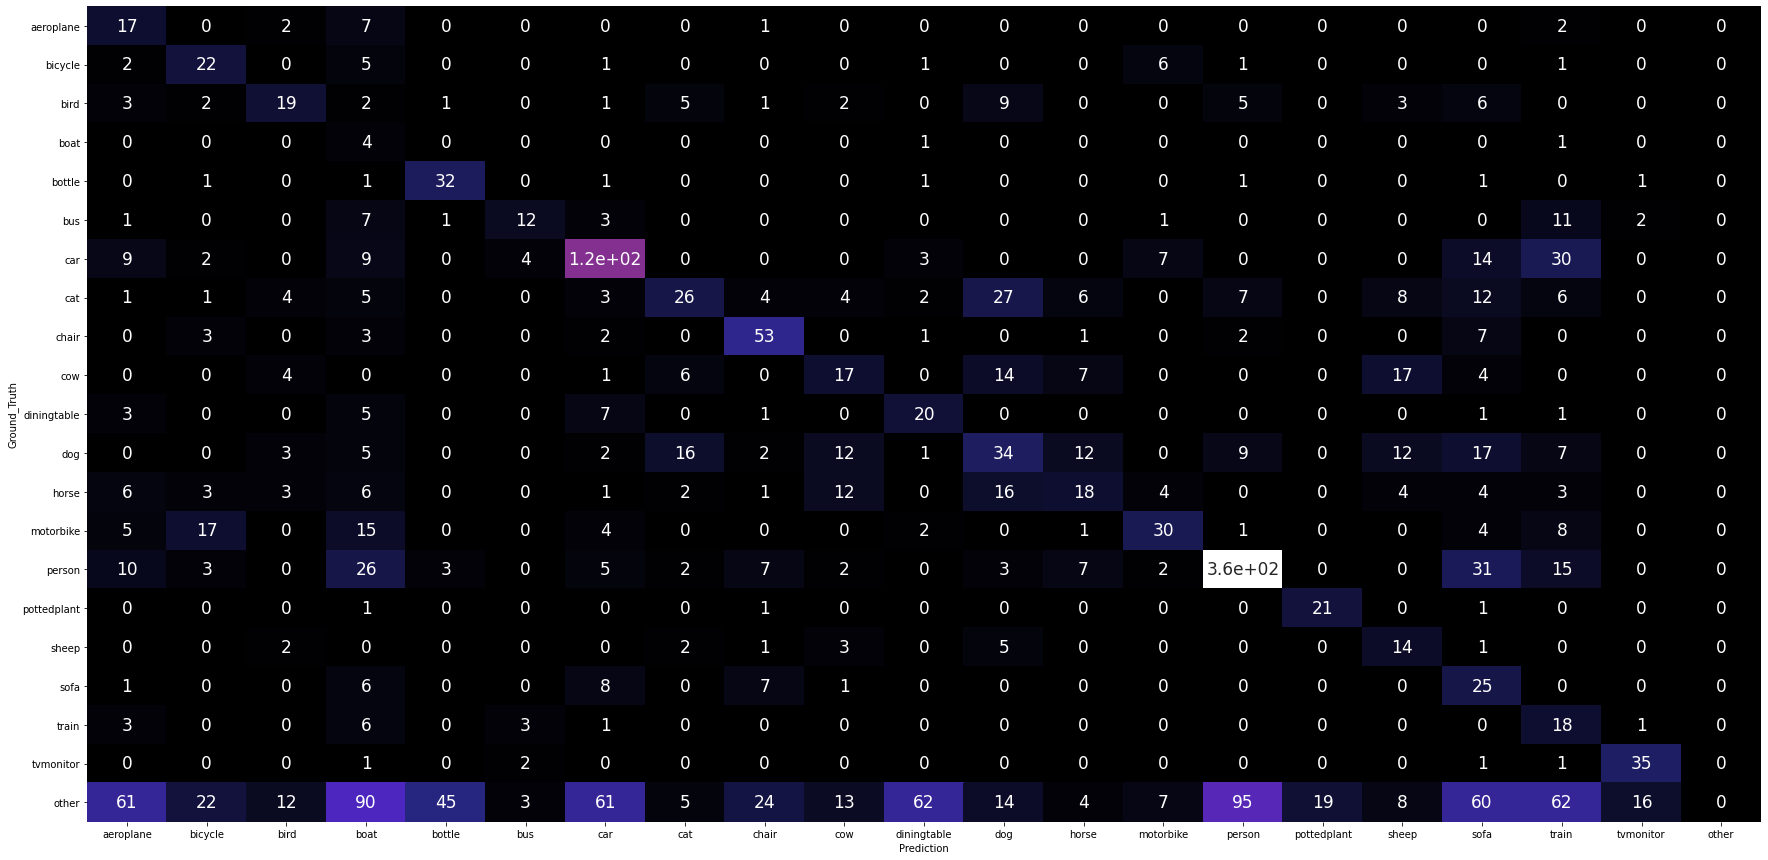

time: 2.28 s


In [0]:
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt

output_path = 'Test-Artifacts/' +  backbone + '/collab_fasterRCNN/0.95/confusion_matrix.png'

#'Accent', 'Accent_r', 'Blues', 'Blues_r', 'BrBG', 'BrBG_r', 'BuGn', 'BuGn_r', 'BuPu', 'BuPu_r', 'CMRmap', 'CMRmap_r', 
# 'Dark2', 'Dark2_r', 'GnBu', 'GnBu_r', 'Greens', 'Greens_r', 'Greys', 'Greys_r', 'OrRd', 'OrRd_r', 
# 'Oranges', 'Oranges_r', 'PRGn', 'PRGn_r', 'Paired', 'Paired_r', 'Pastel1', 'Pastel1_r', 'Pastel2',
#  'Pastel2_r', 'PiYG', 'PiYG_r', 'PuBu', 'PuBuGn', 'PuBuGn_r', 'PuBu_r', 'PuOr', 'PuOr_r', 'PuRd', 
#  'PuRd_r', 'Purples', 'Purples_r', 'RdBu', 'RdBu_r', 'RdGy', 'RdGy_r', 'RdPu', 'RdPu_r', 'RdYlBu', 
#  'RdYlBu_r', 'RdYlGn', 'RdYlGn_r', 'Reds', 'Reds_r', 'Set1', 'Set1_r', 'Set2', 'Set2_r', 'Set3', 'Set3_r', 'Spectral', 
#  'Spectral_r', 'Wistia', 'Wistia_r', 'YlGn', 'YlGnBu', 'YlGnBu_r', 'YlGn_r', 'YlOrBr', 'YlOrBr_r', 'YlOrRd', 'YlOrRd_r', 
#  'afmhot', 'afmhot_r', 'autumn', 'autumn_r', 'binary', 'binary_r', 'bone', 'bone_r', 'brg', 'brg_r', 'bwr', 'bwr_r', 'cividis', 
#  'cividis_r', 'cool', 'cool_r', 'coolwarm', 'coolwarm_r', 'copper', 'copper_r', 'cubehelix', 'cubehelix_r', 'flag', 'flag_r', 'gist_earth', 
#  'gist_earth_r', 'gist_gray', 'gist_gray_r', 'gist_heat', 'gist_heat_r', 'gist_ncar', 'gist_ncar_r', 'gist_rainbow', 'gist_rainbow_r', 'gist_stern', 
#  'gist_stern_r', 'gist_yarg', 'gist_yarg_r', 'gnuplot', 'gnuplot2', 'gnuplot2_r', 'gnuplot_r', 'gray', 'gray_r', 'hot', 'hot_r', 'hsv', 'hsv_r', 'icefire', 'icefire_r', 
#  'inferno', 'inferno_r', 'jet', 'jet_r', 'magma', 'magma_r', 'mako', 'mako_r', 'nipy_...
confusion_list = confusion_matrix.tolist()

gt_classes = []
pt_classes = []
val_list = []
new_classes = CLASSES + ['other']
for i, row in enumerate(confusion_list): 
  gt_class = new_classes[i]
  for idx, col in enumerate(row):
    pt_class = new_classes[idx]
    # print(gt_class, pt_class, col)
    gt_classes.append(gt_class)
    pt_classes.append(pt_class)
    val_list.append(col)
  # break
gt_classes, pt_classes, val_list
df = pd.DataFrame({'Ground_Truth':gt_classes,'Prediction':pt_classes,'Occurences':val_list})
# df.to_csv('Test-Artifacts/' +  backbone + '/regular_fasterRCNN/fp_score.csv', index=False)
df = df.pivot_table(index='Ground_Truth', columns='Prediction', values='Occurences')
##MOVE COL###
cols = list(df)
print(cols)
cols.insert(len(cols), cols.pop(14))
print(cols)
df = df.reindex(columns= cols)

##MOVE ROW###
rows = df.index.tolist()
print(rows)
rows.insert(len(rows), rows.pop(14))
df = df.reindex(rows)
df.to_csv('Test-Artifacts/' + backbone + '/collab_fasterRCNN/0.95/confusion_matrix.csv', index=True)
display(df)
plt.figure(figsize = (30,15))
sn.heatmap(df, annot=True, annot_kws={"size": 17}, cmap='CMRmap', cbar=False)
plt.savefig(output_path)

# **4. MAP CALCULATION**

In [0]:
###PREPARING FOR MAP AND MAP CALCULATION###
###MAP SCORE###
import shutil
from pathlib import Path
import ast
import pandas as pd
#Preparing and Structuring Data


#Prepare folder
test_root = 'Test-Artifacts/' + backbone + '/collab_fasterRCNN/mAP-report/input/' 
gt_root = test_root + 'ground-truth/'
prediction_root = test_root + 'detection-results/'
test_img_write_root = test_root +'images-optional/'

Path(gt_root).mkdir(parents=True, exist_ok=True)
Path(prediction_root).mkdir(parents=True, exist_ok=True)
Path(test_img_write_root).mkdir(parents=True, exist_ok=True)




filename = 'Test-Artifacts/' + backbone + '/collab_fasterRCNN/inference_metrics_with_gt.csv'
df = pd.read_csv(filename)

img_list = df['image_id'].tolist()
img_list
import collections
duplicate_list = [item for item, count in collections.Counter(img_list).items() if count > 1]
len(duplicate_list)
# print(duplicate_list)
from pprint import pprint
pprint(duplicate_list)
# display(df[479:480]['scores'])
# scores = ast.literal_eval(df[479:480]['scores'])
# for index, row in df.iterrows():
#   if index <= 576:
#     continue
#   print(index)
#   image_id = row['image_id'].split('.jpg')[0]
#   image_src_path = '2012_TestImages/' + row['image_id']
#   gt_path = gt_root + image_id + '.txt'
#   prediction_path = prediction_root + image_id + '.txt'
#   image_destination_path = test_img_write_root

#   print(image_id)
#   ##GROUND TRUTH VALUES###
#   gt_class_names = ast.literal_eval(row['gt_class_name'])
#   gt_bboxes = ast.literal_eval(row['gt_bboxes'])

#   ##PREDICTION VALUES###
#   p_class_names = ast.literal_eval(row['class_name'])
#   p_bboxes = ast.literal_eval(row['bboxes'])
#   print(row['scores'])
#   scores = ast.literal_eval(row['scores'])
#   # print(p_bboxes, scores)
#   # print(gt_bbox)
#   # print(p_bbox)
#   # print(class_name, gt_path, prediction_path, image_src_path, image_destination_path)
  
#   #Write ground truth
#   with open(gt_path, 'w') as g_write:
#     for i, gt_bbox in enumerate(gt_bboxes):
#       class_name = gt_class_names[i]
#       for idx, val in enumerate(gt_bbox):
#         gt_bbox[idx] = str(val)
#       # print(gt_bbox)
#       line = class_name + ' ' + gt_bbox[0] + ' ' + gt_bbox[1] + ' ' + gt_bbox[2] + ' ' + gt_bbox[3] + '\n'
#       g_write.write(line)
#       print("GROUND TRUTH:", class_name, gt_bbox[0], gt_bbox[1], gt_bbox[2], gt_bbox[3], '\n')

#   #Write prediction results
#   with open(prediction_path, 'w') as p_write:
#     for i, p_bbox in enumerate(p_bboxes):
#       score = str(scores[i])
#       class_name = p_class_names[i]
#       for idx, val in enumerate(p_bbox):
#         p_bbox[idx] = str(val)
#       # print(p_bbox, score)
#       line = class_name + ' ' + score + ' ' + p_bbox[0] + ' ' + p_bbox[1] + ' ' + p_bbox[2] + ' ' + p_bbox[3] + '\n'
#       p_write.write(line)
#       print("PREDICTION:", class_name + ' ' + score + ' ' + p_bbox[0] + ' ' + p_bbox[1] + ' ' + p_bbox[2] + ' ' + p_bbox[3] + '\n')
#   if os.path.exists(image_src_path):
#     shutil.copy(image_src_path, image_destination_path)
  



['000197.jpg',
 '000273.jpg',
 '000201.jpg',
 '000291.jpg',
 '000279.jpg',
 '000265.jpg',
 '000283.jpg',
 '000152.jpg',
 '000227.jpg',
 '000217.jpg',
 '000271.jpg',
 '000274.jpg',
 '000172.jpg',
 '000145.jpg',
 '000179.jpg',
 '000260.jpg',
 '000254.jpg',
 '000212.jpg',
 '000126.jpg',
 '000176.jpg',
 '000149.jpg',
 '000157.jpg',
 '000247.jpg',
 '000600.jpg',
 '000299.jpg',
 '000234.jpg',
 '000606.jpg',
 '000255.jpg',
 '000216.jpg',
 '000148.jpg',
 '000253.jpg',
 '000284.jpg',
 '000127.jpg',
 '000603.jpg',
 '000272.jpg',
 '000238.jpg',
 '000604.jpg',
 '000264.jpg',
 '000237.jpg',
 '000151.jpg',
 '000248.jpg',
 '000181.jpg',
 '000186.jpg',
 '000226.jpg',
 '000295.jpg',
 '000124.jpg',
 '000280.jpg',
 '000185.jpg',
 '000223.jpg',
 '000287.jpg',
 '000139.jpg',
 '000205.jpg',
 '000252.jpg',
 '000596.jpg',
 '000309.jpg',
 '000243.jpg',
 '000230.jpg',
 '000199.jpg',
 '000191.jpg',
 '000267.jpg',
 '000292.jpg',
 '000166.jpg',
 '000206.jpg',
 '000196.jpg',
 '001477.jpg',
 '001503.jpg',
 '001034.j

In [0]:
shutil.copy('Test-Artifacts/resnet50/regular_fasterRCNN/mAP-report/main.py', 'Test-Artifacts/' + backbone + '/pretrained_collab_fasterRCNN/mAP-report')
!python 'Test-Artifacts/$backbone/pretrained_collab_fasterRCNN/mAP-report/main.py' --no-animation --iou 0.5

#intersection over union: 
# 2 bounding boxes
# overlapping region

NEW MIN IOU:  0.5
65.34% = aeroplane AP 
72.74% = bicycle AP 
65.22% = bird AP 
46.83% = boat AP 
34.26% = bottle AP 
57.40% = bus AP 
64.07% = car AP 
75.75% = cat AP 
34.26% = chair AP 
58.08% = cow AP 
37.26% = diningtable AP 
77.16% = dog AP 
61.42% = horse AP 
65.30% = motorbike AP 
66.32% = person AP 
37.83% = pottedplant AP 
59.58% = sheep AP 
40.36% = sofa AP 
81.64% = train AP 
58.92% = tvmonitor AP 
mAP = 57.99%
<Figure size 640x480 with 1 Axes>
time: 1min 1s


In [0]:
# shutil.copy('Test-Artifacts/' + backbone + '/mAP-report/main.py', 'Test-Artifacts/' + backbone + '/regular_fasterRCNN/mAP-report/')
%ls 'Test-Artifacts/$backbone/pretrained_collab_fasterRCNN/mAP-report/'

input/  main.py  output/
time: 1.78 s


# **5. Create Inspection CSV and Generate Confusion Matrix**

In [0]:
import pandas as pd
import ast
df = pd.read_csv('Test-Artifacts/' +  backbone + '/pretrained_collab_fasterRCNN/inference_metrics_with_gt.csv')

def create_inspect_csv(df):
  column_names =  ['image_id', 'prediction', 'ground_truth', 'false_positives']
  column_names2 =  ['image_id', 'prediction', 'ground_truth', 'false_positives', 'pt_bboxes', 'gt_bboxes', 'dimension']
  result_df = pd.DataFrame(columns = column_names)
  visualization_df = pd.DataFrame(columns = column_names2)
  for index, row in df.iterrows():
    image_id = row['image_id']
    
    prediction= list(set(ast.literal_eval(row['class_name'])))
    gt = list(set(ast.literal_eval(row['gt_class_name'])))
    fp = [x for x in prediction if x not in gt]
    if fp == []:
      continue
    data = [[image_id, prediction, gt, fp]]
    print(data)
    data_row = pd.DataFrame(data = data, columns = column_names)
    result_df = result_df.append(data_row, ignore_index = True)
    
    dimension = ast.literal_eval(row['dimension'])
    prediction= ast.literal_eval(row['class_name'])
    gt = ast.literal_eval(row['gt_class_name'])
    p_bbox = ast.literal_eval(row['bboxes'])
    gt_bbox = ast.literal_eval(row['gt_bboxes'])
    data2 = [[image_id, prediction, gt, fp, p_bbox, gt_bbox, dimension]]

    data_row2 = pd.DataFrame(data = data2, columns = column_names2)
    visualization_df = visualization_df.append(data_row2, ignore_index = True)
  # print(new_df['class_name'][0])
  display(result_df)
  result_df.to_csv('Test-Artifacts/' +  backbone + '/pretrained_collab_fasterRCNN/predict_truth_report.csv')
  display(visualization_df)
  visualization_df.to_csv('Test-Artifacts/' +  backbone + '/pretrained_collab_fasterRCNN/predict_truth_report_with_bboxes.csv', index = False)
  return result_df
inspect_table = create_inspect_csv(df)


[['008991.jpg', ['tvmonitor', 'chair', 'sofa'], ['tvmonitor', 'chair'], ['sofa']]]
[['009001.jpg', ['boat', 'person'], ['boat'], ['person']]]
[['009021.jpg', ['person', 'bus'], ['bus'], ['person']]]
[['009030.jpg', ['aeroplane', 'person'], ['aeroplane'], ['person']]]
[['009026.jpg', ['bird'], ['boat'], ['bird']]]
[['009040.jpg', ['bottle', 'person'], ['person'], ['bottle']]]
[['009047.jpg', ['tvmonitor', 'motorbike', 'person'], ['motorbike', 'person'], ['tvmonitor']]]
[['009050.jpg', ['motorbike', 'person'], ['motorbike'], ['person']]]
[['009070.jpg', ['person', 'sofa'], ['sofa'], ['person']]]
[['009075.jpg', ['bottle', 'person', 'diningtable'], ['bottle', 'chair', 'person'], ['diningtable']]]
[['009093.jpg', ['horse'], ['bird'], ['horse']]]
[['009115.jpg', ['pottedplant', 'person'], ['person', 'bicycle'], ['pottedplant']]]
[['009217.jpg', ['tvmonitor', 'person'], ['tvmonitor'], ['person']]]
[['009220.jpg', ['chair', 'train'], ['train'], ['chair']]]
[['009235.jpg', ['cow'], ['dog'], ['

image_id  ... false_positives
0    008991.jpg  ...          [sofa]
1    009001.jpg  ...        [person]
2    009021.jpg  ...        [person]
3    009030.jpg  ...        [person]
4    009026.jpg  ...          [bird]
..          ...  ...             ...
98   007866.jpg  ...   [pottedplant]
99   007879.jpg  ...          [bird]
100  007913.jpg  ...         [chair]
101  007917.jpg  ...   [pottedplant]
102  007949.jpg  ...           [car]

[103 rows x 4 columns]

image_id  ...       dimension
0    008991.jpg  ...  [853.0, 640.0]
1    009001.jpg  ...  [640.0, 961.0]
2    009021.jpg  ...  [640.0, 853.0]
3    009030.jpg  ...  [853.0, 640.0]
4    009026.jpg  ...  [853.0, 640.0]
..          ...  ...             ...
98   007866.jpg  ...  [640.0, 958.0]
99   007879.jpg  ...  [853.0, 640.0]
100  007913.jpg  ...  [853.0, 640.0]
101  007917.jpg  ...  [853.0, 640.0]
102  007949.jpg  ...  [800.0, 640.0]

[103 rows x 7 columns]

time: 811 ms


In [0]:
from sklearn.metrics import confusion_matrix
import itertools
y_true, y_pred = [], []
for idx, row in inspect_table.iterrows(): 
  gt = row['ground_truth']  
  fp = row['false_positives']
  print(gt, fp, '\n')
  for element in itertools.product(gt,fp):
      print(element)
      y_true.append(element[0])
      y_pred.append(element[1])
  # break
y_true, y_pred
confusion_matrix = confusion_matrix(y_true, y_pred, labels=CLASSES)

['tvmonitor', 'chair'] ['sofa'] 

('tvmonitor', 'sofa')
('chair', 'sofa')
['boat'] ['person'] 

('boat', 'person')
['bus'] ['person'] 

('bus', 'person')
['aeroplane'] ['person'] 

('aeroplane', 'person')
['boat'] ['bird'] 

('boat', 'bird')
['person'] ['bottle'] 

('person', 'bottle')
['motorbike', 'person'] ['tvmonitor'] 

('motorbike', 'tvmonitor')
('person', 'tvmonitor')
['motorbike'] ['person'] 

('motorbike', 'person')
['sofa'] ['person'] 

('sofa', 'person')
['bottle', 'chair', 'person'] ['diningtable'] 

('bottle', 'diningtable')
('chair', 'diningtable')
('person', 'diningtable')
['bird'] ['horse'] 

('bird', 'horse')
['person', 'bicycle'] ['pottedplant'] 

('person', 'pottedplant')
('bicycle', 'pottedplant')
['tvmonitor'] ['person'] 

('tvmonitor', 'person')
['train'] ['chair'] 

('train', 'chair')
['dog'] ['cow'] 

('dog', 'cow')
['pottedplant', 'car', 'bus'] ['person'] 

('pottedplant', 'person')
('car', 'person')
('bus', 'person')
['motorbike', 'person'] ['chair'] 

('motor

ERROR! Session/line number was not unique in database. History logging moved to new session 60


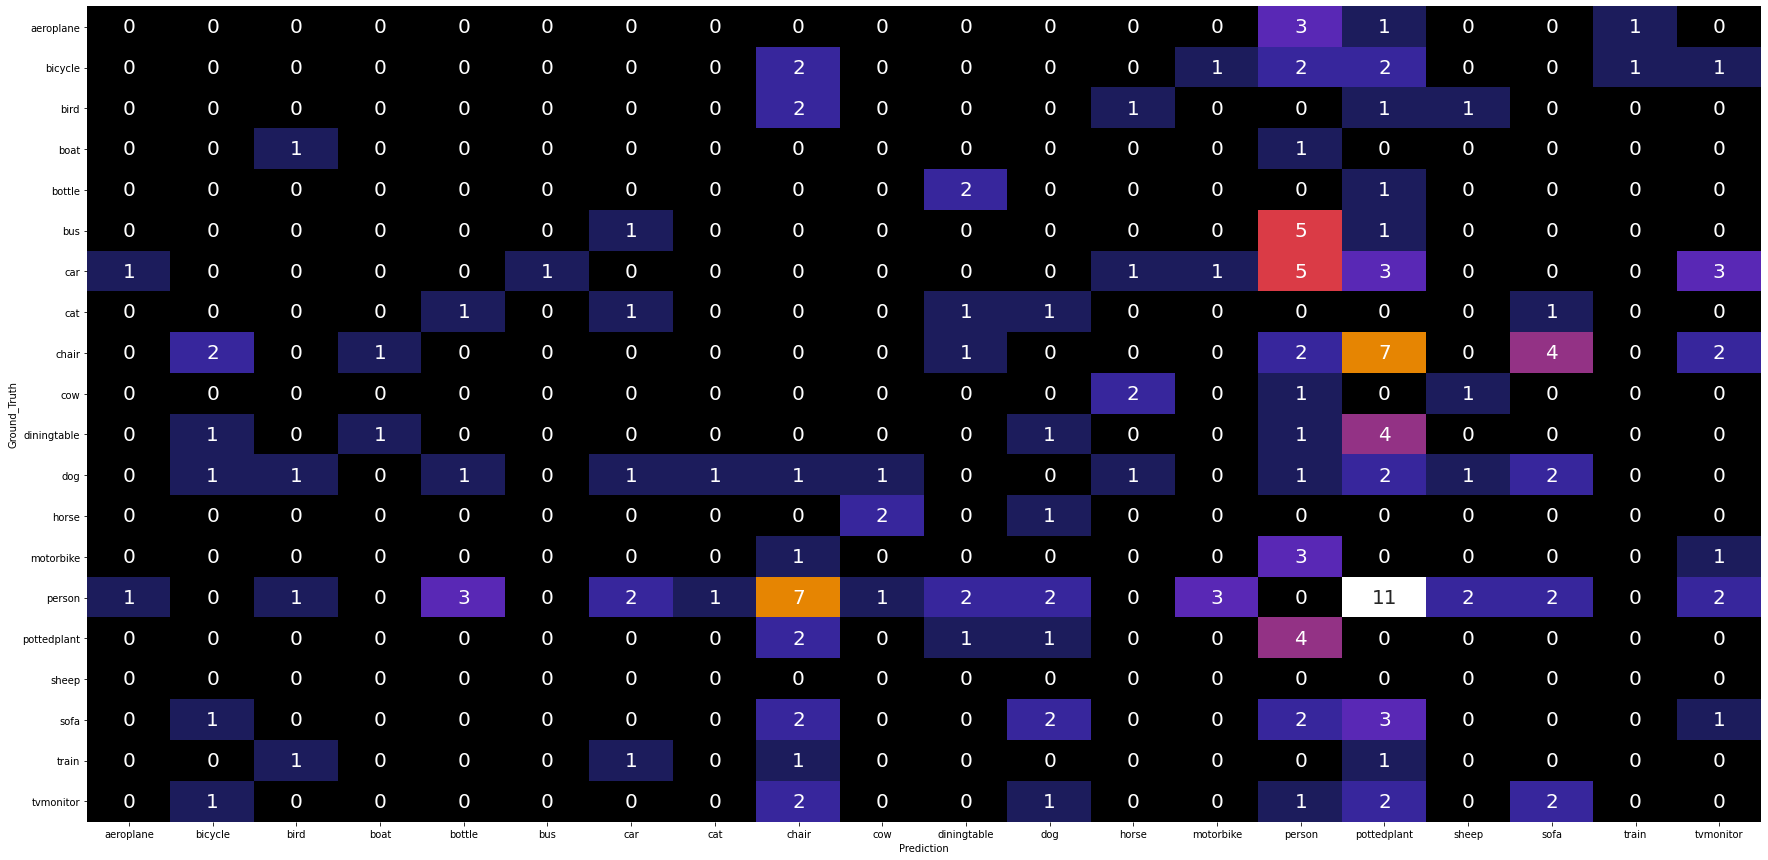

time: 2.75 s


In [0]:
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt

output_path = 'Test-Artifacts/' +  backbone + '/pretrained_collab_fasterRCNN/confusion_matrix.png'
#'Accent', 'Accent_r', 'Blues', 'Blues_r', 'BrBG', 'BrBG_r', 'BuGn', 'BuGn_r', 'BuPu', 'BuPu_r', 'CMRmap', 'CMRmap_r', 
# 'Dark2', 'Dark2_r', 'GnBu', 'GnBu_r', 'Greens', 'Greens_r', 'Greys', 'Greys_r', 'OrRd', 'OrRd_r', 
# 'Oranges', 'Oranges_r', 'PRGn', 'PRGn_r', 'Paired', 'Paired_r', 'Pastel1', 'Pastel1_r', 'Pastel2',
#  'Pastel2_r', 'PiYG', 'PiYG_r', 'PuBu', 'PuBuGn', 'PuBuGn_r', 'PuBu_r', 'PuOr', 'PuOr_r', 'PuRd', 
#  'PuRd_r', 'Purples', 'Purples_r', 'RdBu', 'RdBu_r', 'RdGy', 'RdGy_r', 'RdPu', 'RdPu_r', 'RdYlBu', 
#  'RdYlBu_r', 'RdYlGn', 'RdYlGn_r', 'Reds', 'Reds_r', 'Set1', 'Set1_r', 'Set2', 'Set2_r', 'Set3', 'Set3_r', 'Spectral', 
#  'Spectral_r', 'Wistia', 'Wistia_r', 'YlGn', 'YlGnBu', 'YlGnBu_r', 'YlGn_r', 'YlOrBr', 'YlOrBr_r', 'YlOrRd', 'YlOrRd_r', 
#  'afmhot', 'afmhot_r', 'autumn', 'autumn_r', 'binary', 'binary_r', 'bone', 'bone_r', 'brg', 'brg_r', 'bwr', 'bwr_r', 'cividis', 
#  'cividis_r', 'cool', 'cool_r', 'coolwarm', 'coolwarm_r', 'copper', 'copper_r', 'cubehelix', 'cubehelix_r', 'flag', 'flag_r', 'gist_earth', 
#  'gist_earth_r', 'gist_gray', 'gist_gray_r', 'gist_heat', 'gist_heat_r', 'gist_ncar', 'gist_ncar_r', 'gist_rainbow', 'gist_rainbow_r', 'gist_stern', 
#  'gist_stern_r', 'gist_yarg', 'gist_yarg_r', 'gnuplot', 'gnuplot2', 'gnuplot2_r', 'gnuplot_r', 'gray', 'gray_r', 'hot', 'hot_r', 'hsv', 'hsv_r', 'icefire', 'icefire_r', 
#  'inferno', 'inferno_r', 'jet', 'jet_r', 'magma', 'magma_r', 'mako', 'mako_r', 'nipy_...
confusion_list = confusion_matrix.tolist()
gt_classes = []
pt_classes = []
val_list = []
for i, row in enumerate(confusion_list):
  gt_class = CLASSES[i]
  for idx, col in enumerate(row):
    pt_class = CLASSES[idx]
    # print(gt_class, pt_class, col)
    gt_classes.append(gt_class)
    pt_classes.append(pt_class)
    val_list.append(col)
  # break
gt_classes, pt_classes, val_list
df = pd.DataFrame({'Ground_Truth':gt_classes,'Prediction':pt_classes,'Occurences':val_list})
df = df.pivot_table(index='Ground_Truth', columns='Prediction', values='Occurences')
plt.figure(figsize = (30,15))
sn.heatmap(df, annot=True, annot_kws={"size": 20}, cmap='CMRmap', cbar=False)
plt.savefig(output_path)

In [0]:
data=sn.load_dataset("flights")
display(data)
df = pd.pivot_table(data,
                    index='month',
                    values='passengers',
                    columns='year')
df.head()


year      month  passengers
0    1949    January         112
1    1949   February         118
2    1949      March         132
3    1949      April         129
4    1949        May         121
..    ...        ...         ...
139  1960     August         606
140  1960  September         508
141  1960    October         461
142  1960   November         390
143  1960   December         432

[144 rows x 3 columns]

[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 1, 0, 0, 1, 0],
 [0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 1, 2, 2, 0, 0, 1, 1],
 [0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0],
 [0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 1, 0, 0, 0, 0],
 [0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 5, 1, 0, 0, 0, 0],
 [1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 5, 3, 0, 0, 0, 3],
 [0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0],
 [0, 2, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 2, 7, 0, 4, 0, 2],
 [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 1, 0, 1, 0, 0, 0],
 [0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 4, 0, 0, 0, 0],
 [0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 2, 1, 2, 0, 0],
 [0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 3, 0, 0, 0, 0, 1],
 [1, 0, 1, 0, 3, 0, 2, 1, 7, 1, 2, 2, 0, 3, 0, 11, 2, 2, 0, 2],
 [0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 1, 1, 0, 0, 4, 0, 0, 0

time: 73.4 ms


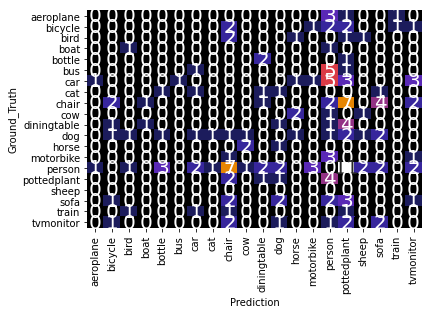

time: 1.57 s
